In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import neuropsy as npsy
import neuropsy.statistics as npsystat
import pandas as pd
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

### Two-sided Paired Samples t-test

In [3]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual_4cond_picshown.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')

In [8]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual_4cond_picshown.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# average power across all channels within subjects
power_sub_avg = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    for subject_id in subject_ids:
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
shape = power_sub_avg[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics      = {c: {'t-statistics': None, 'p-values': None, 'clusters': None} for c in conditions}
p_val           = 0.05                     # significance level

# perform permutation test for each condition separately
for condition in conditions:
    t_statistics    = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    p_values        = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    clusters        = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    
    # iterate over frequencies and time points
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            sample_cond = []
            # for each combination of frequency and time, store the power values for all subjects and channels
            # this will be used to perform the permutation test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_cond.append(power_sub_avg[condition][subject_id][i, j])
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test for power and baseline.
            #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
            #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
            # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
            sa = sample_cond
            sb = np.zeros(len(sample_cond))
            res = stats.ttest_rel(a=sa, b=sb, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[i, j] = res.statistic
            p_values[i, j] = res.pvalue
            clusters[i, j] = 1 if res.pvalue < p_val else 0
            
    # store results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
            
            
            
            # break
        # break
    # break
    
# save results to disk
with open(f"{path}/data/tfr_orig_statistics_4cond_picshown.pkl", 'wb') as f:
    pickle.dump(statistics, f)

### Assign Cluster Labels

In [9]:
for condition in conditions:
    print(f"Starting condition {condition}...")
    clusters_found = statistics[condition]['clusters']
    # cluster_labels = np.zeros((15, 1024))
    cluster_labels = np.reshape(([None] * shape[0] * shape[1]), shape)
    
    first_run = True
    label_increment = 1
    continue_labelling = True
    cluster_labels_before = cluster_labels.copy()
    itercounter = 0
    while continue_labelling:
        for i in range(shape[0]):
            for j in range(shape[1]):
                
                # get neighbours
                if first_run:
                    
                    # check if current point is a cluster
                    if clusters_found[i, j] == 1:
                        # first run, check if any of the previous neighbours have been labelled
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 0 and j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == shape[0]-1 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == shape[0]-1 and j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == shape[0]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                            
                        # check if any of the prior neighbours, in relation to forward iteration, have been labelled
                        if xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = xlo
                        elif yhi is not None:
                            cluster_labels[i, j] = yhi
                        else:
                            cluster_labels[i, j] = label_increment
                            label_increment += 1
                        
                # after first run, get all surrounding neighbours
                else:
                    # check if current point is a cluster
                    if cluster_labels[i, j] is not None:
                        
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 0 and j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == shape[0]-1 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == shape[0]-1 and j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == shape[0]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        elif j == shape[1]-1:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        
                        # check if any of the neighbours have been labelled
                        # if any neighbours then set to the minimum value of the neigbouring clusters 
                        # note: 
                        #   this should make sure overlapping clusters are propageted toward being the same cluster after N iterations
                        if xlo is not None and xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo]))
                        elif xlo is not None and xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, yhi]))
                        elif xlo is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo, yhi]))
                        elif xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi]))
                        elif xlo is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo]))
                        elif xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo]))
                        elif xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, yhi]))
                        elif ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([ylo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = xlo
                        elif xhi is not None:
                            cluster_labels[i, j] = xhi
                        elif ylo is not None:
                            cluster_labels[i, j] = ylo
                        elif yhi is not None:
                            cluster_labels[i, j] = yhi
                        else:
                            # cluster label will be the same as before
                            pass
                
        # after full run   
        first_run = False
        label_increment = None
        
        # check if cluster label matrix is the same after this iteration as it was before
        # and stop while loop if it is the same, otherwise continue until all labels have been assigned
        # correctly.
        if np.array_equal(cluster_labels, cluster_labels_before):
            print(f"Cluster labels are the same after this iteration. Stopping while loop.")
            continue_labelling = False
            
            # convert all None to zeros
            cluster_labels = np.array([i if i is not None else 0 for sublist in cluster_labels for i in sublist]).reshape(shape).astype(int)
            
            # assign the correct labels to the clusters
            unique_labels = np.unique(cluster_labels)[1:]
            print(f"Unique cluster labels: {unique_labels}")
            for i in range(1, len(unique_labels)+1):
                if i in cluster_labels:
                    continue
                else:
                    cluster_labels[cluster_labels == unique_labels[i-1]] = i
            
            if np.array_equal(unique_labels, np.unique(cluster_labels)[1:]):
                print(f"Cluster labels are correct.")
            else:
                print(f"Cluster labels have been corrected to: {np.unique(cluster_labels)[1:]}")
                
            # store cluster labels
            statistics[condition]['cluster_labels'] = cluster_labels
            
            print(f"Finished condition {condition}.")
            
        else:
            cluster_labels_before = cluster_labels.copy()
            itercounter += 1
            print(f"Iteration {itercounter} completed, continuing.")
            continue

Starting condition not learned...
Iteration 1 completed, continuing.
Iteration 2 completed, continuing.
Iteration 3 completed, continuing.
Iteration 4 completed, continuing.
Iteration 5 completed, continuing.
Iteration 6 completed, continuing.
Iteration 7 completed, continuing.
Iteration 8 completed, continuing.
Iteration 9 completed, continuing.
Iteration 10 completed, continuing.
Iteration 11 completed, continuing.
Iteration 12 completed, continuing.
Iteration 13 completed, continuing.
Iteration 14 completed, continuing.
Iteration 15 completed, continuing.
Iteration 16 completed, continuing.
Iteration 17 completed, continuing.
Iteration 18 completed, continuing.
Iteration 19 completed, continuing.
Iteration 20 completed, continuing.
Iteration 21 completed, continuing.
Iteration 22 completed, continuing.
Iteration 23 completed, continuing.
Iteration 24 completed, continuing.
Iteration 25 completed, continuing.
Iteration 26 completed, continuing.
Iteration 27 completed, continuing.
Ite

### Count Cluster Size(s)

In [10]:
for condition in conditions:
    print(f"Starting condition {condition}...")
    t_statistics = statistics[condition]['t-statistics']
    cluster_labels = statistics[condition]['cluster_labels']
    unique_labels = np.unique(cluster_labels)[1:] # ignore zero
    
    # initialise dict for storing cumulative cluster t-values
    cluster_sizes = {f'{label}': 0 for label in unique_labels}
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            # check if current point is a cluster
            if cluster_labels[i, j] != 0:
                
                # increment the cluster size by the t-value
                cluster_sizes[str(cluster_labels[i, j])] += t_statistics[i, j]
    
    # round values to 2 decimal places
    cluster_sizes = {key: round(value, 2) for key, value in cluster_sizes.items()}
    
    # store cluster sizes
    statistics[condition]['cluster_sizes'] = cluster_sizes
    
    for label in unique_labels:
        print(f"\tCluster {label} size: {cluster_sizes[str(label)]}")
    print(f"Finished condition {condition}.")

Starting condition not learned...
	Cluster 1 size: 7972.07
	Cluster 2 size: 13.44
	Cluster 3 size: -2874.86
	Cluster 4 size: 990.49
	Cluster 5 size: 7.02
	Cluster 6 size: -2.25
	Cluster 7 size: -9.51
	Cluster 8 size: -21.05
	Cluster 9 size: 4.56
	Cluster 10 size: 20.5
	Cluster 11 size: -2.25
	Cluster 12 size: 2.34
Finished condition not learned.
Starting condition correct...
	Cluster 1 size: 3628.38
	Cluster 2 size: -3132.29
	Cluster 3 size: -13.63
	Cluster 4 size: -2.23
	Cluster 5 size: -16.23
	Cluster 6 size: -39.47
	Cluster 7 size: -14.81
	Cluster 8 size: -6.9
	Cluster 9 size: -2.23
	Cluster 10 size: 34.57
	Cluster 11 size: 7.02
	Cluster 12 size: 7.18
	Cluster 13 size: -2.23
	Cluster 14 size: -19.87
	Cluster 15 size: -29.99
	Cluster 16 size: 7.25
Finished condition correct.
Starting condition learned-1...
	Cluster 1 size: 4251.65
	Cluster 2 size: -23.77
	Cluster 3 size: 202.69
	Cluster 4 size: -1301.7
	Cluster 5 size: -2.25
	Cluster 6 size: -25.2
	Cluster 7 size: -31.96
	Cluster 8 s

### Save Cluster Labels as CSV

In [5]:
import pandas as pd
conditions = ('not learned', 'correct', 'learned-1', 'learned')
for c in conditions:
    pd.DataFrame(statistics[conditions[0]]['cluster_labels']).to_csv(f"{path}/data/cluster_labels_picshown_{c}.csv")

### Read Statistics

In [5]:
with open(f"{path}/data/tfr_power_results_manual_4cond_picshown.pkl", 'rb') as f:
    statistics = pickle.load(f)

### Plot Time-frequency Power and Clusters

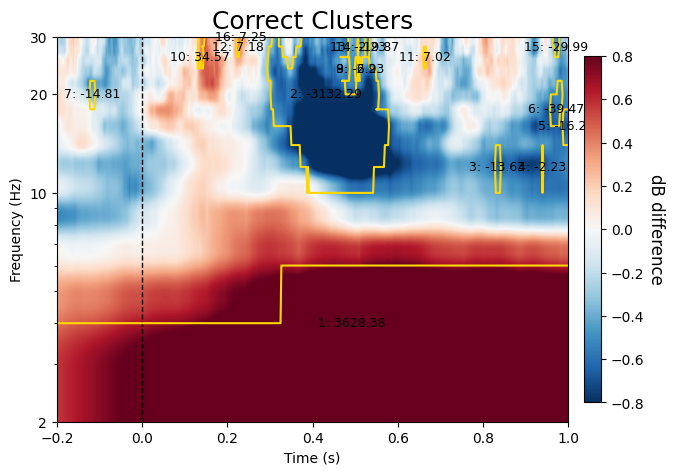

In [11]:
import matplotlib.pyplot as plt

# parameters
frequencies = np.arange(2, 32, 2)
tmin = -.2
tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
condition_to_plot   = 'correct'
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    data_cond_avg[condition_to_plot], 
    aspect='auto',
    extent=extent,
    origin='lower', 
    vmin=-.8,
    vmax=.8,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{condition_to_plot[0].upper() + condition_to_plot[1:]} Clusters", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
levels = levels
x = np.linspace(tmin, tmax, shape[1])
y = frequencies
xv, yv = np.meshgrid(x, y)
z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
for label, size in cluster_sizes.items():
    x = np.where(clusters_to_plot == int(label))[1]
    y = np.where(clusters_to_plot == int(label))[0]
    
    x = np.floor(np.mean(x)).astype(int)
    if label == '1':
        y = 1
    else:
        y = np.floor(np.mean(y)).astype(int)
    
    ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
            horizontalalignment='center',
            verticalalignment='center',
            color='black',
            fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown/{condition_to_plot}_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot t-value matrix

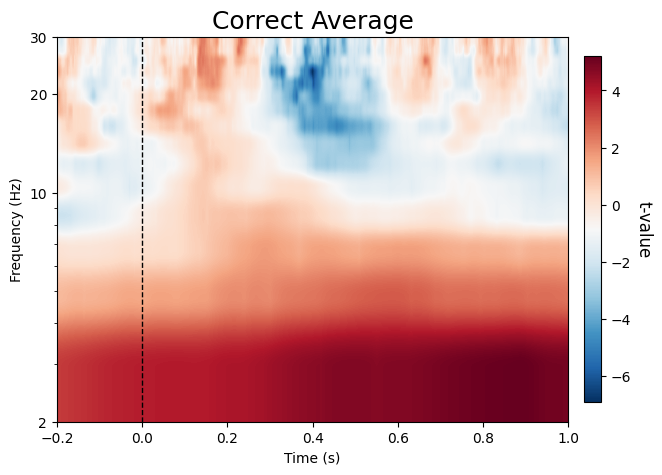

In [13]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -.2
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
condition_to_plot   = 'correct'
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    statistics[condition_to_plot]['t-statistics'], 
    aspect='auto',
    extent=extent,
    origin='lower', 
    # vmin=-.8,
    # vmax=.8,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{condition_to_plot[0].upper() + condition_to_plot[1:]} Average", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown/{condition_to_plot}_t-values.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot p-value matrix

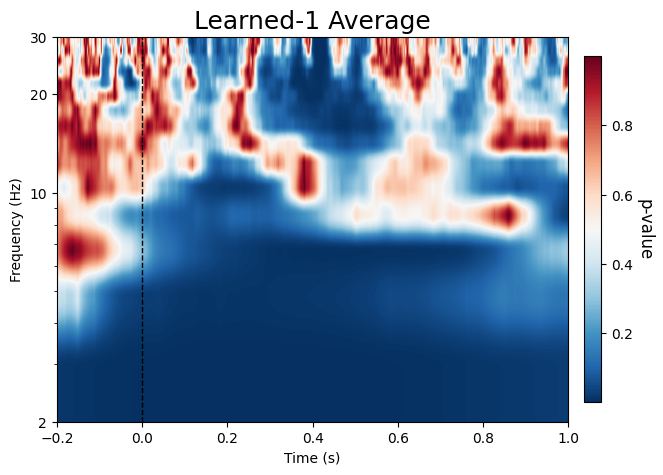

In [17]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -1
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
condition_to_plot   = 'learned-1'
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    statistics[condition_to_plot]['p-values'], 
    aspect='auto',
    extent=extent,
    origin='lower', 
    # vmin=-.8,
    # vmax=.8,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{condition_to_plot[0].upper() + condition_to_plot[1:]} Average", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown/{condition_to_plot}_p-values.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot Condition Difference

In [ ]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -.2
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
conditions_difference = ['not learned', 'learned'] # change to what difference you want to plot
difference_to_plot = data_cond_avg[conditions_difference[0]] - data_cond_avg[conditions_difference[1]]
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    difference_to_plot, 
    aspect='auto',
    extent=extent,
    origin='lower', 
    vmin=-3,
    vmax=3,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{conditions_difference[0].upper()} - {conditions_difference[1].upper()}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown /{condition_to_plot}_t-values.png", dpi=300, bbox_inches='tight')
plt.show()

### Cluster-based Permutation Test

In [183]:
def shuffle_samples(a, b, seed=None):
    """shuffle_samples Shuffle observations between two paired samples.

    Args:
        a (list, np.array): 1D array of observations for sample A.
        b (list, np.array): 1D array of observations for sample B.

    Returns:
        shuffled_a: 1D array of shuffled observations for sample A.
        shuffled_b: 1D array of shuffled observations for sample B.
    """
    if seed:
        np.random.seed(seed)
    
    # Combine samples A and B into a single 2D NumPy array
    combined = np.column_stack((a, b))
    
    # Shuffle the indices of the rows within each pair
    for pair in combined:
        np.random.shuffle(pair)
    
    # Split the shuffled combined array back into separate samples A and B
    shuffled_a = combined[:, 0]
    shuffled_b = combined[:, 1]
    return shuffled_a, shuffled_b

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
b = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

shuffled_a, shuffled_b = shuffle_samples(a, b)

print("\nBEFORE\t\t|\tAFTER")
print("A\tB\t|\tA\tB")
print("-" * 16 + "|" + "-" * 16)
for i in range(len(a)):
    print(f"{a[i]}\t{b[i]}\t|\t{shuffled_a[i]}\t{shuffled_b[i]}")


BEFORE		|	AFTER
A	B	|	A	B
----------------|----------------
1	0.1	|	0.1	1.0
2	0.2	|	0.2	2.0
3	0.3	|	3.0	0.3
4	0.4	|	0.4	4.0
5	0.5	|	5.0	0.5
6	0.6	|	6.0	0.6
7	0.7	|	0.7	7.0
8	0.8	|	8.0	0.8
9	0.9	|	0.9	9.0
10	1.0	|	1.0	10.0
11	1.1	|	1.1	11.0


In [72]:
def get_shuffle_indices(num_obs, rng):
    """get_shuffle_indices Shuffle observations between two paired samples and return array of indices
        that have been shuffled.

    Args:
        num_obs (int): Number of observations in each sample.
        seed (int): Seed for random number generator. Defaults to None.

    Returns:
        indices: Boolean array with True at indices that have been shuffled.
    """
    arr_a = [1] * num_obs
    arr_b = [0] * num_obs
    
    # Combine arr_a and arr_b into a single 2D NumPy array
    combined = np.column_stack((arr_a, arr_b))
    
    # Shuffle the indices of the rows within each pair
    for pair in combined:
        rng.shuffle(pair)
    
    indices = np.where(combined[:, 0] == 0)[0]
    return indices

seed = np.random.randint(0, 100)
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
perm_indices = get_shuffle_indices(num_obs=11, rng=rng)
print(f"shuffled indices: {perm_indices}")

sample_pow  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
sample_base = np.zeros(len(sample_pow)).astype(int)
                    
# shuffle the power values and baseline for current permutation
s_pow = sample_pow.copy()
s_base = sample_base.copy()
for i in range(len(sample_pow)):
    if i in perm_indices:
        s_pow[i] = sample_base[i]
        s_base[i] = sample_pow[i]
    else:
        s_pow[i] = sample_pow[i]
        s_base[i] = sample_base[i]

print("\nBEFORE\t\t|\tAFTER")
print("A\tB\t|\tA\tB")
print("-" * 16 + "|" + "-" * 16)
for i in range(len(sample_pow)):
    print(f"{sample_pow[i]}\t{sample_base[i]}\t|\t{s_pow[i]}\t{s_base[i]}")

seed: 6
shuffled indices: [0 5 7]

BEFORE		|	AFTER
A	B	|	A	B
----------------|----------------
1	0	|	0	1
2	0	|	2	0
3	0	|	3	0
4	0	|	4	0
5	0	|	5	0
6	0	|	0	6
7	0	|	7	0
8	0	|	0	8
9	0	|	9	0
10	0	|	10	0
11	0	|	11	0


In [2]:
def assign_cluster_labels(clusters_found: np.array) -> np.array:
    """assign_cluster_labels Forward iteration to assign cluster labels to clusters found in the data.

    Args:
        clusters_found (np.array): 2D array of clusters found in the data.

    Returns:
        np.array: 2D array of unique cluster labels.
    """
    # intialise output
    arr_shape = clusters_found.shape
    cluster_labels = np.reshape(([None] * arr_shape[0] * arr_shape[1]), arr_shape)
    
    first_run = True
    label_increment = 1
    continue_labelling = True
    cluster_labels_before = cluster_labels.copy()
    itercounter = 0
    while continue_labelling:
        for i in range(arr_shape[0]):
            for j in range(arr_shape[1]):
                
                # get neighbours
                if first_run:
                    
                    # check if current point is a cluster
                    if clusters_found[i, j] == 1:
                        # first run, check if any of the previous neighbours have been labelled
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 0 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 14 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 14 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 14:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                            
                        # check if any of the prior neighbours, in relation to forward iteration, have been labelled
                        if xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = int(xlo)
                        elif yhi is not None:
                            cluster_labels[i, j] = int(yhi)
                        else:
                            cluster_labels[i, j] = label_increment
                            label_increment += 1
                        
                # after first run, get all surrounding neighbours
                else:
                    # check if current point is a cluster
                    if cluster_labels[i, j] is not None:
                        
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 0 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 14 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 14 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 14:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        elif j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        
                        # check if any of the neighbours have been labelled
                        # if any neighbours then set to the minimum value of the neigbouring clusters 
                        # note: 
                        #   this should make sure overlapping clusters are propageted toward being the same cluster after N iterations
                        if xlo is not None and xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo]))
                        elif xlo is not None and xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, yhi]))
                        elif xlo is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo, yhi]))
                        elif xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi]))
                        elif xlo is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo]))
                        elif xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo]))
                        elif xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, yhi]))
                        elif ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([ylo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = int(xlo)
                        elif xhi is not None:
                            cluster_labels[i, j] = int(xhi)
                        elif ylo is not None:
                            cluster_labels[i, j] = int(ylo)
                        elif yhi is not None:
                            cluster_labels[i, j] = int(yhi)
                        else:
                            # cluster label will be the same as before
                            pass
                
        # after full run   
        first_run = False
        label_increment = None
        
        # check if cluster label matrix is the same after this iteration as it was before
        # and stop while loop if it is the same, otherwise continue until all labels have been assigned
        # correctly.
        if np.array_equal(cluster_labels, cluster_labels_before):
            # print(f"Assignation of cluster labels has converged. Stopping while loop.")
            print(f"Assignation of cluster labels has converged.")
            continue_labelling = False
            
            # convert all None to zeros
            cluster_labels = np.array([i if i is not None else 0 for sublist in cluster_labels for i in sublist]).reshape(15, 1024).astype(int)
            
            # assign the correct labels to the clusters
            unique_labels = np.unique(cluster_labels)[1:]
            print(f"Assigned cluster labels: {unique_labels}")
            for i in range(1, len(unique_labels)+1):
                if i in cluster_labels:
                    continue
                else:
                    cluster_labels[cluster_labels == unique_labels[i-1]] = i
            
            if np.array_equal(unique_labels, np.unique(cluster_labels)[1:]):
                print(f"Cluster labels are correct.")
            else:
                print(f"Cluster labels have been corrected to: {np.unique(cluster_labels)[1:]}")
                
            return cluster_labels
        else:
            cluster_labels_before = cluster_labels.copy()
            itercounter += 1
            # print(f"Iteration {itercounter} completed, continuing.")
            continue
        
        
def get_cluster_sizes(t_statistics: np.array, cluster_labels: np.array) -> dict:
    shape = t_statistics.shape
    unique_labels = np.unique(cluster_labels).astype(int)[1:] # ignore zero
    
    # initialise dict for storing cumulative cluster t-values
    cluster_sizes = {f'{label}': 0 for label in unique_labels}
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            # check if current point is a cluster
            if cluster_labels[i, j] != 0:
                
                # increment the cluster size by the t-value
                cluster_sizes[str(cluster_labels[i, j])] += t_statistics[i, j]
    
    # round values to 2 decimal places
    cluster_sizes = {key: round(value, 2) for key, value in cluster_sizes.items()}
    for label in unique_labels:
        print(f"\tCluster {label} size: {cluster_sizes[str(label)]}")
    
    return cluster_sizes

In [128]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual.pkl"
subject_ids         = nps.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('uncertain', 'certain')

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# average power across all channels within subjects
power_sub_avg = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    for subject_id in subject_ids:
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)

# initialize output from statistics
statistics          = {conditions[0]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}, \
                       conditions[1]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}}
df_cluster_sizes    = pd.DataFrame(columns=['condition', 'permutation', 'random_seed', 'indices_shuffled', 'cluster_label', 'cluster_size (t-value)'])
p_val               = 0.05      # significance level
n_permutations      = 1000      # number of permutations

# perform permutation test for each condition separately
for condition in conditions:
    print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((n_permutations, 15, 1024))                  # N permutations, 15 frequencies, 1024 time points
    p_values        = np.zeros((n_permutations, 15, 1024))                  # N permutations, 15 frequencies, 1024 time points
    clusters        = np.zeros((n_permutations, 15, 1024)).astype(int)      # N permutations, 15 frequencies, 1024 time points
    cluster_labels  = np.zeros((n_permutations, 15, 1024)).astype(int)      # N permutations, 15 frequencies, 1024 time points
    
    for n in tqdm(range(n_permutations), desc='Permutation progress', total=n_permutations):
        print(f"\nPermutation {n + 1}/{n_permutations}...")
        
        # get the shuffle indices for current permutation
        seed = np.random.randint(n_permutations, size=1)[0]
        print(f"seed: {seed}")
        rng = np.random.default_rng(seed)
        perm_indices = get_shuffle_indices(num_obs=len(subject_ids), rng=rng)
        
        print(f"Shuffling indices: {perm_indices}...")
        
        # iterate over frequencies and time points
        for i in range(15):
            for j in range(1024):
                
                sample_pow = []
                # for each combination of frequency and time, store the power values for all subjects and channels
                # this will be used to perform the t test
                for subject_id in subject_ids:
                    # store power values for each subject's channel average: frequency and time point
                    sample_pow.append(power_sub_avg[condition][subject_id][i, j])
                
                # initialise baseline sample
                sample_base = np.zeros(len(sample_pow))
                    
                # shuffle the power values and baseline for current permutation
                s_pow = sample_pow.copy()
                s_base = sample_base.copy()
                for idx in range(len(sample_pow)):
                    if idx in perm_indices:
                        s_pow[idx] = sample_base[idx]
                        s_base[idx] = sample_pow[idx]
                    else:
                        s_pow[idx] = sample_pow[idx]
                        s_base[idx] = sample_base[idx]
                
                # perform two-sided paired samples t-test
                # note:
                #   - compute t-test for power and baseline.
                #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
                #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
                # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
                res = stats.ttest_rel(a=s_pow, b=s_base, nan_policy='raise', alternative='two-sided', axis=0)
                
                # store results
                t_statistics[n, i, j]   = res.statistic
                p_values[n, i, j]       = res.pvalue
                clusters[n, i, j]       = 1 if res.pvalue < p_val else 0
                
            #     break
            # break
            
        if np.isclose(clusters[n, ...], 0).all():
            print(f"No clusters found for permutation {n + 1}.")
            # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
            df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, None, None]
        else:
            # assign labels to clusters in current permutation
            print(f"Assigning individual labels to clusters for permutation {n + 1}...")
            cluster_labels[n, ...] = assign_cluster_labels(clusters[n, ...])
            print(f"Found {len(np.unique(cluster_labels[n, ...])[1:])} clusters: {np.unique(cluster_labels[n, ...])[1:]}.")
            
            # count cluster sizes
            cluster_sizes = get_cluster_sizes(t_statistics=t_statistics[n, ...], cluster_labels=cluster_labels[n, ...])
        
            # append cluster sizes to dataframe
            for label, size in cluster_sizes.items():
                # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
                df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, label, size]
            
        # break
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
          
    print(f"Finished condition {repr(condition)}.\n")
    
    # break
    


Starting condition 'uncertain'...


Permutation progress:   0%|          | 0/1000 [00:00<?, ?it/s]


Permutation 1/1000...
seed: 22
Shuffling indices: [ 1  2  3  4  5  6  7  8 10]...


Permutation progress:   0%|          | 1/1000 [00:04<1:09:25,  4.17s/it]

Assigning individual labels to clusters for permutation 1...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -594.64
	Cluster 2 size: 278.45
	Cluster 3 size: 40.57

Permutation 2/1000...
seed: 777
Shuffling indices: [0 2 3 4 5 6 7 8 9]...


Permutation progress:   0%|          | 2/1000 [00:07<1:05:32,  3.94s/it]

Assigning individual labels to clusters for permutation 2...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -4802.68
	Cluster 2 size: -162.64
	Cluster 3 size: 103.34
	Cluster 4 size: 9.37
	Cluster 5 size: -6.98
	Cluster 6 size: -2.24
	Cluster 7 size: -4.57

Permutation 3/1000...
seed: 707
Shuffling indices: [0 3 4 5 7 8]...


Permutation progress:   0%|          | 3/1000 [00:11<1:05:09,  3.92s/it]

Assigning individual labels to clusters for permutation 3...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -11.45
	Cluster 2 size: -2.25
	Cluster 3 size: -88.84
	Cluster 4 size: -45.45

Permutation 4/1000...
seed: 999
Shuffling indices: [3 4 7 8]...


Permutation progress:   0%|          | 4/1000 [00:15<1:05:14,  3.93s/it]

Assigning individual labels to clusters for permutation 4...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -9.58
	Cluster 2 size: 4.48
	Cluster 3 size: 13.85

Permutation 5/1000...
seed: 126
Shuffling indices: [ 1  3  4  5  7  8 10]...


Permutation progress:   0%|          | 5/1000 [00:19<1:04:22,  3.88s/it]

Assigning individual labels to clusters for permutation 5...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.26
	Cluster 2 size: 2.24

Permutation 6/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:   1%|          | 6/1000 [00:23<1:04:06,  3.87s/it]

Assigning individual labels to clusters for permutation 6...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 162.86
	Cluster 2 size: 31.91
	Cluster 3 size: 6.74

Permutation 7/1000...
seed: 381
Shuffling indices: [ 1  4  6  9 10]...
Assigning individual labels to clusters for permutation 7...


Permutation progress:   1%|          | 7/1000 [00:28<1:12:34,  4.39s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 11 13 18 19 20 21 22 23 26 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -5609.33
	Cluster 2 size: -60.53
	Cluster 3 size: -27.18
	Cluster 4 size: -58.16
	Cluster 5 size: -6.93
	Cluster 6 size: -13.76
	Cluster 7 size: -128.3
	Cluster 8 size: -30.26
	Cluster 9 size: -21.87
	Cluster 10 size: -16.15
	Cluster 11 size: -82.95
	Cluster 12 size: -11.49
	Cluster 13 size: -21.68
	Cluster 14 size: -18.83
	Cluster 15 size: -2.25
	Cluster 16 size: -2.25
	Cluster 17 size: -4.53

Permutation 8/1000...
seed: 356
Shuffling indices: [ 3  4  5  7 10]...


Permutation progress:   1%|          | 8/1000 [00:32<1:09:46,  4.22s/it]

Assigning individual labels to clusters for permutation 8...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -15.64
	Cluster 2 size: -230.21

Permutation 9/1000...
seed: 155
Shuffling indices: [ 0  1 10]...


Permutation progress:   1%|          | 9/1000 [00:36<1:08:09,  4.13s/it]

Assigning individual labels to clusters for permutation 9...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -106.36
	Cluster 2 size: -4.59
	Cluster 3 size: -67.07
	Cluster 4 size: -133.89
	Cluster 5 size: -2.23
	Cluster 6 size: -2.23

Permutation 10/1000...
seed: 933
Shuffling indices: [1 2 3 4 7]...


Permutation progress:   1%|          | 10/1000 [00:40<1:06:38,  4.04s/it]

Assigning individual labels to clusters for permutation 10...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 282.01
	Cluster 2 size: 9.14
	Cluster 3 size: 9.29
	Cluster 4 size: 35.22

Permutation 11/1000...
seed: 313
Shuffling indices: [0 1 3 4 5 6]...


Permutation progress:   1%|          | 11/1000 [00:44<1:05:29,  3.97s/it]

Assigning individual labels to clusters for permutation 11...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 28 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -1282.85
	Cluster 2 size: -43.38
	Cluster 3 size: -34.13
	Cluster 4 size: -44.15
	Cluster 5 size: -2.23
	Cluster 6 size: -4.48
	Cluster 7 size: -47.79
	Cluster 8 size: -27.39
	Cluster 9 size: -11.32
	Cluster 10 size: -398.62
	Cluster 11 size: -2.24
	Cluster 12 size: -61.16
	Cluster 13 size: -37.77
	Cluster 14 size: -294.85
	Cluster 15 size: -9.22
	Cluster 16 size: -8.96
	Cluster 17 size: -11.35
	Cluster 18 size: -4.49
	Cluster 19 size: -76.96
	Cluster 20 size: -18.43
	Cluster 21 size: -6.72
	Cluster 22 size: -22.96
	Cluster 23 size: -

Permutation progress:   1%|          | 12/1000 [00:48<1:05:18,  3.97s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 1767.29
	Cluster 2 size: 13.37
	Cluster 3 size: 197.89
	Cluster 4 size: 26.96
	Cluster 5 size: 119.09
	Cluster 6 size: 363.07
	Cluster 7 size: 813.04
	Cluster 8 size: 407.83
	Cluster 9 size: 8.94
	Cluster 10 size: 316.18
	Cluster 11 size: 50.85
	Cluster 12 size: 136.91
	Cluster 13 size: 231.26
	Cluster 14 size: 44.91
	Cluster 15 size: 135.24
	Cluster 16 size: 37.35
	Cluster 17 size: 2.25
	Cluster 18 size: 4.64
	Cluster 19 size: 111.29
	Cluster 2

Permutation progress:   1%|▏         | 13/1000 [00:52<1:08:33,  4.17s/it]

Assigning individual labels to clusters for permutation 13...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2003.87
	Cluster 2 size: 25.75
	Cluster 3 size: 28.19

Permutation 14/1000...
seed: 648
Shuffling indices: [ 1  2  5  6  7  8  9 10]...


Permutation progress:   1%|▏         | 14/1000 [00:56<1:06:52,  4.07s/it]

Assigning individual labels to clusters for permutation 14...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 15 18 19 21 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 29.92
	Cluster 2 size: 32.89
	Cluster 3 size: 34.56
	Cluster 4 size: 473.38
	Cluster 5 size: 20.75
	Cluster 6 size: 49.35
	Cluster 7 size: 168.52
	Cluster 8 size: 46.31
	Cluster 9 size: 408.02
	Cluster 10 size: 285.63
	Cluster 11 size: 4.53
	Cluster 12 size: 2.23
	Cluster 13 size: 4.69
	Cluster 14 size: 11.72
	Cluster 15 size: 4.52
	Cluster 16 size: 9.29

Permutation 15/1000...
seed: 288
Shuffling indices: [0 1 2 3 5 8]...


Permutation progress:   2%|▏         | 15/1000 [01:00<1:06:29,  4.05s/it]

Assigning individual labels to clusters for permutation 15...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 1425.41
	Cluster 2 size: 376.16
	Cluster 3 size: 284.22
	Cluster 4 size: 408.26
	Cluster 5 size: 13.6
	Cluster 6 size: 96.17
	Cluster 7 size: 113.39
	Cluster 8 size: 174.81
	Cluster 9 size: 31.19
	Cluster 10 size: 155.88
	Cluster 11 size: 11.65
	Cluster 12 size: 4.49
	Cluster 13 size: 27.67
	Cluster 14 size: 38.0
	Cluster 15 size: 35.82
	Cluster 16 size: 4.48
	Cluster 17 size: 14.21
	Cluster 18 size: 23.91
	Cluster 19 size: 2.26
	Cluster 20 size: 4.49
	Cluster 21 size: 2.29
	Cluster 22 size: 2.23

Permutation 16/1000...
seed: 418
Shuffling indices: [ 3  4  7 10]...


Permutation progress:   2%|▏         | 16/1000 [01:04<1:04:50,  3.95s/it]

Assigning individual labels to clusters for permutation 16...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -168.77
	Cluster 2 size: -2.3
	Cluster 3 size: -4.72

Permutation 17/1000...
seed: 778
Shuffling indices: [ 3  4  5  6  9 10]...
Assigning individual labels to clusters for permutation 17...


Permutation progress:   2%|▏         | 17/1000 [01:10<1:13:27,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -4915.68
	Cluster 2 size: -15.78
	Cluster 3 size: -2.23
	Cluster 4 size: -611.68
	Cluster 5 size: -158.48
	Cluster 6 size: -18.3
	Cluster 7 size: -2.23
	Cluster 8 size: -9.16
	Cluster 9 size: -6.96
	Cluster 10 size: -2.28
	Cluster 11 size: -7.0
	Cluster 12 size: -2.26
	Cluster 13 size: -36.35
	Cluster 14 size: -2.23
	Cluster 15 size: -26.08
	Cluster 16 size: -6.77
	Cluster 17 size: -55.12
	Cluster 18 size: -43.93
	Cluster 19 size: -2.29

Permutation 18/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:   2%|▏         | 18/1000 [01:14<1:10:19,  4.30s/it]

Assigning individual labels to clusters for permutation 18...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 162.86
	Cluster 2 size: 31.91
	Cluster 3 size: 6.74

Permutation 19/1000...
seed: 655
Shuffling indices: [1 3 5 7 8]...
Assigning individual labels to clusters for permutation 19...


Permutation progress:   2%|▏         | 19/1000 [01:18<1:10:51,  4.33s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  9 10 13 17 18 19 20 21 24 34 43 44 54 55 56 57 59 61 63
 68 72]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 41.73
	Cluster 2 size: 2067.92
	Cluster 3 size: 35.89
	Cluster 4 size: 20.16
	Cluster 5 size: 390.06
	Cluster 6 size: 46.53
	Cluster 7 size: 139.93
	Cluster 8 size: 1204.81
	Cluster 9 size: 35.33
	Cluster 10 size: 271.42
	Cluster 11 size: 299.42
	Cluster 12 size: 138.57
	Cluster 13 size: 245.45
	Cluster 14 size: 499.72
	Cluster 15 size: 19.31
	Cluster 16 size: 71.61
	Cluster 17 size: 114.92
	Cluster 18 size: 4.55
	Cluster 19 size: 2.27
	Cluster 20 size: 54.87
	Cluster 21 size: 30.39
	Cluster 22 size: 11.49
	Cluster 23 size: 28.52
	Cluster 24 size: 28.98
	Cluster 25 size: 2.24
	Cluster 26 size: 7.11

Perm

Permutation progress:   2%|▏         | 20/1000 [01:22<1:08:28,  4.19s/it]

Assigning individual labels to clusters for permutation 20...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 161.16
	Cluster 2 size: 715.42
	Cluster 3 size: 2.23
	Cluster 4 size: 82.41
	Cluster 5 size: 2.29

Permutation 21/1000...
seed: 87
Shuffling indices: [ 0  1  2  5  6  9 10]...


Permutation progress:   2%|▏         | 21/1000 [01:26<1:06:35,  4.08s/it]

Assigning individual labels to clusters for permutation 21...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 9.58
	Cluster 2 size: -4.48
	Cluster 3 size: -13.85

Permutation 22/1000...
seed: 793
Shuffling indices: [ 0  1  2  3  4  5  7 10]...


Permutation progress:   2%|▏         | 22/1000 [01:29<1:04:21,  3.95s/it]

Assigning individual labels to clusters for permutation 22...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -519.21
	Cluster 2 size: 6.9
	Cluster 3 size: 4.54

Permutation 23/1000...
seed: 967
Shuffling indices: [2 6 9]...


Permutation progress:   2%|▏         | 23/1000 [01:33<1:03:10,  3.88s/it]

Assigning individual labels to clusters for permutation 23...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.43

Permutation 24/1000...
seed: 243
Shuffling indices: [ 1  2  4  6  7 10]...


Permutation progress:   2%|▏         | 24/1000 [01:37<1:03:43,  3.92s/it]

Assigning individual labels to clusters for permutation 24...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -43.29
	Cluster 2 size: -26.29
	Cluster 3 size: -4.71

Permutation 25/1000...
seed: 348
Shuffling indices: [0 3 4]...


Permutation progress:   2%|▎         | 25/1000 [01:41<1:03:14,  3.89s/it]

Assigning individual labels to clusters for permutation 25...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 15 18 19 21 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -29.92
	Cluster 2 size: -32.89
	Cluster 3 size: -34.56
	Cluster 4 size: -473.38
	Cluster 5 size: -20.75
	Cluster 6 size: -49.35
	Cluster 7 size: -168.52
	Cluster 8 size: -46.31
	Cluster 9 size: -408.02
	Cluster 10 size: -285.63
	Cluster 11 size: -4.53
	Cluster 12 size: -2.23
	Cluster 13 size: -4.69
	Cluster 14 size: -11.72
	Cluster 15 size: -4.52
	Cluster 16 size: -9.29

Permutation 26/1000...
seed: 586
Shuffling indices: [0 1 3 5 9]...


Permutation progress:   3%|▎         | 26/1000 [01:45<1:03:30,  3.91s/it]

Assigning individual labels to clusters for permutation 26...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 27.2
	Cluster 2 size: 24.81
	Cluster 3 size: 9.19
	Cluster 4 size: 14.1
	Cluster 5 size: 116.05
	Cluster 6 size: 4.57
	Cluster 7 size: 14.38
	Cluster 8 size: 9.34
	Cluster 9 size: 27.65
	Cluster 10 size: 18.69

Permutation 27/1000...
seed: 190
Shuffling indices: [ 1  3  5 10]...


Permutation progress:   3%|▎         | 27/1000 [01:49<1:02:55,  3.88s/it]

Assigning individual labels to clusters for permutation 27...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12 13 14 15 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 4.46
	Cluster 2 size: 8.94
	Cluster 3 size: 48.39
	Cluster 4 size: 101.58
	Cluster 5 size: 39.57
	Cluster 6 size: 183.44
	Cluster 7 size: 268.32
	Cluster 8 size: 52.52
	Cluster 9 size: 13.63
	Cluster 10 size: 4.49
	Cluster 11 size: 32.71
	Cluster 12 size: 18.32
	Cluster 13 size: 26.79
	Cluster 14 size: 62.53
	Cluster 15 size: 4.61

Permutation 28/1000...
seed: 302
Shuffling indices: [ 4  5  6  8 10]...


Permutation progress:   3%|▎         | 28/1000 [01:52<1:02:11,  3.84s/it]

Assigning individual labels to clusters for permutation 28...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 12 13 14 15 16 17 18 21 22 24 26 32 33 35 37 38
 39 41 45 49 54 55 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: -11.16
	Cluster 2 size: -40.25
	Cluster 3 size: -302.77
	Cluster 4 size: -13.53
	Cluster 5 size: -932.55
	Cluster 6 size: -17.87
	Cluster 7 size: -79.87
	Cluster 8 size: -21.18
	Cluster 9 size: -249.25
	Cluster 10 size: -11.46
	Cluster 11 size: -86.83
	Cluster 12 size: -151.98
	Cluster 13 size: -121.02
	Cluster 14 size: -94.26
	Cluster 15 size: -117.79
	Cluster 16 size: -2.24
	Cluster 17 size: -256.61
	Cluster 18 size: -4.51
	Cluster 19 size: -52.11
	Cluster 20 size: -99.7
	Cluster 21 size: -4.61
	C

Permutation progress:   3%|▎         | 29/1000 [01:56<1:02:15,  3.85s/it]

Assigning individual labels to clusters for permutation 29...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 30/1000...
seed: 728
Shuffling indices: [3 6 7 8 9]...


Permutation progress:   3%|▎         | 30/1000 [02:00<1:01:37,  3.81s/it]

Assigning individual labels to clusters for permutation 30...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 31/1000...
seed: 151
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 31...
Assignation of cluster labels has converged.


Permutation progress:   3%|▎         | 31/1000 [02:04<1:01:57,  3.84s/it]

Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: -1767.29
	Cluster 2 size: -13.37
	Cluster 3 size: -197.89
	Cluster 4 size: -26.96
	Cluster 5 size: -119.09
	Cluster 6 size: -363.07
	Cluster 7 size: -813.04
	Cluster 8 size: -407.83
	Cluster 9 size: -8.94
	Cluster 10 size: -316.18
	Cluster 11 size: -50.85
	Cluster 12 size: -136.91
	Cluster 13 size: -231.26
	Cluster 14 size: -44.91
	Cluster 15 size: -135.24
	Cluster 16 size: -37.35
	Cluster 17 size: -2.25
	Cluster 18 size: -4.64
	Cluster 19 size: -111.29
	Cluster 20 size: -2.25
	Cluster 21 

Permutation progress:   3%|▎         | 32/1000 [02:08<1:01:05,  3.79s/it]

Assigning individual labels to clusters for permutation 32...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -80.96
	Cluster 2 size: -17.38

Permutation 33/1000...
seed: 321
Shuffling indices: [1 3 5 6 7 8]...


Permutation progress:   3%|▎         | 33/1000 [02:11<1:01:14,  3.80s/it]

Assigning individual labels to clusters for permutation 33...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 1083.26
	Cluster 2 size: 22.97
	Cluster 3 size: 115.33
	Cluster 4 size: 6.99
	Cluster 5 size: 2.23
	Cluster 6 size: 73.7
	Cluster 7 size: 2.31
	Cluster 8 size: 9.9
	Cluster 9 size: 24.32
	Cluster 10 size: 39.95
	Cluster 11 size: 4.58
	Cluster 12 size: 43.71
	Cluster 13 size: 21.09
	Cluster 14 size: 7.15
	Cluster 15 size: 4.78
	Cluster 16 size: 2.31

Permutation 34/1000...
seed: 369
Shuffling indices: [0 1 2 4 8 9]...


Permutation progress:   3%|▎         | 34/1000 [02:15<1:01:04,  3.79s/it]

Assigning individual labels to clusters for permutation 34...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -18.18
	Cluster 2 size: -33.88
	Cluster 3 size: -2.23
	Cluster 4 size: -2.29
	Cluster 5 size: -6.91

Permutation 35/1000...
seed: 845
Shuffling indices: [ 0  1  2  3  5  6  7  9 10]...


Permutation progress:   4%|▎         | 35/1000 [02:19<1:00:44,  3.78s/it]

Assigning individual labels to clusters for permutation 35...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11 12 14 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -452.75
	Cluster 2 size: 421.24
	Cluster 3 size: 6.79
	Cluster 4 size: 24.02
	Cluster 5 size: 219.35
	Cluster 6 size: 4.62
	Cluster 7 size: 18.8
	Cluster 8 size: 9.48
	Cluster 9 size: 28.78
	Cluster 10 size: 12.39
	Cluster 11 size: 16.37
	Cluster 12 size: 2.24
	Cluster 13 size: 7.21
	Cluster 14 size: 4.74

Permutation 36/1000...
seed: 771
Shuffling indices: [0 4]...


Permutation progress:   4%|▎         | 36/1000 [02:23<1:00:38,  3.77s/it]

Assigning individual labels to clusters for permutation 36...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 12 13 14 16 20 21 24 28 29 30 31 32 33 35 36
 38 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -186.45
	Cluster 2 size: -338.56
	Cluster 3 size: -1565.06
	Cluster 4 size: -38.1
	Cluster 5 size: -18.01
	Cluster 6 size: -4.49
	Cluster 7 size: -51.5
	Cluster 8 size: -102.64
	Cluster 9 size: -733.43
	Cluster 10 size: -2.23
	Cluster 11 size: -28.11
	Cluster 12 size: -2.26
	Cluster 13 size: -152.98
	Cluster 14 size: -18.52
	Cluster 15 size: -68.62
	Cluster 16 size: -18.87
	Cluster 17 size: -46.56
	Cluster 18 size: -6.91
	Cluster 19 size: -7.26
	Cluster 20 size: -4.59
	Cluster 21 size: -9.09
	Cluster 22 size: -18.93
	Cluster 

Permutation progress:   4%|▎         | 37/1000 [02:26<1:00:14,  3.75s/it]

Assigning individual labels to clusters for permutation 37...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 175.13
	Cluster 2 size: 4.61
	Cluster 3 size: 121.68
	Cluster 4 size: 2.27
	Cluster 5 size: 4.62
	Cluster 6 size: 2.24
	Cluster 7 size: 2.41

Permutation 38/1000...
seed: 253
Shuffling indices: [ 2  3  5  6  8 10]...


Permutation progress:   4%|▍         | 38/1000 [02:30<1:00:40,  3.78s/it]

Assigning individual labels to clusters for permutation 38...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 28.38
	Cluster 2 size: 19.34
	Cluster 3 size: 7.14
	Cluster 4 size: 2.29

Permutation 39/1000...
seed: 461
Shuffling indices: [0 1 2 3 4 7 9]...


Permutation progress:   4%|▍         | 39/1000 [02:34<1:00:27,  3.78s/it]

Assigning individual labels to clusters for permutation 39...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 33.21

Permutation 40/1000...
seed: 774
Shuffling indices: [1 2 3 9]...
Assigning individual labels to clusters for permutation 40...
Assignation of cluster labels has converged.


Permutation progress:   4%|▍         | 40/1000 [02:38<1:01:14,  3.83s/it]

Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 1767.29
	Cluster 2 size: 13.37
	Cluster 3 size: 197.89
	Cluster 4 size: 26.96
	Cluster 5 size: 119.09
	Cluster 6 size: 363.07
	Cluster 7 size: 813.04
	Cluster 8 size: 407.83
	Cluster 9 size: 8.94
	Cluster 10 size: 316.18
	Cluster 11 size: 50.85
	Cluster 12 size: 136.91
	Cluster 13 size: 231.26
	Cluster 14 size: 44.91
	Cluster 15 size: 135.24
	Cluster 16 size: 37.35
	Cluster 17 size: 2.25
	Cluster 18 size: 4.64
	Cluster 19 size: 111.29
	Cluster 20 size: 2.25
	Cluster 21 size: 54.5
	Cluster 

Permutation progress:   4%|▍         | 41/1000 [02:42<1:00:22,  3.78s/it]

No clusters found for permutation 41.

Permutation 42/1000...
seed: 469
Shuffling indices: [3 5 6 9]...


Permutation progress:   4%|▍         | 42/1000 [02:45<59:48,  3.75s/it]  

Assigning individual labels to clusters for permutation 42...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2.24
	Cluster 2 size: 2.24
	Cluster 3 size: 2.24
	Cluster 4 size: 15.22
	Cluster 5 size: 12.97

Permutation 43/1000...
seed: 454
Shuffling indices: [ 0  2  6  7  8 10]...


Permutation progress:   4%|▍         | 43/1000 [02:49<1:00:00,  3.76s/it]

Assigning individual labels to clusters for permutation 43...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: -11.47

Permutation 44/1000...
seed: 514
Shuffling indices: [4 9]...


Permutation progress:   4%|▍         | 44/1000 [02:53<1:00:20,  3.79s/it]

Assigning individual labels to clusters for permutation 44...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -609.73
	Cluster 2 size: -27.36
	Cluster 3 size: -491.09
	Cluster 4 size: -56.22
	Cluster 5 size: -16.1

Permutation 45/1000...
seed: 588
Shuffling indices: [1 5 7 8 9]...
Assigning individual labels to clusters for permutation 45...
Assignation of cluster labels has converged.


Permutation progress:   4%|▍         | 45/1000 [02:57<1:02:39,  3.94s/it]

Assigned cluster labels: [ 1  2  3  5  6  9 10 11 14 15 16 17 21 22 23 24 25 26 27 30 32 33 38 40
 41 44 45 46 47 48 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 100.26
	Cluster 2 size: 1652.7
	Cluster 3 size: 13.55
	Cluster 4 size: 4.47
	Cluster 5 size: 49.64
	Cluster 6 size: 46.19
	Cluster 7 size: 348.63
	Cluster 8 size: 86.53
	Cluster 9 size: 36.31
	Cluster 10 size: 68.53
	Cluster 11 size: 11.99
	Cluster 12 size: 57.14
	Cluster 13 size: 15.79
	Cluster 14 size: 58.74
	Cluster 15 size: 4.49
	Cluster 16 size: 67.69
	Cluster 17 size: 18.77
	Cluster 18 size: 2.24
	Cluster 19 size: 13.78
	Cluster 20 size: 30.47
	Cluster 21 size: 24.06
	Cluster 22 size: 11.4
	Cluster 23 size: 32.91
	Cluster 24 size: 30.65
	Cluster 25 size: 2.23
	Cluster 26 size: 11.37
	Cluster 27 siz

Permutation progress:   5%|▍         | 46/1000 [03:01<1:02:19,  3.92s/it]

Assigning individual labels to clusters for permutation 46...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -178.57
	Cluster 2 size: -85.39
	Cluster 3 size: -2.24
	Cluster 4 size: -20.19
	Cluster 5 size: -25.31
	Cluster 6 size: -58.27
	Cluster 7 size: -4.52
	Cluster 8 size: -2.39
	Cluster 9 size: -2.23
	Cluster 10 size: -4.79
	Cluster 11 size: -17.18
	Cluster 12 size: -29.77
	Cluster 13 size: -11.93
	Cluster 14 size: -14.8
	Cluster 15 size: -2.27
	Cluster 16 size: -2.33

Permutation 47/1000...
seed: 149
Shuffling indices: [ 1  2  3  5  6  8 10]...


Permutation progress:   5%|▍         | 47/1000 [03:05<1:01:55,  3.90s/it]

Assigning individual labels to clusters for permutation 47...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 11.27
	Cluster 2 size: 34.2
	Cluster 3 size: 6.78
	Cluster 4 size: 2.24
	Cluster 5 size: 2.23
	Cluster 6 size: 2.23
	Cluster 7 size: 26.84
	Cluster 8 size: 130.58
	Cluster 9 size: 67.34
	Cluster 10 size: 2.25
	Cluster 11 size: 7.31

Permutation 48/1000...
seed: 715
Shuffling indices: [0 4 6 7 9]...
Assigning individual labels to clusters for permutation 48...


Permutation progress:   5%|▍         | 48/1000 [03:09<1:03:16,  3.99s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -165.33
	Cluster 2 size: -2212.73
	Cluster 3 size: -915.17
	Cluster 4 size: -6.73
	Cluster 5 size: -475.46
	Cluster 6 size: -629.02
	Cluster 7 size: -59.6
	Cluster 8 size: -468.06
	Cluster 9 size: -187.72
	Cluster 10 size: -247.76
	Cluster 11 size: -6.72
	Cluster 12 size: -11.48
	Cluster 13 size: -9.05
	Cluster 14 size: -2.25
	Cluster 15 size: -2.24
	Cluster 16 size: -4.56
	Cluster 17 size: -7.01
	Cluster 18 size: -29.55
	Cluster 19 size: -2.27
	Cluster 20 size: -11.98
	Cluster 21 size: -2.27
	Cluster 22 size: -4.56

Permutation 49/1000...
seed: 263
Shuffling indices: [0 1 3 4 5 6 7]...


Permutation progress:   5%|▍         | 49/1000 [03:13<1:02:47,  3.96s/it]

Assigning individual labels to clusters for permutation 49...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -3730.95
	Cluster 2 size: -97.62
	Cluster 3 size: -9.0
	Cluster 4 size: -149.56
	Cluster 5 size: -17.22
	Cluster 6 size: -2.23
	Cluster 7 size: -6.74
	Cluster 8 size: -9.07
	Cluster 9 size: -4.69
	Cluster 10 size: -4.62
	Cluster 11 size: -6.87
	Cluster 12 size: -6.74

Permutation 50/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:   5%|▌         | 50/1000 [03:17<1:01:55,  3.91s/it]

Assigning individual labels to clusters for permutation 50...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 1375.4
	Cluster 2 size: 142.52
	Cluster 3 size: 2.23
	Cluster 4 size: 6.77
	Cluster 5 size: 64.47
	Cluster 6 size: 11.47

Permutation 51/1000...
seed: 712
Shuffling indices: [2 4 5 6 9]...


Permutation progress:   5%|▌         | 51/1000 [03:21<1:01:40,  3.90s/it]

Assigning individual labels to clusters for permutation 51...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -2.23
	Cluster 2 size: -2.23
	Cluster 3 size: -2.3
	Cluster 4 size: -2.23
	Cluster 5 size: -52.83

Permutation 52/1000...
seed: 75
Shuffling indices: [1 2 3 4 6 8]...


Permutation progress:   5%|▌         | 52/1000 [03:25<1:01:34,  3.90s/it]

Assigning individual labels to clusters for permutation 52...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -138.97
	Cluster 2 size: -174.44
	Cluster 3 size: -7.29

Permutation 53/1000...
seed: 332
Shuffling indices: [ 1  2  5  7 10]...
Assigning individual labels to clusters for permutation 53...


Permutation progress:   5%|▌         | 53/1000 [03:32<1:18:07,  4.95s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 15 18 19 20 21 23 27 30 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 7068.38
	Cluster 2 size: 159.35
	Cluster 3 size: 4.46
	Cluster 4 size: 2810.3
	Cluster 5 size: 4.47
	Cluster 6 size: 9.01
	Cluster 7 size: 2.24
	Cluster 8 size: 4.5
	Cluster 9 size: 9.2
	Cluster 10 size: 15.97
	Cluster 11 size: 6.77
	Cluster 12 size: 4.5
	Cluster 13 size: 23.77
	Cluster 14 size: 46.9
	Cluster 15 size: 16.19
	Cluster 16 size: 30.74

Permutation 54/1000...
seed: 43
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 54...


Permutation progress:   5%|▌         | 54/1000 [03:37<1:18:31,  4.98s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  8  9 10 11 13 14 17 18 20 21 23 33 34 37 38 40 41 43 44 46 51
 54 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 7950.93
	Cluster 2 size: 42.62
	Cluster 3 size: 228.32
	Cluster 4 size: 324.69
	Cluster 5 size: 6.74
	Cluster 6 size: 6.72
	Cluster 7 size: 1344.15
	Cluster 8 size: 164.19
	Cluster 9 size: 37.3
	Cluster 10 size: 4.47
	Cluster 11 size: 17.92
	Cluster 12 size: 339.28
	Cluster 13 size: 6.72
	Cluster 14 size: 35.71
	Cluster 15 size: 9.29
	Cluster 16 size: 4.54
	Cluster 17 size: 11.25
	Cluster 18 size: 126.9
	Cluster 19 size: 9.13
	Cluster 20 size: 4.54
	Cluster 21 size: 9.04
	Cluster 22 size: 84.44
	Cluster 23 size: 29.78
	Cluster 24 size: 25.79
	Cluster 25 size: 9.17
	Cluster 26 size: 2.23
	Cluster

Permutation progress:   6%|▌         | 55/1000 [03:41<1:12:37,  4.61s/it]

Assigning individual labels to clusters for permutation 55...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -545.41

Permutation 56/1000...
seed: 542
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:   6%|▌         | 56/1000 [03:45<1:09:26,  4.41s/it]

Assigning individual labels to clusters for permutation 56...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10 11 14 15 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -178.46
	Cluster 2 size: -91.8
	Cluster 3 size: -267.82
	Cluster 4 size: -6.69
	Cluster 5 size: -58.9
	Cluster 6 size: -94.61
	Cluster 7 size: -40.9
	Cluster 8 size: -2.23
	Cluster 9 size: -75.67
	Cluster 10 size: -2.29
	Cluster 11 size: -29.97
	Cluster 12 size: -2.23

Permutation 57/1000...
seed: 548
Shuffling indices: [ 0  1  6  7  8 10]...


Permutation progress:   6%|▌         | 57/1000 [03:49<1:06:40,  4.24s/it]

No clusters found for permutation 57.

Permutation 58/1000...
seed: 871
Shuffling indices: [1 2 6 8]...


Permutation progress:   6%|▌         | 58/1000 [03:52<1:04:47,  4.13s/it]

Assigning individual labels to clusters for permutation 58...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 156.24
	Cluster 2 size: 54.93

Permutation 59/1000...
seed: 775
Shuffling indices: [ 2  5  7 10]...
Assigning individual labels to clusters for permutation 59...


Permutation progress:   6%|▌         | 59/1000 [03:58<1:09:18,  4.42s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  8  9 10 12 14 15 17 18 19 20 21 25 26 27 28 29 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 3433.82
	Cluster 2 size: 2.23
	Cluster 3 size: 2213.88
	Cluster 4 size: 2.24
	Cluster 5 size: 55.43
	Cluster 6 size: 13.69
	Cluster 7 size: 4.48
	Cluster 8 size: 9.09
	Cluster 9 size: 56.96
	Cluster 10 size: 40.64
	Cluster 11 size: 2.26
	Cluster 12 size: 2.26
	Cluster 13 size: 11.81
	Cluster 14 size: 16.78
	Cluster 15 size: 23.18
	Cluster 16 size: 42.93
	Cluster 17 size: 6.84
	Cluster 18 size: 2.25

Permutation 60/1000...
seed: 813
Shuffling indices: [ 4  9 10]...
Assigning individual labels to clusters for permutation 60...
Assignation of cluster labels has converged.


Permutation progress:   6%|▌         | 60/1000 [04:02<1:07:08,  4.29s/it]

Assigned cluster labels: [ 1  3  4  7  9 10 12 13 17 20 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -3269.66
	Cluster 2 size: -2.24
	Cluster 3 size: -401.21
	Cluster 4 size: -4.51
	Cluster 5 size: -4.51
	Cluster 6 size: -2.24
	Cluster 7 size: -115.87
	Cluster 8 size: -35.85
	Cluster 9 size: -23.93
	Cluster 10 size: -4.52
	Cluster 11 size: -2.34

Permutation 61/1000...
seed: 964
Shuffling indices: [0 1 2 5 7 9]...


Permutation progress:   6%|▌         | 61/1000 [04:05<1:05:00,  4.15s/it]

Assigning individual labels to clusters for permutation 61...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 15 16 17 18 20 21 22 24 25 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 142.08
	Cluster 2 size: 22.64
	Cluster 3 size: 129.33
	Cluster 4 size: 70.63
	Cluster 5 size: 2.23
	Cluster 6 size: 6.7
	Cluster 7 size: 68.84
	Cluster 8 size: 319.28
	Cluster 9 size: 2.23
	Cluster 10 size: 213.99
	Cluster 11 size: 48.15
	Cluster 12 size: 2.31
	Cluster 13 size: 2.24
	Cluster 14 size: 4.55
	Cluster 15 size: 32.31
	Cluster 16 size: 23.98
	Cluster 17 size: 2.25
	Cluster 18 size: 14.05
	Cluster 19 size: 4.71
	Cluster 20 size: 4.64
	Cluster 21 size: 2.24

Permutation 62/1000...
seed: 569
Shuffling indices: [ 0  4  5  6  8 10]...
Assigning individual labels to clusters for permut

Permutation progress:   6%|▌         | 62/1000 [04:10<1:05:14,  4.17s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [  1   2   3   5   6   8   9  10  11  12  13  14  15  16  17  19  21  22
  23  24  25  32  33  34  35  38  41  45  46  48  51  53  54  60  63  69
  70  76  80  81  83  87  90  95  96 102 104 107 109]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Found 49 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49].
	Cluster 1 size: -8.94
	Cluster 2 size: -982.11
	Cluster 3 size: -1266.62
	Cluster 4 size: -26.99
	Cluster 5 size: -2303.62
	Cluster 6 size: -11.23
	Cluster 7 size: -31.75
	Cluster 8 size: -415.21
	Cluster 9 size: -69.65
	Cluster 10 size: -4.46
	Cluster 11 size: -2.24
	Cluster 12 size: -228.97
	Cluster 13 size: -15.8
	Cluster 14 size: -2.23
	Cluster 15 size: -343.09


Permutation progress:   6%|▋         | 63/1000 [04:13<1:03:41,  4.08s/it]

Assigning individual labels to clusters for permutation 63...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -13.46

Permutation 64/1000...
seed: 508
Shuffling indices: [0 1 4 5 7]...


Permutation progress:   6%|▋         | 64/1000 [04:17<1:02:20,  4.00s/it]

No clusters found for permutation 64.

Permutation 65/1000...
seed: 210
Shuffling indices: [ 0  2  6 10]...


Permutation progress:   6%|▋         | 65/1000 [04:21<1:02:02,  3.98s/it]

Assigning individual labels to clusters for permutation 65...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -6.91

Permutation 66/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:   7%|▋         | 66/1000 [04:25<1:01:17,  3.94s/it]

Assigning individual labels to clusters for permutation 66...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 67/1000...
seed: 269
Shuffling indices: [ 0  1  4  5  6  8 10]...
Assigning individual labels to clusters for permutation 67...


Permutation progress:   7%|▋         | 67/1000 [04:29<1:02:04,  3.99s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  9 10 13 14 16 17 18 19 20 21 22 25 27 28 30 31 32 36 38 39
 40 41 42 43 44 45 46 47 48 50 51 52 53 54 58]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Found 39 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39].
	Cluster 1 size: -597.5
	Cluster 2 size: -1808.8
	Cluster 3 size: -85.39
	Cluster 4 size: -157.05
	Cluster 5 size: -4.5
	Cluster 6 size: -225.54
	Cluster 7 size: -4.48
	Cluster 8 size: -20.46
	Cluster 9 size: -329.94
	Cluster 10 size: -4.47
	Cluster 11 size: -2.26
	Cluster 12 size: -85.28
	Cluster 13 size: -9.11
	Cluster 14 size: -23.54
	Cluster 15 size: -230.15
	Cluster 16 size: -165.71
	Cluster 17 size: -9.39
	Cluster 18 size: -62.0
	Cluster 19 size: -4.58
	Cluster 20 size: -21.43
	Cluster 21 size: -20.6

Permutation progress:   7%|▋         | 68/1000 [04:33<1:01:10,  3.94s/it]

Assigning individual labels to clusters for permutation 68...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 2281.49
	Cluster 2 size: 362.65
	Cluster 3 size: 110.51
	Cluster 4 size: 30.98
	Cluster 5 size: 6.97
	Cluster 6 size: 24.19
	Cluster 7 size: 14.24
	Cluster 8 size: 7.07
	Cluster 9 size: 2.33

Permutation 69/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:   7%|▋         | 69/1000 [04:37<1:00:19,  3.89s/it]

Assigning individual labels to clusters for permutation 69...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 162.86
	Cluster 2 size: 31.91
	Cluster 3 size: 6.74

Permutation 70/1000...
seed: 892
Shuffling indices: [0 1 3 6]...


Permutation progress:   7%|▋         | 70/1000 [04:40<59:41,  3.85s/it]  

Assigning individual labels to clusters for permutation 70...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.23
	Cluster 2 size: -16.83

Permutation 71/1000...
seed: 849
Shuffling indices: [ 1  2  6  7 10]...


Permutation progress:   7%|▋         | 71/1000 [04:44<59:35,  3.85s/it]

Assigning individual labels to clusters for permutation 71...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 69.64
	Cluster 2 size: 11.21
	Cluster 3 size: 66.41
	Cluster 4 size: 26.34

Permutation 72/1000...
seed: 903
Shuffling indices: [1]...


Permutation progress:   7%|▋         | 72/1000 [04:48<59:09,  3.83s/it]

Assigning individual labels to clusters for permutation 72...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 5871.99
	Cluster 2 size: 2.24
	Cluster 3 size: 16.1
	Cluster 4 size: -97.45
	Cluster 5 size: -9.35
	Cluster 6 size: -63.0
	Cluster 7 size: 18.97
	Cluster 8 size: 78.34
	Cluster 9 size: -18.44
	Cluster 10 size: 50.83
	Cluster 11 size: 2.25
	Cluster 12 size: 31.34
	Cluster 13 size: 34.06
	Cluster 14 size: 4.75

Permutation 73/1000...
seed: 889
Shuffling indices: [ 3  6 10]...


Permutation progress:   7%|▋         | 73/1000 [04:52<59:09,  3.83s/it]

Assigning individual labels to clusters for permutation 73...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -906.17
	Cluster 2 size: -13.41

Permutation 74/1000...
seed: 152
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 74...


Permutation progress:   7%|▋         | 74/1000 [05:00<1:18:52,  5.11s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  8 10 11 12 14 21 24 28 29 30 31 33 36 37 40 41 42 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 7206.34
	Cluster 2 size: 68.12
	Cluster 3 size: 211.84
	Cluster 4 size: 2.24
	Cluster 5 size: 104.06
	Cluster 6 size: 234.13
	Cluster 7 size: 18.71
	Cluster 8 size: 122.03
	Cluster 9 size: 2.23
	Cluster 10 size: 27.46
	Cluster 11 size: 19.76
	Cluster 12 size: 9.2
	Cluster 13 size: 6.91
	Cluster 14 size: 21.68
	Cluster 15 size: 2.23
	Cluster 16 size: 4.55
	Cluster 17 size: 2.28
	Cluster 18 size: 2.26
	Cluster 19 size: 6.92
	Cluster 20 size: 11.64
	Cluster 21 size: 2.27

Permutation 75/1000...
seed: 714
Shuffling indices: [0 2 3 5 6 7 8]...


Permutation progress:   8%|▊         | 75/1000 [05:04<1:13:40,  4.78s/it]

Assigning individual labels to clusters for permutation 75...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  7  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 2499.3
	Cluster 2 size: 350.6
	Cluster 3 size: 6.89
	Cluster 4 size: 16.78
	Cluster 5 size: 4.48
	Cluster 6 size: 50.13
	Cluster 7 size: 7.27

Permutation 76/1000...
seed: 476
Shuffling indices: [0 1 2 4 7 8 9]...


Permutation progress:   8%|▊         | 76/1000 [05:08<1:09:10,  4.49s/it]

Assigning individual labels to clusters for permutation 76...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 596.78
	Cluster 2 size: -6.84
	Cluster 3 size: -9.65

Permutation 77/1000...
seed: 660
Shuffling indices: [1 3 4 7 8 9]...


Permutation progress:   8%|▊         | 77/1000 [05:12<1:05:51,  4.28s/it]

Assigning individual labels to clusters for permutation 77...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 76.21
	Cluster 2 size: 6.77

Permutation 78/1000...
seed: 416
Shuffling indices: [ 0  1  3  6  9 10]...


Permutation progress:   8%|▊         | 78/1000 [05:15<1:03:25,  4.13s/it]

Assigning individual labels to clusters for permutation 78...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.59

Permutation 79/1000...
seed: 140
Shuffling indices: [ 0  1  2  7  9 10]...


Permutation progress:   8%|▊         | 79/1000 [05:19<1:01:22,  4.00s/it]

Assigning individual labels to clusters for permutation 79...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 133.14
	Cluster 2 size: 351.06
	Cluster 3 size: 123.34
	Cluster 4 size: 11.6
	Cluster 5 size: 16.49
	Cluster 6 size: 4.68

Permutation 80/1000...
seed: 193
Shuffling indices: [ 1  3  6  7  8  9 10]...


Permutation progress:   8%|▊         | 80/1000 [05:23<1:00:02,  3.92s/it]

Assigning individual labels to clusters for permutation 80...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.42
	Cluster 2 size: 6.95
	Cluster 3 size: 38.97

Permutation 81/1000...
seed: 606
Shuffling indices: [0 1 2 5 6 8 9]...


Permutation progress:   8%|▊         | 81/1000 [05:27<59:09,  3.86s/it]  

Assigning individual labels to clusters for permutation 81...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 168.77
	Cluster 2 size: 2.3
	Cluster 3 size: 4.72

Permutation 82/1000...
seed: 572
Shuffling indices: [ 2  3  5  6  9 10]...


Permutation progress:   8%|▊         | 82/1000 [05:30<58:08,  3.80s/it]

Assigning individual labels to clusters for permutation 82...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 9.0
	Cluster 2 size: 4.5
	Cluster 3 size: 4.6
	Cluster 4 size: 6.95
	Cluster 5 size: 9.05
	Cluster 6 size: 63.73
	Cluster 7 size: 2.25
	Cluster 8 size: 15.19
	Cluster 9 size: 2.28
	Cluster 10 size: 2.3

Permutation 83/1000...
seed: 489
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:   8%|▊         | 83/1000 [05:34<57:58,  3.79s/it]

Assigning individual labels to clusters for permutation 83...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 148.33
	Cluster 2 size: 300.27
	Cluster 3 size: 35.59
	Cluster 4 size: 6.88
	Cluster 5 size: 11.81
	Cluster 6 size: 4.48
	Cluster 7 size: 39.93
	Cluster 8 size: 2.26
	Cluster 9 size: 81.33
	Cluster 10 size: 2.25
	Cluster 11 size: 20.84
	Cluster 12 size: 16.15
	Cluster 13 size: 2.25

Permutation 84/1000...
seed: 152
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 84...


Permutation progress:   8%|▊         | 84/1000 [05:42<1:16:47,  5.03s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  8 10 11 12 14 21 24 28 29 30 31 33 36 37 40 41 42 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 7206.34
	Cluster 2 size: 68.12
	Cluster 3 size: 211.84
	Cluster 4 size: 2.24
	Cluster 5 size: 104.06
	Cluster 6 size: 234.13
	Cluster 7 size: 18.71
	Cluster 8 size: 122.03
	Cluster 9 size: 2.23
	Cluster 10 size: 27.46
	Cluster 11 size: 19.76
	Cluster 12 size: 9.2
	Cluster 13 size: 6.91
	Cluster 14 size: 21.68
	Cluster 15 size: 2.23
	Cluster 16 size: 4.55
	Cluster 17 size: 2.28
	Cluster 18 size: 2.26
	Cluster 19 size: 6.92
	Cluster 20 size: 11.64
	Cluster 21 size: 2.27

Permutation 85/1000...
seed: 338
Shuffling indices: [1 2 5 6 7 8 9]...
Assigning individual labels to clusters for permutation 85...
Assignation of cluster labels has converged.
Assigne

Permutation progress:   8%|▊         | 85/1000 [05:46<1:12:25,  4.75s/it]


Permutation 86/1000...
seed: 883
Shuffling indices: [0 2 3 5 6]...


Permutation progress:   9%|▊         | 86/1000 [05:50<1:08:00,  4.46s/it]

No clusters found for permutation 86.

Permutation 87/1000...
seed: 865
Shuffling indices: [1 4 6]...


Permutation progress:   9%|▊         | 87/1000 [05:54<1:07:17,  4.42s/it]

Assigning individual labels to clusters for permutation 87...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 11 12 14 16 17 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.74
	Cluster 2 size: -4.46
	Cluster 3 size: -715.12
	Cluster 4 size: -274.44
	Cluster 5 size: -132.84
	Cluster 6 size: -390.2
	Cluster 7 size: -68.11
	Cluster 8 size: -52.04
	Cluster 9 size: -4.54
	Cluster 10 size: -2.23
	Cluster 11 size: -9.27
	Cluster 12 size: -11.58
	Cluster 13 size: -2.23
	Cluster 14 size: -4.66

Permutation 88/1000...
seed: 130
Shuffling indices: [0 3 6 8 9]...


Permutation progress:   9%|▉         | 88/1000 [06:00<1:14:43,  4.92s/it]

No clusters found for permutation 88.

Permutation 89/1000...
seed: 492
Shuffling indices: [ 1  6  7  9 10]...


Permutation progress:   9%|▉         | 89/1000 [06:06<1:16:50,  5.06s/it]

Assigning individual labels to clusters for permutation 89...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -201.8

Permutation 90/1000...
seed: 732
Shuffling indices: [0 5 6 7]...


Permutation progress:   9%|▉         | 90/1000 [06:12<1:21:44,  5.39s/it]

No clusters found for permutation 90.

Permutation 91/1000...
seed: 615
Shuffling indices: [0 2 4 6 7 8]...


Permutation progress:   9%|▉         | 91/1000 [06:16<1:18:20,  5.17s/it]

Assigning individual labels to clusters for permutation 91...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8  9 11 12 14 16 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -97.22
	Cluster 2 size: -122.69
	Cluster 3 size: -628.9
	Cluster 4 size: -299.58
	Cluster 5 size: -61.01
	Cluster 6 size: -72.29
	Cluster 7 size: -15.96
	Cluster 8 size: -112.59
	Cluster 9 size: -6.78
	Cluster 10 size: -43.2
	Cluster 11 size: -6.82
	Cluster 12 size: -22.24
	Cluster 13 size: -9.21
	Cluster 14 size: -9.22
	Cluster 15 size: -4.67

Permutation 92/1000...
seed: 866
Shuffling indices: [0 3 4 7 8]...


Permutation progress:   9%|▉         | 92/1000 [06:21<1:13:34,  4.86s/it]

Assigning individual labels to clusters for permutation 92...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -49.59
	Cluster 2 size: -487.86

Permutation 93/1000...
seed: 266
Shuffling indices: [3 6 9]...


Permutation progress:   9%|▉         | 93/1000 [06:25<1:09:47,  4.62s/it]

No clusters found for permutation 93.

Permutation 94/1000...
seed: 694
Shuffling indices: [1 2 3 5 7 8 9]...
Assigning individual labels to clusters for permutation 94...


Permutation progress:   9%|▉         | 94/1000 [06:35<1:34:05,  6.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3 17 18 24 26 27 30 33 35 36 39 41 49 50 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 7709.1
	Cluster 2 size: 5730.34
	Cluster 3 size: 5553.45
	Cluster 4 size: 4.57
	Cluster 5 size: 36.93
	Cluster 6 size: 2.23
	Cluster 7 size: 184.59
	Cluster 8 size: 4.61
	Cluster 9 size: 263.73
	Cluster 10 size: 14.41
	Cluster 11 size: 6.82
	Cluster 12 size: 41.96
	Cluster 13 size: 2.28
	Cluster 14 size: 9.19
	Cluster 15 size: 24.71
	Cluster 16 size: 16.8
	Cluster 17 size: 6.87

Permutation 95/1000...
seed: 864
Shuffling indices: [ 2  6  7  8 10]...


Permutation progress:  10%|▉         | 95/1000 [06:39<1:25:17,  5.65s/it]

Assigning individual labels to clusters for permutation 95...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.53

Permutation 96/1000...
seed: 489
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:  10%|▉         | 96/1000 [06:43<1:17:33,  5.15s/it]

Assigning individual labels to clusters for permutation 96...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 148.33
	Cluster 2 size: 300.27
	Cluster 3 size: 35.59
	Cluster 4 size: 6.88
	Cluster 5 size: 11.81
	Cluster 6 size: 4.48
	Cluster 7 size: 39.93
	Cluster 8 size: 2.26
	Cluster 9 size: 81.33
	Cluster 10 size: 2.25
	Cluster 11 size: 20.84
	Cluster 12 size: 16.15
	Cluster 13 size: 2.25

Permutation 97/1000...
seed: 850
Shuffling indices: [ 0  2  4  5  8  9 10]...


Permutation progress:  10%|▉         | 97/1000 [06:48<1:15:26,  5.01s/it]

Assigning individual labels to clusters for permutation 97...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -90.36
	Cluster 2 size: -12.03
	Cluster 3 size: -4.68
	Cluster 4 size: -14.07
	Cluster 5 size: -94.15
	Cluster 6 size: -2.25

Permutation 98/1000...
seed: 470
Shuffling indices: [0 1 4 5 6 8 9]...


Permutation progress:  10%|▉         | 98/1000 [06:52<1:13:16,  4.87s/it]

Assigning individual labels to clusters for permutation 98...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -710.2
	Cluster 2 size: -249.57
	Cluster 3 size: -304.62
	Cluster 4 size: -55.54
	Cluster 5 size: -418.53
	Cluster 6 size: -60.1
	Cluster 7 size: -268.38
	Cluster 8 size: -6.72
	Cluster 9 size: -22.77
	Cluster 10 size: -684.34
	Cluster 11 size: -94.34
	Cluster 12 size: -11.79
	Cluster 13 size: -16.14
	Cluster 14 size: -6.8
	Cluster 15 size: -9.71
	Cluster 16 size: -24.72
	Cluster 17 size: -4.5
	Cluster 18 size: -14.3
	Cluster 19 size: -2.28
	Cluster 20 size: -6.94

Permutation 99/1000...
seed: 198
Shuffling indices: [0 1 3 5 7 9]...


Permutation progress:  10%|▉         | 99/1000 [06:56<1:10:28,  4.69s/it]

Assigning individual labels to clusters for permutation 99...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12 15 16 17 20 22 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 142.63
	Cluster 2 size: 163.29
	Cluster 3 size: 32.67
	Cluster 4 size: 4.49
	Cluster 5 size: 18.2
	Cluster 6 size: 9.2
	Cluster 7 size: 154.17
	Cluster 8 size: 202.31
	Cluster 9 size: 51.68
	Cluster 10 size: 28.24
	Cluster 11 size: 9.14
	Cluster 12 size: 6.75
	Cluster 13 size: 2.39
	Cluster 14 size: 4.8
	Cluster 15 size: 4.73
	Cluster 16 size: 9.84

Permutation 100/1000...
seed: 706
Shuffling indices: [ 0  3  5  6  8  9 10]...


Permutation progress:  10%|█         | 100/1000 [07:01<1:08:01,  4.53s/it]

Assigning individual labels to clusters for permutation 100...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -36.3
	Cluster 2 size: -4.48

Permutation 101/1000...
seed: 327
Shuffling indices: [0 1 2 4 5 7 8]...


Permutation progress:  10%|█         | 101/1000 [07:05<1:05:23,  4.36s/it]

Assigning individual labels to clusters for permutation 101...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 1077.97

Permutation 102/1000...
seed: 999
Shuffling indices: [3 4 7 8]...


Permutation progress:  10%|█         | 102/1000 [07:08<1:03:22,  4.23s/it]

Assigning individual labels to clusters for permutation 102...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -9.58
	Cluster 2 size: 4.48
	Cluster 3 size: 13.85

Permutation 103/1000...
seed: 176
Shuffling indices: [ 0  2  4  5 10]...


Permutation progress:  10%|█         | 103/1000 [07:13<1:02:43,  4.20s/it]

Assigning individual labels to clusters for permutation 103...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -258.93
	Cluster 2 size: -9.33
	Cluster 3 size: -7.11
	Cluster 4 size: -14.98
	Cluster 5 size: -6.93
	Cluster 6 size: -2.32
	Cluster 7 size: -69.03
	Cluster 8 size: -2.39

Permutation 104/1000...
seed: 566
Shuffling indices: [0 2 4 5 8]...


Permutation progress:  10%|█         | 104/1000 [07:16<1:01:26,  4.11s/it]

Assigning individual labels to clusters for permutation 104...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 260.53
	Cluster 2 size: -14.03

Permutation 105/1000...
seed: 15
Shuffling indices: [ 3  6  7  8 10]...


Permutation progress:  10%|█         | 105/1000 [07:21<1:03:01,  4.22s/it]

No clusters found for permutation 105.

Permutation 106/1000...
seed: 901
Shuffling indices: [1 4 8]...


Permutation progress:  11%|█         | 106/1000 [07:26<1:05:08,  4.37s/it]

Assigning individual labels to clusters for permutation 106...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -788.37
	Cluster 2 size: -30.36
	Cluster 3 size: -135.34
	Cluster 4 size: -4.61

Permutation 107/1000...
seed: 401
Shuffling indices: [0 1 2 3 6]...


Permutation progress:  11%|█         | 107/1000 [07:30<1:06:27,  4.46s/it]

Assigning individual labels to clusters for permutation 107...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.54

Permutation 108/1000...
seed: 170
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  11%|█         | 108/1000 [07:35<1:06:18,  4.46s/it]

Assigning individual labels to clusters for permutation 108...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 47.84
	Cluster 2 size: 22.36
	Cluster 3 size: 2.32

Permutation 109/1000...
seed: 20
Shuffling indices: [0 2 5 9]...


Permutation progress:  11%|█         | 109/1000 [07:39<1:06:02,  4.45s/it]

Assigning individual labels to clusters for permutation 109...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 37.34
	Cluster 2 size: 6.89
	Cluster 3 size: 27.4
	Cluster 4 size: 21.65
	Cluster 5 size: 2.28
	Cluster 6 size: 2.31
	Cluster 7 size: -4.62

Permutation 110/1000...
seed: 630
Shuffling indices: [0 1 2 6 8 9]...


Permutation progress:  11%|█         | 110/1000 [07:44<1:06:00,  4.45s/it]

Assigning individual labels to clusters for permutation 110...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 15.64
	Cluster 2 size: 230.21

Permutation 111/1000...
seed: 944
Shuffling indices: [0 2 4 5 6 7 8]...


Permutation progress:  11%|█         | 111/1000 [07:48<1:06:35,  4.49s/it]

Assigning individual labels to clusters for permutation 111...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1375.4
	Cluster 2 size: -142.52
	Cluster 3 size: -2.23
	Cluster 4 size: -6.77
	Cluster 5 size: -64.47
	Cluster 6 size: -11.47

Permutation 112/1000...
seed: 278
Shuffling indices: [1 2 3 4 7 8]...


Permutation progress:  11%|█         | 112/1000 [07:53<1:06:47,  4.51s/it]

Assigning individual labels to clusters for permutation 112...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 642.83
	Cluster 2 size: 519.27
	Cluster 3 size: 6.96
	Cluster 4 size: 52.47
	Cluster 5 size: 4.63
	Cluster 6 size: 12.01
	Cluster 7 size: 6.79
	Cluster 8 size: 2.25

Permutation 113/1000...
seed: 485
Shuffling indices: [1 8]...


Permutation progress:  11%|█▏        | 113/1000 [07:57<1:07:09,  4.54s/it]

Assigning individual labels to clusters for permutation 113...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12 13 14 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 3619.03
	Cluster 2 size: 204.14
	Cluster 3 size: 34.15
	Cluster 4 size: 236.34
	Cluster 5 size: 4.48
	Cluster 6 size: 38.88
	Cluster 7 size: -26.59
	Cluster 8 size: 6.97
	Cluster 9 size: 16.87
	Cluster 10 size: 52.1
	Cluster 11 size: 11.5
	Cluster 12 size: 16.52
	Cluster 13 size: 4.93
	Cluster 14 size: 2.23

Permutation 114/1000...
seed: 909
Shuffling indices: [1 6 7 9]...


Permutation progress:  11%|█▏        | 114/1000 [08:02<1:06:31,  4.51s/it]

Assigning individual labels to clusters for permutation 114...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 6.96
	Cluster 2 size: 2.25

Permutation 115/1000...
seed: 626
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  12%|█▏        | 115/1000 [08:06<1:05:05,  4.41s/it]

Assigning individual labels to clusters for permutation 115...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 23 25 27 31 33 34
 35 36 37 40 41 43 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 61.22
	Cluster 2 size: 43.7
	Cluster 3 size: 1336.58
	Cluster 4 size: 2.24
	Cluster 5 size: 25.04
	Cluster 6 size: 11.31
	Cluster 7 size: 34.17
	Cluster 8 size: 132.85
	Cluster 9 size: 4.54
	Cluster 10 size: 11.94
	Cluster 11 size: 262.66
	Cluster 12 size: 13.82
	Cluster 13 size: 124.73
	Cluster 14 size: 11.26
	Cluster 15 size: 215.52
	Cluster 16 size: 163.41
	Cluster 17 size: 153.61
	Cluster 18 size: 18.79
	Cluster 19 size: 2.23
	Cluster 20 size: 13.95
	Cluster 21 size: 34.9
	Cluster 22 s

Permutation progress:  12%|█▏        | 116/1000 [08:10<1:02:41,  4.26s/it]

Assigning individual labels to clusters for permutation 116...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -76.49
	Cluster 2 size: 11.53
	Cluster 3 size: 9.37
	Cluster 4 size: 7.0
	Cluster 5 size: 2.26

Permutation 117/1000...
seed: 693
Shuffling indices: [1 2 3 9]...
Assigning individual labels to clusters for permutation 117...
Assignation of cluster labels has converged.


Permutation progress:  12%|█▏        | 117/1000 [08:14<1:01:17,  4.16s/it]

Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 1767.29
	Cluster 2 size: 13.37
	Cluster 3 size: 197.89
	Cluster 4 size: 26.96
	Cluster 5 size: 119.09
	Cluster 6 size: 363.07
	Cluster 7 size: 813.04
	Cluster 8 size: 407.83
	Cluster 9 size: 8.94
	Cluster 10 size: 316.18
	Cluster 11 size: 50.85
	Cluster 12 size: 136.91
	Cluster 13 size: 231.26
	Cluster 14 size: 44.91
	Cluster 15 size: 135.24
	Cluster 16 size: 37.35
	Cluster 17 size: 2.25
	Cluster 18 size: 4.64
	Cluster 19 size: 111.29
	Cluster 20 size: 2.25
	Cluster 21 size: 54.5
	Cluster 

Permutation progress:  12%|█▏        | 118/1000 [08:18<59:28,  4.05s/it]  

No clusters found for permutation 118.

Permutation 119/1000...
seed: 10
Shuffling indices: [0 2 3 5 6 7 8 9]...


Permutation progress:  12%|█▏        | 119/1000 [08:21<58:04,  3.96s/it]

Assigning individual labels to clusters for permutation 119...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 2281.49
	Cluster 2 size: 362.65
	Cluster 3 size: 110.51
	Cluster 4 size: 30.98
	Cluster 5 size: 6.97
	Cluster 6 size: 24.19
	Cluster 7 size: 14.24
	Cluster 8 size: 7.07
	Cluster 9 size: 2.33

Permutation 120/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  12%|█▏        | 120/1000 [08:25<57:21,  3.91s/it]

Assigning individual labels to clusters for permutation 120...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 121/1000...
seed: 183
Shuffling indices: [1 2 3 5 6 7 8 9]...
Assigning individual labels to clusters for permutation 121...


Permutation progress:  12%|█▏        | 121/1000 [08:29<58:39,  4.00s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  7  8 10 11 15 16 18 19 20 21 22 24 25 28 31 32 34 35 36 37 38
 40 44 45]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 4625.87
	Cluster 2 size: 42.97
	Cluster 3 size: 316.32
	Cluster 4 size: 2.23
	Cluster 5 size: 69.31
	Cluster 6 size: 29.86
	Cluster 7 size: 592.94
	Cluster 8 size: 9.22
	Cluster 9 size: 19.0
	Cluster 10 size: 2.31
	Cluster 11 size: 106.28
	Cluster 12 size: 9.39
	Cluster 13 size: 198.71
	Cluster 14 size: 4.53
	Cluster 15 size: 2.27
	Cluster 16 size: 125.07
	Cluster 17 size: 7.22
	Cluster 18 size: 4.65
	Cluster 19 size: 11.71
	Cluster 20 size: 23.91
	Cluster 21 size: 6.9
	Cluster 22 size: 7.26
	Cluster 23 size: 2.25
	Cluster 24 size: 2.23
	Cluster 25 size: 4.6
	Cluster 26 size: 2.24
	Cluster 27 si

Permutation progress:  12%|█▏        | 122/1000 [08:33<58:15,  3.98s/it]

Assigning individual labels to clusters for permutation 122...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 34.84

Permutation 123/1000...
seed: 568
Shuffling indices: [ 0  1  2  3  4  5  7  9 10]...


Permutation progress:  12%|█▏        | 123/1000 [08:37<58:42,  4.02s/it]

Assigning individual labels to clusters for permutation 123...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -484.23

Permutation 124/1000...
seed: 729
Shuffling indices: [ 2  3  4  8  9 10]...


Permutation progress:  12%|█▏        | 124/1000 [08:41<57:46,  3.96s/it]

No clusters found for permutation 124.

Permutation 125/1000...
seed: 405
Shuffling indices: [1 4 9]...


Permutation progress:  12%|█▎        | 125/1000 [08:45<57:43,  3.96s/it]

Assigning individual labels to clusters for permutation 125...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -553.6
	Cluster 2 size: -20.81
	Cluster 3 size: -330.26
	Cluster 4 size: -26.11
	Cluster 5 size: -2.29
	Cluster 6 size: -2.25

Permutation 126/1000...
seed: 231
Shuffling indices: [ 1  2  6  7  9 10]...


Permutation progress:  13%|█▎        | 126/1000 [08:49<57:10,  3.92s/it]

Assigning individual labels to clusters for permutation 126...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 6.7
	Cluster 2 size: 4.47
	Cluster 3 size: 9.38
	Cluster 4 size: 52.72
	Cluster 5 size: 60.29

Permutation 127/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  13%|█▎        | 127/1000 [08:53<57:02,  3.92s/it]

Assigning individual labels to clusters for permutation 127...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 128/1000...
seed: 505
Shuffling indices: [ 5  7  8 10]...


Permutation progress:  13%|█▎        | 128/1000 [08:57<57:06,  3.93s/it]

Assigning individual labels to clusters for permutation 128...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 4.47
	Cluster 2 size: 6.7
	Cluster 3 size: 55.5
	Cluster 4 size: 113.96
	Cluster 5 size: 30.3
	Cluster 6 size: 2.25
	Cluster 7 size: 183.51
	Cluster 8 size: 123.93
	Cluster 9 size: 4.56

Permutation 129/1000...
seed: 979
Shuffling indices: [ 0  1  4  7 10]...


Permutation progress:  13%|█▎        | 129/1000 [09:01<57:09,  3.94s/it]

Assigning individual labels to clusters for permutation 129...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -564.62
	Cluster 2 size: -4.5
	Cluster 3 size: -60.28
	Cluster 4 size: -54.38

Permutation 130/1000...
seed: 25
Shuffling indices: [ 0  1  2  3  7  8 10]...


Permutation progress:  13%|█▎        | 130/1000 [09:05<57:04,  3.94s/it]

Assigning individual labels to clusters for permutation 130...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 11 12 16 17 19 21 22 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 1686.31
	Cluster 2 size: 2.24
	Cluster 3 size: 607.83
	Cluster 4 size: 44.32
	Cluster 5 size: 2.26
	Cluster 6 size: 116.32
	Cluster 7 size: 2.24
	Cluster 8 size: 131.65
	Cluster 9 size: 9.38
	Cluster 10 size: 155.6
	Cluster 11 size: 40.67
	Cluster 12 size: 37.32
	Cluster 13 size: 16.25
	Cluster 14 size: 16.31
	Cluster 15 size: 9.26
	Cluster 16 size: 6.83
	Cluster 17 size: 4.64

Permutation 131/1000...
seed: 497
Shuffling indices: [2 3 5 7]...
Assigning individual labels to clusters for permutation 131...


Permutation progress:  13%|█▎        | 131/1000 [09:11<1:06:09,  4.57s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  7  8  9 16 21 24 25 29 32 33 34 35 38 39 41 42 47 52 53 54 55 56 57
 58 59 60 61 62 63 73 76 79]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: 4642.36
	Cluster 2 size: 5148.84
	Cluster 3 size: 256.13
	Cluster 4 size: 288.42
	Cluster 5 size: 78.3
	Cluster 6 size: 11.5
	Cluster 7 size: 4.5
	Cluster 8 size: 99.3
	Cluster 9 size: 58.25
	Cluster 10 size: 9.11
	Cluster 11 size: 181.3
	Cluster 12 size: 45.48
	Cluster 13 size: 2.23
	Cluster 14 size: 33.07
	Cluster 15 size: 42.65
	Cluster 16 size: 6.89
	Cluster 17 size: 44.7
	Cluster 18 size: 55.7
	Cluster 19 size: 2.24
	Cluster 20 size: 17.45
	Cluster 21 size: 11.61
	Cluster 22 size: 19.47
	Cluster 23 size: 20.83
	Cluster 24 size: 18.72
	Cl

Permutation progress:  13%|█▎        | 132/1000 [09:15<1:02:29,  4.32s/it]

Assigning individual labels to clusters for permutation 132...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 294.35
	Cluster 2 size: 11.43
	Cluster 3 size: 9.4
	Cluster 4 size: 7.33

Permutation 133/1000...
seed: 141
Shuffling indices: [ 0  7  9 10]...


Permutation progress:  13%|█▎        | 133/1000 [09:19<1:00:26,  4.18s/it]

Assigning individual labels to clusters for permutation 133...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.26

Permutation 134/1000...
seed: 212
Shuffling indices: [0 1 2 3 4 6 7 9]...


Permutation progress:  13%|█▎        | 134/1000 [09:22<58:43,  4.07s/it]  

Assigning individual labels to clusters for permutation 134...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -13.67
	Cluster 2 size: -196.84
	Cluster 3 size: 7.25

Permutation 135/1000...
seed: 628
Shuffling indices: [ 1  3  4  5 10]...


Permutation progress:  14%|█▎        | 135/1000 [09:26<57:28,  3.99s/it]

Assigning individual labels to clusters for permutation 135...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -40.79
	Cluster 2 size: -65.44
	Cluster 3 size: -79.67
	Cluster 4 size: -9.59

Permutation 136/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:  14%|█▎        | 136/1000 [09:30<56:49,  3.95s/it]

Assigning individual labels to clusters for permutation 136...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10 11 12 13 15 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 63.33
	Cluster 2 size: 24.73
	Cluster 3 size: 41.51
	Cluster 4 size: 118.14
	Cluster 5 size: 26.33
	Cluster 6 size: 16.78
	Cluster 7 size: 29.0
	Cluster 8 size: 2.35
	Cluster 9 size: 15.95
	Cluster 10 size: 36.49
	Cluster 11 size: 31.2
	Cluster 12 size: 14.12
	Cluster 13 size: 2.24
	Cluster 14 size: 4.56
	Cluster 15 size: 11.66

Permutation 137/1000...
seed: 646
Shuffling indices: [ 0  3  5  7  8 10]...


Permutation progress:  14%|█▎        | 137/1000 [09:34<56:09,  3.90s/it]

Assigning individual labels to clusters for permutation 137...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 90.29
	Cluster 2 size: 21.85

Permutation 138/1000...
seed: 717
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 138...


Permutation progress:  14%|█▍        | 138/1000 [09:39<1:02:59,  4.38s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2488.97
	Cluster 2 size: 14.11
	Cluster 3 size: 11.74
	Cluster 4 size: 6.83
	Cluster 5 size: 2.24

Permutation 139/1000...
seed: 696
Shuffling indices: [ 0  3  4  6  7  8  9 10]...


Permutation progress:  14%|█▍        | 139/1000 [09:43<1:01:17,  4.27s/it]

Assigning individual labels to clusters for permutation 139...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 16 18 20 22 24 27 30 31 33 36 38 41
 42 43 46 49 50 51 52 53 55]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: -459.71
	Cluster 2 size: -171.2
	Cluster 3 size: -54.26
	Cluster 4 size: -27.09
	Cluster 5 size: -15.94
	Cluster 6 size: -1223.52
	Cluster 7 size: -2.23
	Cluster 8 size: -2.23
	Cluster 9 size: -80.45
	Cluster 10 size: -281.19
	Cluster 11 size: -40.59
	Cluster 12 size: -345.07
	Cluster 13 size: -455.33
	Cluster 14 size: -123.97
	Cluster 15 size: -304.91
	Cluster 16 size: -32.71
	Cluster 17 size: -146.95
	Cluster 18 size: -172.21
	Cluster 19 size: -87.21
	Cluster 20 size: -2.23
	Clu

Permutation progress:  14%|█▍        | 140/1000 [09:47<59:06,  4.12s/it]  

Assigning individual labels to clusters for permutation 140...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 78.33
	Cluster 2 size: 23.69
	Cluster 3 size: 2.24
	Cluster 4 size: 45.57
	Cluster 5 size: 4.57

Permutation 141/1000...
seed: 911
Shuffling indices: [ 0  1  6  9 10]...


Permutation progress:  14%|█▍        | 141/1000 [09:51<58:17,  4.07s/it]

Assigning individual labels to clusters for permutation 141...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  8  9 10 12 14 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -322.11
	Cluster 2 size: -2.29
	Cluster 3 size: -292.0
	Cluster 4 size: -20.47
	Cluster 5 size: -24.42
	Cluster 6 size: -32.51
	Cluster 7 size: -48.43
	Cluster 8 size: -2.24
	Cluster 9 size: -6.81
	Cluster 10 size: -2.29

Permutation 142/1000...
seed: 536
Shuffling indices: [ 4  8  9 10]...


Permutation progress:  14%|█▍        | 142/1000 [09:55<57:25,  4.02s/it]

Assigning individual labels to clusters for permutation 142...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1601.85
	Cluster 2 size: -9.18
	Cluster 3 size: -9.45
	Cluster 4 size: -56.61
	Cluster 5 size: -51.92
	Cluster 6 size: -2.35

Permutation 143/1000...
seed: 137
Shuffling indices: [ 0  4  5  6 10]...
Assigning individual labels to clusters for permutation 143...


Permutation progress:  14%|█▍        | 143/1000 [10:01<1:05:08,  4.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  9 10 11 12 15 16 21 22 28 30 41 42 45 47 48 50 51 52 53
 59 60 64 69 70 71 73 74 76 77 81 83 84 85 86 87 88]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: -565.03
	Cluster 2 size: -284.8
	Cluster 3 size: -3783.5
	Cluster 4 size: -105.64
	Cluster 5 size: -1984.32
	Cluster 6 size: -246.77
	Cluster 7 size: -4.5
	Cluster 8 size: -1854.9
	Cluster 9 size: -1149.33
	Cluster 10 size: -70.42
	Cluster 11 size: -8.94
	Cluster 12 size: -2.24
	Cluster 13 size: -359.25
	Cluster 14 size: -149.78
	Cluster 15 size: -2.23
	Cluster 16 size: -154.66
	Cluster 17 size: -134.69
	Cluster 18 size: -215.68
	Cluster 19 size: -79.01
	Cluster 20 size: 

Permutation progress:  14%|█▍        | 144/1000 [10:05<1:02:30,  4.38s/it]

Assigning individual labels to clusters for permutation 144...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6  7  8 10 11 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 2036.62
	Cluster 2 size: 931.34
	Cluster 3 size: 276.21
	Cluster 4 size: 9.04
	Cluster 5 size: 59.65
	Cluster 6 size: 19.01
	Cluster 7 size: 21.36
	Cluster 8 size: 4.5

Permutation 145/1000...
seed: 199
Shuffling indices: [ 2  3  4  7 10]...


Permutation progress:  14%|█▍        | 145/1000 [10:09<1:00:19,  4.23s/it]

No clusters found for permutation 145.

Permutation 146/1000...
seed: 821
Shuffling indices: [5 8 9]...


Permutation progress:  15%|█▍        | 146/1000 [10:12<58:52,  4.14s/it]  

Assigning individual labels to clusters for permutation 146...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 407.94
	Cluster 2 size: 46.04
	Cluster 3 size: 28.18
	Cluster 4 size: 105.78
	Cluster 5 size: 62.45
	Cluster 6 size: 9.13

Permutation 147/1000...
seed: 325
Shuffling indices: [ 1  5  8  9 10]...


Permutation progress:  15%|█▍        | 147/1000 [10:16<57:56,  4.08s/it]

Assigning individual labels to clusters for permutation 147...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 87.2
	Cluster 2 size: 22.43
	Cluster 3 size: 111.36
	Cluster 4 size: 2.24
	Cluster 5 size: 9.05
	Cluster 6 size: 8.97
	Cluster 7 size: 470.4
	Cluster 8 size: 4.51
	Cluster 9 size: 39.96
	Cluster 10 size: 35.9
	Cluster 11 size: -17.52
	Cluster 12 size: 4.56

Permutation 148/1000...
seed: 420
Shuffling indices: [ 0  1  2  3  5  6  8  9 10]...


Permutation progress:  15%|█▍        | 148/1000 [10:20<56:25,  3.97s/it]

Assigning individual labels to clusters for permutation 148...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 66.28

Permutation 149/1000...
seed: 869
Shuffling indices: [0 3 4 7 8 9]...


Permutation progress:  15%|█▍        | 149/1000 [10:24<55:28,  3.91s/it]

Assigning individual labels to clusters for permutation 149...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5 11]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -2.26
	Cluster 2 size: -59.09
	Cluster 3 size: -2.35
	Cluster 4 size: -385.98
	Cluster 5 size: 6.77

Permutation 150/1000...
seed: 760
Shuffling indices: [0 3 5 7]...


Permutation progress:  15%|█▌        | 150/1000 [10:28<55:55,  3.95s/it]

Assigning individual labels to clusters for permutation 150...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 31.47
	Cluster 2 size: 2.23
	Cluster 3 size: 132.81
	Cluster 4 size: 119.39
	Cluster 5 size: 20.0
	Cluster 6 size: 21.97
	Cluster 7 size: 2.31
	Cluster 8 size: 4.55

Permutation 151/1000...
seed: 21
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  15%|█▌        | 151/1000 [10:32<55:32,  3.93s/it]

Assigning individual labels to clusters for permutation 151...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 47.84
	Cluster 2 size: 22.36
	Cluster 3 size: 2.32

Permutation 152/1000...
seed: 296
Shuffling indices: [0 3 8]...


Permutation progress:  15%|█▌        | 152/1000 [10:36<55:16,  3.91s/it]

Assigning individual labels to clusters for permutation 152...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 8]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 871.15
	Cluster 2 size: -59.9
	Cluster 3 size: 41.83
	Cluster 4 size: 14.67

Permutation 153/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:  15%|█▌        | 153/1000 [10:40<54:54,  3.89s/it]

Assigning individual labels to clusters for permutation 153...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 1375.4
	Cluster 2 size: 142.52
	Cluster 3 size: 2.23
	Cluster 4 size: 6.77
	Cluster 5 size: 64.47
	Cluster 6 size: 11.47

Permutation 154/1000...
seed: 219
Shuffling indices: [0 3 5 6 7]...


Permutation progress:  15%|█▌        | 154/1000 [10:43<54:33,  3.87s/it]

Assigning individual labels to clusters for permutation 154...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 9.21
	Cluster 2 size: 16.48
	Cluster 3 size: 9.4
	Cluster 4 size: 4.52

Permutation 155/1000...
seed: 689
Shuffling indices: [1 2 3 5 6 7]...


Permutation progress:  16%|█▌        | 155/1000 [10:47<55:10,  3.92s/it]

Assigning individual labels to clusters for permutation 155...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  9 11 13 15 17 19 20 26 27 28 29 31 32 34 35 38 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 2718.92
	Cluster 2 size: 36.91
	Cluster 3 size: 472.04
	Cluster 4 size: 4.5
	Cluster 5 size: 4.47
	Cluster 6 size: 4.48
	Cluster 7 size: 261.0
	Cluster 8 size: 164.11
	Cluster 9 size: 178.88
	Cluster 10 size: 65.35
	Cluster 11 size: 14.96
	Cluster 12 size: 60.92
	Cluster 13 size: 46.3
	Cluster 14 size: 6.78
	Cluster 15 size: 44.68
	Cluster 16 size: 16.18
	Cluster 17 size: 2.24
	Cluster 18 size: 46.74
	Cluster 19 size: 36.27
	Cluster 20 size: 2.26
	Cluster 21 size: 2.29
	Cluster 22 size: 4.78

Permutation 156/1000...
seed: 369
Shuffling indices: [0 1 2 4 8 9]...


Permutation progress:  16%|█▌        | 156/1000 [10:51<54:15,  3.86s/it]

Assigning individual labels to clusters for permutation 156...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -18.18
	Cluster 2 size: -33.88
	Cluster 3 size: -2.23
	Cluster 4 size: -2.29
	Cluster 5 size: -6.91

Permutation 157/1000...
seed: 303
Shuffling indices: [ 2  3  5 10]...


Permutation progress:  16%|█▌        | 157/1000 [10:55<54:15,  3.86s/it]

Assigning individual labels to clusters for permutation 157...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  8  9 10 14 15 17 20 24 25 27 28 29 30 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 666.87
	Cluster 2 size: 361.73
	Cluster 3 size: 99.27
	Cluster 4 size: 15.77
	Cluster 5 size: 34.54
	Cluster 6 size: 500.9
	Cluster 7 size: 231.93
	Cluster 8 size: 146.66
	Cluster 9 size: 58.75
	Cluster 10 size: 101.54
	Cluster 11 size: 89.79
	Cluster 12 size: 6.85
	Cluster 13 size: 33.04
	Cluster 14 size: 16.03
	Cluster 15 size: 4.59
	Cluster 16 size: 33.85
	Cluster 17 size: 9.15
	Cluster 18 size: 2.26
	Cluster 19 size: 2.23
	Cluster 20 size: 2.28

Permutation 158/1000...
seed: 461
Shuffling indices: [0 1 2 3 4 7 9]...


Permutation progress:  16%|█▌        | 158/1000 [10:59<53:56,  3.84s/it]

Assigning individual labels to clusters for permutation 158...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 33.21

Permutation 159/1000...
seed: 424
Shuffling indices: [ 1  3 10]...


Permutation progress:  16%|█▌        | 159/1000 [11:03<53:24,  3.81s/it]

Assigning individual labels to clusters for permutation 159...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 1388.67
	Cluster 2 size: 108.41
	Cluster 3 size: 42.99
	Cluster 4 size: 2.27

Permutation 160/1000...
seed: 462
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  16%|█▌        | 160/1000 [11:06<52:50,  3.77s/it]

Assigning individual labels to clusters for permutation 160...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 161/1000...
seed: 557
Shuffling indices: [ 2  4  5  6  7 10]...


Permutation progress:  16%|█▌        | 161/1000 [11:10<53:55,  3.86s/it]

Assigning individual labels to clusters for permutation 161...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -14.03
	Cluster 2 size: -65.33
	Cluster 3 size: -62.69
	Cluster 4 size: -20.97
	Cluster 5 size: -2.25
	Cluster 6 size: -4.67

Permutation 162/1000...
seed: 855
Shuffling indices: [ 0  6  7  9 10]...


Permutation progress:  16%|█▌        | 162/1000 [11:14<53:42,  3.85s/it]

Assigning individual labels to clusters for permutation 162...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.5
	Cluster 2 size: -4.63

Permutation 163/1000...
seed: 656
Shuffling indices: [ 0  5  6  7  8  9 10]...


Permutation progress:  16%|█▋        | 163/1000 [11:18<53:28,  3.83s/it]

No clusters found for permutation 163.

Permutation 164/1000...
seed: 924
Shuffling indices: [0 1 2 5 8]...
Assigning individual labels to clusters for permutation 164...
Assignation of cluster labels has converged.


Permutation progress:  16%|█▋        | 164/1000 [11:22<54:06,  3.88s/it]

Assigned cluster labels: [ 1  3  4  5  6  7  8  9 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 2073.24
	Cluster 2 size: 205.93
	Cluster 3 size: 2.25
	Cluster 4 size: 2.23
	Cluster 5 size: 8.96
	Cluster 6 size: 9.07
	Cluster 7 size: 2.25
	Cluster 8 size: 117.53
	Cluster 9 size: 26.59
	Cluster 10 size: 2.28

Permutation 165/1000...
seed: 234
Shuffling indices: [ 1  2  4  6  8  9 10]...


Permutation progress:  16%|█▋        | 165/1000 [11:26<53:47,  3.87s/it]

Assigning individual labels to clusters for permutation 165...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -31.47
	Cluster 2 size: -2.23
	Cluster 3 size: -132.81
	Cluster 4 size: -119.39
	Cluster 5 size: -20.0
	Cluster 6 size: -21.97
	Cluster 7 size: -2.31
	Cluster 8 size: -4.55

Permutation 166/1000...
seed: 557
Shuffling indices: [ 2  4  5  6  7 10]...


Permutation progress:  17%|█▋        | 166/1000 [11:29<53:22,  3.84s/it]

Assigning individual labels to clusters for permutation 166...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -14.03
	Cluster 2 size: -65.33
	Cluster 3 size: -62.69
	Cluster 4 size: -20.97
	Cluster 5 size: -2.25
	Cluster 6 size: -4.67

Permutation 167/1000...
seed: 451
Shuffling indices: [0 1 4 5 6 9]...


Permutation progress:  17%|█▋        | 167/1000 [11:33<53:19,  3.84s/it]

Assigning individual labels to clusters for permutation 167...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 15 18 19 21 24 25 26 27 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -259.29
	Cluster 2 size: -13.48
	Cluster 3 size: -13.39
	Cluster 4 size: -465.33
	Cluster 5 size: -745.63
	Cluster 6 size: -96.3
	Cluster 7 size: -226.53
	Cluster 8 size: -172.89
	Cluster 9 size: -8.94
	Cluster 10 size: -172.34
	Cluster 11 size: -2.23
	Cluster 12 size: -347.19
	Cluster 13 size: -41.69
	Cluster 14 size: -78.17
	Cluster 15 size: -4.53
	Cluster 16 size: -14.47
	Cluster 17 size: -41.89
	Cluster 18 size: -31.73
	Cluster 19 size: -11.53
	Cluster 20 size: -21.41
	Cluster 21 size: -2.25

Permutation 168/1000...
seed: 884
Shuffling indices: [ 1  2  4 10]...


Permutation progress:  17%|█▋        | 168/1000 [11:37<53:16,  3.84s/it]

Assigning individual labels to clusters for permutation 168...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -81.49
	Cluster 2 size: -60.39
	Cluster 3 size: -2.23
	Cluster 4 size: -2.24
	Cluster 5 size: -26.42

Permutation 169/1000...
seed: 322
Shuffling indices: [ 2  6  7 10]...


Permutation progress:  17%|█▋        | 169/1000 [11:41<53:02,  3.83s/it]

Assigning individual labels to clusters for permutation 169...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.23

Permutation 170/1000...
seed: 974
Shuffling indices: [0 6]...


Permutation progress:  17%|█▋        | 170/1000 [11:45<53:10,  3.84s/it]

Assigning individual labels to clusters for permutation 170...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -44.69
	Cluster 2 size: -2.23
	Cluster 3 size: -2.27
	Cluster 4 size: -6.83
	Cluster 5 size: -102.66
	Cluster 6 size: -2.23

Permutation 171/1000...
seed: 302
Shuffling indices: [ 4  5  6  8 10]...


Permutation progress:  17%|█▋        | 171/1000 [11:49<53:05,  3.84s/it]

Assigning individual labels to clusters for permutation 171...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 12 13 14 15 16 17 18 21 22 24 26 32 33 35 37 38
 39 41 45 49 54 55 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: -11.16
	Cluster 2 size: -40.25
	Cluster 3 size: -302.77
	Cluster 4 size: -13.53
	Cluster 5 size: -932.55
	Cluster 6 size: -17.87
	Cluster 7 size: -79.87
	Cluster 8 size: -21.18
	Cluster 9 size: -249.25
	Cluster 10 size: -11.46
	Cluster 11 size: -86.83
	Cluster 12 size: -151.98
	Cluster 13 size: -121.02
	Cluster 14 size: -94.26
	Cluster 15 size: -117.79
	Cluster 16 size: -2.24
	Cluster 17 size: -256.61
	Cluster 18 size: -4.51
	Cluster 19 size: -52.11
	Cluster 20 size: -99.7
	Cluster 21 size: -4.61
	

Permutation progress:  17%|█▋        | 172/1000 [11:53<52:54,  3.83s/it]

Assigning individual labels to clusters for permutation 172...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 265.35
	Cluster 2 size: 11.52
	Cluster 3 size: 2.3

Permutation 173/1000...
seed: 413
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  17%|█▋        | 173/1000 [11:56<52:50,  3.83s/it]

Assigning individual labels to clusters for permutation 173...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 685.22
	Cluster 2 size: 11.15
	Cluster 3 size: 72.51
	Cluster 4 size: 11.18
	Cluster 5 size: 8.98
	Cluster 6 size: 6.71
	Cluster 7 size: 11.27
	Cluster 8 size: 67.63
	Cluster 9 size: 21.01
	Cluster 10 size: 52.71
	Cluster 11 size: 6.95

Permutation 174/1000...
seed: 63
Shuffling indices: [ 0  3  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 174...


Permutation progress:  17%|█▋        | 174/1000 [12:01<57:08,  4.15s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -3244.39
	Cluster 2 size: -2650.66
	Cluster 3 size: -17.85
	Cluster 4 size: -521.62
	Cluster 5 size: -2.23
	Cluster 6 size: -2326.58
	Cluster 7 size: -695.33
	Cluster 8 size: -96.74
	Cluster 9 size: -22.87
	Cluster 10 size: -1220.12
	Cluster 11 size: -18.35
	Cluster 12 size: -18.05
	Cluster 13 size: -55.85
	Cluster 14 size: -4.5
	Cluster 15 size: -2.27
	Cluster 16 size: -2.26
	Cluster 17 size: -9.16
	Cluster 18 size: -100.82
	Cluster 19 size: -4.52
	Cluster 20 size: -92.34
	Cluster 21 size: -2.28
	Cluster 2

Permutation progress:  18%|█▊        | 175/1000 [12:05<56:06,  4.08s/it]

Assigning individual labels to clusters for permutation 175...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 12 14 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -65.29
	Cluster 2 size: -894.04
	Cluster 3 size: -73.5
	Cluster 4 size: -11.17
	Cluster 5 size: -6.72
	Cluster 6 size: -9.0
	Cluster 7 size: -49.33
	Cluster 8 size: -222.16
	Cluster 9 size: -257.14
	Cluster 10 size: -11.93
	Cluster 11 size: -44.94
	Cluster 12 size: -2.28

Permutation 176/1000...
seed: 547
Shuffling indices: [ 2  3  4  5  6  8  9 10]...


Permutation progress:  18%|█▊        | 176/1000 [12:09<54:47,  3.99s/it]

Assigning individual labels to clusters for permutation 176...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -60.15
	Cluster 2 size: -140.52

Permutation 177/1000...
seed: 949
Shuffling indices: [ 1  2  5  7  8 10]...
Assigning individual labels to clusters for permutation 177...


Permutation progress:  18%|█▊        | 177/1000 [12:15<1:02:12,  4.54s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 11 19 21 24 27 28 30 34 36 37 39 41 42 43 44 45
 47]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 11.2
	Cluster 2 size: 4.47
	Cluster 3 size: 40.71
	Cluster 4 size: 4760.41
	Cluster 5 size: 4.46
	Cluster 6 size: 24.66
	Cluster 7 size: 461.24
	Cluster 8 size: 20.15
	Cluster 9 size: 18.23
	Cluster 10 size: 2378.25
	Cluster 11 size: 2.27
	Cluster 12 size: 170.42
	Cluster 13 size: 13.68
	Cluster 14 size: 4.49
	Cluster 15 size: 59.85
	Cluster 16 size: 13.95
	Cluster 17 size: 7.08
	Cluster 18 size: 50.79
	Cluster 19 size: 2.25
	Cluster 20 size: 4.6
	Cluster 21 size: 6.82
	Cluster 22 size: 9.25
	Cluster 23 size: 6.81
	Cluster 24 size: 2.23
	Cluster 25 size: 4.5

Permutation 178/1000...
seed: 477
Shuffling indices: [

Permutation progress:  18%|█▊        | 178/1000 [12:18<58:43,  4.29s/it]  

Assigning individual labels to clusters for permutation 178...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 162.86
	Cluster 2 size: 31.91
	Cluster 3 size: 6.74

Permutation 179/1000...
seed: 545
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  18%|█▊        | 179/1000 [12:22<56:25,  4.12s/it]

Assigning individual labels to clusters for permutation 179...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 180/1000...
seed: 642
Shuffling indices: [ 2  3  5  9 10]...


Permutation progress:  18%|█▊        | 180/1000 [12:26<55:42,  4.08s/it]

Assigning individual labels to clusters for permutation 180...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 13 14 19 21 22 23 27 30 31 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 195.4
	Cluster 2 size: 110.11
	Cluster 3 size: 108.71
	Cluster 4 size: 27.16
	Cluster 5 size: 11.24
	Cluster 6 size: 6.7
	Cluster 7 size: 491.12
	Cluster 8 size: 374.68
	Cluster 9 size: 894.52
	Cluster 10 size: 110.07
	Cluster 11 size: 351.36
	Cluster 12 size: 2.26
	Cluster 13 size: 2.23
	Cluster 14 size: 4.46
	Cluster 15 size: 82.77
	Cluster 16 size: 2.23
	Cluster 17 size: 11.91
	Cluster 18 size: 14.01
	Cluster 19 size: 2.24
	Cluster 20 size: 2.34
	Cluster 21 size: 4.56

Permutation 181/1000...
seed: 468
Shuffling indices: [0 1 5 6 7]...


Permutation progress:  18%|█▊        | 181/1000 [12:30<54:08,  3.97s/it]

No clusters found for permutation 181.

Permutation 182/1000...
seed: 595
Shuffling indices: [1 2 3 9]...
Assigning individual labels to clusters for permutation 182...


Permutation progress:  18%|█▊        | 182/1000 [12:34<53:43,  3.94s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 1767.29
	Cluster 2 size: 13.37
	Cluster 3 size: 197.89
	Cluster 4 size: 26.96
	Cluster 5 size: 119.09
	Cluster 6 size: 363.07
	Cluster 7 size: 813.04
	Cluster 8 size: 407.83
	Cluster 9 size: 8.94
	Cluster 10 size: 316.18
	Cluster 11 size: 50.85
	Cluster 12 size: 136.91
	Cluster 13 size: 231.26
	Cluster 14 size: 44.91
	Cluster 15 size: 135.24
	Cluster 16 size: 37.35
	Cluster 17 size: 2.25
	Cluster 18 size: 4.64
	Cluster 19 size: 111.29
	Cluster 2

Permutation progress:  18%|█▊        | 183/1000 [12:38<52:55,  3.89s/it]

Assigning individual labels to clusters for permutation 183...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -31.47
	Cluster 2 size: -2.23
	Cluster 3 size: -132.81
	Cluster 4 size: -119.39
	Cluster 5 size: -20.0
	Cluster 6 size: -21.97
	Cluster 7 size: -2.31
	Cluster 8 size: -4.55

Permutation 184/1000...
seed: 822
Shuffling indices: [ 0  2  3  5  7  8 10]...


Permutation progress:  18%|█▊        | 184/1000 [12:41<52:37,  3.87s/it]

Assigning individual labels to clusters for permutation 184...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  9 11 12 13 14 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 649.81
	Cluster 2 size: 22.54
	Cluster 3 size: 269.65
	Cluster 4 size: 36.87
	Cluster 5 size: 16.6
	Cluster 6 size: 49.5
	Cluster 7 size: 49.74
	Cluster 8 size: 23.1
	Cluster 9 size: 97.28
	Cluster 10 size: 2.28
	Cluster 11 size: 13.98
	Cluster 12 size: 49.87
	Cluster 13 size: 21.09

Permutation 185/1000...
seed: 288
Shuffling indices: [0 1 2 3 5 8]...


Permutation progress:  18%|█▊        | 185/1000 [12:45<52:59,  3.90s/it]

Assigning individual labels to clusters for permutation 185...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 1425.41
	Cluster 2 size: 376.16
	Cluster 3 size: 284.22
	Cluster 4 size: 408.26
	Cluster 5 size: 13.6
	Cluster 6 size: 96.17
	Cluster 7 size: 113.39
	Cluster 8 size: 174.81
	Cluster 9 size: 31.19
	Cluster 10 size: 155.88
	Cluster 11 size: 11.65
	Cluster 12 size: 4.49
	Cluster 13 size: 27.67
	Cluster 14 size: 38.0
	Cluster 15 size: 35.82
	Cluster 16 size: 4.48
	Cluster 17 size: 14.21
	Cluster 18 size: 23.91
	Cluster 19 size: 2.26
	Cluster 20 size: 4.49
	Cluster 21 size: 2.29
	Cluster 22 size: 2.23

Permutation 186/1000...
seed: 253
Shuffling indices: [ 2  3  5  6  8 10]...


Permutation progress:  19%|█▊        | 186/1000 [12:49<52:17,  3.85s/it]

Assigning individual labels to clusters for permutation 186...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 28.38
	Cluster 2 size: 19.34
	Cluster 3 size: 7.14
	Cluster 4 size: 2.29

Permutation 187/1000...
seed: 668
Shuffling indices: [ 1  2  3  5  8 10]...
Assigning individual labels to clusters for permutation 187...


Permutation progress:  19%|█▊        | 187/1000 [12:53<53:46,  3.97s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 165.33
	Cluster 2 size: 2212.73
	Cluster 3 size: 915.17
	Cluster 4 size: 6.73
	Cluster 5 size: 475.46
	Cluster 6 size: 629.02
	Cluster 7 size: 59.6
	Cluster 8 size: 468.06
	Cluster 9 size: 187.72
	Cluster 10 size: 247.76
	Cluster 11 size: 6.72
	Cluster 12 size: 11.48
	Cluster 13 size: 9.05
	Cluster 14 size: 2.25
	Cluster 15 size: 2.24
	Cluster 16 size: 4.56
	Cluster 17 size: 7.01
	Cluster 18 size: 29.55
	Cluster 19 size: 2.27
	Cluster 20 size: 11.98
	Cluster 21 size: 2.27
	Cluster 22 size: 4.56

Permutation 188/1000...
seed: 55
Shuffling indices: [ 0  2  3  5  7  8  9 10]...


Permutation progress:  19%|█▉        | 188/1000 [12:57<53:16,  3.94s/it]

Assigning individual labels to clusters for permutation 188...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 11 12 14 16 17 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 24.74
	Cluster 2 size: 4.46
	Cluster 3 size: 715.12
	Cluster 4 size: 274.44
	Cluster 5 size: 132.84
	Cluster 6 size: 390.2
	Cluster 7 size: 68.11
	Cluster 8 size: 52.04
	Cluster 9 size: 4.54
	Cluster 10 size: 2.23
	Cluster 11 size: 9.27
	Cluster 12 size: 11.58
	Cluster 13 size: 2.23
	Cluster 14 size: 4.66

Permutation 189/1000...
seed: 722
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  19%|█▉        | 189/1000 [13:01<52:21,  3.87s/it]

Assigning individual labels to clusters for permutation 189...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 685.22
	Cluster 2 size: 11.15
	Cluster 3 size: 72.51
	Cluster 4 size: 11.18
	Cluster 5 size: 8.98
	Cluster 6 size: 6.71
	Cluster 7 size: 11.27
	Cluster 8 size: 67.63
	Cluster 9 size: 21.01
	Cluster 10 size: 52.71
	Cluster 11 size: 6.95

Permutation 190/1000...
seed: 287
Shuffling indices: [0 1 3 4 6 7]...


Permutation progress:  19%|█▉        | 190/1000 [13:05<52:04,  3.86s/it]

Assigning individual labels to clusters for permutation 190...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7 14 16 18 19]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -22.34
	Cluster 2 size: -2.23
	Cluster 3 size: -354.47
	Cluster 4 size: -1062.63
	Cluster 5 size: -295.66
	Cluster 6 size: -78.91
	Cluster 7 size: -2.24
	Cluster 8 size: -23.17
	Cluster 9 size: -2.32

Permutation 191/1000...
seed: 28
Shuffling indices: [0 1 2 3 4]...


Permutation progress:  19%|█▉        | 191/1000 [13:09<51:51,  3.85s/it]

No clusters found for permutation 191.

Permutation 192/1000...
seed: 222
Shuffling indices: [1 2 5 6 9]...


Permutation progress:  19%|█▉        | 192/1000 [13:12<51:54,  3.86s/it]

Assigning individual labels to clusters for permutation 192...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 242.91
	Cluster 2 size: 33.85
	Cluster 3 size: 2.24
	Cluster 4 size: 4.52
	Cluster 5 size: 2.26
	Cluster 6 size: 2.26
	Cluster 7 size: 9.23
	Cluster 8 size: 4.57
	Cluster 9 size: 4.74

Permutation 193/1000...
seed: 330
Shuffling indices: [ 1  4  7  8 10]...


Permutation progress:  19%|█▉        | 193/1000 [13:16<51:32,  3.83s/it]

Assigning individual labels to clusters for permutation 193...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -9.48

Permutation 194/1000...
seed: 136
Shuffling indices: [ 0  2  4  5  6  7  8 10]...


Permutation progress:  19%|█▉        | 194/1000 [13:20<50:44,  3.78s/it]

Assigning individual labels to clusters for permutation 194...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 14 15 16 17 18 19 20 22 23 24 29 30 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -1423.98
	Cluster 2 size: -16.03
	Cluster 3 size: -213.81
	Cluster 4 size: -39.31
	Cluster 5 size: -146.91
	Cluster 6 size: -30.44
	Cluster 7 size: -13.94
	Cluster 8 size: -6.75
	Cluster 9 size: -11.32
	Cluster 10 size: -4.53
	Cluster 11 size: -35.26
	Cluster 12 size: -11.65
	Cluster 13 size: -11.47
	Cluster 14 size: -25.78
	Cluster 15 size: -2.34
	Cluster 16 size: -11.44
	Cluster 17 size: -49.35
	Cluster 18 size: -4.59
	Cluster 19 size: -2.26
	Cluster 20 size: -2.29

Permutation 195/1000...
seed: 109
Shuffling indices: [1 3 5 6 9]...


Permutation progress:  20%|█▉        | 195/1000 [13:24<50:36,  3.77s/it]

Assigning individual labels to clusters for permutation 195...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 93.33
	Cluster 2 size: 2.25
	Cluster 3 size: 118.12
	Cluster 4 size: 2.34
	Cluster 5 size: 23.66
	Cluster 6 size: 4.59

Permutation 196/1000...
seed: 611
Shuffling indices: [1 2 3 4 5 6 8]...


Permutation progress:  20%|█▉        | 196/1000 [13:27<50:22,  3.76s/it]

Assigning individual labels to clusters for permutation 196...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.26

Permutation 197/1000...
seed: 32
Shuffling indices: [0 3 4 5 7 8 9]...


Permutation progress:  20%|█▉        | 197/1000 [13:31<50:06,  3.74s/it]

Assigning individual labels to clusters for permutation 197...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -4.47
	Cluster 2 size: -87.04
	Cluster 3 size: -4.64

Permutation 198/1000...
seed: 520
Shuffling indices: [ 2  3  5  7  8  9 10]...
Assigning individual labels to clusters for permutation 198...


Permutation progress:  20%|█▉        | 198/1000 [13:35<52:11,  3.91s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 14 16 18 19 20 21 22 23 24 25 26 27 29 30 32 33 36 37
 45 46 47 48 50 56 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: 1626.1
	Cluster 2 size: 4.47
	Cluster 3 size: 31.83
	Cluster 4 size: 27.95
	Cluster 5 size: 3122.94
	Cluster 6 size: 171.38
	Cluster 7 size: 64.54
	Cluster 8 size: 6.79
	Cluster 9 size: 2.27
	Cluster 10 size: 100.98
	Cluster 11 size: 233.31
	Cluster 12 size: 36.79
	Cluster 13 size: 2.23
	Cluster 14 size: 8.97
	Cluster 15 size: 2.24
	Cluster 16 size: 2.25
	Cluster 17 size: 13.56
	Cluster 18 size: 4.49
	Cluster 19 size: 260.72
	Cluster 20 size: 6.84
	Cluster 21 size: 96.62
	Cluster 22 size: 104.74
	Cluster 23 size: 20.44
	Cluster 24 size: 596.5

Permutation progress:  20%|█▉        | 199/1000 [13:39<51:19,  3.84s/it]

No clusters found for permutation 199.

Permutation 200/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:  20%|██        | 200/1000 [13:43<50:52,  3.82s/it]

Assigning individual labels to clusters for permutation 200...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -148.33
	Cluster 2 size: -300.27
	Cluster 3 size: -35.59
	Cluster 4 size: -6.88
	Cluster 5 size: -11.81
	Cluster 6 size: -4.48
	Cluster 7 size: -39.93
	Cluster 8 size: -2.26
	Cluster 9 size: -81.33
	Cluster 10 size: -2.25
	Cluster 11 size: -20.84
	Cluster 12 size: -16.15
	Cluster 13 size: -2.25

Permutation 201/1000...
seed: 562
Shuffling indices: [ 1  4  5  8 10]...


Permutation progress:  20%|██        | 201/1000 [13:46<50:18,  3.78s/it]

Assigning individual labels to clusters for permutation 201...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -486.15
	Cluster 2 size: -20.27
	Cluster 3 size: -28.66
	Cluster 4 size: -15.75
	Cluster 5 size: -15.01
	Cluster 6 size: -7.02

Permutation 202/1000...
seed: 591
Shuffling indices: [3 4 6]...


Permutation progress:  20%|██        | 202/1000 [13:50<49:59,  3.76s/it]

Assigning individual labels to clusters for permutation 202...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -251.59
	Cluster 2 size: -622.3
	Cluster 3 size: -34.17
	Cluster 4 size: -2.23
	Cluster 5 size: -2.24
	Cluster 6 size: -13.89
	Cluster 7 size: -6.79
	Cluster 8 size: -7.12
	Cluster 9 size: -30.65
	Cluster 10 size: -16.29
	Cluster 11 size: -2.26

Permutation 203/1000...
seed: 169
Shuffling indices: [1 3 7 8 9]...


Permutation progress:  20%|██        | 203/1000 [13:54<50:18,  3.79s/it]

Assigning individual labels to clusters for permutation 203...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 16 17 18 19 21 27 28 30 34 35 36 38
 40 41 43 44 45 46 47 52 54 55 56 57 58 59 60 61 62 63 64 67]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 135.03
	Cluster 2 size: 24.76
	Cluster 3 size: 298.39
	Cluster 4 size: 17.96
	Cluster 5 size: 24.79
	Cluster 6 size: 47.4
	Cluster 7 size: 55.41
	Cluster 8 size: 230.84
	Cluster 9 size: 6.73
	Cluster 10 size: 309.19
	Cluster 11 size: 314.63
	Cluster 12 size: 142.38
	Cluster 13 size: 314.17
	Cluster 14 size: 18.09
	Cluster 15 size: 4.49
	Cluster 16 size: 82.38
	Cluster 17 size: 489.49

Permutation progress:  20%|██        | 204/1000 [13:58<50:39,  3.82s/it]

Assigning individual labels to clusters for permutation 204...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 79.09
	Cluster 2 size: 101.07
	Cluster 3 size: 118.99
	Cluster 4 size: 46.94
	Cluster 5 size: 42.4
	Cluster 6 size: 71.9
	Cluster 7 size: 2.24
	Cluster 8 size: 16.77
	Cluster 9 size: 2.29
	Cluster 10 size: 6.88

Permutation 205/1000...
seed: 620
Shuffling indices: [ 0  1  3  4  5  7 10]...


Permutation progress:  20%|██        | 205/1000 [14:02<50:45,  3.83s/it]

Assigning individual labels to clusters for permutation 205...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -465.19

Permutation 206/1000...
seed: 211
Shuffling indices: [ 2  4  5  7  8 10]...


Permutation progress:  21%|██        | 206/1000 [14:05<50:00,  3.78s/it]

No clusters found for permutation 206.

Permutation 207/1000...
seed: 24
Shuffling indices: [0 1 8]...


Permutation progress:  21%|██        | 207/1000 [14:09<50:20,  3.81s/it]

Assigning individual labels to clusters for permutation 207...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 1679.76
	Cluster 2 size: -120.09
	Cluster 3 size: 17.15
	Cluster 4 size: 2.27
	Cluster 5 size: 4.59

Permutation 208/1000...
seed: 113
Shuffling indices: [0 1 4 5 6]...


Permutation progress:  21%|██        | 208/1000 [14:13<51:16,  3.88s/it]

Assigning individual labels to clusters for permutation 208...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 28 30
 31 32 33]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -47.69
	Cluster 2 size: -64.8
	Cluster 3 size: -378.04
	Cluster 4 size: -121.98
	Cluster 5 size: -1044.06
	Cluster 6 size: -11.34
	Cluster 7 size: -35.13
	Cluster 8 size: -23.58
	Cluster 9 size: -13.63
	Cluster 10 size: -2.25
	Cluster 11 size: -2.24
	Cluster 12 size: -24.02
	Cluster 13 size: -78.24
	Cluster 14 size: -6.81
	Cluster 15 size: -6.89
	Cluster 16 size: -179.84
	Cluster 17 size: -85.52
	Cluster 18 size: -4.53
	Cluster 19 size: -36.95
	Cluster 20 size: -27.1
	Cluster 21 size: -63.24
	Cluster 22 size: -32.85
	Cluster 23 size:

Permutation progress:  21%|██        | 209/1000 [14:17<51:18,  3.89s/it]

Assigning individual labels to clusters for permutation 209...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 159.56
	Cluster 2 size: 231.23
	Cluster 3 size: 2.23
	Cluster 4 size: 2.28
	Cluster 5 size: 14.12

Permutation 210/1000...
seed: 44
Shuffling indices: [2 3 6 8 9]...


Permutation progress:  21%|██        | 210/1000 [14:21<51:03,  3.88s/it]

Assigning individual labels to clusters for permutation 210...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 9.01
	Cluster 2 size: 41.23
	Cluster 3 size: 11.57
	Cluster 4 size: 4.63
	Cluster 5 size: 2.24

Permutation 211/1000...
seed: 271
Shuffling indices: [1 2 3 4 5]...


Permutation progress:  21%|██        | 211/1000 [14:25<50:26,  3.84s/it]

No clusters found for permutation 211.

Permutation 212/1000...
seed: 670
Shuffling indices: [ 1  2  3  4  8  9 10]...


Permutation progress:  21%|██        | 212/1000 [14:29<50:05,  3.81s/it]

No clusters found for permutation 212.

Permutation 213/1000...
seed: 475
Shuffling indices: [ 0  3  4 10]...


Permutation progress:  21%|██▏       | 213/1000 [14:32<50:13,  3.83s/it]

Assigning individual labels to clusters for permutation 213...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 12 13 14 15 17 19 21 22 23 27 30 31 32 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: -45.03
	Cluster 2 size: -1459.1
	Cluster 3 size: -2.23
	Cluster 4 size: -226.38
	Cluster 5 size: -37.3
	Cluster 6 size: -2.29
	Cluster 7 size: -2.25
	Cluster 8 size: -11.29
	Cluster 9 size: -6.79
	Cluster 10 size: -140.36
	Cluster 11 size: -2.23
	Cluster 12 size: -2.25
	Cluster 13 size: -2.23
	Cluster 14 size: -69.96
	Cluster 15 size: -112.16
	Cluster 16 size: -9.17
	Cluster 17 size: -40.37
	Cluster 18 size: -2.28
	Cluster 19 size: -40.42
	Cluster 20 size: -46.41
	Cluster 21 size: -4.8
	Cluster 22 size: -4.59
	Cluster 23 size: -4.65
	Cluster 24 size: -2.41

Permu

Permutation progress:  21%|██▏       | 214/1000 [14:36<49:52,  3.81s/it]

Assigning individual labels to clusters for permutation 214...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 294.35
	Cluster 2 size: 11.43
	Cluster 3 size: 9.4
	Cluster 4 size: 7.33

Permutation 215/1000...
seed: 499
Shuffling indices: [1 4 5]...


Permutation progress:  22%|██▏       | 215/1000 [14:40<49:30,  3.78s/it]

Assigning individual labels to clusters for permutation 215...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 9]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -117.62
	Cluster 2 size: -283.12
	Cluster 3 size: -40.71
	Cluster 4 size: 2.23

Permutation 216/1000...
seed: 787
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:  22%|██▏       | 216/1000 [14:44<49:36,  3.80s/it]

Assigning individual labels to clusters for permutation 216...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -57.53
	Cluster 2 size: -9.06
	Cluster 3 size: -63.81
	Cluster 4 size: -5.04

Permutation 217/1000...
seed: 251
Shuffling indices: [0 1 2 3 4 6 9]...


Permutation progress:  22%|██▏       | 217/1000 [14:48<49:17,  3.78s/it]

Assigning individual labels to clusters for permutation 217...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -4.47
	Cluster 2 size: -6.7
	Cluster 3 size: -55.5
	Cluster 4 size: -113.96
	Cluster 5 size: -30.3
	Cluster 6 size: -2.25
	Cluster 7 size: -183.51
	Cluster 8 size: -123.93
	Cluster 9 size: -4.56

Permutation 218/1000...
seed: 666
Shuffling indices: [4 6 9]...


Permutation progress:  22%|██▏       | 218/1000 [14:51<49:45,  3.82s/it]

Assigning individual labels to clusters for permutation 218...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 26 27 28
 30 31 34 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -11.17
	Cluster 2 size: -1616.17
	Cluster 3 size: -177.48
	Cluster 4 size: -36.65
	Cluster 5 size: -6.73
	Cluster 6 size: -366.65
	Cluster 7 size: -11.25
	Cluster 8 size: -75.27
	Cluster 9 size: -9.14
	Cluster 10 size: -2.24
	Cluster 11 size: -15.8
	Cluster 12 size: -167.15
	Cluster 13 size: -21.36
	Cluster 14 size: -310.92
	Cluster 15 size: -35.58
	Cluster 16 size: -4.52
	Cluster 17 size: -295.33
	Cluster 18 size: -173.23
	Cluster 19 size: -6.98
	Cluster 20 size: -9.48
	Cluster 21 size: -6.91
	Cluster 22 size: -11.

Permutation progress:  22%|██▏       | 219/1000 [14:55<49:36,  3.81s/it]

Assigning individual labels to clusters for permutation 219...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 200.45
	Cluster 2 size: 20.94

Permutation 220/1000...
seed: 86
Shuffling indices: [1 2 6 7]...


Permutation progress:  22%|██▏       | 220/1000 [14:59<49:50,  3.83s/it]

Assigning individual labels to clusters for permutation 220...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 11.83
	Cluster 2 size: 9.75
	Cluster 3 size: 38.25
	Cluster 4 size: 22.12
	Cluster 5 size: 18.88
	Cluster 6 size: 19.27
	Cluster 7 size: 2.23
	Cluster 8 size: 4.7

Permutation 221/1000...
seed: 391
Shuffling indices: [2 7 8]...
Assigning individual labels to clusters for permutation 221...


Permutation progress:  22%|██▏       | 221/1000 [15:13<1:30:14,  6.95s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 25 26 30 33 34
 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 6019.2
	Cluster 2 size: 1137.05
	Cluster 3 size: 2.23
	Cluster 4 size: 6.76
	Cluster 5 size: 96.64
	Cluster 6 size: 2.24
	Cluster 7 size: 11.31
	Cluster 8 size: 61.82
	Cluster 9 size: 25.13
	Cluster 10 size: 6.72
	Cluster 11 size: 154.52
	Cluster 12 size: 6.75
	Cluster 13 size: 148.02
	Cluster 14 size: 9.15
	Cluster 15 size: 139.36
	Cluster 16 size: 2.3
	Cluster 17 size: 13.91
	Cluster 18 size: 28.24
	Cluster 19 size: 88.75
	Cluster 20 size: 41.77
	Cluster 21 size: 56.85
	Cluster 22 size: 2.29
	Cluster 23 size: 4.6
	Cluster 24 size: 2.25
	Cluster 25 size: 2.27

Permutation 222/1000...
seed: 739
Shuffling indices:

Permutation progress:  22%|██▏       | 222/1000 [15:17<1:18:10,  6.03s/it]

Assigning individual labels to clusters for permutation 222...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -21.38
	Cluster 2 size: -7.01
	Cluster 3 size: -16.83

Permutation 223/1000...
seed: 53
Shuffling indices: [ 3  4  5  7 10]...


Permutation progress:  22%|██▏       | 223/1000 [15:21<1:09:36,  5.37s/it]

Assigning individual labels to clusters for permutation 223...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -15.64
	Cluster 2 size: -230.21

Permutation 224/1000...
seed: 431
Shuffling indices: [ 0  1  2  3  5  9 10]...


Permutation progress:  22%|██▏       | 224/1000 [15:25<1:03:58,  4.95s/it]

Assigning individual labels to clusters for permutation 224...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7 12 13 15 16 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 24.85
	Cluster 2 size: 649.43
	Cluster 3 size: 154.62
	Cluster 4 size: 11.56
	Cluster 5 size: 4.54
	Cluster 6 size: 2.23
	Cluster 7 size: 2.36
	Cluster 8 size: 51.76
	Cluster 9 size: 2.26
	Cluster 10 size: 7.33
	Cluster 11 size: 2.25

Permutation 225/1000...
seed: 878
Shuffling indices: [ 1  2  6  9 10]...


Permutation progress:  22%|██▎       | 225/1000 [15:29<59:51,  4.63s/it]  

Assigning individual labels to clusters for permutation 225...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 11.45
	Cluster 2 size: 2.25
	Cluster 3 size: 88.84
	Cluster 4 size: 45.45

Permutation 226/1000...
seed: 444
Shuffling indices: [1 2 3 5 7 8 9]...
Assigning individual labels to clusters for permutation 226...


Permutation progress:  23%|██▎       | 226/1000 [15:38<1:18:21,  6.07s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3 17 18 24 26 27 30 33 35 36 39 41 49 50 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 7709.1
	Cluster 2 size: 5730.34
	Cluster 3 size: 5553.45
	Cluster 4 size: 4.57
	Cluster 5 size: 36.93
	Cluster 6 size: 2.23
	Cluster 7 size: 184.59
	Cluster 8 size: 4.61
	Cluster 9 size: 263.73
	Cluster 10 size: 14.41
	Cluster 11 size: 6.82
	Cluster 12 size: 41.96
	Cluster 13 size: 2.28
	Cluster 14 size: 9.19
	Cluster 15 size: 24.71
	Cluster 16 size: 16.8
	Cluster 17 size: 6.87

Permutation 227/1000...
seed: 755
Shuffling indices: [0 1 4 8 9]...


Permutation progress:  23%|██▎       | 227/1000 [15:42<1:10:02,  5.44s/it]

Assigning individual labels to clusters for permutation 227...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10 11 12 14 15 16 18 21 22 23 24 25 26 27 28]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: -807.82
	Cluster 2 size: -403.66
	Cluster 3 size: -18.29
	Cluster 4 size: -67.05
	Cluster 5 size: -9.42
	Cluster 6 size: -2.24
	Cluster 7 size: -9.01
	Cluster 8 size: -4.48
	Cluster 9 size: -6.75
	Cluster 10 size: -6.74
	Cluster 11 size: -2.24
	Cluster 12 size: -18.3
	Cluster 13 size: -89.49
	Cluster 14 size: -7.08
	Cluster 15 size: -28.14
	Cluster 16 size: -4.55
	Cluster 17 size: -31.1
	Cluster 18 size: -19.48
	Cluster 19 size: -74.48
	Cluster 20 size: -7.18
	Cluster 21 size: -4.6
	Cluster 22 size: -4.65
	Cluster 23 size: -2.24

Permutation 228/1000...
seed: 290
Shufflin

Permutation progress:  23%|██▎       | 228/1000 [15:46<1:03:47,  4.96s/it]

Assigning individual labels to clusters for permutation 228...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 47.84
	Cluster 2 size: 22.36
	Cluster 3 size: 2.32

Permutation 229/1000...
seed: 100
Shuffling indices: [ 0  2  3  5  9 10]...


Permutation progress:  23%|██▎       | 229/1000 [15:50<59:43,  4.65s/it]  

Assigning individual labels to clusters for permutation 229...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.77
	Cluster 2 size: 153.4
	Cluster 3 size: 47.41

Permutation 230/1000...
seed: 740
Shuffling indices: [ 3  5  6  7 10]...


Permutation progress:  23%|██▎       | 230/1000 [15:54<56:44,  4.42s/it]

Assigning individual labels to clusters for permutation 230...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 18.18
	Cluster 2 size: 33.88
	Cluster 3 size: 2.23
	Cluster 4 size: 2.29
	Cluster 5 size: 6.91

Permutation 231/1000...
seed: 800
Shuffling indices: [ 4  8  9 10]...


Permutation progress:  23%|██▎       | 231/1000 [15:58<54:59,  4.29s/it]

Assigning individual labels to clusters for permutation 231...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1601.85
	Cluster 2 size: -9.18
	Cluster 3 size: -9.45
	Cluster 4 size: -56.61
	Cluster 5 size: -51.92
	Cluster 6 size: -2.35

Permutation 232/1000...
seed: 915
Shuffling indices: [ 1  3  4  6  8  9 10]...


Permutation progress:  23%|██▎       | 232/1000 [16:02<53:34,  4.19s/it]

Assigning individual labels to clusters for permutation 232...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -345.45
	Cluster 2 size: -18.33
	Cluster 3 size: -136.75
	Cluster 4 size: -328.84
	Cluster 5 size: -194.08
	Cluster 6 size: -109.94
	Cluster 7 size: -9.07
	Cluster 8 size: -18.88

Permutation 233/1000...
seed: 451
Shuffling indices: [0 1 4 5 6 9]...


Permutation progress:  23%|██▎       | 233/1000 [16:06<52:57,  4.14s/it]

Assigning individual labels to clusters for permutation 233...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 15 18 19 21 24 25 26 27 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -259.29
	Cluster 2 size: -13.48
	Cluster 3 size: -13.39
	Cluster 4 size: -465.33
	Cluster 5 size: -745.63
	Cluster 6 size: -96.3
	Cluster 7 size: -226.53
	Cluster 8 size: -172.89
	Cluster 9 size: -8.94
	Cluster 10 size: -172.34
	Cluster 11 size: -2.23
	Cluster 12 size: -347.19
	Cluster 13 size: -41.69
	Cluster 14 size: -78.17
	Cluster 15 size: -4.53
	Cluster 16 size: -14.47
	Cluster 17 size: -41.89
	Cluster 18 size: -31.73
	Cluster 19 size: -11.53
	Cluster 20 size: -21.41
	Cluster 21 size: -2.25

Permutation 234/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  23%|██▎       | 234/1000 [16:10<51:57,  4.07s/it]

No clusters found for permutation 234.

Permutation 235/1000...
seed: 723
Shuffling indices: [ 1  2  4  5  6  7  8 10]...


Permutation progress:  24%|██▎       | 235/1000 [16:14<51:08,  4.01s/it]

Assigning individual labels to clusters for permutation 235...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 21.15
	Cluster 2 size: 19.66
	Cluster 3 size: -6.88
	Cluster 4 size: -2.27

Permutation 236/1000...
seed: 229
Shuffling indices: [ 0  3  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 236...


Permutation progress:  24%|██▎       | 236/1000 [16:19<55:05,  4.33s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -3244.39
	Cluster 2 size: -2650.66
	Cluster 3 size: -17.85
	Cluster 4 size: -521.62
	Cluster 5 size: -2.23
	Cluster 6 size: -2326.58
	Cluster 7 size: -695.33
	Cluster 8 size: -96.74
	Cluster 9 size: -22.87
	Cluster 10 size: -1220.12
	Cluster 11 size: -18.35
	Cluster 12 size: -18.05
	Cluster 13 size: -55.85
	Cluster 14 size: -4.5
	Cluster 15 size: -2.27
	Cluster 16 size: -2.26
	Cluster 17 size: -9.16
	Cluster 18 size: -100.82
	Cluster 19 size: -4.52
	Cluster 20 size: -92.34
	Cluster 21 size: -2.28
	Cluster 2

Permutation progress:  24%|██▎       | 237/1000 [16:22<52:31,  4.13s/it]

Assigning individual labels to clusters for permutation 237...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 168.77
	Cluster 2 size: 2.3
	Cluster 3 size: 4.72

Permutation 238/1000...
seed: 166
Shuffling indices: [0 2 5 7 8 9]...
Assigning individual labels to clusters for permutation 238...
Assignation of cluster labels has converged.


Permutation progress:  24%|██▍       | 238/1000 [16:27<54:13,  4.27s/it]

Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2003.87
	Cluster 2 size: 25.75
	Cluster 3 size: 28.19

Permutation 239/1000...
seed: 687
Shuffling indices: [2 3 6 7 8]...


Permutation progress:  24%|██▍       | 239/1000 [16:31<52:55,  4.17s/it]

Assigning individual labels to clusters for permutation 239...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4 10 15]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2129.19
	Cluster 2 size: 490.61
	Cluster 3 size: 2.23
	Cluster 4 size: 9.44
	Cluster 5 size: 4.66

Permutation 240/1000...
seed: 231
Shuffling indices: [ 1  2  6  7  9 10]...


Permutation progress:  24%|██▍       | 240/1000 [16:35<51:16,  4.05s/it]

Assigning individual labels to clusters for permutation 240...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 6.7
	Cluster 2 size: 4.47
	Cluster 3 size: 9.38
	Cluster 4 size: 52.72
	Cluster 5 size: 60.29

Permutation 241/1000...
seed: 901
Shuffling indices: [1 4 8]...


Permutation progress:  24%|██▍       | 241/1000 [16:38<49:55,  3.95s/it]

Assigning individual labels to clusters for permutation 241...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -788.37
	Cluster 2 size: -30.36
	Cluster 3 size: -135.34
	Cluster 4 size: -4.61

Permutation 242/1000...
seed: 79
Shuffling indices: [2 4 5 6 7 8 9]...


Permutation progress:  24%|██▍       | 242/1000 [16:42<48:59,  3.88s/it]

Assigning individual labels to clusters for permutation 242...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.26

Permutation 243/1000...
seed: 575
Shuffling indices: [ 1  2  5  6  8 10]...


Permutation progress:  24%|██▍       | 243/1000 [16:46<48:39,  3.86s/it]

Assigning individual labels to clusters for permutation 243...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6  7  8  9 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 21.11
	Cluster 2 size: 297.05
	Cluster 3 size: 2.29
	Cluster 4 size: 4.52
	Cluster 5 size: 4.71
	Cluster 6 size: 11.69
	Cluster 7 size: 2.28

Permutation 244/1000...
seed: 881
Shuffling indices: [0 3 6 7 8 9]...


Permutation progress:  24%|██▍       | 244/1000 [16:50<48:38,  3.86s/it]

Assigning individual labels to clusters for permutation 244...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.31
	Cluster 2 size: 9.77

Permutation 245/1000...
seed: 87
Shuffling indices: [ 0  1  2  5  6  9 10]...


Permutation progress:  24%|██▍       | 245/1000 [16:54<48:04,  3.82s/it]

Assigning individual labels to clusters for permutation 245...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 9.58
	Cluster 2 size: -4.48
	Cluster 3 size: -13.85

Permutation 246/1000...
seed: 416
Shuffling indices: [ 0  1  3  6  9 10]...


Permutation progress:  25%|██▍       | 246/1000 [16:57<47:58,  3.82s/it]

Assigning individual labels to clusters for permutation 246...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.59

Permutation 247/1000...
seed: 810
Shuffling indices: [0 1 4 6]...
Assigning individual labels to clusters for permutation 247...


Permutation progress:  25%|██▍       | 247/1000 [17:02<49:21,  3.93s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 14 16 18 19 20 21 22 23 24 25 26 27 29 30 32 33 36 37
 45 46 47 48 50 56 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: -1626.1
	Cluster 2 size: -4.47
	Cluster 3 size: -31.83
	Cluster 4 size: -27.95
	Cluster 5 size: -3122.94
	Cluster 6 size: -171.38
	Cluster 7 size: -64.54
	Cluster 8 size: -6.79
	Cluster 9 size: -2.27
	Cluster 10 size: -100.98
	Cluster 11 size: -233.31
	Cluster 12 size: -36.79
	Cluster 13 size: -2.23
	Cluster 14 size: -8.97
	Cluster 15 size: -2.24
	Cluster 16 size: -2.25
	Cluster 17 size: -13.56
	Cluster 18 size: -4.49
	Cluster 19 size: -260.72
	Cluster 20 size: -6.84
	Cluster 21 size: -96.62
	Cluster 22 size: -104.74
	Cluster 23 size: -20.44


Permutation progress:  25%|██▍       | 248/1000 [17:06<49:45,  3.97s/it]

Assigning individual labels to clusters for permutation 248...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  7  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 2499.3
	Cluster 2 size: 350.6
	Cluster 3 size: 6.89
	Cluster 4 size: 16.78
	Cluster 5 size: 4.48
	Cluster 6 size: 50.13
	Cluster 7 size: 7.27

Permutation 249/1000...
seed: 706
Shuffling indices: [ 0  3  5  6  8  9 10]...


Permutation progress:  25%|██▍       | 249/1000 [17:09<48:50,  3.90s/it]

Assigning individual labels to clusters for permutation 249...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -36.3
	Cluster 2 size: -4.48

Permutation 250/1000...
seed: 728
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  25%|██▌       | 250/1000 [17:13<48:13,  3.86s/it]

Assigning individual labels to clusters for permutation 250...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 251/1000...
seed: 738
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  25%|██▌       | 251/1000 [17:17<47:39,  3.82s/it]

Assigning individual labels to clusters for permutation 251...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 252/1000...
seed: 670
Shuffling indices: [ 1  2  3  4  8  9 10]...


Permutation progress:  25%|██▌       | 252/1000 [17:21<47:05,  3.78s/it]

No clusters found for permutation 252.

Permutation 253/1000...
seed: 657
Shuffling indices: [ 0  1  8  9 10]...


Permutation progress:  25%|██▌       | 253/1000 [17:24<47:13,  3.79s/it]

Assigning individual labels to clusters for permutation 253...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.56

Permutation 254/1000...
seed: 324
Shuffling indices: [4 7 9]...


Permutation progress:  25%|██▌       | 254/1000 [17:28<47:13,  3.80s/it]

Assigning individual labels to clusters for permutation 254...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -9.71

Permutation 255/1000...
seed: 832
Shuffling indices: [ 3  5  9 10]...


Permutation progress:  26%|██▌       | 255/1000 [17:32<47:07,  3.80s/it]

Assigning individual labels to clusters for permutation 255...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 79.09
	Cluster 2 size: 101.07
	Cluster 3 size: 118.99
	Cluster 4 size: 46.94
	Cluster 5 size: 42.4
	Cluster 6 size: 71.9
	Cluster 7 size: 2.24
	Cluster 8 size: 16.77
	Cluster 9 size: 2.29
	Cluster 10 size: 6.88

Permutation 256/1000...
seed: 188
Shuffling indices: [3 6 8]...


Permutation progress:  26%|██▌       | 256/1000 [17:36<46:44,  3.77s/it]

No clusters found for permutation 256.

Permutation 257/1000...
seed: 500
Shuffling indices: [ 0  1  5  6  8 10]...


Permutation progress:  26%|██▌       | 257/1000 [17:39<46:37,  3.76s/it]

Assigning individual labels to clusters for permutation 257...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -123.2

Permutation 258/1000...
seed: 206
Shuffling indices: [1 4 5 7]...


Permutation progress:  26%|██▌       | 258/1000 [17:43<46:26,  3.76s/it]

No clusters found for permutation 258.

Permutation 259/1000...
seed: 145
Shuffling indices: [3 4 5 7 8]...


Permutation progress:  26%|██▌       | 259/1000 [17:47<46:12,  3.74s/it]

No clusters found for permutation 259.

Permutation 260/1000...
seed: 167
Shuffling indices: [ 0  1  2  3  4  5 10]...


Permutation progress:  26%|██▌       | 260/1000 [17:51<46:09,  3.74s/it]

Assigning individual labels to clusters for permutation 260...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -335.26
	Cluster 2 size: -21.2
	Cluster 3 size: -6.74

Permutation 261/1000...
seed: 163
Shuffling indices: [1 4 9]...


Permutation progress:  26%|██▌       | 261/1000 [17:54<46:21,  3.76s/it]

Assigning individual labels to clusters for permutation 261...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -553.6
	Cluster 2 size: -20.81
	Cluster 3 size: -330.26
	Cluster 4 size: -26.11
	Cluster 5 size: -2.29
	Cluster 6 size: -2.25

Permutation 262/1000...
seed: 465
Shuffling indices: [ 0  1  3  4  9 10]...


Permutation progress:  26%|██▌       | 262/1000 [17:58<46:18,  3.76s/it]

Assigning individual labels to clusters for permutation 262...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  7  9 10 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -1356.91
	Cluster 2 size: -6.83
	Cluster 3 size: -9.15
	Cluster 4 size: -4.52
	Cluster 5 size: -25.67
	Cluster 6 size: -4.53
	Cluster 7 size: -4.53

Permutation 263/1000...
seed: 668
Shuffling indices: [ 1  2  3  5  8 10]...
Assigning individual labels to clusters for permutation 263...


Permutation progress:  26%|██▋       | 263/1000 [18:02<47:30,  3.87s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 165.33
	Cluster 2 size: 2212.73
	Cluster 3 size: 915.17
	Cluster 4 size: 6.73
	Cluster 5 size: 475.46
	Cluster 6 size: 629.02
	Cluster 7 size: 59.6
	Cluster 8 size: 468.06
	Cluster 9 size: 187.72
	Cluster 10 size: 247.76
	Cluster 11 size: 6.72
	Cluster 12 size: 11.48
	Cluster 13 size: 9.05
	Cluster 14 size: 2.25
	Cluster 15 size: 2.24
	Cluster 16 size: 4.56
	Cluster 17 size: 7.01
	Cluster 18 size: 29.55
	Cluster 19 size: 2.27
	Cluster 20 size: 11.98
	Cluster 21 size: 2.27
	Cluster 22 size: 4.56

Permutation 264/1000...
seed: 662
Shuffling indices: [ 0  2  7 10]...


Permutation progress:  26%|██▋       | 264/1000 [18:06<47:22,  3.86s/it]

Assigning individual labels to clusters for permutation 264...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 287.64
	Cluster 2 size: 505.35
	Cluster 3 size: 1236.6
	Cluster 4 size: 6.77
	Cluster 5 size: 4.47
	Cluster 6 size: 41.03
	Cluster 7 size: 2.25
	Cluster 8 size: 34.27

Permutation 265/1000...
seed: 806
Shuffling indices: [ 1  2  3  6 10]...


Permutation progress:  26%|██▋       | 265/1000 [18:10<47:01,  3.84s/it]

Assigning individual labels to clusters for permutation 265...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 19.19
	Cluster 2 size: 19.75

Permutation 266/1000...
seed: 681
Shuffling indices: [ 1  2  5  6  9 10]...


Permutation progress:  27%|██▋       | 266/1000 [18:14<46:36,  3.81s/it]

Assigning individual labels to clusters for permutation 266...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 49.59
	Cluster 2 size: 487.86

Permutation 267/1000...
seed: 458
Shuffling indices: [ 3  5  6  8 10]...


Permutation progress:  27%|██▋       | 267/1000 [18:17<46:08,  3.78s/it]

No clusters found for permutation 267.

Permutation 268/1000...
seed: 717
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 268...


Permutation progress:  27%|██▋       | 268/1000 [18:23<52:14,  4.28s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2488.97
	Cluster 2 size: 14.11
	Cluster 3 size: 11.74
	Cluster 4 size: 6.83
	Cluster 5 size: 2.24

Permutation 269/1000...
seed: 326
Shuffling indices: [0 1 2 4 6 7 8 9]...


Permutation progress:  27%|██▋       | 269/1000 [18:27<49:58,  4.10s/it]

Assigning individual labels to clusters for permutation 269...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -25.3
	Cluster 2 size: -17.89
	Cluster 3 size: -70.69
	Cluster 4 size: -2.23
	Cluster 5 size: -67.33
	Cluster 6 size: -17.8
	Cluster 7 size: -58.76

Permutation 270/1000...
seed: 665
Shuffling indices: [0 1 2 5 6 9]...


Permutation progress:  27%|██▋       | 270/1000 [18:30<48:42,  4.00s/it]

No clusters found for permutation 270.

Permutation 271/1000...
seed: 230
Shuffling indices: [ 0  1  3  5  8  9 10]...


Permutation progress:  27%|██▋       | 271/1000 [18:34<47:39,  3.92s/it]

Assigning individual labels to clusters for permutation 271...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 139.14
	Cluster 2 size: 119.74
	Cluster 3 size: 44.25
	Cluster 4 size: 4.56
	Cluster 5 size: 6.92

Permutation 272/1000...
seed: 240
Shuffling indices: [ 5  6  7  9 10]...


Permutation progress:  27%|██▋       | 272/1000 [18:38<46:46,  3.85s/it]

Assigning individual labels to clusters for permutation 272...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -79.2
	Cluster 2 size: -95.69
	Cluster 3 size: -33.66
	Cluster 4 size: 4.85
	Cluster 5 size: -23.46

Permutation 273/1000...
seed: 48
Shuffling indices: [ 1  2  4  6  8  9 10]...


Permutation progress:  27%|██▋       | 273/1000 [18:41<46:14,  3.82s/it]

Assigning individual labels to clusters for permutation 273...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -31.47
	Cluster 2 size: -2.23
	Cluster 3 size: -132.81
	Cluster 4 size: -119.39
	Cluster 5 size: -20.0
	Cluster 6 size: -21.97
	Cluster 7 size: -2.31
	Cluster 8 size: -4.55

Permutation 274/1000...
seed: 690
Shuffling indices: [ 0  3  5  7 10]...


Permutation progress:  27%|██▋       | 274/1000 [18:45<46:12,  3.82s/it]

Assigning individual labels to clusters for permutation 274...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 101.61
	Cluster 2 size: 230.8

Permutation 275/1000...
seed: 958
Shuffling indices: [2 4 5 8]...


Permutation progress:  28%|██▊       | 275/1000 [18:49<45:43,  3.78s/it]

Assigning individual labels to clusters for permutation 275...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -39.23

Permutation 276/1000...
seed: 300
Shuffling indices: [ 0  5  6  8  9 10]...


Permutation progress:  28%|██▊       | 276/1000 [18:53<45:15,  3.75s/it]

Assigning individual labels to clusters for permutation 276...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -282.01
	Cluster 2 size: -9.14
	Cluster 3 size: -9.29
	Cluster 4 size: -35.22

Permutation 277/1000...
seed: 617
Shuffling indices: [0 1 5 8 9]...


Permutation progress:  28%|██▊       | 277/1000 [18:56<45:11,  3.75s/it]

Assigning individual labels to clusters for permutation 277...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 31.02
	Cluster 2 size: 2.29

Permutation 278/1000...
seed: 182
Shuffling indices: [1 4 5 7]...


Permutation progress:  28%|██▊       | 278/1000 [19:00<45:05,  3.75s/it]

No clusters found for permutation 278.

Permutation 279/1000...
seed: 256
Shuffling indices: [ 0  1  2  3  4  5  8 10]...


Permutation progress:  28%|██▊       | 279/1000 [19:04<44:23,  3.69s/it]

No clusters found for permutation 279.

Permutation 280/1000...
seed: 342
Shuffling indices: [ 1  2  5  6  7  8 10]...


Permutation progress:  28%|██▊       | 280/1000 [19:07<44:33,  3.71s/it]

Assigning individual labels to clusters for permutation 280...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 16 18 20 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 13.5
	Cluster 2 size: 4.48
	Cluster 3 size: 2.24
	Cluster 4 size: 74.45
	Cluster 5 size: 91.05
	Cluster 6 size: 18.15
	Cluster 7 size: 18.27
	Cluster 8 size: 54.39
	Cluster 9 size: 8.95
	Cluster 10 size: 117.12
	Cluster 11 size: 88.84
	Cluster 12 size: 45.3
	Cluster 13 size: 180.8
	Cluster 14 size: 234.17
	Cluster 15 size: 35.47
	Cluster 16 size: 15.28
	Cluster 17 size: 7.03

Permutation 281/1000...
seed: 503
Shuffling indices: [0 1 4 7 8 9]...


Permutation progress:  28%|██▊       | 281/1000 [19:11<44:30,  3.71s/it]

Assigning individual labels to clusters for permutation 281...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -59.16
	Cluster 2 size: -4.58
	Cluster 3 size: -2.25
	Cluster 4 size: -2.25
	Cluster 5 size: -4.64

Permutation 282/1000...
seed: 784
Shuffling indices: [ 0  1  3  5  6  7  8 10]...


Permutation progress:  28%|██▊       | 282/1000 [19:15<44:24,  3.71s/it]

Assigning individual labels to clusters for permutation 282...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 26.62
	Cluster 2 size: 2.24

Permutation 283/1000...
seed: 275
Shuffling indices: [0 4 6]...
Assigning individual labels to clusters for permutation 283...


Permutation progress:  28%|██▊       | 283/1000 [19:20<49:23,  4.13s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  9 17 20 26 27 28 29 30 31 33 34 36 40 41 42 43 44 45 47 48
 49 50 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -4499.03
	Cluster 2 size: -340.62
	Cluster 3 size: -87.15
	Cluster 4 size: -9.08
	Cluster 5 size: -4594.54
	Cluster 6 size: -3745.97
	Cluster 7 size: -6.8
	Cluster 8 size: -2.23
	Cluster 9 size: -19.96
	Cluster 10 size: -248.03
	Cluster 11 size: -2.26
	Cluster 12 size: -129.5
	Cluster 13 size: -7.06
	Cluster 14 size: -29.27
	Cluster 15 size: -2.26
	Cluster 16 size: -15.86
	Cluster 17 size: -19.79
	Cluster 18 size: -13.57
	Cluster 19 size: -2.25
	Cluster 20 size: -2.28
	Cluster 21 size: -39.66
	Cluster 22 size: -2.26
	Cluster 23 size: -19.33
	Cluster 24 size: -11.5
	Cluster 25 size: -12.

Permutation progress:  28%|██▊       | 284/1000 [19:24<48:07,  4.03s/it]

Assigning individual labels to clusters for permutation 284...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -4802.68
	Cluster 2 size: -162.64
	Cluster 3 size: 103.34
	Cluster 4 size: 9.37
	Cluster 5 size: -6.98
	Cluster 6 size: -2.24
	Cluster 7 size: -4.57

Permutation 285/1000...
seed: 624
Shuffling indices: [ 2  3  4  6  8  9 10]...


Permutation progress:  28%|██▊       | 285/1000 [19:28<46:51,  3.93s/it]

Assigning individual labels to clusters for permutation 285...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -328.29
	Cluster 2 size: -24.84
	Cluster 3 size: -23.49
	Cluster 4 size: -15.94
	Cluster 5 size: -2.3
	Cluster 6 size: -2.23
	Cluster 7 size: -2.23

Permutation 286/1000...
seed: 732
Shuffling indices: [0 5 6 7]...


Permutation progress:  29%|██▊       | 286/1000 [19:31<45:38,  3.84s/it]

No clusters found for permutation 286.

Permutation 287/1000...
seed: 51
Shuffling indices: [0 1 2 3 4 5 6 7]...


Permutation progress:  29%|██▊       | 287/1000 [19:35<44:58,  3.79s/it]

Assigning individual labels to clusters for permutation 287...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -2545.72
	Cluster 2 size: -81.02
	Cluster 3 size: -4.48
	Cluster 4 size: 18.39
	Cluster 5 size: -2.23
	Cluster 6 size: 26.16
	Cluster 7 size: -6.97
	Cluster 8 size: -4.67
	Cluster 9 size: 2.25

Permutation 288/1000...
seed: 879
Shuffling indices: [0 2 3 5 6]...


Permutation progress:  29%|██▉       | 288/1000 [19:39<44:41,  3.77s/it]

No clusters found for permutation 288.

Permutation 289/1000...
seed: 138
Shuffling indices: [1 2 4]...


Permutation progress:  29%|██▉       | 289/1000 [19:42<44:09,  3.73s/it]

Assigning individual labels to clusters for permutation 289...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -80.96
	Cluster 2 size: -17.38

Permutation 290/1000...
seed: 123
Shuffling indices: [4 5 8 9]...


Permutation progress:  29%|██▉       | 290/1000 [19:46<44:09,  3.73s/it]

Assigning individual labels to clusters for permutation 290...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -14.92
	Cluster 2 size: -15.09
	Cluster 3 size: -7.29

Permutation 291/1000...
seed: 324
Shuffling indices: [4 7 9]...


Permutation progress:  29%|██▉       | 291/1000 [19:50<43:50,  3.71s/it]

Assigning individual labels to clusters for permutation 291...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -9.71

Permutation 292/1000...
seed: 407
Shuffling indices: [0 2 3 5 7 8]...
Assigning individual labels to clusters for permutation 292...


Permutation progress:  29%|██▉       | 292/1000 [19:55<48:55,  4.15s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 11 13 18 19 20 21 22 23 26 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 5609.33
	Cluster 2 size: 60.53
	Cluster 3 size: 27.18
	Cluster 4 size: 58.16
	Cluster 5 size: 6.93
	Cluster 6 size: 13.76
	Cluster 7 size: 128.3
	Cluster 8 size: 30.26
	Cluster 9 size: 21.87
	Cluster 10 size: 16.15
	Cluster 11 size: 82.95
	Cluster 12 size: 11.49
	Cluster 13 size: 21.68
	Cluster 14 size: 18.83
	Cluster 15 size: 2.25
	Cluster 16 size: 2.25
	Cluster 17 size: 4.53

Permutation 293/1000...
seed: 270
Shuffling indices: [ 0  2  3  4  9 10]...


Permutation progress:  29%|██▉       | 293/1000 [19:58<47:30,  4.03s/it]

Assigning individual labels to clusters for permutation 293...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -36.62
	Cluster 2 size: -6.73
	Cluster 3 size: -7.06
	Cluster 4 size: -69.58
	Cluster 5 size: -19.04
	Cluster 6 size: -2.36
	Cluster 7 size: -46.17
	Cluster 8 size: -2.25

Permutation 294/1000...
seed: 703
Shuffling indices: [0 1 3 4 5 7 8 9]...


Permutation progress:  29%|██▉       | 294/1000 [20:02<46:10,  3.92s/it]

Assigning individual labels to clusters for permutation 294...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 244.18
	Cluster 2 size: -44.54
	Cluster 3 size: 2.24

Permutation 295/1000...
seed: 533
Shuffling indices: [1 2 7]...
Assigning individual labels to clusters for permutation 295...


Permutation progress:  30%|██▉       | 295/1000 [20:07<49:11,  4.19s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 3244.39
	Cluster 2 size: 2650.66
	Cluster 3 size: 17.85
	Cluster 4 size: 521.62
	Cluster 5 size: 2.23
	Cluster 6 size: 2326.58
	Cluster 7 size: 695.33
	Cluster 8 size: 96.74
	Cluster 9 size: 22.87
	Cluster 10 size: 1220.12
	Cluster 11 size: 18.35
	Cluster 12 size: 18.05
	Cluster 13 size: 55.85
	Cluster 14 size: 4.5
	Cluster 15 size: 2.27
	Cluster 16 size: 2.26
	Cluster 17 size: 9.16
	Cluster 18 size: 100.82
	Cluster 19 size: 4.52
	Cluster 20 size: 92.34
	Cluster 21 size: 2.28
	Cluster 22 size: 91.32
	Cluste

Permutation progress:  30%|██▉       | 296/1000 [20:11<47:34,  4.05s/it]

Assigning individual labels to clusters for permutation 296...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -39.23
	Cluster 2 size: -22.55
	Cluster 3 size: -6.69
	Cluster 4 size: -4.56
	Cluster 5 size: -9.28
	Cluster 6 size: -2.26
	Cluster 7 size: -36.97
	Cluster 8 size: -2.3

Permutation 297/1000...
seed: 380
Shuffling indices: [ 1  5  6  7  8  9 10]...


Permutation progress:  30%|██▉       | 297/1000 [20:14<46:29,  3.97s/it]

Assigning individual labels to clusters for permutation 297...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 8.27

Permutation 298/1000...
seed: 131
Shuffling indices: [ 1  3  5 10]...


Permutation progress:  30%|██▉       | 298/1000 [20:18<45:48,  3.91s/it]

Assigning individual labels to clusters for permutation 298...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12 13 14 15 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 4.46
	Cluster 2 size: 8.94
	Cluster 3 size: 48.39
	Cluster 4 size: 101.58
	Cluster 5 size: 39.57
	Cluster 6 size: 183.44
	Cluster 7 size: 268.32
	Cluster 8 size: 52.52
	Cluster 9 size: 13.63
	Cluster 10 size: 4.49
	Cluster 11 size: 32.71
	Cluster 12 size: 18.32
	Cluster 13 size: 26.79
	Cluster 14 size: 62.53
	Cluster 15 size: 4.61

Permutation 299/1000...
seed: 440
Shuffling indices: [2 3 6 8]...


Permutation progress:  30%|██▉       | 299/1000 [20:22<45:43,  3.91s/it]

Assigning individual labels to clusters for permutation 299...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 37.17
	Cluster 2 size: 33.14
	Cluster 3 size: 4.5
	Cluster 4 size: 11.47

Permutation 300/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  30%|███       | 300/1000 [20:26<45:30,  3.90s/it]

Assigning individual labels to clusters for permutation 300...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 13 16 18]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 909.06
	Cluster 2 size: 286.08
	Cluster 3 size: 35.84
	Cluster 4 size: 177.35
	Cluster 5 size: 269.63
	Cluster 6 size: 91.18
	Cluster 7 size: 9.08
	Cluster 8 size: 7.06
	Cluster 9 size: 2.23

Permutation 301/1000...
seed: 208
Shuffling indices: [ 0  6 10]...


Permutation progress:  30%|███       | 301/1000 [20:30<44:53,  3.85s/it]

Assigning individual labels to clusters for permutation 301...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -607.27
	Cluster 2 size: -763.52
	Cluster 3 size: -26.82
	Cluster 4 size: -9.2
	Cluster 5 size: -107.89
	Cluster 6 size: -39.24

Permutation 302/1000...
seed: 942
Shuffling indices: [0 2 6 7 8]...


Permutation progress:  30%|███       | 302/1000 [20:34<46:08,  3.97s/it]

Assigning individual labels to clusters for permutation 302...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 583.69
	Cluster 2 size: 6.68
	Cluster 3 size: 13.4
	Cluster 4 size: 11.49
	Cluster 5 size: 4.51

Permutation 303/1000...
seed: 566
Shuffling indices: [0 2 4 5 8]...


Permutation progress:  30%|███       | 303/1000 [20:38<45:48,  3.94s/it]

Assigning individual labels to clusters for permutation 303...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 260.53
	Cluster 2 size: -14.03

Permutation 304/1000...
seed: 975
Shuffling indices: [ 0  1  2  4  7 10]...


Permutation progress:  30%|███       | 304/1000 [20:42<45:03,  3.88s/it]

Assigning individual labels to clusters for permutation 304...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.28
	Cluster 2 size: -2.24

Permutation 305/1000...
seed: 583
Shuffling indices: [ 0  1  2  3  6  9 10]...


Permutation progress:  30%|███       | 305/1000 [20:45<44:15,  3.82s/it]

Assigning individual labels to clusters for permutation 305...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.24
	Cluster 2 size: 7.07

Permutation 306/1000...
seed: 508
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  31%|███       | 306/1000 [20:49<44:31,  3.85s/it]

No clusters found for permutation 306.

Permutation 307/1000...
seed: 526
Shuffling indices: [ 0  3 10]...


Permutation progress:  31%|███       | 307/1000 [20:53<44:35,  3.86s/it]

Assigning individual labels to clusters for permutation 307...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -6.83
	Cluster 2 size: -24.07
	Cluster 3 size: -6.87

Permutation 308/1000...
seed: 717
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 308...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]


Permutation progress:  31%|███       | 308/1000 [20:58<49:38,  4.30s/it]

Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2488.97
	Cluster 2 size: 14.11
	Cluster 3 size: 11.74
	Cluster 4 size: 6.83
	Cluster 5 size: 2.24

Permutation 309/1000...
seed: 143
Shuffling indices: [1 3 9]...


Permutation progress:  31%|███       | 309/1000 [21:02<48:33,  4.22s/it]

Assigning individual labels to clusters for permutation 309...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 14 15 16 17 18 19 20 22 23 24 29 30 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 1423.98
	Cluster 2 size: 16.03
	Cluster 3 size: 213.81
	Cluster 4 size: 39.31
	Cluster 5 size: 146.91
	Cluster 6 size: 30.44
	Cluster 7 size: 13.94
	Cluster 8 size: 6.75
	Cluster 9 size: 11.32
	Cluster 10 size: 4.53
	Cluster 11 size: 35.26
	Cluster 12 size: 11.65
	Cluster 13 size: 11.47
	Cluster 14 size: 25.78
	Cluster 15 size: 2.34
	Cluster 16 size: 11.44
	Cluster 17 size: 49.35
	Cluster 18 size: 4.59
	Cluster 19 size: 2.26
	Cluster 20 size: 2.29

Permutation 310/1000...
seed: 409
Shuffling indices: [ 1  3  4  5  8 10]...


Permutation progress:  31%|███       | 310/1000 [21:06<46:50,  4.07s/it]

No clusters found for permutation 310.

Permutation 311/1000...
seed: 821
Shuffling indices: [5 8 9]...


Permutation progress:  31%|███       | 311/1000 [21:10<45:55,  4.00s/it]

Assigning individual labels to clusters for permutation 311...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 407.94
	Cluster 2 size: 46.04
	Cluster 3 size: 28.18
	Cluster 4 size: 105.78
	Cluster 5 size: 62.45
	Cluster 6 size: 9.13

Permutation 312/1000...
seed: 724
Shuffling indices: [ 0  1  2  4  5  6  8 10]...


Permutation progress:  31%|███       | 312/1000 [21:14<44:46,  3.90s/it]

Assigning individual labels to clusters for permutation 312...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10 11 12 13 15 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -63.33
	Cluster 2 size: -24.73
	Cluster 3 size: -41.51
	Cluster 4 size: -118.14
	Cluster 5 size: -26.33
	Cluster 6 size: -16.78
	Cluster 7 size: -29.0
	Cluster 8 size: -2.35
	Cluster 9 size: -15.95
	Cluster 10 size: -36.49
	Cluster 11 size: -31.2
	Cluster 12 size: -14.12
	Cluster 13 size: -2.24
	Cluster 14 size: -4.56
	Cluster 15 size: -11.66

Permutation 313/1000...
seed: 505
Shuffling indices: [ 5  7  8 10]...


Permutation progress:  31%|███▏      | 313/1000 [21:18<44:31,  3.89s/it]

Assigning individual labels to clusters for permutation 313...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 4.47
	Cluster 2 size: 6.7
	Cluster 3 size: 55.5
	Cluster 4 size: 113.96
	Cluster 5 size: 30.3
	Cluster 6 size: 2.25
	Cluster 7 size: 183.51
	Cluster 8 size: 123.93
	Cluster 9 size: 4.56

Permutation 314/1000...
seed: 954
Shuffling indices: [ 0  1  2  3  4  6  8  9 10]...


Permutation progress:  31%|███▏      | 314/1000 [21:21<44:06,  3.86s/it]

Assigning individual labels to clusters for permutation 314...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10 11 16 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -772.34
	Cluster 2 size: -17.96
	Cluster 3 size: -4.52
	Cluster 4 size: -77.49
	Cluster 5 size: -35.2
	Cluster 6 size: -11.48
	Cluster 7 size: -13.88
	Cluster 8 size: -133.85
	Cluster 9 size: -81.49
	Cluster 10 size: -51.99
	Cluster 11 size: -7.07
	Cluster 12 size: -14.7
	Cluster 13 size: -4.66

Permutation 315/1000...
seed: 981
Shuffling indices: [ 0  2  4  5  6  7 10]...


Permutation progress:  32%|███▏      | 315/1000 [21:25<43:50,  3.84s/it]

Assigning individual labels to clusters for permutation 315...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6 10 12 14 17 18 19 21 22 25 27 29 30 32 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -223.45
	Cluster 2 size: -555.3
	Cluster 3 size: -6.78
	Cluster 4 size: -140.57
	Cluster 5 size: -4.48
	Cluster 6 size: -74.18
	Cluster 7 size: -86.71
	Cluster 8 size: -58.63
	Cluster 9 size: -6.74
	Cluster 10 size: -71.91
	Cluster 11 size: -97.84
	Cluster 12 size: -16.64
	Cluster 13 size: -4.68
	Cluster 14 size: -20.8
	Cluster 15 size: -16.66
	Cluster 16 size: -2.27
	Cluster 17 size: -2.28
	Cluster 18 size: -2.24
	Cluster 19 size: -4.59

Permutation 316/1000...
seed: 626
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  32%|███▏      | 316/1000 [21:29<44:34,  3.91s/it]

Assigning individual labels to clusters for permutation 316...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 23 25 27 31 33 34
 35 36 37 40 41 43 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 61.22
	Cluster 2 size: 43.7
	Cluster 3 size: 1336.58
	Cluster 4 size: 2.24
	Cluster 5 size: 25.04
	Cluster 6 size: 11.31
	Cluster 7 size: 34.17
	Cluster 8 size: 132.85
	Cluster 9 size: 4.54
	Cluster 10 size: 11.94
	Cluster 11 size: 262.66
	Cluster 12 size: 13.82
	Cluster 13 size: 124.73
	Cluster 14 size: 11.26
	Cluster 15 size: 215.52
	Cluster 16 size: 163.41
	Cluster 17 size: 153.61
	Cluster 18 size: 18.79
	Cluster 19 size: 2.23
	Cluster 20 size: 13.95
	Cluster 21 size: 34.9
	Cluster 22 s

Permutation progress:  32%|███▏      | 317/1000 [21:33<44:08,  3.88s/it]

Assigning individual labels to clusters for permutation 317...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 815.28
	Cluster 2 size: 6.8
	Cluster 3 size: 2.25
	Cluster 4 size: 507.61
	Cluster 5 size: 15.94
	Cluster 6 size: 4.51
	Cluster 7 size: 4.46
	Cluster 8 size: 2.26
	Cluster 9 size: 27.63
	Cluster 10 size: 2.24
	Cluster 11 size: 56.5
	Cluster 12 size: 2.24
	Cluster 13 size: 34.44
	Cluster 14 size: 41.3
	Cluster 15 size: 16.47
	Cluster 16 size: 2.3
	Cluster 17 size: 2.27

Permutation 318/1000...
seed: 925
Shuffling indices: [1 3 4 5 7 8]...


Permutation progress:  32%|███▏      | 318/1000 [21:37<43:24,  3.82s/it]

Assigning individual labels to clusters for permutation 318...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.24
	Cluster 2 size: 2.25
	Cluster 3 size: 2.39

Permutation 319/1000...
seed: 556
Shuffling indices: [0 2 3 9]...


Permutation progress:  32%|███▏      | 319/1000 [21:41<43:41,  3.85s/it]

Assigning individual labels to clusters for permutation 319...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 44.66
	Cluster 2 size: 132.79
	Cluster 3 size: 44.13
	Cluster 4 size: 41.82
	Cluster 5 size: 2.23
	Cluster 6 size: 24.7
	Cluster 7 size: 2.23
	Cluster 8 size: 6.9
	Cluster 9 size: -4.9

Permutation 320/1000...
seed: 37
Shuffling indices: [1 2 3 8 9]...
Assigning individual labels to clusters for permutation 320...


Permutation progress:  32%|███▏      | 320/1000 [21:45<44:55,  3.96s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7  8  9 10 11 15 16 17 18 20 23 24 27 28 33 34 37 38 39 40
 42 43 46 48 53 54 55 57 58 59 60 62 63 64 69 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Found 40 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40].
	Cluster 1 size: 118.05
	Cluster 2 size: 319.44
	Cluster 3 size: 924.09
	Cluster 4 size: 982.91
	Cluster 5 size: 18.45
	Cluster 6 size: 4.47
	Cluster 7 size: 22.69
	Cluster 8 size: 31.74
	Cluster 9 size: 656.68
	Cluster 10 size: 146.21
	Cluster 11 size: 20.43
	Cluster 12 size: 2.24
	Cluster 13 size: 395.2
	Cluster 14 size: 11.53
	Cluster 15 size: 13.67
	Cluster 16 size: 2.24
	Cluster 17 size: 68.9
	Cluster 18 size: 300.93
	Cluster 19 size: 22.5
	Cluster 20 size: 9.09
	Cluster 21 size: 55.28
	Clust

Permutation progress:  32%|███▏      | 321/1000 [21:49<43:53,  3.88s/it]

Assigning individual labels to clusters for permutation 321...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -243.67

Permutation 322/1000...
seed: 475
Shuffling indices: [ 0  3  4 10]...


Permutation progress:  32%|███▏      | 322/1000 [21:52<43:55,  3.89s/it]

Assigning individual labels to clusters for permutation 322...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 12 13 14 15 17 19 21 22 23 27 30 31 32 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: -45.03
	Cluster 2 size: -1459.1
	Cluster 3 size: -2.23
	Cluster 4 size: -226.38
	Cluster 5 size: -37.3
	Cluster 6 size: -2.29
	Cluster 7 size: -2.25
	Cluster 8 size: -11.29
	Cluster 9 size: -6.79
	Cluster 10 size: -140.36
	Cluster 11 size: -2.23
	Cluster 12 size: -2.25
	Cluster 13 size: -2.23
	Cluster 14 size: -69.96
	Cluster 15 size: -112.16
	Cluster 16 size: -9.17
	Cluster 17 size: -40.37
	Cluster 18 size: -2.28
	Cluster 19 size: -40.42
	Cluster 20 size: -46.41
	Cluster 21 size: -4.8
	Cluster 22 size: -4.59
	Cluster 23 size: -4.65
	Cluster 24 size: -2.41

Permu

Permutation progress:  32%|███▏      | 323/1000 [21:56<43:54,  3.89s/it]

Assigning individual labels to clusters for permutation 323...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 20 21 24 25 28 29 30 31 36
 37 38 39 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 1170.17
	Cluster 2 size: 237.71
	Cluster 3 size: 696.72
	Cluster 4 size: 159.94
	Cluster 5 size: 52.23
	Cluster 6 size: 6.71
	Cluster 7 size: 300.95
	Cluster 8 size: 114.85
	Cluster 9 size: 2.24
	Cluster 10 size: 2.26
	Cluster 11 size: 58.02
	Cluster 12 size: 24.48
	Cluster 13 size: 158.53
	Cluster 14 size: 56.8
	Cluster 15 size: 104.65
	Cluster 16 size: 124.19
	Cluster 17 size: 2.24
	Cluster 18 size: 23.73
	Cluster 19 size: 114.49
	Cluster 20 size: 18.63
	Cluster 21 size: 21.09
	Cluster 22 size: 11.41
	Cluster 23 size: 4.61

Permutation progress:  32%|███▏      | 324/1000 [22:04<54:58,  4.88s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 15 18 19 20 21 23 27 30 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 7068.38
	Cluster 2 size: 159.35
	Cluster 3 size: 4.46
	Cluster 4 size: 2810.3
	Cluster 5 size: 4.47
	Cluster 6 size: 9.01
	Cluster 7 size: 2.24
	Cluster 8 size: 4.5
	Cluster 9 size: 9.2
	Cluster 10 size: 15.97
	Cluster 11 size: 6.77
	Cluster 12 size: 4.5
	Cluster 13 size: 23.77
	Cluster 14 size: 46.9
	Cluster 15 size: 16.19
	Cluster 16 size: 30.74

Permutation 325/1000...
seed: 524
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  32%|███▎      | 325/1000 [22:07<50:56,  4.53s/it]

No clusters found for permutation 325.

Permutation 326/1000...
seed: 376
Shuffling indices: [6]...


Permutation progress:  33%|███▎      | 326/1000 [22:11<48:32,  4.32s/it]

Assigning individual labels to clusters for permutation 326...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -78.33
	Cluster 2 size: -23.69
	Cluster 3 size: -2.24
	Cluster 4 size: -45.57
	Cluster 5 size: -4.57

Permutation 327/1000...
seed: 315
Shuffling indices: [ 1  5  8  9 10]...


Permutation progress:  33%|███▎      | 327/1000 [22:15<46:31,  4.15s/it]

Assigning individual labels to clusters for permutation 327...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 87.2
	Cluster 2 size: 22.43
	Cluster 3 size: 111.36
	Cluster 4 size: 2.24
	Cluster 5 size: 9.05
	Cluster 6 size: 8.97
	Cluster 7 size: 470.4
	Cluster 8 size: 4.51
	Cluster 9 size: 39.96
	Cluster 10 size: 35.9
	Cluster 11 size: -17.52
	Cluster 12 size: 4.56

Permutation 328/1000...
seed: 922
Shuffling indices: [ 1  2  3  6  7  8  9 10]...


Permutation progress:  33%|███▎      | 328/1000 [22:19<45:26,  4.06s/it]

Assigning individual labels to clusters for permutation 328...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  9 10 11 13 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 342.6
	Cluster 2 size: 2.26
	Cluster 3 size: 366.82
	Cluster 4 size: 4.46
	Cluster 5 size: 4.77
	Cluster 6 size: 19.9
	Cluster 7 size: 77.18
	Cluster 8 size: 4.48
	Cluster 9 size: 2.24

Permutation 329/1000...
seed: 972
Shuffling indices: [ 1  2  3  5  7  9 10]...
Assigning individual labels to clusters for permutation 329...


Permutation progress:  33%|███▎      | 329/1000 [22:23<45:43,  4.09s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5 16 19 21 22 24 25 26 35 37 39 40 42 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 13673.3
	Cluster 2 size: 4.49
	Cluster 3 size: 29.67
	Cluster 4 size: 38.82
	Cluster 5 size: 153.14
	Cluster 6 size: 37.4
	Cluster 7 size: 4.5
	Cluster 8 size: 52.44
	Cluster 9 size: 60.3
	Cluster 10 size: 21.53
	Cluster 11 size: 28.6
	Cluster 12 size: 2.23
	Cluster 13 size: 9.33
	Cluster 14 size: 4.57
	Cluster 15 size: 2.36
	Cluster 16 size: 9.22
	Cluster 17 size: 11.89

Permutation 330/1000...
seed: 967
Shuffling indices: [2 6 9]...


Permutation progress:  33%|███▎      | 330/1000 [22:27<44:24,  3.98s/it]

Assigning individual labels to clusters for permutation 330...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.43

Permutation 331/1000...
seed: 727
Shuffling indices: [ 0  1  2  4  5  7  8 10]...


Permutation progress:  33%|███▎      | 331/1000 [22:30<43:26,  3.90s/it]

No clusters found for permutation 331.

Permutation 332/1000...
seed: 423
Shuffling indices: [0 2 3 4 5 6 7]...
Assigning individual labels to clusters for permutation 332...
Assignation of cluster labels has converged.


Permutation progress:  33%|███▎      | 332/1000 [22:34<44:32,  4.00s/it]

Assigned cluster labels: [ 1  3  4  5  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -1264.68
	Cluster 2 size: -44.66
	Cluster 3 size: -90.41
	Cluster 4 size: -71.27
	Cluster 5 size: -212.95
	Cluster 6 size: -27.62
	Cluster 7 size: 15.57
	Cluster 8 size: -2.24

Permutation 333/1000...
seed: 637
Shuffling indices: [4 6 7 8 9]...


Permutation progress:  33%|███▎      | 333/1000 [22:38<43:38,  3.93s/it]

Assigning individual labels to clusters for permutation 333...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -210.77
	Cluster 2 size: -2.23
	Cluster 3 size: -4.48
	Cluster 4 size: -237.99
	Cluster 5 size: -4.56
	Cluster 6 size: -26.55
	Cluster 7 size: -4.58
	Cluster 8 size: -2.27

Permutation 334/1000...
seed: 43
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 334...


Permutation progress:  33%|███▎      | 334/1000 [22:43<46:58,  4.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  8  9 10 11 13 14 17 18 20 21 23 33 34 37 38 40 41 43 44 46 51
 54 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 7950.93
	Cluster 2 size: 42.62
	Cluster 3 size: 228.32
	Cluster 4 size: 324.69
	Cluster 5 size: 6.74
	Cluster 6 size: 6.72
	Cluster 7 size: 1344.15
	Cluster 8 size: 164.19
	Cluster 9 size: 37.3
	Cluster 10 size: 4.47
	Cluster 11 size: 17.92
	Cluster 12 size: 339.28
	Cluster 13 size: 6.72
	Cluster 14 size: 35.71
	Cluster 15 size: 9.29
	Cluster 16 size: 4.54
	Cluster 17 size: 11.25
	Cluster 18 size: 126.9
	Cluster 19 size: 9.13
	Cluster 20 size: 4.54
	Cluster 21 size: 9.04
	Cluster 22 size: 84.44
	Cluster 23 size: 29.78
	Cluster 24 size: 25.79
	Cluster 25 size: 9.17
	Cluster 26 size: 2.23
	Cluster

Permutation progress:  34%|███▎      | 335/1000 [22:47<46:08,  4.16s/it]

Assigning individual labels to clusters for permutation 335...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  8 13 16 18 20 22 23 25 26 27 28 32 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 830.17
	Cluster 2 size: 11.32
	Cluster 3 size: 399.87
	Cluster 4 size: 52.0
	Cluster 5 size: 83.87
	Cluster 6 size: 72.48
	Cluster 7 size: 48.88
	Cluster 8 size: 11.4
	Cluster 9 size: 41.85
	Cluster 10 size: 31.22
	Cluster 11 size: 23.49
	Cluster 12 size: 16.07
	Cluster 13 size: 7.14
	Cluster 14 size: 2.28
	Cluster 15 size: 7.03
	Cluster 16 size: 4.52
	Cluster 17 size: 4.51
	Cluster 18 size: 6.88

Permutation 336/1000...
seed: 882
Shuffling indices: [ 1  6  9 10]...


Permutation progress:  34%|███▎      | 336/1000 [22:51<44:53,  4.06s/it]

Assigning individual labels to clusters for permutation 336...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  8 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -984.14
	Cluster 2 size: -182.79
	Cluster 3 size: -18.3
	Cluster 4 size: -4.49
	Cluster 5 size: -6.87
	Cluster 6 size: -17.1
	Cluster 7 size: -16.47

Permutation 337/1000...
seed: 806
Shuffling indices: [ 1  2  3  6 10]...


Permutation progress:  34%|███▎      | 337/1000 [22:55<44:00,  3.98s/it]

Assigning individual labels to clusters for permutation 337...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 19.19
	Cluster 2 size: 19.75

Permutation 338/1000...
seed: 603
Shuffling indices: [ 0  1  5  6  7  8 10]...


Permutation progress:  34%|███▍      | 338/1000 [22:59<43:13,  3.92s/it]

No clusters found for permutation 338.

Permutation 339/1000...
seed: 624
Shuffling indices: [ 2  3  4  6  8  9 10]...


Permutation progress:  34%|███▍      | 339/1000 [23:03<43:11,  3.92s/it]

Assigning individual labels to clusters for permutation 339...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -328.29
	Cluster 2 size: -24.84
	Cluster 3 size: -23.49
	Cluster 4 size: -15.94
	Cluster 5 size: -2.3
	Cluster 6 size: -2.23
	Cluster 7 size: -2.23

Permutation 340/1000...
seed: 253
Shuffling indices: [ 2  3  5  6  8 10]...


Permutation progress:  34%|███▍      | 340/1000 [23:06<42:42,  3.88s/it]

Assigning individual labels to clusters for permutation 340...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 28.38
	Cluster 2 size: 19.34
	Cluster 3 size: 7.14
	Cluster 4 size: 2.29

Permutation 341/1000...
seed: 837
Shuffling indices: [ 0  1  3  4  9 10]...


Permutation progress:  34%|███▍      | 341/1000 [23:10<42:35,  3.88s/it]

Assigning individual labels to clusters for permutation 341...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  7  9 10 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -1356.91
	Cluster 2 size: -6.83
	Cluster 3 size: -9.15
	Cluster 4 size: -4.52
	Cluster 5 size: -25.67
	Cluster 6 size: -4.53
	Cluster 7 size: -4.53

Permutation 342/1000...
seed: 738
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  34%|███▍      | 342/1000 [23:14<42:11,  3.85s/it]

Assigning individual labels to clusters for permutation 342...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 343/1000...
seed: 417
Shuffling indices: [ 0  1  4  5  7  8 10]...


Permutation progress:  34%|███▍      | 343/1000 [23:18<44:13,  4.04s/it]

Assigning individual labels to clusters for permutation 343...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.71

Permutation 344/1000...
seed: 171
Shuffling indices: [6 7 8 9]...


Permutation progress:  34%|███▍      | 344/1000 [23:23<44:17,  4.05s/it]

Assigning individual labels to clusters for permutation 344...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 335.26
	Cluster 2 size: 21.2
	Cluster 3 size: 6.74

Permutation 345/1000...
seed: 410
Shuffling indices: [ 2  7  9 10]...
Assigning individual labels to clusters for permutation 345...


Permutation progress:  34%|███▍      | 345/1000 [23:27<46:31,  4.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 14 15 16 18 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 1562.06
	Cluster 2 size: 1493.74
	Cluster 3 size: 54.97
	Cluster 4 size: 6.71
	Cluster 5 size: 18.03
	Cluster 6 size: 454.24
	Cluster 7 size: 31.86
	Cluster 8 size: 1121.09
	Cluster 9 size: 53.91
	Cluster 10 size: 28.53
	Cluster 11 size: 16.22
	Cluster 12 size: 14.26
	Cluster 13 size: 18.53
	Cluster 14 size: 4.48
	Cluster 15 size: 2.25
	Cluster 16 size: 2.28
	Cluster 17 size: 20.9

Permutation 346/1000...
seed: 696
Shuffling indices: [ 0  3  4  6  7  8  9 10]...
Assigning individual labels to clusters for permutation 346...


Permutation progress:  35%|███▍      | 346/1000 [23:33<50:28,  4.63s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 16 18 20 22 24 27 30 31 33 36 38 41
 42 43 46 49 50 51 52 53 55]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: -459.71
	Cluster 2 size: -171.2
	Cluster 3 size: -54.26
	Cluster 4 size: -27.09
	Cluster 5 size: -15.94
	Cluster 6 size: -1223.52
	Cluster 7 size: -2.23
	Cluster 8 size: -2.23
	Cluster 9 size: -80.45
	Cluster 10 size: -281.19
	Cluster 11 size: -40.59
	Cluster 12 size: -345.07
	Cluster 13 size: -455.33
	Cluster 14 size: -123.97
	Cluster 15 size: -304.91
	Cluster 16 size: -32.71
	Cluster 17 size: -146.95
	Cluster 18 size: -172.21
	Cluster 19 size: -87.21
	Cluster 20 size: -2.23
	Cluster 21 size: -2.24
	Cluster 22 size: -13.71
	Cluster 23 size: 

Permutation progress:  35%|███▍      | 347/1000 [23:38<51:51,  4.77s/it]

Assigning individual labels to clusters for permutation 347...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10 11 12 13 15 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 63.33
	Cluster 2 size: 24.73
	Cluster 3 size: 41.51
	Cluster 4 size: 118.14
	Cluster 5 size: 26.33
	Cluster 6 size: 16.78
	Cluster 7 size: 29.0
	Cluster 8 size: 2.35
	Cluster 9 size: 15.95
	Cluster 10 size: 36.49
	Cluster 11 size: 31.2
	Cluster 12 size: 14.12
	Cluster 13 size: 2.24
	Cluster 14 size: 4.56
	Cluster 15 size: 11.66

Permutation 348/1000...
seed: 585
Shuffling indices: [ 0  2  3  4  5  6  7  8  9 10]...


Permutation progress:  35%|███▍      | 348/1000 [23:43<51:28,  4.74s/it]

Assigning individual labels to clusters for permutation 348...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -5871.99
	Cluster 2 size: -2.24
	Cluster 3 size: -16.1
	Cluster 4 size: 97.45
	Cluster 5 size: 9.35
	Cluster 6 size: 63.0
	Cluster 7 size: -18.97
	Cluster 8 size: -78.34
	Cluster 9 size: 18.44
	Cluster 10 size: -50.83
	Cluster 11 size: -2.25
	Cluster 12 size: -31.34
	Cluster 13 size: -34.06
	Cluster 14 size: -4.75

Permutation 349/1000...
seed: 308
Shuffling indices: [ 1  3  4  7  8  9 10]...


Permutation progress:  35%|███▍      | 349/1000 [23:47<49:59,  4.61s/it]

No clusters found for permutation 349.

Permutation 350/1000...
seed: 601
Shuffling indices: [1 2 3 4 5 8]...


Permutation progress:  35%|███▌      | 350/1000 [23:51<49:00,  4.52s/it]

Assigning individual labels to clusters for permutation 350...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.5
	Cluster 2 size: 4.63

Permutation 351/1000...
seed: 539
Shuffling indices: [ 1  2  3  4  6  7  9 10]...


Permutation progress:  35%|███▌      | 351/1000 [23:55<48:23,  4.47s/it]

Assigning individual labels to clusters for permutation 351...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.33
	Cluster 2 size: -11.5
	Cluster 3 size: -9.64

Permutation 352/1000...
seed: 43
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 352...


Permutation progress:  35%|███▌      | 352/1000 [24:01<51:47,  4.80s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  8  9 10 11 13 14 17 18 20 21 23 33 34 37 38 40 41 43 44 46 51
 54 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 7950.93
	Cluster 2 size: 42.62
	Cluster 3 size: 228.32
	Cluster 4 size: 324.69
	Cluster 5 size: 6.74
	Cluster 6 size: 6.72
	Cluster 7 size: 1344.15
	Cluster 8 size: 164.19
	Cluster 9 size: 37.3
	Cluster 10 size: 4.47
	Cluster 11 size: 17.92
	Cluster 12 size: 339.28
	Cluster 13 size: 6.72
	Cluster 14 size: 35.71
	Cluster 15 size: 9.29
	Cluster 16 size: 4.54
	Cluster 17 size: 11.25
	Cluster 18 size: 126.9
	Cluster 19 size: 9.13
	Cluster 20 size: 4.54
	Cluster 21 size: 9.04
	Cluster 22 size: 84.44
	Cluster 23 size: 29.78
	Cluster 24 size: 25.79
	Cluster 25 size: 9.17
	Cluster 26 size: 2.23
	Cluster

Permutation progress:  35%|███▌      | 353/1000 [24:05<49:37,  4.60s/it]

Assigning individual labels to clusters for permutation 353...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8 11 13 14 15 16 17 18 19 20 22 24 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 527.29
	Cluster 2 size: 75.59
	Cluster 3 size: 27.84
	Cluster 4 size: 4.51
	Cluster 5 size: 16.84
	Cluster 6 size: 46.95
	Cluster 7 size: 92.27
	Cluster 8 size: 9.02
	Cluster 9 size: 25.37
	Cluster 10 size: 2.24
	Cluster 11 size: 4.48
	Cluster 12 size: 4.55
	Cluster 13 size: 72.33
	Cluster 14 size: 6.75
	Cluster 15 size: 2.27
	Cluster 16 size: 6.78
	Cluster 17 size: 69.17
	Cluster 18 size: 4.51
	Cluster 19 size: 6.79
	Cluster 20 size: 32.46

Permutation 354/1000...
seed: 338
Shuffling indices: [1 2 5 6 7 8 9]...
Assigning individual labels to clusters for permutation 354...
Assignation of cluster l

Permutation progress:  35%|███▌      | 354/1000 [24:10<50:38,  4.70s/it]

Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 12 13 14 15 17 19 21 22 23 27 30 31 32 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: 45.03
	Cluster 2 size: 1459.1
	Cluster 3 size: 2.23
	Cluster 4 size: 226.38
	Cluster 5 size: 37.3
	Cluster 6 size: 2.29
	Cluster 7 size: 2.25
	Cluster 8 size: 11.29
	Cluster 9 size: 6.79
	Cluster 10 size: 140.36
	Cluster 11 size: 2.23
	Cluster 12 size: 2.25
	Cluster 13 size: 2.23
	Cluster 14 size: 69.96
	Cluster 15 size: 112.16
	Cluster 16 size: 9.17
	Cluster 17 size: 40.37
	Cluster 18 size: 2.28
	Cluster 19 size: 40.42
	Cluster 20 size: 46.41
	Cluster 21 size: 4.8
	Cluster 22 size: 4.59
	Cluster 23 size: 4.65
	Cluster 24 size: 2.41

Permutation 355/1000...
seed: 127
Shuffling indices: [0 2 5 8 9]...
Assigning individual labels to clusters for permutation 355...


Permutation progress:  36%|███▌      | 355/1000 [24:16<53:15,  4.95s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 981.01
	Cluster 2 size: 9.26

Permutation 356/1000...
seed: 606
Shuffling indices: [0 1 2 5 6 8 9]...


Permutation progress:  36%|███▌      | 356/1000 [24:20<50:28,  4.70s/it]

Assigning individual labels to clusters for permutation 356...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 168.77
	Cluster 2 size: 2.3
	Cluster 3 size: 4.72

Permutation 357/1000...
seed: 992
Shuffling indices: [1 2 3 4 6 9]...


Permutation progress:  36%|███▌      | 357/1000 [24:24<48:45,  4.55s/it]

Assigning individual labels to clusters for permutation 357...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -55.36
	Cluster 2 size: -36.93

Permutation 358/1000...
seed: 410
Shuffling indices: [ 2  7  9 10]...
Assigning individual labels to clusters for permutation 358...


Permutation progress:  36%|███▌      | 358/1000 [24:29<48:37,  4.54s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 14 15 16 18 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 1562.06
	Cluster 2 size: 1493.74
	Cluster 3 size: 54.97
	Cluster 4 size: 6.71
	Cluster 5 size: 18.03
	Cluster 6 size: 454.24
	Cluster 7 size: 31.86
	Cluster 8 size: 1121.09
	Cluster 9 size: 53.91
	Cluster 10 size: 28.53
	Cluster 11 size: 16.22
	Cluster 12 size: 14.26
	Cluster 13 size: 18.53
	Cluster 14 size: 4.48
	Cluster 15 size: 2.25
	Cluster 16 size: 2.28
	Cluster 17 size: 20.9

Permutation 359/1000...
seed: 852
Shuffling indices: [1 2 4 5 6 8 9]...


Permutation progress:  36%|███▌      | 359/1000 [24:33<48:28,  4.54s/it]

No clusters found for permutation 359.

Permutation 360/1000...
seed: 542
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  36%|███▌      | 360/1000 [24:38<48:53,  4.58s/it]

Assigning individual labels to clusters for permutation 360...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10 11 14 15 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -178.46
	Cluster 2 size: -91.8
	Cluster 3 size: -267.82
	Cluster 4 size: -6.69
	Cluster 5 size: -58.9
	Cluster 6 size: -94.61
	Cluster 7 size: -40.9
	Cluster 8 size: -2.23
	Cluster 9 size: -75.67
	Cluster 10 size: -2.29
	Cluster 11 size: -29.97
	Cluster 12 size: -2.23

Permutation 361/1000...
seed: 871
Shuffling indices: [1 2 6 8]...


Permutation progress:  36%|███▌      | 361/1000 [24:43<50:14,  4.72s/it]

Assigning individual labels to clusters for permutation 361...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 156.24
	Cluster 2 size: 54.93

Permutation 362/1000...
seed: 64
Shuffling indices: [0 6 7]...


Permutation progress:  36%|███▌      | 362/1000 [24:48<51:17,  4.82s/it]

No clusters found for permutation 362.

Permutation 363/1000...
seed: 150
Shuffling indices: [ 3  6  7 10]...


Permutation progress:  36%|███▋      | 363/1000 [24:52<49:34,  4.67s/it]

Assigning individual labels to clusters for permutation 363...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -243.67

Permutation 364/1000...
seed: 610
Shuffling indices: [ 1  2  4  7  9 10]...


Permutation progress:  36%|███▋      | 364/1000 [24:56<47:31,  4.48s/it]

No clusters found for permutation 364.

Permutation 365/1000...
seed: 820
Shuffling indices: [ 3  4  8  9 10]...


Permutation progress:  36%|███▋      | 365/1000 [25:00<46:35,  4.40s/it]

Assigning individual labels to clusters for permutation 365...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -19.65
	Cluster 2 size: -37.69
	Cluster 3 size: -6.86
	Cluster 4 size: -2.25
	Cluster 5 size: -7.04

Permutation 366/1000...
seed: 643
Shuffling indices: [0 1 2 6 7 9]...


Permutation progress:  37%|███▋      | 366/1000 [25:05<46:41,  4.42s/it]

Assigning individual labels to clusters for permutation 366...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.26
	Cluster 2 size: 5.0

Permutation 367/1000...
seed: 70
Shuffling indices: [1 2 3 7 8]...
Assigning individual labels to clusters for permutation 367...


Permutation progress:  37%|███▋      | 367/1000 [25:10<49:33,  4.70s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 10 11 14 15 18 19 20 21 25 27 31 37 38 44 47 50 53 54
 56 61 63 64 65 70 72 73 74 76 77 78 82 84 93]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Found 39 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39].
	Cluster 1 size: 11.16
	Cluster 2 size: 26.83
	Cluster 3 size: 5358.82
	Cluster 4 size: 29.21
	Cluster 5 size: 317.31
	Cluster 6 size: 309.75
	Cluster 7 size: 524.58
	Cluster 8 size: 1914.51
	Cluster 9 size: 93.15
	Cluster 10 size: 1037.8
	Cluster 11 size: 20.73
	Cluster 12 size: 101.3
	Cluster 13 size: 2.25
	Cluster 14 size: 672.48
	Cluster 15 size: 4.51
	Cluster 16 size: 6.74
	Cluster 17 size: 126.23
	Cluster 18 size: 243.84
	Cluster 19 size: 54.94
	Cluster 20 size: 2.38
	Cluster 21 size: 108.49
	Cluster

Permutation progress:  37%|███▋      | 368/1000 [25:14<47:58,  4.55s/it]

Assigning individual labels to clusters for permutation 368...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -19.64
	Cluster 2 size: 38.03

Permutation 369/1000...
seed: 295
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:  37%|███▋      | 369/1000 [25:19<46:39,  4.44s/it]

Assigning individual labels to clusters for permutation 369...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 27.62
	Cluster 2 size: 2.23

Permutation 370/1000...
seed: 230
Shuffling indices: [ 0  1  3  5  8  9 10]...


Permutation progress:  37%|███▋      | 370/1000 [25:23<45:46,  4.36s/it]

Assigning individual labels to clusters for permutation 370...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 139.14
	Cluster 2 size: 119.74
	Cluster 3 size: 44.25
	Cluster 4 size: 4.56
	Cluster 5 size: 6.92

Permutation 371/1000...
seed: 83
Shuffling indices: [ 0  4  5  7 10]...


Permutation progress:  37%|███▋      | 371/1000 [25:27<44:40,  4.26s/it]

Assigning individual labels to clusters for permutation 371...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -7.0
	Cluster 2 size: -38.85
	Cluster 3 size: -48.03
	Cluster 4 size: -11.73
	Cluster 5 size: -4.48

Permutation 372/1000...
seed: 751
Shuffling indices: [ 0  1  2  7  8  9 10]...


Permutation progress:  37%|███▋      | 372/1000 [25:31<44:28,  4.25s/it]

Assigning individual labels to clusters for permutation 372...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 161.16
	Cluster 2 size: 715.42
	Cluster 3 size: 2.23
	Cluster 4 size: 82.41
	Cluster 5 size: 2.29

Permutation 373/1000...
seed: 176
Shuffling indices: [ 0  2  4  5 10]...


Permutation progress:  37%|███▋      | 373/1000 [25:35<45:03,  4.31s/it]

Assigning individual labels to clusters for permutation 373...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -258.93
	Cluster 2 size: -9.33
	Cluster 3 size: -7.11
	Cluster 4 size: -14.98
	Cluster 5 size: -6.93
	Cluster 6 size: -2.32
	Cluster 7 size: -69.03
	Cluster 8 size: -2.39

Permutation 374/1000...
seed: 317
Shuffling indices: [ 2  6  7  9 10]...


Permutation progress:  37%|███▋      | 374/1000 [25:40<44:20,  4.25s/it]

Assigning individual labels to clusters for permutation 374...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 34.84

Permutation 375/1000...
seed: 454
Shuffling indices: [ 0  2  6  7  8 10]...


Permutation progress:  38%|███▊      | 375/1000 [25:44<43:26,  4.17s/it]

Assigning individual labels to clusters for permutation 375...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: -11.47

Permutation 376/1000...
seed: 781
Shuffling indices: [ 0  2  4  5  7 10]...


Permutation progress:  38%|███▊      | 376/1000 [25:48<43:19,  4.17s/it]

Assigning individual labels to clusters for permutation 376...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -17.16
	Cluster 2 size: -23.78
	Cluster 3 size: -2.33

Permutation 377/1000...
seed: 164
Shuffling indices: [3 4 5 6 8 9]...


Permutation progress:  38%|███▊      | 377/1000 [25:52<43:41,  4.21s/it]

Assigning individual labels to clusters for permutation 377...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -294.36
	Cluster 2 size: -938.76
	Cluster 3 size: -389.39
	Cluster 4 size: -11.19
	Cluster 5 size: -24.59
	Cluster 6 size: -4.47
	Cluster 7 size: -38.72
	Cluster 8 size: -2.24
	Cluster 9 size: -228.16
	Cluster 10 size: -20.99

Permutation 378/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:  38%|███▊      | 378/1000 [25:56<43:27,  4.19s/it]

Assigning individual labels to clusters for permutation 378...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 162.86
	Cluster 2 size: 31.91
	Cluster 3 size: 6.74

Permutation 379/1000...
seed: 406
Shuffling indices: [0 1 3 5 6 8 9]...


Permutation progress:  38%|███▊      | 379/1000 [26:00<43:10,  4.17s/it]

No clusters found for permutation 379.

Permutation 380/1000...
seed: 450
Shuffling indices: [ 1  7  9 10]...


Permutation progress:  38%|███▊      | 380/1000 [26:05<43:39,  4.22s/it]

Assigning individual labels to clusters for permutation 380...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6  7  8 10 11 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 2036.62
	Cluster 2 size: 931.34
	Cluster 3 size: 276.21
	Cluster 4 size: 9.04
	Cluster 5 size: 59.65
	Cluster 6 size: 19.01
	Cluster 7 size: 21.36
	Cluster 8 size: 4.5

Permutation 381/1000...
seed: 634
Shuffling indices: [ 0  4  6  8  9 10]...
Assigning individual labels to clusters for permutation 381...


Permutation progress:  38%|███▊      | 381/1000 [26:11<50:00,  4.85s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5 14 16 29 34 35 41 43 45 47 48 49 53 54 57 58 59 63]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -8993.66
	Cluster 2 size: -4524.51
	Cluster 3 size: -3425.03
	Cluster 4 size: -44.28
	Cluster 5 size: -83.39
	Cluster 6 size: -223.88
	Cluster 7 size: -2.25
	Cluster 8 size: -66.21
	Cluster 9 size: -6.88
	Cluster 10 size: -43.5
	Cluster 11 size: -91.31
	Cluster 12 size: -7.0
	Cluster 13 size: -49.7
	Cluster 14 size: -2.24
	Cluster 15 size: -18.41
	Cluster 16 size: -6.84
	Cluster 17 size: -9.11
	Cluster 18 size: -24.88
	Cluster 19 size: -24.08
	Cluster 20 size: -12.1

Permutation 382/1000...
seed: 476
Shuffling indices: [0 1 2 4 7 8 9]...


Permutation progress:  38%|███▊      | 382/1000 [26:15<48:19,  4.69s/it]

Assigning individual labels to clusters for permutation 382...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 596.78
	Cluster 2 size: -6.84
	Cluster 3 size: -9.65

Permutation 383/1000...
seed: 249
Shuffling indices: [4 7]...


Permutation progress:  38%|███▊      | 383/1000 [26:20<47:44,  4.64s/it]

Assigning individual labels to clusters for permutation 383...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -66.28

Permutation 384/1000...
seed: 490
Shuffling indices: [3 4 5 6 9]...
Assigning individual labels to clusters for permutation 384...


Permutation progress:  38%|███▊      | 384/1000 [26:25<49:51,  4.86s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -2448.31
	Cluster 2 size: -13.64
	Cluster 3 size: -88.23
	Cluster 4 size: -145.99
	Cluster 5 size: -4.5

Permutation 385/1000...
seed: 351
Shuffling indices: [0 1 3 8 9]...


Permutation progress:  38%|███▊      | 385/1000 [26:29<47:33,  4.64s/it]

Assigning individual labels to clusters for permutation 385...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 14.03
	Cluster 2 size: 65.33
	Cluster 3 size: 62.69
	Cluster 4 size: 20.97
	Cluster 5 size: 2.25
	Cluster 6 size: 4.67

Permutation 386/1000...
seed: 565
Shuffling indices: [ 0  3  5  6  7 10]...


Permutation progress:  39%|███▊      | 386/1000 [26:34<46:21,  4.53s/it]

Assigning individual labels to clusters for permutation 386...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 166.27
	Cluster 2 size: -2.26

Permutation 387/1000...
seed: 905
Shuffling indices: [ 1  3  4  5  7 10]...


Permutation progress:  39%|███▊      | 387/1000 [26:38<45:13,  4.43s/it]

No clusters found for permutation 387.

Permutation 388/1000...
seed: 681
Shuffling indices: [ 1  2  5  6  9 10]...


Permutation progress:  39%|███▉      | 388/1000 [26:42<44:37,  4.37s/it]

Assigning individual labels to clusters for permutation 388...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 49.59
	Cluster 2 size: 487.86

Permutation 389/1000...
seed: 441
Shuffling indices: [ 0  1  2  5  6 10]...


Permutation progress:  39%|███▉      | 389/1000 [26:46<43:35,  4.28s/it]

Assigning individual labels to clusters for permutation 389...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -34.3
	Cluster 2 size: 4.57

Permutation 390/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  39%|███▉      | 390/1000 [26:51<44:13,  4.35s/it]

Assigning individual labels to clusters for permutation 390...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 13 16 18]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 909.06
	Cluster 2 size: 286.08
	Cluster 3 size: 35.84
	Cluster 4 size: 177.35
	Cluster 5 size: 269.63
	Cluster 6 size: 91.18
	Cluster 7 size: 9.08
	Cluster 8 size: 7.06
	Cluster 9 size: 2.23

Permutation 391/1000...
seed: 365
Shuffling indices: [ 4  7  8  9 10]...


Permutation progress:  39%|███▉      | 391/1000 [26:55<43:50,  4.32s/it]

Assigning individual labels to clusters for permutation 391...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -7.16
	Cluster 2 size: -4.79

Permutation 392/1000...
seed: 758
Shuffling indices: [1 2 3 4 5 6 7 8 9]...


Permutation progress:  39%|███▉      | 392/1000 [26:59<43:03,  4.25s/it]

Assigning individual labels to clusters for permutation 392...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8  9 12 16]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -147.62
	Cluster 2 size: 23.03
	Cluster 3 size: 11.22
	Cluster 4 size: 257.13
	Cluster 5 size: 138.87
	Cluster 6 size: 6.81
	Cluster 7 size: 49.38
	Cluster 8 size: 35.09
	Cluster 9 size: 21.19

Permutation 393/1000...
seed: 733
Shuffling indices: [ 0  2  4  5  6  7  9 10]...


Permutation progress:  39%|███▉      | 393/1000 [27:03<42:58,  4.25s/it]

Assigning individual labels to clusters for permutation 393...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -1335.46
	Cluster 2 size: -13.38
	Cluster 3 size: -298.67
	Cluster 4 size: -96.95
	Cluster 5 size: -11.64
	Cluster 6 size: -14.17
	Cluster 7 size: -178.59
	Cluster 8 size: -117.02
	Cluster 9 size: -103.74
	Cluster 10 size: -6.82
	Cluster 11 size: -2.25
	Cluster 12 size: -25.69
	Cluster 13 size: -37.11
	Cluster 14 size: -27.31
	Cluster 15 size: -2.24
	Cluster 16 size: -21.99
	Cluster 17 size: -30.53
	Cluster 18 size: -2.25
	Cluster 19 size: -66.48
	Cluster 20 size: -14.5
	Cluster 21 size: -2.27

Permutation 394/1000...
seed: 756
Shuffling indices: [2 3 5 6]...


Permutation progress:  39%|███▉      | 394/1000 [27:07<43:02,  4.26s/it]

Assigning individual labels to clusters for permutation 394...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 191.22
	Cluster 2 size: 21.51
	Cluster 3 size: 6.86
	Cluster 4 size: 11.23
	Cluster 5 size: 6.9
	Cluster 6 size: 2.28
	Cluster 7 size: 4.67
	Cluster 8 size: 9.3
	Cluster 9 size: 6.93
	Cluster 10 size: 2.25

Permutation 395/1000...
seed: 716
Shuffling indices: [2 5 7 9]...
Assigning individual labels to clusters for permutation 395...


Permutation progress:  40%|███▉      | 395/1000 [27:12<44:53,  4.45s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 11 13 15 16 17 18 19 23 24 26 27 28 29 30 31 32 35 37
 39 40 41 42 44 45 46 47 48 49 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: 162.89
	Cluster 2 size: 83.96
	Cluster 3 size: 2734.07
	Cluster 4 size: 39.4
	Cluster 5 size: 282.35
	Cluster 6 size: 1476.32
	Cluster 7 size: 2.23
	Cluster 8 size: 4.47
	Cluster 9 size: 13.54
	Cluster 10 size: 35.21
	Cluster 11 size: 2.24
	Cluster 12 size: 44.78
	Cluster 13 size: 62.63
	Cluster 14 size: 94.87
	Cluster 15 size: 54.46
	Cluster 16 size: 9.16
	Cluster 17 size: 70.3
	Cluster 18 size: 105.1
	Cluster 19 size: 56.45
	Cluster 20 size: 6.8
	Cluster 21 size: 9.16
	Cluster 22 size: 2.24
	Clus

Permutation progress:  40%|███▉      | 396/1000 [27:16<43:19,  4.30s/it]

Assigning individual labels to clusters for permutation 396...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -90.36
	Cluster 2 size: -12.03
	Cluster 3 size: -4.68
	Cluster 4 size: -14.07
	Cluster 5 size: -94.15
	Cluster 6 size: -2.25

Permutation 397/1000...
seed: 362
Shuffling indices: [3 8]...


Permutation progress:  40%|███▉      | 397/1000 [27:21<43:56,  4.37s/it]

Assigning individual labels to clusters for permutation 397...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 2968.49
	Cluster 2 size: -4.47
	Cluster 3 size: 154.89
	Cluster 4 size: 6.82
	Cluster 5 size: 2.28
	Cluster 6 size: 4.65
	Cluster 7 size: 66.44
	Cluster 8 size: 4.53
	Cluster 9 size: 44.03
	Cluster 10 size: 9.9
	Cluster 11 size: 2.27

Permutation 398/1000...
seed: 907
Shuffling indices: [1 2 3 4 7 9]...


Permutation progress:  40%|███▉      | 398/1000 [27:25<43:04,  4.29s/it]

Assigning individual labels to clusters for permutation 398...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 2.24
	Cluster 2 size: 48.14
	Cluster 3 size: 4.56
	Cluster 4 size: 6.86

Permutation 399/1000...
seed: 105
Shuffling indices: [0 1 3 4 7]...


Permutation progress:  40%|███▉      | 399/1000 [27:29<42:42,  4.26s/it]

Assigning individual labels to clusters for permutation 399...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -225.83
	Cluster 2 size: -54.15
	Cluster 3 size: -9.22
	Cluster 4 size: -2.27
	Cluster 5 size: -2.24

Permutation 400/1000...
seed: 36
Shuffling indices: [0 2 4 9]...


Permutation progress:  40%|████      | 400/1000 [27:33<42:31,  4.25s/it]

Assigning individual labels to clusters for permutation 400...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -13.94
	Cluster 2 size: -11.32
	Cluster 3 size: -34.84
	Cluster 4 size: -2.26
	Cluster 5 size: -66.55

Permutation 401/1000...
seed: 112
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:  40%|████      | 401/1000 [27:38<42:58,  4.31s/it]

Assigning individual labels to clusters for permutation 401...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8  9 10 11 12 13 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -905.95
	Cluster 2 size: -4.64
	Cluster 3 size: -16.48
	Cluster 4 size: -11.63
	Cluster 5 size: -9.41
	Cluster 6 size: -16.71
	Cluster 7 size: -6.84
	Cluster 8 size: -2.26
	Cluster 9 size: -4.78
	Cluster 10 size: -2.29
	Cluster 11 size: -2.25
	Cluster 12 size: -2.34

Permutation 402/1000...
seed: 144
Shuffling indices: [ 0  1  2  7  9 10]...


Permutation progress:  40%|████      | 402/1000 [27:42<42:31,  4.27s/it]

Assigning individual labels to clusters for permutation 402...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 133.14
	Cluster 2 size: 351.06
	Cluster 3 size: 123.34
	Cluster 4 size: 11.6
	Cluster 5 size: 16.49
	Cluster 6 size: 4.68

Permutation 403/1000...
seed: 158
Shuffling indices: [0 1 3 5 8 9]...


Permutation progress:  40%|████      | 403/1000 [27:46<42:24,  4.26s/it]

Assigning individual labels to clusters for permutation 403...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 7]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 111.77
	Cluster 2 size: 142.73
	Cluster 3 size: 82.69
	Cluster 4 size: 21.0

Permutation 404/1000...
seed: 115
Shuffling indices: [ 0  1  2  3  5  7  8 10]...


Permutation progress:  40%|████      | 404/1000 [27:51<42:44,  4.30s/it]

Assigning individual labels to clusters for permutation 404...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 26 27 28
 30 31 34 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 11.17
	Cluster 2 size: 1616.17
	Cluster 3 size: 177.48
	Cluster 4 size: 36.65
	Cluster 5 size: 6.73
	Cluster 6 size: 366.65
	Cluster 7 size: 11.25
	Cluster 8 size: 75.27
	Cluster 9 size: 9.14
	Cluster 10 size: 2.24
	Cluster 11 size: 15.8
	Cluster 12 size: 167.15
	Cluster 13 size: 21.36
	Cluster 14 size: 310.92
	Cluster 15 size: 35.58
	Cluster 16 size: 4.52
	Cluster 17 size: 295.33
	Cluster 18 size: 173.23
	Cluster 19 size: 6.98
	Cluster 20 size: 9.48
	Cluster 21 size: 6.91
	Cluster 22 size: 11.4
	Cluster 23 size: 17

Permutation progress:  40%|████      | 405/1000 [27:55<42:05,  4.24s/it]

Assigning individual labels to clusters for permutation 405...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 29.84
	Cluster 2 size: 19.82
	Cluster 3 size: 10.16

Permutation 406/1000...
seed: 212
Shuffling indices: [0 1 2 3 4 6 7 9]...


Permutation progress:  41%|████      | 406/1000 [27:59<41:44,  4.22s/it]

Assigning individual labels to clusters for permutation 406...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -13.67
	Cluster 2 size: -196.84
	Cluster 3 size: 7.25

Permutation 407/1000...
seed: 953
Shuffling indices: [3 9]...


Permutation progress:  41%|████      | 407/1000 [28:03<41:43,  4.22s/it]

Assigning individual labels to clusters for permutation 407...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  6  7  8  9 10 11 12 13 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 1562.83
	Cluster 2 size: 274.09
	Cluster 3 size: 225.51
	Cluster 4 size: 197.1
	Cluster 5 size: 224.47
	Cluster 6 size: 25.73
	Cluster 7 size: 2.24
	Cluster 8 size: 16.41
	Cluster 9 size: 7.2
	Cluster 10 size: 18.69
	Cluster 11 size: 28.2
	Cluster 12 size: 7.16

Permutation 408/1000...
seed: 803
Shuffling indices: [0 1 2 4 5 6 7 8]...


Permutation progress:  41%|████      | 408/1000 [28:07<42:04,  4.26s/it]

Assigning individual labels to clusters for permutation 408...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -149.36
	Cluster 2 size: -13.8

Permutation 409/1000...
seed: 425
Shuffling indices: [2 3 4 7 9]...


Permutation progress:  41%|████      | 409/1000 [28:12<41:48,  4.24s/it]

Assigning individual labels to clusters for permutation 409...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 123.2

Permutation 410/1000...
seed: 337
Shuffling indices: [ 0  2  4  5  8  9 10]...


Permutation progress:  41%|████      | 410/1000 [28:16<41:35,  4.23s/it]

Assigning individual labels to clusters for permutation 410...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -90.36
	Cluster 2 size: -12.03
	Cluster 3 size: -4.68
	Cluster 4 size: -14.07
	Cluster 5 size: -94.15
	Cluster 6 size: -2.25

Permutation 411/1000...
seed: 770
Shuffling indices: [ 0  5 10]...


Permutation progress:  41%|████      | 411/1000 [28:20<41:33,  4.23s/it]

Assigning individual labels to clusters for permutation 411...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -63.14
	Cluster 2 size: -2.27

Permutation 412/1000...
seed: 213
Shuffling indices: [0]...


Permutation progress:  41%|████      | 412/1000 [28:24<41:40,  4.25s/it]

Assigning individual labels to clusters for permutation 412...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 1381.54
	Cluster 2 size: 61.26
	Cluster 3 size: 29.13
	Cluster 4 size: -389.73
	Cluster 5 size: -49.38

Permutation 413/1000...
seed: 93
Shuffling indices: [0 1 3 4 5 6 7]...


Permutation progress:  41%|████▏     | 413/1000 [28:29<41:30,  4.24s/it]

Assigning individual labels to clusters for permutation 413...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -3730.95
	Cluster 2 size: -97.62
	Cluster 3 size: -9.0
	Cluster 4 size: -149.56
	Cluster 5 size: -17.22
	Cluster 6 size: -2.23
	Cluster 7 size: -6.74
	Cluster 8 size: -9.07
	Cluster 9 size: -4.69
	Cluster 10 size: -4.62
	Cluster 11 size: -6.87
	Cluster 12 size: -6.74

Permutation 414/1000...
seed: 164
Shuffling indices: [3 4 5 6 8 9]...


Permutation progress:  41%|████▏     | 414/1000 [28:33<41:20,  4.23s/it]

Assigning individual labels to clusters for permutation 414...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -294.36
	Cluster 2 size: -938.76
	Cluster 3 size: -389.39
	Cluster 4 size: -11.19
	Cluster 5 size: -24.59
	Cluster 6 size: -4.47
	Cluster 7 size: -38.72
	Cluster 8 size: -2.24
	Cluster 9 size: -228.16
	Cluster 10 size: -20.99

Permutation 415/1000...
seed: 621
Shuffling indices: [ 2  4  5  8 10]...


Permutation progress:  42%|████▏     | 415/1000 [28:37<41:28,  4.25s/it]

Assigning individual labels to clusters for permutation 415...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -93.14
	Cluster 2 size: -13.98

Permutation 416/1000...
seed: 302
Shuffling indices: [ 4  5  6  8 10]...


Permutation progress:  42%|████▏     | 416/1000 [28:41<40:56,  4.21s/it]

Assigning individual labels to clusters for permutation 416...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 12 13 14 15 16 17 18 21 22 24 26 32 33 35 37 38
 39 41 45 49 54 55 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: -11.16
	Cluster 2 size: -40.25
	Cluster 3 size: -302.77
	Cluster 4 size: -13.53
	Cluster 5 size: -932.55
	Cluster 6 size: -17.87
	Cluster 7 size: -79.87
	Cluster 8 size: -21.18
	Cluster 9 size: -249.25
	Cluster 10 size: -11.46
	Cluster 11 size: -86.83
	Cluster 12 size: -151.98
	Cluster 13 size: -121.02
	Cluster 14 size: -94.26
	Cluster 15 size: -117.79
	Cluster 16 size: -2.24
	Cluster 17 size: -256.61
	Cluster 18 size: -4.51
	Cluster 19 size: -52.11
	Cluster 20 size: -99.7
	Cluster 21 size: -4.61
	

Permutation progress:  42%|████▏     | 417/1000 [28:46<41:13,  4.24s/it]

Assigning individual labels to clusters for permutation 417...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  6  7  8  9 10 11 12 13 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 1562.83
	Cluster 2 size: 274.09
	Cluster 3 size: 225.51
	Cluster 4 size: 197.1
	Cluster 5 size: 224.47
	Cluster 6 size: 25.73
	Cluster 7 size: 2.24
	Cluster 8 size: 16.41
	Cluster 9 size: 7.2
	Cluster 10 size: 18.69
	Cluster 11 size: 28.2
	Cluster 12 size: 7.16

Permutation 418/1000...
seed: 795
Shuffling indices: [ 0  2  3  5  6  7  9 10]...


Permutation progress:  42%|████▏     | 418/1000 [28:50<41:44,  4.30s/it]

Assigning individual labels to clusters for permutation 418...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 788.37
	Cluster 2 size: 30.36
	Cluster 3 size: 135.34
	Cluster 4 size: 4.61

Permutation 419/1000...
seed: 328
Shuffling indices: [0 5 6 7]...


Permutation progress:  42%|████▏     | 419/1000 [28:54<41:10,  4.25s/it]

No clusters found for permutation 419.

Permutation 420/1000...
seed: 540
Shuffling indices: [ 0  1  3  4  5  8  9 10]...


Permutation progress:  42%|████▏     | 420/1000 [28:58<41:02,  4.25s/it]

Assigning individual labels to clusters for permutation 420...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -86.95
	Cluster 2 size: -2.28
	Cluster 3 size: -6.77
	Cluster 4 size: -6.76
	Cluster 5 size: -4.47
	Cluster 6 size: -4.51

Permutation 421/1000...
seed: 642
Shuffling indices: [ 2  3  5  9 10]...


Permutation progress:  42%|████▏     | 421/1000 [29:03<41:02,  4.25s/it]

Assigning individual labels to clusters for permutation 421...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 13 14 19 21 22 23 27 30 31 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 195.4
	Cluster 2 size: 110.11
	Cluster 3 size: 108.71
	Cluster 4 size: 27.16
	Cluster 5 size: 11.24
	Cluster 6 size: 6.7
	Cluster 7 size: 491.12
	Cluster 8 size: 374.68
	Cluster 9 size: 894.52
	Cluster 10 size: 110.07
	Cluster 11 size: 351.36
	Cluster 12 size: 2.26
	Cluster 13 size: 2.23
	Cluster 14 size: 4.46
	Cluster 15 size: 82.77
	Cluster 16 size: 2.23
	Cluster 17 size: 11.91
	Cluster 18 size: 14.01
	Cluster 19 size: 2.24
	Cluster 20 size: 2.34
	Cluster 21 size: 4.56

Permutation 422/1000...
seed: 739
Shuffling indices: [ 0  2  4  5  7  8  9 10]...


Permutation progress:  42%|████▏     | 422/1000 [29:07<41:37,  4.32s/it]

Assigning individual labels to clusters for permutation 422...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -21.38
	Cluster 2 size: -7.01
	Cluster 3 size: -16.83

Permutation 423/1000...
seed: 397
Shuffling indices: [0 2 4 9]...


Permutation progress:  42%|████▏     | 423/1000 [29:11<41:27,  4.31s/it]

Assigning individual labels to clusters for permutation 423...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -13.94
	Cluster 2 size: -11.32
	Cluster 3 size: -34.84
	Cluster 4 size: -2.26
	Cluster 5 size: -66.55

Permutation 424/1000...
seed: 425
Shuffling indices: [2 3 4 7 9]...


Permutation progress:  42%|████▏     | 424/1000 [29:16<40:55,  4.26s/it]

Assigning individual labels to clusters for permutation 424...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 123.2

Permutation 425/1000...
seed: 889
Shuffling indices: [ 3  6 10]...


Permutation progress:  42%|████▎     | 425/1000 [29:20<40:39,  4.24s/it]

Assigning individual labels to clusters for permutation 425...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -906.17
	Cluster 2 size: -13.41

Permutation 426/1000...
seed: 292
Shuffling indices: [0 1 2 5 7 8]...
Assigning individual labels to clusters for permutation 426...


Permutation progress:  43%|████▎     | 426/1000 [29:26<46:28,  4.86s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 10 12 13 18 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 3605.71
	Cluster 2 size: 73.98
	Cluster 3 size: 30.61
	Cluster 4 size: 90.71
	Cluster 5 size: 263.79
	Cluster 6 size: 6.77
	Cluster 7 size: 39.31
	Cluster 8 size: 9.06
	Cluster 9 size: 144.62
	Cluster 10 size: 7.06
	Cluster 11 size: 29.88
	Cluster 12 size: 16.65
	Cluster 13 size: 2.25
	Cluster 14 size: 4.57

Permutation 427/1000...
seed: 740
Shuffling indices: [ 3  5  6  7 10]...


Permutation progress:  43%|████▎     | 427/1000 [29:30<44:38,  4.67s/it]

Assigning individual labels to clusters for permutation 427...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 18.18
	Cluster 2 size: 33.88
	Cluster 3 size: 2.23
	Cluster 4 size: 2.29
	Cluster 5 size: 6.91

Permutation 428/1000...
seed: 168
Shuffling indices: [0 1 3 5 6 7]...


Permutation progress:  43%|████▎     | 428/1000 [29:35<43:40,  4.58s/it]

Assigning individual labels to clusters for permutation 428...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 235.27
	Cluster 2 size: 4.54

Permutation 429/1000...
seed: 18
Shuffling indices: [ 6  8  9 10]...


Permutation progress:  43%|████▎     | 429/1000 [29:39<42:51,  4.50s/it]

Assigning individual labels to clusters for permutation 429...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -194.38
	Cluster 2 size: -2.23
	Cluster 3 size: -199.59
	Cluster 4 size: -17.42

Permutation 430/1000...
seed: 225
Shuffling indices: [1 2 3 5]...
Assigning individual labels to clusters for permutation 430...


Permutation progress:  43%|████▎     | 430/1000 [29:44<44:06,  4.64s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 13 19 24 25 28 31 32 36 38 39 40 43 44 45 46
 48 51 54 55 59]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 292.91
	Cluster 2 size: 13.39
	Cluster 3 size: 1049.52
	Cluster 4 size: 4.46
	Cluster 5 size: 81.99
	Cluster 6 size: 126.13
	Cluster 7 size: 2152.24
	Cluster 8 size: 1203.59
	Cluster 9 size: 1370.89
	Cluster 10 size: 58.0
	Cluster 11 size: 320.36
	Cluster 12 size: 37.43
	Cluster 13 size: 2.23
	Cluster 14 size: 6.84
	Cluster 15 size: 72.43
	Cluster 16 size: 115.93
	Cluster 17 size: 23.52
	Cluster 18 size: 2.27
	Cluster 19 size: 39.95
	Cluster 20 size: 11.33
	Cluster 21 size: 4.52
	Cluster 22 size: 13.86
	Cluster 23 size: 6.78
	Cluster 24 size: 32.59
	Cluster 25 size: 4.52
	Clust

Permutation progress:  43%|████▎     | 431/1000 [29:49<44:18,  4.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 15 17 19 20 23 24 25 26 27 28 30 31 32 35 39 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 979.35
	Cluster 2 size: 3066.2
	Cluster 3 size: 38.79
	Cluster 4 size: 623.5
	Cluster 5 size: 74.51
	Cluster 6 size: 31.46
	Cluster 7 size: 61.17
	Cluster 8 size: 203.52
	Cluster 9 size: 69.5
	Cluster 10 size: 142.1
	Cluster 11 size: 4.48
	Cluster 12 size: 18.32
	Cluster 13 size: 25.44
	Cluster 14 size: 30.69
	Cluster 15 size: 84.82
	Cluster 16 size: 6.79
	Cluster 17 size: 11.88
	Cluster 18 size: 4.58
	Cluster 19 size: 16.56
	Cluster 20 size: 33.9
	Cluster 21 size: 2.25
	Cluster 22 size: 6.96

Permutation 432/1000...
seed: 319
Shuffling indices: [0 1 4]...


Permutation progress:  43%|████▎     | 432/1000 [29:53<43:37,  4.61s/it]

Assigning individual labels to clusters for permutation 432...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 12 15]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -1924.97
	Cluster 2 size: -2.25
	Cluster 3 size: -93.11
	Cluster 4 size: -4.49
	Cluster 5 size: -22.89
	Cluster 6 size: -553.63
	Cluster 7 size: -136.89
	Cluster 8 size: -19.69
	Cluster 9 size: -14.16

Permutation 433/1000...
seed: 499
Shuffling indices: [1 4 5]...


Permutation progress:  43%|████▎     | 433/1000 [29:57<41:56,  4.44s/it]

Assigning individual labels to clusters for permutation 433...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 9]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -117.62
	Cluster 2 size: -283.12
	Cluster 3 size: -40.71
	Cluster 4 size: 2.23

Permutation 434/1000...
seed: 558
Shuffling indices: [ 0  2  7  8 10]...


Permutation progress:  43%|████▎     | 434/1000 [30:01<41:04,  4.35s/it]

Assigning individual labels to clusters for permutation 434...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 614.18
	Cluster 2 size: 1741.28
	Cluster 3 size: 9.02
	Cluster 4 size: 8.96
	Cluster 5 size: 4.48
	Cluster 6 size: 11.4

Permutation 435/1000...
seed: 360
Shuffling indices: [ 1  5  6  7 10]...


Permutation progress:  44%|████▎     | 435/1000 [30:05<40:16,  4.28s/it]

Assigning individual labels to clusters for permutation 435...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.71

Permutation 436/1000...
seed: 217
Shuffling indices: [1 2 5 6 8]...


Permutation progress:  44%|████▎     | 436/1000 [30:10<40:54,  4.35s/it]

Assigning individual labels to clusters for permutation 436...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 11 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 6.91
	Cluster 2 size: 4.61
	Cluster 3 size: 175.8
	Cluster 4 size: 2.23
	Cluster 5 size: 4.47
	Cluster 6 size: 4.48
	Cluster 7 size: 16.1
	Cluster 8 size: 18.96
	Cluster 9 size: 2.23
	Cluster 10 size: 2.3

Permutation 437/1000...
seed: 999
Shuffling indices: [3 4 7 8]...


Permutation progress:  44%|████▎     | 437/1000 [30:14<40:24,  4.31s/it]

Assigning individual labels to clusters for permutation 437...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -9.58
	Cluster 2 size: 4.48
	Cluster 3 size: 13.85

Permutation 438/1000...
seed: 112
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:  44%|████▍     | 438/1000 [30:19<40:50,  4.36s/it]

Assigning individual labels to clusters for permutation 438...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8  9 10 11 12 13 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -905.95
	Cluster 2 size: -4.64
	Cluster 3 size: -16.48
	Cluster 4 size: -11.63
	Cluster 5 size: -9.41
	Cluster 6 size: -16.71
	Cluster 7 size: -6.84
	Cluster 8 size: -2.26
	Cluster 9 size: -4.78
	Cluster 10 size: -2.29
	Cluster 11 size: -2.25
	Cluster 12 size: -2.34

Permutation 439/1000...
seed: 511
Shuffling indices: [0 1 2 6 7 9]...


Permutation progress:  44%|████▍     | 439/1000 [30:23<40:17,  4.31s/it]

Assigning individual labels to clusters for permutation 439...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.26
	Cluster 2 size: 5.0

Permutation 440/1000...
seed: 357
Shuffling indices: [ 0  1  3  4  5  7 10]...


Permutation progress:  44%|████▍     | 440/1000 [30:27<39:44,  4.26s/it]

Assigning individual labels to clusters for permutation 440...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -465.19

Permutation 441/1000...
seed: 514
Shuffling indices: [4 9]...


Permutation progress:  44%|████▍     | 441/1000 [30:31<39:31,  4.24s/it]

Assigning individual labels to clusters for permutation 441...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -609.73
	Cluster 2 size: -27.36
	Cluster 3 size: -491.09
	Cluster 4 size: -56.22
	Cluster 5 size: -16.1

Permutation 442/1000...
seed: 98
Shuffling indices: [ 2  4  5  7 10]...


Permutation progress:  44%|████▍     | 442/1000 [30:35<39:07,  4.21s/it]

Assigning individual labels to clusters for permutation 442...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.23

Permutation 443/1000...
seed: 796
Shuffling indices: [ 0  3  7  9 10]...


Permutation progress:  44%|████▍     | 443/1000 [30:39<38:53,  4.19s/it]

No clusters found for permutation 443.

Permutation 444/1000...
seed: 718
Shuffling indices: [0 1 3 7 8]...


Permutation progress:  44%|████▍     | 444/1000 [30:44<38:37,  4.17s/it]

Assigning individual labels to clusters for permutation 444...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 11 12 13 15 16 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 50.11
	Cluster 2 size: 73.11
	Cluster 3 size: 52.91
	Cluster 4 size: 34.74
	Cluster 5 size: 89.2
	Cluster 6 size: 41.82
	Cluster 7 size: 29.61
	Cluster 8 size: 200.01
	Cluster 9 size: 4.57
	Cluster 10 size: 4.52
	Cluster 11 size: 4.53
	Cluster 12 size: 2.24
	Cluster 13 size: 4.69
	Cluster 14 size: 22.71
	Cluster 15 size: 7.3

Permutation 445/1000...
seed: 715
Shuffling indices: [0 4 6 7 9]...
Assigning individual labels to clusters for permutation 445...


Permutation progress:  44%|████▍     | 445/1000 [30:48<39:41,  4.29s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -165.33
	Cluster 2 size: -2212.73
	Cluster 3 size: -915.17
	Cluster 4 size: -6.73
	Cluster 5 size: -475.46
	Cluster 6 size: -629.02
	Cluster 7 size: -59.6
	Cluster 8 size: -468.06
	Cluster 9 size: -187.72
	Cluster 10 size: -247.76
	Cluster 11 size: -6.72
	Cluster 12 size: -11.48
	Cluster 13 size: -9.05
	Cluster 14 size: -2.25
	Cluster 15 size: -2.24
	Cluster 16 size: -4.56
	Cluster 17 size: -7.01
	Cluster 18 size: -29.55
	Cluster 19 size: -2.27
	Cluster 20 size: -11.98
	Cluster 21 size: -2.27
	Cluster 22 size: -4.56

Permutation 446/1000...
seed: 442
Shuffling indices: [ 2  4  6  9 10]...


Permutation progress:  45%|████▍     | 446/1000 [30:53<39:54,  4.32s/it]

Assigning individual labels to clusters for permutation 446...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8 10 11 16 18 19 21 24 25 26 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -758.81
	Cluster 2 size: -239.62
	Cluster 3 size: -6.73
	Cluster 4 size: -6.76
	Cluster 5 size: -33.16
	Cluster 6 size: -90.71
	Cluster 7 size: -9.32
	Cluster 8 size: -106.64
	Cluster 9 size: -213.86
	Cluster 10 size: -68.88
	Cluster 11 size: -2.24
	Cluster 12 size: -4.69
	Cluster 13 size: -13.94
	Cluster 14 size: -2.24
	Cluster 15 size: -2.34
	Cluster 16 size: -2.24

Permutation 447/1000...
seed: 682
Shuffling indices: [ 0  1  2  3  5  7  8 10]...


Permutation progress:  45%|████▍     | 447/1000 [30:57<39:29,  4.28s/it]

Assigning individual labels to clusters for permutation 447...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 26 27 28
 30 31 34 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 11.17
	Cluster 2 size: 1616.17
	Cluster 3 size: 177.48
	Cluster 4 size: 36.65
	Cluster 5 size: 6.73
	Cluster 6 size: 366.65
	Cluster 7 size: 11.25
	Cluster 8 size: 75.27
	Cluster 9 size: 9.14
	Cluster 10 size: 2.24
	Cluster 11 size: 15.8
	Cluster 12 size: 167.15
	Cluster 13 size: 21.36
	Cluster 14 size: 310.92
	Cluster 15 size: 35.58
	Cluster 16 size: 4.52
	Cluster 17 size: 295.33
	Cluster 18 size: 173.23
	Cluster 19 size: 6.98
	Cluster 20 size: 9.48
	Cluster 21 size: 6.91
	Cluster 22 size: 11.4
	Cluster 23 size: 17

Permutation progress:  45%|████▍     | 448/1000 [31:01<38:50,  4.22s/it]

Assigning individual labels to clusters for permutation 448...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 47.84
	Cluster 2 size: 22.36
	Cluster 3 size: 2.32

Permutation 449/1000...
seed: 232
Shuffling indices: [0 1 4 5 6 8]...


Permutation progress:  45%|████▍     | 449/1000 [31:05<39:05,  4.26s/it]

Assigning individual labels to clusters for permutation 449...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  8  9 10 14 15 16 17 20 21 24 25 26 27 28 29 30 32 33 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: -566.19
	Cluster 2 size: -116.35
	Cluster 3 size: -291.02
	Cluster 4 size: -223.81
	Cluster 5 size: -744.37
	Cluster 6 size: -16.04
	Cluster 7 size: -32.47
	Cluster 8 size: -4.47
	Cluster 9 size: -73.8
	Cluster 10 size: -28.08
	Cluster 11 size: -77.37
	Cluster 12 size: -2.29
	Cluster 13 size: -9.17
	Cluster 14 size: -2.26
	Cluster 15 size: -115.21
	Cluster 16 size: -2.23
	Cluster 17 size: -4.55
	Cluster 18 size: -6.78
	Cluster 19 size: -2.25
	Cluster 20 size: -2.25
	Cluster 21 size: -14.69
	Cluster 22 size: -4.48
	Cluster 23 size: -9.64
	Cluster 24 size: -9.31

P

Permutation progress:  45%|████▌     | 450/1000 [31:10<39:24,  4.30s/it]

Assigning individual labels to clusters for permutation 450...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 252.38
	Cluster 2 size: 19.3
	Cluster 3 size: 9.39
	Cluster 4 size: 2.29
	Cluster 5 size: 4.64
	Cluster 6 size: 4.52
	Cluster 7 size: 2.24
	Cluster 8 size: 26.18
	Cluster 9 size: 4.51
	Cluster 10 size: 4.52
	Cluster 11 size: 7.04

Permutation 451/1000...
seed: 570
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  45%|████▌     | 451/1000 [31:14<39:45,  4.35s/it]

No clusters found for permutation 451.

Permutation 452/1000...
seed: 895
Shuffling indices: [4 5 8]...


Permutation progress:  45%|████▌     | 452/1000 [31:18<39:20,  4.31s/it]

Assigning individual labels to clusters for permutation 452...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -63.29
	Cluster 2 size: -20.12
	Cluster 3 size: -2.26
	Cluster 4 size: -58.28
	Cluster 5 size: -2.24

Permutation 453/1000...
seed: 400
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:  45%|████▌     | 453/1000 [31:22<39:06,  4.29s/it]

Assigning individual labels to clusters for permutation 453...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 148.33
	Cluster 2 size: 300.27
	Cluster 3 size: 35.59
	Cluster 4 size: 6.88
	Cluster 5 size: 11.81
	Cluster 6 size: 4.48
	Cluster 7 size: 39.93
	Cluster 8 size: 2.26
	Cluster 9 size: 81.33
	Cluster 10 size: 2.25
	Cluster 11 size: 20.84
	Cluster 12 size: 16.15
	Cluster 13 size: 2.25

Permutation 454/1000...
seed: 988
Shuffling indices: [2 4 7 8]...


Permutation progress:  45%|████▌     | 454/1000 [31:27<39:30,  4.34s/it]

Assigning individual labels to clusters for permutation 454...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 29.61
	Cluster 2 size: 189.25
	Cluster 3 size: -16.47

Permutation 455/1000...
seed: 549
Shuffling indices: [ 1  2  4  6  7 10]...


Permutation progress:  46%|████▌     | 455/1000 [31:31<38:39,  4.26s/it]

Assigning individual labels to clusters for permutation 455...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -43.29
	Cluster 2 size: -26.29
	Cluster 3 size: -4.71

Permutation 456/1000...
seed: 237
Shuffling indices: [0 4 7 8]...


Permutation progress:  46%|████▌     | 456/1000 [31:35<38:21,  4.23s/it]

Assigning individual labels to clusters for permutation 456...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  9 13 16 18 19 22 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -2.25
	Cluster 2 size: -114.05
	Cluster 3 size: -20.38
	Cluster 4 size: -203.99
	Cluster 5 size: -2.25
	Cluster 6 size: -65.12
	Cluster 7 size: -48.44
	Cluster 8 size: -49.06
	Cluster 9 size: -7.06
	Cluster 10 size: -9.3
	Cluster 11 size: -4.77
	Cluster 12 size: -2.34
	Cluster 13 size: -9.51

Permutation 457/1000...
seed: 488
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  46%|████▌     | 457/1000 [31:40<39:39,  4.38s/it]

Assigning individual labels to clusters for permutation 457...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 23 25 27 31 33 34
 35 36 37 40 41 43 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 61.22
	Cluster 2 size: 43.7
	Cluster 3 size: 1336.58
	Cluster 4 size: 2.24
	Cluster 5 size: 25.04
	Cluster 6 size: 11.31
	Cluster 7 size: 34.17
	Cluster 8 size: 132.85
	Cluster 9 size: 4.54
	Cluster 10 size: 11.94
	Cluster 11 size: 262.66
	Cluster 12 size: 13.82
	Cluster 13 size: 124.73
	Cluster 14 size: 11.26
	Cluster 15 size: 215.52
	Cluster 16 size: 163.41
	Cluster 17 size: 153.61
	Cluster 18 size: 18.79
	Cluster 19 size: 2.23
	Cluster 20 size: 13.95
	Cluster 21 size: 34.9
	Cluster 22 s

Permutation progress:  46%|████▌     | 458/1000 [31:44<38:47,  4.29s/it]

Assigning individual labels to clusters for permutation 458...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -31.47
	Cluster 2 size: -2.23
	Cluster 3 size: -132.81
	Cluster 4 size: -119.39
	Cluster 5 size: -20.0
	Cluster 6 size: -21.97
	Cluster 7 size: -2.31
	Cluster 8 size: -4.55

Permutation 459/1000...
seed: 779
Shuffling indices: [ 1  2  3  4  5  7  9 10]...


Permutation progress:  46%|████▌     | 459/1000 [31:48<38:43,  4.29s/it]

Assigning individual labels to clusters for permutation 459...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 11.56
	Cluster 2 size: 12.35
	Cluster 3 size: 4.8

Permutation 460/1000...
seed: 918
Shuffling indices: [2 3]...
Assigning individual labels to clusters for permutation 460...


Permutation progress:  46%|████▌     | 460/1000 [31:56<46:36,  5.18s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7  8  9 11 12 14 15 16 17 18 19 21 22 23 26 28 29 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 1274.09
	Cluster 2 size: 2428.26
	Cluster 3 size: 139.53
	Cluster 4 size: 6.7
	Cluster 5 size: 95.49
	Cluster 6 size: 20.59
	Cluster 7 size: 54.41
	Cluster 8 size: 35.16
	Cluster 9 size: 179.63
	Cluster 10 size: 70.66
	Cluster 11 size: 2.29
	Cluster 12 size: 65.95
	Cluster 13 size: 55.64
	Cluster 14 size: 63.75
	Cluster 15 size: 78.56
	Cluster 16 size: 6.95
	Cluster 17 size: 2.3
	Cluster 18 size: 37.39
	Cluster 19 size: 2.28
	Cluster 20 size: 2.35
	Cluster 21 size: 2.24
	Cluster 22 size: 9.18
	Cluster 23 size: 9.08

Permutation 461/1000...
seed: 518
Shuffling indices: [ 1  4  5  6  7  8  9 10]...


Permutation progress:  46%|████▌     | 461/1000 [32:00<44:34,  4.96s/it]

Assigning individual labels to clusters for permutation 461...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 14 15 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -96.04
	Cluster 2 size: -170.18
	Cluster 3 size: -1054.5
	Cluster 4 size: -51.84
	Cluster 5 size: -13.39
	Cluster 6 size: -4.46
	Cluster 7 size: -24.63
	Cluster 8 size: -53.7
	Cluster 9 size: -4.48
	Cluster 10 size: -16.71
	Cluster 11 size: -4.56
	Cluster 12 size: -11.83
	Cluster 13 size: -7.11
	Cluster 14 size: -6.8
	Cluster 15 size: 5.05

Permutation 462/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  46%|████▌     | 462/1000 [32:04<42:35,  4.75s/it]

Assigning individual labels to clusters for permutation 462...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 463/1000...
seed: 654
Shuffling indices: [0 4 6 7 8]...
Assigning individual labels to clusters for permutation 463...


Permutation progress:  46%|████▋     | 463/1000 [32:10<45:05,  5.04s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4 10 11 13 17 18 19 28 32 35 36 38 39 40 42 43 44 48 49 54 55
 58 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -190.39
	Cluster 2 size: -377.58
	Cluster 3 size: -1950.49
	Cluster 4 size: -969.81
	Cluster 5 size: -856.5
	Cluster 6 size: -2.24
	Cluster 7 size: -1007.45
	Cluster 8 size: -943.02
	Cluster 9 size: -90.72
	Cluster 10 size: -2.25
	Cluster 11 size: -16.34
	Cluster 12 size: -2.23
	Cluster 13 size: -2.23
	Cluster 14 size: -14.08
	Cluster 15 size: -2.23
	Cluster 16 size: -29.94
	Cluster 17 size: -2.25
	Cluster 18 size: -2.24
	Cluster 19 size: -32.56
	Cluster 20 size: -2.26
	Cluster 21 size: -16.16
	Cluster 22 size: -6.75
	Cluster 23 size: -2.23
	Cluster 24 size: -2.28
	Cluster 25 size: -2.23
	Cluster 26 size

Permutation progress:  46%|████▋     | 464/1000 [32:14<42:54,  4.80s/it]

Assigning individual labels to clusters for permutation 464...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.77
	Cluster 2 size: 153.4
	Cluster 3 size: 47.41

Permutation 465/1000...
seed: 343
Shuffling indices: [ 1  2  5  6  7 10]...


Permutation progress:  46%|████▋     | 465/1000 [32:18<41:18,  4.63s/it]

Assigning individual labels to clusters for permutation 465...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10 11 13 14 16 19 22 23 26 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 282.72
	Cluster 2 size: 132.44
	Cluster 3 size: 36.56
	Cluster 4 size: 9.11
	Cluster 5 size: 4.65
	Cluster 6 size: 116.04
	Cluster 7 size: 2.26
	Cluster 8 size: 19.26
	Cluster 9 size: 2.25
	Cluster 10 size: 28.71
	Cluster 11 size: 39.48
	Cluster 12 size: 20.77
	Cluster 13 size: 284.86
	Cluster 14 size: 9.13
	Cluster 15 size: 9.28
	Cluster 16 size: 33.56
	Cluster 17 size: 4.59
	Cluster 18 size: 4.82

Permutation 466/1000...
seed: 203
Shuffling indices: [3 4 5]...


Permutation progress:  47%|████▋     | 466/1000 [32:23<39:58,  4.49s/it]

Assigning individual labels to clusters for permutation 466...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -93.87
	Cluster 2 size: -9.18
	Cluster 3 size: -19.3

Permutation 467/1000...
seed: 931
Shuffling indices: [1 5 6 9]...


Permutation progress:  47%|████▋     | 467/1000 [32:27<39:41,  4.47s/it]

Assigning individual labels to clusters for permutation 467...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -118.39
	Cluster 2 size: 6.96
	Cluster 3 size: 11.81
	Cluster 4 size: 6.84
	Cluster 5 size: -4.62

Permutation 468/1000...
seed: 703
Shuffling indices: [0 1 3 4 5 7 8 9]...


Permutation progress:  47%|████▋     | 468/1000 [32:32<39:44,  4.48s/it]

Assigning individual labels to clusters for permutation 468...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 244.18
	Cluster 2 size: -44.54
	Cluster 3 size: 2.24

Permutation 469/1000...
seed: 379
Shuffling indices: [1 3 8]...


Permutation progress:  47%|████▋     | 469/1000 [32:36<39:02,  4.41s/it]

Assigning individual labels to clusters for permutation 469...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 1335.46
	Cluster 2 size: 13.38
	Cluster 3 size: 298.67
	Cluster 4 size: 96.95
	Cluster 5 size: 11.64
	Cluster 6 size: 14.17
	Cluster 7 size: 178.59
	Cluster 8 size: 117.02
	Cluster 9 size: 103.74
	Cluster 10 size: 6.82
	Cluster 11 size: 2.25
	Cluster 12 size: 25.69
	Cluster 13 size: 37.11
	Cluster 14 size: 27.31
	Cluster 15 size: 2.24
	Cluster 16 size: 21.99
	Cluster 17 size: 30.53
	Cluster 18 size: 2.25
	Cluster 19 size: 66.48
	Cluster 20 size: 14.5
	Cluster 21 size: 2.27

Permutation 470/1000...
seed: 544
Shuffling indices: [0 3 4 5 6 7]...


Permutation progress:  47%|████▋     | 470/1000 [32:40<38:47,  4.39s/it]

Assigning individual labels to clusters for permutation 470...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8  9 10 12 13 14 17 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -2.23
	Cluster 2 size: -601.28
	Cluster 3 size: -1076.63
	Cluster 4 size: -6.72
	Cluster 5 size: -160.14
	Cluster 6 size: -6.75
	Cluster 7 size: -282.32
	Cluster 8 size: -2.23
	Cluster 9 size: -231.05
	Cluster 10 size: -2.23
	Cluster 11 size: -448.88
	Cluster 12 size: -241.89
	Cluster 13 size: -9.42
	Cluster 14 size: -2.28

Permutation 471/1000...
seed: 622
Shuffling indices: [ 2  5  6  9 10]...


Permutation progress:  47%|████▋     | 471/1000 [32:45<38:54,  4.41s/it]

Assigning individual labels to clusters for permutation 471...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 231.94
	Cluster 2 size: 6.73
	Cluster 3 size: 2.25
	Cluster 4 size: 32.92
	Cluster 5 size: 4.6
	Cluster 6 size: -4.57
	Cluster 7 size: -11.78
	Cluster 8 size: -2.27

Permutation 472/1000...
seed: 859
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  47%|████▋     | 472/1000 [32:49<38:03,  4.32s/it]

No clusters found for permutation 472.

Permutation 473/1000...
seed: 689
Shuffling indices: [1 2 3 5 6 7]...


Permutation progress:  47%|████▋     | 473/1000 [32:53<37:53,  4.31s/it]

Assigning individual labels to clusters for permutation 473...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  9 11 13 15 17 19 20 26 27 28 29 31 32 34 35 38 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 2718.92
	Cluster 2 size: 36.91
	Cluster 3 size: 472.04
	Cluster 4 size: 4.5
	Cluster 5 size: 4.47
	Cluster 6 size: 4.48
	Cluster 7 size: 261.0
	Cluster 8 size: 164.11
	Cluster 9 size: 178.88
	Cluster 10 size: 65.35
	Cluster 11 size: 14.96
	Cluster 12 size: 60.92
	Cluster 13 size: 46.3
	Cluster 14 size: 6.78
	Cluster 15 size: 44.68
	Cluster 16 size: 16.18
	Cluster 17 size: 2.24
	Cluster 18 size: 46.74
	Cluster 19 size: 36.27
	Cluster 20 size: 2.26
	Cluster 21 size: 2.29
	Cluster 22 size: 4.78

Permutation 474/1000...
seed: 998
Shuffling indices: [ 0  1  3  4  5  6  7 10]...


Permutation progress:  47%|████▋     | 474/1000 [32:57<37:20,  4.26s/it]

Assigning individual labels to clusters for permutation 474...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -5826.89
	Cluster 2 size: -209.75
	Cluster 3 size: -6.75
	Cluster 4 size: -2.24
	Cluster 5 size: -70.59
	Cluster 6 size: -124.54
	Cluster 7 size: -13.87
	Cluster 8 size: -11.65
	Cluster 9 size: -6.91
	Cluster 10 size: -23.43
	Cluster 11 size: -2.25

Permutation 475/1000...
seed: 890
Shuffling indices: [0 7 8]...
Assigning individual labels to clusters for permutation 475...


Permutation progress:  48%|████▊     | 475/1000 [33:02<38:31,  4.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 1597.07
	Cluster 2 size: -4.49
	Cluster 3 size: -2.24

Permutation 476/1000...
seed: 128
Shuffling indices: [0 4 5 6 7 8]...


Permutation progress:  48%|████▊     | 476/1000 [33:06<38:16,  4.38s/it]

Assigning individual labels to clusters for permutation 476...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 12 13 14 16 17 18 22 23 27 28 30 31 32 33 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1529.27
	Cluster 2 size: -9.0
	Cluster 3 size: -6.73
	Cluster 4 size: -132.24
	Cluster 5 size: -217.85
	Cluster 6 size: -635.95
	Cluster 7 size: -11.23
	Cluster 8 size: -32.38
	Cluster 9 size: -35.22
	Cluster 10 size: -16.23
	Cluster 11 size: -167.72
	Cluster 12 size: -68.64
	Cluster 13 size: -36.65
	Cluster 14 size: -4.58
	Cluster 15 size: -25.78
	Cluster 16 size: -108.99
	Cluster 17 size: -4.59
	Cluster 18 size: -18.68
	Cluster 19 size: -4.66
	Cluster 20 size: -4.52
	Cluster 21 size: -2.31
	Cluster 22 size: -4.71

Permutation 477/1000...
seed: 662
Shuffling indices: [ 0  2  7 1

Permutation progress:  48%|████▊     | 477/1000 [33:10<37:43,  4.33s/it]

Assigning individual labels to clusters for permutation 477...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 287.64
	Cluster 2 size: 505.35
	Cluster 3 size: 1236.6
	Cluster 4 size: 6.77
	Cluster 5 size: 4.47
	Cluster 6 size: 41.03
	Cluster 7 size: 2.25
	Cluster 8 size: 34.27

Permutation 478/1000...
seed: 97
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 478...


Permutation progress:  48%|████▊     | 478/1000 [33:19<49:45,  5.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  8 10 11 12 14 21 24 28 29 30 31 33 36 37 40 41 42 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 7206.34
	Cluster 2 size: 68.12
	Cluster 3 size: 211.84
	Cluster 4 size: 2.24
	Cluster 5 size: 104.06
	Cluster 6 size: 234.13
	Cluster 7 size: 18.71
	Cluster 8 size: 122.03
	Cluster 9 size: 2.23
	Cluster 10 size: 27.46
	Cluster 11 size: 19.76
	Cluster 12 size: 9.2
	Cluster 13 size: 6.91
	Cluster 14 size: 21.68
	Cluster 15 size: 2.23
	Cluster 16 size: 4.55
	Cluster 17 size: 2.28
	Cluster 18 size: 2.26
	Cluster 19 size: 6.92
	Cluster 20 size: 11.64
	Cluster 21 size: 2.27

Permutation 479/1000...
seed: 454
Shuffling indices: [ 0  2  6  7  8 10]...


Permutation progress:  48%|████▊     | 479/1000 [33:24<45:35,  5.25s/it]

Assigning individual labels to clusters for permutation 479...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: -11.47

Permutation 480/1000...
seed: 676
Shuffling indices: [ 0  2  3  4  6  8 10]...


Permutation progress:  48%|████▊     | 480/1000 [33:28<43:05,  4.97s/it]

Assigning individual labels to clusters for permutation 480...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 13 14 15 16 17 19 22 24 25 26 27 29 30 31 33 34
 35 36 37 38 39 40 42 45]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: -2437.27
	Cluster 2 size: -76.99
	Cluster 3 size: -4.47
	Cluster 4 size: -2.23
	Cluster 5 size: -2.25
	Cluster 6 size: -11.46
	Cluster 7 size: -427.71
	Cluster 8 size: -118.41
	Cluster 9 size: -22.69
	Cluster 10 size: -13.49
	Cluster 11 size: -120.43
	Cluster 12 size: -2.24
	Cluster 13 size: -2.23
	Cluster 14 size: -2.24
	Cluster 15 size: -61.9
	Cluster 16 size: -4.5
	Cluster 17 size: -11.97
	Cluster 18 size: -4.54
	Cluster 19 size: -49.43
	Cluster 20 size: -34.12
	Cluster 21 size: -4.62
	

Permutation progress:  48%|████▊     | 481/1000 [33:34<44:55,  5.19s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8 11 15 16 17 20 25 26 27 29 31 34 38 39 40 42 43 44 45 47
 48 49 50 51 54 57 58 60 61 64 65 67 68 72 73 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Found 40 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40].
	Cluster 1 size: -177.91
	Cluster 2 size: -128.75
	Cluster 3 size: -80.58
	Cluster 4 size: -3259.39
	Cluster 5 size: -2036.73
	Cluster 6 size: -37.02
	Cluster 7 size: -972.29
	Cluster 8 size: -791.63
	Cluster 9 size: -34.69
	Cluster 10 size: -4.5
	Cluster 11 size: -134.73
	Cluster 12 size: -2.24
	Cluster 13 size: -39.13
	Cluster 14 size: -2.26
	Cluster 15 size: -30.2
	Cluster 16 size: -38.56
	Cluster 17 size: -24.08
	Cluster 18 size: -75.22
	Cluster 19 size: -9.34
	Cluster 20 size: -9.33
	Cluster 

Permutation progress:  48%|████▊     | 482/1000 [33:38<42:33,  4.93s/it]

Assigning individual labels to clusters for permutation 482...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 788.37
	Cluster 2 size: 30.36
	Cluster 3 size: 135.34
	Cluster 4 size: 4.61

Permutation 483/1000...
seed: 668
Shuffling indices: [ 1  2  3  5  8 10]...
Assigning individual labels to clusters for permutation 483...


Permutation progress:  48%|████▊     | 483/1000 [33:43<41:52,  4.86s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 165.33
	Cluster 2 size: 2212.73
	Cluster 3 size: 915.17
	Cluster 4 size: 6.73
	Cluster 5 size: 475.46
	Cluster 6 size: 629.02
	Cluster 7 size: 59.6
	Cluster 8 size: 468.06
	Cluster 9 size: 187.72
	Cluster 10 size: 247.76
	Cluster 11 size: 6.72
	Cluster 12 size: 11.48
	Cluster 13 size: 9.05
	Cluster 14 size: 2.25
	Cluster 15 size: 2.24
	Cluster 16 size: 4.56
	Cluster 17 size: 7.01
	Cluster 18 size: 29.55
	Cluster 19 size: 2.27
	Cluster 20 size: 11.98
	Cluster 21 size: 2.27
	Cluster 22 size: 4.56

Permutation 484/1000...
seed: 485
Shuffling indices: [1 8]...


Permutation progress:  48%|████▊     | 484/1000 [33:47<40:31,  4.71s/it]

Assigning individual labels to clusters for permutation 484...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12 13 14 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 3619.03
	Cluster 2 size: 204.14
	Cluster 3 size: 34.15
	Cluster 4 size: 236.34
	Cluster 5 size: 4.48
	Cluster 6 size: 38.88
	Cluster 7 size: -26.59
	Cluster 8 size: 6.97
	Cluster 9 size: 16.87
	Cluster 10 size: 52.1
	Cluster 11 size: 11.5
	Cluster 12 size: 16.52
	Cluster 13 size: 4.93
	Cluster 14 size: 2.23

Permutation 485/1000...
seed: 564
Shuffling indices: [ 0  7  8  9 10]...


Permutation progress:  48%|████▊     | 485/1000 [33:51<39:06,  4.56s/it]

No clusters found for permutation 485.

Permutation 486/1000...
seed: 614
Shuffling indices: [ 0  1  2  5  6 10]...


Permutation progress:  49%|████▊     | 486/1000 [33:55<38:00,  4.44s/it]

Assigning individual labels to clusters for permutation 486...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -34.3
	Cluster 2 size: 4.57

Permutation 487/1000...
seed: 498
Shuffling indices: [ 0  1  2  4  7  9 10]...


Permutation progress:  49%|████▊     | 487/1000 [34:00<37:29,  4.39s/it]

No clusters found for permutation 487.

Permutation 488/1000...
seed: 734
Shuffling indices: [ 0  1  2  3  4  6  9 10]...


Permutation progress:  49%|████▉     | 488/1000 [34:04<36:57,  4.33s/it]

Assigning individual labels to clusters for permutation 488...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -4.48
	Cluster 2 size: -202.29
	Cluster 3 size: -6.76
	Cluster 4 size: -42.78
	Cluster 5 size: -194.29
	Cluster 6 size: -78.86
	Cluster 7 size: -53.58
	Cluster 8 size: -2.26
	Cluster 9 size: -23.98
	Cluster 10 size: -2.23
	Cluster 11 size: -7.01

Permutation 489/1000...
seed: 377
Shuffling indices: [1 2 3 4 5]...


Permutation progress:  49%|████▉     | 489/1000 [34:08<36:26,  4.28s/it]

No clusters found for permutation 489.

Permutation 490/1000...
seed: 818
Shuffling indices: [ 2  3  4  6  7  8  9 10]...


Permutation progress:  49%|████▉     | 490/1000 [34:12<36:03,  4.24s/it]

Assigning individual labels to clusters for permutation 490...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 92.28
	Cluster 2 size: 2.24
	Cluster 3 size: 16.56
	Cluster 4 size: -11.32
	Cluster 5 size: -2.31
	Cluster 6 size: -6.98
	Cluster 7 size: -7.3

Permutation 491/1000...
seed: 814
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 491...


Permutation progress:  49%|████▉     | 491/1000 [34:17<37:19,  4.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 31
 32 33 35 36 37 42 44 45 46 48 49 50 51 52 53 54 55 58 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Found 43 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43].
	Cluster 1 size: -20.13
	Cluster 2 size: -4.47
	Cluster 3 size: -535.94
	Cluster 4 size: -314.01
	Cluster 5 size: -239.17
	Cluster 6 size: -2299.06
	Cluster 7 size: -45.48
	Cluster 8 size: -296.61
	Cluster 9 size: -36.6
	Cluster 10 size: -8.97
	Cluster 11 size: -11.26
	Cluster 12 size: -6.8
	Cluster 13 size: -2.23
	Cluster 14 size: -6.8
	Cluster 15 size: -91.75
	Cluster 16 size: -229.6
	Cluster 17 size: -115.86
	Cluster 18 size: -4.51
	Cluster 19 size: -4.51
	Cluster 20 

Permutation progress:  49%|████▉     | 492/1000 [34:21<36:40,  4.33s/it]

Assigning individual labels to clusters for permutation 492...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 6.88

Permutation 493/1000...
seed: 469
Shuffling indices: [3 5 6 9]...


Permutation progress:  49%|████▉     | 493/1000 [34:25<36:06,  4.27s/it]

Assigning individual labels to clusters for permutation 493...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2.24
	Cluster 2 size: 2.24
	Cluster 3 size: 2.24
	Cluster 4 size: 15.22
	Cluster 5 size: 12.97

Permutation 494/1000...
seed: 272
Shuffling indices: [0 5 8 9]...


Permutation progress:  49%|████▉     | 494/1000 [34:30<36:16,  4.30s/it]

No clusters found for permutation 494.

Permutation 495/1000...
seed: 743
Shuffling indices: [2 6 7 9]...


Permutation progress:  50%|████▉     | 495/1000 [34:34<35:57,  4.27s/it]

Assigning individual labels to clusters for permutation 495...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 18.62
	Cluster 2 size: 2.23

Permutation 496/1000...
seed: 669
Shuffling indices: [0 1 2 3 6 7]...


Permutation progress:  50%|████▉     | 496/1000 [34:38<35:28,  4.22s/it]

Assigning individual labels to clusters for permutation 496...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7 11 12 15 17]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 205.09
	Cluster 2 size: 153.48
	Cluster 3 size: 17.03
	Cluster 4 size: 170.82
	Cluster 5 size: 16.13
	Cluster 6 size: 35.95
	Cluster 7 size: 4.97
	Cluster 8 size: 2.24
	Cluster 9 size: 2.46

Permutation 497/1000...
seed: 907
Shuffling indices: [1 2 3 4 7 9]...


Permutation progress:  50%|████▉     | 497/1000 [34:42<35:12,  4.20s/it]

Assigning individual labels to clusters for permutation 497...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 2.24
	Cluster 2 size: 48.14
	Cluster 3 size: 4.56
	Cluster 4 size: 6.86

Permutation 498/1000...
seed: 445
Shuffling indices: [ 0  2  4 10]...


Permutation progress:  50%|████▉     | 498/1000 [34:47<35:58,  4.30s/it]

Assigning individual labels to clusters for permutation 498...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  9 10 11 12 13 15 17 19 20 21 22 26 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -38.3
	Cluster 2 size: -1145.66
	Cluster 3 size: -98.05
	Cluster 4 size: -2.31
	Cluster 5 size: -30.85
	Cluster 6 size: -30.53
	Cluster 7 size: -2.23
	Cluster 8 size: -78.29
	Cluster 9 size: -70.09
	Cluster 10 size: -2.24
	Cluster 11 size: -6.89
	Cluster 12 size: -94.22
	Cluster 13 size: -7.16
	Cluster 14 size: -7.16
	Cluster 15 size: -4.64
	Cluster 16 size: -34.34
	Cluster 17 size: -18.24
	Cluster 18 size: -2.26
	Cluster 19 size: -2.24

Permutation 499/1000...
seed: 782
Shuffling indices: [ 0  2  5  7  8 10]...


Permutation progress:  50%|████▉     | 499/1000 [34:51<35:38,  4.27s/it]

Assigning individual labels to clusters for permutation 499...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 530.09
	Cluster 2 size: 8.99
	Cluster 3 size: 11.5

Permutation 500/1000...
seed: 360
Shuffling indices: [ 1  5  6  7 10]...


Permutation progress:  50%|█████     | 500/1000 [34:55<35:24,  4.25s/it]

Assigning individual labels to clusters for permutation 500...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.71

Permutation 501/1000...
seed: 542
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  50%|█████     | 501/1000 [34:59<35:26,  4.26s/it]

Assigning individual labels to clusters for permutation 501...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10 11 14 15 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -178.46
	Cluster 2 size: -91.8
	Cluster 3 size: -267.82
	Cluster 4 size: -6.69
	Cluster 5 size: -58.9
	Cluster 6 size: -94.61
	Cluster 7 size: -40.9
	Cluster 8 size: -2.23
	Cluster 9 size: -75.67
	Cluster 10 size: -2.29
	Cluster 11 size: -29.97
	Cluster 12 size: -2.23

Permutation 502/1000...
seed: 136
Shuffling indices: [ 0  2  4  5  6  7  8 10]...


Permutation progress:  50%|█████     | 502/1000 [35:03<35:17,  4.25s/it]

Assigning individual labels to clusters for permutation 502...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 14 15 16 17 18 19 20 22 23 24 29 30 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -1423.98
	Cluster 2 size: -16.03
	Cluster 3 size: -213.81
	Cluster 4 size: -39.31
	Cluster 5 size: -146.91
	Cluster 6 size: -30.44
	Cluster 7 size: -13.94
	Cluster 8 size: -6.75
	Cluster 9 size: -11.32
	Cluster 10 size: -4.53
	Cluster 11 size: -35.26
	Cluster 12 size: -11.65
	Cluster 13 size: -11.47
	Cluster 14 size: -25.78
	Cluster 15 size: -2.34
	Cluster 16 size: -11.44
	Cluster 17 size: -49.35
	Cluster 18 size: -4.59
	Cluster 19 size: -2.26
	Cluster 20 size: -2.29

Permutation 503/1000...
seed: 168
Shuffling indices: [0 1 3 5 6 7]...


Permutation progress:  50%|█████     | 503/1000 [35:08<35:02,  4.23s/it]

Assigning individual labels to clusters for permutation 503...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 235.27
	Cluster 2 size: 4.54

Permutation 504/1000...
seed: 944
Shuffling indices: [0 2 4 5 6 7 8]...


Permutation progress:  50%|█████     | 504/1000 [35:12<35:28,  4.29s/it]

Assigning individual labels to clusters for permutation 504...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1375.4
	Cluster 2 size: -142.52
	Cluster 3 size: -2.23
	Cluster 4 size: -6.77
	Cluster 5 size: -64.47
	Cluster 6 size: -11.47

Permutation 505/1000...
seed: 158
Shuffling indices: [0 1 3 5 8 9]...


Permutation progress:  50%|█████     | 505/1000 [35:16<35:46,  4.34s/it]

Assigning individual labels to clusters for permutation 505...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 7]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 111.77
	Cluster 2 size: 142.73
	Cluster 3 size: 82.69
	Cluster 4 size: 21.0

Permutation 506/1000...
seed: 407
Shuffling indices: [0 2 3 5 7 8]...
Assigning individual labels to clusters for permutation 506...


Permutation progress:  51%|█████     | 506/1000 [35:22<38:56,  4.73s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 11 13 18 19 20 21 22 23 26 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 5609.33
	Cluster 2 size: 60.53
	Cluster 3 size: 27.18
	Cluster 4 size: 58.16
	Cluster 5 size: 6.93
	Cluster 6 size: 13.76
	Cluster 7 size: 128.3
	Cluster 8 size: 30.26
	Cluster 9 size: 21.87
	Cluster 10 size: 16.15
	Cluster 11 size: 82.95
	Cluster 12 size: 11.49
	Cluster 13 size: 21.68
	Cluster 14 size: 18.83
	Cluster 15 size: 2.25
	Cluster 16 size: 2.25
	Cluster 17 size: 4.53

Permutation 507/1000...
seed: 450
Shuffling indices: [ 1  7  9 10]...


Permutation progress:  51%|█████     | 507/1000 [35:27<38:04,  4.63s/it]

Assigning individual labels to clusters for permutation 507...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6  7  8 10 11 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 2036.62
	Cluster 2 size: 931.34
	Cluster 3 size: 276.21
	Cluster 4 size: 9.04
	Cluster 5 size: 59.65
	Cluster 6 size: 19.01
	Cluster 7 size: 21.36
	Cluster 8 size: 4.5

Permutation 508/1000...
seed: 732
Shuffling indices: [0 5 6 7]...


Permutation progress:  51%|█████     | 508/1000 [35:31<37:18,  4.55s/it]

No clusters found for permutation 508.

Permutation 509/1000...
seed: 704
Shuffling indices: [0 1 4 5 6 7]...


Permutation progress:  51%|█████     | 509/1000 [35:35<36:26,  4.45s/it]

Assigning individual labels to clusters for permutation 509...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -304.02
	Cluster 2 size: -73.86
	Cluster 3 size: -2.25
	Cluster 4 size: -4.47
	Cluster 5 size: -73.57
	Cluster 6 size: -17.51
	Cluster 7 size: -50.43
	Cluster 8 size: -4.49
	Cluster 9 size: -35.98
	Cluster 10 size: -2.24

Permutation 510/1000...
seed: 743
Shuffling indices: [2 6 7 9]...


Permutation progress:  51%|█████     | 510/1000 [35:39<35:31,  4.35s/it]

Assigning individual labels to clusters for permutation 510...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 18.62
	Cluster 2 size: 2.23

Permutation 511/1000...
seed: 140
Shuffling indices: [ 0  1  2  7  9 10]...


Permutation progress:  51%|█████     | 511/1000 [35:44<35:29,  4.35s/it]

Assigning individual labels to clusters for permutation 511...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 133.14
	Cluster 2 size: 351.06
	Cluster 3 size: 123.34
	Cluster 4 size: 11.6
	Cluster 5 size: 16.49
	Cluster 6 size: 4.68

Permutation 512/1000...
seed: 657
Shuffling indices: [ 0  1  8  9 10]...


Permutation progress:  51%|█████     | 512/1000 [35:48<34:49,  4.28s/it]

Assigning individual labels to clusters for permutation 512...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.56

Permutation 513/1000...
seed: 762
Shuffling indices: [ 3  4  7  8  9 10]...


Permutation progress:  51%|█████▏    | 513/1000 [35:52<34:28,  4.25s/it]

No clusters found for permutation 513.

Permutation 514/1000...
seed: 417
Shuffling indices: [ 0  1  4  5  7  8 10]...


Permutation progress:  51%|█████▏    | 514/1000 [35:56<34:33,  4.27s/it]

Assigning individual labels to clusters for permutation 514...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.71

Permutation 515/1000...
seed: 522
Shuffling indices: [3 4 5 6 8]...


Permutation progress:  52%|█████▏    | 515/1000 [36:01<34:38,  4.29s/it]

Assigning individual labels to clusters for permutation 515...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -133.14
	Cluster 2 size: -351.06
	Cluster 3 size: -123.34
	Cluster 4 size: -11.6
	Cluster 5 size: -16.49
	Cluster 6 size: -4.68

Permutation 516/1000...
seed: 28
Shuffling indices: [0 1 2 3 4]...


Permutation progress:  52%|█████▏    | 516/1000 [36:05<34:13,  4.24s/it]

No clusters found for permutation 516.

Permutation 517/1000...
seed: 971
Shuffling indices: [ 1  2  7  8  9 10]...


Permutation progress:  52%|█████▏    | 517/1000 [36:09<34:27,  4.28s/it]

Assigning individual labels to clusters for permutation 517...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 15 16 19 21 22 23 25 26 27 28 29 30 31
 32 34 35 36 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 318.06
	Cluster 2 size: 120.09
	Cluster 3 size: 402.84
	Cluster 4 size: 236.45
	Cluster 5 size: 179.94
	Cluster 6 size: 490.72
	Cluster 7 size: 125.9
	Cluster 8 size: 2.24
	Cluster 9 size: 273.65
	Cluster 10 size: 13.76
	Cluster 11 size: 1441.83
	Cluster 12 size: 71.35
	Cluster 13 size: 22.87
	Cluster 14 size: 11.23
	Cluster 15 size: 102.67
	Cluster 16 size: 29.9
	Cluster 17 size: 32.85
	Cluster 18 size: 4.5
	Cluster 19 size: 25.52
	Cluster 20 size: 98.13
	Cluster 21 size: 17.23
	Cluster 22 size: 6.93
	Cluster 23 si

Permutation progress:  52%|█████▏    | 518/1000 [36:13<34:41,  4.32s/it]

Assigning individual labels to clusters for permutation 518...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -788.37
	Cluster 2 size: -30.36
	Cluster 3 size: -135.34
	Cluster 4 size: -4.61

Permutation 519/1000...
seed: 849
Shuffling indices: [ 1  2  6  7 10]...


Permutation progress:  52%|█████▏    | 519/1000 [36:18<34:49,  4.34s/it]

Assigning individual labels to clusters for permutation 519...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 69.64
	Cluster 2 size: 11.21
	Cluster 3 size: 66.41
	Cluster 4 size: 26.34

Permutation 520/1000...
seed: 645
Shuffling indices: [ 0  1  6  7  9 10]...


Permutation progress:  52%|█████▏    | 520/1000 [36:22<34:15,  4.28s/it]

Assigning individual labels to clusters for permutation 520...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.7

Permutation 521/1000...
seed: 889
Shuffling indices: [ 3  6 10]...


Permutation progress:  52%|█████▏    | 521/1000 [36:26<34:02,  4.26s/it]

Assigning individual labels to clusters for permutation 521...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -906.17
	Cluster 2 size: -13.41

Permutation 522/1000...
seed: 42
Shuffling indices: [ 0  4  5  7 10]...


Permutation progress:  52%|█████▏    | 522/1000 [36:31<34:04,  4.28s/it]

Assigning individual labels to clusters for permutation 522...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -7.0
	Cluster 2 size: -38.85
	Cluster 3 size: -48.03
	Cluster 4 size: -11.73
	Cluster 5 size: -4.48

Permutation 523/1000...
seed: 598
Shuffling indices: [0 1 3 4 6 7]...


Permutation progress:  52%|█████▏    | 523/1000 [36:35<33:52,  4.26s/it]

Assigning individual labels to clusters for permutation 523...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7 14 16 18 19]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -22.34
	Cluster 2 size: -2.23
	Cluster 3 size: -354.47
	Cluster 4 size: -1062.63
	Cluster 5 size: -295.66
	Cluster 6 size: -78.91
	Cluster 7 size: -2.24
	Cluster 8 size: -23.17
	Cluster 9 size: -2.32

Permutation 524/1000...
seed: 948
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 524...


Permutation progress:  52%|█████▏    | 524/1000 [36:44<44:51,  5.65s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  8 10 11 12 14 21 24 28 29 30 31 33 36 37 40 41 42 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 7206.34
	Cluster 2 size: 68.12
	Cluster 3 size: 211.84
	Cluster 4 size: 2.24
	Cluster 5 size: 104.06
	Cluster 6 size: 234.13
	Cluster 7 size: 18.71
	Cluster 8 size: 122.03
	Cluster 9 size: 2.23
	Cluster 10 size: 27.46
	Cluster 11 size: 19.76
	Cluster 12 size: 9.2
	Cluster 13 size: 6.91
	Cluster 14 size: 21.68
	Cluster 15 size: 2.23
	Cluster 16 size: 4.55
	Cluster 17 size: 2.28
	Cluster 18 size: 2.26
	Cluster 19 size: 6.92
	Cluster 20 size: 11.64
	Cluster 21 size: 2.27

Permutation 525/1000...
seed: 825
Shuffling indices: [3 8 9]...


Permutation progress:  52%|█████▎    | 525/1000 [36:48<41:30,  5.24s/it]

Assigning individual labels to clusters for permutation 525...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  9 10 11 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 1193.94
	Cluster 2 size: 1505.95
	Cluster 3 size: 211.34
	Cluster 4 size: 9.25
	Cluster 5 size: 56.47
	Cluster 6 size: 6.87
	Cluster 7 size: 4.62
	Cluster 8 size: 2.29

Permutation 526/1000...
seed: 312
Shuffling indices: [1 3 6 8]...


Permutation progress:  53%|█████▎    | 526/1000 [36:52<39:08,  4.95s/it]

Assigning individual labels to clusters for permutation 526...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 24.79
	Cluster 2 size: 26.3

Permutation 527/1000...
seed: 590
Shuffling indices: [0 1 2 3 5]...


Permutation progress:  53%|█████▎    | 527/1000 [36:56<37:05,  4.71s/it]

Assigning individual labels to clusters for permutation 527...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 12 14 15 18 20 21 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 320.53
	Cluster 2 size: 11.16
	Cluster 3 size: 2.24
	Cluster 4 size: 2.25
	Cluster 5 size: 441.57
	Cluster 6 size: 98.45
	Cluster 7 size: 54.75
	Cluster 8 size: 28.0
	Cluster 9 size: 2.31
	Cluster 10 size: 21.49
	Cluster 11 size: 34.49
	Cluster 12 size: 55.7
	Cluster 13 size: 13.97
	Cluster 14 size: 38.88
	Cluster 15 size: 6.98

Permutation 528/1000...
seed: 855
Shuffling indices: [ 0  6  7  9 10]...


Permutation progress:  53%|█████▎    | 528/1000 [37:01<36:03,  4.58s/it]

Assigning individual labels to clusters for permutation 528...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.5
	Cluster 2 size: -4.63

Permutation 529/1000...
seed: 373
Shuffling indices: [0 1 6]...


Permutation progress:  53%|█████▎    | 529/1000 [37:05<34:56,  4.45s/it]

Assigning individual labels to clusters for permutation 529...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -178.02
	Cluster 2 size: -53.88

Permutation 530/1000...
seed: 721
Shuffling indices: [ 0  1  3  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 530...


Permutation progress:  53%|█████▎    | 530/1000 [37:10<37:05,  4.74s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  6  7  8 10 11 12 13 15 16 18 19 20 21 22 23 24 25 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -7348.3
	Cluster 2 size: -694.08
	Cluster 3 size: -86.42
	Cluster 4 size: -11.34
	Cluster 5 size: -681.24
	Cluster 6 size: -50.65
	Cluster 7 size: -461.65
	Cluster 8 size: -9.09
	Cluster 9 size: -21.25
	Cluster 10 size: -2.23
	Cluster 11 size: -16.01
	Cluster 12 size: -31.87
	Cluster 13 size: -2.24
	Cluster 14 size: -2.23
	Cluster 15 size: -4.49
	Cluster 16 size: -37.01
	Cluster 17 size: -101.66
	Cluster 18 size: -9.04
	Cluster 19 size: -37.31
	Cluster 20 size: -16.03

Permutation 531/1000...
seed: 906
Shuffling indices: [0 4 7]...


Permutation progress:  53%|█████▎    | 531/1000 [37:15<36:45,  4.70s/it]

Assigning individual labels to clusters for permutation 531...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -18.17
	Cluster 2 size: -13.62
	Cluster 3 size: -57.59
	Cluster 4 size: -191.06
	Cluster 5 size: -149.85
	Cluster 6 size: -46.78
	Cluster 7 size: -7.01
	Cluster 8 size: -2.25
	Cluster 9 size: -2.24
	Cluster 10 size: -9.62
	Cluster 11 size: -2.25
	Cluster 12 size: -2.31
	Cluster 13 size: -9.83
	Cluster 14 size: -4.73

Permutation 532/1000...
seed: 712
Shuffling indices: [2 4 5 6 9]...


Permutation progress:  53%|█████▎    | 532/1000 [37:19<35:26,  4.54s/it]

Assigning individual labels to clusters for permutation 532...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -2.23
	Cluster 2 size: -2.23
	Cluster 3 size: -2.3
	Cluster 4 size: -2.23
	Cluster 5 size: -52.83

Permutation 533/1000...
seed: 816
Shuffling indices: [0 1 2 4 5 7 9]...


Permutation progress:  53%|█████▎    | 533/1000 [37:23<34:46,  4.47s/it]

No clusters found for permutation 533.

Permutation 534/1000...
seed: 501
Shuffling indices: [ 0  1  5  6  7 10]...


Permutation progress:  53%|█████▎    | 534/1000 [37:28<34:14,  4.41s/it]

Assigning individual labels to clusters for permutation 534...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.55

Permutation 535/1000...
seed: 787
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:  54%|█████▎    | 535/1000 [37:32<33:34,  4.33s/it]

Assigning individual labels to clusters for permutation 535...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -57.53
	Cluster 2 size: -9.06
	Cluster 3 size: -63.81
	Cluster 4 size: -5.04

Permutation 536/1000...
seed: 396
Shuffling indices: [ 0  1  2  4  6  7 10]...


Permutation progress:  54%|█████▎    | 536/1000 [37:36<32:49,  4.24s/it]

Assigning individual labels to clusters for permutation 536...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8  9 13 15 17 18 19 20 22 23 26 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -378.65
	Cluster 2 size: -127.94
	Cluster 3 size: -14.45
	Cluster 4 size: -34.9
	Cluster 5 size: -4.51
	Cluster 6 size: -43.83
	Cluster 7 size: -16.53
	Cluster 8 size: -14.03
	Cluster 9 size: -2.25
	Cluster 10 size: -2.25
	Cluster 11 size: -8.96
	Cluster 12 size: -21.37
	Cluster 13 size: -20.84
	Cluster 14 size: -11.95
	Cluster 15 size: -6.95

Permutation 537/1000...
seed: 153
Shuffling indices: [ 3  4  6  7  8  9 10]...


Permutation progress:  54%|█████▎    | 537/1000 [37:40<32:53,  4.26s/it]

Assigning individual labels to clusters for permutation 537...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -395.43
	Cluster 2 size: -358.44
	Cluster 3 size: -4.52
	Cluster 4 size: -4.52

Permutation 538/1000...
seed: 333
Shuffling indices: [0 1 4 5 6 7 9]...


Permutation progress:  54%|█████▍    | 538/1000 [37:44<33:13,  4.32s/it]

Assigning individual labels to clusters for permutation 538...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  8  9 11 12 13 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -2082.38
	Cluster 2 size: -6.69
	Cluster 3 size: -298.87
	Cluster 4 size: -15.96
	Cluster 5 size: -88.25
	Cluster 6 size: -9.31
	Cluster 7 size: -4.55
	Cluster 8 size: -2.25
	Cluster 9 size: -9.21

Permutation 539/1000...
seed: 784
Shuffling indices: [ 0  1  3  5  6  7  8 10]...


Permutation progress:  54%|█████▍    | 539/1000 [37:49<32:57,  4.29s/it]

Assigning individual labels to clusters for permutation 539...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 26.62
	Cluster 2 size: 2.24

Permutation 540/1000...
seed: 260
Shuffling indices: [1 5 6 7 8]...


Permutation progress:  54%|█████▍    | 540/1000 [37:53<32:37,  4.25s/it]

Assigning individual labels to clusters for permutation 540...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 36.62
	Cluster 2 size: 6.73
	Cluster 3 size: 7.06
	Cluster 4 size: 69.58
	Cluster 5 size: 19.04
	Cluster 6 size: 2.36
	Cluster 7 size: 46.17
	Cluster 8 size: 2.25

Permutation 541/1000...
seed: 984
Shuffling indices: [ 2  3  6  8  9 10]...


Permutation progress:  54%|█████▍    | 541/1000 [37:57<32:29,  4.25s/it]

No clusters found for permutation 541.

Permutation 542/1000...
seed: 886
Shuffling indices: [0 1 2 5 7 8 9]...
Assigning individual labels to clusters for permutation 542...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 12 17 18 19 20 21 22 24]


Permutation progress:  54%|█████▍    | 542/1000 [38:02<34:15,  4.49s/it]

Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 2544.13
	Cluster 2 size: 361.38
	Cluster 3 size: 8.93
	Cluster 4 size: 39.64
	Cluster 5 size: 2.24
	Cluster 6 size: 131.43
	Cluster 7 size: 6.83
	Cluster 8 size: 23.17
	Cluster 9 size: 28.16
	Cluster 10 size: 9.75
	Cluster 11 size: 11.61
	Cluster 12 size: 14.14
	Cluster 13 size: 11.75
	Cluster 14 size: 52.43
	Cluster 15 size: 9.28
	Cluster 16 size: 2.29

Permutation 543/1000...
seed: 667
Shuffling indices: [3 5 6 7 8 9]...


Permutation progress:  54%|█████▍    | 543/1000 [38:06<33:49,  4.44s/it]

Assigning individual labels to clusters for permutation 543...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  7  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 1173.12
	Cluster 2 size: 4.57
	Cluster 3 size: 9.75
	Cluster 4 size: 2.39
	Cluster 5 size: 18.89
	Cluster 6 size: 7.12

Permutation 544/1000...
seed: 946
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:  54%|█████▍    | 544/1000 [38:11<33:04,  4.35s/it]

Assigning individual labels to clusters for permutation 544...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -57.53
	Cluster 2 size: -9.06
	Cluster 3 size: -63.81
	Cluster 4 size: -5.04

Permutation 545/1000...
seed: 836
Shuffling indices: [ 0  3  5  6  8  9 10]...


Permutation progress:  55%|█████▍    | 545/1000 [38:15<33:10,  4.37s/it]

Assigning individual labels to clusters for permutation 545...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -36.3
	Cluster 2 size: -4.48

Permutation 546/1000...
seed: 643
Shuffling indices: [0 1 2 6 7 9]...


Permutation progress:  55%|█████▍    | 546/1000 [38:19<32:30,  4.30s/it]

Assigning individual labels to clusters for permutation 546...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.26
	Cluster 2 size: 5.0

Permutation 547/1000...
seed: 698
Shuffling indices: [0 1]...


Permutation progress:  55%|█████▍    | 547/1000 [38:23<32:30,  4.30s/it]

Assigning individual labels to clusters for permutation 547...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 463.96
	Cluster 2 size: 31.74
	Cluster 3 size: -336.04

Permutation 548/1000...
seed: 524
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  55%|█████▍    | 548/1000 [38:28<32:24,  4.30s/it]

No clusters found for permutation 548.

Permutation 549/1000...
seed: 130
Shuffling indices: [0 3 6 8 9]...


Permutation progress:  55%|█████▍    | 549/1000 [38:32<32:12,  4.28s/it]

No clusters found for permutation 549.

Permutation 550/1000...
seed: 844
Shuffling indices: [ 1  2  4  5  6  7  8  9 10]...


Permutation progress:  55%|█████▌    | 550/1000 [38:36<31:34,  4.21s/it]

Assigning individual labels to clusters for permutation 550...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -99.2
	Cluster 2 size: 167.44

Permutation 551/1000...
seed: 352
Shuffling indices: [ 0  1  3  8 10]...


Permutation progress:  55%|█████▌    | 551/1000 [38:40<31:20,  4.19s/it]

Assigning individual labels to clusters for permutation 551...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 90.78
	Cluster 2 size: 6.87

Permutation 552/1000...
seed: 864
Shuffling indices: [ 2  6  7  8 10]...


Permutation progress:  55%|█████▌    | 552/1000 [38:44<31:27,  4.21s/it]

Assigning individual labels to clusters for permutation 552...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.53

Permutation 553/1000...
seed: 317
Shuffling indices: [ 2  6  7  9 10]...


Permutation progress:  55%|█████▌    | 553/1000 [38:49<31:12,  4.19s/it]

Assigning individual labels to clusters for permutation 553...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 34.84

Permutation 554/1000...
seed: 399
Shuffling indices: [ 4  6 10]...
Assigning individual labels to clusters for permutation 554...


Permutation progress:  55%|█████▌    | 554/1000 [38:53<31:37,  4.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3 10 11 13 14 16 17 18 19 20 23 25 28 29 30 31 34 35 36 39 42 43
 44 45 46 48 49 50 52 53 57 58 60 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
Found 36 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36].
	Cluster 1 size: -5859.52
	Cluster 2 size: -55.44
	Cluster 3 size: -1540.09
	Cluster 4 size: -8.94
	Cluster 5 size: -310.33
	Cluster 6 size: -82.47
	Cluster 7 size: -9.04
	Cluster 8 size: -84.13
	Cluster 9 size: -19.84
	Cluster 10 size: -282.27
	Cluster 11 size: -16.31
	Cluster 12 size: -2.26
	Cluster 13 size: -4.47
	Cluster 14 size: -11.99
	Cluster 15 size: -43.57
	Cluster 16 size: -25.46
	Cluster 17 size: -30.59
	Cluster 18 size: -25.11
	Cluster 19 size: -45.67
	Cluster 20 size: -2.23
	Cluster 21 size: -40.16
	Cluster 22 size: -2.

Permutation progress:  56%|█████▌    | 555/1000 [38:57<31:23,  4.23s/it]

Assigning individual labels to clusters for permutation 555...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -15.64
	Cluster 2 size: -230.21

Permutation 556/1000...
seed: 506
Shuffling indices: [ 1  2  3  5  6 10]...


Permutation progress:  56%|█████▌    | 556/1000 [39:01<31:16,  4.23s/it]

Assigning individual labels to clusters for permutation 556...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 10 12 13 14 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -45.31
	Cluster 2 size: 75.86
	Cluster 3 size: 4.51
	Cluster 4 size: 27.19
	Cluster 5 size: 40.32
	Cluster 6 size: 4.48
	Cluster 7 size: 21.03
	Cluster 8 size: 34.0
	Cluster 9 size: 140.48
	Cluster 10 size: 4.53
	Cluster 11 size: 6.82
	Cluster 12 size: 26.57
	Cluster 13 size: 14.07
	Cluster 14 size: 2.25

Permutation 557/1000...
seed: 842
Shuffling indices: [0 1 2 4 7]...


Permutation progress:  56%|█████▌    | 557/1000 [39:06<31:10,  4.22s/it]

Assigning individual labels to clusters for permutation 557...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: 2.23

Permutation 558/1000...
seed: 908
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  56%|█████▌    | 558/1000 [39:10<31:14,  4.24s/it]

Assigning individual labels to clusters for permutation 558...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10 11 14 15 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -178.46
	Cluster 2 size: -91.8
	Cluster 3 size: -267.82
	Cluster 4 size: -6.69
	Cluster 5 size: -58.9
	Cluster 6 size: -94.61
	Cluster 7 size: -40.9
	Cluster 8 size: -2.23
	Cluster 9 size: -75.67
	Cluster 10 size: -2.29
	Cluster 11 size: -29.97
	Cluster 12 size: -2.23

Permutation 559/1000...
seed: 914
Shuffling indices: [ 0  4  6  7  9 10]...
Assigning individual labels to clusters for permutation 559...


Permutation progress:  56%|█████▌    | 559/1000 [39:16<34:18,  4.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8 11 15 16 17 20 25 26 27 29 31 34 38 39 40 42 43 44 45 47
 48 49 50 51 54 57 58 60 61 64 65 67 68 72 73 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Found 40 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40].
	Cluster 1 size: -177.91
	Cluster 2 size: -128.75
	Cluster 3 size: -80.58
	Cluster 4 size: -3259.39
	Cluster 5 size: -2036.73
	Cluster 6 size: -37.02
	Cluster 7 size: -972.29
	Cluster 8 size: -791.63
	Cluster 9 size: -34.69
	Cluster 10 size: -4.5
	Cluster 11 size: -134.73
	Cluster 12 size: -2.24
	Cluster 13 size: -39.13
	Cluster 14 size: -2.26
	Cluster 15 size: -30.2
	Cluster 16 size: -38.56
	Cluster 17 size: -24.08
	Cluster 18 size: -75.22
	Cluster 19 size: -9.34
	Cluster 20 size: -9.33
	Cluster 

Permutation progress:  56%|█████▌    | 560/1000 [39:20<33:14,  4.53s/it]

Assigning individual labels to clusters for permutation 560...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 7]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 111.77
	Cluster 2 size: 142.73
	Cluster 3 size: 82.69
	Cluster 4 size: 21.0

Permutation 561/1000...
seed: 955
Shuffling indices: [ 0  1  2  3  4  5  7  8  9 10]...


Permutation progress:  56%|█████▌    | 561/1000 [39:24<32:15,  4.41s/it]

Assigning individual labels to clusters for permutation 561...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 78.33
	Cluster 2 size: 23.69
	Cluster 3 size: 2.24
	Cluster 4 size: 45.57
	Cluster 5 size: 4.57

Permutation 562/1000...
seed: 645
Shuffling indices: [ 0  1  6  7  9 10]...


Permutation progress:  56%|█████▌    | 562/1000 [39:28<31:54,  4.37s/it]

Assigning individual labels to clusters for permutation 562...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.7

Permutation 563/1000...
seed: 144
Shuffling indices: [ 0  1  2  7  9 10]...


Permutation progress:  56%|█████▋    | 563/1000 [39:32<31:19,  4.30s/it]

Assigning individual labels to clusters for permutation 563...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 133.14
	Cluster 2 size: 351.06
	Cluster 3 size: 123.34
	Cluster 4 size: 11.6
	Cluster 5 size: 16.49
	Cluster 6 size: 4.68

Permutation 564/1000...
seed: 863
Shuffling indices: [ 1  2  3  4  5  7  9 10]...


Permutation progress:  56%|█████▋    | 564/1000 [39:36<30:53,  4.25s/it]

Assigning individual labels to clusters for permutation 564...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 11.56
	Cluster 2 size: 12.35
	Cluster 3 size: 4.8

Permutation 565/1000...
seed: 608
Shuffling indices: [ 5  7  9 10]...


Permutation progress:  56%|█████▋    | 565/1000 [39:41<31:04,  4.29s/it]

Assigning individual labels to clusters for permutation 565...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 775.35
	Cluster 2 size: 207.36
	Cluster 3 size: 104.38
	Cluster 4 size: 71.94
	Cluster 5 size: 37.01
	Cluster 6 size: 53.57
	Cluster 7 size: 13.73
	Cluster 8 size: 246.24
	Cluster 9 size: 4.6
	Cluster 10 size: 14.33
	Cluster 11 size: 4.48
	Cluster 12 size: 33.29

Permutation 566/1000...
seed: 956
Shuffling indices: [ 1  3  5  6  7  9 10]...


Permutation progress:  57%|█████▋    | 566/1000 [39:45<30:58,  4.28s/it]

Assigning individual labels to clusters for permutation 566...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7 11 12 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -193.82
	Cluster 2 size: 177.89
	Cluster 3 size: 81.16
	Cluster 4 size: 58.87
	Cluster 5 size: 9.44
	Cluster 6 size: 16.65
	Cluster 7 size: 12.15
	Cluster 8 size: 8.21

Permutation 567/1000...
seed: 427
Shuffling indices: [3 4 6]...


Permutation progress:  57%|█████▋    | 567/1000 [39:49<30:56,  4.29s/it]

Assigning individual labels to clusters for permutation 567...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -251.59
	Cluster 2 size: -622.3
	Cluster 3 size: -34.17
	Cluster 4 size: -2.23
	Cluster 5 size: -2.24
	Cluster 6 size: -13.89
	Cluster 7 size: -6.79
	Cluster 8 size: -7.12
	Cluster 9 size: -30.65
	Cluster 10 size: -16.29
	Cluster 11 size: -2.26

Permutation 568/1000...
seed: 748
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:  57%|█████▋    | 568/1000 [39:54<30:31,  4.24s/it]

Assigning individual labels to clusters for permutation 568...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 148.33
	Cluster 2 size: 300.27
	Cluster 3 size: 35.59
	Cluster 4 size: 6.88
	Cluster 5 size: 11.81
	Cluster 6 size: 4.48
	Cluster 7 size: 39.93
	Cluster 8 size: 2.26
	Cluster 9 size: 81.33
	Cluster 10 size: 2.25
	Cluster 11 size: 20.84
	Cluster 12 size: 16.15
	Cluster 13 size: 2.25

Permutation 569/1000...
seed: 287
Shuffling indices: [0 1 3 4 6 7]...


Permutation progress:  57%|█████▋    | 569/1000 [39:58<31:01,  4.32s/it]

Assigning individual labels to clusters for permutation 569...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7 14 16 18 19]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -22.34
	Cluster 2 size: -2.23
	Cluster 3 size: -354.47
	Cluster 4 size: -1062.63
	Cluster 5 size: -295.66
	Cluster 6 size: -78.91
	Cluster 7 size: -2.24
	Cluster 8 size: -23.17
	Cluster 9 size: -2.32

Permutation 570/1000...
seed: 747
Shuffling indices: [ 3  4  6  8 10]...


Permutation progress:  57%|█████▋    | 570/1000 [40:02<30:43,  4.29s/it]

Assigning individual labels to clusters for permutation 570...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 15 16 17 18 20 21 22 24 25 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -142.08
	Cluster 2 size: -22.64
	Cluster 3 size: -129.33
	Cluster 4 size: -70.63
	Cluster 5 size: -2.23
	Cluster 6 size: -6.7
	Cluster 7 size: -68.84
	Cluster 8 size: -319.28
	Cluster 9 size: -2.23
	Cluster 10 size: -213.99
	Cluster 11 size: -48.15
	Cluster 12 size: -2.31
	Cluster 13 size: -2.24
	Cluster 14 size: -4.55
	Cluster 15 size: -32.31
	Cluster 16 size: -23.98
	Cluster 17 size: -2.25
	Cluster 18 size: -14.05
	Cluster 19 size: -4.71
	Cluster 20 size: -4.64
	Cluster 21 size: -2.24

Permutation 571/1000...
seed: 611
Shuffling indices: [1 2 3 4 5 6 8]...


Permutation progress:  57%|█████▋    | 571/1000 [40:07<30:40,  4.29s/it]

Assigning individual labels to clusters for permutation 571...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.26

Permutation 572/1000...
seed: 300
Shuffling indices: [ 0  5  6  8  9 10]...


Permutation progress:  57%|█████▋    | 572/1000 [40:11<30:41,  4.30s/it]

Assigning individual labels to clusters for permutation 572...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -282.01
	Cluster 2 size: -9.14
	Cluster 3 size: -9.29
	Cluster 4 size: -35.22

Permutation 573/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  57%|█████▋    | 573/1000 [40:15<30:36,  4.30s/it]

No clusters found for permutation 573.

Permutation 574/1000...
seed: 958
Shuffling indices: [2 4 5 8]...


Permutation progress:  57%|█████▋    | 574/1000 [40:19<30:09,  4.25s/it]

Assigning individual labels to clusters for permutation 574...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -39.23

Permutation 575/1000...
seed: 847
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  57%|█████▊    | 575/1000 [40:23<29:50,  4.21s/it]

No clusters found for permutation 575.

Permutation 576/1000...
seed: 533
Shuffling indices: [1 2 7]...
Assigning individual labels to clusters for permutation 576...


Permutation progress:  58%|█████▊    | 576/1000 [40:29<32:51,  4.65s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 3244.39
	Cluster 2 size: 2650.66
	Cluster 3 size: 17.85
	Cluster 4 size: 521.62
	Cluster 5 size: 2.23
	Cluster 6 size: 2326.58
	Cluster 7 size: 695.33
	Cluster 8 size: 96.74
	Cluster 9 size: 22.87
	Cluster 10 size: 1220.12
	Cluster 11 size: 18.35
	Cluster 12 size: 18.05
	Cluster 13 size: 55.85
	Cluster 14 size: 4.5
	Cluster 15 size: 2.27
	Cluster 16 size: 2.26
	Cluster 17 size: 9.16
	Cluster 18 size: 100.82
	Cluster 19 size: 4.52
	Cluster 20 size: 92.34
	Cluster 21 size: 2.28
	Cluster 22 size: 91.32
	Cluste

Permutation progress:  58%|█████▊    | 577/1000 [40:33<32:00,  4.54s/it]

Assigning individual labels to clusters for permutation 577...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -345.45
	Cluster 2 size: -18.33
	Cluster 3 size: -136.75
	Cluster 4 size: -328.84
	Cluster 5 size: -194.08
	Cluster 6 size: -109.94
	Cluster 7 size: -9.07
	Cluster 8 size: -18.88

Permutation 578/1000...
seed: 845
Shuffling indices: [ 0  1  2  3  5  6  7  9 10]...


Permutation progress:  58%|█████▊    | 578/1000 [40:38<31:06,  4.42s/it]

Assigning individual labels to clusters for permutation 578...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11 12 14 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -452.75
	Cluster 2 size: 421.24
	Cluster 3 size: 6.79
	Cluster 4 size: 24.02
	Cluster 5 size: 219.35
	Cluster 6 size: 4.62
	Cluster 7 size: 18.8
	Cluster 8 size: 9.48
	Cluster 9 size: 28.78
	Cluster 10 size: 12.39
	Cluster 11 size: 16.37
	Cluster 12 size: 2.24
	Cluster 13 size: 7.21
	Cluster 14 size: 4.74

Permutation 579/1000...
seed: 545
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  58%|█████▊    | 579/1000 [40:42<31:27,  4.48s/it]

Assigning individual labels to clusters for permutation 579...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 580/1000...
seed: 4
Shuffling indices: [ 0  3  5  6  7 10]...


Permutation progress:  58%|█████▊    | 580/1000 [40:46<30:46,  4.40s/it]

Assigning individual labels to clusters for permutation 580...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 166.27
	Cluster 2 size: -2.26

Permutation 581/1000...
seed: 551
Shuffling indices: [ 1  2  5  8  9 10]...
Assigning individual labels to clusters for permutation 581...


Permutation progress:  58%|█████▊    | 581/1000 [40:51<30:42,  4.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  8  9 10 11 12 13 17 19 20 22 25 29 31 32 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 519.6
	Cluster 2 size: 793.26
	Cluster 3 size: 434.15
	Cluster 4 size: 4.5
	Cluster 5 size: 165.02
	Cluster 6 size: 251.02
	Cluster 7 size: 1347.71
	Cluster 8 size: 4.47
	Cluster 9 size: 84.67
	Cluster 10 size: 41.74
	Cluster 11 size: 4.53
	Cluster 12 size: 4.52
	Cluster 13 size: 40.15
	Cluster 14 size: 40.52
	Cluster 15 size: 2.25
	Cluster 16 size: 2.27
	Cluster 17 size: 2.25

Permutation 582/1000...
seed: 124
Shuffling indices: [0 5 7 9]...


Permutation progress:  58%|█████▊    | 582/1000 [40:55<30:11,  4.33s/it]

Assigning individual labels to clusters for permutation 582...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 109.31
	Cluster 2 size: 60.98
	Cluster 3 size: 16.09

Permutation 583/1000...
seed: 67
Shuffling indices: [ 0  2  3  4  9 10]...


Permutation progress:  58%|█████▊    | 583/1000 [40:59<29:43,  4.28s/it]

Assigning individual labels to clusters for permutation 583...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -36.62
	Cluster 2 size: -6.73
	Cluster 3 size: -7.06
	Cluster 4 size: -69.58
	Cluster 5 size: -19.04
	Cluster 6 size: -2.36
	Cluster 7 size: -46.17
	Cluster 8 size: -2.25

Permutation 584/1000...
seed: 162
Shuffling indices: [ 1  2  3  4  5  8  9 10]...


Permutation progress:  58%|█████▊    | 584/1000 [41:03<29:03,  4.19s/it]

No clusters found for permutation 584.

Permutation 585/1000...
seed: 162
Shuffling indices: [ 1  2  3  4  5  8  9 10]...


Permutation progress:  58%|█████▊    | 585/1000 [41:07<28:47,  4.16s/it]

No clusters found for permutation 585.

Permutation 586/1000...
seed: 42
Shuffling indices: [ 0  4  5  7 10]...


Permutation progress:  59%|█████▊    | 586/1000 [41:11<28:50,  4.18s/it]

Assigning individual labels to clusters for permutation 586...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -7.0
	Cluster 2 size: -38.85
	Cluster 3 size: -48.03
	Cluster 4 size: -11.73
	Cluster 5 size: -4.48

Permutation 587/1000...
seed: 846
Shuffling indices: [ 1  2  4 10]...


Permutation progress:  59%|█████▊    | 587/1000 [41:16<29:06,  4.23s/it]

Assigning individual labels to clusters for permutation 587...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -81.49
	Cluster 2 size: -60.39
	Cluster 3 size: -2.23
	Cluster 4 size: -2.24
	Cluster 5 size: -26.42

Permutation 588/1000...
seed: 722
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  59%|█████▉    | 588/1000 [41:20<28:46,  4.19s/it]

Assigning individual labels to clusters for permutation 588...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 685.22
	Cluster 2 size: 11.15
	Cluster 3 size: 72.51
	Cluster 4 size: 11.18
	Cluster 5 size: 8.98
	Cluster 6 size: 6.71
	Cluster 7 size: 11.27
	Cluster 8 size: 67.63
	Cluster 9 size: 21.01
	Cluster 10 size: 52.71
	Cluster 11 size: 6.95

Permutation 589/1000...
seed: 870
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  59%|█████▉    | 589/1000 [41:24<28:14,  4.12s/it]

Assigning individual labels to clusters for permutation 589...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 590/1000...
seed: 38
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  59%|█████▉    | 590/1000 [41:28<28:32,  4.18s/it]

Assigning individual labels to clusters for permutation 590...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 325.69
	Cluster 2 size: -4.51

Permutation 591/1000...
seed: 378
Shuffling indices: [ 0  1  2  4  5  8  9 10]...


Permutation progress:  59%|█████▉    | 591/1000 [41:32<28:38,  4.20s/it]

Assigning individual labels to clusters for permutation 591...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -9.11

Permutation 592/1000...
seed: 688
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  59%|█████▉    | 592/1000 [41:37<28:35,  4.20s/it]

Assigning individual labels to clusters for permutation 592...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 593/1000...
seed: 122
Shuffling indices: [0 7 9]...


Permutation progress:  59%|█████▉    | 593/1000 [41:41<28:22,  4.18s/it]

Assigning individual labels to clusters for permutation 593...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -27.26

Permutation 594/1000...
seed: 721
Shuffling indices: [ 0  1  3  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 594...


Permutation progress:  59%|█████▉    | 594/1000 [41:46<30:41,  4.53s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  6  7  8 10 11 12 13 15 16 18 19 20 21 22 23 24 25 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -7348.3
	Cluster 2 size: -694.08
	Cluster 3 size: -86.42
	Cluster 4 size: -11.34
	Cluster 5 size: -681.24
	Cluster 6 size: -50.65
	Cluster 7 size: -461.65
	Cluster 8 size: -9.09
	Cluster 9 size: -21.25
	Cluster 10 size: -2.23
	Cluster 11 size: -16.01
	Cluster 12 size: -31.87
	Cluster 13 size: -2.24
	Cluster 14 size: -2.23
	Cluster 15 size: -4.49
	Cluster 16 size: -37.01
	Cluster 17 size: -101.66
	Cluster 18 size: -9.04
	Cluster 19 size: -37.31
	Cluster 20 size: -16.03

Permutation 595/1000...
seed: 510
Shuffling indices: [ 0  1  2  5  7  8  9 10]...


Permutation progress:  60%|█████▉    | 595/1000 [41:50<29:44,  4.41s/it]

Assigning individual labels to clusters for permutation 595...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 251.59
	Cluster 2 size: 622.3
	Cluster 3 size: 34.17
	Cluster 4 size: 2.23
	Cluster 5 size: 2.24
	Cluster 6 size: 13.89
	Cluster 7 size: 6.79
	Cluster 8 size: 7.12
	Cluster 9 size: 30.65
	Cluster 10 size: 16.29
	Cluster 11 size: 2.26

Permutation 596/1000...
seed: 773
Shuffling indices: [ 3  6  8 10]...


Permutation progress:  60%|█████▉    | 596/1000 [41:54<28:56,  4.30s/it]

No clusters found for permutation 596.

Permutation 597/1000...
seed: 506
Shuffling indices: [ 1  2  3  5  6 10]...


Permutation progress:  60%|█████▉    | 597/1000 [41:58<28:48,  4.29s/it]

Assigning individual labels to clusters for permutation 597...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 10 12 13 14 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -45.31
	Cluster 2 size: 75.86
	Cluster 3 size: 4.51
	Cluster 4 size: 27.19
	Cluster 5 size: 40.32
	Cluster 6 size: 4.48
	Cluster 7 size: 21.03
	Cluster 8 size: 34.0
	Cluster 9 size: 140.48
	Cluster 10 size: 4.53
	Cluster 11 size: 6.82
	Cluster 12 size: 26.57
	Cluster 13 size: 14.07
	Cluster 14 size: 2.25

Permutation 598/1000...
seed: 230
Shuffling indices: [ 0  1  3  5  8  9 10]...


Permutation progress:  60%|█████▉    | 598/1000 [42:03<28:34,  4.27s/it]

Assigning individual labels to clusters for permutation 598...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 139.14
	Cluster 2 size: 119.74
	Cluster 3 size: 44.25
	Cluster 4 size: 4.56
	Cluster 5 size: 6.92

Permutation 599/1000...
seed: 219
Shuffling indices: [0 3 5 6 7]...


Permutation progress:  60%|█████▉    | 599/1000 [42:07<28:08,  4.21s/it]

Assigning individual labels to clusters for permutation 599...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 9.21
	Cluster 2 size: 16.48
	Cluster 3 size: 9.4
	Cluster 4 size: 4.52

Permutation 600/1000...
seed: 501
Shuffling indices: [ 0  1  5  6  7 10]...


Permutation progress:  60%|██████    | 600/1000 [42:11<27:40,  4.15s/it]

Assigning individual labels to clusters for permutation 600...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.55

Permutation 601/1000...
seed: 392
Shuffling indices: [ 2  3  4  8 10]...


Permutation progress:  60%|██████    | 601/1000 [42:15<27:40,  4.16s/it]

Assigning individual labels to clusters for permutation 601...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -11.59

Permutation 602/1000...
seed: 296
Shuffling indices: [0 3 8]...


Permutation progress:  60%|██████    | 602/1000 [42:19<27:13,  4.10s/it]

Assigning individual labels to clusters for permutation 602...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 8]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 871.15
	Cluster 2 size: -59.9
	Cluster 3 size: 41.83
	Cluster 4 size: 14.67

Permutation 603/1000...
seed: 197
Shuffling indices: [0 5 7 8 9]...


Permutation progress:  60%|██████    | 603/1000 [42:23<26:56,  4.07s/it]

No clusters found for permutation 603.

Permutation 604/1000...
seed: 517
Shuffling indices: [ 1  3 10]...


Permutation progress:  60%|██████    | 604/1000 [42:27<26:59,  4.09s/it]

Assigning individual labels to clusters for permutation 604...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 1388.67
	Cluster 2 size: 108.41
	Cluster 3 size: 42.99
	Cluster 4 size: 2.27

Permutation 605/1000...
seed: 7
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 605...


Permutation progress:  60%|██████    | 605/1000 [42:32<28:26,  4.32s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 12 17 18 19 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -2544.13
	Cluster 2 size: -361.38
	Cluster 3 size: -8.93
	Cluster 4 size: -39.64
	Cluster 5 size: -2.24
	Cluster 6 size: -131.43
	Cluster 7 size: -6.83
	Cluster 8 size: -23.17
	Cluster 9 size: -28.16
	Cluster 10 size: -9.75
	Cluster 11 size: -11.61
	Cluster 12 size: -14.14
	Cluster 13 size: -11.75
	Cluster 14 size: -52.43
	Cluster 15 size: -9.28
	Cluster 16 size: -2.29

Permutation 606/1000...
seed: 462
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  61%|██████    | 606/1000 [42:36<27:26,  4.18s/it]

Assigning individual labels to clusters for permutation 606...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 607/1000...
seed: 805
Shuffling indices: [0 1 3 4 7 8 9]...


Permutation progress:  61%|██████    | 607/1000 [42:40<27:03,  4.13s/it]

Assigning individual labels to clusters for permutation 607...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -19.38
	Cluster 2 size: -191.74
	Cluster 3 size: -11.7
	Cluster 4 size: 55.45
	Cluster 5 size: -4.52

Permutation 608/1000...
seed: 873
Shuffling indices: [4 5 6 7 9]...


Permutation progress:  61%|██████    | 608/1000 [42:44<27:13,  4.17s/it]

Assigning individual labels to clusters for permutation 608...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8 10 11 12 13 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -1183.66
	Cluster 2 size: -173.09
	Cluster 3 size: -54.96
	Cluster 4 size: -6.76
	Cluster 5 size: -14.17
	Cluster 6 size: -9.17
	Cluster 7 size: -64.8
	Cluster 8 size: -11.76
	Cluster 9 size: -21.91
	Cluster 10 size: -38.29
	Cluster 11 size: -4.5
	Cluster 12 size: -9.65

Permutation 609/1000...
seed: 334
Shuffling indices: [ 0  2  3  6  8  9 10]...


Permutation progress:  61%|██████    | 609/1000 [42:48<26:46,  4.11s/it]

No clusters found for permutation 609.

Permutation 610/1000...
seed: 545
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  61%|██████    | 610/1000 [42:52<26:33,  4.09s/it]

Assigning individual labels to clusters for permutation 610...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 611/1000...
seed: 539
Shuffling indices: [ 1  2  3  4  6  7  9 10]...


Permutation progress:  61%|██████    | 611/1000 [42:56<26:26,  4.08s/it]

Assigning individual labels to clusters for permutation 611...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.33
	Cluster 2 size: -11.5
	Cluster 3 size: -9.64

Permutation 612/1000...
seed: 691
Shuffling indices: [ 3  9 10]...


Permutation progress:  61%|██████    | 612/1000 [43:00<26:50,  4.15s/it]

Assigning individual labels to clusters for permutation 612...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 149.36
	Cluster 2 size: 13.8

Permutation 613/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:  61%|██████▏   | 613/1000 [43:04<26:31,  4.11s/it]

Assigning individual labels to clusters for permutation 613...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 1375.4
	Cluster 2 size: 142.52
	Cluster 3 size: 2.23
	Cluster 4 size: 6.77
	Cluster 5 size: 64.47
	Cluster 6 size: 11.47

Permutation 614/1000...
seed: 30
Shuffling indices: [0 2 5 6 7 8]...


Permutation progress:  61%|██████▏   | 614/1000 [43:09<26:37,  4.14s/it]

Assigning individual labels to clusters for permutation 614...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 645.58
	Cluster 2 size: 55.17
	Cluster 3 size: 11.35
	Cluster 4 size: 2.24
	Cluster 5 size: 13.5
	Cluster 6 size: 11.55
	Cluster 7 size: 28.48
	Cluster 8 size: 2.23

Permutation 615/1000...
seed: 939
Shuffling indices: [ 2  3  4  5  7  9 10]...


Permutation progress:  62%|██████▏   | 615/1000 [43:13<26:47,  4.18s/it]

Assigning individual labels to clusters for permutation 615...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -2.23
	Cluster 2 size: 157.43
	Cluster 3 size: 2.25

Permutation 616/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  62%|██████▏   | 616/1000 [43:17<26:24,  4.13s/it]

Assigning individual labels to clusters for permutation 616...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -39.23
	Cluster 2 size: -22.55
	Cluster 3 size: -6.69
	Cluster 4 size: -4.56
	Cluster 5 size: -9.28
	Cluster 6 size: -2.26
	Cluster 7 size: -36.97
	Cluster 8 size: -2.3

Permutation 617/1000...
seed: 9
Shuffling indices: [ 1  2  3  4  6 10]...


Permutation progress:  62%|██████▏   | 617/1000 [43:21<25:46,  4.04s/it]

No clusters found for permutation 617.

Permutation 618/1000...
seed: 835
Shuffling indices: [ 0  2  5  9 10]...


Permutation progress:  62%|██████▏   | 618/1000 [43:25<25:34,  4.02s/it]

Assigning individual labels to clusters for permutation 618...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 9.24
	Cluster 2 size: 14.78

Permutation 619/1000...
seed: 771
Shuffling indices: [0 4]...


Permutation progress:  62%|██████▏   | 619/1000 [43:29<26:05,  4.11s/it]

Assigning individual labels to clusters for permutation 619...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 12 13 14 16 20 21 24 28 29 30 31 32 33 35 36
 38 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -186.45
	Cluster 2 size: -338.56
	Cluster 3 size: -1565.06
	Cluster 4 size: -38.1
	Cluster 5 size: -18.01
	Cluster 6 size: -4.49
	Cluster 7 size: -51.5
	Cluster 8 size: -102.64
	Cluster 9 size: -733.43
	Cluster 10 size: -2.23
	Cluster 11 size: -28.11
	Cluster 12 size: -2.26
	Cluster 13 size: -152.98
	Cluster 14 size: -18.52
	Cluster 15 size: -68.62
	Cluster 16 size: -18.87
	Cluster 17 size: -46.56
	Cluster 18 size: -6.91
	Cluster 19 size: -7.26
	Cluster 20 size: -4.59
	Cluster 21 size: -9.09
	Cluster 22 size: -18.93
	Cluster

Permutation progress:  62%|██████▏   | 620/1000 [43:33<26:11,  4.14s/it]

Assigning individual labels to clusters for permutation 620...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 179.09
	Cluster 2 size: 104.65
	Cluster 3 size: 2.26

Permutation 621/1000...
seed: 822
Shuffling indices: [ 0  2  3  5  7  8 10]...


Permutation progress:  62%|██████▏   | 621/1000 [43:37<26:09,  4.14s/it]

Assigning individual labels to clusters for permutation 621...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  9 11 12 13 14 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 649.81
	Cluster 2 size: 22.54
	Cluster 3 size: 269.65
	Cluster 4 size: 36.87
	Cluster 5 size: 16.6
	Cluster 6 size: 49.5
	Cluster 7 size: 49.74
	Cluster 8 size: 23.1
	Cluster 9 size: 97.28
	Cluster 10 size: 2.28
	Cluster 11 size: 13.98
	Cluster 12 size: 49.87
	Cluster 13 size: 21.09

Permutation 622/1000...
seed: 353
Shuffling indices: [0 2 3 5]...


Permutation progress:  62%|██████▏   | 622/1000 [43:41<25:54,  4.11s/it]

Assigning individual labels to clusters for permutation 622...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8 10 11 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 9.17
	Cluster 2 size: 37.74
	Cluster 3 size: 96.21
	Cluster 4 size: 2.24
	Cluster 5 size: 39.93
	Cluster 6 size: 2.24
	Cluster 7 size: 2.25
	Cluster 8 size: 2.33
	Cluster 9 size: 4.5
	Cluster 10 size: 2.23

Permutation 623/1000...
seed: 959
Shuffling indices: [ 0  1  2  4  6  8 10]...


Permutation progress:  62%|██████▏   | 623/1000 [43:46<26:16,  4.18s/it]

Assigning individual labels to clusters for permutation 623...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 13 19 20 23 25 26 27 29 32 34 35 37 38
 41 45 46 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -102.59
	Cluster 2 size: -116.97
	Cluster 3 size: -8.96
	Cluster 4 size: -658.93
	Cluster 5 size: -13.43
	Cluster 6 size: -171.0
	Cluster 7 size: -8.99
	Cluster 8 size: -154.95
	Cluster 9 size: -583.15
	Cluster 10 size: -205.93
	Cluster 11 size: -201.23
	Cluster 12 size: -4.56
	Cluster 13 size: -74.12
	Cluster 14 size: -4.52
	Cluster 15 size: -178.45
	Cluster 16 size: -11.62
	Cluster 17 size: -79.57
	Cluster 18 size: -115.16
	Cluster 19 size: -2.25
	Cluster 20 size: -13.54
	Cluster 21 size: -2.24
	Cluster 22 size: -2.29
	Clu

Permutation progress:  62%|██████▏   | 624/1000 [43:50<26:11,  4.18s/it]

Assigning individual labels to clusters for permutation 624...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  8 11 12 13 14 16 18 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -517.76
	Cluster 2 size: -163.85
	Cluster 3 size: -374.3
	Cluster 4 size: -2.23
	Cluster 5 size: -21.79
	Cluster 6 size: -19.22
	Cluster 7 size: -4.55
	Cluster 8 size: -12.38
	Cluster 9 size: -2.24
	Cluster 10 size: -2.31
	Cluster 11 size: -9.5
	Cluster 12 size: -7.32

Permutation 625/1000...
seed: 592
Shuffling indices: [ 1  2  7 10]...
Assigning individual labels to clusters for permutation 625...


Permutation progress:  62%|██████▎   | 625/1000 [43:56<30:03,  4.81s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6 10 11 14 15 16 18 20 22 23 25 27 28 29 30 32 34 36 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 2733.51
	Cluster 2 size: 2443.35
	Cluster 3 size: 13.62
	Cluster 4 size: 1550.24
	Cluster 5 size: 149.91
	Cluster 6 size: 1794.98
	Cluster 7 size: 41.1
	Cluster 8 size: 63.73
	Cluster 9 size: 22.7
	Cluster 10 size: 30.41
	Cluster 11 size: 66.15
	Cluster 12 size: 2.24
	Cluster 13 size: 4.47
	Cluster 14 size: 51.31
	Cluster 15 size: 2.31
	Cluster 16 size: 69.28
	Cluster 17 size: 40.77
	Cluster 18 size: 28.7
	Cluster 19 size: 16.81
	Cluster 20 size: 87.31
	Cluster 21 size: 23.42
	Cluster 22 size: 2.25
	Cluster 23 size: 34.48

Permutation 626/1000...
seed: 284
Shuffling indices: [ 0  2  5  7 10]...


Permutation progress:  63%|██████▎   | 626/1000 [44:00<28:53,  4.63s/it]

Assigning individual labels to clusters for permutation 626...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 182.97
	Cluster 2 size: 606.03
	Cluster 3 size: 25.2
	Cluster 4 size: 18.5
	Cluster 5 size: 23.79

Permutation 627/1000...
seed: 677
Shuffling indices: [ 0  3  4  5  8  9 10]...


Permutation progress:  63%|██████▎   | 627/1000 [44:04<27:37,  4.44s/it]

Assigning individual labels to clusters for permutation 627...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -11.83
	Cluster 2 size: -9.75
	Cluster 3 size: -38.25
	Cluster 4 size: -22.12
	Cluster 5 size: -18.88
	Cluster 6 size: -19.27
	Cluster 7 size: -2.23
	Cluster 8 size: -4.7

Permutation 628/1000...
seed: 448
Shuffling indices: [ 4  6  7  9 10]...


Permutation progress:  63%|██████▎   | 628/1000 [44:09<27:02,  4.36s/it]

Assigning individual labels to clusters for permutation 628...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1425.41
	Cluster 2 size: -376.16
	Cluster 3 size: -284.22
	Cluster 4 size: -408.26
	Cluster 5 size: -13.6
	Cluster 6 size: -96.17
	Cluster 7 size: -113.39
	Cluster 8 size: -174.81
	Cluster 9 size: -31.19
	Cluster 10 size: -155.88
	Cluster 11 size: -11.65
	Cluster 12 size: -4.49
	Cluster 13 size: -27.67
	Cluster 14 size: -38.0
	Cluster 15 size: -35.82
	Cluster 16 size: -4.48
	Cluster 17 size: -14.21
	Cluster 18 size: -23.91
	Cluster 19 size: -2.26
	Cluster 20 size: -4.49
	Cluster 21 size: -2.29
	Cluster 22 size: -2.23

Permutation 629/1000...
seed: 421
Shuffling indices: [ 1  4  6

Permutation progress:  63%|██████▎   | 629/1000 [44:13<26:39,  4.31s/it]

Assigning individual labels to clusters for permutation 629...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 10 12 13 14 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -37.32
	Cluster 2 size: -70.71
	Cluster 3 size: -152.18
	Cluster 4 size: -123.71
	Cluster 5 size: -4.48
	Cluster 6 size: -2.24
	Cluster 7 size: -2.24
	Cluster 8 size: -7.14
	Cluster 9 size: -4.67
	Cluster 10 size: -4.76
	Cluster 11 size: -11.76

Permutation 630/1000...
seed: 989
Shuffling indices: [1 2 4 5 7 9]...


Permutation progress:  63%|██████▎   | 630/1000 [44:17<26:02,  4.22s/it]

No clusters found for permutation 630.

Permutation 631/1000...
seed: 402
Shuffling indices: [1 5 6]...


Permutation progress:  63%|██████▎   | 631/1000 [44:21<25:35,  4.16s/it]

Assigning individual labels to clusters for permutation 631...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -88.45
	Cluster 2 size: 2.23
	Cluster 3 size: 11.61

Permutation 632/1000...
seed: 334
Shuffling indices: [ 0  2  3  6  8  9 10]...


Permutation progress:  63%|██████▎   | 632/1000 [44:25<25:20,  4.13s/it]

No clusters found for permutation 632.

Permutation 633/1000...
seed: 359
Shuffling indices: [ 5  6  7  8  9 10]...


Permutation progress:  63%|██████▎   | 633/1000 [44:29<25:22,  4.15s/it]

No clusters found for permutation 633.

Permutation 634/1000...
seed: 454
Shuffling indices: [ 0  2  6  7  8 10]...


Permutation progress:  63%|██████▎   | 634/1000 [44:34<26:07,  4.28s/it]

Assigning individual labels to clusters for permutation 634...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: -11.47

Permutation 635/1000...
seed: 988
Shuffling indices: [2 4 7 8]...


Permutation progress:  64%|██████▎   | 635/1000 [44:38<25:53,  4.26s/it]

Assigning individual labels to clusters for permutation 635...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 29.61
	Cluster 2 size: 189.25
	Cluster 3 size: -16.47

Permutation 636/1000...
seed: 52
Shuffling indices: [1 3 8]...


Permutation progress:  64%|██████▎   | 636/1000 [44:42<25:55,  4.27s/it]

Assigning individual labels to clusters for permutation 636...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 1335.46
	Cluster 2 size: 13.38
	Cluster 3 size: 298.67
	Cluster 4 size: 96.95
	Cluster 5 size: 11.64
	Cluster 6 size: 14.17
	Cluster 7 size: 178.59
	Cluster 8 size: 117.02
	Cluster 9 size: 103.74
	Cluster 10 size: 6.82
	Cluster 11 size: 2.25
	Cluster 12 size: 25.69
	Cluster 13 size: 37.11
	Cluster 14 size: 27.31
	Cluster 15 size: 2.24
	Cluster 16 size: 21.99
	Cluster 17 size: 30.53
	Cluster 18 size: 2.25
	Cluster 19 size: 66.48
	Cluster 20 size: 14.5
	Cluster 21 size: 2.27

Permutation 637/1000...
seed: 394
Shuffling indices: [ 2 10]...


Permutation progress:  64%|██████▎   | 637/1000 [44:47<26:07,  4.32s/it]

Assigning individual labels to clusters for permutation 637...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 7290.79
	Cluster 2 size: 306.06
	Cluster 3 size: 18.3
	Cluster 4 size: 165.95
	Cluster 5 size: 4.52
	Cluster 6 size: 4.61
	Cluster 7 size: 4.54
	Cluster 8 size: -2.41

Permutation 638/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  64%|██████▍   | 638/1000 [44:51<26:14,  4.35s/it]

Assigning individual labels to clusters for permutation 638...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 639/1000...
seed: 814
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 639...


Permutation progress:  64%|██████▍   | 639/1000 [44:56<27:28,  4.57s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 31
 32 33 35 36 37 42 44 45 46 48 49 50 51 52 53 54 55 58 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Found 43 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43].
	Cluster 1 size: -20.13
	Cluster 2 size: -4.47
	Cluster 3 size: -535.94
	Cluster 4 size: -314.01
	Cluster 5 size: -239.17
	Cluster 6 size: -2299.06
	Cluster 7 size: -45.48
	Cluster 8 size: -296.61
	Cluster 9 size: -36.6
	Cluster 10 size: -8.97
	Cluster 11 size: -11.26
	Cluster 12 size: -6.8
	Cluster 13 size: -2.23
	Cluster 14 size: -6.8
	Cluster 15 size: -91.75
	Cluster 16 size: -229.6
	Cluster 17 size: -115.86
	Cluster 18 size: -4.51
	Cluster 19 size: -4.51
	Cluster 20 

Permutation progress:  64%|██████▍   | 640/1000 [45:02<29:03,  4.84s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -3244.39
	Cluster 2 size: -2650.66
	Cluster 3 size: -17.85
	Cluster 4 size: -521.62
	Cluster 5 size: -2.23
	Cluster 6 size: -2326.58
	Cluster 7 size: -695.33
	Cluster 8 size: -96.74
	Cluster 9 size: -22.87
	Cluster 10 size: -1220.12
	Cluster 11 size: -18.35
	Cluster 12 size: -18.05
	Cluster 13 size: -55.85
	Cluster 14 size: -4.5
	Cluster 15 size: -2.27
	Cluster 16 size: -2.26
	Cluster 17 size: -9.16
	Cluster 18 size: -100.82
	Cluster 19 size: -4.52
	Cluster 20 size: -92.34
	Cluster 21 size: -2.28
	Cluster 2

Permutation progress:  64%|██████▍   | 641/1000 [45:06<27:54,  4.66s/it]

Assigning individual labels to clusters for permutation 641...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 607.27
	Cluster 2 size: 763.52
	Cluster 3 size: 26.82
	Cluster 4 size: 9.2
	Cluster 5 size: 107.89
	Cluster 6 size: 39.24

Permutation 642/1000...
seed: 733
Shuffling indices: [ 0  2  4  5  6  7  9 10]...


Permutation progress:  64%|██████▍   | 642/1000 [45:10<27:16,  4.57s/it]

Assigning individual labels to clusters for permutation 642...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -1335.46
	Cluster 2 size: -13.38
	Cluster 3 size: -298.67
	Cluster 4 size: -96.95
	Cluster 5 size: -11.64
	Cluster 6 size: -14.17
	Cluster 7 size: -178.59
	Cluster 8 size: -117.02
	Cluster 9 size: -103.74
	Cluster 10 size: -6.82
	Cluster 11 size: -2.25
	Cluster 12 size: -25.69
	Cluster 13 size: -37.11
	Cluster 14 size: -27.31
	Cluster 15 size: -2.24
	Cluster 16 size: -21.99
	Cluster 17 size: -30.53
	Cluster 18 size: -2.25
	Cluster 19 size: -66.48
	Cluster 20 size: -14.5
	Cluster 21 size: -2.27

Permutation 643/1000...
seed: 658
Shuffling indices: [0 3 5 8]...


Permutation progress:  64%|██████▍   | 643/1000 [45:15<26:58,  4.53s/it]

Assigning individual labels to clusters for permutation 643...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 70.81
	Cluster 2 size: 67.71

Permutation 644/1000...
seed: 932
Shuffling indices: [ 1  2  4  5  7  8 10]...


Permutation progress:  64%|██████▍   | 644/1000 [45:19<26:29,  4.47s/it]

No clusters found for permutation 644.

Permutation 645/1000...
seed: 157
Shuffling indices: [1 3 4 7 8 9]...


Permutation progress:  64%|██████▍   | 645/1000 [45:23<26:23,  4.46s/it]

Assigning individual labels to clusters for permutation 645...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 76.21
	Cluster 2 size: 6.77

Permutation 646/1000...
seed: 504
Shuffling indices: [ 0  1  2  3  7  8  9 10]...


Permutation progress:  65%|██████▍   | 646/1000 [45:28<26:02,  4.41s/it]

Assigning individual labels to clusters for permutation 646...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 19 21 23 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 20.25
	Cluster 2 size: 99.43
	Cluster 3 size: 20.21
	Cluster 4 size: 358.5
	Cluster 5 size: 202.64
	Cluster 6 size: 23.33
	Cluster 7 size: 20.62
	Cluster 8 size: 424.08
	Cluster 9 size: 370.41
	Cluster 10 size: 124.15
	Cluster 11 size: 2.29
	Cluster 12 size: 16.38
	Cluster 13 size: 57.97
	Cluster 14 size: 25.33
	Cluster 15 size: 35.78
	Cluster 16 size: 7.76

Permutation 647/1000...
seed: 39
Shuffling indices: [2 4]...


Permutation progress:  65%|██████▍   | 647/1000 [45:32<25:47,  4.38s/it]

Assigning individual labels to clusters for permutation 647...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -13.56
	Cluster 2 size: -2.24
	Cluster 3 size: -105.16
	Cluster 4 size: -2.27
	Cluster 5 size: -6.89

Permutation 648/1000...
seed: 796
Shuffling indices: [ 0  3  7  9 10]...


Permutation progress:  65%|██████▍   | 648/1000 [45:36<25:19,  4.32s/it]

No clusters found for permutation 648.

Permutation 649/1000...
seed: 566
Shuffling indices: [0 2 4 5 8]...


Permutation progress:  65%|██████▍   | 649/1000 [45:41<25:47,  4.41s/it]

Assigning individual labels to clusters for permutation 649...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 260.53
	Cluster 2 size: -14.03

Permutation 650/1000...
seed: 29
Shuffling indices: [ 1  2  5  7  8  9 10]...
Assigning individual labels to clusters for permutation 650...


Permutation progress:  65%|██████▌   | 650/1000 [45:45<26:07,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6 11 12 15 16 17 20 22 23 24 25 26 28 29 30 31 32 33 34 35 36
 37 38 41 42 44]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 588.9
	Cluster 2 size: 245.08
	Cluster 3 size: 1271.12
	Cluster 4 size: 2770.89
	Cluster 5 size: 277.77
	Cluster 6 size: 2995.51
	Cluster 7 size: 34.77
	Cluster 8 size: 6.72
	Cluster 9 size: 15.77
	Cluster 10 size: 60.29
	Cluster 11 size: 2.25
	Cluster 12 size: 37.17
	Cluster 13 size: 28.44
	Cluster 14 size: 16.41
	Cluster 15 size: 2.23
	Cluster 16 size: 6.73
	Cluster 17 size: 9.18
	Cluster 18 size: 4.56
	Cluster 19 size: 4.52
	Cluster 20 size: 4.53
	Cluster 21 size: 56.47
	Cluster 22 size: 2.23
	Cluster 23 size: 2.25
	Cluster 24 size: 30.45
	Cluster 25 size: 16.03
	Cluster 26 

Permutation progress:  65%|██████▌   | 651/1000 [45:51<28:11,  4.85s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  7  8 10 11 15 16 18 19 20 21 22 24 25 28 31 32 34 35 36 37 38
 40 44 45]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 4625.87
	Cluster 2 size: 42.97
	Cluster 3 size: 316.32
	Cluster 4 size: 2.23
	Cluster 5 size: 69.31
	Cluster 6 size: 29.86
	Cluster 7 size: 592.94
	Cluster 8 size: 9.22
	Cluster 9 size: 19.0
	Cluster 10 size: 2.31
	Cluster 11 size: 106.28
	Cluster 12 size: 9.39
	Cluster 13 size: 198.71
	Cluster 14 size: 4.53
	Cluster 15 size: 2.27
	Cluster 16 size: 125.07
	Cluster 17 size: 7.22
	Cluster 18 size: 4.65
	Cluster 19 size: 11.71
	Cluster 20 size: 23.91
	Cluster 21 size: 6.9
	Cluster 22 size: 7.26
	Cluster 23 size: 2.25
	Cluster 24 size: 2.23
	Cluster 25 size: 4.6
	Cluster 26 size: 2.24
	Cluster 27 si

Permutation progress:  65%|██████▌   | 652/1000 [45:56<27:47,  4.79s/it]

No clusters found for permutation 652.

Permutation 653/1000...
seed: 346
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 653...


Permutation progress:  65%|██████▌   | 653/1000 [46:02<29:31,  5.11s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  8  9 10 11 13 14 17 18 20 21 23 33 34 37 38 40 41 43 44 46 51
 54 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 7950.93
	Cluster 2 size: 42.62
	Cluster 3 size: 228.32
	Cluster 4 size: 324.69
	Cluster 5 size: 6.74
	Cluster 6 size: 6.72
	Cluster 7 size: 1344.15
	Cluster 8 size: 164.19
	Cluster 9 size: 37.3
	Cluster 10 size: 4.47
	Cluster 11 size: 17.92
	Cluster 12 size: 339.28
	Cluster 13 size: 6.72
	Cluster 14 size: 35.71
	Cluster 15 size: 9.29
	Cluster 16 size: 4.54
	Cluster 17 size: 11.25
	Cluster 18 size: 126.9
	Cluster 19 size: 9.13
	Cluster 20 size: 4.54
	Cluster 21 size: 9.04
	Cluster 22 size: 84.44
	Cluster 23 size: 29.78
	Cluster 24 size: 25.79
	Cluster 25 size: 9.17
	Cluster 26 size: 2.23
	Cluster

Permutation progress:  65%|██████▌   | 654/1000 [46:06<27:31,  4.77s/it]

No clusters found for permutation 654.

Permutation 655/1000...
seed: 956
Shuffling indices: [ 1  3  5  6  7  9 10]...


Permutation progress:  66%|██████▌   | 655/1000 [46:10<26:27,  4.60s/it]

Assigning individual labels to clusters for permutation 655...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7 11 12 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -193.82
	Cluster 2 size: 177.89
	Cluster 3 size: 81.16
	Cluster 4 size: 58.87
	Cluster 5 size: 9.44
	Cluster 6 size: 16.65
	Cluster 7 size: 12.15
	Cluster 8 size: 8.21

Permutation 656/1000...
seed: 874
Shuffling indices: [0 1 2 4 6 9]...


Permutation progress:  66%|██████▌   | 656/1000 [46:14<25:50,  4.51s/it]

Assigning individual labels to clusters for permutation 656...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 13 16 17 18 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -58.34
	Cluster 2 size: -89.41
	Cluster 3 size: -22.92
	Cluster 4 size: -4.47
	Cluster 5 size: -9.01
	Cluster 6 size: -15.85
	Cluster 7 size: -6.81
	Cluster 8 size: -479.02
	Cluster 9 size: -11.31
	Cluster 10 size: -14.24
	Cluster 11 size: -11.49
	Cluster 12 size: -6.99
	Cluster 13 size: -6.9
	Cluster 14 size: -2.23
	Cluster 15 size: -11.28
	Cluster 16 size: -4.56

Permutation 657/1000...
seed: 396
Shuffling indices: [ 0  1  2  4  6  7 10]...


Permutation progress:  66%|██████▌   | 657/1000 [46:18<24:58,  4.37s/it]

Assigning individual labels to clusters for permutation 657...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8  9 13 15 17 18 19 20 22 23 26 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -378.65
	Cluster 2 size: -127.94
	Cluster 3 size: -14.45
	Cluster 4 size: -34.9
	Cluster 5 size: -4.51
	Cluster 6 size: -43.83
	Cluster 7 size: -16.53
	Cluster 8 size: -14.03
	Cluster 9 size: -2.25
	Cluster 10 size: -2.25
	Cluster 11 size: -8.96
	Cluster 12 size: -21.37
	Cluster 13 size: -20.84
	Cluster 14 size: -11.95
	Cluster 15 size: -6.95

Permutation 658/1000...
seed: 145
Shuffling indices: [3 4 5 7 8]...


Permutation progress:  66%|██████▌   | 658/1000 [46:22<24:45,  4.34s/it]

No clusters found for permutation 658.

Permutation 659/1000...
seed: 71
Shuffling indices: [1 3 4 5 6 7 9]...
Assigning individual labels to clusters for permutation 659...


Permutation progress:  66%|██████▌   | 659/1000 [46:29<28:08,  4.95s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -40.64
	Cluster 2 size: -3118.11
	Cluster 3 size: 14.69

Permutation 660/1000...
seed: 603
Shuffling indices: [ 0  1  5  6  7  8 10]...


Permutation progress:  66%|██████▌   | 660/1000 [46:33<26:44,  4.72s/it]

No clusters found for permutation 660.

Permutation 661/1000...
seed: 903
Shuffling indices: [1]...


Permutation progress:  66%|██████▌   | 661/1000 [46:38<27:17,  4.83s/it]

Assigning individual labels to clusters for permutation 661...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 5871.99
	Cluster 2 size: 2.24
	Cluster 3 size: 16.1
	Cluster 4 size: -97.45
	Cluster 5 size: -9.35
	Cluster 6 size: -63.0
	Cluster 7 size: 18.97
	Cluster 8 size: 78.34
	Cluster 9 size: -18.44
	Cluster 10 size: 50.83
	Cluster 11 size: 2.25
	Cluster 12 size: 31.34
	Cluster 13 size: 34.06
	Cluster 14 size: 4.75

Permutation 662/1000...
seed: 380
Shuffling indices: [ 1  5  6  7  8  9 10]...


Permutation progress:  66%|██████▌   | 662/1000 [46:42<26:13,  4.66s/it]

Assigning individual labels to clusters for permutation 662...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 8.27

Permutation 663/1000...
seed: 467
Shuffling indices: [ 1  2  4  9 10]...


Permutation progress:  66%|██████▋   | 663/1000 [46:46<25:09,  4.48s/it]

Assigning individual labels to clusters for permutation 663...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -66.12
	Cluster 2 size: -38.07
	Cluster 3 size: -12.09
	Cluster 4 size: -4.74

Permutation 664/1000...
seed: 184
Shuffling indices: [ 0  2  5 10]...


Permutation progress:  66%|██████▋   | 664/1000 [46:50<24:05,  4.30s/it]

No clusters found for permutation 664.

Permutation 665/1000...
seed: 563
Shuffling indices: [ 0  2  3  4  8  9 10]...


Permutation progress:  66%|██████▋   | 665/1000 [46:54<23:27,  4.20s/it]

Assigning individual labels to clusters for permutation 665...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -16.06
	Cluster 2 size: -162.17
	Cluster 3 size: -9.3

Permutation 666/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  67%|██████▋   | 666/1000 [46:59<23:43,  4.26s/it]

Assigning individual labels to clusters for permutation 666...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 667/1000...
seed: 716
Shuffling indices: [2 5 7 9]...
Assigning individual labels to clusters for permutation 667...


Permutation progress:  67%|██████▋   | 667/1000 [47:04<25:14,  4.55s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 11 13 15 16 17 18 19 23 24 26 27 28 29 30 31 32 35 37
 39 40 41 42 44 45 46 47 48 49 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: 162.89
	Cluster 2 size: 83.96
	Cluster 3 size: 2734.07
	Cluster 4 size: 39.4
	Cluster 5 size: 282.35
	Cluster 6 size: 1476.32
	Cluster 7 size: 2.23
	Cluster 8 size: 4.47
	Cluster 9 size: 13.54
	Cluster 10 size: 35.21
	Cluster 11 size: 2.24
	Cluster 12 size: 44.78
	Cluster 13 size: 62.63
	Cluster 14 size: 94.87
	Cluster 15 size: 54.46
	Cluster 16 size: 9.16
	Cluster 17 size: 70.3
	Cluster 18 size: 105.1
	Cluster 19 size: 56.45
	Cluster 20 size: 6.8
	Cluster 21 size: 9.16
	Cluster 22 size: 2.24
	Clus

Permutation progress:  67%|██████▋   | 668/1000 [47:08<25:05,  4.53s/it]

Assigning individual labels to clusters for permutation 668...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  8  9 11 12 13 14]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -2082.38
	Cluster 2 size: -6.69
	Cluster 3 size: -298.87
	Cluster 4 size: -15.96
	Cluster 5 size: -88.25
	Cluster 6 size: -9.31
	Cluster 7 size: -4.55
	Cluster 8 size: -2.25
	Cluster 9 size: -9.21

Permutation 669/1000...
seed: 102
Shuffling indices: [ 0  4  8  9 10]...


Permutation progress:  67%|██████▋   | 669/1000 [47:13<25:13,  4.57s/it]

Assigning individual labels to clusters for permutation 669...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  9 11 13 15 17 19 20 26 27 28 29 31 32 34 35 38 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -2718.92
	Cluster 2 size: -36.91
	Cluster 3 size: -472.04
	Cluster 4 size: -4.5
	Cluster 5 size: -4.47
	Cluster 6 size: -4.48
	Cluster 7 size: -261.0
	Cluster 8 size: -164.11
	Cluster 9 size: -178.88
	Cluster 10 size: -65.35
	Cluster 11 size: -14.96
	Cluster 12 size: -60.92
	Cluster 13 size: -46.3
	Cluster 14 size: -6.78
	Cluster 15 size: -44.68
	Cluster 16 size: -16.18
	Cluster 17 size: -2.24
	Cluster 18 size: -46.74
	Cluster 19 size: -36.27
	Cluster 20 size: -2.26
	Cluster 21 size: -2.29
	Cluster 22 size: -4.78

Permutation 670/1000...
seed: 179
Shuffling indices: [0 1 2 5 9]...

Permutation progress:  67%|██████▋   | 670/1000 [47:17<24:05,  4.38s/it]

Assigning individual labels to clusters for permutation 670...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 6.7
	Cluster 2 size: 4.47
	Cluster 3 size: 267.82
	Cluster 4 size: 14.02
	Cluster 5 size: 7.0
	Cluster 6 size: 23.75
	Cluster 7 size: 6.87
	Cluster 8 size: 9.59

Permutation 671/1000...
seed: 608
Shuffling indices: [ 5  7  9 10]...


Permutation progress:  67%|██████▋   | 671/1000 [47:21<23:23,  4.26s/it]

Assigning individual labels to clusters for permutation 671...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 775.35
	Cluster 2 size: 207.36
	Cluster 3 size: 104.38
	Cluster 4 size: 71.94
	Cluster 5 size: 37.01
	Cluster 6 size: 53.57
	Cluster 7 size: 13.73
	Cluster 8 size: 246.24
	Cluster 9 size: 4.6
	Cluster 10 size: 14.33
	Cluster 11 size: 4.48
	Cluster 12 size: 33.29

Permutation 672/1000...
seed: 542
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  67%|██████▋   | 672/1000 [47:25<22:51,  4.18s/it]

Assigning individual labels to clusters for permutation 672...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10 11 14 15 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -178.46
	Cluster 2 size: -91.8
	Cluster 3 size: -267.82
	Cluster 4 size: -6.69
	Cluster 5 size: -58.9
	Cluster 6 size: -94.61
	Cluster 7 size: -40.9
	Cluster 8 size: -2.23
	Cluster 9 size: -75.67
	Cluster 10 size: -2.29
	Cluster 11 size: -29.97
	Cluster 12 size: -2.23

Permutation 673/1000...
seed: 150
Shuffling indices: [ 3  6  7 10]...


Permutation progress:  67%|██████▋   | 673/1000 [47:29<22:12,  4.08s/it]

Assigning individual labels to clusters for permutation 673...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -243.67

Permutation 674/1000...
seed: 261
Shuffling indices: [1 2 9]...
Assigning individual labels to clusters for permutation 674...


Permutation progress:  67%|██████▋   | 674/1000 [47:36<26:36,  4.90s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 13 14 15 16 18 19 21 26 30 34 38 39 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 5186.7
	Cluster 2 size: 15.63
	Cluster 3 size: 232.89
	Cluster 4 size: 580.81
	Cluster 5 size: 222.34
	Cluster 6 size: 322.5
	Cluster 7 size: 253.87
	Cluster 8 size: 47.61
	Cluster 9 size: 2.23
	Cluster 10 size: 24.82
	Cluster 11 size: 150.4
	Cluster 12 size: 34.98
	Cluster 13 size: 25.84
	Cluster 14 size: 6.87
	Cluster 15 size: 98.58
	Cluster 16 size: 16.51
	Cluster 17 size: 23.45
	Cluster 18 size: 4.72
	Cluster 19 size: 4.54
	Cluster 20 size: 2.25
	Cluster 21 size: 4.49

Permutation 675/1000...
seed: 475
Shuffling indices: [ 0  3  4 10]...


Permutation progress:  68%|██████▊   | 675/1000 [47:40<24:55,  4.60s/it]

Assigning individual labels to clusters for permutation 675...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 12 13 14 15 17 19 21 22 23 27 30 31 32 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: -45.03
	Cluster 2 size: -1459.1
	Cluster 3 size: -2.23
	Cluster 4 size: -226.38
	Cluster 5 size: -37.3
	Cluster 6 size: -2.29
	Cluster 7 size: -2.25
	Cluster 8 size: -11.29
	Cluster 9 size: -6.79
	Cluster 10 size: -140.36
	Cluster 11 size: -2.23
	Cluster 12 size: -2.25
	Cluster 13 size: -2.23
	Cluster 14 size: -69.96
	Cluster 15 size: -112.16
	Cluster 16 size: -9.17
	Cluster 17 size: -40.37
	Cluster 18 size: -2.28
	Cluster 19 size: -40.42
	Cluster 20 size: -46.41
	Cluster 21 size: -4.8
	Cluster 22 size: -4.59
	Cluster 23 size: -4.65
	Cluster 24 size: -2.41

Permu

Permutation progress:  68%|██████▊   | 676/1000 [47:44<24:15,  4.49s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -22.37
	Cluster 2 size: -1067.98
	Cluster 3 size: -2.23
	Cluster 4 size: -2.24
	Cluster 5 size: -2.23
	Cluster 6 size: -133.24
	Cluster 7 size: -29.91
	Cluster 8 size: -2.26
	Cluster 9 size: -2.24
	Cluster 10 size: -6.84

Permutation 677/1000...
seed: 361
Shuffling indices: [ 1  2  4  5 10]...


Permutation progress:  68%|██████▊   | 677/1000 [47:48<22:56,  4.26s/it]

Assigning individual labels to clusters for permutation 677...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.31
	Cluster 2 size: -9.77

Permutation 678/1000...
seed: 406
Shuffling indices: [0 1 3 5 6 8 9]...


Permutation progress:  68%|██████▊   | 678/1000 [47:51<22:12,  4.14s/it]

No clusters found for permutation 678.

Permutation 679/1000...
seed: 716
Shuffling indices: [2 5 7 9]...
Assigning individual labels to clusters for permutation 679...


Permutation progress:  68%|██████▊   | 679/1000 [47:56<22:48,  4.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 11 13 15 16 17 18 19 23 24 26 27 28 29 30 31 32 35 37
 39 40 41 42 44 45 46 47 48 49 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: 162.89
	Cluster 2 size: 83.96
	Cluster 3 size: 2734.07
	Cluster 4 size: 39.4
	Cluster 5 size: 282.35
	Cluster 6 size: 1476.32
	Cluster 7 size: 2.23
	Cluster 8 size: 4.47
	Cluster 9 size: 13.54
	Cluster 10 size: 35.21
	Cluster 11 size: 2.24
	Cluster 12 size: 44.78
	Cluster 13 size: 62.63
	Cluster 14 size: 94.87
	Cluster 15 size: 54.46
	Cluster 16 size: 9.16
	Cluster 17 size: 70.3
	Cluster 18 size: 105.1
	Cluster 19 size: 56.45
	Cluster 20 size: 6.8
	Cluster 21 size: 9.16
	Cluster 22 size: 2.24
	Clus

Permutation progress:  68%|██████▊   | 680/1000 [48:00<22:13,  4.17s/it]

Assigning individual labels to clusters for permutation 680...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12 15 16 17 20 22 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -142.63
	Cluster 2 size: -163.29
	Cluster 3 size: -32.67
	Cluster 4 size: -4.49
	Cluster 5 size: -18.2
	Cluster 6 size: -9.2
	Cluster 7 size: -154.17
	Cluster 8 size: -202.31
	Cluster 9 size: -51.68
	Cluster 10 size: -28.24
	Cluster 11 size: -9.14
	Cluster 12 size: -6.75
	Cluster 13 size: -2.39
	Cluster 14 size: -4.8
	Cluster 15 size: -4.73
	Cluster 16 size: -9.84

Permutation 681/1000...
seed: 365
Shuffling indices: [ 4  7  8  9 10]...


Permutation progress:  68%|██████▊   | 681/1000 [48:04<21:48,  4.10s/it]

Assigning individual labels to clusters for permutation 681...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -7.16
	Cluster 2 size: -4.79

Permutation 682/1000...
seed: 22
Shuffling indices: [ 1  2  3  4  5  6  7  8 10]...


Permutation progress:  68%|██████▊   | 682/1000 [48:08<21:32,  4.06s/it]

Assigning individual labels to clusters for permutation 682...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -594.64
	Cluster 2 size: 278.45
	Cluster 3 size: 40.57

Permutation 683/1000...
seed: 998
Shuffling indices: [ 0  1  3  4  5  6  7 10]...


Permutation progress:  68%|██████▊   | 683/1000 [48:12<21:20,  4.04s/it]

Assigning individual labels to clusters for permutation 683...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -5826.89
	Cluster 2 size: -209.75
	Cluster 3 size: -6.75
	Cluster 4 size: -2.24
	Cluster 5 size: -70.59
	Cluster 6 size: -124.54
	Cluster 7 size: -13.87
	Cluster 8 size: -11.65
	Cluster 9 size: -6.91
	Cluster 10 size: -23.43
	Cluster 11 size: -2.25

Permutation 684/1000...
seed: 402
Shuffling indices: [1 5 6]...


Permutation progress:  68%|██████▊   | 684/1000 [48:16<21:02,  4.00s/it]

Assigning individual labels to clusters for permutation 684...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -88.45
	Cluster 2 size: 2.23
	Cluster 3 size: 11.61

Permutation 685/1000...
seed: 221
Shuffling indices: [2]...


Permutation progress:  68%|██████▊   | 685/1000 [48:20<21:04,  4.01s/it]

Assigning individual labels to clusters for permutation 685...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 10 11 13 14 16 19 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 9230.36
	Cluster 2 size: 364.19
	Cluster 3 size: 2.25
	Cluster 4 size: 9.13
	Cluster 5 size: 66.51
	Cluster 6 size: 32.84
	Cluster 7 size: 4.51
	Cluster 8 size: 178.76
	Cluster 9 size: 39.71
	Cluster 10 size: 8.98
	Cluster 11 size: 14.14
	Cluster 12 size: -15.03
	Cluster 13 size: -20.82
	Cluster 14 size: 4.84
	Cluster 15 size: 2.3

Permutation 686/1000...
seed: 285
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  69%|██████▊   | 686/1000 [48:24<20:48,  3.98s/it]

No clusters found for permutation 686.

Permutation 687/1000...
seed: 18
Shuffling indices: [ 6  8  9 10]...


Permutation progress:  69%|██████▊   | 687/1000 [48:28<20:49,  3.99s/it]

Assigning individual labels to clusters for permutation 687...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -194.38
	Cluster 2 size: -2.23
	Cluster 3 size: -199.59
	Cluster 4 size: -17.42

Permutation 688/1000...
seed: 52
Shuffling indices: [1 3 8]...


Permutation progress:  69%|██████▉   | 688/1000 [48:32<20:50,  4.01s/it]

Assigning individual labels to clusters for permutation 688...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 1335.46
	Cluster 2 size: 13.38
	Cluster 3 size: 298.67
	Cluster 4 size: 96.95
	Cluster 5 size: 11.64
	Cluster 6 size: 14.17
	Cluster 7 size: 178.59
	Cluster 8 size: 117.02
	Cluster 9 size: 103.74
	Cluster 10 size: 6.82
	Cluster 11 size: 2.25
	Cluster 12 size: 25.69
	Cluster 13 size: 37.11
	Cluster 14 size: 27.31
	Cluster 15 size: 2.24
	Cluster 16 size: 21.99
	Cluster 17 size: 30.53
	Cluster 18 size: 2.25
	Cluster 19 size: 66.48
	Cluster 20 size: 14.5
	Cluster 21 size: 2.27

Permutation 689/1000...
seed: 122
Shuffling indices: [0 7 9]...


Permutation progress:  69%|██████▉   | 689/1000 [48:36<20:39,  3.99s/it]

Assigning individual labels to clusters for permutation 689...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -27.26

Permutation 690/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  69%|██████▉   | 690/1000 [48:39<20:25,  3.95s/it]

No clusters found for permutation 690.

Permutation 691/1000...
seed: 305
Shuffling indices: [0 2 3 4 9]...


Permutation progress:  69%|██████▉   | 691/1000 [48:43<20:15,  3.93s/it]

Assigning individual labels to clusters for permutation 691...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -7.9

Permutation 692/1000...
seed: 738
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  69%|██████▉   | 692/1000 [48:47<20:00,  3.90s/it]

Assigning individual labels to clusters for permutation 692...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 693/1000...
seed: 467
Shuffling indices: [ 1  2  4  9 10]...


Permutation progress:  69%|██████▉   | 693/1000 [48:51<19:55,  3.89s/it]

Assigning individual labels to clusters for permutation 693...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -66.12
	Cluster 2 size: -38.07
	Cluster 3 size: -12.09
	Cluster 4 size: -4.74

Permutation 694/1000...
seed: 377
Shuffling indices: [1 2 3 4 5]...


Permutation progress:  69%|██████▉   | 694/1000 [48:55<19:41,  3.86s/it]

No clusters found for permutation 694.

Permutation 695/1000...
seed: 733
Shuffling indices: [ 0  2  4  5  6  7  9 10]...


Permutation progress:  70%|██████▉   | 695/1000 [48:59<19:42,  3.88s/it]

Assigning individual labels to clusters for permutation 695...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8  9 11 13 14 15 17 19 20 21 23 24 25 29 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -1335.46
	Cluster 2 size: -13.38
	Cluster 3 size: -298.67
	Cluster 4 size: -96.95
	Cluster 5 size: -11.64
	Cluster 6 size: -14.17
	Cluster 7 size: -178.59
	Cluster 8 size: -117.02
	Cluster 9 size: -103.74
	Cluster 10 size: -6.82
	Cluster 11 size: -2.25
	Cluster 12 size: -25.69
	Cluster 13 size: -37.11
	Cluster 14 size: -27.31
	Cluster 15 size: -2.24
	Cluster 16 size: -21.99
	Cluster 17 size: -30.53
	Cluster 18 size: -2.25
	Cluster 19 size: -66.48
	Cluster 20 size: -14.5
	Cluster 21 size: -2.27

Permutation 696/1000...
seed: 173
Shuffling indices: [ 3  4  7  9 10]...


Permutation progress:  70%|██████▉   | 696/1000 [49:03<19:24,  3.83s/it]

Assigning individual labels to clusters for permutation 696...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -321.12
	Cluster 2 size: -6.98

Permutation 697/1000...
seed: 747
Shuffling indices: [ 3  4  6  8 10]...


Permutation progress:  70%|██████▉   | 697/1000 [49:06<19:20,  3.83s/it]

Assigning individual labels to clusters for permutation 697...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 15 16 17 18 20 21 22 24 25 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -142.08
	Cluster 2 size: -22.64
	Cluster 3 size: -129.33
	Cluster 4 size: -70.63
	Cluster 5 size: -2.23
	Cluster 6 size: -6.7
	Cluster 7 size: -68.84
	Cluster 8 size: -319.28
	Cluster 9 size: -2.23
	Cluster 10 size: -213.99
	Cluster 11 size: -48.15
	Cluster 12 size: -2.31
	Cluster 13 size: -2.24
	Cluster 14 size: -4.55
	Cluster 15 size: -32.31
	Cluster 16 size: -23.98
	Cluster 17 size: -2.25
	Cluster 18 size: -14.05
	Cluster 19 size: -4.71
	Cluster 20 size: -4.64
	Cluster 21 size: -2.24

Permutation 698/1000...
seed: 947
Shuffling indices: [0 1 3 7 8 9]...


Permutation progress:  70%|██████▉   | 698/1000 [49:10<19:20,  3.84s/it]

Assigning individual labels to clusters for permutation 698...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 11 14 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 20.15
	Cluster 2 size: 46.79
	Cluster 3 size: 26.96
	Cluster 4 size: 252.95
	Cluster 5 size: 7.02
	Cluster 6 size: 35.28
	Cluster 7 size: 47.86
	Cluster 8 size: 44.0
	Cluster 9 size: 34.27
	Cluster 10 size: 2.28
	Cluster 11 size: 2.27
	Cluster 12 size: 6.88
	Cluster 13 size: 2.26

Permutation 699/1000...
seed: 342
Shuffling indices: [ 1  2  5  6  7  8 10]...


Permutation progress:  70%|██████▉   | 699/1000 [49:14<19:18,  3.85s/it]

Assigning individual labels to clusters for permutation 699...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 16 18 20 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 13.5
	Cluster 2 size: 4.48
	Cluster 3 size: 2.24
	Cluster 4 size: 74.45
	Cluster 5 size: 91.05
	Cluster 6 size: 18.15
	Cluster 7 size: 18.27
	Cluster 8 size: 54.39
	Cluster 9 size: 8.95
	Cluster 10 size: 117.12
	Cluster 11 size: 88.84
	Cluster 12 size: 45.3
	Cluster 13 size: 180.8
	Cluster 14 size: 234.17
	Cluster 15 size: 35.47
	Cluster 16 size: 15.28
	Cluster 17 size: 7.03

Permutation 700/1000...
seed: 783
Shuffling indices: [ 2  4  9 10]...


Permutation progress:  70%|███████   | 700/1000 [49:18<19:12,  3.84s/it]

Assigning individual labels to clusters for permutation 700...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  8  9 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -204.89
	Cluster 2 size: -4.47
	Cluster 3 size: -51.54
	Cluster 4 size: -154.15
	Cluster 5 size: -43.73
	Cluster 6 size: -12.6
	Cluster 7 size: -4.79

Permutation 701/1000...
seed: 199
Shuffling indices: [ 2  3  4  7 10]...


Permutation progress:  70%|███████   | 701/1000 [49:22<19:16,  3.87s/it]

No clusters found for permutation 701.

Permutation 702/1000...
seed: 688
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  70%|███████   | 702/1000 [49:26<19:05,  3.84s/it]

Assigning individual labels to clusters for permutation 702...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 703/1000...
seed: 412
Shuffling indices: [2 3 5 6 9]...


Permutation progress:  70%|███████   | 703/1000 [49:29<18:58,  3.83s/it]

Assigning individual labels to clusters for permutation 703...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 11 12 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 160.36
	Cluster 2 size: 59.55
	Cluster 3 size: 42.13
	Cluster 4 size: 2.29
	Cluster 5 size: 19.92
	Cluster 6 size: 4.49
	Cluster 7 size: 11.57
	Cluster 8 size: 7.25
	Cluster 9 size: 2.24
	Cluster 10 size: 2.26
	Cluster 11 size: 2.26

Permutation 704/1000...
seed: 723
Shuffling indices: [ 1  2  4  5  6  7  8 10]...


Permutation progress:  70%|███████   | 704/1000 [49:33<18:44,  3.80s/it]

Assigning individual labels to clusters for permutation 704...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 21.15
	Cluster 2 size: 19.66
	Cluster 3 size: -6.88
	Cluster 4 size: -2.27

Permutation 705/1000...
seed: 795
Shuffling indices: [ 0  2  3  5  6  7  9 10]...


Permutation progress:  70%|███████   | 705/1000 [49:37<18:43,  3.81s/it]

Assigning individual labels to clusters for permutation 705...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 788.37
	Cluster 2 size: 30.36
	Cluster 3 size: 135.34
	Cluster 4 size: 4.61

Permutation 706/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:  71%|███████   | 706/1000 [49:41<18:41,  3.82s/it]

Assigning individual labels to clusters for permutation 706...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10 11 12 13 15 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 63.33
	Cluster 2 size: 24.73
	Cluster 3 size: 41.51
	Cluster 4 size: 118.14
	Cluster 5 size: 26.33
	Cluster 6 size: 16.78
	Cluster 7 size: 29.0
	Cluster 8 size: 2.35
	Cluster 9 size: 15.95
	Cluster 10 size: 36.49
	Cluster 11 size: 31.2
	Cluster 12 size: 14.12
	Cluster 13 size: 2.24
	Cluster 14 size: 4.56
	Cluster 15 size: 11.66

Permutation 707/1000...
seed: 147
Shuffling indices: [1 3 4 5 6]...


Permutation progress:  71%|███████   | 707/1000 [49:45<18:56,  3.88s/it]

Assigning individual labels to clusters for permutation 707...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -63.32
	Cluster 2 size: -76.5
	Cluster 3 size: -71.09

Permutation 708/1000...
seed: 591
Shuffling indices: [3 4 6]...


Permutation progress:  71%|███████   | 708/1000 [49:49<18:47,  3.86s/it]

Assigning individual labels to clusters for permutation 708...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -251.59
	Cluster 2 size: -622.3
	Cluster 3 size: -34.17
	Cluster 4 size: -2.23
	Cluster 5 size: -2.24
	Cluster 6 size: -13.89
	Cluster 7 size: -6.79
	Cluster 8 size: -7.12
	Cluster 9 size: -30.65
	Cluster 10 size: -16.29
	Cluster 11 size: -2.26

Permutation 709/1000...
seed: 838
Shuffling indices: [ 1  7  8  9 10]...


Permutation progress:  71%|███████   | 709/1000 [49:53<18:48,  3.88s/it]

Assigning individual labels to clusters for permutation 709...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 558.67
	Cluster 2 size: 344.16
	Cluster 3 size: 9.0
	Cluster 4 size: 83.32
	Cluster 5 size: 20.73
	Cluster 6 size: 220.72
	Cluster 7 size: 75.92
	Cluster 8 size: 11.97
	Cluster 9 size: 16.59
	Cluster 10 size: 25.45

Permutation 710/1000...
seed: 344
Shuffling indices: [ 0  2  3  4  7 10]...


Permutation progress:  71%|███████   | 710/1000 [49:56<18:44,  3.88s/it]

Assigning individual labels to clusters for permutation 710...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 6.84
	Cluster 2 size: -30.02
	Cluster 3 size: 11.82
	Cluster 4 size: -4.49

Permutation 711/1000...
seed: 214
Shuffling indices: [3 5 7 8]...


Permutation progress:  71%|███████   | 711/1000 [50:00<18:40,  3.88s/it]

Assigning individual labels to clusters for permutation 711...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12 15 16 18 19 20 21 23 26 27 30 31 33 34 35
 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 11.26
	Cluster 2 size: 25.01
	Cluster 3 size: 2.23
	Cluster 4 size: 9.01
	Cluster 5 size: 228.52
	Cluster 6 size: 34.2
	Cluster 7 size: 34.83
	Cluster 8 size: 346.17
	Cluster 9 size: 57.22
	Cluster 10 size: 648.36
	Cluster 11 size: 11.71
	Cluster 12 size: 342.71
	Cluster 13 size: 136.99
	Cluster 14 size: 104.38
	Cluster 15 size: 47.24
	Cluster 16 size: 99.78
	Cluster 17 size: 29.81
	Cluster 18 size: 13.82
	Cluster 19 size: 9.02
	Cluster 20 size: 51.26
	Cluster 21 size: 85.58
	Cluster 22 size: 4.55
	Cluster 23 size: 6.94
	Cluster 24 size: 14.5
	Cluster

Permutation progress:  71%|███████   | 712/1000 [50:04<18:31,  3.86s/it]

Assigning individual labels to clusters for permutation 712...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -322.32
	Cluster 2 size: 2.31

Permutation 713/1000...
seed: 229
Shuffling indices: [ 0  3  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 713...


Permutation progress:  71%|███████▏  | 713/1000 [50:09<20:01,  4.18s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -3244.39
	Cluster 2 size: -2650.66
	Cluster 3 size: -17.85
	Cluster 4 size: -521.62
	Cluster 5 size: -2.23
	Cluster 6 size: -2326.58
	Cluster 7 size: -695.33
	Cluster 8 size: -96.74
	Cluster 9 size: -22.87
	Cluster 10 size: -1220.12
	Cluster 11 size: -18.35
	Cluster 12 size: -18.05
	Cluster 13 size: -55.85
	Cluster 14 size: -4.5
	Cluster 15 size: -2.27
	Cluster 16 size: -2.26
	Cluster 17 size: -9.16
	Cluster 18 size: -100.82
	Cluster 19 size: -4.52
	Cluster 20 size: -92.34
	Cluster 21 size: -2.28
	Cluster 2

Permutation progress:  71%|███████▏  | 714/1000 [50:13<19:52,  4.17s/it]


Permutation 715/1000...
seed: 605
Shuffling indices: [ 0  3  6  9 10]...


Permutation progress:  72%|███████▏  | 715/1000 [50:17<19:14,  4.05s/it]

Assigning individual labels to clusters for permutation 715...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -74.51
	Cluster 2 size: -33.58
	Cluster 3 size: -2.27

Permutation 716/1000...
seed: 271
Shuffling indices: [1 2 3 4 5]...


Permutation progress:  72%|███████▏  | 716/1000 [50:21<18:46,  3.97s/it]

No clusters found for permutation 716.

Permutation 717/1000...
seed: 691
Shuffling indices: [ 3  9 10]...


Permutation progress:  72%|███████▏  | 717/1000 [50:24<18:17,  3.88s/it]

Assigning individual labels to clusters for permutation 717...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 149.36
	Cluster 2 size: 13.8

Permutation 718/1000...
seed: 994
Shuffling indices: [0 1 2 5 7]...


Permutation progress:  72%|███████▏  | 718/1000 [50:28<18:16,  3.89s/it]

Assigning individual labels to clusters for permutation 718...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 13 14 15 17 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 364.76
	Cluster 2 size: 69.86
	Cluster 3 size: 89.65
	Cluster 4 size: 295.34
	Cluster 5 size: 2.25
	Cluster 6 size: 11.29
	Cluster 7 size: 126.54
	Cluster 8 size: 499.74
	Cluster 9 size: 130.71
	Cluster 10 size: 2.37
	Cluster 11 size: 99.25
	Cluster 12 size: 34.32
	Cluster 13 size: 9.25
	Cluster 14 size: 4.75

Permutation 719/1000...
seed: 854
Shuffling indices: [0 5 7]...


Permutation progress:  72%|███████▏  | 719/1000 [50:32<18:15,  3.90s/it]

Assigning individual labels to clusters for permutation 719...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 175.65
	Cluster 2 size: 108.65
	Cluster 3 size: 6.96

Permutation 720/1000...
seed: 557
Shuffling indices: [ 2  4  5  6  7 10]...


Permutation progress:  72%|███████▏  | 720/1000 [50:36<18:02,  3.86s/it]

Assigning individual labels to clusters for permutation 720...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -14.03
	Cluster 2 size: -65.33
	Cluster 3 size: -62.69
	Cluster 4 size: -20.97
	Cluster 5 size: -2.25
	Cluster 6 size: -4.67

Permutation 721/1000...
seed: 371
Shuffling indices: [ 0  2  3  4  5  9 10]...


Permutation progress:  72%|███████▏  | 721/1000 [50:40<17:44,  3.82s/it]

Assigning individual labels to clusters for permutation 721...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -11.95

Permutation 722/1000...
seed: 447
Shuffling indices: [0 2 4 5 6]...


Permutation progress:  72%|███████▏  | 722/1000 [50:44<17:49,  3.85s/it]

Assigning individual labels to clusters for permutation 722...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 27 29
 30 31 32 33 34 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: -55.61
	Cluster 2 size: -4.47
	Cluster 3 size: -18.03
	Cluster 4 size: -228.17
	Cluster 5 size: -101.64
	Cluster 6 size: -4.48
	Cluster 7 size: -20.64
	Cluster 8 size: -15.78
	Cluster 9 size: -11.25
	Cluster 10 size: -4.46
	Cluster 11 size: -28.11
	Cluster 12 size: -140.95
	Cluster 13 size: -4.47
	Cluster 14 size: -30.35
	Cluster 15 size: -81.41
	Cluster 16 size: -31.47
	Cluster 17 size: -2.24
	Cluster 18 size: -4.51
	Cluster 19 size: -114.95
	Cluster 20 size: -68.22
	Cluster 21 size: -16.43
	Cluster 22 siz

Permutation progress:  72%|███████▏  | 723/1000 [50:47<17:40,  3.83s/it]

Assigning individual labels to clusters for permutation 723...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.77
	Cluster 2 size: 153.4
	Cluster 3 size: 47.41

Permutation 724/1000...
seed: 662
Shuffling indices: [ 0  2  7 10]...


Permutation progress:  72%|███████▏  | 724/1000 [50:51<17:47,  3.87s/it]

Assigning individual labels to clusters for permutation 724...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 287.64
	Cluster 2 size: 505.35
	Cluster 3 size: 1236.6
	Cluster 4 size: 6.77
	Cluster 5 size: 4.47
	Cluster 6 size: 41.03
	Cluster 7 size: 2.25
	Cluster 8 size: 34.27

Permutation 725/1000...
seed: 109
Shuffling indices: [1 3 5 6 9]...


Permutation progress:  72%|███████▎  | 725/1000 [50:55<17:37,  3.85s/it]

Assigning individual labels to clusters for permutation 725...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 93.33
	Cluster 2 size: 2.25
	Cluster 3 size: 118.12
	Cluster 4 size: 2.34
	Cluster 5 size: 23.66
	Cluster 6 size: 4.59

Permutation 726/1000...
seed: 615
Shuffling indices: [0 2 4 6 7 8]...


Permutation progress:  73%|███████▎  | 726/1000 [50:59<17:40,  3.87s/it]

Assigning individual labels to clusters for permutation 726...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8  9 11 12 14 16 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -97.22
	Cluster 2 size: -122.69
	Cluster 3 size: -628.9
	Cluster 4 size: -299.58
	Cluster 5 size: -61.01
	Cluster 6 size: -72.29
	Cluster 7 size: -15.96
	Cluster 8 size: -112.59
	Cluster 9 size: -6.78
	Cluster 10 size: -43.2
	Cluster 11 size: -6.82
	Cluster 12 size: -22.24
	Cluster 13 size: -9.21
	Cluster 14 size: -9.22
	Cluster 15 size: -4.67

Permutation 727/1000...
seed: 466
Shuffling indices: [ 0  2  4  5  6  9 10]...


Permutation progress:  73%|███████▎  | 727/1000 [51:03<17:50,  3.92s/it]

Assigning individual labels to clusters for permutation 727...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 11 12 15 17 18 19 20 24 25 26 27 34 36 37 39 41 42
 44 46 48 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -6.7
	Cluster 2 size: -260.66
	Cluster 3 size: -105.74
	Cluster 4 size: -40.38
	Cluster 5 size: -472.28
	Cluster 6 size: -55.97
	Cluster 7 size: -32.08
	Cluster 8 size: -388.7
	Cluster 9 size: -42.99
	Cluster 10 size: -384.88
	Cluster 11 size: -8.98
	Cluster 12 size: -37.27
	Cluster 13 size: -32.75
	Cluster 14 size: -6.76
	Cluster 15 size: -97.38
	Cluster 16 size: -103.81
	Cluster 17 size: -62.54
	Cluster 18 size: -438.16
	Cluster 19 size: -46.76
	Cluster 20 size: -62.48
	Cluster 21 size: -57.56
	Cluster 22 size: -1

Permutation progress:  73%|███████▎  | 728/1000 [51:07<17:36,  3.88s/it]

Assigning individual labels to clusters for permutation 728...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 235.27
	Cluster 2 size: 4.54

Permutation 729/1000...
seed: 684
Shuffling indices: [1 3 4]...


Permutation progress:  73%|███████▎  | 729/1000 [51:11<17:30,  3.88s/it]

Assigning individual labels to clusters for permutation 729...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -389.53
	Cluster 2 size: -98.53

Permutation 730/1000...
seed: 912
Shuffling indices: [ 0  3  5  6 10]...


Permutation progress:  73%|███████▎  | 730/1000 [51:15<17:18,  3.85s/it]

No clusters found for permutation 730.

Permutation 731/1000...
seed: 273
Shuffling indices: [0 3 5 6 7 8]...


Permutation progress:  73%|███████▎  | 731/1000 [51:19<17:43,  3.95s/it]

Assigning individual labels to clusters for permutation 731...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 66.12
	Cluster 2 size: 38.07
	Cluster 3 size: 12.09
	Cluster 4 size: 4.74

Permutation 732/1000...
seed: 875
Shuffling indices: [1 4 9]...


Permutation progress:  73%|███████▎  | 732/1000 [51:23<17:37,  3.94s/it]

Assigning individual labels to clusters for permutation 732...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -553.6
	Cluster 2 size: -20.81
	Cluster 3 size: -330.26
	Cluster 4 size: -26.11
	Cluster 5 size: -2.29
	Cluster 6 size: -2.25

Permutation 733/1000...
seed: 600
Shuffling indices: [ 2  3  5  9 10]...


Permutation progress:  73%|███████▎  | 733/1000 [51:27<17:35,  3.95s/it]

Assigning individual labels to clusters for permutation 733...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 13 14 19 21 22 23 27 30 31 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 195.4
	Cluster 2 size: 110.11
	Cluster 3 size: 108.71
	Cluster 4 size: 27.16
	Cluster 5 size: 11.24
	Cluster 6 size: 6.7
	Cluster 7 size: 491.12
	Cluster 8 size: 374.68
	Cluster 9 size: 894.52
	Cluster 10 size: 110.07
	Cluster 11 size: 351.36
	Cluster 12 size: 2.26
	Cluster 13 size: 2.23
	Cluster 14 size: 4.46
	Cluster 15 size: 82.77
	Cluster 16 size: 2.23
	Cluster 17 size: 11.91
	Cluster 18 size: 14.01
	Cluster 19 size: 2.24
	Cluster 20 size: 2.34
	Cluster 21 size: 4.56

Permutation 734/1000...
seed: 230
Shuffling indices: [ 0  1  3  5  8  9 10]...


Permutation progress:  73%|███████▎  | 734/1000 [51:31<17:28,  3.94s/it]

Assigning individual labels to clusters for permutation 734...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 139.14
	Cluster 2 size: 119.74
	Cluster 3 size: 44.25
	Cluster 4 size: 4.56
	Cluster 5 size: 6.92

Permutation 735/1000...
seed: 896
Shuffling indices: [0 1 3 7]...


Permutation progress:  74%|███████▎  | 735/1000 [51:34<17:12,  3.90s/it]

Assigning individual labels to clusters for permutation 735...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 175.13
	Cluster 2 size: 4.61
	Cluster 3 size: 121.68
	Cluster 4 size: 2.27
	Cluster 5 size: 4.62
	Cluster 6 size: 2.24
	Cluster 7 size: 2.41

Permutation 736/1000...
seed: 240
Shuffling indices: [ 5  6  7  9 10]...


Permutation progress:  74%|███████▎  | 736/1000 [51:38<17:15,  3.92s/it]

Assigning individual labels to clusters for permutation 736...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -79.2
	Cluster 2 size: -95.69
	Cluster 3 size: -33.66
	Cluster 4 size: 4.85
	Cluster 5 size: -23.46

Permutation 737/1000...
seed: 353
Shuffling indices: [0 2 3 5]...


Permutation progress:  74%|███████▎  | 737/1000 [51:42<17:20,  3.96s/it]

Assigning individual labels to clusters for permutation 737...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8 10 11 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 9.17
	Cluster 2 size: 37.74
	Cluster 3 size: 96.21
	Cluster 4 size: 2.24
	Cluster 5 size: 39.93
	Cluster 6 size: 2.24
	Cluster 7 size: 2.25
	Cluster 8 size: 2.33
	Cluster 9 size: 4.5
	Cluster 10 size: 2.23

Permutation 738/1000...
seed: 82
Shuffling indices: [ 0  1  2  4  6  9 10]...


Permutation progress:  74%|███████▍  | 738/1000 [51:46<17:21,  3.97s/it]

Assigning individual labels to clusters for permutation 738...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12 15 16 18 19 20 21 23 26 27 30 31 33 34 35
 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -11.26
	Cluster 2 size: -25.01
	Cluster 3 size: -2.23
	Cluster 4 size: -9.01
	Cluster 5 size: -228.52
	Cluster 6 size: -34.2
	Cluster 7 size: -34.83
	Cluster 8 size: -346.17
	Cluster 9 size: -57.22
	Cluster 10 size: -648.36
	Cluster 11 size: -11.71
	Cluster 12 size: -342.71
	Cluster 13 size: -136.99
	Cluster 14 size: -104.38
	Cluster 15 size: -47.24
	Cluster 16 size: -99.78
	Cluster 17 size: -29.81
	Cluster 18 size: -13.82
	Cluster 19 size: -9.02
	Cluster 20 size: -51.26
	Cluster 21 size: -85.58
	Cluster 22 size: -4.55
	Cluster 23 size: -6.94
	Cluster

Permutation progress:  74%|███████▍  | 739/1000 [51:51<17:24,  4.00s/it]

Assigning individual labels to clusters for permutation 739...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 1425.41
	Cluster 2 size: 376.16
	Cluster 3 size: 284.22
	Cluster 4 size: 408.26
	Cluster 5 size: 13.6
	Cluster 6 size: 96.17
	Cluster 7 size: 113.39
	Cluster 8 size: 174.81
	Cluster 9 size: 31.19
	Cluster 10 size: 155.88
	Cluster 11 size: 11.65
	Cluster 12 size: 4.49
	Cluster 13 size: 27.67
	Cluster 14 size: 38.0
	Cluster 15 size: 35.82
	Cluster 16 size: 4.48
	Cluster 17 size: 14.21
	Cluster 18 size: 23.91
	Cluster 19 size: 2.26
	Cluster 20 size: 4.49
	Cluster 21 size: 2.29
	Cluster 22 size: 2.23

Permutation 740/1000...
seed: 967
Shuffling indices: [2 6 9]...


Permutation progress:  74%|███████▍  | 740/1000 [51:55<17:35,  4.06s/it]

Assigning individual labels to clusters for permutation 740...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.43

Permutation 741/1000...
seed: 500
Shuffling indices: [ 0  1  5  6  8 10]...


Permutation progress:  74%|███████▍  | 741/1000 [51:59<17:14,  3.99s/it]

Assigning individual labels to clusters for permutation 741...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -123.2

Permutation 742/1000...
seed: 14
Shuffling indices: [ 1  4  8  9 10]...


Permutation progress:  74%|███████▍  | 742/1000 [52:03<17:06,  3.98s/it]

Assigning individual labels to clusters for permutation 742...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1155.75
	Cluster 2 size: -317.73
	Cluster 3 size: -4.66
	Cluster 4 size: -56.78
	Cluster 5 size: -40.33
	Cluster 6 size: -2.25

Permutation 743/1000...
seed: 676
Shuffling indices: [ 0  2  3  4  6  8 10]...


Permutation progress:  74%|███████▍  | 743/1000 [52:06<17:01,  3.97s/it]

Assigning individual labels to clusters for permutation 743...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 13 14 15 16 17 19 22 24 25 26 27 29 30 31 33 34
 35 36 37 38 39 40 42 45]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: -2437.27
	Cluster 2 size: -76.99
	Cluster 3 size: -4.47
	Cluster 4 size: -2.23
	Cluster 5 size: -2.25
	Cluster 6 size: -11.46
	Cluster 7 size: -427.71
	Cluster 8 size: -118.41
	Cluster 9 size: -22.69
	Cluster 10 size: -13.49
	Cluster 11 size: -120.43
	Cluster 12 size: -2.24
	Cluster 13 size: -2.23
	Cluster 14 size: -2.24
	Cluster 15 size: -61.9
	Cluster 16 size: -4.5
	Cluster 17 size: -11.97
	Cluster 18 size: -4.54
	Cluster 19 size: -49.43
	Cluster 20 size: -34.12
	Cluster 21 size: -4.62
	

Permutation progress:  74%|███████▍  | 744/1000 [52:10<17:01,  3.99s/it]

Assigning individual labels to clusters for permutation 744...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 182.97
	Cluster 2 size: 606.03
	Cluster 3 size: 25.2
	Cluster 4 size: 18.5
	Cluster 5 size: 23.79

Permutation 745/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  74%|███████▍  | 745/1000 [52:14<16:48,  3.95s/it]

Assigning individual labels to clusters for permutation 745...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 746/1000...
seed: 897
Shuffling indices: [ 2  6  9 10]...


Permutation progress:  75%|███████▍  | 746/1000 [52:18<16:38,  3.93s/it]

Assigning individual labels to clusters for permutation 746...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -241.38
	Cluster 2 size: 34.69
	Cluster 3 size: 2.3

Permutation 747/1000...
seed: 944
Shuffling indices: [0 2 4 5 6 7 8]...


Permutation progress:  75%|███████▍  | 747/1000 [52:22<16:33,  3.93s/it]

Assigning individual labels to clusters for permutation 747...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1375.4
	Cluster 2 size: -142.52
	Cluster 3 size: -2.23
	Cluster 4 size: -6.77
	Cluster 5 size: -64.47
	Cluster 6 size: -11.47

Permutation 748/1000...
seed: 344
Shuffling indices: [ 0  2  3  4  7 10]...


Permutation progress:  75%|███████▍  | 748/1000 [52:26<16:30,  3.93s/it]

Assigning individual labels to clusters for permutation 748...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 6.84
	Cluster 2 size: -30.02
	Cluster 3 size: 11.82
	Cluster 4 size: -4.49

Permutation 749/1000...
seed: 501
Shuffling indices: [ 0  1  5  6  7 10]...


Permutation progress:  75%|███████▍  | 749/1000 [52:30<16:32,  3.95s/it]

Assigning individual labels to clusters for permutation 749...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.55

Permutation 750/1000...
seed: 22
Shuffling indices: [ 1  2  3  4  5  6  7  8 10]...


Permutation progress:  75%|███████▌  | 750/1000 [52:34<16:19,  3.92s/it]

Assigning individual labels to clusters for permutation 750...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -594.64
	Cluster 2 size: 278.45
	Cluster 3 size: 40.57

Permutation 751/1000...
seed: 802
Shuffling indices: [0 1 3 4 7 8]...


Permutation progress:  75%|███████▌  | 751/1000 [52:38<16:13,  3.91s/it]

Assigning individual labels to clusters for permutation 751...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -231.94
	Cluster 2 size: -6.73
	Cluster 3 size: -2.25
	Cluster 4 size: -32.92
	Cluster 5 size: -4.6
	Cluster 6 size: 4.57
	Cluster 7 size: 11.78
	Cluster 8 size: 2.27

Permutation 752/1000...
seed: 862
Shuffling indices: [1 3 7 8]...


Permutation progress:  75%|███████▌  | 752/1000 [52:42<16:22,  3.96s/it]

Assigning individual labels to clusters for permutation 752...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 11 12 15 17 18 19 20 24 25 26 27 34 36 37 39 41 42
 44 46 48 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 6.7
	Cluster 2 size: 260.66
	Cluster 3 size: 105.74
	Cluster 4 size: 40.38
	Cluster 5 size: 472.28
	Cluster 6 size: 55.97
	Cluster 7 size: 32.08
	Cluster 8 size: 388.7
	Cluster 9 size: 42.99
	Cluster 10 size: 384.88
	Cluster 11 size: 8.98
	Cluster 12 size: 37.27
	Cluster 13 size: 32.75
	Cluster 14 size: 6.76
	Cluster 15 size: 97.38
	Cluster 16 size: 103.81
	Cluster 17 size: 62.54
	Cluster 18 size: 438.16
	Cluster 19 size: 46.76
	Cluster 20 size: 62.48
	Cluster 21 size: 57.56
	Cluster 22 size: 109.64
	Cluster 23 size

Permutation progress:  75%|███████▌  | 753/1000 [52:47<17:34,  4.27s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 16 17 18 26 27 28 33 34 35 36 37 42 43 44
 47 48 49 50 57 58 60 61 62 63 66 68 69]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 3244.39
	Cluster 2 size: 2650.66
	Cluster 3 size: 17.85
	Cluster 4 size: 521.62
	Cluster 5 size: 2.23
	Cluster 6 size: 2326.58
	Cluster 7 size: 695.33
	Cluster 8 size: 96.74
	Cluster 9 size: 22.87
	Cluster 10 size: 1220.12
	Cluster 11 size: 18.35
	Cluster 12 size: 18.05
	Cluster 13 size: 55.85
	Cluster 14 size: 4.5
	Cluster 15 size: 2.27
	Cluster 16 size: 2.26
	Cluster 17 size: 9.16
	Cluster 18 size: 100.82
	Cluster 19 size: 4.52
	Cluster 20 size: 92.34
	Cluster 21 size: 2.28
	Cluster 22 size: 91.32
	Cluste

Permutation progress:  75%|███████▌  | 754/1000 [52:51<17:04,  4.16s/it]

Assigning individual labels to clusters for permutation 754...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 16 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -214.58
	Cluster 2 size: -2.23
	Cluster 3 size: -137.33
	Cluster 4 size: -94.56
	Cluster 5 size: -57.67
	Cluster 6 size: -15.77
	Cluster 7 size: -30.9
	Cluster 8 size: -13.93
	Cluster 9 size: -4.5
	Cluster 10 size: -11.36
	Cluster 11 size: -83.29
	Cluster 12 size: -53.14
	Cluster 13 size: -2.24
	Cluster 14 size: -36.56
	Cluster 15 size: -21.44
	Cluster 16 size: -2.26

Permutation 755/1000...
seed: 963
Shuffling indices: [0 1 2 3 4 5 7 9]...


Permutation progress:  76%|███████▌  | 755/1000 [52:55<16:44,  4.10s/it]

Assigning individual labels to clusters for permutation 755...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 179.09
	Cluster 2 size: 104.65
	Cluster 3 size: 2.26

Permutation 756/1000...
seed: 688
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  76%|███████▌  | 756/1000 [52:59<16:22,  4.03s/it]

Assigning individual labels to clusters for permutation 756...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -131.1
	Cluster 2 size: -34.53
	Cluster 3 size: -27.3
	Cluster 4 size: -228.04
	Cluster 5 size: -17.99

Permutation 757/1000...
seed: 118
Shuffling indices: [0 1 3 4 5 6]...


Permutation progress:  76%|███████▌  | 757/1000 [53:02<16:05,  3.97s/it]

Assigning individual labels to clusters for permutation 757...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 28 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -1282.85
	Cluster 2 size: -43.38
	Cluster 3 size: -34.13
	Cluster 4 size: -44.15
	Cluster 5 size: -2.23
	Cluster 6 size: -4.48
	Cluster 7 size: -47.79
	Cluster 8 size: -27.39
	Cluster 9 size: -11.32
	Cluster 10 size: -398.62
	Cluster 11 size: -2.24
	Cluster 12 size: -61.16
	Cluster 13 size: -37.77
	Cluster 14 size: -294.85
	Cluster 15 size: -9.22
	Cluster 16 size: -8.96
	Cluster 17 size: -11.35
	Cluster 18 size: -4.49
	Cluster 19 size: -76.96
	Cluster 20 size: -18.43
	Cluster 21 size: -6.72
	Cluster 22 size: -22.96
	Cluster 23 size: 

Permutation progress:  76%|███████▌  | 758/1000 [53:07<16:10,  4.01s/it]

Assigning individual labels to clusters for permutation 758...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 13 14 15 17 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -364.76
	Cluster 2 size: -69.86
	Cluster 3 size: -89.65
	Cluster 4 size: -295.34
	Cluster 5 size: -2.25
	Cluster 6 size: -11.29
	Cluster 7 size: -126.54
	Cluster 8 size: -499.74
	Cluster 9 size: -130.71
	Cluster 10 size: -2.37
	Cluster 11 size: -99.25
	Cluster 12 size: -34.32
	Cluster 13 size: -9.25
	Cluster 14 size: -4.75

Permutation 759/1000...
seed: 353
Shuffling indices: [0 2 3 5]...


Permutation progress:  76%|███████▌  | 759/1000 [53:11<16:01,  3.99s/it]

Assigning individual labels to clusters for permutation 759...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8 10 11 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 9.17
	Cluster 2 size: 37.74
	Cluster 3 size: 96.21
	Cluster 4 size: 2.24
	Cluster 5 size: 39.93
	Cluster 6 size: 2.24
	Cluster 7 size: 2.25
	Cluster 8 size: 2.33
	Cluster 9 size: 4.5
	Cluster 10 size: 2.23

Permutation 760/1000...
seed: 651
Shuffling indices: [1 3 4 5 9]...


Permutation progress:  76%|███████▌  | 760/1000 [53:14<15:53,  3.97s/it]

Assigning individual labels to clusters for permutation 760...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.46
	Cluster 2 size: 11.47

Permutation 761/1000...
seed: 651
Shuffling indices: [1 3 4 5 9]...


Permutation progress:  76%|███████▌  | 761/1000 [53:18<15:47,  3.96s/it]

Assigning individual labels to clusters for permutation 761...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.46
	Cluster 2 size: 11.47

Permutation 762/1000...
seed: 377
Shuffling indices: [1 2 3 4 5]...


Permutation progress:  76%|███████▌  | 762/1000 [53:22<15:47,  3.98s/it]

No clusters found for permutation 762.

Permutation 763/1000...
seed: 436
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 763...


Permutation progress:  76%|███████▋  | 763/1000 [53:27<16:08,  4.09s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 31
 32 33 35 36 37 42 44 45 46 48 49 50 51 52 53 54 55 58 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Found 43 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43].
	Cluster 1 size: -20.13
	Cluster 2 size: -4.47
	Cluster 3 size: -535.94
	Cluster 4 size: -314.01
	Cluster 5 size: -239.17
	Cluster 6 size: -2299.06
	Cluster 7 size: -45.48
	Cluster 8 size: -296.61
	Cluster 9 size: -36.6
	Cluster 10 size: -8.97
	Cluster 11 size: -11.26
	Cluster 12 size: -6.8
	Cluster 13 size: -2.23
	Cluster 14 size: -6.8
	Cluster 15 size: -91.75
	Cluster 16 size: -229.6
	Cluster 17 size: -115.86
	Cluster 18 size: -4.51
	Cluster 19 size: -4.51
	Cluster 20 

Permutation progress:  76%|███████▋  | 764/1000 [53:31<15:51,  4.03s/it]

Assigning individual labels to clusters for permutation 764...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -99.2
	Cluster 2 size: 167.44

Permutation 765/1000...
seed: 580
Shuffling indices: [ 0  1  9 10]...


Permutation progress:  76%|███████▋  | 765/1000 [53:35<15:40,  4.00s/it]

Assigning individual labels to clusters for permutation 765...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -51.22
	Cluster 2 size: -178.21
	Cluster 3 size: -67.63
	Cluster 4 size: -74.66

Permutation 766/1000...
seed: 173
Shuffling indices: [ 3  4  7  9 10]...


Permutation progress:  77%|███████▋  | 766/1000 [53:38<15:30,  3.97s/it]

Assigning individual labels to clusters for permutation 766...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -321.12
	Cluster 2 size: -6.98

Permutation 767/1000...
seed: 192
Shuffling indices: [ 0  1  3  6  7  8  9 10]...


Permutation progress:  77%|███████▋  | 767/1000 [53:42<15:18,  3.94s/it]

Assigning individual labels to clusters for permutation 767...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 46.84

Permutation 768/1000...
seed: 89
Shuffling indices: [0 2 3 4 9]...


Permutation progress:  77%|███████▋  | 768/1000 [53:46<15:10,  3.93s/it]

Assigning individual labels to clusters for permutation 768...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -7.9

Permutation 769/1000...
seed: 552
Shuffling indices: [0 1 3 4 5 6 9]...
Assigning individual labels to clusters for permutation 769...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 17 18 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -3273.79
	Cluster 2 size: -67.84
	Cluster 3 size: -220.72
	Cluster 4 size: -239.58
	Cluster 5 size: -169.34
	Cluster 6 size: -11.25
	Cluster 7 size: -13.59
	Cluster 8 size: -292.39
	Cluster 9 size: -22.44
	Cluster 10 size: -15.85
	Cluster 11 size: -15.98
	Cluster 12 size: -6.72
	Cluster 13 size: -359.22
	Cluster 14 size: -2.24
	C

Permutation progress:  77%|███████▋  | 769/1000 [53:50<15:11,  3.94s/it]


Permutation 770/1000...
seed: 775
Shuffling indices: [ 2  5  7 10]...
Assigning individual labels to clusters for permutation 770...


Permutation progress:  77%|███████▋  | 770/1000 [53:55<16:37,  4.34s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  8  9 10 12 14 15 17 18 19 20 21 25 26 27 28 29 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 3433.82
	Cluster 2 size: 2.23
	Cluster 3 size: 2213.88
	Cluster 4 size: 2.24
	Cluster 5 size: 55.43
	Cluster 6 size: 13.69
	Cluster 7 size: 4.48
	Cluster 8 size: 9.09
	Cluster 9 size: 56.96
	Cluster 10 size: 40.64
	Cluster 11 size: 2.26
	Cluster 12 size: 2.26
	Cluster 13 size: 11.81
	Cluster 14 size: 16.78
	Cluster 15 size: 23.18
	Cluster 16 size: 42.93
	Cluster 17 size: 6.84
	Cluster 18 size: 2.25

Permutation 771/1000...
seed: 775
Shuffling indices: [ 2  5  7 10]...
Assigning individual labels to clusters for permutation 771...


Permutation progress:  77%|███████▋  | 771/1000 [54:01<17:25,  4.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  8  9 10 12 14 15 17 18 19 20 21 25 26 27 28 29 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 3433.82
	Cluster 2 size: 2.23
	Cluster 3 size: 2213.88
	Cluster 4 size: 2.24
	Cluster 5 size: 55.43
	Cluster 6 size: 13.69
	Cluster 7 size: 4.48
	Cluster 8 size: 9.09
	Cluster 9 size: 56.96
	Cluster 10 size: 40.64
	Cluster 11 size: 2.26
	Cluster 12 size: 2.26
	Cluster 13 size: 11.81
	Cluster 14 size: 16.78
	Cluster 15 size: 23.18
	Cluster 16 size: 42.93
	Cluster 17 size: 6.84
	Cluster 18 size: 2.25

Permutation 772/1000...
seed: 246
Shuffling indices: [0 1 4 5 6 9]...


Permutation progress:  77%|███████▋  | 772/1000 [54:05<16:47,  4.42s/it]

Assigning individual labels to clusters for permutation 772...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 15 18 19 21 24 25 26 27 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -259.29
	Cluster 2 size: -13.48
	Cluster 3 size: -13.39
	Cluster 4 size: -465.33
	Cluster 5 size: -745.63
	Cluster 6 size: -96.3
	Cluster 7 size: -226.53
	Cluster 8 size: -172.89
	Cluster 9 size: -8.94
	Cluster 10 size: -172.34
	Cluster 11 size: -2.23
	Cluster 12 size: -347.19
	Cluster 13 size: -41.69
	Cluster 14 size: -78.17
	Cluster 15 size: -4.53
	Cluster 16 size: -14.47
	Cluster 17 size: -41.89
	Cluster 18 size: -31.73
	Cluster 19 size: -11.53
	Cluster 20 size: -21.41
	Cluster 21 size: -2.25

Permutation 773/1000...
seed: 289
Shuffling indices: [4 7 8 9]...


Permutation progress:  77%|███████▋  | 773/1000 [54:09<16:14,  4.29s/it]

Assigning individual labels to clusters for permutation 773...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 239.82

Permutation 774/1000...
seed: 570
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  77%|███████▋  | 774/1000 [54:13<15:46,  4.19s/it]

No clusters found for permutation 774.

Permutation 775/1000...
seed: 263
Shuffling indices: [0 1 3 4 5 6 7]...


Permutation progress:  78%|███████▊  | 775/1000 [54:16<15:17,  4.08s/it]

Assigning individual labels to clusters for permutation 775...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 13 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -3730.95
	Cluster 2 size: -97.62
	Cluster 3 size: -9.0
	Cluster 4 size: -149.56
	Cluster 5 size: -17.22
	Cluster 6 size: -2.23
	Cluster 7 size: -6.74
	Cluster 8 size: -9.07
	Cluster 9 size: -4.69
	Cluster 10 size: -4.62
	Cluster 11 size: -6.87
	Cluster 12 size: -6.74

Permutation 776/1000...
seed: 162
Shuffling indices: [ 1  2  3  4  5  8  9 10]...


Permutation progress:  78%|███████▊  | 776/1000 [54:20<15:02,  4.03s/it]

No clusters found for permutation 776.

Permutation 777/1000...
seed: 132
Shuffling indices: [0 1 3 4 5 9]...


Permutation progress:  78%|███████▊  | 777/1000 [54:24<14:52,  4.00s/it]

Assigning individual labels to clusters for permutation 777...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.53

Permutation 778/1000...
seed: 389
Shuffling indices: [ 0  2  6  8  9 10]...


Permutation progress:  78%|███████▊  | 778/1000 [54:28<14:42,  3.98s/it]

Assigning individual labels to clusters for permutation 778...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -2.24
	Cluster 2 size: -2.28
	Cluster 3 size: -4.5

Permutation 779/1000...
seed: 957
Shuffling indices: [0 1 2 3 7]...


Permutation progress:  78%|███████▊  | 779/1000 [54:32<14:45,  4.01s/it]

Assigning individual labels to clusters for permutation 779...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8 11 14 15 17 18 20 22 24 25 28 29 30 32 33 34 37 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 257.76
	Cluster 2 size: 572.08
	Cluster 3 size: 1496.42
	Cluster 4 size: 92.64
	Cluster 5 size: 488.96
	Cluster 6 size: 364.84
	Cluster 7 size: 106.68
	Cluster 8 size: 75.0
	Cluster 9 size: 53.81
	Cluster 10 size: 47.07
	Cluster 11 size: 4.56
	Cluster 12 size: 2.27
	Cluster 13 size: 6.88
	Cluster 14 size: 9.4
	Cluster 15 size: 6.86
	Cluster 16 size: 13.87
	Cluster 17 size: 4.56
	Cluster 18 size: 61.24
	Cluster 19 size: 22.34
	Cluster 20 size: 4.56
	Cluster 21 size: 2.27
	Cluster 22 size: 4.48
	Cluster 23 size: 2.23

Permutation 780/1000...
seed: 118
Shuffling indices: [0 

Permutation progress:  78%|███████▊  | 780/1000 [54:36<14:33,  3.97s/it]

Assigning individual labels to clusters for permutation 780...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 28 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -1282.85
	Cluster 2 size: -43.38
	Cluster 3 size: -34.13
	Cluster 4 size: -44.15
	Cluster 5 size: -2.23
	Cluster 6 size: -4.48
	Cluster 7 size: -47.79
	Cluster 8 size: -27.39
	Cluster 9 size: -11.32
	Cluster 10 size: -398.62
	Cluster 11 size: -2.24
	Cluster 12 size: -61.16
	Cluster 13 size: -37.77
	Cluster 14 size: -294.85
	Cluster 15 size: -9.22
	Cluster 16 size: -8.96
	Cluster 17 size: -11.35
	Cluster 18 size: -4.49
	Cluster 19 size: -76.96
	Cluster 20 size: -18.43
	Cluster 21 size: -6.72
	Cluster 22 size: -22.96
	Cluster 23 size: 

Permutation progress:  78%|███████▊  | 781/1000 [54:40<14:23,  3.94s/it]

Assigning individual labels to clusters for permutation 781...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 156.24
	Cluster 2 size: 54.93

Permutation 782/1000...
seed: 178
Shuffling indices: [ 6  8  9 10]...


Permutation progress:  78%|███████▊  | 782/1000 [54:44<14:23,  3.96s/it]

Assigning individual labels to clusters for permutation 782...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -194.38
	Cluster 2 size: -2.23
	Cluster 3 size: -199.59
	Cluster 4 size: -17.42

Permutation 783/1000...
seed: 588
Shuffling indices: [1 5 7 8 9]...


Permutation progress:  78%|███████▊  | 783/1000 [54:48<14:40,  4.06s/it]

Assigning individual labels to clusters for permutation 783...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 10 11 14 15 16 17 21 22 23 24 25 26 27 30 32 33 38 40
 41 44 45 46 47 48 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 100.26
	Cluster 2 size: 1652.7
	Cluster 3 size: 13.55
	Cluster 4 size: 4.47
	Cluster 5 size: 49.64
	Cluster 6 size: 46.19
	Cluster 7 size: 348.63
	Cluster 8 size: 86.53
	Cluster 9 size: 36.31
	Cluster 10 size: 68.53
	Cluster 11 size: 11.99
	Cluster 12 size: 57.14
	Cluster 13 size: 15.79
	Cluster 14 size: 58.74
	Cluster 15 size: 4.49
	Cluster 16 size: 67.69
	Cluster 17 size: 18.77
	Cluster 18 size: 2.24
	Cluster 19 size: 13.78
	Cluster 20 size: 30.47
	Cluster 21 size: 24.06
	Cluster 22 size: 11.4
	C

Permutation progress:  78%|███████▊  | 784/1000 [54:52<14:37,  4.06s/it]

Assigning individual labels to clusters for permutation 784...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.28
	Cluster 2 size: 2.4

Permutation 785/1000...
seed: 254
Shuffling indices: [ 0  1  2  3  4  5  6 10]...


Permutation progress:  78%|███████▊  | 785/1000 [54:56<14:27,  4.03s/it]

Assigning individual labels to clusters for permutation 785...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -3083.47
	Cluster 2 size: -16.26
	Cluster 3 size: -4.55
	Cluster 4 size: -20.63
	Cluster 5 size: -51.91

Permutation 786/1000...
seed: 352
Shuffling indices: [ 0  1  3  8 10]...


Permutation progress:  79%|███████▊  | 786/1000 [55:00<14:14,  3.99s/it]

Assigning individual labels to clusters for permutation 786...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 90.78
	Cluster 2 size: 6.87

Permutation 787/1000...
seed: 917
Shuffling indices: [ 0  1  3  5  7  8  9 10]...


Permutation progress:  79%|███████▊  | 787/1000 [55:04<14:04,  3.96s/it]

Assigning individual labels to clusters for permutation 787...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 252.38
	Cluster 2 size: 19.3
	Cluster 3 size: 9.39
	Cluster 4 size: 2.29
	Cluster 5 size: 4.64
	Cluster 6 size: 4.52
	Cluster 7 size: 2.24
	Cluster 8 size: 26.18
	Cluster 9 size: 4.51
	Cluster 10 size: 4.52
	Cluster 11 size: 7.04

Permutation 788/1000...
seed: 114
Shuffling indices: [0 1 2 3 5 7]...
Assigning individual labels to clusters for permutation 788...


Permutation progress:  79%|███████▉  | 788/1000 [55:09<14:36,  4.13s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8  9 10 11 12 15 16 18 20 22 23 26 28 29 30 31 32 35 36
 37 38 39 41 42 43 45 49 50 51 52 53 55 56 60 61 62 63 64 65 67 68 72 73
 75 76]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Found 50 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50].
	Cluster 1 size: 111.55
	Cluster 2 size: 2291.22
	Cluster 3 size: 512.78
	Cluster 4 size: 65.58
	Cluster 5 size: 11.35
	Cluster 6 size: 123.65
	Cluster 7 size: 85.49
	Cluster 8 size: 6.72
	Cluster 9 size: 6.71
	Cluster 10 size: 2.23
	Cluster 11 size: 59.47
	Cluster 12 size: 442.6
	Cluster 13 size: 6.76
	Cluster 14 size: 580.72
	Cluster 15 size: 29.97
	Cluster 16 size: 195.14
	Cluster 17 size: 11.65
	Cluste

Permutation progress:  79%|███████▉  | 789/1000 [55:14<16:02,  4.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 11 13 18 19 20 21 22 23 26 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -5609.33
	Cluster 2 size: -60.53
	Cluster 3 size: -27.18
	Cluster 4 size: -58.16
	Cluster 5 size: -6.93
	Cluster 6 size: -13.76
	Cluster 7 size: -128.3
	Cluster 8 size: -30.26
	Cluster 9 size: -21.87
	Cluster 10 size: -16.15
	Cluster 11 size: -82.95
	Cluster 12 size: -11.49
	Cluster 13 size: -21.68
	Cluster 14 size: -18.83
	Cluster 15 size: -2.25
	Cluster 16 size: -2.25
	Cluster 17 size: -4.53

Permutation 790/1000...
seed: 92
Shuffling indices: [ 3 10]...


Permutation progress:  79%|███████▉  | 790/1000 [55:18<15:19,  4.38s/it]

Assigning individual labels to clusters for permutation 790...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 733.77
	Cluster 2 size: 1042.87
	Cluster 3 size: 97.26
	Cluster 4 size: 11.32

Permutation 791/1000...
seed: 327
Shuffling indices: [0 1 2 4 5 7 8]...


Permutation progress:  79%|███████▉  | 791/1000 [55:22<14:46,  4.24s/it]

Assigning individual labels to clusters for permutation 791...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 1077.97

Permutation 792/1000...
seed: 732
Shuffling indices: [0 5 6 7]...


Permutation progress:  79%|███████▉  | 792/1000 [55:26<14:17,  4.12s/it]

No clusters found for permutation 792.

Permutation 793/1000...
seed: 751
Shuffling indices: [ 0  1  2  7  8  9 10]...


Permutation progress:  79%|███████▉  | 793/1000 [55:30<14:01,  4.06s/it]

Assigning individual labels to clusters for permutation 793...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 161.16
	Cluster 2 size: 715.42
	Cluster 3 size: 2.23
	Cluster 4 size: 82.41
	Cluster 5 size: 2.29

Permutation 794/1000...
seed: 665
Shuffling indices: [0 1 2 5 6 9]...


Permutation progress:  79%|███████▉  | 794/1000 [55:34<13:43,  4.00s/it]

No clusters found for permutation 794.

Permutation 795/1000...
seed: 489
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:  80%|███████▉  | 795/1000 [55:38<13:42,  4.01s/it]

Assigning individual labels to clusters for permutation 795...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 13 14 15 16 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 148.33
	Cluster 2 size: 300.27
	Cluster 3 size: 35.59
	Cluster 4 size: 6.88
	Cluster 5 size: 11.81
	Cluster 6 size: 4.48
	Cluster 7 size: 39.93
	Cluster 8 size: 2.26
	Cluster 9 size: 81.33
	Cluster 10 size: 2.25
	Cluster 11 size: 20.84
	Cluster 12 size: 16.15
	Cluster 13 size: 2.25

Permutation 796/1000...
seed: 247
Shuffling indices: [ 0  1  4  5  6 10]...
Assigning individual labels to clusters for permutation 796...


Permutation progress:  80%|███████▉  | 796/1000 [55:42<13:53,  4.08s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 12 13 15 16 18 19 21 25 27 28 29 30 31 32 33
 37 39 40 42 43 44 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: -481.74
	Cluster 2 size: -218.14
	Cluster 3 size: -4322.46
	Cluster 4 size: -2.24
	Cluster 5 size: -8.97
	Cluster 6 size: -8.98
	Cluster 7 size: -20.78
	Cluster 8 size: -4.47
	Cluster 9 size: -246.11
	Cluster 10 size: -183.87
	Cluster 11 size: -130.97
	Cluster 12 size: -58.51
	Cluster 13 size: -73.58
	Cluster 14 size: -56.23
	Cluster 15 size: -137.24
	Cluster 16 size: -6.96
	Cluster 17 size: -41.09
	Cluster 18 size: -4.51
	Cluster 19 size: -6.82
	Cluster 20 size: -105.88
	Cluster 21 size: -6.83
	Cluster 22 size: -26.06
	Cluster 23 size: -2.24
	Cluster 24 size:

Permutation progress:  80%|███████▉  | 797/1000 [55:46<13:46,  4.07s/it]

Assigning individual labels to clusters for permutation 797...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 11 12 14 16 17 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.74
	Cluster 2 size: -4.46
	Cluster 3 size: -715.12
	Cluster 4 size: -274.44
	Cluster 5 size: -132.84
	Cluster 6 size: -390.2
	Cluster 7 size: -68.11
	Cluster 8 size: -52.04
	Cluster 9 size: -4.54
	Cluster 10 size: -2.23
	Cluster 11 size: -9.27
	Cluster 12 size: -11.58
	Cluster 13 size: -2.23
	Cluster 14 size: -4.66

Permutation 798/1000...
seed: 1
Shuffling indices: [ 2  5  6  7  9 10]...


Permutation progress:  80%|███████▉  | 798/1000 [55:50<13:31,  4.02s/it]

Assigning individual labels to clusters for permutation 798...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8 11 13 14 15 16 17 18 19 20 22 24 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 527.29
	Cluster 2 size: 75.59
	Cluster 3 size: 27.84
	Cluster 4 size: 4.51
	Cluster 5 size: 16.84
	Cluster 6 size: 46.95
	Cluster 7 size: 92.27
	Cluster 8 size: 9.02
	Cluster 9 size: 25.37
	Cluster 10 size: 2.24
	Cluster 11 size: 4.48
	Cluster 12 size: 4.55
	Cluster 13 size: 72.33
	Cluster 14 size: 6.75
	Cluster 15 size: 2.27
	Cluster 16 size: 6.78
	Cluster 17 size: 69.17
	Cluster 18 size: 4.51
	Cluster 19 size: 6.79
	Cluster 20 size: 32.46

Permutation 799/1000...
seed: 269
Shuffling indices: [ 0  1  4  5  6  8 10]...
Assigning individual labels to clusters for permutation 799...


Permutation progress:  80%|███████▉  | 799/1000 [55:54<13:33,  4.05s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  9 10 13 14 16 17 18 19 20 21 22 25 27 28 30 31 32 36 38 39
 40 41 42 43 44 45 46 47 48 50 51 52 53 54 58]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Found 39 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39].
	Cluster 1 size: -597.5
	Cluster 2 size: -1808.8
	Cluster 3 size: -85.39
	Cluster 4 size: -157.05
	Cluster 5 size: -4.5
	Cluster 6 size: -225.54
	Cluster 7 size: -4.48
	Cluster 8 size: -20.46
	Cluster 9 size: -329.94
	Cluster 10 size: -4.47
	Cluster 11 size: -2.26
	Cluster 12 size: -85.28
	Cluster 13 size: -9.11
	Cluster 14 size: -23.54
	Cluster 15 size: -230.15
	Cluster 16 size: -165.71
	Cluster 17 size: -9.39
	Cluster 18 size: -62.0
	Cluster 19 size: -4.58
	Cluster 20 size: -21.43
	Cluster 21 size: -20.6

Permutation progress:  80%|████████  | 800/1000 [55:58<13:28,  4.04s/it]

Assigning individual labels to clusters for permutation 800...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12 15 16 17 20 22 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -142.63
	Cluster 2 size: -163.29
	Cluster 3 size: -32.67
	Cluster 4 size: -4.49
	Cluster 5 size: -18.2
	Cluster 6 size: -9.2
	Cluster 7 size: -154.17
	Cluster 8 size: -202.31
	Cluster 9 size: -51.68
	Cluster 10 size: -28.24
	Cluster 11 size: -9.14
	Cluster 12 size: -6.75
	Cluster 13 size: -2.39
	Cluster 14 size: -4.8
	Cluster 15 size: -4.73
	Cluster 16 size: -9.84

Permutation 801/1000...
seed: 38
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  80%|████████  | 801/1000 [56:02<13:19,  4.02s/it]

Assigning individual labels to clusters for permutation 801...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 325.69
	Cluster 2 size: -4.51

Permutation 802/1000...
seed: 213
Shuffling indices: [0]...


Permutation progress:  80%|████████  | 802/1000 [56:06<13:12,  4.00s/it]

Assigning individual labels to clusters for permutation 802...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 1381.54
	Cluster 2 size: 61.26
	Cluster 3 size: 29.13
	Cluster 4 size: -389.73
	Cluster 5 size: -49.38

Permutation 803/1000...
seed: 411
Shuffling indices: [ 0  2  4  5  6  7  8 10]...


Permutation progress:  80%|████████  | 803/1000 [56:10<13:06,  3.99s/it]

Assigning individual labels to clusters for permutation 803...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 14 15 16 17 18 19 20 22 23 24 29 30 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -1423.98
	Cluster 2 size: -16.03
	Cluster 3 size: -213.81
	Cluster 4 size: -39.31
	Cluster 5 size: -146.91
	Cluster 6 size: -30.44
	Cluster 7 size: -13.94
	Cluster 8 size: -6.75
	Cluster 9 size: -11.32
	Cluster 10 size: -4.53
	Cluster 11 size: -35.26
	Cluster 12 size: -11.65
	Cluster 13 size: -11.47
	Cluster 14 size: -25.78
	Cluster 15 size: -2.34
	Cluster 16 size: -11.44
	Cluster 17 size: -49.35
	Cluster 18 size: -4.59
	Cluster 19 size: -2.26
	Cluster 20 size: -2.29

Permutation 804/1000...
seed: 678
Shuffling indices: [0 1 7 8]...
Assigning individual labels to clusters for permutation 804...


Permutation progress:  80%|████████  | 804/1000 [56:14<13:15,  4.06s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 896.07
	Cluster 2 size: 40.39
	Cluster 3 size: 11.62
	Cluster 4 size: 4.68

Permutation 805/1000...
seed: 980
Shuffling indices: [1 2 4]...


Permutation progress:  80%|████████  | 805/1000 [56:18<13:14,  4.07s/it]

Assigning individual labels to clusters for permutation 805...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -80.96
	Cluster 2 size: -17.38

Permutation 806/1000...
seed: 161
Shuffling indices: [ 0  1  3  8  9 10]...


Permutation progress:  81%|████████  | 806/1000 [56:22<13:00,  4.02s/it]

Assigning individual labels to clusters for permutation 806...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 20.8
	Cluster 2 size: 6.99
	Cluster 3 size: 25.98

Permutation 807/1000...
seed: 769
Shuffling indices: [10]...


Permutation progress:  81%|████████  | 807/1000 [56:28<14:08,  4.40s/it]

Assigning individual labels to clusters for permutation 807...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 15 16 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 4861.92
	Cluster 2 size: -91.31
	Cluster 3 size: -4.46
	Cluster 4 size: -66.51
	Cluster 5 size: 92.23
	Cluster 6 size: -86.57
	Cluster 7 size: -35.62
	Cluster 8 size: -6.7
	Cluster 9 size: -11.38
	Cluster 10 size: -11.78
	Cluster 11 size: -2.32
	Cluster 12 size: -2.26

Permutation 808/1000...
seed: 415
Shuffling indices: [ 4  5  6  7  9 10]...
Assigning individual labels to clusters for permutation 808...


Permutation progress:  81%|████████  | 808/1000 [56:33<15:15,  4.77s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  8  9 10 11 12 13 14 16 17 18 23 24 26 27 28 29 30 36 37
 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -2874.74
	Cluster 2 size: -8.97
	Cluster 3 size: -6.7
	Cluster 4 size: -2.23
	Cluster 5 size: -526.11
	Cluster 6 size: -6.73
	Cluster 7 size: -109.99
	Cluster 8 size: -6.72
	Cluster 9 size: -13.55
	Cluster 10 size: -4.48
	Cluster 11 size: -2.23
	Cluster 12 size: -2.24
	Cluster 13 size: -78.6
	Cluster 14 size: -36.93
	Cluster 15 size: -64.53
	Cluster 16 size: -11.54
	Cluster 17 size: -21.96
	Cluster 18 size: -6.88
	Cluster 19 size: -2.24
	Cluster 20 size: -27.0
	Cluster 21 size: -2.26
	Cluster 22 size: -6.84
	Cluster 23 size: -2.28
	Cluster 24 size: -19.34
	Cluster 25 size: -7.07

Permutation 809/1000...
seed: 245

Permutation progress:  81%|████████  | 809/1000 [56:39<15:45,  4.95s/it]

Assigning individual labels to clusters for permutation 809...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 444.03
	Cluster 2 size: 177.14
	Cluster 3 size: 4.48
	Cluster 4 size: 4.53
	Cluster 5 size: 29.45
	Cluster 6 size: 13.87
	Cluster 7 size: 2.24

Permutation 810/1000...
seed: 113
Shuffling indices: [0 1 4 5 6]...
Assigning individual labels to clusters for permutation 810...
Assignation of cluster labels has converged.


Permutation progress:  81%|████████  | 810/1000 [56:43<15:00,  4.74s/it]

Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 28 30
 31 32 33]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -47.69
	Cluster 2 size: -64.8
	Cluster 3 size: -378.04
	Cluster 4 size: -121.98
	Cluster 5 size: -1044.06
	Cluster 6 size: -11.34
	Cluster 7 size: -35.13
	Cluster 8 size: -23.58
	Cluster 9 size: -13.63
	Cluster 10 size: -2.25
	Cluster 11 size: -2.24
	Cluster 12 size: -24.02
	Cluster 13 size: -78.24
	Cluster 14 size: -6.81
	Cluster 15 size: -6.89
	Cluster 16 size: -179.84
	Cluster 17 size: -85.52
	Cluster 18 size: -4.53
	Cluster 19 size: -36.95
	Cluster 20 size: -27.1
	Cluster 21 size: -63.24
	Cluster 22 size: -32.85
	Cluster 23 size: -16.31
	Cluster 24 size: -28.37
	Cluster 25 size: -7.02
	Cluster 26 size: -4.68
	Cluster 27 size: -2.23

Pe

Permutation progress:  81%|████████  | 811/1000 [56:47<14:29,  4.60s/it]

Assigning individual labels to clusters for permutation 811...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 23 25 27 31 33 34
 35 36 37 40 41 43 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 61.22
	Cluster 2 size: 43.7
	Cluster 3 size: 1336.58
	Cluster 4 size: 2.24
	Cluster 5 size: 25.04
	Cluster 6 size: 11.31
	Cluster 7 size: 34.17
	Cluster 8 size: 132.85
	Cluster 9 size: 4.54
	Cluster 10 size: 11.94
	Cluster 11 size: 262.66
	Cluster 12 size: 13.82
	Cluster 13 size: 124.73
	Cluster 14 size: 11.26
	Cluster 15 size: 215.52
	Cluster 16 size: 163.41
	Cluster 17 size: 153.61
	Cluster 18 size: 18.79
	Cluster 19 size: 2.23
	Cluster 20 size: 13.95
	Cluster 21 size: 34.9
	Cluster 22 s

Permutation progress:  81%|████████  | 812/1000 [56:51<13:39,  4.36s/it]

Assigning individual labels to clusters for permutation 812...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -79.7
	Cluster 2 size: -97.79
	Cluster 3 size: -105.57
	Cluster 4 size: -99.84
	Cluster 5 size: -56.04
	Cluster 6 size: -103.71
	Cluster 7 size: -31.1
	Cluster 8 size: -6.82
	Cluster 9 size: -77.39
	Cluster 10 size: -16.88
	Cluster 11 size: -62.25
	Cluster 12 size: -4.5
	Cluster 13 size: -16.0
	Cluster 14 size: -9.18

Permutation 813/1000...
seed: 28
Shuffling indices: [0 1 2 3 4]...


Permutation progress:  81%|████████▏ | 813/1000 [56:55<13:04,  4.19s/it]

No clusters found for permutation 813.

Permutation 814/1000...
seed: 715
Shuffling indices: [0 4 6 7 9]...
Assigning individual labels to clusters for permutation 814...


Permutation progress:  81%|████████▏ | 814/1000 [56:59<12:58,  4.19s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8  9 11 13 14 15 16 20 23 24 28 29 31 33 34 35 38 41 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -165.33
	Cluster 2 size: -2212.73
	Cluster 3 size: -915.17
	Cluster 4 size: -6.73
	Cluster 5 size: -475.46
	Cluster 6 size: -629.02
	Cluster 7 size: -59.6
	Cluster 8 size: -468.06
	Cluster 9 size: -187.72
	Cluster 10 size: -247.76
	Cluster 11 size: -6.72
	Cluster 12 size: -11.48
	Cluster 13 size: -9.05
	Cluster 14 size: -2.25
	Cluster 15 size: -2.24
	Cluster 16 size: -4.56
	Cluster 17 size: -7.01
	Cluster 18 size: -29.55
	Cluster 19 size: -2.27
	Cluster 20 size: -11.98
	Cluster 21 size: -2.27
	Cluster 22 size: -4.56

Permutation 815/1000...
seed: 626
Shuffling indices: [0 2 3 5 7 9]...
Assigning individual labels to clusters for permutation 8

Permutation progress:  82%|████████▏ | 815/1000 [57:03<13:03,  4.24s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 16 17 18 19 21 23 25 27 31 33 34
 35 36 37 40 41 43 44 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 61.22
	Cluster 2 size: 43.7
	Cluster 3 size: 1336.58
	Cluster 4 size: 2.24
	Cluster 5 size: 25.04
	Cluster 6 size: 11.31
	Cluster 7 size: 34.17
	Cluster 8 size: 132.85
	Cluster 9 size: 4.54
	Cluster 10 size: 11.94
	Cluster 11 size: 262.66
	Cluster 12 size: 13.82
	Cluster 13 size: 124.73
	Cluster 14 size: 11.26
	Cluster 15 size: 215.52
	Cluster 16 size: 163.41
	Cluster 17 size: 153.61
	Cluster 18 size: 18.79
	Cluster 19 size: 2.23
	Cluster 20 size: 13.95
	Cluster 21 size: 34.9
	Cluster 22 size: 14.86
	Cluster 23 size: 19.47
	Cluster 24 size: 2.24
	Clus

Permutation progress:  82%|████████▏ | 816/1000 [57:07<12:50,  4.19s/it]

Assigning individual labels to clusters for permutation 816...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 1381.54
	Cluster 2 size: 61.26
	Cluster 3 size: 29.13
	Cluster 4 size: -389.73
	Cluster 5 size: -49.38

Permutation 817/1000...
seed: 31
Shuffling indices: [ 1  2  4  7 10]...


Permutation progress:  82%|████████▏ | 817/1000 [57:11<12:38,  4.14s/it]

No clusters found for permutation 817.

Permutation 818/1000...
seed: 179
Shuffling indices: [0 1 2 5 9]...


Permutation progress:  82%|████████▏ | 818/1000 [57:16<12:55,  4.26s/it]

Assigning individual labels to clusters for permutation 818...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 6.7
	Cluster 2 size: 4.47
	Cluster 3 size: 267.82
	Cluster 4 size: 14.02
	Cluster 5 size: 7.0
	Cluster 6 size: 23.75
	Cluster 7 size: 6.87
	Cluster 8 size: 9.59

Permutation 819/1000...
seed: 66
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 819...


Permutation progress:  82%|████████▏ | 819/1000 [57:21<13:16,  4.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 13 15 17 20 21 25 26 27 28 31 32 35 36 37 38 41
 43 45 47 48 49 52 56 57 60 62 63 64 65 70 71 74 75 76 77 78]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: -1767.29
	Cluster 2 size: -13.37
	Cluster 3 size: -197.89
	Cluster 4 size: -26.96
	Cluster 5 size: -119.09
	Cluster 6 size: -363.07
	Cluster 7 size: -813.04
	Cluster 8 size: -407.83
	Cluster 9 size: -8.94
	Cluster 10 size: -316.18
	Cluster 11 size: -50.85
	Cluster 12 size: -136.91
	Cluster 13 size: -231.26
	Cluster 14 size: -44.91
	Cluster 15 size: -135.24
	Cluster 16 size: -37.35
	Cluster 17 size: -2.25
	Cluster 18 size: -4.64
	Cluster 19 size:

Permutation progress:  82%|████████▏ | 820/1000 [57:25<12:58,  4.33s/it]

Assigning individual labels to clusters for permutation 820...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 9.24
	Cluster 2 size: 14.78

Permutation 821/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  82%|████████▏ | 821/1000 [57:29<12:57,  4.34s/it]

Assigning individual labels to clusters for permutation 821...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 822/1000...
seed: 842
Shuffling indices: [0 1 2 4 7]...


Permutation progress:  82%|████████▏ | 822/1000 [57:34<13:49,  4.66s/it]

Assigning individual labels to clusters for permutation 822...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.46
	Cluster 2 size: 2.23

Permutation 823/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  82%|████████▏ | 823/1000 [57:40<14:11,  4.81s/it]

Assigning individual labels to clusters for permutation 823...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 824/1000...
seed: 993
Shuffling indices: [0 2 4 5 6 7]...


Permutation progress:  82%|████████▏ | 824/1000 [57:44<14:02,  4.79s/it]

Assigning individual labels to clusters for permutation 824...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 10 11 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -90.19
	Cluster 2 size: -121.62
	Cluster 3 size: -18.28
	Cluster 4 size: -49.74
	Cluster 5 size: -6.91
	Cluster 6 size: -4.47
	Cluster 7 size: -9.22
	Cluster 8 size: -4.56
	Cluster 9 size: -2.26

Permutation 825/1000...
seed: 773
Shuffling indices: [ 3  6  8 10]...


Permutation progress:  82%|████████▎ | 825/1000 [57:49<13:35,  4.66s/it]

No clusters found for permutation 825.

Permutation 826/1000...
seed: 0
Shuffling indices: [ 3  4  7  9 10]...


Permutation progress:  83%|████████▎ | 826/1000 [57:53<13:17,  4.58s/it]

Assigning individual labels to clusters for permutation 826...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -321.12
	Cluster 2 size: -6.98

Permutation 827/1000...
seed: 933
Shuffling indices: [1 2 3 4 7]...


Permutation progress:  83%|████████▎ | 827/1000 [57:57<12:43,  4.41s/it]

Assigning individual labels to clusters for permutation 827...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 282.01
	Cluster 2 size: 9.14
	Cluster 3 size: 9.29
	Cluster 4 size: 35.22

Permutation 828/1000...
seed: 366
Shuffling indices: [ 0  2  3  5 10]...


Permutation progress:  83%|████████▎ | 828/1000 [58:01<12:12,  4.26s/it]

Assigning individual labels to clusters for permutation 828...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 4.49
	Cluster 2 size: 2.25
	Cluster 3 size: 6.86
	Cluster 4 size: 23.79
	Cluster 5 size: 2.3
	Cluster 6 size: 6.84

Permutation 829/1000...
seed: 840
Shuffling indices: [ 0  1  2  3  4  5 10]...


Permutation progress:  83%|████████▎ | 829/1000 [58:05<12:07,  4.25s/it]

Assigning individual labels to clusters for permutation 829...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -335.26
	Cluster 2 size: -21.2
	Cluster 3 size: -6.74

Permutation 830/1000...
seed: 427
Shuffling indices: [3 4 6]...


Permutation progress:  83%|████████▎ | 830/1000 [58:09<11:48,  4.17s/it]

Assigning individual labels to clusters for permutation 830...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -251.59
	Cluster 2 size: -622.3
	Cluster 3 size: -34.17
	Cluster 4 size: -2.23
	Cluster 5 size: -2.24
	Cluster 6 size: -13.89
	Cluster 7 size: -6.79
	Cluster 8 size: -7.12
	Cluster 9 size: -30.65
	Cluster 10 size: -16.29
	Cluster 11 size: -2.26

Permutation 831/1000...
seed: 364
Shuffling indices: [ 0  1  2  5 10]...


Permutation progress:  83%|████████▎ | 831/1000 [58:13<11:48,  4.19s/it]

Assigning individual labels to clusters for permutation 831...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 163.23

Permutation 832/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  83%|████████▎ | 832/1000 [58:18<11:38,  4.16s/it]

No clusters found for permutation 832.

Permutation 833/1000...
seed: 144
Shuffling indices: [ 0  1  2  7  9 10]...


Permutation progress:  83%|████████▎ | 833/1000 [58:22<11:54,  4.28s/it]

Assigning individual labels to clusters for permutation 833...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 133.14
	Cluster 2 size: 351.06
	Cluster 3 size: 123.34
	Cluster 4 size: 11.6
	Cluster 5 size: 16.49
	Cluster 6 size: 4.68

Permutation 834/1000...
seed: 381
Shuffling indices: [ 1  4  6  9 10]...
Assigning individual labels to clusters for permutation 834...


Permutation progress:  83%|████████▎ | 834/1000 [58:29<13:40,  4.94s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  9 10 11 13 18 19 20 21 22 23 26 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -5609.33
	Cluster 2 size: -60.53
	Cluster 3 size: -27.18
	Cluster 4 size: -58.16
	Cluster 5 size: -6.93
	Cluster 6 size: -13.76
	Cluster 7 size: -128.3
	Cluster 8 size: -30.26
	Cluster 9 size: -21.87
	Cluster 10 size: -16.15
	Cluster 11 size: -82.95
	Cluster 12 size: -11.49
	Cluster 13 size: -21.68
	Cluster 14 size: -18.83
	Cluster 15 size: -2.25
	Cluster 16 size: -2.25
	Cluster 17 size: -4.53

Permutation 835/1000...
seed: 864
Shuffling indices: [ 2  6  7  8 10]...


Permutation progress:  84%|████████▎ | 835/1000 [58:33<12:57,  4.71s/it]

Assigning individual labels to clusters for permutation 835...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.53

Permutation 836/1000...
seed: 224
Shuffling indices: [3 5 7 8 9]...


Permutation progress:  84%|████████▎ | 836/1000 [58:37<12:46,  4.67s/it]

Assigning individual labels to clusters for permutation 836...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 16 17 18 21 23 24 26 29 30 32 33
 38 43 44 47 48]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 24.76
	Cluster 2 size: 15.88
	Cluster 3 size: 2.23
	Cluster 4 size: 27.78
	Cluster 5 size: 6.71
	Cluster 6 size: 15.9
	Cluster 7 size: 11.42
	Cluster 8 size: 932.69
	Cluster 9 size: 65.99
	Cluster 10 size: 6.74
	Cluster 11 size: 11.5
	Cluster 12 size: 165.58
	Cluster 13 size: 4.51
	Cluster 14 size: 9.0
	Cluster 15 size: 330.94
	Cluster 16 size: 2.24
	Cluster 17 size: 183.83
	Cluster 18 size: 46.59
	Cluster 19 size: 75.01
	Cluster 20 size: 297.28
	Cluster 21 size: 2.24
	Cluster 22 size: 32.87
	Cluster 23 size: 49.04


Permutation progress:  84%|████████▎ | 837/1000 [58:42<12:41,  4.67s/it]

Assigning individual labels to clusters for permutation 837...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 15 19]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -271.12
	Cluster 2 size: -158.22
	Cluster 3 size: -121.42
	Cluster 4 size: -25.57
	Cluster 5 size: -190.51
	Cluster 6 size: -180.55
	Cluster 7 size: -22.97
	Cluster 8 size: -24.96
	Cluster 9 size: -2.25

Permutation 838/1000...
seed: 152
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 838...


Permutation progress:  84%|████████▍ | 838/1000 [58:51<16:23,  6.07s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  8 10 11 12 14 21 24 28 29 30 31 33 36 37 40 41 42 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 7206.34
	Cluster 2 size: 68.12
	Cluster 3 size: 211.84
	Cluster 4 size: 2.24
	Cluster 5 size: 104.06
	Cluster 6 size: 234.13
	Cluster 7 size: 18.71
	Cluster 8 size: 122.03
	Cluster 9 size: 2.23
	Cluster 10 size: 27.46
	Cluster 11 size: 19.76
	Cluster 12 size: 9.2
	Cluster 13 size: 6.91
	Cluster 14 size: 21.68
	Cluster 15 size: 2.23
	Cluster 16 size: 4.55
	Cluster 17 size: 2.28
	Cluster 18 size: 2.26
	Cluster 19 size: 6.92
	Cluster 20 size: 11.64
	Cluster 21 size: 2.27

Permutation 839/1000...
seed: 277
Shuffling indices: [ 0  1  2  3  5  6  7  8 10]...


Permutation progress:  84%|████████▍ | 839/1000 [58:56<15:07,  5.64s/it]

Assigning individual labels to clusters for permutation 839...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 609.73
	Cluster 2 size: 27.36
	Cluster 3 size: 491.09
	Cluster 4 size: 56.22
	Cluster 5 size: 16.1

Permutation 840/1000...
seed: 923
Shuffling indices: [ 5  6  7  8  9 10]...


Permutation progress:  84%|████████▍ | 840/1000 [59:00<13:59,  5.25s/it]

No clusters found for permutation 840.

Permutation 841/1000...
seed: 46
Shuffling indices: [ 2  7 10]...
Assigning individual labels to clusters for permutation 841...


Permutation progress:  84%|████████▍ | 841/1000 [59:09<16:40,  6.29s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  8  9 12 14 15 18 19 21 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 4699.34
	Cluster 2 size: 80.96
	Cluster 3 size: 6.7
	Cluster 4 size: 11.26
	Cluster 5 size: 648.41
	Cluster 6 size: 13.45
	Cluster 7 size: 147.24
	Cluster 8 size: 31.87
	Cluster 9 size: 13.56
	Cluster 10 size: 1011.72
	Cluster 11 size: 9.24
	Cluster 12 size: 4.51
	Cluster 13 size: 23.24
	Cluster 14 size: 2.28
	Cluster 15 size: 4.62

Permutation 842/1000...
seed: 291
Shuffling indices: [1 2 4 5 6 7 8 9]...


Permutation progress:  84%|████████▍ | 842/1000 [59:13<14:47,  5.62s/it]

Assigning individual labels to clusters for permutation 842...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.83
	Cluster 2 size: 24.07
	Cluster 3 size: 6.87

Permutation 843/1000...
seed: 318
Shuffling indices: [ 0  1  4 10]...
Assigning individual labels to clusters for permutation 843...


Permutation progress:  84%|████████▍ | 843/1000 [59:18<13:50,  5.29s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 12 14 15 16]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -4199.01
	Cluster 2 size: -15.96
	Cluster 3 size: -462.01
	Cluster 4 size: -107.04
	Cluster 5 size: -56.88
	Cluster 6 size: -2.24
	Cluster 7 size: -2.23
	Cluster 8 size: -2.29
	Cluster 9 size: -2.24

Permutation 844/1000...
seed: 68
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 844...


Permutation progress:  84%|████████▍ | 844/1000 [59:22<13:22,  5.14s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  8  9 11 13 16 17 18 21 24 25 26 27 30 32 35 37 45 46 47 48
 49 50 54 56 58 60 61 62 63 64 65 68 70 71]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: 2707.3
	Cluster 2 size: 1494.8
	Cluster 3 size: 72.64
	Cluster 4 size: 49.34
	Cluster 5 size: 45.47
	Cluster 6 size: 363.64
	Cluster 7 size: 1915.76
	Cluster 8 size: 2.24
	Cluster 9 size: 117.43
	Cluster 10 size: 11.33
	Cluster 11 size: 640.27
	Cluster 12 size: 20.87
	Cluster 13 size: 255.99
	Cluster 14 size: 51.16
	Cluster 15 size: 18.39
	Cluster 16 size: 46.96
	Cluster 17 size: 135.15
	Cluster 18 size: 109.98
	Cluster 19 size: 23.12
	Cluster 20 size: 2.25
	Cluster 21 size: 66.09
	Cluster 22 size:

Permutation progress:  84%|████████▍ | 845/1000 [59:27<12:49,  4.96s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 12 14 15 16]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -4199.01
	Cluster 2 size: -15.96
	Cluster 3 size: -462.01
	Cluster 4 size: -107.04
	Cluster 5 size: -56.88
	Cluster 6 size: -2.24
	Cluster 7 size: -2.23
	Cluster 8 size: -2.29
	Cluster 9 size: -2.24

Permutation 846/1000...
seed: 893
Shuffling indices: [ 0  2  3  4  7  8 10]...


Permutation progress:  85%|████████▍ | 846/1000 [59:31<12:10,  4.74s/it]

Assigning individual labels to clusters for permutation 846...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 118.39
	Cluster 2 size: -6.96
	Cluster 3 size: -11.81
	Cluster 4 size: -6.84
	Cluster 5 size: 4.62

Permutation 847/1000...
seed: 544
Shuffling indices: [0 3 4 5 6 7]...


Permutation progress:  85%|████████▍ | 847/1000 [59:36<12:03,  4.73s/it]

Assigning individual labels to clusters for permutation 847...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8  9 10 12 13 14 17 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -2.23
	Cluster 2 size: -601.28
	Cluster 3 size: -1076.63
	Cluster 4 size: -6.72
	Cluster 5 size: -160.14
	Cluster 6 size: -6.75
	Cluster 7 size: -282.32
	Cluster 8 size: -2.23
	Cluster 9 size: -231.05
	Cluster 10 size: -2.23
	Cluster 11 size: -448.88
	Cluster 12 size: -241.89
	Cluster 13 size: -9.42
	Cluster 14 size: -2.28

Permutation 848/1000...
seed: 249
Shuffling indices: [4 7]...


Permutation progress:  85%|████████▍ | 848/1000 [59:40<11:38,  4.59s/it]

Assigning individual labels to clusters for permutation 848...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -66.28

Permutation 849/1000...
seed: 45
Shuffling indices: [0 3 4 7 9]...


Permutation progress:  85%|████████▍ | 849/1000 [59:45<11:28,  4.56s/it]

Assigning individual labels to clusters for permutation 849...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6  7  8  9 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -21.11
	Cluster 2 size: -297.05
	Cluster 3 size: -2.29
	Cluster 4 size: -4.52
	Cluster 5 size: -4.71
	Cluster 6 size: -11.69
	Cluster 7 size: -2.28

Permutation 850/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  85%|████████▌ | 850/1000 [59:49<11:07,  4.45s/it]

Assigning individual labels to clusters for permutation 850...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 13 16 18]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 909.06
	Cluster 2 size: 286.08
	Cluster 3 size: 35.84
	Cluster 4 size: 177.35
	Cluster 5 size: 269.63
	Cluster 6 size: 91.18
	Cluster 7 size: 9.08
	Cluster 8 size: 7.06
	Cluster 9 size: 2.23

Permutation 851/1000...
seed: 358
Shuffling indices: [0 2 3 7 8 9]...
Assigning individual labels to clusters for permutation 851...


Permutation progress:  85%|████████▌ | 851/1000 [59:54<11:42,  4.71s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  7  8 10 11 13 14 16 18 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 4101.22
	Cluster 2 size: 4.58
	Cluster 3 size: 62.28
	Cluster 4 size: 7.5
	Cluster 5 size: 50.44
	Cluster 6 size: 47.77
	Cluster 7 size: 77.46
	Cluster 8 size: 2.29
	Cluster 9 size: 38.6
	Cluster 10 size: 11.86
	Cluster 11 size: 9.63

Permutation 852/1000...
seed: 371
Shuffling indices: [ 0  2  3  4  5  9 10]...


Permutation progress:  85%|████████▌ | 852/1000 [59:59<11:19,  4.59s/it]

Assigning individual labels to clusters for permutation 852...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -11.95

Permutation 853/1000...
seed: 938
Shuffling indices: [ 0  2  3  5  9 10]...


Permutation progress:  85%|████████▌ | 853/1000 [1:00:03<11:14,  4.59s/it]

Assigning individual labels to clusters for permutation 853...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.77
	Cluster 2 size: 153.4
	Cluster 3 size: 47.41

Permutation 854/1000...
seed: 57
Shuffling indices: [ 7  8 10]...


Permutation progress:  85%|████████▌ | 854/1000 [1:00:07<10:55,  4.49s/it]

Assigning individual labels to clusters for permutation 854...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2109.71
	Cluster 2 size: 8.92
	Cluster 3 size: 4.46
	Cluster 4 size: 42.58
	Cluster 5 size: 2.23

Permutation 855/1000...
seed: 665
Shuffling indices: [0 1 2 5 6 9]...


Permutation progress:  86%|████████▌ | 855/1000 [1:00:12<10:42,  4.43s/it]

No clusters found for permutation 855.

Permutation 856/1000...
seed: 800
Shuffling indices: [ 4  8  9 10]...


Permutation progress:  86%|████████▌ | 856/1000 [1:00:16<10:29,  4.37s/it]

Assigning individual labels to clusters for permutation 856...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -1601.85
	Cluster 2 size: -9.18
	Cluster 3 size: -9.45
	Cluster 4 size: -56.61
	Cluster 5 size: -51.92
	Cluster 6 size: -2.35

Permutation 857/1000...
seed: 360
Shuffling indices: [ 1  5  6  7 10]...


Permutation progress:  86%|████████▌ | 857/1000 [1:00:20<10:11,  4.27s/it]

Assigning individual labels to clusters for permutation 857...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.71

Permutation 858/1000...
seed: 33
Shuffling indices: [1 5 6 8]...


Permutation progress:  86%|████████▌ | 858/1000 [1:00:24<10:07,  4.28s/it]

Assigning individual labels to clusters for permutation 858...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 39.68
	Cluster 2 size: -2.26

Permutation 859/1000...
seed: 502
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  86%|████████▌ | 859/1000 [1:00:29<10:05,  4.29s/it]

No clusters found for permutation 859.

Permutation 860/1000...
seed: 646
Shuffling indices: [ 0  3  5  7  8 10]...


Permutation progress:  86%|████████▌ | 860/1000 [1:00:33<10:01,  4.29s/it]

Assigning individual labels to clusters for permutation 860...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 90.29
	Cluster 2 size: 21.85

Permutation 861/1000...
seed: 193
Shuffling indices: [ 1  3  6  7  8  9 10]...


Permutation progress:  86%|████████▌ | 861/1000 [1:00:37<09:58,  4.31s/it]

Assigning individual labels to clusters for permutation 861...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.42
	Cluster 2 size: 6.95
	Cluster 3 size: 38.97

Permutation 862/1000...
seed: 307
Shuffling indices: [ 0  1  4  6  9 10]...
Assigning individual labels to clusters for permutation 862...


Permutation progress:  86%|████████▌ | 862/1000 [1:00:43<10:54,  4.75s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 16 18 19 20 21 23 24 26 27 29 32 33 36 37 39 40
 42 43 44 47 48 50 51 52 53 55 56 58 59 61 62 63 65 66 68 69 70 71 72 74
 77]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Found 49 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49].
	Cluster 1 size: -2.23
	Cluster 2 size: -61.32
	Cluster 3 size: -7245.91
	Cluster 4 size: -1061.1
	Cluster 5 size: -11.27
	Cluster 6 size: -1286.67
	Cluster 7 size: -138.64
	Cluster 8 size: -147.21
	Cluster 9 size: -52.85
	Cluster 10 size: -13.72
	Cluster 11 size: -25.05
	Cluster 12 size: -13.62
	Cluster 13 size: -13.6
	Cluster 14 size: -11.44
	Cluster 15 size: -239.9
	Cluster 16 size: -196.42
	Cluster 17 size: -32

Permutation progress:  86%|████████▋ | 863/1000 [1:00:47<10:41,  4.69s/it]

No clusters found for permutation 863.

Permutation 864/1000...
seed: 391
Shuffling indices: [2 7 8]...
Assigning individual labels to clusters for permutation 864...


Permutation progress:  86%|████████▋ | 864/1000 [1:01:04<18:28,  8.15s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 25 26 30 33 34
 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 6019.2
	Cluster 2 size: 1137.05
	Cluster 3 size: 2.23
	Cluster 4 size: 6.76
	Cluster 5 size: 96.64
	Cluster 6 size: 2.24
	Cluster 7 size: 11.31
	Cluster 8 size: 61.82
	Cluster 9 size: 25.13
	Cluster 10 size: 6.72
	Cluster 11 size: 154.52
	Cluster 12 size: 6.75
	Cluster 13 size: 148.02
	Cluster 14 size: 9.15
	Cluster 15 size: 139.36
	Cluster 16 size: 2.3
	Cluster 17 size: 13.91
	Cluster 18 size: 28.24
	Cluster 19 size: 88.75
	Cluster 20 size: 41.77
	Cluster 21 size: 56.85
	Cluster 22 size: 2.29
	Cluster 23 size: 4.6
	Cluster 24 size: 2.25
	Cluster 25 size: 2.27

Permutation 865/1000...
seed: 251
Shuffling indices:

Permutation progress:  86%|████████▋ | 865/1000 [1:01:08<15:52,  7.05s/it]

Assigning individual labels to clusters for permutation 865...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -4.47
	Cluster 2 size: -6.7
	Cluster 3 size: -55.5
	Cluster 4 size: -113.96
	Cluster 5 size: -30.3
	Cluster 6 size: -2.25
	Cluster 7 size: -183.51
	Cluster 8 size: -123.93
	Cluster 9 size: -4.56

Permutation 866/1000...
seed: 141
Shuffling indices: [ 0  7  9 10]...


Permutation progress:  87%|████████▋ | 866/1000 [1:01:13<14:11,  6.35s/it]

Assigning individual labels to clusters for permutation 866...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.26

Permutation 867/1000...
seed: 127
Shuffling indices: [0 2 5 8 9]...


Permutation progress:  87%|████████▋ | 867/1000 [1:01:18<12:58,  5.85s/it]

Assigning individual labels to clusters for permutation 867...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 981.01
	Cluster 2 size: 9.26

Permutation 868/1000...
seed: 387
Shuffling indices: [2 3 7]...
Assigning individual labels to clusters for permutation 868...


Permutation progress:  87%|████████▋ | 868/1000 [1:01:23<12:15,  5.57s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 31
 32 33 35 36 37 42 44 45 46 48 49 50 51 52 53 54 55 58 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Found 43 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43].
	Cluster 1 size: 20.13
	Cluster 2 size: 4.47
	Cluster 3 size: 535.94
	Cluster 4 size: 314.01
	Cluster 5 size: 239.17
	Cluster 6 size: 2299.06
	Cluster 7 size: 45.48
	Cluster 8 size: 296.61
	Cluster 9 size: 36.6
	Cluster 10 size: 8.97
	Cluster 11 size: 11.26
	Cluster 12 size: 6.8
	Cluster 13 size: 2.23
	Cluster 14 size: 6.8
	Cluster 15 size: 91.75
	Cluster 16 size: 229.6
	Cluster 17 size: 115.86
	Cluster 18 size: 4.51
	Cluster 19 size: 4.51
	Cluster 20 size: 2.28
	Cluster

Permutation progress:  87%|████████▋ | 869/1000 [1:01:27<11:33,  5.29s/it]

Assigning individual labels to clusters for permutation 869...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 11 12 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 160.36
	Cluster 2 size: 59.55
	Cluster 3 size: 42.13
	Cluster 4 size: 2.29
	Cluster 5 size: 19.92
	Cluster 6 size: 4.49
	Cluster 7 size: 11.57
	Cluster 8 size: 7.25
	Cluster 9 size: 2.24
	Cluster 10 size: 2.26
	Cluster 11 size: 2.26

Permutation 870/1000...
seed: 655
Shuffling indices: [1 3 5 7 8]...
Assigning individual labels to clusters for permutation 870...


Permutation progress:  87%|████████▋ | 870/1000 [1:01:32<11:11,  5.16s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  9 10 13 17 18 19 20 21 24 34 43 44 54 55 56 57 59 61 63
 68 72]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 41.73
	Cluster 2 size: 2067.92
	Cluster 3 size: 35.89
	Cluster 4 size: 20.16
	Cluster 5 size: 390.06
	Cluster 6 size: 46.53
	Cluster 7 size: 139.93
	Cluster 8 size: 1204.81
	Cluster 9 size: 35.33
	Cluster 10 size: 271.42
	Cluster 11 size: 299.42
	Cluster 12 size: 138.57
	Cluster 13 size: 245.45
	Cluster 14 size: 499.72
	Cluster 15 size: 19.31
	Cluster 16 size: 71.61
	Cluster 17 size: 114.92
	Cluster 18 size: 4.55
	Cluster 19 size: 2.27
	Cluster 20 size: 54.87
	Cluster 21 size: 30.39
	Cluster 22 size: 11.49
	Cluster 23 size: 28.52
	Cluster 24 size: 28.98
	Cluster 25 size: 2.24
	Cluster 26 size: 7.11

Perm

Permutation progress:  87%|████████▋ | 871/1000 [1:01:36<10:29,  4.88s/it]

Assigning individual labels to clusters for permutation 871...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -10.03

Permutation 872/1000...
seed: 578
Shuffling indices: [1 2 3 6 8 9]...


Permutation progress:  87%|████████▋ | 872/1000 [1:01:41<10:00,  4.69s/it]

Assigning individual labels to clusters for permutation 872...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 7.0
	Cluster 2 size: 38.85
	Cluster 3 size: 48.03
	Cluster 4 size: 11.73
	Cluster 5 size: 4.48

Permutation 873/1000...
seed: 751
Shuffling indices: [ 0  1  2  7  8  9 10]...


Permutation progress:  87%|████████▋ | 873/1000 [1:01:45<09:47,  4.63s/it]

Assigning individual labels to clusters for permutation 873...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 161.16
	Cluster 2 size: 715.42
	Cluster 3 size: 2.23
	Cluster 4 size: 82.41
	Cluster 5 size: 2.29

Permutation 874/1000...
seed: 61
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  87%|████████▋ | 874/1000 [1:01:49<09:31,  4.54s/it]

No clusters found for permutation 874.

Permutation 875/1000...
seed: 723
Shuffling indices: [ 1  2  4  5  6  7  8 10]...


Permutation progress:  88%|████████▊ | 875/1000 [1:01:54<09:24,  4.51s/it]

Assigning individual labels to clusters for permutation 875...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 21.15
	Cluster 2 size: 19.66
	Cluster 3 size: -6.88
	Cluster 4 size: -2.27

Permutation 876/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  88%|████████▊ | 876/1000 [1:01:59<09:27,  4.58s/it]

Assigning individual labels to clusters for permutation 876...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 877/1000...
seed: 570
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  88%|████████▊ | 877/1000 [1:02:03<09:15,  4.51s/it]

No clusters found for permutation 877.

Permutation 878/1000...
seed: 978
Shuffling indices: [ 0  1  2  3  4  8 10]...


Permutation progress:  88%|████████▊ | 878/1000 [1:02:07<08:58,  4.41s/it]

Assigning individual labels to clusters for permutation 878...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -19.24
	Cluster 2 size: -4.49
	Cluster 3 size: -19.31
	Cluster 4 size: 4.63

Permutation 879/1000...
seed: 744
Shuffling indices: [ 0  3  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 879...


Permutation progress:  88%|████████▊ | 879/1000 [1:02:15<10:59,  5.45s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 13 14 15 16 18 19 21 26 30 34 38 39 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -5186.7
	Cluster 2 size: -15.63
	Cluster 3 size: -232.89
	Cluster 4 size: -580.81
	Cluster 5 size: -222.34
	Cluster 6 size: -322.5
	Cluster 7 size: -253.87
	Cluster 8 size: -47.61
	Cluster 9 size: -2.23
	Cluster 10 size: -24.82
	Cluster 11 size: -150.4
	Cluster 12 size: -34.98
	Cluster 13 size: -25.84
	Cluster 14 size: -6.87
	Cluster 15 size: -98.58
	Cluster 16 size: -16.51
	Cluster 17 size: -23.45
	Cluster 18 size: -4.72
	Cluster 19 size: -4.54
	Cluster 20 size: -2.25
	Cluster 21 size: -4.49

Permutation 880/1000...
seed: 506
Shuffling indices: [ 1  2  3  5  6 10]...


Permutation progress:  88%|████████▊ | 880/1000 [1:02:20<10:32,  5.27s/it]

Assigning individual labels to clusters for permutation 880...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 10 12 13 14 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -45.31
	Cluster 2 size: 75.86
	Cluster 3 size: 4.51
	Cluster 4 size: 27.19
	Cluster 5 size: 40.32
	Cluster 6 size: 4.48
	Cluster 7 size: 21.03
	Cluster 8 size: 34.0
	Cluster 9 size: 140.48
	Cluster 10 size: 4.53
	Cluster 11 size: 6.82
	Cluster 12 size: 26.57
	Cluster 13 size: 14.07
	Cluster 14 size: 2.25

Permutation 881/1000...
seed: 930
Shuffling indices: [ 2  4  7  8 10]...


Permutation progress:  88%|████████▊ | 881/1000 [1:02:24<09:48,  4.94s/it]

Assigning individual labels to clusters for permutation 881...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -9.76
	Cluster 2 size: -2.26

Permutation 882/1000...
seed: 798
Shuffling indices: [1 3 7 8 9]...


Permutation progress:  88%|████████▊ | 882/1000 [1:02:28<09:23,  4.78s/it]

Assigning individual labels to clusters for permutation 882...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 16 17 18 19 21 27 28 30 34 35 36 38
 40 41 43 44 45 46 47 52 54 55 56 57 58 59 60 61 62 63 64 67]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 135.03
	Cluster 2 size: 24.76
	Cluster 3 size: 298.39
	Cluster 4 size: 17.96
	Cluster 5 size: 24.79
	Cluster 6 size: 47.4
	Cluster 7 size: 55.41
	Cluster 8 size: 230.84
	Cluster 9 size: 6.73
	Cluster 10 size: 309.19
	Cluster 11 size: 314.63
	Cluster 12 size: 142.38
	Cluster 13 size: 314.17
	Cluster 14 size: 18.09
	Cluster 15 size: 4.49
	Cluster 16 size: 82.38
	Cluster 17 size: 489.49

Permutation progress:  88%|████████▊ | 883/1000 [1:02:33<08:58,  4.60s/it]

Assigning individual labels to clusters for permutation 883...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -175.13
	Cluster 2 size: -4.61
	Cluster 3 size: -121.68
	Cluster 4 size: -2.27
	Cluster 5 size: -4.62
	Cluster 6 size: -2.24
	Cluster 7 size: -2.41

Permutation 884/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  88%|████████▊ | 884/1000 [1:02:37<08:40,  4.49s/it]

Assigning individual labels to clusters for permutation 884...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -31.02
	Cluster 2 size: -2.29

Permutation 885/1000...
seed: 945
Shuffling indices: [ 2  6  8 10]...


Permutation progress:  88%|████████▊ | 885/1000 [1:02:41<08:24,  4.39s/it]

Assigning individual labels to clusters for permutation 885...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.6
	Cluster 2 size: 47.67

Permutation 886/1000...
seed: 508
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  89%|████████▊ | 886/1000 [1:02:45<08:08,  4.29s/it]

No clusters found for permutation 886.

Permutation 887/1000...
seed: 814
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 887...


Permutation progress:  89%|████████▊ | 887/1000 [1:02:50<08:15,  4.38s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 31
 32 33 35 36 37 42 44 45 46 48 49 50 51 52 53 54 55 58 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Found 43 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43].
	Cluster 1 size: -20.13
	Cluster 2 size: -4.47
	Cluster 3 size: -535.94
	Cluster 4 size: -314.01
	Cluster 5 size: -239.17
	Cluster 6 size: -2299.06
	Cluster 7 size: -45.48
	Cluster 8 size: -296.61
	Cluster 9 size: -36.6
	Cluster 10 size: -8.97
	Cluster 11 size: -11.26
	Cluster 12 size: -6.8
	Cluster 13 size: -2.23
	Cluster 14 size: -6.8
	Cluster 15 size: -91.75
	Cluster 16 size: -229.6
	Cluster 17 size: -115.86
	Cluster 18 size: -4.51
	Cluster 19 size: -4.51
	Cluster 20 

Permutation progress:  89%|████████▉ | 888/1000 [1:02:55<08:37,  4.62s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  9 17 19 20 21 24 25 28 29 30 31 35 37 38 39 43 44 45 46 48
 49 50 52 53 54 55 57 58 59 60 64 65 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -5061.84
	Cluster 2 size: -415.16
	Cluster 3 size: -43.15
	Cluster 4 size: -1006.67
	Cluster 5 size: -5301.05
	Cluster 6 size: -9.7
	Cluster 7 size: -4.47
	Cluster 8 size: -8.96
	Cluster 9 size: -855.45
	Cluster 10 size: -4.51
	Cluster 11 size: -2.23
	Cluster 12 size: -4.5
	Cluster 13 size: -7.02
	Cluster 14 size: -4.48
	Cluster 15 size: -51.35
	Cluster 16 size: -6.77
	Cluster 17 size: -65.49
	Cluster 18 size: -2.24
	Cluster 19 size: -26.01
	Cluster 20 size: -2.23
	Cluster 21 size: -4.55
	Cluster 22 size: -

Permutation progress:  89%|████████▉ | 889/1000 [1:03:00<08:44,  4.73s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 10 11 12 15 17 18 19 21 22 23 26 28 29 34 36 37 38 40
 41 43 44 46 48]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 2458.83
	Cluster 2 size: 1451.87
	Cluster 3 size: 3014.6
	Cluster 4 size: 258.08
	Cluster 5 size: 45.45
	Cluster 6 size: 4.46
	Cluster 7 size: 11.2
	Cluster 8 size: 2.23
	Cluster 9 size: 64.56
	Cluster 10 size: 6.74
	Cluster 11 size: 34.03
	Cluster 12 size: 13.5
	Cluster 13 size: 18.2
	Cluster 14 size: 24.06
	Cluster 15 size: 11.29
	Cluster 16 size: 67.58
	Cluster 17 size: 88.77
	Cluster 18 size: 9.1
	Cluster 19 size: 441.31
	Cluster 20 size: 26.14
	Cluster 21 size: 11.76
	Cluster 22 size: 6.78
	Cluster 23 size: 9.43
	Cluster 24 size: 82.55
	Cluster 25 size: 48.17
	Cluster 26 s

Permutation progress:  89%|████████▉ | 890/1000 [1:03:04<08:34,  4.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6 11 15 16 17 18 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -3221.28
	Cluster 2 size: -20.4
	Cluster 3 size: -511.69
	Cluster 4 size: -4.48
	Cluster 5 size: -117.85
	Cluster 6 size: -6.9
	Cluster 7 size: -9.13
	Cluster 8 size: -22.79
	Cluster 9 size: -21.57
	Cluster 10 size: -2.24

Permutation 891/1000...
seed: 504
Shuffling indices: [ 0  1  2  3  7  8  9 10]...


Permutation progress:  89%|████████▉ | 891/1000 [1:03:09<08:14,  4.54s/it]

Assigning individual labels to clusters for permutation 891...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 19 21 23 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 20.25
	Cluster 2 size: 99.43
	Cluster 3 size: 20.21
	Cluster 4 size: 358.5
	Cluster 5 size: 202.64
	Cluster 6 size: 23.33
	Cluster 7 size: 20.62
	Cluster 8 size: 424.08
	Cluster 9 size: 370.41
	Cluster 10 size: 124.15
	Cluster 11 size: 2.29
	Cluster 12 size: 16.38
	Cluster 13 size: 57.97
	Cluster 14 size: 25.33
	Cluster 15 size: 35.78
	Cluster 16 size: 7.76

Permutation 892/1000...
seed: 40
Shuffling indices: [ 0  1  2  3  4  5  9 10]...


Permutation progress:  89%|████████▉ | 892/1000 [1:03:13<07:58,  4.43s/it]

Assigning individual labels to clusters for permutation 892...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -52.03

Permutation 893/1000...
seed: 888
Shuffling indices: [ 0  1  2  8 10]...


Permutation progress:  89%|████████▉ | 893/1000 [1:03:17<07:44,  4.34s/it]

Assigning individual labels to clusters for permutation 893...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 741.81
	Cluster 2 size: 2130.42

Permutation 894/1000...
seed: 510
Shuffling indices: [ 0  1  2  5  7  8  9 10]...


Permutation progress:  89%|████████▉ | 894/1000 [1:03:21<07:35,  4.30s/it]

Assigning individual labels to clusters for permutation 894...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster labels are correct.
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 251.59
	Cluster 2 size: 622.3
	Cluster 3 size: 34.17
	Cluster 4 size: 2.23
	Cluster 5 size: 2.24
	Cluster 6 size: 13.89
	Cluster 7 size: 6.79
	Cluster 8 size: 7.12
	Cluster 9 size: 30.65
	Cluster 10 size: 16.29
	Cluster 11 size: 2.26

Permutation 895/1000...
seed: 110
Shuffling indices: [0 1 5]...


Permutation progress:  90%|████████▉ | 895/1000 [1:03:25<07:25,  4.24s/it]

Assigning individual labels to clusters for permutation 895...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -92.28
	Cluster 2 size: -2.24
	Cluster 3 size: -16.56
	Cluster 4 size: 11.32
	Cluster 5 size: 2.31
	Cluster 6 size: 6.98
	Cluster 7 size: 7.3

Permutation 896/1000...
seed: 434
Shuffling indices: [ 1  2  3  4  8  9 10]...


Permutation progress:  90%|████████▉ | 896/1000 [1:03:29<07:21,  4.24s/it]

No clusters found for permutation 896.

Permutation 897/1000...
seed: 502
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  90%|████████▉ | 897/1000 [1:03:34<07:16,  4.24s/it]

No clusters found for permutation 897.

Permutation 898/1000...
seed: 132
Shuffling indices: [0 1 3 4 5 9]...


Permutation progress:  90%|████████▉ | 898/1000 [1:03:38<07:12,  4.24s/it]

Assigning individual labels to clusters for permutation 898...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.53

Permutation 899/1000...
seed: 265
Shuffling indices: [ 0  1  2  4  5  7  8  9 10]...


Permutation progress:  90%|████████▉ | 899/1000 [1:03:42<07:06,  4.23s/it]

No clusters found for permutation 899.

Permutation 900/1000...
seed: 124
Shuffling indices: [0 5 7 9]...


Permutation progress:  90%|█████████ | 900/1000 [1:03:46<07:05,  4.25s/it]

Assigning individual labels to clusters for permutation 900...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 109.31
	Cluster 2 size: 60.98
	Cluster 3 size: 16.09

Permutation 901/1000...
seed: 384
Shuffling indices: [ 3  7  8  9 10]...


Permutation progress:  90%|█████████ | 901/1000 [1:03:50<06:55,  4.20s/it]

Assigning individual labels to clusters for permutation 901...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 265.35
	Cluster 2 size: 11.52
	Cluster 3 size: 2.3

Permutation 902/1000...
seed: 218
Shuffling indices: [ 0  1  3  5  6  7  8 10]...


Permutation progress:  90%|█████████ | 902/1000 [1:03:55<06:51,  4.20s/it]

Assigning individual labels to clusters for permutation 902...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 26.62
	Cluster 2 size: 2.24

Permutation 903/1000...
seed: 405
Shuffling indices: [1 4 9]...


Permutation progress:  90%|█████████ | 903/1000 [1:03:59<06:45,  4.18s/it]

Assigning individual labels to clusters for permutation 903...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -553.6
	Cluster 2 size: -20.81
	Cluster 3 size: -330.26
	Cluster 4 size: -26.11
	Cluster 5 size: -2.29
	Cluster 6 size: -2.25

Permutation 904/1000...
seed: 507
Shuffling indices: [ 1  3  4  6  7  8  9 10]...


Permutation progress:  90%|█████████ | 904/1000 [1:04:03<06:41,  4.19s/it]

Assigning individual labels to clusters for permutation 904...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -465.67
	Cluster 2 size: -85.16
	Cluster 3 size: 7.08

Permutation 905/1000...
seed: 74
Shuffling indices: [0 4]...


Permutation progress:  90%|█████████ | 905/1000 [1:04:07<06:38,  4.19s/it]

Assigning individual labels to clusters for permutation 905...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 12 13 14 16 20 21 24 28 29 30 31 32 33 35 36
 38 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -186.45
	Cluster 2 size: -338.56
	Cluster 3 size: -1565.06
	Cluster 4 size: -38.1
	Cluster 5 size: -18.01
	Cluster 6 size: -4.49
	Cluster 7 size: -51.5
	Cluster 8 size: -102.64
	Cluster 9 size: -733.43
	Cluster 10 size: -2.23
	Cluster 11 size: -28.11
	Cluster 12 size: -2.26
	Cluster 13 size: -152.98
	Cluster 14 size: -18.52
	Cluster 15 size: -68.62
	Cluster 16 size: -18.87
	Cluster 17 size: -46.56
	Cluster 18 size: -6.91
	Cluster 19 size: -7.26
	Cluster 20 size: -4.59
	Cluster 21 size: -9.09
	Cluster 22 size: -18.93
	Cluster

Permutation progress:  91%|█████████ | 906/1000 [1:04:11<06:34,  4.19s/it]

Assigning individual labels to clusters for permutation 906...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 11.27
	Cluster 2 size: 34.2
	Cluster 3 size: 6.78
	Cluster 4 size: 2.24
	Cluster 5 size: 2.23
	Cluster 6 size: 2.23
	Cluster 7 size: 26.84
	Cluster 8 size: 130.58
	Cluster 9 size: 67.34
	Cluster 10 size: 2.25
	Cluster 11 size: 7.31

Permutation 907/1000...
seed: 246
Shuffling indices: [0 1 4 5 6 9]...


Permutation progress:  91%|█████████ | 907/1000 [1:04:16<06:32,  4.22s/it]

Assigning individual labels to clusters for permutation 907...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 15 18 19 21 24 25 26 27 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -259.29
	Cluster 2 size: -13.48
	Cluster 3 size: -13.39
	Cluster 4 size: -465.33
	Cluster 5 size: -745.63
	Cluster 6 size: -96.3
	Cluster 7 size: -226.53
	Cluster 8 size: -172.89
	Cluster 9 size: -8.94
	Cluster 10 size: -172.34
	Cluster 11 size: -2.23
	Cluster 12 size: -347.19
	Cluster 13 size: -41.69
	Cluster 14 size: -78.17
	Cluster 15 size: -4.53
	Cluster 16 size: -14.47
	Cluster 17 size: -41.89
	Cluster 18 size: -31.73
	Cluster 19 size: -11.53
	Cluster 20 size: -21.41
	Cluster 21 size: -2.25

Permutation 908/1000...
seed: 417
Shuffling indices: [ 0  1  4  5  7  8 10]...


Permutation progress:  91%|█████████ | 908/1000 [1:04:20<06:27,  4.22s/it]

Assigning individual labels to clusters for permutation 908...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.71

Permutation 909/1000...
seed: 887
Shuffling indices: [0 1 2 3 5 8]...


Permutation progress:  91%|█████████ | 909/1000 [1:04:24<06:27,  4.25s/it]

Assigning individual labels to clusters for permutation 909...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 1425.41
	Cluster 2 size: 376.16
	Cluster 3 size: 284.22
	Cluster 4 size: 408.26
	Cluster 5 size: 13.6
	Cluster 6 size: 96.17
	Cluster 7 size: 113.39
	Cluster 8 size: 174.81
	Cluster 9 size: 31.19
	Cluster 10 size: 155.88
	Cluster 11 size: 11.65
	Cluster 12 size: 4.49
	Cluster 13 size: 27.67
	Cluster 14 size: 38.0
	Cluster 15 size: 35.82
	Cluster 16 size: 4.48
	Cluster 17 size: 14.21
	Cluster 18 size: 23.91
	Cluster 19 size: 2.26
	Cluster 20 size: 4.49
	Cluster 21 size: 2.29
	Cluster 22 size: 2.23

Permutation 910/1000...
seed: 166
Shuffling indices: [0 2 5 7 8 9]...
Assigning indi

Permutation progress:  91%|█████████ | 910/1000 [1:04:29<06:45,  4.51s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2003.87
	Cluster 2 size: 25.75
	Cluster 3 size: 28.19

Permutation 911/1000...
seed: 805
Shuffling indices: [0 1 3 4 7 8 9]...


Permutation progress:  91%|█████████ | 911/1000 [1:04:34<06:37,  4.46s/it]

Assigning individual labels to clusters for permutation 911...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -19.38
	Cluster 2 size: -191.74
	Cluster 3 size: -11.7
	Cluster 4 size: 55.45
	Cluster 5 size: -4.52

Permutation 912/1000...
seed: 555
Shuffling indices: [0 1 2 3]...


Permutation progress:  91%|█████████ | 912/1000 [1:04:38<06:31,  4.45s/it]

Assigning individual labels to clusters for permutation 912...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 13 16 18]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 909.06
	Cluster 2 size: 286.08
	Cluster 3 size: 35.84
	Cluster 4 size: 177.35
	Cluster 5 size: 269.63
	Cluster 6 size: 91.18
	Cluster 7 size: 9.08
	Cluster 8 size: 7.06
	Cluster 9 size: 2.23

Permutation 913/1000...
seed: 103
Shuffling indices: [1 3 6 9]...


Permutation progress:  91%|█████████▏| 913/1000 [1:04:42<06:15,  4.32s/it]

Assigning individual labels to clusters for permutation 913...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 27.65
	Cluster 2 size: 2.23
	Cluster 3 size: 14.25
	Cluster 4 size: 2.25

Permutation 914/1000...
seed: 545
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  91%|█████████▏| 914/1000 [1:04:46<06:09,  4.30s/it]

Assigning individual labels to clusters for permutation 914...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 915/1000...
seed: 95
Shuffling indices: [3 4 6 9]...
Assigning individual labels to clusters for permutation 915...
Assignation of cluster labels has converged.


Permutation progress:  92%|█████████▏| 915/1000 [1:04:51<06:20,  4.48s/it]

Assigned cluster labels: [ 1  2  3  5  6  7  8 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -22.37
	Cluster 2 size: -1067.98
	Cluster 3 size: -2.23
	Cluster 4 size: -2.24
	Cluster 5 size: -2.23
	Cluster 6 size: -133.24
	Cluster 7 size: -29.91
	Cluster 8 size: -2.26
	Cluster 9 size: -2.24
	Cluster 10 size: -6.84

Permutation 916/1000...
seed: 425
Shuffling indices: [2 3 4 7 9]...


Permutation progress:  92%|█████████▏| 916/1000 [1:04:55<06:08,  4.38s/it]

Assigning individual labels to clusters for permutation 916...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 123.2

Permutation 917/1000...
seed: 199
Shuffling indices: [ 2  3  4  7 10]...


Permutation progress:  92%|█████████▏| 917/1000 [1:04:59<05:55,  4.29s/it]

No clusters found for permutation 917.

Permutation 918/1000...
seed: 69
Shuffling indices: [ 0  2  4  5 10]...


Permutation progress:  92%|█████████▏| 918/1000 [1:05:04<05:46,  4.23s/it]

Assigning individual labels to clusters for permutation 918...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -258.93
	Cluster 2 size: -9.33
	Cluster 3 size: -7.11
	Cluster 4 size: -14.98
	Cluster 5 size: -6.93
	Cluster 6 size: -2.32
	Cluster 7 size: -69.03
	Cluster 8 size: -2.39

Permutation 919/1000...
seed: 710
Shuffling indices: [0 1 2 5 6 7 8 9]...


Permutation progress:  92%|█████████▏| 919/1000 [1:05:08<05:42,  4.22s/it]

Assigning individual labels to clusters for permutation 919...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 1036.33
	Cluster 2 size: 4.49
	Cluster 3 size: 2.26
	Cluster 4 size: 94.32
	Cluster 5 size: 45.26
	Cluster 6 size: 14.39
	Cluster 7 size: 9.34

Permutation 920/1000...
seed: 23
Shuffling indices: [ 0  3  4  5  7  8 10]...


Permutation progress:  92%|█████████▏| 920/1000 [1:05:12<05:31,  4.15s/it]

Assigning individual labels to clusters for permutation 920...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -4.6
	Cluster 2 size: -2.26
	Cluster 3 size: -45.77

Permutation 921/1000...
seed: 726
Shuffling indices: [ 2  3  4  6  7  9 10]...


Permutation progress:  92%|█████████▏| 921/1000 [1:05:16<05:25,  4.12s/it]

Assigning individual labels to clusters for permutation 921...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -6.7
	Cluster 2 size: -144.0
	Cluster 3 size: -63.11
	Cluster 4 size: -34.11

Permutation 922/1000...
seed: 106
Shuffling indices: [1 2 6 7 8 9]...


Permutation progress:  92%|█████████▏| 922/1000 [1:05:20<05:22,  4.14s/it]

Assigning individual labels to clusters for permutation 922...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  8  9 10 11 12 13 15 16 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 15.78
	Cluster 2 size: 45.3
	Cluster 3 size: 2.23
	Cluster 4 size: 66.09
	Cluster 5 size: 2.23
	Cluster 6 size: 4.49
	Cluster 7 size: 2.3
	Cluster 8 size: 2.29
	Cluster 9 size: 2.23
	Cluster 10 size: 22.83
	Cluster 11 size: 14.5
	Cluster 12 size: 48.05
	Cluster 13 size: 2.26
	Cluster 14 size: 2.34
	Cluster 15 size: 2.23
	Cluster 16 size: 4.47

Permutation 923/1000...
seed: 39
Shuffling indices: [2 4]...


Permutation progress:  92%|█████████▏| 923/1000 [1:05:24<05:20,  4.16s/it]

Assigning individual labels to clusters for permutation 923...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -13.56
	Cluster 2 size: -2.24
	Cluster 3 size: -105.16
	Cluster 4 size: -2.27
	Cluster 5 size: -6.89

Permutation 924/1000...
seed: 31
Shuffling indices: [ 1  2  4  7 10]...


Permutation progress:  92%|█████████▏| 924/1000 [1:05:28<05:19,  4.20s/it]

No clusters found for permutation 924.

Permutation 925/1000...
seed: 293
Shuffling indices: [ 0  4  7  8 10]...


Permutation progress:  92%|█████████▎| 925/1000 [1:05:33<05:14,  4.20s/it]

Assigning individual labels to clusters for permutation 925...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  8  9 11 14 16 17 20 21 22 23 24 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -117.54
	Cluster 2 size: -2.24
	Cluster 3 size: -177.89
	Cluster 4 size: -70.67
	Cluster 5 size: -141.24
	Cluster 6 size: -67.32
	Cluster 7 size: -58.2
	Cluster 8 size: -7.3
	Cluster 9 size: -11.45
	Cluster 10 size: -19.31
	Cluster 11 size: -24.91
	Cluster 12 size: -2.31
	Cluster 13 size: -4.52
	Cluster 14 size: -7.0
	Cluster 15 size: -2.24
	Cluster 16 size: -2.25
	Cluster 17 size: -4.53

Permutation 926/1000...
seed: 38
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  93%|█████████▎| 926/1000 [1:05:37<05:06,  4.14s/it]

Assigning individual labels to clusters for permutation 926...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 325.69
	Cluster 2 size: -4.51

Permutation 927/1000...
seed: 184
Shuffling indices: [ 0  2  5 10]...


Permutation progress:  93%|█████████▎| 927/1000 [1:05:41<05:01,  4.13s/it]

No clusters found for permutation 927.

Permutation 928/1000...
seed: 855
Shuffling indices: [ 0  6  7  9 10]...


Permutation progress:  93%|█████████▎| 928/1000 [1:05:45<04:58,  4.15s/it]

Assigning individual labels to clusters for permutation 928...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -4.5
	Cluster 2 size: -4.63

Permutation 929/1000...
seed: 924
Shuffling indices: [0 1 2 5 8]...


Permutation progress:  93%|█████████▎| 929/1000 [1:05:49<05:00,  4.24s/it]

Assigning individual labels to clusters for permutation 929...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 2073.24
	Cluster 2 size: 205.93
	Cluster 3 size: 2.25
	Cluster 4 size: 2.23
	Cluster 5 size: 8.96
	Cluster 6 size: 9.07
	Cluster 7 size: 2.25
	Cluster 8 size: 117.53
	Cluster 9 size: 26.59
	Cluster 10 size: 2.28

Permutation 930/1000...
seed: 420
Shuffling indices: [ 0  1  2  3  5  6  8  9 10]...


Permutation progress:  93%|█████████▎| 930/1000 [1:05:54<04:53,  4.20s/it]

Assigning individual labels to clusters for permutation 930...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 66.28

Permutation 931/1000...
seed: 578
Shuffling indices: [1 2 3 6 8 9]...


Permutation progress:  93%|█████████▎| 931/1000 [1:05:58<04:48,  4.18s/it]

Assigning individual labels to clusters for permutation 931...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 7.0
	Cluster 2 size: 38.85
	Cluster 3 size: 48.03
	Cluster 4 size: 11.73
	Cluster 5 size: 4.48

Permutation 932/1000...
seed: 778
Shuffling indices: [ 3  4  5  6  9 10]...
Assigning individual labels to clusters for permutation 932...


Permutation progress:  93%|█████████▎| 932/1000 [1:06:04<05:22,  4.74s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -4915.68
	Cluster 2 size: -15.78
	Cluster 3 size: -2.23
	Cluster 4 size: -611.68
	Cluster 5 size: -158.48
	Cluster 6 size: -18.3
	Cluster 7 size: -2.23
	Cluster 8 size: -9.16
	Cluster 9 size: -6.96
	Cluster 10 size: -2.28
	Cluster 11 size: -7.0
	Cluster 12 size: -2.26
	Cluster 13 size: -36.35
	Cluster 14 size: -2.23
	Cluster 15 size: -26.08
	Cluster 16 size: -6.77
	Cluster 17 size: -55.12
	Cluster 18 size: -43.93
	Cluster 19 size: -2.29

Permutation 933/1000...
seed: 468
Shuffling indices: [0 1 5 6 7]...


Permutation progress:  93%|█████████▎| 933/1000 [1:06:08<05:06,  4.58s/it]

No clusters found for permutation 933.

Permutation 934/1000...
seed: 896
Shuffling indices: [0 1 3 7]...


Permutation progress:  93%|█████████▎| 934/1000 [1:06:12<04:53,  4.45s/it]

Assigning individual labels to clusters for permutation 934...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 175.13
	Cluster 2 size: 4.61
	Cluster 3 size: 121.68
	Cluster 4 size: 2.27
	Cluster 5 size: 4.62
	Cluster 6 size: 2.24
	Cluster 7 size: 2.41

Permutation 935/1000...
seed: 16
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 935...


Permutation progress:  94%|█████████▎| 935/1000 [1:06:18<05:20,  4.93s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 2488.97
	Cluster 2 size: 14.11
	Cluster 3 size: 11.74
	Cluster 4 size: 6.83
	Cluster 5 size: 2.24

Permutation 936/1000...
seed: 798
Shuffling indices: [1 3 7 8 9]...


Permutation progress:  94%|█████████▎| 936/1000 [1:06:23<05:15,  4.93s/it]

Assigning individual labels to clusters for permutation 936...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 16 17 18 19 21 27 28 30 34 35 36 38
 40 41 43 44 45 46 47 52 54 55 56 57 58 59 60 61 62 63 64 67]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Found 44 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44].
	Cluster 1 size: 135.03
	Cluster 2 size: 24.76
	Cluster 3 size: 298.39
	Cluster 4 size: 17.96
	Cluster 5 size: 24.79
	Cluster 6 size: 47.4
	Cluster 7 size: 55.41
	Cluster 8 size: 230.84
	Cluster 9 size: 6.73
	Cluster 10 size: 309.19
	Cluster 11 size: 314.63
	Cluster 12 size: 142.38
	Cluster 13 size: 314.17
	Cluster 14 size: 18.09
	Cluster 15 size: 4.49
	Cluster 16 size: 82.38
	Cluster 17 size: 489.49

Permutation progress:  94%|█████████▎| 937/1000 [1:06:28<05:07,  4.88s/it]

Assigning individual labels to clusters for permutation 937...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  8  9 10 14 15 16 17 20 21 24 25 26 27 28 29 30 32 33 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: 566.19
	Cluster 2 size: 116.35
	Cluster 3 size: 291.02
	Cluster 4 size: 223.81
	Cluster 5 size: 744.37
	Cluster 6 size: 16.04
	Cluster 7 size: 32.47
	Cluster 8 size: 4.47
	Cluster 9 size: 73.8
	Cluster 10 size: 28.08
	Cluster 11 size: 77.37
	Cluster 12 size: 2.29
	Cluster 13 size: 9.17
	Cluster 14 size: 2.26
	Cluster 15 size: 115.21
	Cluster 16 size: 2.23
	Cluster 17 size: 4.55
	Cluster 18 size: 6.78
	Cluster 19 size: 2.25
	Cluster 20 size: 2.25
	Cluster 21 size: 14.69
	Cluster 22 size: 4.48
	Cluster 23 size: 9.64
	Cluster 24 size: 9.31

Permutation 938/1000...
s

Permutation progress:  94%|█████████▍| 938/1000 [1:06:32<04:47,  4.63s/it]

No clusters found for permutation 938.

Permutation 939/1000...
seed: 974
Shuffling indices: [0 6]...


Permutation progress:  94%|█████████▍| 939/1000 [1:06:36<04:32,  4.46s/it]

Assigning individual labels to clusters for permutation 939...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -44.69
	Cluster 2 size: -2.23
	Cluster 3 size: -2.27
	Cluster 4 size: -6.83
	Cluster 5 size: -102.66
	Cluster 6 size: -2.23

Permutation 940/1000...
seed: 876
Shuffling indices: [0 1 2 4 5 6 7 8 9]...


Permutation progress:  94%|█████████▍| 940/1000 [1:06:40<04:23,  4.39s/it]

Assigning individual labels to clusters for permutation 940...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -733.77
	Cluster 2 size: -1042.87
	Cluster 3 size: -97.26
	Cluster 4 size: -11.32

Permutation 941/1000...
seed: 699
Shuffling indices: [ 1  3  4 10]...


Permutation progress:  94%|█████████▍| 941/1000 [1:06:44<04:17,  4.36s/it]

Assigning individual labels to clusters for permutation 941...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 5 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -602.12
	Cluster 2 size: -20.76
	Cluster 3 size: -9.16
	Cluster 4 size: -64.46

Permutation 942/1000...
seed: 565
Shuffling indices: [ 0  3  5  6  7 10]...


Permutation progress:  94%|█████████▍| 942/1000 [1:06:49<04:11,  4.34s/it]

Assigning individual labels to clusters for permutation 942...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 166.27
	Cluster 2 size: -2.26

Permutation 943/1000...
seed: 121
Shuffling indices: [ 0  2  3  4  7 10]...


Permutation progress:  94%|█████████▍| 943/1000 [1:06:53<04:04,  4.28s/it]

Assigning individual labels to clusters for permutation 943...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 6.84
	Cluster 2 size: -30.02
	Cluster 3 size: 11.82
	Cluster 4 size: -4.49

Permutation 944/1000...
seed: 752
Shuffling indices: [2 3 4 6]...


Permutation progress:  94%|█████████▍| 944/1000 [1:06:57<03:59,  4.28s/it]

Assigning individual labels to clusters for permutation 944...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -13.46

Permutation 945/1000...
seed: 243
Shuffling indices: [ 1  2  4  6  7 10]...


Permutation progress:  94%|█████████▍| 945/1000 [1:07:01<03:54,  4.27s/it]

Assigning individual labels to clusters for permutation 945...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -43.29
	Cluster 2 size: -26.29
	Cluster 3 size: -4.71

Permutation 946/1000...
seed: 886
Shuffling indices: [0 1 2 5 7 8 9]...
Assigning individual labels to clusters for permutation 946...


Permutation progress:  95%|█████████▍| 946/1000 [1:07:07<04:05,  4.54s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 12 17 18 19 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 2544.13
	Cluster 2 size: 361.38
	Cluster 3 size: 8.93
	Cluster 4 size: 39.64
	Cluster 5 size: 2.24
	Cluster 6 size: 131.43
	Cluster 7 size: 6.83
	Cluster 8 size: 23.17
	Cluster 9 size: 28.16
	Cluster 10 size: 9.75
	Cluster 11 size: 11.61
	Cluster 12 size: 14.14
	Cluster 13 size: 11.75
	Cluster 14 size: 52.43
	Cluster 15 size: 9.28
	Cluster 16 size: 2.29

Permutation 947/1000...
seed: 965
Shuffling indices: [3 7 9]...


Permutation progress:  95%|█████████▍| 947/1000 [1:07:11<03:56,  4.45s/it]

Assigning individual labels to clusters for permutation 947...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  9 10 11 12 13 15 17 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 63.33
	Cluster 2 size: 24.73
	Cluster 3 size: 41.51
	Cluster 4 size: 118.14
	Cluster 5 size: 26.33
	Cluster 6 size: 16.78
	Cluster 7 size: 29.0
	Cluster 8 size: 2.35
	Cluster 9 size: 15.95
	Cluster 10 size: 36.49
	Cluster 11 size: 31.2
	Cluster 12 size: 14.12
	Cluster 13 size: 2.24
	Cluster 14 size: 4.56
	Cluster 15 size: 11.66

Permutation 948/1000...
seed: 817
Shuffling indices: [0 1 3 7 9]...


Permutation progress:  95%|█████████▍| 948/1000 [1:07:15<03:51,  4.44s/it]

Assigning individual labels to clusters for permutation 948...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 53.12
	Cluster 2 size: 88.47
	Cluster 3 size: 2.25
	Cluster 4 size: 4.52
	Cluster 5 size: 2.42
	Cluster 6 size: 6.98
	Cluster 7 size: 4.61

Permutation 949/1000...
seed: 458
Shuffling indices: [ 3  5  6  8 10]...


Permutation progress:  95%|█████████▍| 949/1000 [1:07:19<03:43,  4.38s/it]

No clusters found for permutation 949.

Permutation 950/1000...
seed: 875
Shuffling indices: [1 4 9]...


Permutation progress:  95%|█████████▌| 950/1000 [1:07:24<03:36,  4.33s/it]

Assigning individual labels to clusters for permutation 950...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -553.6
	Cluster 2 size: -20.81
	Cluster 3 size: -330.26
	Cluster 4 size: -26.11
	Cluster 5 size: -2.29
	Cluster 6 size: -2.25

Permutation 951/1000...
seed: 686
Shuffling indices: [3 4 6 7 9]...


Permutation progress:  95%|█████████▌| 951/1000 [1:07:28<03:30,  4.29s/it]

Assigning individual labels to clusters for permutation 951...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -444.03
	Cluster 2 size: -177.14
	Cluster 3 size: -4.48
	Cluster 4 size: -4.53
	Cluster 5 size: -29.45
	Cluster 6 size: -13.87
	Cluster 7 size: -2.24

Permutation 952/1000...
seed: 155
Shuffling indices: [ 0  1 10]...


Permutation progress:  95%|█████████▌| 952/1000 [1:07:32<03:24,  4.26s/it]

Assigning individual labels to clusters for permutation 952...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -106.36
	Cluster 2 size: -4.59
	Cluster 3 size: -67.07
	Cluster 4 size: -133.89
	Cluster 5 size: -2.23
	Cluster 6 size: -2.23

Permutation 953/1000...
seed: 673
Shuffling indices: [ 0  1  3  4  6  7  9 10]...


Permutation progress:  95%|█████████▌| 953/1000 [1:07:36<03:20,  4.26s/it]

Assigning individual labels to clusters for permutation 953...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 10 12 14 15 16 17 18 21 23 24 25 26 27 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -79.09
	Cluster 2 size: -122.77
	Cluster 3 size: -344.03
	Cluster 4 size: -281.73
	Cluster 5 size: -536.98
	Cluster 6 size: -13.65
	Cluster 7 size: -28.74
	Cluster 8 size: -27.84
	Cluster 9 size: -11.3
	Cluster 10 size: -53.2
	Cluster 11 size: -6.74
	Cluster 12 size: -15.89
	Cluster 13 size: -106.65
	Cluster 14 size: -20.91
	Cluster 15 size: -11.78
	Cluster 16 size: -4.48
	Cluster 17 size: -2.26
	Cluster 18 size: -21.47
	Cluster 19 size: -4.55
	Cluster 20 size: 9.97

Permutation 954/1000...
seed: 840
Shuffling indices: [ 0  1  2  3  4  5 10]...


Permutation progress:  95%|█████████▌| 954/1000 [1:07:41<03:15,  4.24s/it]

Assigning individual labels to clusters for permutation 954...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -335.26
	Cluster 2 size: -21.2
	Cluster 3 size: -6.74

Permutation 955/1000...
seed: 580
Shuffling indices: [ 0  1  9 10]...


Permutation progress:  96%|█████████▌| 955/1000 [1:07:45<03:11,  4.25s/it]

Assigning individual labels to clusters for permutation 955...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -51.22
	Cluster 2 size: -178.21
	Cluster 3 size: -67.63
	Cluster 4 size: -74.66

Permutation 956/1000...
seed: 551
Shuffling indices: [ 1  2  5  8  9 10]...
Assigning individual labels to clusters for permutation 956...


Permutation progress:  96%|█████████▌| 956/1000 [1:07:49<03:11,  4.35s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  8  9 10 11 12 13 17 19 20 22 25 29 31 32 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 519.6
	Cluster 2 size: 793.26
	Cluster 3 size: 434.15
	Cluster 4 size: 4.5
	Cluster 5 size: 165.02
	Cluster 6 size: 251.02
	Cluster 7 size: 1347.71
	Cluster 8 size: 4.47
	Cluster 9 size: 84.67
	Cluster 10 size: 41.74
	Cluster 11 size: 4.53
	Cluster 12 size: 4.52
	Cluster 13 size: 40.15
	Cluster 14 size: 40.52
	Cluster 15 size: 2.25
	Cluster 16 size: 2.27
	Cluster 17 size: 2.25

Permutation 957/1000...
seed: 928
Shuffling indices: [ 0  2  4  9 10]...


Permutation progress:  96%|█████████▌| 957/1000 [1:07:54<03:06,  4.33s/it]

Assigning individual labels to clusters for permutation 957...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  9 10 12 13 14 15 18 19 20 22 23 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -1083.26
	Cluster 2 size: -22.97
	Cluster 3 size: -115.33
	Cluster 4 size: -6.99
	Cluster 5 size: -2.23
	Cluster 6 size: -73.7
	Cluster 7 size: -2.31
	Cluster 8 size: -9.9
	Cluster 9 size: -24.32
	Cluster 10 size: -39.95
	Cluster 11 size: -4.58
	Cluster 12 size: -43.71
	Cluster 13 size: -21.09
	Cluster 14 size: -7.15
	Cluster 15 size: -4.78
	Cluster 16 size: -2.31

Permutation 958/1000...
seed: 865
Shuffling indices: [1 4 6]...


Permutation progress:  96%|█████████▌| 958/1000 [1:07:58<02:59,  4.27s/it]

Assigning individual labels to clusters for permutation 958...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 11 12 14 16 17 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.74
	Cluster 2 size: -4.46
	Cluster 3 size: -715.12
	Cluster 4 size: -274.44
	Cluster 5 size: -132.84
	Cluster 6 size: -390.2
	Cluster 7 size: -68.11
	Cluster 8 size: -52.04
	Cluster 9 size: -4.54
	Cluster 10 size: -2.23
	Cluster 11 size: -9.27
	Cluster 12 size: -11.58
	Cluster 13 size: -2.23
	Cluster 14 size: -4.66

Permutation 959/1000...
seed: 903
Shuffling indices: [1]...


Permutation progress:  96%|█████████▌| 959/1000 [1:08:02<02:53,  4.23s/it]

Assigning individual labels to clusters for permutation 959...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 5871.99
	Cluster 2 size: 2.24
	Cluster 3 size: 16.1
	Cluster 4 size: -97.45
	Cluster 5 size: -9.35
	Cluster 6 size: -63.0
	Cluster 7 size: 18.97
	Cluster 8 size: 78.34
	Cluster 9 size: -18.44
	Cluster 10 size: 50.83
	Cluster 11 size: 2.25
	Cluster 12 size: 31.34
	Cluster 13 size: 34.06
	Cluster 14 size: 4.75

Permutation 960/1000...
seed: 545
Shuffling indices: [3 6 7 8 9]...


Permutation progress:  96%|█████████▌| 960/1000 [1:08:06<02:48,  4.22s/it]

Assigning individual labels to clusters for permutation 960...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 330.05
	Cluster 2 size: 11.75
	Cluster 3 size: 4.47
	Cluster 4 size: 4.54

Permutation 961/1000...
seed: 958
Shuffling indices: [2 4 5 8]...


Permutation progress:  96%|█████████▌| 961/1000 [1:08:10<02:43,  4.20s/it]

Assigning individual labels to clusters for permutation 961...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -39.23

Permutation 962/1000...
seed: 782
Shuffling indices: [ 0  2  5  7  8 10]...


Permutation progress:  96%|█████████▌| 962/1000 [1:08:14<02:39,  4.21s/it]

Assigning individual labels to clusters for permutation 962...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 530.09
	Cluster 2 size: 8.99
	Cluster 3 size: 11.5

Permutation 963/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:  96%|█████████▋| 963/1000 [1:08:19<02:38,  4.29s/it]

Assigning individual labels to clusters for permutation 963...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 1375.4
	Cluster 2 size: 142.52
	Cluster 3 size: 2.23
	Cluster 4 size: 6.77
	Cluster 5 size: 64.47
	Cluster 6 size: 11.47

Permutation 964/1000...
seed: 939
Shuffling indices: [ 2  3  4  5  7  9 10]...


Permutation progress:  96%|█████████▋| 964/1000 [1:08:23<02:37,  4.36s/it]

Assigning individual labels to clusters for permutation 964...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -2.23
	Cluster 2 size: 157.43
	Cluster 3 size: 2.25

Permutation 965/1000...
seed: 61
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  96%|█████████▋| 965/1000 [1:08:28<02:31,  4.33s/it]

No clusters found for permutation 965.

Permutation 966/1000...
seed: 853
Shuffling indices: [ 0  2  5  9 10]...


Permutation progress:  97%|█████████▋| 966/1000 [1:08:32<02:26,  4.30s/it]

Assigning individual labels to clusters for permutation 966...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 9.24
	Cluster 2 size: 14.78

Permutation 967/1000...
seed: 548
Shuffling indices: [ 0  1  6  7  8 10]...


Permutation progress:  97%|█████████▋| 967/1000 [1:08:36<02:20,  4.24s/it]

No clusters found for permutation 967.

Permutation 968/1000...
seed: 780
Shuffling indices: [0 1 3 4 5 7 9]...


Permutation progress:  97%|█████████▋| 968/1000 [1:08:40<02:14,  4.21s/it]

Assigning individual labels to clusters for permutation 968...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4.6
	Cluster 2 size: -47.67

Permutation 969/1000...
seed: 506
Shuffling indices: [ 1  2  3  5  6 10]...


Permutation progress:  97%|█████████▋| 969/1000 [1:08:44<02:09,  4.19s/it]

Assigning individual labels to clusters for permutation 969...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 10 12 13 14 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -45.31
	Cluster 2 size: 75.86
	Cluster 3 size: 4.51
	Cluster 4 size: 27.19
	Cluster 5 size: 40.32
	Cluster 6 size: 4.48
	Cluster 7 size: 21.03
	Cluster 8 size: 34.0
	Cluster 9 size: 140.48
	Cluster 10 size: 4.53
	Cluster 11 size: 6.82
	Cluster 12 size: 26.57
	Cluster 13 size: 14.07
	Cluster 14 size: 2.25

Permutation 970/1000...
seed: 437
Shuffling indices: [ 1  4  5  7  8  9 10]...


Permutation progress:  97%|█████████▋| 970/1000 [1:08:49<02:07,  4.25s/it]

No clusters found for permutation 970.

Permutation 971/1000...
seed: 886
Shuffling indices: [0 1 2 5 7 8 9]...
Assigning individual labels to clusters for permutation 971...


Permutation progress:  97%|█████████▋| 971/1000 [1:08:54<02:08,  4.44s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 11 12 17 18 19 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 2544.13
	Cluster 2 size: 361.38
	Cluster 3 size: 8.93
	Cluster 4 size: 39.64
	Cluster 5 size: 2.24
	Cluster 6 size: 131.43
	Cluster 7 size: 6.83
	Cluster 8 size: 23.17
	Cluster 9 size: 28.16
	Cluster 10 size: 9.75
	Cluster 11 size: 11.61
	Cluster 12 size: 14.14
	Cluster 13 size: 11.75
	Cluster 14 size: 52.43
	Cluster 15 size: 9.28
	Cluster 16 size: 2.29

Permutation 972/1000...
seed: 282
Shuffling indices: [ 1  2  3  4  6  8 10]...


Permutation progress:  97%|█████████▋| 972/1000 [1:08:58<02:02,  4.38s/it]

Assigning individual labels to clusters for permutation 972...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -109.31
	Cluster 2 size: -60.98
	Cluster 3 size: -16.09

Permutation 973/1000...
seed: 850
Shuffling indices: [ 0  2  4  5  8  9 10]...


Permutation progress:  97%|█████████▋| 973/1000 [1:09:02<01:54,  4.25s/it]

Assigning individual labels to clusters for permutation 973...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -90.36
	Cluster 2 size: -12.03
	Cluster 3 size: -4.68
	Cluster 4 size: -14.07
	Cluster 5 size: -94.15
	Cluster 6 size: -2.25

Permutation 974/1000...
seed: 997
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:  97%|█████████▋| 974/1000 [1:09:06<01:51,  4.28s/it]

Assigning individual labels to clusters for permutation 974...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8  9 10 11 12 13 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -905.95
	Cluster 2 size: -4.64
	Cluster 3 size: -16.48
	Cluster 4 size: -11.63
	Cluster 5 size: -9.41
	Cluster 6 size: -16.71
	Cluster 7 size: -6.84
	Cluster 8 size: -2.26
	Cluster 9 size: -4.78
	Cluster 10 size: -2.29
	Cluster 11 size: -2.25
	Cluster 12 size: -2.34

Permutation 975/1000...
seed: 762
Shuffling indices: [ 3  4  7  8  9 10]...


Permutation progress:  98%|█████████▊| 975/1000 [1:09:10<01:44,  4.20s/it]

No clusters found for permutation 975.

Permutation 976/1000...
seed: 895
Shuffling indices: [4 5 8]...


Permutation progress:  98%|█████████▊| 976/1000 [1:09:14<01:40,  4.19s/it]

Assigning individual labels to clusters for permutation 976...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -63.29
	Cluster 2 size: -20.12
	Cluster 3 size: -2.26
	Cluster 4 size: -58.28
	Cluster 5 size: -2.24

Permutation 977/1000...
seed: 483
Shuffling indices: [ 2  4  6 10]...


Permutation progress:  98%|█████████▊| 977/1000 [1:09:18<01:35,  4.15s/it]

Assigning individual labels to clusters for permutation 977...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 11 13 14 17 18 19 21 25 28 30 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -745.11
	Cluster 2 size: -40.59
	Cluster 3 size: -199.22
	Cluster 4 size: -124.3
	Cluster 5 size: -2.23
	Cluster 6 size: -75.26
	Cluster 7 size: -18.33
	Cluster 8 size: -11.5
	Cluster 9 size: -295.57
	Cluster 10 size: -2.28
	Cluster 11 size: -50.21
	Cluster 12 size: -54.76
	Cluster 13 size: -2.24
	Cluster 14 size: -41.36
	Cluster 15 size: -17.14
	Cluster 16 size: -2.25
	Cluster 17 size: -2.25
	Cluster 18 size: -9.52
	Cluster 19 size: -9.18
	Cluster 20 size: -6.98

Permutation 978/1000...
seed: 524
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  98%|█████████▊| 978/1000 [1:09:22<01:30,  4.12s/it]

No clusters found for permutation 978.

Permutation 979/1000...
seed: 745
Shuffling indices: [ 0  1  3  4  6  9 10]...
Assigning individual labels to clusters for permutation 979...


Permutation progress:  98%|█████████▊| 979/1000 [1:09:27<01:30,  4.32s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  9 10 11 13 14 19 21 22 23 24 25 30 31 32 33 34 35 37
 38 39 41 42 45 46 47 48 49 52 53 55 56 57 58 59 60 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Found 42 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42].
	Cluster 1 size: -31.31
	Cluster 2 size: -119.94
	Cluster 3 size: -6.71
	Cluster 4 size: -1877.12
	Cluster 5 size: -384.85
	Cluster 6 size: -251.54
	Cluster 7 size: -76.87
	Cluster 8 size: -2.24
	Cluster 9 size: -634.92
	Cluster 10 size: -196.95
	Cluster 11 size: -838.44
	Cluster 12 size: -2.23
	Cluster 13 size: -88.18
	Cluster 14 size: -6.72
	Cluster 15 size: -9.02
	Cluster 16 size: -6.76
	Cluster 17 size: -58.91
	Cluster 18 size: -2.23
	Cluster 19 size: -6.8
	Cluster 20 size: -

Permutation progress:  98%|█████████▊| 980/1000 [1:09:32<01:26,  4.31s/it]

Assigning individual labels to clusters for permutation 980...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 1381.54
	Cluster 2 size: 61.26
	Cluster 3 size: 29.13
	Cluster 4 size: -389.73
	Cluster 5 size: -49.38

Permutation 981/1000...
seed: 281
Shuffling indices: [ 0  5  7 10]...


Permutation progress:  98%|█████████▊| 981/1000 [1:09:36<01:21,  4.26s/it]

Assigning individual labels to clusters for permutation 981...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 99.68
	Cluster 2 size: 24.75
	Cluster 3 size: 55.14
	Cluster 4 size: 213.76

Permutation 982/1000...
seed: 741
Shuffling indices: [ 0  2  4 10]...


Permutation progress:  98%|█████████▊| 982/1000 [1:09:40<01:16,  4.24s/it]

Assigning individual labels to clusters for permutation 982...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  9 10 11 12 13 15 17 19 20 21 22 26 28 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -38.3
	Cluster 2 size: -1145.66
	Cluster 3 size: -98.05
	Cluster 4 size: -2.31
	Cluster 5 size: -30.85
	Cluster 6 size: -30.53
	Cluster 7 size: -2.23
	Cluster 8 size: -78.29
	Cluster 9 size: -70.09
	Cluster 10 size: -2.24
	Cluster 11 size: -6.89
	Cluster 12 size: -94.22
	Cluster 13 size: -7.16
	Cluster 14 size: -7.16
	Cluster 15 size: -4.64
	Cluster 16 size: -34.34
	Cluster 17 size: -18.24
	Cluster 18 size: -2.26
	Cluster 19 size: -2.24

Permutation 983/1000...
seed: 385
Shuffling indices: [0 4 8]...


Permutation progress:  98%|█████████▊| 983/1000 [1:09:44<01:11,  4.21s/it]

Assigning individual labels to clusters for permutation 983...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  8  9 10 11 13 15 17 19 20 22 23 24 25 28 30 31 32 33 34 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: -821.47
	Cluster 2 size: -681.31
	Cluster 3 size: -9.05
	Cluster 4 size: -25.12
	Cluster 5 size: -9.36
	Cluster 6 size: -76.55
	Cluster 7 size: -13.91
	Cluster 8 size: -370.32
	Cluster 9 size: -6.96
	Cluster 10 size: -4.57
	Cluster 11 size: -25.61
	Cluster 12 size: -11.66
	Cluster 13 size: -69.52
	Cluster 14 size: -12.1
	Cluster 15 size: -2.42
	Cluster 16 size: -130.06
	Cluster 17 size: -66.08
	Cluster 18 size: -6.83
	Cluster 19 size: -46.41
	Cluster 20 size: -4.63
	Cluster 21 size: -88.84
	Cluster 22 size: -4.69
	Cluster 23 size: -16.77
	Cluster 24 size: -2.33



Permutation progress:  98%|█████████▊| 984/1000 [1:09:48<01:06,  4.17s/it]

Assigning individual labels to clusters for permutation 984...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -201.8

Permutation 985/1000...
seed: 681
Shuffling indices: [ 1  2  5  6  9 10]...


Permutation progress:  98%|█████████▊| 985/1000 [1:09:52<01:01,  4.13s/it]

Assigning individual labels to clusters for permutation 985...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 49.59
	Cluster 2 size: 487.86

Permutation 986/1000...
seed: 619
Shuffling indices: [ 1  2  5  8 10]...
Assigning individual labels to clusters for permutation 986...


Permutation progress:  99%|█████████▊| 986/1000 [1:09:57<00:59,  4.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 15 16 18 21 22 23 32 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: 109.16
	Cluster 2 size: 773.14
	Cluster 3 size: 137.44
	Cluster 4 size: 360.65
	Cluster 5 size: 13.81
	Cluster 6 size: 46.1
	Cluster 7 size: 148.16
	Cluster 8 size: 131.77
	Cluster 9 size: 1083.04
	Cluster 10 size: 48.14
	Cluster 11 size: 621.25
	Cluster 12 size: 2.24
	Cluster 13 size: 4.49
	Cluster 14 size: 6.85
	Cluster 15 size: 54.15
	Cluster 16 size: 21.21
	Cluster 17 size: 28.16
	Cluster 18 size: 2.23
	Cluster 19 size: 6.99

Permutation 987/1000...
seed: 567
Shuffling indices: [5 8]...


Permutation progress:  99%|█████████▊| 987/1000 [1:10:01<00:54,  4.19s/it]

Assigning individual labels to clusters for permutation 987...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 27.04
	Cluster 2 size: 379.29
	Cluster 3 size: 11.52
	Cluster 4 size: 124.57
	Cluster 5 size: 55.03
	Cluster 6 size: -31.41

Permutation 988/1000...
seed: 567
Shuffling indices: [5 8]...


Permutation progress:  99%|█████████▉| 988/1000 [1:10:05<00:49,  4.16s/it]

Assigning individual labels to clusters for permutation 988...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 27.04
	Cluster 2 size: 379.29
	Cluster 3 size: 11.52
	Cluster 4 size: 124.57
	Cluster 5 size: 55.03
	Cluster 6 size: -31.41

Permutation 989/1000...
seed: 448
Shuffling indices: [ 4  6  7  9 10]...


Permutation progress:  99%|█████████▉| 989/1000 [1:10:09<00:46,  4.21s/it]

Assigning individual labels to clusters for permutation 989...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 13 15 17 18 20 21 22 26 27 28 31 33 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1425.41
	Cluster 2 size: -376.16
	Cluster 3 size: -284.22
	Cluster 4 size: -408.26
	Cluster 5 size: -13.6
	Cluster 6 size: -96.17
	Cluster 7 size: -113.39
	Cluster 8 size: -174.81
	Cluster 9 size: -31.19
	Cluster 10 size: -155.88
	Cluster 11 size: -11.65
	Cluster 12 size: -4.49
	Cluster 13 size: -27.67
	Cluster 14 size: -38.0
	Cluster 15 size: -35.82
	Cluster 16 size: -4.48
	Cluster 17 size: -14.21
	Cluster 18 size: -23.91
	Cluster 19 size: -2.26
	Cluster 20 size: -4.49
	Cluster 21 size: -2.29
	Cluster 22 size: -2.23

Permutation 990/1000...
seed: 655
Shuffling indices: [1 3 5 7 

Permutation progress:  99%|█████████▉| 990/1000 [1:10:14<00:44,  4.42s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  9 10 13 17 18 19 20 21 24 34 43 44 54 55 56 57 59 61 63
 68 72]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 41.73
	Cluster 2 size: 2067.92
	Cluster 3 size: 35.89
	Cluster 4 size: 20.16
	Cluster 5 size: 390.06
	Cluster 6 size: 46.53
	Cluster 7 size: 139.93
	Cluster 8 size: 1204.81
	Cluster 9 size: 35.33
	Cluster 10 size: 271.42
	Cluster 11 size: 299.42
	Cluster 12 size: 138.57
	Cluster 13 size: 245.45
	Cluster 14 size: 499.72
	Cluster 15 size: 19.31
	Cluster 16 size: 71.61
	Cluster 17 size: 114.92
	Cluster 18 size: 4.55
	Cluster 19 size: 2.27
	Cluster 20 size: 54.87
	Cluster 21 size: 30.39
	Cluster 22 size: 11.49
	Cluster 23 size: 28.52
	Cluster 24 size: 28.98
	Cluster 25 size: 2.24
	Cluster 26 size: 7.11

Perm

Permutation progress:  99%|█████████▉| 991/1000 [1:10:18<00:39,  4.36s/it]

Assigning individual labels to clusters for permutation 991...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 596.78
	Cluster 2 size: -6.84
	Cluster 3 size: -9.65

Permutation 992/1000...
seed: 296
Shuffling indices: [0 3 8]...


Permutation progress:  99%|█████████▉| 992/1000 [1:10:22<00:34,  4.27s/it]

Assigning individual labels to clusters for permutation 992...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 6 8]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 871.15
	Cluster 2 size: -59.9
	Cluster 3 size: 41.83
	Cluster 4 size: 14.67

Permutation 993/1000...
seed: 316
Shuffling indices: [0 1 4 5 6]...


Permutation progress:  99%|█████████▉| 993/1000 [1:10:27<00:30,  4.33s/it]

Assigning individual labels to clusters for permutation 993...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 28 30
 31 32 33]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -47.69
	Cluster 2 size: -64.8
	Cluster 3 size: -378.04
	Cluster 4 size: -121.98
	Cluster 5 size: -1044.06
	Cluster 6 size: -11.34
	Cluster 7 size: -35.13
	Cluster 8 size: -23.58
	Cluster 9 size: -13.63
	Cluster 10 size: -2.25
	Cluster 11 size: -2.24
	Cluster 12 size: -24.02
	Cluster 13 size: -78.24
	Cluster 14 size: -6.81
	Cluster 15 size: -6.89
	Cluster 16 size: -179.84
	Cluster 17 size: -85.52
	Cluster 18 size: -4.53
	Cluster 19 size: -36.95
	Cluster 20 size: -27.1
	Cluster 21 size: -63.24
	Cluster 22 size: -32.85
	Cluster 23 size:

Permutation progress:  99%|█████████▉| 994/1000 [1:10:31<00:25,  4.22s/it]

Assigning individual labels to clusters for permutation 994...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -122.78
	Cluster 2 size: 21.12
	Cluster 3 size: 12.41
	Cluster 4 size: 2.34
	Cluster 5 size: 4.54

Permutation 995/1000...
seed: 433
Shuffling indices: [2 3 4 5 6 7]...


Permutation progress: 100%|█████████▉| 995/1000 [1:10:35<00:21,  4.21s/it]

Assigning individual labels to clusters for permutation 995...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 4.56

Permutation 996/1000...
seed: 178
Shuffling indices: [ 6  8  9 10]...


Permutation progress: 100%|█████████▉| 996/1000 [1:10:39<00:16,  4.16s/it]

Assigning individual labels to clusters for permutation 996...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -194.38
	Cluster 2 size: -2.23
	Cluster 3 size: -199.59
	Cluster 4 size: -17.42

Permutation 997/1000...
seed: 672
Shuffling indices: [ 0  1  4  5  7  9 10]...


Permutation progress: 100%|█████████▉| 997/1000 [1:10:43<00:12,  4.16s/it]

Assigning individual labels to clusters for permutation 997...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -37.17
	Cluster 2 size: -33.14
	Cluster 3 size: -4.5
	Cluster 4 size: -11.47

Permutation 998/1000...
seed: 218
Shuffling indices: [ 0  1  3  5  6  7  8 10]...


Permutation progress: 100%|█████████▉| 998/1000 [1:10:47<00:08,  4.15s/it]

Assigning individual labels to clusters for permutation 998...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 26.62
	Cluster 2 size: 2.24

Permutation 999/1000...
seed: 276
Shuffling indices: [ 4 10]...
Assigning individual labels to clusters for permutation 999...


Permutation progress: 100%|█████████▉| 999/1000 [1:10:52<00:04,  4.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6 11 15 16 17 18 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -3221.28
	Cluster 2 size: -20.4
	Cluster 3 size: -511.69
	Cluster 4 size: -4.48
	Cluster 5 size: -117.85
	Cluster 6 size: -6.9
	Cluster 7 size: -9.13
	Cluster 8 size: -22.79
	Cluster 9 size: -21.57
	Cluster 10 size: -2.24

Permutation 1000/1000...
seed: 308
Shuffling indices: [ 1  3  4  7  8  9 10]...


Permutation progress: 100%|██████████| 1000/1000 [1:10:56<00:00,  4.26s/it]


No clusters found for permutation 1000.
Finished condition 'uncertain'.

Starting condition 'certain'...


Permutation progress:   0%|          | 0/1000 [00:00<?, ?it/s]


Permutation 1/1000...
seed: 550
Shuffling indices: [ 0  3  5  6  7  8 10]...


Permutation progress:   0%|          | 1/1000 [00:04<1:11:25,  4.29s/it]

Assigning individual labels to clusters for permutation 1...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 118.66
	Cluster 2 size: 44.54
	Cluster 3 size: 4.5

Permutation 2/1000...
seed: 449
Shuffling indices: [ 1  4  6  8 10]...


Permutation progress:   0%|          | 2/1000 [00:08<1:11:42,  4.31s/it]

Assigning individual labels to clusters for permutation 2...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 20 21 23 26 27 28 29 31 32 33
 34 35 40 41 43 44 45 46 47 49 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: -653.19
	Cluster 2 size: -13.53
	Cluster 3 size: -9.1
	Cluster 4 size: -88.79
	Cluster 5 size: -431.93
	Cluster 6 size: -196.07
	Cluster 7 size: -2.25
	Cluster 8 size: -189.05
	Cluster 9 size: -245.14
	Cluster 10 size: -224.67
	Cluster 11 size: -233.34
	Cluster 12 size: -6.84
	Cluster 13 size: -141.98
	Cluster 14 size: -21.05
	Cluster 15 size: -2.24
	Cluster 16 size: -2.27
	Cluster 17 size: -6.88
	Cluster 18 size: -40.98
	Cluster 19 size: -41.42
	Cluster 20 size: -

Permutation progress:   0%|          | 3/1000 [00:12<1:08:59,  4.15s/it]

Assigning individual labels to clusters for permutation 3...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 144.76
	Cluster 2 size: 86.07
	Cluster 3 size: 98.17
	Cluster 4 size: 249.86

Permutation 4/1000...
seed: 953
Shuffling indices: [3 9]...


Permutation progress:   0%|          | 4/1000 [00:16<1:08:43,  4.14s/it]

Assigning individual labels to clusters for permutation 4...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 22.46
	Cluster 2 size: 541.32
	Cluster 3 size: 47.03
	Cluster 4 size: 88.32
	Cluster 5 size: 1942.2

Permutation 5/1000...
seed: 820
Shuffling indices: [ 3  4  8  9 10]...


Permutation progress:   0%|          | 5/1000 [00:20<1:08:21,  4.12s/it]

Assigning individual labels to clusters for permutation 5...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -4.63

Permutation 6/1000...
seed: 89
Shuffling indices: [0 2 3 4 9]...


Permutation progress:   1%|          | 6/1000 [00:25<1:09:30,  4.20s/it]

No clusters found for permutation 6.

Permutation 7/1000...
seed: 787
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:   1%|          | 7/1000 [00:29<1:09:59,  4.23s/it]

Assigning individual labels to clusters for permutation 7...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -189.97
	Cluster 2 size: -24.77
	Cluster 3 size: -9.29
	Cluster 4 size: -23.42

Permutation 8/1000...
seed: 990
Shuffling indices: [0 1 3 5]...


Permutation progress:   1%|          | 8/1000 [00:33<1:10:31,  4.27s/it]

Assigning individual labels to clusters for permutation 8...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 367.32
	Cluster 2 size: 6.79
	Cluster 3 size: 24.35
	Cluster 4 size: 31.45
	Cluster 5 size: 16.65
	Cluster 6 size: 4.64

Permutation 9/1000...
seed: 576
Shuffling indices: [ 1  2  4  7  9 10]...


Permutation progress:   1%|          | 9/1000 [00:37<1:09:32,  4.21s/it]

No clusters found for permutation 9.

Permutation 10/1000...
seed: 42
Shuffling indices: [ 0  4  5  7 10]...


Permutation progress:   1%|          | 10/1000 [00:41<1:08:56,  4.18s/it]

Assigning individual labels to clusters for permutation 10...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 12 13 14 15 17 19 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: -8.93
	Cluster 2 size: -8.95
	Cluster 3 size: -358.57
	Cluster 4 size: -18.06
	Cluster 5 size: -6.79
	Cluster 6 size: -78.17
	Cluster 7 size: -9.4
	Cluster 8 size: -25.68
	Cluster 9 size: -52.09
	Cluster 10 size: -88.92
	Cluster 11 size: -44.51
	Cluster 12 size: -72.1
	Cluster 13 size: -4.56
	Cluster 14 size: -11.35
	Cluster 15 size: -16.6
	Cluster 16 size: -14.56
	Cluster 17 size: -4.56
	Cluster 18 size: -4.53

Permutation 11/1000...
seed: 815
Shuffling indices: [ 1  2  3  8  9 10]...
Assigning individual labels to clusters for permutation 11...


Permutation progress:   1%|          | 11/1000 [00:46<1:10:48,  4.30s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 12 15 16 17 20 21 22 25 26 29 30 35 39 40 41
 42 44 46 47 50 51 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 441.44
	Cluster 2 size: 35.94
	Cluster 3 size: 9.0
	Cluster 4 size: 20.17
	Cluster 5 size: 65.98
	Cluster 6 size: 647.4
	Cluster 7 size: 468.06
	Cluster 8 size: 1670.68
	Cluster 9 size: 486.65
	Cluster 10 size: 1086.04
	Cluster 11 size: 13.57
	Cluster 12 size: 6.75
	Cluster 13 size: 32.19
	Cluster 14 size: 140.83
	Cluster 15 size: 6.78
	Cluster 16 size: 34.53
	Cluster 17 size: 15.96
	Cluster 18 size: 46.37
	Cluster 19 size: 117.32
	Cluster 20 size: 34.35
	Cluster 21 size: 35.82
	Cluster 22 size: 2.24
	Cluster 23 size: 26.27
	Cluster 24 size: 4.56
	Clu

Permutation progress:   1%|          | 12/1000 [00:52<1:17:29,  4.71s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  7  8  9 10 12 14 15 16 17 19 20 21 23 24 26 27 28 29 30 31 35 38 39
 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 2214.31
	Cluster 2 size: 36.87
	Cluster 3 size: 2.24
	Cluster 4 size: 11.37
	Cluster 5 size: 34.94
	Cluster 6 size: 102.38
	Cluster 7 size: 6.75
	Cluster 8 size: 11.44
	Cluster 9 size: 9.23
	Cluster 10 size: 251.71
	Cluster 11 size: 11.44
	Cluster 12 size: 52.63
	Cluster 13 size: 4.47
	Cluster 14 size: 18.17
	Cluster 15 size: 128.65
	Cluster 16 size: 7.09
	Cluster 17 size: 65.01
	Cluster 18 size: 114.22
	Cluster 19 size: 23.83
	Cluster 20 size: 2.26
	Cluster 21 size: 20.87
	Cluster 22 size: 4.56
	Cluster 23 size: 6.88
	Cluster 24 size: 9.17
	Cluster 25 size: 2.24

Permutation 13/1000...
seed: 97
Shuffling indices

Permutation progress:   1%|▏         | 13/1000 [00:59<1:28:12,  5.36s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:   1%|▏         | 14/1000 [01:03<1:22:46,  5.04s/it]

Assigning individual labels to clusters for permutation 14...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.34

Permutation 15/1000...
seed: 89
Shuffling indices: [0 2 3 4 9]...


Permutation progress:   2%|▏         | 15/1000 [01:07<1:18:01,  4.75s/it]

No clusters found for permutation 15.

Permutation 16/1000...
seed: 38
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:   2%|▏         | 16/1000 [01:11<1:15:34,  4.61s/it]

No clusters found for permutation 16.

Permutation 17/1000...
seed: 908
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:   2%|▏         | 17/1000 [01:15<1:13:27,  4.48s/it]

Assigning individual labels to clusters for permutation 17...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -63.48
	Cluster 2 size: -4.59
	Cluster 3 size: -6.9

Permutation 18/1000...
seed: 880
Shuffling indices: [1 3 7]...
Assigning individual labels to clusters for permutation 18...


Permutation progress:   2%|▏         | 18/1000 [01:30<2:02:25,  7.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  9 11 12 14 18 19 20 21 22 23 24 25 26 27 28 29 32 33 34 35 36
 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 16133.57
	Cluster 2 size: 11.54
	Cluster 3 size: 134.78
	Cluster 4 size: 119.66
	Cluster 5 size: 11.38
	Cluster 6 size: 204.88
	Cluster 7 size: 16.3
	Cluster 8 size: 2.24
	Cluster 9 size: 47.76
	Cluster 10 size: 9.66
	Cluster 11 size: 6.82
	Cluster 12 size: 11.39
	Cluster 13 size: 6.78
	Cluster 14 size: 16.04
	Cluster 15 size: 15.98
	Cluster 16 size: 61.04
	Cluster 17 size: 4.48
	Cluster 18 size: 2.23
	Cluster 19 size: 37.37
	Cluster 20 size: 6.77
	Cluster 21 size: 24.1
	Cluster 22 size: 4.55
	Cluster 23 size: 2.28
	Cluster 24 size: 4.47
	Cluster 25 size: 11.5

Permutation 19/1000...
seed: 18
Shuffling indices: [

Permutation progress:   2%|▏         | 19/1000 [01:34<1:46:17,  6.50s/it]

Assigning individual labels to clusters for permutation 19...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  8  9 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -584.97
	Cluster 2 size: -23.88
	Cluster 3 size: -13.8
	Cluster 4 size: -32.57
	Cluster 5 size: -2.23
	Cluster 6 size: -6.73
	Cluster 7 size: -2.33
	Cluster 8 size: -2.31

Permutation 20/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:   2%|▏         | 20/1000 [01:38<1:34:46,  5.80s/it]

No clusters found for permutation 20.

Permutation 21/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:   2%|▏         | 21/1000 [01:42<1:26:25,  5.30s/it]

No clusters found for permutation 21.

Permutation 22/1000...
seed: 472
Shuffling indices: [1 2 3 4 6 7 9]...


Permutation progress:   2%|▏         | 22/1000 [01:46<1:20:11,  4.92s/it]

Assigning individual labels to clusters for permutation 22...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.25

Permutation 23/1000...
seed: 492
Shuffling indices: [ 1  6  7  9 10]...


Permutation progress:   2%|▏         | 23/1000 [01:51<1:16:19,  4.69s/it]

No clusters found for permutation 23.

Permutation 24/1000...
seed: 474
Shuffling indices: [ 1  3  4  6  9 10]...


Permutation progress:   2%|▏         | 24/1000 [01:55<1:13:52,  4.54s/it]

Assigning individual labels to clusters for permutation 24...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -73.45
	Cluster 2 size: -13.92
	Cluster 3 size: -4.48
	Cluster 4 size: -19.78
	Cluster 5 size: -13.99
	Cluster 6 size: -4.49

Permutation 25/1000...
seed: 467
Shuffling indices: [ 1  2  4  9 10]...


Permutation progress:   2%|▎         | 25/1000 [01:59<1:12:35,  4.47s/it]

Assigning individual labels to clusters for permutation 25...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -61.7
	Cluster 2 size: -336.11
	Cluster 3 size: -4.74

Permutation 26/1000...
seed: 295
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:   3%|▎         | 26/1000 [02:03<1:12:28,  4.46s/it]

Assigning individual labels to clusters for permutation 26...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 56.36
	Cluster 2 size: 11.39
	Cluster 3 size: 4.53
	Cluster 4 size: 21.12
	Cluster 5 size: 30.35

Permutation 27/1000...
seed: 866
Shuffling indices: [0 3 4 7 8]...


Permutation progress:   3%|▎         | 27/1000 [02:08<1:11:11,  4.39s/it]

Assigning individual labels to clusters for permutation 27...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 184.93
	Cluster 2 size: 265.5
	Cluster 3 size: -31.73
	Cluster 4 size: -16.87
	Cluster 5 size: -4.5

Permutation 28/1000...
seed: 127
Shuffling indices: [0 2 5 8 9]...


Permutation progress:   3%|▎         | 28/1000 [02:12<1:10:16,  4.34s/it]

Assigning individual labels to clusters for permutation 28...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 116.64
	Cluster 2 size: 6.7
	Cluster 3 size: 16.02
	Cluster 4 size: 4.52

Permutation 29/1000...
seed: 271
Shuffling indices: [1 2 3 4 5]...


Permutation progress:   3%|▎         | 29/1000 [02:16<1:09:34,  4.30s/it]

Assigning individual labels to clusters for permutation 29...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 52.75

Permutation 30/1000...
seed: 293
Shuffling indices: [ 0  4  7  8 10]...


Permutation progress:   3%|▎         | 30/1000 [02:20<1:09:29,  4.30s/it]

Assigning individual labels to clusters for permutation 30...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 13 14 15 16 18 19 23 24 25 26 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -96.07
	Cluster 2 size: -2.27
	Cluster 3 size: -53.65
	Cluster 4 size: -118.78
	Cluster 5 size: -4.49
	Cluster 6 size: -2.32
	Cluster 7 size: -2.23
	Cluster 8 size: -2.25
	Cluster 9 size: -456.0
	Cluster 10 size: -85.36
	Cluster 11 size: -55.93
	Cluster 12 size: -32.47
	Cluster 13 size: -9.47
	Cluster 14 size: -6.97
	Cluster 15 size: -2.25
	Cluster 16 size: -4.54
	Cluster 17 size: -21.47
	Cluster 18 size: -19.38
	Cluster 19 size: -6.73
	Cluster 20 size: -4.77

Permutation 31/1000...
seed: 486
Shuffling indices: [ 0  1  2  6  7  8 10]...


Permutation progress:   3%|▎         | 31/1000 [02:25<1:08:51,  4.26s/it]

Assigning individual labels to clusters for permutation 31...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 89.37
	Cluster 2 size: 16.09
	Cluster 3 size: 2.23

Permutation 32/1000...
seed: 992
Shuffling indices: [1 2 3 4 6 9]...


Permutation progress:   3%|▎         | 32/1000 [02:29<1:08:06,  4.22s/it]

No clusters found for permutation 32.

Permutation 33/1000...
seed: 164
Shuffling indices: [3 4 5 6 8 9]...


Permutation progress:   3%|▎         | 33/1000 [02:33<1:08:01,  4.22s/it]

Assigning individual labels to clusters for permutation 33...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -210.56
	Cluster 2 size: -2.26

Permutation 34/1000...
seed: 354
Shuffling indices: [ 0  4  5 10]...
Assigning individual labels to clusters for permutation 34...


Permutation progress:   3%|▎         | 34/1000 [02:37<1:09:17,  4.30s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 22 23 25 26 27
 28 29 31 32 33 34 36 38 39 40 42 45 46 49 51 52 53 54 55 57 58 59 60 61
 64 65 66 67 69 71 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
Found 55 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55].
	Cluster 1 size: -1318.24
	Cluster 2 size: -54.84
	Cluster 3 size: -231.74
	Cluster 4 size: -423.86
	Cluster 5 size: -36.15
	Cluster 6 size: -126.37
	Cluster 7 size: -302.31
	Cluster 8 size: -22.49
	Cluster 9 size: -18.13
	Cluster 10 size: -607.89
	Cluster 11 size: -18.16
	Cluster 12 size: -561.92
	Cluster 13 size: -620.72
	Cluster 14 size: -96.66
	Cluster 15 si

Permutation progress:   4%|▎         | 35/1000 [02:42<1:08:56,  4.29s/it]

Assigning individual labels to clusters for permutation 35...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 116.64
	Cluster 2 size: 6.7
	Cluster 3 size: 16.02
	Cluster 4 size: 4.52

Permutation 36/1000...
seed: 238
Shuffling indices: [0 1 2 3 5 6 7 8]...
Assigning individual labels to clusters for permutation 36...


Permutation progress:   4%|▎         | 36/1000 [02:46<1:09:47,  4.34s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  9 10 13 14 15 16 17 20 21 23 24 25 27 30 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 4310.22
	Cluster 2 size: 6.71
	Cluster 3 size: 83.46
	Cluster 4 size: 194.38
	Cluster 5 size: 2.27
	Cluster 6 size: 30.28
	Cluster 7 size: 93.76
	Cluster 8 size: 380.96
	Cluster 9 size: 45.79
	Cluster 10 size: 61.96
	Cluster 11 size: 12.32
	Cluster 12 size: 4.73
	Cluster 13 size: 32.65
	Cluster 14 size: 38.65
	Cluster 15 size: 44.93
	Cluster 16 size: 34.78
	Cluster 17 size: 33.51
	Cluster 18 size: 40.09
	Cluster 19 size: 13.91
	Cluster 20 size: 2.26

Permutation 37/1000...
seed: 769
Shuffling indices: [10]...
Assigning individual labels to clusters for permutation 37...


Permutation progress:   4%|▎         | 37/1000 [02:51<1:10:07,  4.37s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 836.04
	Cluster 2 size: 1175.91
	Cluster 3 size: -666.18
	Cluster 4 size: -6.74
	Cluster 5 size: -42.69
	Cluster 6 size: -88.41

Permutation 38/1000...
seed: 32
Shuffling indices: [0 3 4 5 7 8 9]...


Permutation progress:   4%|▍         | 38/1000 [02:55<1:09:12,  4.32s/it]

Assigning individual labels to clusters for permutation 38...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 416.34
	Cluster 2 size: 4.47

Permutation 39/1000...
seed: 670
Shuffling indices: [ 1  2  3  4  8  9 10]...


Permutation progress:   4%|▍         | 39/1000 [02:59<1:08:43,  4.29s/it]

Assigning individual labels to clusters for permutation 39...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 52.76
	Cluster 2 size: 14.57

Permutation 40/1000...
seed: 997
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:   4%|▍         | 40/1000 [03:03<1:07:52,  4.24s/it]

Assigning individual labels to clusters for permutation 40...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 42.79
	Cluster 2 size: -34.16

Permutation 41/1000...
seed: 7
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 41...


Permutation progress:   4%|▍         | 41/1000 [03:09<1:14:51,  4.68s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:   4%|▍         | 42/1000 [03:13<1:11:54,  4.50s/it]

Assigning individual labels to clusters for permutation 42...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 42.79
	Cluster 2 size: -34.16

Permutation 43/1000...
seed: 50
Shuffling indices: [2 4 6 7]...


Permutation progress:   4%|▍         | 43/1000 [03:17<1:10:53,  4.44s/it]

Assigning individual labels to clusters for permutation 43...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -56.61
	Cluster 2 size: -9.2

Permutation 44/1000...
seed: 690
Shuffling indices: [ 0  3  5  7 10]...


Permutation progress:   4%|▍         | 44/1000 [03:21<1:09:18,  4.35s/it]

Assigning individual labels to clusters for permutation 44...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 123.25
	Cluster 2 size: 61.01
	Cluster 3 size: 15.89
	Cluster 4 size: 51.39

Permutation 45/1000...
seed: 160
Shuffling indices: [ 1  6  9 10]...


Permutation progress:   4%|▍         | 45/1000 [03:26<1:09:26,  4.36s/it]

Assigning individual labels to clusters for permutation 45...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -1561.07
	Cluster 2 size: -13.83
	Cluster 3 size: -2.27
	Cluster 4 size: -2.31
	Cluster 5 size: -2.23

Permutation 46/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:   5%|▍         | 46/1000 [03:30<1:09:03,  4.34s/it]

Assigning individual labels to clusters for permutation 46...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 4024.3
	Cluster 2 size: 496.47
	Cluster 3 size: 108.28
	Cluster 4 size: 154.94
	Cluster 5 size: 561.57
	Cluster 6 size: 29.33

Permutation 47/1000...
seed: 937
Shuffling indices: [ 0  1  2  6  9 10]...


Permutation progress:   5%|▍         | 47/1000 [03:34<1:08:08,  4.29s/it]

Assigning individual labels to clusters for permutation 47...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -81.41

Permutation 48/1000...
seed: 709
Shuffling indices: [ 1  6  7  9 10]...


Permutation progress:   5%|▍         | 48/1000 [03:38<1:07:22,  4.25s/it]

No clusters found for permutation 48.

Permutation 49/1000...
seed: 1
Shuffling indices: [ 2  5  6  7  9 10]...


Permutation progress:   5%|▍         | 49/1000 [03:43<1:07:06,  4.23s/it]

Assigning individual labels to clusters for permutation 49...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.34

Permutation 50/1000...
seed: 609
Shuffling indices: [0 1 5 9]...


Permutation progress:   5%|▌         | 50/1000 [03:47<1:06:27,  4.20s/it]

Assigning individual labels to clusters for permutation 50...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 852.44

Permutation 51/1000...
seed: 374
Shuffling indices: [0 1 2 6 9]...


Permutation progress:   5%|▌         | 51/1000 [03:51<1:06:05,  4.18s/it]

Assigning individual labels to clusters for permutation 51...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -8.97
	Cluster 2 size: 18.16

Permutation 52/1000...
seed: 179
Shuffling indices: [0 1 2 5 9]...


Permutation progress:   5%|▌         | 52/1000 [03:55<1:06:00,  4.18s/it]

Assigning individual labels to clusters for permutation 52...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 868.76
	Cluster 2 size: 57.86
	Cluster 3 size: 6.87
	Cluster 4 size: 30.64
	Cluster 5 size: 2.25
	Cluster 6 size: 16.0
	Cluster 7 size: 2.25
	Cluster 8 size: 6.96
	Cluster 9 size: 6.82

Permutation 53/1000...
seed: 542
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:   5%|▌         | 53/1000 [03:59<1:05:50,  4.17s/it]

Assigning individual labels to clusters for permutation 53...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -63.48
	Cluster 2 size: -4.59
	Cluster 3 size: -6.9

Permutation 54/1000...
seed: 594
Shuffling indices: [1 2 3 6 7]...
Assigning individual labels to clusters for permutation 54...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7 10 13 14 15 16 17 18 20 21 23 24 25 26 27 30 32 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 1994.8
	Cluster 2 size: 290.24
	Cluster 3 size: 195.85
	Cluster 4 size: 258.29
	Cluster 5 size: 2.23
	Cluster 6 size: 280.81
	Cluster 7 size: 62.32
	Cluster 8 size: 258.57
	Cluster 9 size: 9.35
	Cluster 10 size: 6.96
	Cluster 11 size: 171.31
	Clus

Permutation progress:   5%|▌         | 54/1000 [04:04<1:06:29,  4.22s/it]


Permutation 55/1000...
seed: 689
Shuffling indices: [1 2 3 5 6 7]...
Assigning individual labels to clusters for permutation 55...


Permutation progress:   6%|▌         | 55/1000 [04:08<1:07:48,  4.31s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  8  9 12 13 14 15 17 18 19 21 22 23 27 30 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 2873.3
	Cluster 2 size: 50.88
	Cluster 3 size: 734.13
	Cluster 4 size: 2.23
	Cluster 5 size: 966.06
	Cluster 6 size: 15.88
	Cluster 7 size: 2.26
	Cluster 8 size: 25.07
	Cluster 9 size: 2.27
	Cluster 10 size: 143.59
	Cluster 11 size: 255.65
	Cluster 12 size: 95.04
	Cluster 13 size: 541.24
	Cluster 14 size: 137.38
	Cluster 15 size: 57.29
	Cluster 16 size: 99.63
	Cluster 17 size: 9.47
	Cluster 18 size: 9.31
	Cluster 19 size: 2.25
	Cluster 20 size: 2.29

Permutation 56/1000...
seed: 337
Shuffling indices: [ 0  2  4  5  8  9 10]...


Permutation progress:   6%|▌         | 56/1000 [04:12<1:07:06,  4.27s/it]

Assigning individual labels to clusters for permutation 56...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -305.55
	Cluster 2 size: -70.93
	Cluster 3 size: -304.43
	Cluster 4 size: -257.46
	Cluster 5 size: -324.21
	Cluster 6 size: -38.77
	Cluster 7 size: -78.61

Permutation 57/1000...
seed: 978
Shuffling indices: [ 0  1  2  3  4  8 10]...


Permutation progress:   6%|▌         | 57/1000 [04:16<1:07:03,  4.27s/it]

Assigning individual labels to clusters for permutation 57...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 103.87
	Cluster 2 size: 37.22
	Cluster 3 size: 13.53
	Cluster 4 size: 47.43
	Cluster 5 size: 2.27

Permutation 58/1000...
seed: 735
Shuffling indices: [1 8 9]...


Permutation progress:   6%|▌         | 58/1000 [04:21<1:06:44,  4.25s/it]

Assigning individual labels to clusters for permutation 58...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 1923.55
	Cluster 2 size: 140.97
	Cluster 3 size: 6.71
	Cluster 4 size: 149.59
	Cluster 5 size: 55.61
	Cluster 6 size: 66.87
	Cluster 7 size: 11.59
	Cluster 8 size: 2.25
	Cluster 9 size: 6.95

Permutation 59/1000...
seed: 455
Shuffling indices: [0 1 3 5 6]...


Permutation progress:   6%|▌         | 59/1000 [04:25<1:05:29,  4.18s/it]

No clusters found for permutation 59.

Permutation 60/1000...
seed: 765
Shuffling indices: [1 2 4 5 8 9]...


Permutation progress:   6%|▌         | 60/1000 [04:29<1:04:45,  4.13s/it]

No clusters found for permutation 60.

Permutation 61/1000...
seed: 405
Shuffling indices: [1 4 9]...


Permutation progress:   6%|▌         | 61/1000 [04:33<1:04:38,  4.13s/it]

Assigning individual labels to clusters for permutation 61...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 62/1000...
seed: 530
Shuffling indices: [0 2 3 4 6 7 8 9]...


Permutation progress:   6%|▌         | 62/1000 [04:37<1:04:12,  4.11s/it]

Assigning individual labels to clusters for permutation 62...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -17.94
	Cluster 2 size: -99.13
	Cluster 3 size: 13.78
	Cluster 4 size: 11.68

Permutation 63/1000...
seed: 686
Shuffling indices: [3 4 6 7 9]...


Permutation progress:   6%|▋         | 63/1000 [04:41<1:04:09,  4.11s/it]

No clusters found for permutation 63.

Permutation 64/1000...
seed: 172
Shuffling indices: [ 0  1  2  3  4  6  7  8  9 10]...


Permutation progress:   6%|▋         | 64/1000 [04:45<1:04:04,  4.11s/it]

Assigning individual labels to clusters for permutation 64...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 11.28
	Cluster 2 size: 16.47
	Cluster 3 size: 44.62
	Cluster 4 size: 2.23
	Cluster 5 size: 25.55

Permutation 65/1000...
seed: 731
Shuffling indices: [ 0  1  2  4 10]...


Permutation progress:   6%|▋         | 65/1000 [04:49<1:03:51,  4.10s/it]

Assigning individual labels to clusters for permutation 65...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -9.22
	Cluster 2 size: -4.53

Permutation 66/1000...
seed: 137
Shuffling indices: [ 0  4  5  6 10]...
Assigning individual labels to clusters for permutation 66...


Permutation progress:   7%|▋         | 66/1000 [04:55<1:13:11,  4.70s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1 11 12 16 18 24 28 29 31]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -29259.99
	Cluster 2 size: -129.67
	Cluster 3 size: -4.47
	Cluster 4 size: -2.25
	Cluster 5 size: -40.15
	Cluster 6 size: -24.14
	Cluster 7 size: -2.28
	Cluster 8 size: -4.6
	Cluster 9 size: -4.52

Permutation 67/1000...
seed: 388
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 67...


Permutation progress:   7%|▋         | 67/1000 [05:00<1:13:40,  4.74s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 68/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:   7%|▋         | 68/1000 [05:04<1:10:27,  4.54s/it]

Assigning individual labels to clusters for permutation 68...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 1367.73
	Cluster 2 size: 2.23
	Cluster 3 size: 13.47
	Cluster 4 size: 36.18
	Cluster 5 size: 14.27
	Cluster 6 size: 20.67
	Cluster 7 size: 11.5
	Cluster 8 size: 6.93

Permutation 69/1000...
seed: 511
Shuffling indices: [0 1 2 6 7 9]...


Permutation progress:   7%|▋         | 69/1000 [05:08<1:08:01,  4.38s/it]

Assigning individual labels to clusters for permutation 69...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 34.88
	Cluster 2 size: 7.04

Permutation 70/1000...
seed: 831
Shuffling indices: [0 1 2 3 4 6 7 8]...


Permutation progress:   7%|▋         | 70/1000 [05:12<1:06:17,  4.28s/it]

Assigning individual labels to clusters for permutation 70...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 78.29
	Cluster 2 size: 379.95
	Cluster 3 size: 2.24
	Cluster 4 size: 11.82

Permutation 71/1000...
seed: 151
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 71...


Permutation progress:   7%|▋         | 71/1000 [05:17<1:07:39,  4.37s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -115.28
	Cluster 2 size: -213.22
	Cluster 3 size: -2332.56
	Cluster 4 size: -514.98
	Cluster 5 size: -1169.35
	Cluster 6 size: -1289.8
	Cluster 7 size: -628.84
	Cluster 8 size: -467.74
	Cluster 9 size: -35.18
	Cluster 10 size: -463.91
	Cluster 11 size: -127.52
	Cluster 12 size: -145.94
	Cluster 13 size: -124.3
	Cluster 14 size: -4.52
	Cluster 15 size: -57.73
	Cluster 16 size: -28.86
	Cluster 17 size: -13.97
	Cluster 18 size: -38.27
	Cluster 19 size: -4.59
	Cluster 20 size: -2.32
	Cluster 21 size: -9.15
	Cluster 22 size: -2.24
	Cluster 23 size: -40.02
	Cluster 24 size: -2.27
	Cluster 25 size: -2.

Permutation progress:   7%|▋         | 72/1000 [05:21<1:07:14,  4.35s/it]

Assigning individual labels to clusters for permutation 72...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 14 15 16 17 19 20 23 26 27 28 30 31 35 36
 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -2.23
	Cluster 2 size: -50.09
	Cluster 3 size: -79.73
	Cluster 4 size: -98.2
	Cluster 5 size: -62.65
	Cluster 6 size: -2.23
	Cluster 7 size: -2.23
	Cluster 8 size: -4.46
	Cluster 9 size: -482.53
	Cluster 10 size: -393.8
	Cluster 11 size: -290.4
	Cluster 12 size: -30.25
	Cluster 13 size: -113.98
	Cluster 14 size: -57.11
	Cluster 15 size: -22.28
	Cluster 16 size: -128.0
	Cluster 17 size: -62.49
	Cluster 18 size: -25.51
	Cluster 19 size: -16.09
	Cluster 20 size: -4.5
	Cluster 21 size: -11.74
	Cluster 22 size: -2.33
	Cluster 23 size: -2.23
	Cluster 24 size

Permutation progress:   7%|▋         | 73/1000 [05:25<1:06:48,  4.32s/it]

Assigning individual labels to clusters for permutation 73...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -9.26
	Cluster 2 size: -2.28
	Cluster 3 size: -6.96
	Cluster 4 size: -2.32
	Cluster 5 size: -2.36

Permutation 74/1000...
seed: 187
Shuffling indices: [0 1 2 4 5 7 8 9]...


Permutation progress:   7%|▋         | 74/1000 [05:30<1:08:05,  4.41s/it]

Assigning individual labels to clusters for permutation 74...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 179.36

Permutation 75/1000...
seed: 741
Shuffling indices: [ 0  2  4 10]...


Permutation progress:   8%|▊         | 75/1000 [05:34<1:07:44,  4.39s/it]

Assigning individual labels to clusters for permutation 75...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 17 18 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -195.16
	Cluster 2 size: -139.04
	Cluster 3 size: -263.79
	Cluster 4 size: -6.71
	Cluster 5 size: -79.51
	Cluster 6 size: -501.35
	Cluster 7 size: -4.48
	Cluster 8 size: -138.99
	Cluster 9 size: -198.6
	Cluster 10 size: -2.23
	Cluster 11 size: -13.92
	Cluster 12 size: -25.64
	Cluster 13 size: -13.92
	Cluster 14 size: -6.77
	Cluster 15 size: -13.81
	Cluster 16 size: -41.1
	Cluster 17 size: -2.35
	Cluster 18 size: -4.6
	Cluster 19 size: -2.29
	Cluster 20 size: -6.95

Permutation 76/1000...
seed: 637
Shuffling indices: [4 6 7 8 9]...


Permutation progress:   8%|▊         | 76/1000 [05:39<1:06:59,  4.35s/it]

Assigning individual labels to clusters for permutation 76...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -6.74
	Cluster 2 size: -78.0
	Cluster 3 size: -139.17
	Cluster 4 size: -11.36
	Cluster 5 size: -40.42
	Cluster 6 size: -4.53
	Cluster 7 size: -14.09
	Cluster 8 size: -48.05
	Cluster 9 size: -11.96

Permutation 77/1000...
seed: 64
Shuffling indices: [0 6 7]...


Permutation progress:   8%|▊         | 77/1000 [05:43<1:06:12,  4.30s/it]

Assigning individual labels to clusters for permutation 77...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -39.86
	Cluster 2 size: -104.16
	Cluster 3 size: -51.46
	Cluster 4 size: -6.76
	Cluster 5 size: -2.23
	Cluster 6 size: -13.43
	Cluster 7 size: -2.25
	Cluster 8 size: -4.68

Permutation 78/1000...
seed: 978
Shuffling indices: [ 0  1  2  3  4  8 10]...


Permutation progress:   8%|▊         | 78/1000 [05:47<1:06:02,  4.30s/it]

Assigning individual labels to clusters for permutation 78...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 103.87
	Cluster 2 size: 37.22
	Cluster 3 size: 13.53
	Cluster 4 size: 47.43
	Cluster 5 size: 2.27

Permutation 79/1000...
seed: 415
Shuffling indices: [ 4  5  6  7  9 10]...


Permutation progress:   8%|▊         | 79/1000 [05:52<1:07:28,  4.40s/it]

Assigning individual labels to clusters for permutation 79...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 12 13 14 15 16 17 20 23 24 25 27 28 29 30 31
 32 33 35 36 39]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -36.21
	Cluster 2 size: -44.87
	Cluster 3 size: -140.36
	Cluster 4 size: -955.59
	Cluster 5 size: -289.83
	Cluster 6 size: -13.52
	Cluster 7 size: -33.06
	Cluster 8 size: -181.16
	Cluster 9 size: -75.08
	Cluster 10 size: -52.92
	Cluster 11 size: -11.39
	Cluster 12 size: -6.98
	Cluster 13 size: -36.89
	Cluster 14 size: -38.88
	Cluster 15 size: -74.83
	Cluster 16 size: -70.07
	Cluster 17 size: -34.62
	Cluster 18 size: -2.24
	Cluster 19 size: -6.8
	Cluster 20 size: -9.24
	Cluster 21 size: -4.6
	Cluster 22 size: -6.86
	C

Permutation progress:   8%|▊         | 80/1000 [05:56<1:07:13,  4.38s/it]

Assigning individual labels to clusters for permutation 80...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8  9 10 11 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 222.13
	Cluster 2 size: 2.23
	Cluster 3 size: 120.6
	Cluster 4 size: -75.77
	Cluster 5 size: -127.09
	Cluster 6 size: -70.67
	Cluster 7 size: -6.88
	Cluster 8 size: -2.27
	Cluster 9 size: -28.51
	Cluster 10 size: -2.26
	Cluster 11 size: -9.18
	Cluster 12 size: -2.32
	Cluster 13 size: -2.31

Permutation 81/1000...
seed: 84
Shuffling indices: [ 0  5  9 10]...


Permutation progress:   8%|▊         | 81/1000 [06:00<1:06:08,  4.32s/it]

Assigning individual labels to clusters for permutation 81...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -142.42
	Cluster 2 size: -16.68

Permutation 82/1000...
seed: 974
Shuffling indices: [0 6]...


Permutation progress:   8%|▊         | 82/1000 [06:05<1:06:18,  4.33s/it]

Assigning individual labels to clusters for permutation 82...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 11 13 16 17 20 24 26 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -582.73
	Cluster 2 size: -24.9
	Cluster 3 size: -4.46
	Cluster 4 size: -385.79
	Cluster 5 size: -504.18
	Cluster 6 size: -66.84
	Cluster 7 size: -18.76
	Cluster 8 size: -4.5
	Cluster 9 size: -405.86
	Cluster 10 size: -482.04
	Cluster 11 size: -573.43
	Cluster 12 size: -55.4
	Cluster 13 size: -2.27
	Cluster 14 size: -11.49
	Cluster 15 size: -16.3

Permutation 83/1000...
seed: 233
Shuffling indices: [ 0  5  7  8  9 10]...


Permutation progress:   8%|▊         | 83/1000 [06:09<1:05:23,  4.28s/it]

No clusters found for permutation 83.

Permutation 84/1000...
seed: 68
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 84...


Permutation progress:   8%|▊         | 84/1000 [06:17<1:22:18,  5.39s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8 10 11 13 14 15 16 21 22 24 27 28 31 32 33 35 37 38 40 41
 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 547.77
	Cluster 2 size: 4492.4
	Cluster 3 size: 124.76
	Cluster 4 size: 8.97
	Cluster 5 size: 1370.02
	Cluster 6 size: 592.81
	Cluster 7 size: 408.76
	Cluster 8 size: 39.99
	Cluster 9 size: 4.47
	Cluster 10 size: 4.51
	Cluster 11 size: 189.66
	Cluster 12 size: 11.5
	Cluster 13 size: 97.35
	Cluster 14 size: 146.19
	Cluster 15 size: 185.68
	Cluster 16 size: 143.27
	Cluster 17 size: 6.83
	Cluster 18 size: 4.46
	Cluster 19 size: 11.72
	Cluster 20 size: 11.74
	Cluster 21 size: 4.72
	Cluster 22 size: 2.3
	Cluster 23 size: 17.03
	Cluster 24 size: 14.06
	Cluster 25 size: 7.0
	Cluster 2

Permutation progress:   8%|▊         | 85/1000 [06:21<1:16:42,  5.03s/it]

Assigning individual labels to clusters for permutation 85...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 13 14 16 17 18 19 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -274.26
	Cluster 2 size: -42.87
	Cluster 3 size: -268.49
	Cluster 4 size: -4.5
	Cluster 5 size: -9.03
	Cluster 6 size: -22.62
	Cluster 7 size: -109.57
	Cluster 8 size: -106.31
	Cluster 9 size: -36.57
	Cluster 10 size: -20.79
	Cluster 11 size: -34.23
	Cluster 12 size: -2.23
	Cluster 13 size: -59.5
	Cluster 14 size: -2.29
	Cluster 15 size: -2.27
	Cluster 16 size: -4.57

Permutation 86/1000...
seed: 25
Shuffling indices: [ 0  1  2  3  7  8 10]...
Assigning individual labels to clusters for permutation 86...


Permutation progress:   9%|▊         | 86/1000 [06:28<1:26:34,  5.68s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8 12 13 14 16 18 20 25 26 27 30 31 32 33 35 36 38 39 40 41
 43 45 46 47 49 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 536.55
	Cluster 2 size: 226.09
	Cluster 3 size: 7240.83
	Cluster 4 size: 1041.13
	Cluster 5 size: 250.84
	Cluster 6 size: 477.19
	Cluster 7 size: 148.11
	Cluster 8 size: 148.43
	Cluster 9 size: 13.83
	Cluster 10 size: 158.07
	Cluster 11 size: 2.25
	Cluster 12 size: 4.48
	Cluster 13 size: 2.24
	Cluster 14 size: 4.48
	Cluster 15 size: 7.1
	Cluster 16 size: 2.27
	Cluster 17 size: 4.61
	Cluster 18 size: 2.46
	Cluster 19 size: 4.53
	Cluster 20 size: 2.24
	Cluster 21 size: 2.23
	Cluster 22 size: 38.82
	Cluster 23 size: 9.25
	Cluster 24 size: 2.26
	Cluster 25 size: 5

Permutation progress:   9%|▊         | 87/1000 [06:32<1:19:19,  5.21s/it]

Assigning individual labels to clusters for permutation 87...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -61.7
	Cluster 2 size: -336.11
	Cluster 3 size: -4.74

Permutation 88/1000...
seed: 411
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 88...


Permutation progress:   9%|▉         | 88/1000 [06:37<1:15:29,  4.97s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 89/1000...
seed: 762
Shuffling indices: [ 3  4  7  8  9 10]...


Permutation progress:   9%|▉         | 89/1000 [06:41<1:11:18,  4.70s/it]

No clusters found for permutation 89.

Permutation 90/1000...
seed: 568
Shuffling indices: [ 0  1  2  3  4  5  7  9 10]...


Permutation progress:   9%|▉         | 90/1000 [06:45<1:09:09,  4.56s/it]

Assigning individual labels to clusters for permutation 90...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -253.57
	Cluster 2 size: 642.04
	Cluster 3 size: 58.27
	Cluster 4 size: 413.92
	Cluster 5 size: 55.85

Permutation 91/1000...
seed: 604
Shuffling indices: [ 2  8 10]...


Permutation progress:   9%|▉         | 91/1000 [06:49<1:07:13,  4.44s/it]

Assigning individual labels to clusters for permutation 91...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 4.52
	Cluster 2 size: 18.22
	Cluster 3 size: 4.48
	Cluster 4 size: 2.24
	Cluster 5 size: 2.25

Permutation 92/1000...
seed: 776
Shuffling indices: [ 0  1  2  5  6 10]...


Permutation progress:   9%|▉         | 92/1000 [06:53<1:06:14,  4.38s/it]

Assigning individual labels to clusters for permutation 92...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -15.63

Permutation 93/1000...
seed: 951
Shuffling indices: [0 1 3 4 6 8]...


Permutation progress:   9%|▉         | 93/1000 [06:57<1:04:57,  4.30s/it]

Assigning individual labels to clusters for permutation 93...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -243.43
	Cluster 2 size: -84.87
	Cluster 3 size: -46.49
	Cluster 4 size: -25.75
	Cluster 5 size: -54.61
	Cluster 6 size: -62.2
	Cluster 7 size: -4.55
	Cluster 8 size: -4.51
	Cluster 9 size: -33.1
	Cluster 10 size: -6.82
	Cluster 11 size: -7.06
	Cluster 12 size: -6.95
	Cluster 13 size: -23.46

Permutation 94/1000...
seed: 877
Shuffling indices: [1 2 3 4 6 8 9]...


Permutation progress:   9%|▉         | 94/1000 [07:02<1:04:42,  4.29s/it]

No clusters found for permutation 94.

Permutation 95/1000...
seed: 332
Shuffling indices: [ 1  2  5  7 10]...
Assigning individual labels to clusters for permutation 95...


Permutation progress:  10%|▉         | 95/1000 [07:06<1:06:21,  4.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7 11 14 15 16 17 18 19 25 28 30 31 34 38 39 41 42 43 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: 770.06
	Cluster 2 size: 1776.94
	Cluster 3 size: 11.26
	Cluster 4 size: 230.9
	Cluster 5 size: 179.01
	Cluster 6 size: 2190.85
	Cluster 7 size: 386.54
	Cluster 8 size: 2.24
	Cluster 9 size: 6.72
	Cluster 10 size: 4.51
	Cluster 11 size: 6.72
	Cluster 12 size: 234.82
	Cluster 13 size: 6.79
	Cluster 14 size: 2.23
	Cluster 15 size: 25.67
	Cluster 16 size: 6.73
	Cluster 17 size: 13.99
	Cluster 18 size: 2.27
	Cluster 19 size: 21.18
	Cluster 20 size: 16.56
	Cluster 21 size: 45.7
	Cluster 22 size: 4.51
	Cluster 23 size: 2.24
	Cluster 24 size: 4.51

Permutation 96/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  10%|▉         | 96/1000 [07:11<1:05:25,  4.34s/it]

Assigning individual labels to clusters for permutation 96...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -81.53
	Cluster 2 size: -17.92
	Cluster 3 size: -20.27
	Cluster 4 size: -6.71
	Cluster 5 size: -41.34
	Cluster 6 size: -174.42
	Cluster 7 size: -28.52
	Cluster 8 size: -9.31
	Cluster 9 size: -65.71
	Cluster 10 size: -4.49

Permutation 97/1000...
seed: 945
Shuffling indices: [ 2  6  8 10]...


Permutation progress:  10%|▉         | 97/1000 [07:15<1:04:49,  4.31s/it]

Assigning individual labels to clusters for permutation 97...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -13.45
	Cluster 2 size: -8.98
	Cluster 3 size: -13.44

Permutation 98/1000...
seed: 11
Shuffling indices: [ 0  1  3  4  5  7 10]...


Permutation progress:  10%|▉         | 98/1000 [07:19<1:04:14,  4.27s/it]

Assigning individual labels to clusters for permutation 98...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 144.76
	Cluster 2 size: 86.07
	Cluster 3 size: 98.17
	Cluster 4 size: 249.86

Permutation 99/1000...
seed: 136
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 99...


Permutation progress:  10%|▉         | 99/1000 [07:24<1:05:16,  4.35s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 100/1000...
seed: 445
Shuffling indices: [ 0  2  4 10]...


Permutation progress:  10%|█         | 100/1000 [07:28<1:05:16,  4.35s/it]

Assigning individual labels to clusters for permutation 100...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 17 18 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -195.16
	Cluster 2 size: -139.04
	Cluster 3 size: -263.79
	Cluster 4 size: -6.71
	Cluster 5 size: -79.51
	Cluster 6 size: -501.35
	Cluster 7 size: -4.48
	Cluster 8 size: -138.99
	Cluster 9 size: -198.6
	Cluster 10 size: -2.23
	Cluster 11 size: -13.92
	Cluster 12 size: -25.64
	Cluster 13 size: -13.92
	Cluster 14 size: -6.77
	Cluster 15 size: -13.81
	Cluster 16 size: -41.1
	Cluster 17 size: -2.35
	Cluster 18 size: -4.6
	Cluster 19 size: -2.29
	Cluster 20 size: -6.95

Permutation 101/1000...
seed: 842
Shuffling indices: [0 1 2 4 7]...


Permutation progress:  10%|█         | 101/1000 [07:32<1:03:58,  4.27s/it]

No clusters found for permutation 101.

Permutation 102/1000...
seed: 151
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 102...


Permutation progress:  10%|█         | 102/1000 [07:37<1:05:33,  4.38s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -115.28
	Cluster 2 size: -213.22
	Cluster 3 size: -2332.56
	Cluster 4 size: -514.98
	Cluster 5 size: -1169.35
	Cluster 6 size: -1289.8
	Cluster 7 size: -628.84
	Cluster 8 size: -467.74
	Cluster 9 size: -35.18
	Cluster 10 size: -463.91
	Cluster 11 size: -127.52
	Cluster 12 size: -145.94
	Cluster 13 size: -124.3
	Cluster 14 size: -4.52
	Cluster 15 size: -57.73
	Cluster 16 size: -28.86
	Cluster 17 size: -13.97
	Cluster 18 size: -38.27
	Cluster 19 size: -4.59
	Cluster 20 size: -2.32
	Cluster 21 size: -9.15
	Cluster 22 size: -2.24
	Cluster 23 size: -40.02
	Cluster 24 size: -2.27
	Cluster 25 size: -2.

Permutation progress:  10%|█         | 103/1000 [07:41<1:04:13,  4.30s/it]

Assigning individual labels to clusters for permutation 103...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 308.49
	Cluster 2 size: 30.3
	Cluster 3 size: 19.69
	Cluster 4 size: 2.27
	Cluster 5 size: 4.64

Permutation 104/1000...
seed: 217
Shuffling indices: [1 2 5 6 8]...


Permutation progress:  10%|█         | 104/1000 [07:45<1:03:35,  4.26s/it]

Assigning individual labels to clusters for permutation 104...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 116.31
	Cluster 2 size: 41.34
	Cluster 3 size: 30.54
	Cluster 4 size: 2.26
	Cluster 5 size: 42.14

Permutation 105/1000...
seed: 466
Shuffling indices: [ 0  2  4  5  6  9 10]...
Assigning individual labels to clusters for permutation 105...


Permutation progress:  10%|█         | 105/1000 [07:56<1:33:20,  6.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10 12 13 14 15 16 17 21 23 25 27 28 32 34 35 36 40 42 45 46
 47 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -12438.57
	Cluster 2 size: -2719.69
	Cluster 3 size: -29.59
	Cluster 4 size: -4.48
	Cluster 5 size: -119.04
	Cluster 6 size: -132.06
	Cluster 7 size: -13.59
	Cluster 8 size: -8.98
	Cluster 9 size: -20.48
	Cluster 10 size: -6.76
	Cluster 11 size: -30.36
	Cluster 12 size: -196.49
	Cluster 13 size: -84.8
	Cluster 14 size: -153.29
	Cluster 15 size: -134.39
	Cluster 16 size: -18.62
	Cluster 17 size: -84.38
	Cluster 18 size: -9.01
	Cluster 19 size: -4.49
	Cluster 20 size: -13.97
	Cluster 21 size: -84.72
	Cluster 22 size: -15.83
	Cluster 23 size: -23.17
	Cluster 24 size: -48.13
	Cluster 25 size: -6.76
	Cluster 

Permutation progress:  11%|█         | 106/1000 [08:00<1:23:29,  5.60s/it]

Assigning individual labels to clusters for permutation 106...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -433.55
	Cluster 2 size: -9.25
	Cluster 3 size: -11.47

Permutation 107/1000...
seed: 5
Shuffling indices: [0 1 4 6 7 9]...


Permutation progress:  11%|█         | 107/1000 [08:04<1:17:30,  5.21s/it]

Assigning individual labels to clusters for permutation 107...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 26 27
 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -69.81
	Cluster 2 size: -4.46
	Cluster 3 size: -13.58
	Cluster 4 size: -4.5
	Cluster 5 size: -383.49
	Cluster 6 size: -2.24
	Cluster 7 size: -130.96
	Cluster 8 size: -66.68
	Cluster 9 size: -24.89
	Cluster 10 size: -37.59
	Cluster 11 size: -2.25
	Cluster 12 size: -30.72
	Cluster 13 size: -6.84
	Cluster 14 size: -4.47
	Cluster 15 size: -43.2
	Cluster 16 size: -2.25
	Cluster 17 size: -2.29
	Cluster 18 size: -2.29
	Cluster 19 size: -28.21
	Cluster 20 size: -16.06
	Cluster 21 size: -2.23
	Cluster 22 size: -2.28
	Cluster 23 size: -2.31
	Cluster 24

Permutation progress:  11%|█         | 108/1000 [08:08<1:12:28,  4.87s/it]

No clusters found for permutation 108.

Permutation 109/1000...
seed: 682
Shuffling indices: [ 0  1  2  3  5  7  8 10]...
Assigning individual labels to clusters for permutation 109...


Permutation progress:  11%|█         | 109/1000 [08:16<1:24:07,  5.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 54.21
	Cluster 2 size: 38.72
	Cluster 3 size: 27.15
	Cluster 4 size: 9359.59
	Cluster 5 size: 3971.01
	Cluster 6 size: 2.23
	Cluster 7 size: 383.76
	Cluster 8 size: 2.23
	Cluster 9 size: 4.46
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 6.79
	Cluster 13 size: 647.38
	Cluster 14 size: 4.61
	Cluster 15 size: 2.26
	Cluster 16 size: 4.56
	Cluster 17 size: 2.26
	Cluster 18 size: 4.48
	Cluster 19 size: 37.13
	Cluster 20 size: 81.54
	Cluster 21 size: 17.9
	Cluster 22 size: 67.12
	Cluster 23 size: 6.91
	Cluster 24 size: 53.51
	Cluster 25 size: 2.25
	Cluster 26 size: 2.35
	Clu

Permutation progress:  11%|█         | 110/1000 [08:25<1:39:37,  6.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 32 33 37
 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -6788.55
	Cluster 2 size: -4009.4
	Cluster 3 size: -4.47
	Cluster 4 size: -88.67
	Cluster 5 size: -80.21
	Cluster 6 size: -11.68
	Cluster 7 size: -51.99
	Cluster 8 size: -197.14
	Cluster 9 size: -18.58
	Cluster 10 size: -45.17
	Cluster 11 size: -21.37
	Cluster 12 size: -4.61
	Cluster 13 size: -13.77
	Cluster 14 size: -13.65
	Cluster 15 size: -18.88
	Cluster 16 size: -16.04
	Cluster 17 size: -86.82
	Cluster 18 size: -16.4
	Cluster 19 size: -42.74
	Cluster 20 size: -11.86
	Cluster 21 size: -11.94
	Cluster 22 size: -4.53
	Cluster 23 size: -2.25
	Cluster 24 size: -4.59
	Cluster 25 size: -4.73

Permutation 111/1000...

Permutation progress:  11%|█         | 111/1000 [08:32<1:40:16,  6.77s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5 11 14 15 16 17 18 19 20 21 24 25 26 28 29 31 32 34 38 40 42 43
 44 45 49 50 53 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 2813.35
	Cluster 2 size: 4171.97
	Cluster 3 size: 297.13
	Cluster 4 size: 404.19
	Cluster 5 size: 20.52
	Cluster 6 size: 9.1
	Cluster 7 size: 2.23
	Cluster 8 size: 25.3
	Cluster 9 size: 13.76
	Cluster 10 size: 2.25
	Cluster 11 size: 283.27
	Cluster 12 size: 274.21
	Cluster 13 size: 2.23
	Cluster 14 size: 145.42
	Cluster 15 size: 107.44
	Cluster 16 size: 128.2
	Cluster 17 size: 265.33
	Cluster 18 size: 18.65
	Cluster 19 size: 2.24
	Cluster 20 size: 85.7
	Cluster 21 size: 4.5
	Cluster 22 size: 16.61
	Cluster 23 size: 46.52
	Cluster 24 size: 13.92
	Cluster 25 siz

Permutation progress:  11%|█         | 112/1000 [08:37<1:31:21,  6.17s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  8  9 10 12 15 16 17 18 19 20 21 23 25 30 31 32 33 34 36 40
 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 664.67
	Cluster 2 size: 986.23
	Cluster 3 size: 1851.26
	Cluster 4 size: 2.23
	Cluster 5 size: 77.87
	Cluster 6 size: 15.88
	Cluster 7 size: 77.05
	Cluster 8 size: 161.22
	Cluster 9 size: 94.44
	Cluster 10 size: 165.34
	Cluster 11 size: 166.22
	Cluster 12 size: 82.85
	Cluster 13 size: 28.11
	Cluster 14 size: 32.6
	Cluster 15 size: 27.64
	Cluster 16 size: 2.24
	Cluster 17 size: 34.84
	Cluster 18 size: 20.69
	Cluster 19 size: 6.83
	Cluster 20 size: 4.55
	Cluster 21 size: 11.66
	Cluster 22 size: 2.27
	Cluster 23 size: 2.27
	Cluster 24 size: 2.24
	Cluster 25 size: 2.28

Permutation 113/1000...
seed: 117
Shuffling ind

Permutation progress:  11%|█▏        | 113/1000 [08:41<1:22:10,  5.56s/it]

Assigning individual labels to clusters for permutation 113...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -29.36
	Cluster 2 size: 82.08
	Cluster 3 size: 2.3
	Cluster 4 size: 19.31

Permutation 114/1000...
seed: 585
Shuffling indices: [ 0  2  3  4  5  6  7  8  9 10]...


Permutation progress:  11%|█▏        | 114/1000 [08:45<1:15:52,  5.14s/it]

Assigning individual labels to clusters for permutation 114...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 8]
Cluster labels are correct.
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -5024.96
	Cluster 2 size: -36.04
	Cluster 3 size: -27.08
	Cluster 4 size: 4.47
	Cluster 5 size: 11.61
	Cluster 6 size: 2.27
	Cluster 7 size: -18.48
	Cluster 8 size: 11.88

Permutation 115/1000...
seed: 938
Shuffling indices: [ 0  2  3  5  9 10]...


Permutation progress:  12%|█▏        | 115/1000 [08:49<1:11:17,  4.83s/it]

Assigning individual labels to clusters for permutation 115...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 22.39
	Cluster 2 size: 2.28
	Cluster 3 size: 56.93
	Cluster 4 size: 4.55
	Cluster 5 size: 2.25
	Cluster 6 size: 4.56

Permutation 116/1000...
seed: 909
Shuffling indices: [1 6 7 9]...


Permutation progress:  12%|█▏        | 116/1000 [08:53<1:08:10,  4.63s/it]

Assigning individual labels to clusters for permutation 116...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -11.3
	Cluster 2 size: -21.98

Permutation 117/1000...
seed: 658
Shuffling indices: [0 3 5 8]...


Permutation progress:  12%|█▏        | 117/1000 [08:57<1:05:51,  4.48s/it]

Assigning individual labels to clusters for permutation 117...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 12.33

Permutation 118/1000...
seed: 151
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 118...


Permutation progress:  12%|█▏        | 118/1000 [09:02<1:06:22,  4.51s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -115.28
	Cluster 2 size: -213.22
	Cluster 3 size: -2332.56
	Cluster 4 size: -514.98
	Cluster 5 size: -1169.35
	Cluster 6 size: -1289.8
	Cluster 7 size: -628.84
	Cluster 8 size: -467.74
	Cluster 9 size: -35.18
	Cluster 10 size: -463.91
	Cluster 11 size: -127.52
	Cluster 12 size: -145.94
	Cluster 13 size: -124.3
	Cluster 14 size: -4.52
	Cluster 15 size: -57.73
	Cluster 16 size: -28.86
	Cluster 17 size: -13.97
	Cluster 18 size: -38.27
	Cluster 19 size: -4.59
	Cluster 20 size: -2.32
	Cluster 21 size: -9.15
	Cluster 22 size: -2.24
	Cluster 23 size: -40.02
	Cluster 24 size: -2.27
	Cluster 25 size: -2.

Permutation progress:  12%|█▏        | 119/1000 [09:06<1:06:09,  4.51s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -2045.73
	Cluster 2 size: -40.56
	Cluster 3 size: -925.71
	Cluster 4 size: -82.89
	Cluster 5 size: -22.82
	Cluster 6 size: -89.38
	Cluster 7 size: -19.39
	Cluster 8 size: -6.77

Permutation 120/1000...
seed: 479
Shuffling indices: [ 0  1  2  4  5  6  8 10]...


Permutation progress:  12%|█▏        | 120/1000 [09:11<1:04:47,  4.42s/it]

Assigning individual labels to clusters for permutation 120...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -4024.3
	Cluster 2 size: -496.47
	Cluster 3 size: -108.28
	Cluster 4 size: -154.94
	Cluster 5 size: -561.57
	Cluster 6 size: -29.33

Permutation 121/1000...
seed: 381
Shuffling indices: [ 1  4  6  9 10]...
Assigning individual labels to clusters for permutation 121...


Permutation progress:  12%|█▏        | 121/1000 [09:16<1:10:48,  4.83s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 10 11 14 16 17 21 22 24 25 26 29 30 31 33 35 37 38 42
 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -114.63
	Cluster 2 size: -268.22
	Cluster 3 size: -5776.94
	Cluster 4 size: -13.51
	Cluster 5 size: -29.41
	Cluster 6 size: -2.24
	Cluster 7 size: -4.47
	Cluster 8 size: -61.97
	Cluster 9 size: -98.35
	Cluster 10 size: -76.05
	Cluster 11 size: -91.51
	Cluster 12 size: -4.59
	Cluster 13 size: -41.89
	Cluster 14 size: -16.41
	Cluster 15 size: -2.3
	Cluster 16 size: -23.19
	Cluster 17 size: -11.37
	Cluster 18 size: -2.24
	Cluster 19 size: -4.52
	Cluster 20 size: -4.67
	Cluster 21 size: -2.25
	Cluster 22 size: -2.28
	Cluster 23 size: -2.27
	Cluster 24 size: -2.27
	Cluster 25 size: -4.59

Permutation 122/1000...
seed:

Permutation progress:  12%|█▏        | 122/1000 [09:21<1:07:38,  4.62s/it]

Assigning individual labels to clusters for permutation 122...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 70.85

Permutation 123/1000...
seed: 929
Shuffling indices: [ 0  2  4  5  6  8 10]...
Assigning individual labels to clusters for permutation 123...


Permutation progress:  12%|█▏        | 123/1000 [09:29<1:25:07,  5.82s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  6 10 12 13 16 26 28 29 30 33 35 36 37 38 39 42 43 45]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -4139.25
	Cluster 2 size: -6646.31
	Cluster 3 size: -422.68
	Cluster 4 size: -276.48
	Cluster 5 size: -266.49
	Cluster 6 size: -203.84
	Cluster 7 size: -132.66
	Cluster 8 size: -71.12
	Cluster 9 size: -16.49
	Cluster 10 size: -7.03
	Cluster 11 size: -58.05
	Cluster 12 size: -44.5
	Cluster 13 size: -18.64
	Cluster 14 size: -23.55
	Cluster 15 size: -38.85
	Cluster 16 size: -14.49
	Cluster 17 size: -2.27
	Cluster 18 size: -7.01
	Cluster 19 size: -7.05
	Cluster 20 size: -2.23

Permutation 124/1000...
seed: 694
Shuffling indices: [1 2 3 5 7 8 9]...
Assigning individual labels to clusters for permutation 124...


Permutation progress:  12%|█▏        | 124/1000 [09:37<1:35:52,  6.57s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  7 12 13 16]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 25911.06
	Cluster 2 size: 9542.69
	Cluster 3 size: 2.23
	Cluster 4 size: 11.68
	Cluster 5 size: 23.55
	Cluster 6 size: 2.23

Permutation 125/1000...
seed: 910
Shuffling indices: [ 0  1  2  5  6  7  8 10]...


Permutation progress:  12%|█▎        | 125/1000 [09:42<1:25:22,  5.85s/it]

Assigning individual labels to clusters for permutation 125...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -147.73
	Cluster 2 size: 61.5
	Cluster 3 size: 32.32
	Cluster 4 size: 6.84
	Cluster 5 size: 6.77
	Cluster 6 size: 16.22

Permutation 126/1000...
seed: 953
Shuffling indices: [3 9]...


Permutation progress:  13%|█▎        | 126/1000 [09:46<1:19:34,  5.46s/it]

Assigning individual labels to clusters for permutation 126...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 22.46
	Cluster 2 size: 541.32
	Cluster 3 size: 47.03
	Cluster 4 size: 88.32
	Cluster 5 size: 1942.2

Permutation 127/1000...
seed: 367
Shuffling indices: [ 1  4  6  7  8  9 10]...


Permutation progress:  13%|█▎        | 127/1000 [09:51<1:14:33,  5.12s/it]

Assigning individual labels to clusters for permutation 127...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -27.76
	Cluster 2 size: -24.52
	Cluster 3 size: -11.51
	Cluster 4 size: -7.2
	Cluster 5 size: -4.57

Permutation 128/1000...
seed: 445
Shuffling indices: [ 0  2  4 10]...


Permutation progress:  13%|█▎        | 128/1000 [09:55<1:10:44,  4.87s/it]

Assigning individual labels to clusters for permutation 128...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 17 18 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -195.16
	Cluster 2 size: -139.04
	Cluster 3 size: -263.79
	Cluster 4 size: -6.71
	Cluster 5 size: -79.51
	Cluster 6 size: -501.35
	Cluster 7 size: -4.48
	Cluster 8 size: -138.99
	Cluster 9 size: -198.6
	Cluster 10 size: -2.23
	Cluster 11 size: -13.92
	Cluster 12 size: -25.64
	Cluster 13 size: -13.92
	Cluster 14 size: -6.77
	Cluster 15 size: -13.81
	Cluster 16 size: -41.1
	Cluster 17 size: -2.35
	Cluster 18 size: -4.6
	Cluster 19 size: -2.29
	Cluster 20 size: -6.95

Permutation 129/1000...
seed: 680
Shuffling indices: [ 0  1  3  4  6  8 10]...


Permutation progress:  13%|█▎        | 129/1000 [09:59<1:07:53,  4.68s/it]

Assigning individual labels to clusters for permutation 129...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  6  7 10 11 12 13 16 18 20 23 25 28 29 31 32 33 38 41 42 45 47]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: -378.01
	Cluster 2 size: -8.98
	Cluster 3 size: -402.24
	Cluster 4 size: -86.29
	Cluster 5 size: -4.49
	Cluster 6 size: -370.6
	Cluster 7 size: -113.62
	Cluster 8 size: -72.26
	Cluster 9 size: -23.13
	Cluster 10 size: -62.8
	Cluster 11 size: -121.95
	Cluster 12 size: -136.47
	Cluster 13 size: -6.8
	Cluster 14 size: -6.81
	Cluster 15 size: -16.28
	Cluster 16 size: -65.82
	Cluster 17 size: -9.23
	Cluster 18 size: -11.43
	Cluster 19 size: -2.23
	Cluster 20 size: -4.65
	Cluster 21 size: -2.27
	Cluster 22 size: -2.23
	Cluster 23 size: -6.84

Permutation 130/1000...
seed: 753
S

Permutation progress:  13%|█▎        | 130/1000 [10:03<1:05:28,  4.52s/it]

Assigning individual labels to clusters for permutation 130...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -2377.21
	Cluster 2 size: -6.7
	Cluster 3 size: -15.72
	Cluster 4 size: -338.92
	Cluster 5 size: -2.24
	Cluster 6 size: -15.81
	Cluster 7 size: -46.76

Permutation 131/1000...
seed: 328
Shuffling indices: [0 5 6 7]...


Permutation progress:  13%|█▎        | 131/1000 [10:07<1:04:29,  4.45s/it]

Assigning individual labels to clusters for permutation 131...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -52.76
	Cluster 2 size: -14.57

Permutation 132/1000...
seed: 961
Shuffling indices: [ 1  5 10]...


Permutation progress:  13%|█▎        | 132/1000 [10:12<1:05:54,  4.56s/it]

Assigning individual labels to clusters for permutation 132...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 17.94
	Cluster 2 size: 99.13
	Cluster 3 size: -13.78
	Cluster 4 size: -11.68

Permutation 133/1000...
seed: 278
Shuffling indices: [1 2 3 4 7 8]...


Permutation progress:  13%|█▎        | 133/1000 [10:17<1:07:20,  4.66s/it]

Assigning individual labels to clusters for permutation 133...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 20 21 22 23 24 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 185.57
	Cluster 2 size: 180.08
	Cluster 3 size: 127.84
	Cluster 4 size: 83.85
	Cluster 5 size: 13.56
	Cluster 6 size: 2.24
	Cluster 7 size: 29.69
	Cluster 8 size: 20.77
	Cluster 9 size: 2.23
	Cluster 10 size: 248.58
	Cluster 11 size: 30.79
	Cluster 12 size: 20.95
	Cluster 13 size: 20.6
	Cluster 14 size: 28.12
	Cluster 15 size: 197.07
	Cluster 16 size: 20.8
	Cluster 17 size: 193.97
	Cluster 18 size: 117.74
	Cluster 19 size: 2.23
	Cluster 20 size: 65.16
	Cluster 21 size: 4.49
	Cluster 22 size: 4.56

Permutation 134/1000...
seed: 2
Shuffling indices: [1 2 4]...


Permutation progress:  13%|█▎        | 134/1000 [10:21<1:05:14,  4.52s/it]

Assigning individual labels to clusters for permutation 134...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 135/1000...
seed: 214
Shuffling indices: [3 5 7 8]...


Permutation progress:  14%|█▎        | 135/1000 [10:26<1:05:24,  4.54s/it]

Assigning individual labels to clusters for permutation 135...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 13 14 15 16 19 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 1805.42
	Cluster 2 size: 94.57
	Cluster 3 size: 13.48
	Cluster 4 size: 1861.66
	Cluster 5 size: 27.15
	Cluster 6 size: 72.57
	Cluster 7 size: 2.24
	Cluster 8 size: 35.71
	Cluster 9 size: 91.91
	Cluster 10 size: 4.59
	Cluster 11 size: 9.21
	Cluster 12 size: 26.27
	Cluster 13 size: 41.83
	Cluster 14 size: 2.3
	Cluster 15 size: 2.34
	Cluster 16 size: 2.25

Permutation 136/1000...
seed: 257
Shuffling indices: [ 0  1  3  4  5  7 10]...


Permutation progress:  14%|█▎        | 136/1000 [10:30<1:05:13,  4.53s/it]

Assigning individual labels to clusters for permutation 136...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 144.76
	Cluster 2 size: 86.07
	Cluster 3 size: 98.17
	Cluster 4 size: 249.86

Permutation 137/1000...
seed: 72
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  14%|█▎        | 137/1000 [10:35<1:03:42,  4.43s/it]

Assigning individual labels to clusters for permutation 137...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -27.14
	Cluster 2 size: -11.22

Permutation 138/1000...
seed: 307
Shuffling indices: [ 0  1  4  6  9 10]...
Assigning individual labels to clusters for permutation 138...


Permutation progress:  14%|█▍        | 138/1000 [10:40<1:09:13,  4.82s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 13 14 19 20 25 27 28 32 33 36 39 40 43 50 53 57 59
 60 62 64 66 67 68 70 74 75 77 79 80 83 86 87 88 90]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: -1720.77
	Cluster 2 size: -3736.3
	Cluster 3 size: -4.5
	Cluster 4 size: -2282.59
	Cluster 5 size: -1060.88
	Cluster 6 size: -37.87
	Cluster 7 size: -786.71
	Cluster 8 size: -2733.76
	Cluster 9 size: -4.47
	Cluster 10 size: -6.71
	Cluster 11 size: -6.71
	Cluster 12 size: -13.49
	Cluster 13 size: -280.98
	Cluster 14 size: -4.47
	Cluster 15 size: -14.11
	Cluster 16 size: -78.2
	Cluster 17 size: -235.61
	Cluster 18 size: -18.03
	Cluster 19 size: -416.33
	Cluster 20 size: -22

Permutation progress:  14%|█▍        | 139/1000 [10:45<1:06:35,  4.64s/it]

No clusters found for permutation 139.

Permutation 140/1000...
seed: 880
Shuffling indices: [1 3 7]...
Assigning individual labels to clusters for permutation 140...


Permutation progress:  14%|█▍        | 140/1000 [10:59<1:48:58,  7.60s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  9 11 12 14 18 19 20 21 22 23 24 25 26 27 28 29 32 33 34 35 36
 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 16133.57
	Cluster 2 size: 11.54
	Cluster 3 size: 134.78
	Cluster 4 size: 119.66
	Cluster 5 size: 11.38
	Cluster 6 size: 204.88
	Cluster 7 size: 16.3
	Cluster 8 size: 2.24
	Cluster 9 size: 47.76
	Cluster 10 size: 9.66
	Cluster 11 size: 6.82
	Cluster 12 size: 11.39
	Cluster 13 size: 6.78
	Cluster 14 size: 16.04
	Cluster 15 size: 15.98
	Cluster 16 size: 61.04
	Cluster 17 size: 4.48
	Cluster 18 size: 2.23
	Cluster 19 size: 37.37
	Cluster 20 size: 6.77
	Cluster 21 size: 24.1
	Cluster 22 size: 4.55
	Cluster 23 size: 2.28
	Cluster 24 size: 4.47
	Cluster 25 size: 11.5

Permutation 141/1000...
seed: 727
Shuffling indices:

Permutation progress:  14%|█▍        | 141/1000 [11:03<1:34:26,  6.60s/it]

Assigning individual labels to clusters for permutation 141...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 307.1
	Cluster 2 size: 58.99
	Cluster 3 size: 2.25
	Cluster 4 size: 2.23

Permutation 142/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:  14%|█▍        | 142/1000 [11:08<1:24:45,  5.93s/it]

Assigning individual labels to clusters for permutation 142...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 1367.73
	Cluster 2 size: 2.23
	Cluster 3 size: 13.47
	Cluster 4 size: 36.18
	Cluster 5 size: 14.27
	Cluster 6 size: 20.67
	Cluster 7 size: 11.5
	Cluster 8 size: 6.93

Permutation 143/1000...
seed: 830
Shuffling indices: [ 0  2  3  6  8 10]...


Permutation progress:  14%|█▍        | 143/1000 [11:12<1:16:56,  5.39s/it]

Assigning individual labels to clusters for permutation 143...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 11.89

Permutation 144/1000...
seed: 560
Shuffling indices: [ 0  2  5  8  9 10]...


Permutation progress:  14%|█▍        | 144/1000 [11:16<1:12:18,  5.07s/it]

Assigning individual labels to clusters for permutation 144...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 13.9
	Cluster 2 size: 18.8

Permutation 145/1000...
seed: 256
Shuffling indices: [ 0  1  2  3  4  5  8 10]...


Permutation progress:  14%|█▍        | 145/1000 [11:20<1:08:15,  4.79s/it]

Assigning individual labels to clusters for permutation 145...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 263.94
	Cluster 2 size: 2.24
	Cluster 3 size: 55.93
	Cluster 4 size: 36.36

Permutation 146/1000...
seed: 554
Shuffling indices: [ 1  3  5  8 10]...


Permutation progress:  15%|█▍        | 146/1000 [11:25<1:06:20,  4.66s/it]

Assigning individual labels to clusters for permutation 146...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 10 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 202.36
	Cluster 2 size: 11.26
	Cluster 3 size: 523.6
	Cluster 4 size: 113.93
	Cluster 5 size: 104.53
	Cluster 6 size: 37.81
	Cluster 7 size: 26.89
	Cluster 8 size: 2.28
	Cluster 9 size: 4.6

Permutation 147/1000...
seed: 295
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:  15%|█▍        | 147/1000 [11:29<1:04:27,  4.53s/it]

Assigning individual labels to clusters for permutation 147...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 56.36
	Cluster 2 size: 11.39
	Cluster 3 size: 4.53
	Cluster 4 size: 21.12
	Cluster 5 size: 30.35

Permutation 148/1000...
seed: 515
Shuffling indices: [1 3 4 6 7 9]...


Permutation progress:  15%|█▍        | 148/1000 [11:33<1:03:35,  4.48s/it]

No clusters found for permutation 148.

Permutation 149/1000...
seed: 441
Shuffling indices: [ 0  1  2  5  6 10]...


Permutation progress:  15%|█▍        | 149/1000 [11:37<1:02:15,  4.39s/it]

Assigning individual labels to clusters for permutation 149...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -15.63

Permutation 150/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:  15%|█▌        | 150/1000 [11:42<1:03:12,  4.46s/it]

Assigning individual labels to clusters for permutation 150...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 4024.3
	Cluster 2 size: 496.47
	Cluster 3 size: 108.28
	Cluster 4 size: 154.94
	Cluster 5 size: 561.57
	Cluster 6 size: 29.33

Permutation 151/1000...
seed: 565
Shuffling indices: [ 0  3  5  6  7 10]...


Permutation progress:  15%|█▌        | 151/1000 [11:46<1:01:40,  4.36s/it]

No clusters found for permutation 151.

Permutation 152/1000...
seed: 939
Shuffling indices: [ 2  3  4  5  7  9 10]...


Permutation progress:  15%|█▌        | 152/1000 [11:51<1:01:38,  4.36s/it]

Assigning individual labels to clusters for permutation 152...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -87.21
	Cluster 2 size: -112.87
	Cluster 3 size: 51.56
	Cluster 4 size: 102.76
	Cluster 5 size: 4.52
	Cluster 6 size: 6.78

Permutation 153/1000...
seed: 970
Shuffling indices: [0 3 4 9]...


Permutation progress:  15%|█▌        | 153/1000 [11:55<1:00:47,  4.31s/it]

Assigning individual labels to clusters for permutation 153...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -20.77
	Cluster 2 size: -2.23
	Cluster 3 size: -6.79
	Cluster 4 size: -9.1
	Cluster 5 size: -58.76
	Cluster 6 size: -23.31
	Cluster 7 size: -27.47
	Cluster 8 size: -74.91
	Cluster 9 size: -13.75
	Cluster 10 size: -6.72
	Cluster 11 size: -72.53
	Cluster 12 size: -49.21
	Cluster 13 size: -29.22
	Cluster 14 size: -9.03
	Cluster 15 size: -4.49
	Cluster 16 size: -11.62
	Cluster 17 size: -7.1
	Cluster 18 size: -34.76
	Cluster 19 size: -2.38
	Cluster 20 size: -19.24
	Cluster 21 size: -25.77
	Cluster 22 size: -4.51

Permutation 154/1000...
seed: 866
Shuffling indices: [0 3 4 7 8]...


Permutation progress:  15%|█▌        | 154/1000 [11:59<1:00:18,  4.28s/it]

Assigning individual labels to clusters for permutation 154...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 184.93
	Cluster 2 size: 265.5
	Cluster 3 size: -31.73
	Cluster 4 size: -16.87
	Cluster 5 size: -4.5

Permutation 155/1000...
seed: 865
Shuffling indices: [1 4 6]...
Assigning individual labels to clusters for permutation 155...


Permutation progress:  16%|█▌        | 155/1000 [12:03<1:00:57,  4.33s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -387.68
	Cluster 2 size: -5266.28
	Cluster 3 size: -4.48
	Cluster 4 size: -462.74
	Cluster 5 size: -14.23
	Cluster 6 size: -6.75
	Cluster 7 size: -51.02
	Cluster 8 size: -21.39
	Cluster 9 size: -41.7

Permutation 156/1000...
seed: 843
Shuffling indices: [1 4 6 8]...


Permutation progress:  16%|█▌        | 156/1000 [12:08<1:00:39,  4.31s/it]

Assigning individual labels to clusters for permutation 156...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 17 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.89
	Cluster 2 size: -56.04
	Cluster 3 size: -2.23
	Cluster 4 size: -833.39
	Cluster 5 size: -4.49
	Cluster 6 size: -49.02
	Cluster 7 size: -473.03
	Cluster 8 size: -14.05
	Cluster 9 size: -141.21
	Cluster 10 size: -66.95
	Cluster 11 size: -4.62
	Cluster 12 size: -27.09
	Cluster 13 size: -4.89
	Cluster 14 size: -2.24

Permutation 157/1000...
seed: 699
Shuffling indices: [ 1  3  4 10]...


Permutation progress:  16%|█▌        | 157/1000 [12:12<59:48,  4.26s/it]  

Assigning individual labels to clusters for permutation 157...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 109.53
	Cluster 2 size: 38.11

Permutation 158/1000...
seed: 322
Shuffling indices: [ 2  6  7 10]...


Permutation progress:  16%|█▌        | 158/1000 [12:16<59:53,  4.27s/it]

No clusters found for permutation 158.

Permutation 159/1000...
seed: 842
Shuffling indices: [0 1 2 4 7]...


Permutation progress:  16%|█▌        | 159/1000 [12:20<59:40,  4.26s/it]

No clusters found for permutation 159.

Permutation 160/1000...
seed: 603
Shuffling indices: [ 0  1  5  6  7  8 10]...


Permutation progress:  16%|█▌        | 160/1000 [12:25<59:22,  4.24s/it]

No clusters found for permutation 160.

Permutation 161/1000...
seed: 261
Shuffling indices: [1 2 9]...
Assigning individual labels to clusters for permutation 161...
Assignation of cluster labels has converged.


Permutation progress:  16%|█▌        | 161/1000 [12:29<1:01:20,  4.39s/it]

Assigned cluster labels: [ 1  3  4  5  7  8  9 11 15 16 17 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 799.04
	Cluster 2 size: 259.92
	Cluster 3 size: 209.22
	Cluster 4 size: 242.9
	Cluster 5 size: 14.32
	Cluster 6 size: 85.84
	Cluster 7 size: 88.89
	Cluster 8 size: 568.31
	Cluster 9 size: 14.15
	Cluster 10 size: 4.55
	Cluster 11 size: 2.26
	Cluster 12 size: 2.24
	Cluster 13 size: 2.28
	Cluster 14 size: 2.31
	Cluster 15 size: 4.5

Permutation 162/1000...
seed: 26
Shuffling indices: [ 0  2  5  7 10]...


Permutation progress:  16%|█▌        | 162/1000 [12:33<1:00:18,  4.32s/it]

No clusters found for permutation 162.

Permutation 163/1000...
seed: 963
Shuffling indices: [0 1 2 3 4 5 7 9]...


Permutation progress:  16%|█▋        | 163/1000 [12:38<1:00:08,  4.31s/it]

Assigning individual labels to clusters for permutation 163...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 11 12 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 470.06
	Cluster 2 size: 22.8
	Cluster 3 size: 9.25
	Cluster 4 size: 47.6
	Cluster 5 size: 11.47
	Cluster 6 size: 74.8
	Cluster 7 size: 37.68
	Cluster 8 size: 4.63
	Cluster 9 size: 19.26
	Cluster 10 size: 34.94
	Cluster 11 size: 2.31
	Cluster 12 size: 2.23

Permutation 164/1000...
seed: 31
Shuffling indices: [ 1  2  4  7 10]...


Permutation progress:  16%|█▋        | 164/1000 [12:42<59:45,  4.29s/it]  

No clusters found for permutation 164.

Permutation 165/1000...
seed: 523
Shuffling indices: [ 0  1  3  5  6  7 10]...


Permutation progress:  16%|█▋        | 165/1000 [12:46<59:04,  4.24s/it]

No clusters found for permutation 165.

Permutation 166/1000...
seed: 387
Shuffling indices: [2 3 7]...
Assigning individual labels to clusters for permutation 166...


Permutation progress:  17%|█▋        | 166/1000 [12:56<1:21:14,  5.85s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 32 33 37
 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 6788.55
	Cluster 2 size: 4009.4
	Cluster 3 size: 4.47
	Cluster 4 size: 88.67
	Cluster 5 size: 80.21
	Cluster 6 size: 11.68
	Cluster 7 size: 51.99
	Cluster 8 size: 197.14
	Cluster 9 size: 18.58
	Cluster 10 size: 45.17
	Cluster 11 size: 21.37
	Cluster 12 size: 4.61
	Cluster 13 size: 13.77
	Cluster 14 size: 13.65
	Cluster 15 size: 18.88
	Cluster 16 size: 16.04
	Cluster 17 size: 86.82
	Cluster 18 size: 16.4
	Cluster 19 size: 42.74
	Cluster 20 size: 11.86
	Cluster 21 size: 11.94
	Cluster 22 size: 4.53
	Cluster 23 size: 2.25
	Cluster 24 size: 4.59
	Cluster 25 size: 4.73

Permutation 167/1000...
seed: 694
Shuffling indi

Permutation progress:  17%|█▋        | 167/1000 [13:04<1:31:50,  6.62s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  7 12 13 16]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 25911.06
	Cluster 2 size: 9542.69
	Cluster 3 size: 2.23
	Cluster 4 size: 11.68
	Cluster 5 size: 23.55
	Cluster 6 size: 2.23

Permutation 168/1000...
seed: 129
Shuffling indices: [ 0  1  2  3  4  6  7  9 10]...


Permutation progress:  17%|█▋        | 168/1000 [13:08<1:21:28,  5.88s/it]

Assigning individual labels to clusters for permutation 168...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -6.81
	Cluster 2 size: -6.81

Permutation 169/1000...
seed: 13
Shuffling indices: [0 5 6 9]...


Permutation progress:  17%|█▋        | 169/1000 [13:12<1:14:00,  5.34s/it]

Assigning individual labels to clusters for permutation 169...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 11 12 13 14 15 16 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -212.75
	Cluster 2 size: -86.57
	Cluster 3 size: -147.36
	Cluster 4 size: -54.26
	Cluster 5 size: -307.73
	Cluster 6 size: -13.58
	Cluster 7 size: -6.72
	Cluster 8 size: -16.03
	Cluster 9 size: -31.49
	Cluster 10 size: -16.64
	Cluster 11 size: -6.87
	Cluster 12 size: -94.19
	Cluster 13 size: -4.51
	Cluster 14 size: -137.63
	Cluster 15 size: -14.3

Permutation 170/1000...
seed: 59
Shuffling indices: [1 3 9]...
Assigning individual labels to clusters for permutation 170...


Permutation progress:  17%|█▋        | 170/1000 [13:17<1:10:05,  5.07s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3201.49
	Cluster 2 size: 550.77
	Cluster 3 size: 68.71
	Cluster 4 size: 92.14
	Cluster 5 size: 73.84
	Cluster 6 size: 374.7
	Cluster 7 size: 161.93
	Cluster 8 size: 74.44
	Cluster 9 size: 80.02
	Cluster 10 size: 39.25
	Cluster 11 size: 11.73
	Cluster 12 size: 11.55
	Cluster 13 size: 17.01

Permutation 171/1000...
seed: 892
Shuffling indices: [0 1 3 6]...


Permutation progress:  17%|█▋        | 171/1000 [13:21<1:06:04,  4.78s/it]

Assigning individual labels to clusters for permutation 171...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 78.17

Permutation 172/1000...
seed: 440
Shuffling indices: [2 3 6 8]...


Permutation progress:  17%|█▋        | 172/1000 [13:25<1:03:09,  4.58s/it]

No clusters found for permutation 172.

Permutation 173/1000...
seed: 721
Shuffling indices: [ 0  1  3  4  5  6  8  9 10]...


Permutation progress:  17%|█▋        | 173/1000 [13:29<1:01:55,  4.49s/it]

Assigning individual labels to clusters for permutation 173...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  8  9 10 11 12 13 14 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -2887.12
	Cluster 2 size: -167.66
	Cluster 3 size: -259.28
	Cluster 4 size: -26.64
	Cluster 5 size: -6.84
	Cluster 6 size: -14.06
	Cluster 7 size: -6.74
	Cluster 8 size: -13.78
	Cluster 9 size: -48.31
	Cluster 10 size: -9.21
	Cluster 11 size: -4.5
	Cluster 12 size: -2.23

Permutation 174/1000...
seed: 136
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 174...


Permutation progress:  17%|█▋        | 174/1000 [13:34<1:02:02,  4.51s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 175/1000...
seed: 38
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  18%|█▊        | 175/1000 [13:38<1:00:36,  4.41s/it]

No clusters found for permutation 175.

Permutation 176/1000...
seed: 388
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 176...


Permutation progress:  18%|█▊        | 176/1000 [13:43<1:03:02,  4.59s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 177/1000...
seed: 326
Shuffling indices: [0 1 2 4 6 7 8 9]...


Permutation progress:  18%|█▊        | 177/1000 [13:47<1:01:52,  4.51s/it]

Assigning individual labels to clusters for permutation 177...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -721.57
	Cluster 2 size: -279.29

Permutation 178/1000...
seed: 844
Shuffling indices: [ 1  2  4  5  6  7  8  9 10]...


Permutation progress:  18%|█▊        | 178/1000 [13:52<1:00:38,  4.43s/it]

Assigning individual labels to clusters for permutation 178...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -580.65
	Cluster 2 size: -351.82
	Cluster 3 size: -414.2

Permutation 179/1000...
seed: 841
Shuffling indices: [ 1  2  5  8 10]...


Permutation progress:  18%|█▊        | 179/1000 [13:56<59:46,  4.37s/it]  

Assigning individual labels to clusters for permutation 179...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7 14 16]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 1157.47
	Cluster 2 size: 78.78
	Cluster 3 size: 22.76
	Cluster 4 size: 4.48
	Cluster 5 size: 1514.77
	Cluster 6 size: 99.49
	Cluster 7 size: 2.29

Permutation 180/1000...
seed: 5
Shuffling indices: [0 1 4 6 7 9]...


Permutation progress:  18%|█▊        | 180/1000 [14:00<59:11,  4.33s/it]

Assigning individual labels to clusters for permutation 180...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 26 27
 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -69.81
	Cluster 2 size: -4.46
	Cluster 3 size: -13.58
	Cluster 4 size: -4.5
	Cluster 5 size: -383.49
	Cluster 6 size: -2.24
	Cluster 7 size: -130.96
	Cluster 8 size: -66.68
	Cluster 9 size: -24.89
	Cluster 10 size: -37.59
	Cluster 11 size: -2.25
	Cluster 12 size: -30.72
	Cluster 13 size: -6.84
	Cluster 14 size: -4.47
	Cluster 15 size: -43.2
	Cluster 16 size: -2.25
	Cluster 17 size: -2.29
	Cluster 18 size: -2.29
	Cluster 19 size: -28.21
	Cluster 20 size: -16.06
	Cluster 21 size: -2.23
	Cluster 22 size: -2.28
	Cluster 23 size: -2.31
	Cluster 24

Permutation progress:  18%|█▊        | 181/1000 [14:04<58:39,  4.30s/it]

No clusters found for permutation 181.

Permutation 182/1000...
seed: 84
Shuffling indices: [ 0  5  9 10]...


Permutation progress:  18%|█▊        | 182/1000 [14:08<58:19,  4.28s/it]

Assigning individual labels to clusters for permutation 182...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -142.42
	Cluster 2 size: -16.68

Permutation 183/1000...
seed: 187
Shuffling indices: [0 1 2 4 5 7 8 9]...


Permutation progress:  18%|█▊        | 183/1000 [14:13<57:58,  4.26s/it]

Assigning individual labels to clusters for permutation 183...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 179.36

Permutation 184/1000...
seed: 31
Shuffling indices: [ 1  2  4  7 10]...


Permutation progress:  18%|█▊        | 184/1000 [14:17<57:40,  4.24s/it]

No clusters found for permutation 184.

Permutation 185/1000...
seed: 474
Shuffling indices: [ 1  3  4  6  9 10]...


Permutation progress:  18%|█▊        | 185/1000 [14:21<58:02,  4.27s/it]

Assigning individual labels to clusters for permutation 185...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -73.45
	Cluster 2 size: -13.92
	Cluster 3 size: -4.48
	Cluster 4 size: -19.78
	Cluster 5 size: -13.99
	Cluster 6 size: -4.49

Permutation 186/1000...
seed: 7
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 186...


Permutation progress:  19%|█▊        | 186/1000 [14:27<1:03:58,  4.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  19%|█▊        | 187/1000 [14:31<1:02:08,  4.59s/it]

Assigning individual labels to clusters for permutation 187...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 29.24
	Cluster 2 size: 13.5
	Cluster 3 size: 18.4

Permutation 188/1000...
seed: 322
Shuffling indices: [ 2  6  7 10]...


Permutation progress:  19%|█▉        | 188/1000 [14:36<1:01:04,  4.51s/it]

No clusters found for permutation 188.

Permutation 189/1000...
seed: 160
Shuffling indices: [ 1  6  9 10]...


Permutation progress:  19%|█▉        | 189/1000 [14:40<1:00:37,  4.49s/it]

Assigning individual labels to clusters for permutation 189...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -1561.07
	Cluster 2 size: -13.83
	Cluster 3 size: -2.27
	Cluster 4 size: -2.31
	Cluster 5 size: -2.23

Permutation 190/1000...
seed: 942
Shuffling indices: [0 2 6 7 8]...


Permutation progress:  19%|█▉        | 190/1000 [14:44<59:29,  4.41s/it]  

No clusters found for permutation 190.

Permutation 191/1000...
seed: 459
Shuffling indices: [0 1 6 7 8 9]...


Permutation progress:  19%|█▉        | 191/1000 [14:49<59:26,  4.41s/it]

Assigning individual labels to clusters for permutation 191...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 611.63

Permutation 192/1000...
seed: 850
Shuffling indices: [ 0  2  4  5  8  9 10]...


Permutation progress:  19%|█▉        | 192/1000 [14:53<59:15,  4.40s/it]

Assigning individual labels to clusters for permutation 192...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -305.55
	Cluster 2 size: -70.93
	Cluster 3 size: -304.43
	Cluster 4 size: -257.46
	Cluster 5 size: -324.21
	Cluster 6 size: -38.77
	Cluster 7 size: -78.61

Permutation 193/1000...
seed: 300
Shuffling indices: [ 0  5  6  8  9 10]...


Permutation progress:  19%|█▉        | 193/1000 [14:57<58:19,  4.34s/it]

Assigning individual labels to clusters for permutation 193...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -234.88
	Cluster 2 size: -159.83
	Cluster 3 size: -55.8
	Cluster 4 size: -869.5
	Cluster 5 size: -44.47
	Cluster 6 size: -64.0
	Cluster 7 size: -50.42
	Cluster 8 size: -124.44
	Cluster 9 size: -65.14
	Cluster 10 size: -6.73
	Cluster 11 size: -57.09
	Cluster 12 size: -74.92
	Cluster 13 size: -2.35
	Cluster 14 size: -2.27
	Cluster 15 size: -2.26
	Cluster 16 size: -2.3

Permutation 194/1000...
seed: 832
Shuffling indices: [ 3  5  9 10]...


Permutation progress:  19%|█▉        | 194/1000 [15:01<57:47,  4.30s/it]

Assigning individual labels to clusters for permutation 194...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 24.98
	Cluster 2 size: 20.26

Permutation 195/1000...
seed: 549
Shuffling indices: [ 1  2  4  6  7 10]...


Permutation progress:  20%|█▉        | 195/1000 [15:06<56:51,  4.24s/it]

Assigning individual labels to clusters for permutation 195...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -107.1
	Cluster 2 size: -19.17
	Cluster 3 size: -7.05

Permutation 196/1000...
seed: 175
Shuffling indices: [0 1 2 3 4 8 9]...


Permutation progress:  20%|█▉        | 196/1000 [15:10<56:38,  4.23s/it]

No clusters found for permutation 196.

Permutation 197/1000...
seed: 457
Shuffling indices: [ 0  2  3  7  9 10]...


Permutation progress:  20%|█▉        | 197/1000 [15:14<56:30,  4.22s/it]

Assigning individual labels to clusters for permutation 197...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 12 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 62.52
	Cluster 2 size: 46.58
	Cluster 3 size: 173.74
	Cluster 4 size: 16.57
	Cluster 5 size: 660.42
	Cluster 6 size: 23.49
	Cluster 7 size: 31.85
	Cluster 8 size: 23.85
	Cluster 9 size: 20.91
	Cluster 10 size: 2.24

Permutation 198/1000...
seed: 474
Shuffling indices: [ 1  3  4  6  9 10]...


Permutation progress:  20%|█▉        | 198/1000 [15:18<56:40,  4.24s/it]

Assigning individual labels to clusters for permutation 198...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -73.45
	Cluster 2 size: -13.92
	Cluster 3 size: -4.48
	Cluster 4 size: -19.78
	Cluster 5 size: -13.99
	Cluster 6 size: -4.49

Permutation 199/1000...
seed: 340
Shuffling indices: [5 6 8]...


Permutation progress:  20%|█▉        | 199/1000 [15:23<57:38,  4.32s/it]

Assigning individual labels to clusters for permutation 199...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 7]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -489.63
	Cluster 2 size: -265.12
	Cluster 3 size: -50.08

Permutation 200/1000...
seed: 783
Shuffling indices: [ 2  4  9 10]...


Permutation progress:  20%|██        | 200/1000 [15:27<57:11,  4.29s/it]

Assigning individual labels to clusters for permutation 200...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 10 11 12 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -1456.98
	Cluster 2 size: -2.23
	Cluster 3 size: -2.23
	Cluster 4 size: -36.99
	Cluster 5 size: -9.0
	Cluster 6 size: -2.24
	Cluster 7 size: -4.6
	Cluster 8 size: -2.31
	Cluster 9 size: -2.42
	Cluster 10 size: -11.48
	Cluster 11 size: -6.99

Permutation 201/1000...
seed: 449
Shuffling indices: [ 1  4  6  8 10]...


Permutation progress:  20%|██        | 201/1000 [15:32<58:35,  4.40s/it]

Assigning individual labels to clusters for permutation 201...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 20 21 23 26 27 28 29 31 32 33
 34 35 40 41 43 44 45 46 47 49 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: -653.19
	Cluster 2 size: -13.53
	Cluster 3 size: -9.1
	Cluster 4 size: -88.79
	Cluster 5 size: -431.93
	Cluster 6 size: -196.07
	Cluster 7 size: -2.25
	Cluster 8 size: -189.05
	Cluster 9 size: -245.14
	Cluster 10 size: -224.67
	Cluster 11 size: -233.34
	Cluster 12 size: -6.84
	Cluster 13 size: -141.98
	Cluster 14 size: -21.05
	Cluster 15 size: -2.24
	Cluster 16 size: -2.27
	Cluster 17 size: -6.88
	Cluster 18 size: -40.98
	Cluster 19 size: -41.42
	Cluster 20 size:

Permutation progress:  20%|██        | 202/1000 [15:39<1:08:31,  5.15s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 11 13 14 15 19 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 395.45
	Cluster 2 size: 5250.3
	Cluster 3 size: 102.27
	Cluster 4 size: 491.19
	Cluster 5 size: 2.23
	Cluster 6 size: 59.9
	Cluster 7 size: 75.26
	Cluster 8 size: 29.48
	Cluster 9 size: 32.95
	Cluster 10 size: 4.61
	Cluster 11 size: 6.76
	Cluster 12 size: 2.29

Permutation 203/1000...
seed: 709
Shuffling indices: [ 1  6  7  9 10]...


Permutation progress:  20%|██        | 203/1000 [15:43<1:05:02,  4.90s/it]

No clusters found for permutation 203.

Permutation 204/1000...
seed: 962
Shuffling indices: [ 2  3  5  7  9 10]...
Assigning individual labels to clusters for permutation 204...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 20 21 22 23 24 25 26 27 30 32
 33 36 37 38 39 40 42 44 45 47 48 49 50 53 55]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Found 39 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39].
	Cluster 1 size: 1314.56
	Cluster 2 size: 2.23
	Cluster 3 size: 73.13
	Cluster 4 size: 267.91
	Cluster 5 size: 267.83
	Cluster 6 size: 866.77
	Cluster 7 size: 383.84
	Cluster 8 size: 277.38
	Cluster 9 size: 20.45
	Cluster 10 size: 9.05
	Cluster 11 size: 152.24
	Cluster 12 size: 32.81
	Cluster 13 size: 13.75
	Cluster 14 size: 23.6


Permutation progress:  20%|██        | 204/1000 [15:47<1:02:58,  4.75s/it]


Permutation 205/1000...
seed: 345
Shuffling indices: [ 0  1  3  4  6  7 10]...


Permutation progress:  20%|██        | 205/1000 [15:52<1:02:15,  4.70s/it]

Assigning individual labels to clusters for permutation 205...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 12 13 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -199.37
	Cluster 2 size: -676.71
	Cluster 3 size: -212.91
	Cluster 4 size: -13.91
	Cluster 5 size: -14.45
	Cluster 6 size: -25.74
	Cluster 7 size: -13.52
	Cluster 8 size: -2.24
	Cluster 9 size: -16.12
	Cluster 10 size: -23.87
	Cluster 11 size: -4.59
	Cluster 12 size: -9.21

Permutation 206/1000...
seed: 28
Shuffling indices: [0 1 2 3 4]...


Permutation progress:  21%|██        | 206/1000 [15:56<1:01:06,  4.62s/it]

No clusters found for permutation 206.

Permutation 207/1000...
seed: 787
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:  21%|██        | 207/1000 [16:01<1:00:32,  4.58s/it]

Assigning individual labels to clusters for permutation 207...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -189.97
	Cluster 2 size: -24.77
	Cluster 3 size: -9.29
	Cluster 4 size: -23.42

Permutation 208/1000...
seed: 785
Shuffling indices: [0 1 3 6 8]...


Permutation progress:  21%|██        | 208/1000 [16:05<59:35,  4.51s/it]  

No clusters found for permutation 208.

Permutation 209/1000...
seed: 773
Shuffling indices: [ 3  6  8 10]...


Permutation progress:  21%|██        | 209/1000 [16:09<58:52,  4.47s/it]

Assigning individual labels to clusters for permutation 209...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.26

Permutation 210/1000...
seed: 237
Shuffling indices: [0 4 7 8]...


Permutation progress:  21%|██        | 210/1000 [16:14<59:11,  4.50s/it]

Assigning individual labels to clusters for permutation 210...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -89.12
	Cluster 2 size: -6.94
	Cluster 3 size: -6.87
	Cluster 4 size: -268.32
	Cluster 5 size: -9.33
	Cluster 6 size: -9.43
	Cluster 7 size: -14.53

Permutation 211/1000...
seed: 207
Shuffling indices: [ 1  3  5  6  8 10]...


Permutation progress:  21%|██        | 211/1000 [16:18<58:06,  4.42s/it]

No clusters found for permutation 211.

Permutation 212/1000...
seed: 394
Shuffling indices: [ 2 10]...


Permutation progress:  21%|██        | 212/1000 [16:23<58:28,  4.45s/it]

Assigning individual labels to clusters for permutation 212...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -376.11
	Cluster 2 size: 9.05

Permutation 213/1000...
seed: 254
Shuffling indices: [ 0  1  2  3  4  5  6 10]...


Permutation progress:  21%|██▏       | 213/1000 [16:27<57:56,  4.42s/it]

Assigning individual labels to clusters for permutation 213...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -982.68
	Cluster 2 size: -115.56
	Cluster 3 size: -2.23
	Cluster 4 size: -43.57
	Cluster 5 size: -16.7

Permutation 214/1000...
seed: 413
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  21%|██▏       | 214/1000 [16:31<56:48,  4.34s/it]

Assigning individual labels to clusters for permutation 214...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 135.24
	Cluster 2 size: 27.62
	Cluster 3 size: 11.69
	Cluster 4 size: 4.49
	Cluster 5 size: 16.33
	Cluster 6 size: 2.32
	Cluster 7 size: 2.35
	Cluster 8 size: 2.26

Permutation 215/1000...
seed: 145
Shuffling indices: [3 4 5 7 8]...


Permutation progress:  22%|██▏       | 215/1000 [16:35<55:34,  4.25s/it]

Assigning individual labels to clusters for permutation 215...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 81.41

Permutation 216/1000...
seed: 209
Shuffling indices: [ 0  2  3  5  7  9 10]...


Permutation progress:  22%|██▏       | 216/1000 [16:40<55:37,  4.26s/it]

Assigning individual labels to clusters for permutation 216...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 17 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 24.89
	Cluster 2 size: 56.04
	Cluster 3 size: 2.23
	Cluster 4 size: 833.39
	Cluster 5 size: 4.49
	Cluster 6 size: 49.02
	Cluster 7 size: 473.03
	Cluster 8 size: 14.05
	Cluster 9 size: 141.21
	Cluster 10 size: 66.95
	Cluster 11 size: 4.62
	Cluster 12 size: 27.09
	Cluster 13 size: 4.89
	Cluster 14 size: 2.24

Permutation 217/1000...
seed: 430
Shuffling indices: [0 1 3 5 6 7 8 9]...


Permutation progress:  22%|██▏       | 217/1000 [16:44<55:21,  4.24s/it]

Assigning individual labels to clusters for permutation 217...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 61.14
	Cluster 2 size: 1258.71
	Cluster 3 size: 21.47
	Cluster 4 size: 2.25
	Cluster 5 size: 11.4
	Cluster 6 size: 2.35
	Cluster 7 size: 14.35
	Cluster 8 size: 2.25

Permutation 218/1000...
seed: 7
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 218...


Permutation progress:  22%|██▏       | 218/1000 [16:50<1:01:34,  4.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  22%|██▏       | 219/1000 [16:54<58:58,  4.53s/it]  

Assigning individual labels to clusters for permutation 219...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -311.89
	Cluster 2 size: -35.95
	Cluster 3 size: -362.26
	Cluster 4 size: -61.32
	Cluster 5 size: -34.05
	Cluster 6 size: -4.51
	Cluster 7 size: -6.75
	Cluster 8 size: -2.25
	Cluster 9 size: -4.47
	Cluster 10 size: -32.6
	Cluster 11 size: -6.81
	Cluster 12 size: -2.27
	Cluster 13 size: -2.25

Permutation 220/1000...
seed: 754
Shuffling indices: [ 1  2  5  7  9 10]...
Assigning individual labels to clusters for permutation 220...


Permutation progress:  22%|██▏       | 220/1000 [16:59<1:01:08,  4.70s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 16 21 23 28 29 33 34 35 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 8.95
	Cluster 2 size: 25.15
	Cluster 3 size: 34.47
	Cluster 4 size: 3344.81
	Cluster 5 size: 861.79
	Cluster 6 size: 2012.0
	Cluster 7 size: 11.29
	Cluster 8 size: 376.26
	Cluster 9 size: 303.87
	Cluster 10 size: 162.81
	Cluster 11 size: 25.6
	Cluster 12 size: 14.02
	Cluster 13 size: 4.63
	Cluster 14 size: 9.08
	Cluster 15 size: 6.88
	Cluster 16 size: 2.23
	Cluster 17 size: 9.39

Permutation 221/1000...
seed: 86
Shuffling indices: [1 2 6 7]...


Permutation progress:  22%|██▏       | 221/1000 [17:03<59:02,  4.55s/it]  

Assigning individual labels to clusters for permutation 221...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10]
Cluster labels are correct.
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -41.29
	Cluster 2 size: 31.78
	Cluster 3 size: 13.46
	Cluster 4 size: 2.23
	Cluster 5 size: 13.53
	Cluster 6 size: 2.26
	Cluster 7 size: 22.86
	Cluster 8 size: 4.57
	Cluster 9 size: 6.86
	Cluster 10 size: 13.68

Permutation 222/1000...
seed: 317
Shuffling indices: [ 2  6  7  9 10]...


Permutation progress:  22%|██▏       | 222/1000 [17:07<57:47,  4.46s/it]

No clusters found for permutation 222.

Permutation 223/1000...
seed: 320
Shuffling indices: [0 2 5 6]...


Permutation progress:  22%|██▏       | 223/1000 [17:12<57:12,  4.42s/it]

No clusters found for permutation 223.

Permutation 224/1000...
seed: 519
Shuffling indices: [ 0  1  5  6  7  8  9 10]...


Permutation progress:  22%|██▏       | 224/1000 [17:16<56:39,  4.38s/it]

No clusters found for permutation 224.

Permutation 225/1000...
seed: 797
Shuffling indices: [1 2 4 5 8]...


Permutation progress:  22%|██▎       | 225/1000 [17:20<55:38,  4.31s/it]

Assigning individual labels to clusters for permutation 225...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.03

Permutation 226/1000...
seed: 695
Shuffling indices: [1 2 4]...


Permutation progress:  23%|██▎       | 226/1000 [17:24<54:27,  4.22s/it]

Assigning individual labels to clusters for permutation 226...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 227/1000...
seed: 796
Shuffling indices: [ 0  3  7  9 10]...


Permutation progress:  23%|██▎       | 227/1000 [17:28<54:05,  4.20s/it]

No clusters found for permutation 227.

Permutation 228/1000...
seed: 884
Shuffling indices: [ 1  2  4 10]...


Permutation progress:  23%|██▎       | 228/1000 [17:32<54:01,  4.20s/it]

Assigning individual labels to clusters for permutation 228...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -17.97
	Cluster 2 size: -177.57
	Cluster 3 size: -4.47
	Cluster 4 size: -11.25
	Cluster 5 size: -2.32
	Cluster 6 size: -12.16

Permutation 229/1000...
seed: 483
Shuffling indices: [ 2  4  6 10]...
Assigning individual labels to clusters for permutation 229...


Permutation progress:  23%|██▎       | 229/1000 [17:37<57:32,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  8  9 11 12 16 18 20 23 25 26 28 29 31 34 35 36 38 41 42 46
 47 48 50 56 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -89.95
	Cluster 2 size: -3758.71
	Cluster 3 size: -20.29
	Cluster 4 size: -43.48
	Cluster 5 size: -9.03
	Cluster 6 size: -872.51
	Cluster 7 size: -58.51
	Cluster 8 size: -2.23
	Cluster 9 size: -24.93
	Cluster 10 size: -86.61
	Cluster 11 size: -171.64
	Cluster 12 size: -4.47
	Cluster 13 size: -43.47
	Cluster 14 size: -96.8
	Cluster 15 size: -92.61
	Cluster 16 size: -63.19
	Cluster 17 size: -35.42
	Cluster 18 size: -18.61
	Cluster 19 size: -34.41
	Cluster 20 size: -47.87
	Cluster 21 size: -43.41
	Cluster 22 size: -24.29
	Cluster 23 size: -7.09
	Cluster 24 size: -18.34
	Cluster 25

Permutation progress:  23%|██▎       | 230/1000 [17:44<1:04:33,  5.03s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7  9 11 14 15 19 20 21 27 33 35 38 39 41 49 53 54 56 58 60
 63 64 65 66 67 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 4.46
	Cluster 2 size: 2321.77
	Cluster 3 size: 163.0
	Cluster 4 size: 4.47
	Cluster 5 size: 92.37
	Cluster 6 size: 5403.77
	Cluster 7 size: 1899.7
	Cluster 8 size: 11.28
	Cluster 9 size: 23.05
	Cluster 10 size: 248.15
	Cluster 11 size: 2.23
	Cluster 12 size: 9.02
	Cluster 13 size: 9.14
	Cluster 14 size: 25.86
	Cluster 15 size: 4.52
	Cluster 16 size: 71.71
	Cluster 17 size: 36.12
	Cluster 18 size: 168.21
	Cluster 19 size: 6.83
	Cluster 20 size: 2.25
	Cluster 21 size: 29.84
	Cluster 22 size: 2.24
	Cluster 23 size: 11.43
	Cluster 24 size: 2.24
	Cluster 25 size: 2.26
	Clus

Permutation progress:  23%|██▎       | 231/1000 [17:51<1:14:34,  5.82s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 12 16 18 19 20 24 30 31 32 34 35 40 42 43 45 49 52 53
 54 56 59 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -202.02
	Cluster 2 size: -416.26
	Cluster 3 size: -7392.87
	Cluster 4 size: -4.49
	Cluster 5 size: -18.09
	Cluster 6 size: -2.25
	Cluster 7 size: -679.15
	Cluster 8 size: -208.35
	Cluster 9 size: -145.89
	Cluster 10 size: -313.93
	Cluster 11 size: -1221.2
	Cluster 12 size: -151.92
	Cluster 13 size: -107.31
	Cluster 14 size: -51.56
	Cluster 15 size: -276.36
	Cluster 16 size: -6.93
	Cluster 17 size: -14.3
	Cluster 18 size: -2.26
	Cluster 19 size: -2.25
	Cluster 20 size: -9.37
	Cluster 21 size: -6.93
	Cluster 22 size: -64.86
	Cluster 23 size: -2.24
	Cluster 24 size: -2.31
	Cluster 25 size:

Permutation progress:  23%|██▎       | 232/1000 [17:56<1:08:39,  5.36s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 387.68
	Cluster 2 size: 5266.28
	Cluster 3 size: 4.48
	Cluster 4 size: 462.74
	Cluster 5 size: 14.23
	Cluster 6 size: 6.75
	Cluster 7 size: 51.02
	Cluster 8 size: 21.39
	Cluster 9 size: 41.7

Permutation 233/1000...
seed: 232
Shuffling indices: [0 1 4 5 6 8]...
Assigning individual labels to clusters for permutation 233...


Permutation progress:  23%|██▎       | 233/1000 [18:00<1:05:06,  5.09s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 10 11 14 15 16 17 18 22 23 24 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -130.5
	Cluster 2 size: -649.85
	Cluster 3 size: -478.29
	Cluster 4 size: -45.49
	Cluster 5 size: -388.79
	Cluster 6 size: -32.17
	Cluster 7 size: -2.23
	Cluster 8 size: -223.42
	Cluster 9 size: -44.47
	Cluster 10 size: -14.06
	Cluster 11 size: -193.14
	Cluster 12 size: -86.03
	Cluster 13 size: -2.24
	Cluster 14 size: -2.27
	Cluster 15 size: -37.07
	Cluster 16 size: -4.53
	Cluster 17 size: -23.85

Permutation 234/1000...
seed: 261
Shuffling indices: [1 2 9]...
Assigning individual labels to clusters for permutation 234...


Permutation progress:  23%|██▎       | 234/1000 [18:05<1:03:30,  4.97s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 11 15 16 17 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 799.04
	Cluster 2 size: 259.92
	Cluster 3 size: 209.22
	Cluster 4 size: 242.9
	Cluster 5 size: 14.32
	Cluster 6 size: 85.84
	Cluster 7 size: 88.89
	Cluster 8 size: 568.31
	Cluster 9 size: 14.15
	Cluster 10 size: 4.55
	Cluster 11 size: 2.26
	Cluster 12 size: 2.24
	Cluster 13 size: 2.28
	Cluster 14 size: 2.31
	Cluster 15 size: 4.5

Permutation 235/1000...
seed: 306
Shuffling indices: [ 0  1  4  5  6  7  8 10]...


Permutation progress:  24%|██▎       | 235/1000 [18:09<1:00:52,  4.77s/it]

Assigning individual labels to clusters for permutation 235...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 11 14 15 16 17 18 19 20 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -194.38
	Cluster 2 size: -285.27
	Cluster 3 size: -77.02
	Cluster 4 size: -64.91
	Cluster 5 size: -57.26
	Cluster 6 size: -11.57
	Cluster 7 size: -40.28
	Cluster 8 size: -2.26
	Cluster 9 size: -2.27
	Cluster 10 size: -6.75
	Cluster 11 size: -70.22
	Cluster 12 size: -8.93
	Cluster 13 size: -4.54
	Cluster 14 size: -4.61
	Cluster 15 size: -2.33
	Cluster 16 size: -2.25
	Cluster 17 size: -2.29

Permutation 236/1000...
seed: 860
Shuffling indices: [ 0  1  3  5  6  7  8  9 10]...


Permutation progress:  24%|██▎       | 236/1000 [18:13<58:43,  4.61s/it]  

Assigning individual labels to clusters for permutation 236...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 372.07
	Cluster 2 size: 27.49
	Cluster 3 size: 55.65
	Cluster 4 size: 19.33
	Cluster 5 size: 9.22

Permutation 237/1000...
seed: 191
Shuffling indices: [ 0  7  8 10]...


Permutation progress:  24%|██▎       | 237/1000 [18:18<56:33,  4.45s/it]

No clusters found for permutation 237.

Permutation 238/1000...
seed: 692
Shuffling indices: [1 4 6 9]...
Assigning individual labels to clusters for permutation 238...


Permutation progress:  24%|██▍       | 238/1000 [18:23<1:00:36,  4.77s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8 14 15 16 23]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -83.44
	Cluster 2 size: -5902.08
	Cluster 3 size: -18.14
	Cluster 4 size: -43.97
	Cluster 5 size: -25.14
	Cluster 6 size: -120.61
	Cluster 7 size: -35.25
	Cluster 8 size: -19.29

Permutation 239/1000...
seed: 105
Shuffling indices: [0 1 3 4 7]...


Permutation progress:  24%|██▍       | 239/1000 [18:27<57:53,  4.56s/it]  

Assigning individual labels to clusters for permutation 239...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 83.58

Permutation 240/1000...
seed: 930
Shuffling indices: [ 2  4  7  8 10]...


Permutation progress:  24%|██▍       | 240/1000 [18:31<56:01,  4.42s/it]

No clusters found for permutation 240.

Permutation 241/1000...
seed: 226
Shuffling indices: [ 0  1  2  5  9 10]...


Permutation progress:  24%|██▍       | 241/1000 [18:35<54:33,  4.31s/it]

No clusters found for permutation 241.

Permutation 242/1000...
seed: 979
Shuffling indices: [ 0  1  4  7 10]...


Permutation progress:  24%|██▍       | 242/1000 [18:39<53:54,  4.27s/it]

Assigning individual labels to clusters for permutation 242...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 8]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -74.92
	Cluster 2 size: -75.87
	Cluster 3 size: -48.55
	Cluster 4 size: -37.91

Permutation 243/1000...
seed: 845
Shuffling indices: [ 0  1  2  3  5  6  7  9 10]...


Permutation progress:  24%|██▍       | 243/1000 [18:44<53:28,  4.24s/it]

Assigning individual labels to clusters for permutation 243...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5 10 12 13 14 15 16 19 20 21 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 183.52
	Cluster 2 size: 11.22
	Cluster 3 size: 218.79
	Cluster 4 size: 167.89
	Cluster 5 size: 181.44
	Cluster 6 size: 50.01
	Cluster 7 size: 37.29
	Cluster 8 size: 9.46
	Cluster 9 size: 18.66
	Cluster 10 size: 45.58
	Cluster 11 size: 4.64
	Cluster 12 size: 12.64
	Cluster 13 size: 2.24
	Cluster 14 size: 6.88
	Cluster 15 size: 4.56

Permutation 244/1000...
seed: 165
Shuffling indices: [ 1  6  7 10]...


Permutation progress:  24%|██▍       | 244/1000 [18:48<53:31,  4.25s/it]

Assigning individual labels to clusters for permutation 244...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.29

Permutation 245/1000...
seed: 473
Shuffling indices: [ 2  3  4  5  6  7  8 10]...


Permutation progress:  24%|██▍       | 245/1000 [18:52<53:37,  4.26s/it]

Assigning individual labels to clusters for permutation 245...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -17.96
	Cluster 2 size: -1611.04
	Cluster 3 size: -13.4
	Cluster 4 size: -63.37
	Cluster 5 size: -323.09

Permutation 246/1000...
seed: 950
Shuffling indices: [1 4 5 6]...
Assigning individual labels to clusters for permutation 246...


Permutation progress:  25%|██▍       | 246/1000 [18:57<54:08,  4.31s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 13 14 18 19 22]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -246.06
	Cluster 2 size: -3390.13
	Cluster 3 size: -252.06
	Cluster 4 size: -80.91
	Cluster 5 size: -2.23
	Cluster 6 size: -8.94
	Cluster 7 size: -9.12
	Cluster 8 size: -18.25
	Cluster 9 size: -4.55

Permutation 247/1000...
seed: 260
Shuffling indices: [1 5 6 7 8]...


Permutation progress:  25%|██▍       | 247/1000 [19:01<53:27,  4.26s/it]

Assigning individual labels to clusters for permutation 247...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 8.96
	Cluster 2 size: 11.24
	Cluster 3 size: -36.24

Permutation 248/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:  25%|██▍       | 248/1000 [19:05<54:23,  4.34s/it]

Assigning individual labels to clusters for permutation 248...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 4024.3
	Cluster 2 size: 496.47
	Cluster 3 size: 108.28
	Cluster 4 size: 154.94
	Cluster 5 size: 561.57
	Cluster 6 size: 29.33

Permutation 249/1000...
seed: 139
Shuffling indices: [ 0  1  2  5  7  8  9 10]...
Assigning individual labels to clusters for permutation 249...
Assignation of cluster labels has converged.


Permutation progress:  25%|██▍       | 249/1000 [19:10<54:08,  4.33s/it]

Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 12 13 14 15 16 24 27 29 30 31 32 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 131.95
	Cluster 2 size: 49.9
	Cluster 3 size: 85.67
	Cluster 4 size: 1665.2
	Cluster 5 size: 815.75
	Cluster 6 size: 13.57
	Cluster 7 size: 13.57
	Cluster 8 size: 30.25
	Cluster 9 size: 153.0
	Cluster 10 size: 142.76
	Cluster 11 size: 52.37
	Cluster 12 size: 2.25
	Cluster 13 size: 4.48
	Cluster 14 size: 94.66
	Cluster 15 size: 124.48
	Cluster 16 size: 4.54
	Cluster 17 size: 19.64
	Cluster 18 size: 43.91
	Cluster 19 size: 2.23
	Cluster 20 size: 11.61
	Cluster 21 size: 6.85
	Cluster 22 size: 2.26

Permutation 250/1000...
seed: 541
Shuffling indices: [ 2  7  9 10]...


Permutation progress:  25%|██▌       | 250/1000 [19:14<53:38,  4.29s/it]

Assigning individual labels to clusters for permutation 250...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.23
	Cluster 2 size: 4.67
	Cluster 3 size: 2.24

Permutation 251/1000...
seed: 844
Shuffling indices: [ 1  2  4  5  6  7  8  9 10]...


Permutation progress:  25%|██▌       | 251/1000 [19:18<53:10,  4.26s/it]

Assigning individual labels to clusters for permutation 251...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -580.65
	Cluster 2 size: -351.82
	Cluster 3 size: -414.2

Permutation 252/1000...
seed: 473
Shuffling indices: [ 2  3  4  5  6  7  8 10]...


Permutation progress:  25%|██▌       | 252/1000 [19:22<52:46,  4.23s/it]

Assigning individual labels to clusters for permutation 252...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -17.96
	Cluster 2 size: -1611.04
	Cluster 3 size: -13.4
	Cluster 4 size: -63.37
	Cluster 5 size: -323.09

Permutation 253/1000...
seed: 416
Shuffling indices: [ 0  1  3  6  9 10]...


Permutation progress:  25%|██▌       | 253/1000 [19:26<52:28,  4.21s/it]

No clusters found for permutation 253.

Permutation 254/1000...
seed: 690
Shuffling indices: [ 0  3  5  7 10]...


Permutation progress:  25%|██▌       | 254/1000 [19:30<52:08,  4.19s/it]

Assigning individual labels to clusters for permutation 254...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 123.25
	Cluster 2 size: 61.01
	Cluster 3 size: 15.89
	Cluster 4 size: 51.39

Permutation 255/1000...
seed: 232
Shuffling indices: [0 1 4 5 6 8]...
Assigning individual labels to clusters for permutation 255...


Permutation progress:  26%|██▌       | 255/1000 [19:35<53:50,  4.34s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  6  7  8 10 11 14 15 16 17 18 22 23 24 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -130.5
	Cluster 2 size: -649.85
	Cluster 3 size: -478.29
	Cluster 4 size: -45.49
	Cluster 5 size: -388.79
	Cluster 6 size: -32.17
	Cluster 7 size: -2.23
	Cluster 8 size: -223.42
	Cluster 9 size: -44.47
	Cluster 10 size: -14.06
	Cluster 11 size: -193.14
	Cluster 12 size: -86.03
	Cluster 13 size: -2.24
	Cluster 14 size: -2.27
	Cluster 15 size: -37.07
	Cluster 16 size: -4.53
	Cluster 17 size: -23.85

Permutation 256/1000...
seed: 691
Shuffling indices: [ 3  9 10]...


Permutation progress:  26%|██▌       | 256/1000 [19:39<53:10,  4.29s/it]

Assigning individual labels to clusters for permutation 256...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 556.21
	Cluster 2 size: 507.15

Permutation 257/1000...
seed: 682
Shuffling indices: [ 0  1  2  3  5  7  8 10]...
Assigning individual labels to clusters for permutation 257...


Permutation progress:  26%|██▌       | 257/1000 [19:47<1:04:13,  5.19s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 54.21
	Cluster 2 size: 38.72
	Cluster 3 size: 27.15
	Cluster 4 size: 9359.59
	Cluster 5 size: 3971.01
	Cluster 6 size: 2.23
	Cluster 7 size: 383.76
	Cluster 8 size: 2.23
	Cluster 9 size: 4.46
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 6.79
	Cluster 13 size: 647.38
	Cluster 14 size: 4.61
	Cluster 15 size: 2.26
	Cluster 16 size: 4.56
	Cluster 17 size: 2.26
	Cluster 18 size: 4.48
	Cluster 19 size: 37.13
	Cluster 20 size: 81.54
	Cluster 21 size: 17.9
	Cluster 22 size: 67.12
	Cluster 23 size: 6.91
	Cluster 24 size: 53.51
	Cluster 25 size: 2.25
	Cluster 26 size: 2.35
	Clu

Permutation progress:  26%|██▌       | 258/1000 [19:53<1:07:33,  5.46s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 10 11 14 16 17 21 22 24 25 26 29 30 31 33 35 37 38 42
 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 114.63
	Cluster 2 size: 268.22
	Cluster 3 size: 5776.94
	Cluster 4 size: 13.51
	Cluster 5 size: 29.41
	Cluster 6 size: 2.24
	Cluster 7 size: 4.47
	Cluster 8 size: 61.97
	Cluster 9 size: 98.35
	Cluster 10 size: 76.05
	Cluster 11 size: 91.51
	Cluster 12 size: 4.59
	Cluster 13 size: 41.89
	Cluster 14 size: 16.41
	Cluster 15 size: 2.3
	Cluster 16 size: 23.19
	Cluster 17 size: 11.37
	Cluster 18 size: 2.24
	Cluster 19 size: 4.52
	Cluster 20 size: 4.67
	Cluster 21 size: 2.25
	Cluster 22 size: 2.28
	Cluster 23 size: 2.27
	Cluster 24 size: 2.27
	Cluster 25 size: 4.59

Permutation 259/1000...
seed: 883
Shuffling indices: [

Permutation progress:  26%|██▌       | 259/1000 [19:57<1:02:27,  5.06s/it]

No clusters found for permutation 259.

Permutation 260/1000...
seed: 125
Shuffling indices: [ 0  1  3  5  6  8 10]...


Permutation progress:  26%|██▌       | 260/1000 [20:01<59:11,  4.80s/it]  

Assigning individual labels to clusters for permutation 260...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 13.73

Permutation 261/1000...
seed: 601
Shuffling indices: [1 2 3 4 5 8]...


Permutation progress:  26%|██▌       | 261/1000 [20:05<56:37,  4.60s/it]

Assigning individual labels to clusters for permutation 261...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 157.82
	Cluster 2 size: 2.23
	Cluster 3 size: 6.76

Permutation 262/1000...
seed: 43
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 262...


Permutation progress:  26%|██▌       | 262/1000 [20:11<1:02:39,  5.09s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7  9 11 14 15 19 20 21 27 33 35 38 39 41 49 53 54 56 58 60
 63 64 65 66 67 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 4.46
	Cluster 2 size: 2321.77
	Cluster 3 size: 163.0
	Cluster 4 size: 4.47
	Cluster 5 size: 92.37
	Cluster 6 size: 5403.77
	Cluster 7 size: 1899.7
	Cluster 8 size: 11.28
	Cluster 9 size: 23.05
	Cluster 10 size: 248.15
	Cluster 11 size: 2.23
	Cluster 12 size: 9.02
	Cluster 13 size: 9.14
	Cluster 14 size: 25.86
	Cluster 15 size: 4.52
	Cluster 16 size: 71.71
	Cluster 17 size: 36.12
	Cluster 18 size: 168.21
	Cluster 19 size: 6.83
	Cluster 20 size: 2.25
	Cluster 21 size: 29.84
	Cluster 22 size: 2.24
	Cluster 23 size: 11.43
	Cluster 24 size: 2.24
	Cluster 25 size: 2.26
	Clus

Permutation progress:  26%|██▋       | 263/1000 [20:16<59:37,  4.85s/it]  

Assigning individual labels to clusters for permutation 263...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -982.68
	Cluster 2 size: -115.56
	Cluster 3 size: -2.23
	Cluster 4 size: -43.57
	Cluster 5 size: -16.7

Permutation 264/1000...
seed: 370
Shuffling indices: [ 0  5  6  7  8  9 10]...


Permutation progress:  26%|██▋       | 264/1000 [20:20<57:13,  4.67s/it]

Assigning individual labels to clusters for permutation 264...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -16.88
	Cluster 2 size: -11.44
	Cluster 3 size: -2.28

Permutation 265/1000...
seed: 883
Shuffling indices: [0 2 3 5 6]...


Permutation progress:  26%|██▋       | 265/1000 [20:24<54:48,  4.47s/it]

No clusters found for permutation 265.

Permutation 266/1000...
seed: 616
Shuffling indices: [0 4 7 8]...


Permutation progress:  27%|██▋       | 266/1000 [20:28<53:48,  4.40s/it]

Assigning individual labels to clusters for permutation 266...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -89.12
	Cluster 2 size: -6.94
	Cluster 3 size: -6.87
	Cluster 4 size: -268.32
	Cluster 5 size: -9.33
	Cluster 6 size: -9.43
	Cluster 7 size: -14.53

Permutation 267/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  27%|██▋       | 267/1000 [20:33<53:57,  4.42s/it]

Assigning individual labels to clusters for permutation 267...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11 12 14 16 18 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 1371.05
	Cluster 2 size: 123.97
	Cluster 3 size: 2.24
	Cluster 4 size: 165.93
	Cluster 5 size: 105.17
	Cluster 6 size: 6.75
	Cluster 7 size: 26.08
	Cluster 8 size: 9.11
	Cluster 9 size: 23.09
	Cluster 10 size: 9.07
	Cluster 11 size: 76.84
	Cluster 12 size: 9.32
	Cluster 13 size: 24.79
	Cluster 14 size: 4.55
	Cluster 15 size: 2.23

Permutation 268/1000...
seed: 95
Shuffling indices: [3 4 6 9]...


Permutation progress:  27%|██▋       | 268/1000 [20:37<53:19,  4.37s/it]

Assigning individual labels to clusters for permutation 268...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 14 15 16 17 19 20 23 26 27 28 30 31 35 36
 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -2.23
	Cluster 2 size: -50.09
	Cluster 3 size: -79.73
	Cluster 4 size: -98.2
	Cluster 5 size: -62.65
	Cluster 6 size: -2.23
	Cluster 7 size: -2.23
	Cluster 8 size: -4.46
	Cluster 9 size: -482.53
	Cluster 10 size: -393.8
	Cluster 11 size: -290.4
	Cluster 12 size: -30.25
	Cluster 13 size: -113.98
	Cluster 14 size: -57.11
	Cluster 15 size: -22.28
	Cluster 16 size: -128.0
	Cluster 17 size: -62.49
	Cluster 18 size: -25.51
	Cluster 19 size: -16.09
	Cluster 20 size: -4.5
	Cluster 21 size: -11.74
	Cluster 22 size: -2.33
	Cluster 23 size: -2.23
	Cluster 24 siz

Permutation progress:  27%|██▋       | 269/1000 [20:41<52:26,  4.30s/it]

No clusters found for permutation 269.

Permutation 270/1000...
seed: 64
Shuffling indices: [0 6 7]...


Permutation progress:  27%|██▋       | 270/1000 [20:45<51:25,  4.23s/it]

Assigning individual labels to clusters for permutation 270...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -39.86
	Cluster 2 size: -104.16
	Cluster 3 size: -51.46
	Cluster 4 size: -6.76
	Cluster 5 size: -2.23
	Cluster 6 size: -13.43
	Cluster 7 size: -2.25
	Cluster 8 size: -4.68

Permutation 271/1000...
seed: 114
Shuffling indices: [0 1 2 3 5 7]...
Assigning individual labels to clusters for permutation 271...


Permutation progress:  27%|██▋       | 271/1000 [20:50<53:42,  4.42s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  8  9 17 18 25 28 30 31 34 37 38 41 45 49 50 52 55 57 59 65
 66 72 74]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 5079.05
	Cluster 2 size: 208.64
	Cluster 3 size: 21.03
	Cluster 4 size: 3316.57
	Cluster 5 size: 965.89
	Cluster 6 size: 89.32
	Cluster 7 size: 4.48
	Cluster 8 size: 6.88
	Cluster 9 size: 128.49
	Cluster 10 size: 292.31
	Cluster 11 size: 141.77
	Cluster 12 size: 161.65
	Cluster 13 size: 88.15
	Cluster 14 size: 71.33
	Cluster 15 size: 67.1
	Cluster 16 size: 4.51
	Cluster 17 size: 93.79
	Cluster 18 size: 9.22
	Cluster 19 size: 25.6
	Cluster 20 size: 13.56
	Cluster 21 size: 23.53
	Cluster 22 size: 28.69
	Cluster 23 size: 50.84
	Cluster 24 size: 37.54
	Cluster 25 size: 6.89
	Cluster 26 size: 2.23
	C

Permutation progress:  27%|██▋       | 272/1000 [20:54<53:16,  4.39s/it]

Assigning individual labels to clusters for permutation 272...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 13 14 15 16 19 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 1805.42
	Cluster 2 size: 94.57
	Cluster 3 size: 13.48
	Cluster 4 size: 1861.66
	Cluster 5 size: 27.15
	Cluster 6 size: 72.57
	Cluster 7 size: 2.24
	Cluster 8 size: 35.71
	Cluster 9 size: 91.91
	Cluster 10 size: 4.59
	Cluster 11 size: 9.21
	Cluster 12 size: 26.27
	Cluster 13 size: 41.83
	Cluster 14 size: 2.3
	Cluster 15 size: 2.34
	Cluster 16 size: 2.25

Permutation 273/1000...
seed: 766
Shuffling indices: [0 1 2 4 5 6 7]...


Permutation progress:  27%|██▋       | 273/1000 [20:58<52:15,  4.31s/it]

Assigning individual labels to clusters for permutation 273...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -121.72

Permutation 274/1000...
seed: 826
Shuffling indices: [ 0  1  3  4  5  6  7  8  9 10]...


Permutation progress:  27%|██▋       | 274/1000 [21:03<52:55,  4.37s/it]

Assigning individual labels to clusters for permutation 274...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -1023.05
	Cluster 2 size: -843.51
	Cluster 3 size: 164.65
	Cluster 4 size: -9.09
	Cluster 5 size: -16.41
	Cluster 6 size: -28.69
	Cluster 7 size: -16.37
	Cluster 8 size: -11.81

Permutation 275/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  28%|██▊       | 275/1000 [21:07<51:53,  4.29s/it]

Assigning individual labels to clusters for permutation 275...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11 12 14 16 18 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 1371.05
	Cluster 2 size: 123.97
	Cluster 3 size: 2.24
	Cluster 4 size: 165.93
	Cluster 5 size: 105.17
	Cluster 6 size: 6.75
	Cluster 7 size: 26.08
	Cluster 8 size: 9.11
	Cluster 9 size: 23.09
	Cluster 10 size: 9.07
	Cluster 11 size: 76.84
	Cluster 12 size: 9.32
	Cluster 13 size: 24.79
	Cluster 14 size: 4.55
	Cluster 15 size: 2.23

Permutation 276/1000...
seed: 639
Shuffling indices: [0 2 5 6 8]...


Permutation progress:  28%|██▊       | 276/1000 [21:11<51:28,  4.27s/it]

No clusters found for permutation 276.

Permutation 277/1000...
seed: 307
Shuffling indices: [ 0  1  4  6  9 10]...
Assigning individual labels to clusters for permutation 277...


Permutation progress:  28%|██▊       | 277/1000 [21:17<55:46,  4.63s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 13 14 19 20 25 27 28 32 33 36 39 40 43 50 53 57 59
 60 62 64 66 67 68 70 74 75 77 79 80 83 86 87 88 90]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: -1720.77
	Cluster 2 size: -3736.3
	Cluster 3 size: -4.5
	Cluster 4 size: -2282.59
	Cluster 5 size: -1060.88
	Cluster 6 size: -37.87
	Cluster 7 size: -786.71
	Cluster 8 size: -2733.76
	Cluster 9 size: -4.47
	Cluster 10 size: -6.71
	Cluster 11 size: -6.71
	Cluster 12 size: -13.49
	Cluster 13 size: -280.98
	Cluster 14 size: -4.47
	Cluster 15 size: -14.11
	Cluster 16 size: -78.2
	Cluster 17 size: -235.61
	Cluster 18 size: -18.03
	Cluster 19 size: -416.33
	Cluster 20 size: -22

Permutation progress:  28%|██▊       | 278/1000 [21:21<54:09,  4.50s/it]

Assigning individual labels to clusters for permutation 278...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 11 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 4893.86
	Cluster 2 size: 392.41
	Cluster 3 size: 15.64
	Cluster 4 size: 6.7
	Cluster 5 size: 86.13
	Cluster 6 size: 106.3
	Cluster 7 size: 11.39
	Cluster 8 size: 19.16
	Cluster 9 size: 77.09
	Cluster 10 size: 2.27
	Cluster 11 size: 28.43

Permutation 279/1000...
seed: 10
Shuffling indices: [0 2 3 5 6 7 8 9]...


Permutation progress:  28%|██▊       | 279/1000 [21:25<53:40,  4.47s/it]

Assigning individual labels to clusters for permutation 279...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8 10 12 14 15 16 18 23 24 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 1174.86
	Cluster 2 size: 2.23
	Cluster 3 size: 4.5
	Cluster 4 size: 32.95
	Cluster 5 size: 221.29
	Cluster 6 size: 214.68
	Cluster 7 size: 40.16
	Cluster 8 size: 19.59
	Cluster 9 size: 26.21
	Cluster 10 size: 63.56
	Cluster 11 size: 4.52
	Cluster 12 size: 18.36
	Cluster 13 size: 4.59

Permutation 280/1000...
seed: 875
Shuffling indices: [1 4 9]...


Permutation progress:  28%|██▊       | 280/1000 [21:29<52:22,  4.37s/it]

Assigning individual labels to clusters for permutation 280...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 281/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  28%|██▊       | 281/1000 [21:34<51:42,  4.32s/it]

No clusters found for permutation 281.

Permutation 282/1000...
seed: 500
Shuffling indices: [ 0  1  5  6  8 10]...


Permutation progress:  28%|██▊       | 282/1000 [21:38<50:49,  4.25s/it]

Assigning individual labels to clusters for permutation 282...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.27
	Cluster 2 size: -32.82

Permutation 283/1000...
seed: 9
Shuffling indices: [ 1  2  3  4  6 10]...


Permutation progress:  28%|██▊       | 283/1000 [21:42<50:26,  4.22s/it]

Assigning individual labels to clusters for permutation 283...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -305.8
	Cluster 2 size: -94.57

Permutation 284/1000...
seed: 103
Shuffling indices: [1 3 6 9]...


Permutation progress:  28%|██▊       | 284/1000 [21:46<50:26,  4.23s/it]

Assigning individual labels to clusters for permutation 284...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -59.05
	Cluster 2 size: 2.24

Permutation 285/1000...
seed: 134
Shuffling indices: [0 3 5 6 7 9]...


Permutation progress:  28%|██▊       | 285/1000 [21:50<49:40,  4.17s/it]

No clusters found for permutation 285.

Permutation 286/1000...
seed: 670
Shuffling indices: [ 1  2  3  4  8  9 10]...


Permutation progress:  29%|██▊       | 286/1000 [21:54<49:16,  4.14s/it]

Assigning individual labels to clusters for permutation 286...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 52.76
	Cluster 2 size: 14.57

Permutation 287/1000...
seed: 835
Shuffling indices: [ 0  2  5  9 10]...


Permutation progress:  29%|██▊       | 287/1000 [21:58<49:26,  4.16s/it]

Assigning individual labels to clusters for permutation 287...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.25

Permutation 288/1000...
seed: 658
Shuffling indices: [0 3 5 8]...


Permutation progress:  29%|██▉       | 288/1000 [22:02<48:59,  4.13s/it]

Assigning individual labels to clusters for permutation 288...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 12.33

Permutation 289/1000...
seed: 652
Shuffling indices: [ 2  6  8  9 10]...


Permutation progress:  29%|██▉       | 289/1000 [22:07<48:53,  4.13s/it]

Assigning individual labels to clusters for permutation 289...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -229.77

Permutation 290/1000...
seed: 329
Shuffling indices: [ 0  8  9 10]...


Permutation progress:  29%|██▉       | 290/1000 [22:11<48:59,  4.14s/it]

Assigning individual labels to clusters for permutation 290...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 124.74

Permutation 291/1000...
seed: 74
Shuffling indices: [0 4]...
Assigning individual labels to clusters for permutation 291...


Permutation progress:  29%|██▉       | 291/1000 [22:16<51:40,  4.37s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29 32 33
 34 35 39 40 42 44 45 46 49 50 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: -121.52
	Cluster 2 size: -286.01
	Cluster 3 size: -288.98
	Cluster 4 size: -2.23
	Cluster 5 size: -1892.0
	Cluster 6 size: -220.19
	Cluster 7 size: -2287.44
	Cluster 8 size: -2.23
	Cluster 9 size: -8.98
	Cluster 10 size: -18.5
	Cluster 11 size: -14.02
	Cluster 12 size: -595.43
	Cluster 13 size: -103.18
	Cluster 14 size: -80.79
	Cluster 15 size: -25.2
	Cluster 16 size: -6.77
	Cluster 17 size: -318.72
	Cluster 18 size: -2.28
	Cluster 19 size: -28.49
	Cluster 20 size: -15.96
	Cluster 21 size: -190.7
	

Permutation progress:  29%|██▉       | 292/1000 [22:20<51:43,  4.38s/it]

Assigning individual labels to clusters for permutation 292...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  8  9 10 11 12 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 543.06
	Cluster 2 size: 127.03
	Cluster 3 size: 17.97
	Cluster 4 size: 4.46
	Cluster 5 size: 364.62
	Cluster 6 size: 39.85
	Cluster 7 size: 4.49
	Cluster 8 size: 6.96
	Cluster 9 size: 28.09
	Cluster 10 size: 11.44
	Cluster 11 size: 26.6

Permutation 293/1000...
seed: 961
Shuffling indices: [ 1  5 10]...


Permutation progress:  29%|██▉       | 293/1000 [22:24<50:48,  4.31s/it]

Assigning individual labels to clusters for permutation 293...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 17.94
	Cluster 2 size: 99.13
	Cluster 3 size: -13.78
	Cluster 4 size: -11.68

Permutation 294/1000...
seed: 213
Shuffling indices: [0]...


Permutation progress:  29%|██▉       | 294/1000 [22:28<50:17,  4.27s/it]

Assigning individual labels to clusters for permutation 294...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 510.53
	Cluster 2 size: 921.48
	Cluster 3 size: -184.25
	Cluster 4 size: -4.5
	Cluster 5 size: -32.65
	Cluster 6 size: -26.17
	Cluster 7 size: -45.29
	Cluster 8 size: -2.24
	Cluster 9 size: -36.47
	Cluster 10 size: -2.27
	Cluster 11 size: -2.24

Permutation 295/1000...
seed: 565
Shuffling indices: [ 0  3  5  6  7 10]...


Permutation progress:  30%|██▉       | 295/1000 [22:32<49:23,  4.20s/it]

No clusters found for permutation 295.

Permutation 296/1000...
seed: 170
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  30%|██▉       | 296/1000 [22:37<48:57,  4.17s/it]

Assigning individual labels to clusters for permutation 296...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 108.04
	Cluster 2 size: 300.19
	Cluster 3 size: 624.61

Permutation 297/1000...
seed: 646
Shuffling indices: [ 0  3  5  7  8 10]...


Permutation progress:  30%|██▉       | 297/1000 [22:41<49:09,  4.20s/it]

Assigning individual labels to clusters for permutation 297...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  9 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 160.41
	Cluster 2 size: 11.24
	Cluster 3 size: 199.52
	Cluster 4 size: 6.69
	Cluster 5 size: 2.23
	Cluster 6 size: 275.54
	Cluster 7 size: 55.08
	Cluster 8 size: 16.26
	Cluster 9 size: 8.99

Permutation 298/1000...
seed: 393
Shuffling indices: [ 0  2  3  5  7 10]...
Assigning individual labels to clusters for permutation 298...
Assignation of cluster labels has converged.


Permutation progress:  30%|██▉       | 298/1000 [22:45<49:42,  4.25s/it]

Assigned cluster labels: [ 1  3  6  9 10 15 17 18 19 24 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 957.41
	Cluster 2 size: 139.81
	Cluster 3 size: 21.84
	Cluster 4 size: 109.23
	Cluster 5 size: 37.26
	Cluster 6 size: 41.89
	Cluster 7 size: 51.59
	Cluster 8 size: 22.86
	Cluster 9 size: 28.65
	Cluster 10 size: 2.25
	Cluster 11 size: 2.25

Permutation 299/1000...
seed: 164
Shuffling indices: [3 4 5 6 8 9]...


Permutation progress:  30%|██▉       | 299/1000 [22:49<49:25,  4.23s/it]

Assigning individual labels to clusters for permutation 299...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -210.56
	Cluster 2 size: -2.26

Permutation 300/1000...
seed: 471
Shuffling indices: [ 1  2  3  4  7  8  9 10]...


Permutation progress:  30%|███       | 300/1000 [22:54<49:19,  4.23s/it]

Assigning individual labels to clusters for permutation 300...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 10 11 13 15 18 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 34.43
	Cluster 2 size: 212.56
	Cluster 3 size: 283.71
	Cluster 4 size: 6.71
	Cluster 5 size: 88.54
	Cluster 6 size: 35.22
	Cluster 7 size: 147.98
	Cluster 8 size: 2.23
	Cluster 9 size: 303.55
	Cluster 10 size: 35.99
	Cluster 11 size: 57.74
	Cluster 12 size: 18.37
	Cluster 13 size: 18.48
	Cluster 14 size: 14.44
	Cluster 15 size: 2.27

Permutation 301/1000...
seed: 187
Shuffling indices: [0 1 2 4 5 7 8 9]...


Permutation progress:  30%|███       | 301/1000 [22:58<48:57,  4.20s/it]

Assigning individual labels to clusters for permutation 301...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 179.36

Permutation 302/1000...
seed: 776
Shuffling indices: [ 0  1  2  5  6 10]...


Permutation progress:  30%|███       | 302/1000 [23:02<48:48,  4.20s/it]

Assigning individual labels to clusters for permutation 302...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -15.63

Permutation 303/1000...
seed: 437
Shuffling indices: [ 1  4  5  7  8  9 10]...


Permutation progress:  30%|███       | 303/1000 [23:06<48:42,  4.19s/it]

No clusters found for permutation 303.

Permutation 304/1000...
seed: 983
Shuffling indices: [ 0  1  2  4  5  6  7  8  9 10]...


Permutation progress:  30%|███       | 304/1000 [23:10<48:36,  4.19s/it]

Assigning individual labels to clusters for permutation 304...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -6706.27
	Cluster 2 size: -45.86
	Cluster 3 size: -123.52
	Cluster 4 size: -9.25

Permutation 305/1000...
seed: 530
Shuffling indices: [0 2 3 4 6 7 8 9]...


Permutation progress:  30%|███       | 305/1000 [23:14<48:19,  4.17s/it]

Assigning individual labels to clusters for permutation 305...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -17.94
	Cluster 2 size: -99.13
	Cluster 3 size: 13.78
	Cluster 4 size: 11.68

Permutation 306/1000...
seed: 106
Shuffling indices: [1 2 6 7 8 9]...


Permutation progress:  31%|███       | 306/1000 [23:19<48:47,  4.22s/it]

Assigning individual labels to clusters for permutation 306...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 11 12 13 15 16 17 18 20 21 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -101.4
	Cluster 2 size: 145.54
	Cluster 3 size: 217.27
	Cluster 4 size: 41.06
	Cluster 5 size: 29.33
	Cluster 6 size: 13.4
	Cluster 7 size: 2.23
	Cluster 8 size: 8.93
	Cluster 9 size: 20.18
	Cluster 10 size: 4.47
	Cluster 11 size: 39.17
	Cluster 12 size: 20.49
	Cluster 13 size: 62.02
	Cluster 14 size: 2.26
	Cluster 15 size: 2.25
	Cluster 16 size: 2.23
	Cluster 17 size: 6.84
	Cluster 18 size: 37.96
	Cluster 19 size: 12.44
	Cluster 20 size: 9.23

Permutation 307/1000...
seed: 21
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  31%|███       | 307/1000 [23:23<48:28,  4.20s/it]

Assigning individual labels to clusters for permutation 307...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 108.04
	Cluster 2 size: 300.19
	Cluster 3 size: 624.61

Permutation 308/1000...
seed: 67
Shuffling indices: [ 0  2  3  4  9 10]...


Permutation progress:  31%|███       | 308/1000 [23:27<48:16,  4.19s/it]

Assigning individual labels to clusters for permutation 308...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -8.96
	Cluster 2 size: -11.24
	Cluster 3 size: 36.24

Permutation 309/1000...
seed: 509
Shuffling indices: [ 0  2  4  6  7  9 10]...


Permutation progress:  31%|███       | 309/1000 [23:31<48:35,  4.22s/it]

Assigning individual labels to clusters for permutation 309...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 10 11 12 14 15 16 18 19 20 22 23 24 25 26 27 28 30
 31 33 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -522.77
	Cluster 2 size: -20.41
	Cluster 3 size: -15.84
	Cluster 4 size: -1078.35
	Cluster 5 size: -6.71
	Cluster 6 size: -8.97
	Cluster 7 size: -4.48
	Cluster 8 size: -13.54
	Cluster 9 size: -170.79
	Cluster 10 size: -2.23
	Cluster 11 size: -77.97
	Cluster 12 size: -6.86
	Cluster 13 size: -25.56
	Cluster 14 size: -38.46
	Cluster 15 size: -23.45
	Cluster 16 size: -4.46
	Cluster 17 size: -2.24
	Cluster 18 size: -4.65
	Cluster 19 size: -4.69
	Cluster 20 size: -43.61
	Cluster 21 size: -13.75
	Cluster 22 size: -2.31
	Cluster 23 size: -54

Permutation progress:  31%|███       | 310/1000 [23:36<48:18,  4.20s/it]

Assigning individual labels to clusters for permutation 310...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -20.2
	Cluster 2 size: -27.64
	Cluster 3 size: -43.57
	Cluster 4 size: -2.24
	Cluster 5 size: -102.41

Permutation 311/1000...
seed: 20
Shuffling indices: [0 2 5 9]...


Permutation progress:  31%|███       | 311/1000 [23:40<47:58,  4.18s/it]

Assigning individual labels to clusters for permutation 311...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 83.84
	Cluster 2 size: 14.19

Permutation 312/1000...
seed: 380
Shuffling indices: [ 1  5  6  7  8  9 10]...


Permutation progress:  31%|███       | 312/1000 [23:44<48:02,  4.19s/it]

No clusters found for permutation 312.

Permutation 313/1000...
seed: 981
Shuffling indices: [ 0  2  4  5  6  7 10]...
Assigning individual labels to clusters for permutation 313...


Permutation progress:  31%|███▏      | 313/1000 [23:49<50:26,  4.41s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8 11 13 14 15 16 18 20 21 22 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -2653.83
	Cluster 2 size: -4.46
	Cluster 3 size: -22.65
	Cluster 4 size: -6.7
	Cluster 5 size: -713.08
	Cluster 6 size: -334.49
	Cluster 7 size: -9.17
	Cluster 8 size: -69.53
	Cluster 9 size: -6.82
	Cluster 10 size: -34.5
	Cluster 11 size: -86.15
	Cluster 12 size: -20.98
	Cluster 13 size: -34.13
	Cluster 14 size: -2.28
	Cluster 15 size: -38.5
	Cluster 16 size: -2.36
	Cluster 17 size: -4.49

Permutation 314/1000...
seed: 265
Shuffling indices: [ 0  1  2  4  5  7  8  9 10]...


Permutation progress:  31%|███▏      | 314/1000 [23:53<49:35,  4.34s/it]

Assigning individual labels to clusters for permutation 314...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 362.19
	Cluster 2 size: 2.25
	Cluster 3 size: 2.32
	Cluster 4 size: 2.27

Permutation 315/1000...
seed: 554
Shuffling indices: [ 1  3  5  8 10]...


Permutation progress:  32%|███▏      | 315/1000 [23:57<48:33,  4.25s/it]

Assigning individual labels to clusters for permutation 315...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 10 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 202.36
	Cluster 2 size: 11.26
	Cluster 3 size: 523.6
	Cluster 4 size: 113.93
	Cluster 5 size: 104.53
	Cluster 6 size: 37.81
	Cluster 7 size: 26.89
	Cluster 8 size: 2.28
	Cluster 9 size: 4.6

Permutation 316/1000...
seed: 962
Shuffling indices: [ 2  3  5  7  9 10]...


Permutation progress:  32%|███▏      | 316/1000 [24:02<49:22,  4.33s/it]

Assigning individual labels to clusters for permutation 316...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 20 21 22 23 24 25 26 27 30 32
 33 36 37 38 39 40 42 44 45 47 48 49 50 53 55]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Found 39 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39].
	Cluster 1 size: 1314.56
	Cluster 2 size: 2.23
	Cluster 3 size: 73.13
	Cluster 4 size: 267.91
	Cluster 5 size: 267.83
	Cluster 6 size: 866.77
	Cluster 7 size: 383.84
	Cluster 8 size: 277.38
	Cluster 9 size: 20.45
	Cluster 10 size: 9.05
	Cluster 11 size: 152.24
	Cluster 12 size: 32.81
	Cluster 13 size: 13.75
	Cluster 14 size: 23.6
	Cluster 15 size: 71.02
	Cluster 16 size: 6.85
	Cluster 17 size: 18.53
	Cluster 18 size: 20.71
	Cluster 19 size: 11.

Permutation progress:  32%|███▏      | 317/1000 [24:06<48:57,  4.30s/it]

Assigning individual labels to clusters for permutation 317...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 8]
Cluster labels are correct.
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 245.63
	Cluster 2 size: 9.0
	Cluster 3 size: 2.24
	Cluster 4 size: 6.97
	Cluster 5 size: 78.32
	Cluster 6 size: 20.02
	Cluster 7 size: 4.56
	Cluster 8 size: 11.51

Permutation 318/1000...
seed: 363
Shuffling indices: [2 6 7 8 9]...


Permutation progress:  32%|███▏      | 318/1000 [24:10<48:41,  4.28s/it]

Assigning individual labels to clusters for permutation 318...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -68.68

Permutation 319/1000...
seed: 912
Shuffling indices: [ 0  3  5  6 10]...


Permutation progress:  32%|███▏      | 319/1000 [24:14<48:11,  4.25s/it]

Assigning individual labels to clusters for permutation 319...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -4.47
	Cluster 2 size: -6.83
	Cluster 3 size: -2.26

Permutation 320/1000...
seed: 826
Shuffling indices: [ 0  1  3  4  5  6  7  8  9 10]...


Permutation progress:  32%|███▏      | 320/1000 [24:18<48:08,  4.25s/it]

Assigning individual labels to clusters for permutation 320...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -1023.05
	Cluster 2 size: -843.51
	Cluster 3 size: 164.65
	Cluster 4 size: -9.09
	Cluster 5 size: -16.41
	Cluster 6 size: -28.69
	Cluster 7 size: -16.37
	Cluster 8 size: -11.81

Permutation 321/1000...
seed: 77
Shuffling indices: [ 1  3  9 10]...


Permutation progress:  32%|███▏      | 321/1000 [24:23<48:04,  4.25s/it]

Assigning individual labels to clusters for permutation 321...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 1367.73
	Cluster 2 size: 2.23
	Cluster 3 size: 13.47
	Cluster 4 size: 36.18
	Cluster 5 size: 14.27
	Cluster 6 size: 20.67
	Cluster 7 size: 11.5
	Cluster 8 size: 6.93

Permutation 322/1000...
seed: 42
Shuffling indices: [ 0  4  5  7 10]...


Permutation progress:  32%|███▏      | 322/1000 [24:27<48:16,  4.27s/it]

Assigning individual labels to clusters for permutation 322...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 12 13 14 15 17 19 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: -8.93
	Cluster 2 size: -8.95
	Cluster 3 size: -358.57
	Cluster 4 size: -18.06
	Cluster 5 size: -6.79
	Cluster 6 size: -78.17
	Cluster 7 size: -9.4
	Cluster 8 size: -25.68
	Cluster 9 size: -52.09
	Cluster 10 size: -88.92
	Cluster 11 size: -44.51
	Cluster 12 size: -72.1
	Cluster 13 size: -4.56
	Cluster 14 size: -11.35
	Cluster 15 size: -16.6
	Cluster 16 size: -14.56
	Cluster 17 size: -4.56
	Cluster 18 size: -4.53

Permutation 323/1000...
seed: 291
Shuffling indices: [1 2 4 5 6 7 8 9]...


Permutation progress:  32%|███▏      | 323/1000 [24:31<48:17,  4.28s/it]

Assigning individual labels to clusters for permutation 323...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -121.28

Permutation 324/1000...
seed: 843
Shuffling indices: [1 4 6 8]...


Permutation progress:  32%|███▏      | 324/1000 [24:36<48:44,  4.33s/it]

Assigning individual labels to clusters for permutation 324...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 17 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.89
	Cluster 2 size: -56.04
	Cluster 3 size: -2.23
	Cluster 4 size: -833.39
	Cluster 5 size: -4.49
	Cluster 6 size: -49.02
	Cluster 7 size: -473.03
	Cluster 8 size: -14.05
	Cluster 9 size: -141.21
	Cluster 10 size: -66.95
	Cluster 11 size: -4.62
	Cluster 12 size: -27.09
	Cluster 13 size: -4.89
	Cluster 14 size: -2.24

Permutation 325/1000...
seed: 156
Shuffling indices: [0 1 2 3 6 7 8 9]...
Assigning individual labels to clusters for permutation 325...


Permutation progress:  32%|███▎      | 325/1000 [24:40<49:09,  4.37s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  8  9 12 13 15 16 17 20 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3190.84
	Cluster 2 size: 11.21
	Cluster 3 size: 11.33
	Cluster 4 size: 13.47
	Cluster 5 size: 76.26
	Cluster 6 size: 15.94
	Cluster 7 size: 2.24
	Cluster 8 size: 135.46
	Cluster 9 size: 55.0
	Cluster 10 size: 31.07
	Cluster 11 size: 26.19
	Cluster 12 size: 14.3
	Cluster 13 size: 6.77

Permutation 326/1000...
seed: 746
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 326...


Permutation progress:  33%|███▎      | 326/1000 [24:46<53:33,  4.77s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  33%|███▎      | 327/1000 [24:50<52:51,  4.71s/it]

Assigning individual labels to clusters for permutation 327...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 942.07
	Cluster 2 size: -139.65
	Cluster 3 size: -2.24
	Cluster 4 size: -2.24
	Cluster 5 size: -9.25
	Cluster 6 size: -4.76
	Cluster 7 size: -86.11

Permutation 328/1000...
seed: 34
Shuffling indices: [0 1 5 6 7 8]...


Permutation progress:  33%|███▎      | 328/1000 [24:55<51:15,  4.58s/it]

Assigning individual labels to clusters for permutation 328...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 186.48

Permutation 329/1000...
seed: 940
Shuffling indices: [5 6 7]...


Permutation progress:  33%|███▎      | 329/1000 [24:59<50:34,  4.52s/it]

Assigning individual labels to clusters for permutation 329...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -145.5
	Cluster 2 size: -50.28
	Cluster 3 size: -29.29

Permutation 330/1000...
seed: 234
Shuffling indices: [ 1  2  4  6  8  9 10]...


Permutation progress:  33%|███▎      | 330/1000 [25:03<49:52,  4.47s/it]

Assigning individual labels to clusters for permutation 330...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -114.01
	Cluster 2 size: -96.51

Permutation 331/1000...
seed: 220
Shuffling indices: [ 0  7 10]...


Permutation progress:  33%|███▎      | 331/1000 [25:08<49:28,  4.44s/it]

Assigning individual labels to clusters for permutation 331...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -28.25

Permutation 332/1000...
seed: 722
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  33%|███▎      | 332/1000 [25:12<49:20,  4.43s/it]

Assigning individual labels to clusters for permutation 332...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 135.24
	Cluster 2 size: 27.62
	Cluster 3 size: 11.69
	Cluster 4 size: 4.49
	Cluster 5 size: 16.33
	Cluster 6 size: 2.32
	Cluster 7 size: 2.35
	Cluster 8 size: 2.26

Permutation 333/1000...
seed: 392
Shuffling indices: [ 2  3  4  8 10]...


Permutation progress:  33%|███▎      | 333/1000 [25:17<49:21,  4.44s/it]

Assigning individual labels to clusters for permutation 333...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.75

Permutation 334/1000...
seed: 798
Shuffling indices: [1 3 7 8 9]...
Assigning individual labels to clusters for permutation 334...


Permutation progress:  33%|███▎      | 334/1000 [25:29<1:14:16,  6.69s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  9 10 11 12 14 15 16 17 19 20 25 27 33 34 35 38 40 41 44
 46 48 54 56 59 60 61 62 66 68 70]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: 69.59
	Cluster 2 size: 191.38
	Cluster 3 size: 84.09
	Cluster 4 size: 5706.86
	Cluster 5 size: 736.3
	Cluster 6 size: 39.13
	Cluster 7 size: 1067.46
	Cluster 8 size: 219.13
	Cluster 9 size: 85.19
	Cluster 10 size: 6.69
	Cluster 11 size: 66.03
	Cluster 12 size: 390.36
	Cluster 13 size: 513.91
	Cluster 14 size: 37.6
	Cluster 15 size: 4.53
	Cluster 16 size: 306.99
	Cluster 17 size: 238.09
	Cluster 18 size: 2.23
	Cluster 19 size: 2.23
	Cluster 20 size: 210.78
	Cluster 21 size: 51.51
	Cluster 22 size: 4.66
	Cluster 23 size: 79.56

Permutation progress:  34%|███▎      | 335/1000 [25:33<1:06:11,  5.97s/it]

No clusters found for permutation 335.

Permutation 336/1000...
seed: 717
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 336...


Permutation progress:  34%|███▎      | 336/1000 [25:38<1:03:22,  5.73s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 10 11 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 348.44
	Cluster 2 size: 881.19
	Cluster 3 size: 901.21
	Cluster 4 size: 11.16
	Cluster 5 size: 6.69
	Cluster 6 size: 22.93
	Cluster 7 size: 16.18
	Cluster 8 size: 18.32
	Cluster 9 size: 13.82
	Cluster 10 size: 2.25
	Cluster 11 size: 2.25

Permutation 337/1000...
seed: 274
Shuffling indices: [0 5 7 9]...


Permutation progress:  34%|███▎      | 337/1000 [25:42<58:53,  5.33s/it]  

Assigning individual labels to clusters for permutation 337...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 265.76
	Cluster 2 size: 56.21

Permutation 338/1000...
seed: 166
Shuffling indices: [0 2 5 7 8 9]...


Permutation progress:  34%|███▍      | 338/1000 [25:47<55:46,  5.05s/it]

Assigning individual labels to clusters for permutation 338...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  9 11 13 14 15 16 19 20 21 22 23 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 11.26
	Cluster 2 size: 101.68
	Cluster 3 size: 307.88
	Cluster 4 size: 83.46
	Cluster 5 size: 13.87
	Cluster 6 size: 21.92
	Cluster 7 size: 6.83
	Cluster 8 size: 2.25
	Cluster 9 size: 4.48
	Cluster 10 size: 4.53
	Cluster 11 size: 16.22
	Cluster 12 size: 14.36
	Cluster 13 size: 2.23
	Cluster 14 size: 4.49
	Cluster 15 size: 2.25
	Cluster 16 size: 2.28
	Cluster 17 size: 4.51

Permutation 339/1000...
seed: 244
Shuffling indices: [ 0  4  6  7  8 10]...
Assigning individual labels to clusters for permutation 339...


Permutation progress:  34%|███▍      | 339/1000 [25:54<1:01:26,  5.58s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  8 12 13 22 29 31 33 44 51 52 53 54 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -4448.47
	Cluster 2 size: -542.4
	Cluster 3 size: -4839.89
	Cluster 4 size: -4.46
	Cluster 5 size: -645.52
	Cluster 6 size: -504.94
	Cluster 7 size: -6.75
	Cluster 8 size: -122.63
	Cluster 9 size: -104.76
	Cluster 10 size: -4.53
	Cluster 11 size: -13.94
	Cluster 12 size: -2.24
	Cluster 13 size: -6.98
	Cluster 14 size: -2.33
	Cluster 15 size: -4.65
	Cluster 16 size: -6.9
	Cluster 17 size: -2.23

Permutation 340/1000...
seed: 907
Shuffling indices: [1 2 3 4 7 9]...


Permutation progress:  34%|███▍      | 340/1000 [25:58<57:26,  5.22s/it]  

Assigning individual labels to clusters for permutation 340...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 12 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 6.74
	Cluster 2 size: 160.39
	Cluster 3 size: 103.31
	Cluster 4 size: 16.32
	Cluster 5 size: 27.74
	Cluster 6 size: 4.63
	Cluster 7 size: 13.81
	Cluster 8 size: 2.24
	Cluster 9 size: 19.68
	Cluster 10 size: 24.65

Permutation 341/1000...
seed: 952
Shuffling indices: [2 4 6 8]...


Permutation progress:  34%|███▍      | 341/1000 [26:03<54:43,  4.98s/it]

Assigning individual labels to clusters for permutation 341...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 13 14 15 16 18 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -100.09
	Cluster 2 size: -25.3
	Cluster 3 size: -96.83
	Cluster 4 size: -13.46
	Cluster 5 size: -16.46
	Cluster 6 size: -2.23
	Cluster 7 size: -25.95
	Cluster 8 size: -98.06
	Cluster 9 size: -2.23
	Cluster 10 size: -60.5
	Cluster 11 size: -21.45
	Cluster 12 size: -41.09
	Cluster 13 size: -19.04
	Cluster 14 size: -2.26
	Cluster 15 size: -12.44
	Cluster 16 size: -2.26

Permutation 342/1000...
seed: 180
Shuffling indices: [0 2 4 6 7 9]...


Permutation progress:  34%|███▍      | 342/1000 [26:07<52:31,  4.79s/it]

Assigning individual labels to clusters for permutation 342...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 10 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -202.36
	Cluster 2 size: -11.26
	Cluster 3 size: -523.6
	Cluster 4 size: -113.93
	Cluster 5 size: -104.53
	Cluster 6 size: -37.81
	Cluster 7 size: -26.89
	Cluster 8 size: -2.28
	Cluster 9 size: -4.6

Permutation 343/1000...
seed: 723
Shuffling indices: [ 1  2  4  5  6  7  8 10]...


Permutation progress:  34%|███▍      | 343/1000 [26:12<52:28,  4.79s/it]

Assigning individual labels to clusters for permutation 343...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -351.22

Permutation 344/1000...
seed: 844
Shuffling indices: [ 1  2  4  5  6  7  8  9 10]...


Permutation progress:  34%|███▍      | 344/1000 [26:16<50:22,  4.61s/it]

Assigning individual labels to clusters for permutation 344...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -580.65
	Cluster 2 size: -351.82
	Cluster 3 size: -414.2

Permutation 345/1000...
seed: 964
Shuffling indices: [0 1 2 5 7 9]...
Assigning individual labels to clusters for permutation 345...


Permutation progress:  34%|███▍      | 345/1000 [26:21<51:31,  4.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  8  9 11 14 15 16 17 19 20 22 28 30 31 32 33 35 37 38 39 41
 43 46 47 48 49 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 1228.78
	Cluster 2 size: 4.49
	Cluster 3 size: 401.33
	Cluster 4 size: 627.41
	Cluster 5 size: 15.94
	Cluster 6 size: 38.26
	Cluster 7 size: 38.77
	Cluster 8 size: 27.15
	Cluster 9 size: 9.13
	Cluster 10 size: 69.21
	Cluster 11 size: 156.05
	Cluster 12 size: 13.63
	Cluster 13 size: 77.94
	Cluster 14 size: 16.71
	Cluster 15 size: 55.25
	Cluster 16 size: 11.88
	Cluster 17 size: 14.12
	Cluster 18 size: 24.16
	Cluster 19 size: 25.51
	Cluster 20 size: 2.3
	Cluster 21 size: 55.78
	Cluster 22 size: 2.23
	Cluster 23 size: 6.84
	Cluster 24 size: 6.82
	Cluster 25 size: 7.14
	Clu

Permutation progress:  35%|███▍      | 346/1000 [26:25<49:59,  4.59s/it]

No clusters found for permutation 346.

Permutation 347/1000...
seed: 25
Shuffling indices: [ 0  1  2  3  7  8 10]...
Assigning individual labels to clusters for permutation 347...


Permutation progress:  35%|███▍      | 347/1000 [26:32<58:40,  5.39s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8 12 13 14 16 18 20 25 26 27 30 31 32 33 35 36 38 39 40 41
 43 45 46 47 49 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 536.55
	Cluster 2 size: 226.09
	Cluster 3 size: 7240.83
	Cluster 4 size: 1041.13
	Cluster 5 size: 250.84
	Cluster 6 size: 477.19
	Cluster 7 size: 148.11
	Cluster 8 size: 148.43
	Cluster 9 size: 13.83
	Cluster 10 size: 158.07
	Cluster 11 size: 2.25
	Cluster 12 size: 4.48
	Cluster 13 size: 2.24
	Cluster 14 size: 4.48
	Cluster 15 size: 7.1
	Cluster 16 size: 2.27
	Cluster 17 size: 4.61
	Cluster 18 size: 2.46
	Cluster 19 size: 4.53
	Cluster 20 size: 2.24
	Cluster 21 size: 2.23
	Cluster 22 size: 38.82
	Cluster 23 size: 9.25
	Cluster 24 size: 2.26
	Cluster 25 size: 5

Permutation progress:  35%|███▍      | 348/1000 [26:38<58:17,  5.36s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 11 15 16 17 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -799.04
	Cluster 2 size: -259.92
	Cluster 3 size: -209.22
	Cluster 4 size: -242.9
	Cluster 5 size: -14.32
	Cluster 6 size: -85.84
	Cluster 7 size: -88.89
	Cluster 8 size: -568.31
	Cluster 9 size: -14.15
	Cluster 10 size: -4.55
	Cluster 11 size: -2.26
	Cluster 12 size: -2.24
	Cluster 13 size: -2.28
	Cluster 14 size: -2.31
	Cluster 15 size: -4.5

Permutation 349/1000...
seed: 355
Shuffling indices: [0 2 5 6 7]...


Permutation progress:  35%|███▍      | 349/1000 [26:42<54:52,  5.06s/it]

No clusters found for permutation 349.

Permutation 350/1000...
seed: 581
Shuffling indices: [0 2 5 7 9]...


Permutation progress:  35%|███▌      | 350/1000 [26:47<53:23,  4.93s/it]

Assigning individual labels to clusters for permutation 350...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 63.48
	Cluster 2 size: 4.59
	Cluster 3 size: 6.9

Permutation 351/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  35%|███▌      | 351/1000 [26:51<51:24,  4.75s/it]

No clusters found for permutation 351.

Permutation 352/1000...
seed: 59
Shuffling indices: [1 3 9]...
Assigning individual labels to clusters for permutation 352...


Permutation progress:  35%|███▌      | 352/1000 [26:56<50:54,  4.71s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3201.49
	Cluster 2 size: 550.77
	Cluster 3 size: 68.71
	Cluster 4 size: 92.14
	Cluster 5 size: 73.84
	Cluster 6 size: 374.7
	Cluster 7 size: 161.93
	Cluster 8 size: 74.44
	Cluster 9 size: 80.02
	Cluster 10 size: 39.25
	Cluster 11 size: 11.73
	Cluster 12 size: 11.55
	Cluster 13 size: 17.01

Permutation 353/1000...
seed: 318
Shuffling indices: [ 0  1  4 10]...


Permutation progress:  35%|███▌      | 353/1000 [27:00<50:02,  4.64s/it]

Assigning individual labels to clusters for permutation 353...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 12 13 14 15 16 21 22 24 25 31 32 33 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -41.13
	Cluster 2 size: -18.06
	Cluster 3 size: -68.77
	Cluster 4 size: -33.61
	Cluster 5 size: -91.45
	Cluster 6 size: -135.23
	Cluster 7 size: -4.57
	Cluster 8 size: -100.53
	Cluster 9 size: -164.3
	Cluster 10 size: -136.53
	Cluster 11 size: -11.52
	Cluster 12 size: -6.78
	Cluster 13 size: -26.01
	Cluster 14 size: -63.92
	Cluster 15 size: -30.62
	Cluster 16 size: -20.81
	Cluster 17 size: -28.53
	Cluster 18 size: -2.25
	Cluster 19 size: -4.58
	Cluster 20 size: -2.28
	Cluster 21 size: -4.54
	Cluster 22 size: -4.56

Permutation 354/1000...
seed: 29
Shuffling indices: [ 1  2  5  7  

Permutation progress:  35%|███▌      | 354/1000 [27:08<59:51,  5.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5 15 16 19 22 23 30 38 39 40 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 115.17
	Cluster 2 size: 11.18
	Cluster 3 size: 4095.57
	Cluster 4 size: 7145.14
	Cluster 5 size: 701.91
	Cluster 6 size: 2.24
	Cluster 7 size: 13.6
	Cluster 8 size: 190.0
	Cluster 9 size: 163.64
	Cluster 10 size: 21.17
	Cluster 11 size: 2.24
	Cluster 12 size: 2.26
	Cluster 13 size: 2.23
	Cluster 14 size: 4.5

Permutation 355/1000...
seed: 322
Shuffling indices: [ 2  6  7 10]...


Permutation progress:  36%|███▌      | 355/1000 [27:12<56:49,  5.29s/it]

No clusters found for permutation 355.

Permutation 356/1000...
seed: 635
Shuffling indices: [1 2 3 4 5 7 8 9]...
Assigning individual labels to clusters for permutation 356...


Permutation progress:  36%|███▌      | 356/1000 [27:17<54:29,  5.08s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 12 13 16 20 22 24 27 28 30 32 33 34 38 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 854.37
	Cluster 2 size: 289.77
	Cluster 3 size: 251.61
	Cluster 4 size: 808.13
	Cluster 5 size: 529.87
	Cluster 6 size: 797.63
	Cluster 7 size: 99.43
	Cluster 8 size: 18.27
	Cluster 9 size: 2.26
	Cluster 10 size: 87.05
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 2.24
	Cluster 14 size: 16.29
	Cluster 15 size: 16.32
	Cluster 16 size: 13.63
	Cluster 17 size: 11.84
	Cluster 18 size: 4.59
	Cluster 19 size: 6.89
	Cluster 20 size: 12.32
	Cluster 21 size: 27.07

Permutation 357/1000...
seed: 32
Shuffling indices: [0 3 4 5 7 8 9]...


Permutation progress:  36%|███▌      | 357/1000 [27:22<53:04,  4.95s/it]

Assigning individual labels to clusters for permutation 357...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 416.34
	Cluster 2 size: 4.47

Permutation 358/1000...
seed: 839
Shuffling indices: [ 0  5  6  7  9 10]...


Permutation progress:  36%|███▌      | 358/1000 [27:26<50:32,  4.72s/it]

Assigning individual labels to clusters for permutation 358...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -34.43

Permutation 359/1000...
seed: 249
Shuffling indices: [4 7]...


Permutation progress:  36%|███▌      | 359/1000 [27:30<49:23,  4.62s/it]

Assigning individual labels to clusters for permutation 359...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 973.07
	Cluster 2 size: 402.19
	Cluster 3 size: -17.13
	Cluster 4 size: -2.25
	Cluster 5 size: -14.42
	Cluster 6 size: -66.14
	Cluster 7 size: -4.72

Permutation 360/1000...
seed: 956
Shuffling indices: [ 1  3  5  6  7  9 10]...


Permutation progress:  36%|███▌      | 360/1000 [27:35<48:30,  4.55s/it]

Assigning individual labels to clusters for permutation 360...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 27.16
	Cluster 2 size: 13.54
	Cluster 3 size: 2.26
	Cluster 4 size: 30.67
	Cluster 5 size: 6.92
	Cluster 6 size: 35.0
	Cluster 7 size: 2.24
	Cluster 8 size: 2.23
	Cluster 9 size: 13.9

Permutation 361/1000...
seed: 349
Shuffling indices: [2 4 5 7 8 9]...


Permutation progress:  36%|███▌      | 361/1000 [27:39<48:14,  4.53s/it]

Assigning individual labels to clusters for permutation 361...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 16.91

Permutation 362/1000...
seed: 200
Shuffling indices: [2 3 6 9]...


Permutation progress:  36%|███▌      | 362/1000 [27:44<48:01,  4.52s/it]

Assigning individual labels to clusters for permutation 362...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -73.69
	Cluster 2 size: -99.48

Permutation 363/1000...
seed: 923
Shuffling indices: [ 5  6  7  8  9 10]...


Permutation progress:  36%|███▋      | 363/1000 [27:48<47:31,  4.48s/it]

No clusters found for permutation 363.

Permutation 364/1000...
seed: 865
Shuffling indices: [1 4 6]...
Assigning individual labels to clusters for permutation 364...


Permutation progress:  36%|███▋      | 364/1000 [27:53<48:16,  4.55s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -387.68
	Cluster 2 size: -5266.28
	Cluster 3 size: -4.48
	Cluster 4 size: -462.74
	Cluster 5 size: -14.23
	Cluster 6 size: -6.75
	Cluster 7 size: -51.02
	Cluster 8 size: -21.39
	Cluster 9 size: -41.7

Permutation 365/1000...
seed: 989
Shuffling indices: [1 2 4 5 7 9]...


Permutation progress:  36%|███▋      | 365/1000 [27:57<47:36,  4.50s/it]

Assigning individual labels to clusters for permutation 365...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 4.54
	Cluster 2 size: 6.91
	Cluster 3 size: 4.49
	Cluster 4 size: 2.29

Permutation 366/1000...
seed: 68
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 366...


Permutation progress:  37%|███▋      | 366/1000 [28:05<58:55,  5.58s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8 10 11 13 14 15 16 21 22 24 27 28 31 32 33 35 37 38 40 41
 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 547.77
	Cluster 2 size: 4492.4
	Cluster 3 size: 124.76
	Cluster 4 size: 8.97
	Cluster 5 size: 1370.02
	Cluster 6 size: 592.81
	Cluster 7 size: 408.76
	Cluster 8 size: 39.99
	Cluster 9 size: 4.47
	Cluster 10 size: 4.51
	Cluster 11 size: 189.66
	Cluster 12 size: 11.5
	Cluster 13 size: 97.35
	Cluster 14 size: 146.19
	Cluster 15 size: 185.68
	Cluster 16 size: 143.27
	Cluster 17 size: 6.83
	Cluster 18 size: 4.46
	Cluster 19 size: 11.72
	Cluster 20 size: 11.74
	Cluster 21 size: 4.72
	Cluster 22 size: 2.3
	Cluster 23 size: 17.03
	Cluster 24 size: 14.06
	Cluster 25 size: 7.0
	Cluster 2

Permutation progress:  37%|███▋      | 367/1000 [28:09<54:47,  5.19s/it]

Assigning individual labels to clusters for permutation 367...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 118.66
	Cluster 2 size: 44.54
	Cluster 3 size: 4.5

Permutation 368/1000...
seed: 316
Shuffling indices: [0 1 4 5 6]...
Assigning individual labels to clusters for permutation 368...


Permutation progress:  37%|███▋      | 368/1000 [28:14<53:06,  5.04s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 22 23 24 25 26 27 28 31 32 34 37
 38 39 40 41 42 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Found 34 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34].
	Cluster 1 size: -457.99
	Cluster 2 size: -6.76
	Cluster 3 size: -15.77
	Cluster 4 size: -11.25
	Cluster 5 size: -2.24
	Cluster 6 size: -6.72
	Cluster 7 size: -4.51
	Cluster 8 size: -1025.83
	Cluster 9 size: -22.91
	Cluster 10 size: -20.17
	Cluster 11 size: -143.0
	Cluster 12 size: -993.98
	Cluster 13 size: -1851.03
	Cluster 14 size: -15.95
	Cluster 15 size: -6.78
	Cluster 16 size: -23.49
	Cluster 17 size: -21.38
	Cluster 18 size: -26.82
	Cluster 19 size: -86.3
	Cluster 20 size: -94.93
	Cluster 21 size: -35.31
	Cluster 22 size: -14.03
	Cluster 23 siz

Permutation progress:  37%|███▋      | 369/1000 [28:21<59:56,  5.70s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  37%|███▋      | 370/1000 [28:26<55:38,  5.30s/it]

No clusters found for permutation 370.

Permutation 371/1000...
seed: 777
Shuffling indices: [0 2 3 4 5 6 7 8 9]...


Permutation progress:  37%|███▋      | 371/1000 [28:30<53:22,  5.09s/it]

Assigning individual labels to clusters for permutation 371...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -2467.37
	Cluster 2 size: 269.64
	Cluster 3 size: 47.76

Permutation 372/1000...
seed: 835
Shuffling indices: [ 0  2  5  9 10]...


Permutation progress:  37%|███▋      | 372/1000 [28:35<51:17,  4.90s/it]

Assigning individual labels to clusters for permutation 372...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.25

Permutation 373/1000...
seed: 334
Shuffling indices: [ 0  2  3  6  8  9 10]...


Permutation progress:  37%|███▋      | 373/1000 [28:39<49:34,  4.74s/it]

Assigning individual labels to clusters for permutation 373...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.26

Permutation 374/1000...
seed: 831
Shuffling indices: [0 1 2 3 4 6 7 8]...


Permutation progress:  37%|███▋      | 374/1000 [28:43<47:49,  4.58s/it]

Assigning individual labels to clusters for permutation 374...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 78.29
	Cluster 2 size: 379.95
	Cluster 3 size: 2.24
	Cluster 4 size: 11.82

Permutation 375/1000...
seed: 788
Shuffling indices: [ 2  3  6  7  8 10]...


Permutation progress:  38%|███▊      | 375/1000 [28:48<47:45,  4.58s/it]

Assigning individual labels to clusters for permutation 375...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 8]
Cluster labels are correct.
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 245.63
	Cluster 2 size: 9.0
	Cluster 3 size: 2.24
	Cluster 4 size: 6.97
	Cluster 5 size: 78.32
	Cluster 6 size: 20.02
	Cluster 7 size: 4.56
	Cluster 8 size: 11.51

Permutation 376/1000...
seed: 419
Shuffling indices: [2 4 8 9]...


Permutation progress:  38%|███▊      | 376/1000 [28:52<46:40,  4.49s/it]

No clusters found for permutation 376.

Permutation 377/1000...
seed: 439
Shuffling indices: [1 4 8]...


Permutation progress:  38%|███▊      | 377/1000 [28:57<47:02,  4.53s/it]

Assigning individual labels to clusters for permutation 377...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -4.56
	Cluster 2 size: -4.66
	Cluster 3 size: -16.43
	Cluster 4 size: -6.84
	Cluster 5 size: -4.8

Permutation 378/1000...
seed: 755
Shuffling indices: [0 1 4 8 9]...


Permutation progress:  38%|███▊      | 378/1000 [29:01<46:17,  4.47s/it]

Assigning individual labels to clusters for permutation 378...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -9.26
	Cluster 2 size: -2.28
	Cluster 3 size: -6.96
	Cluster 4 size: -2.32
	Cluster 5 size: -2.36

Permutation 379/1000...
seed: 156
Shuffling indices: [0 1 2 3 6 7 8 9]...
Assigning individual labels to clusters for permutation 379...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  8  9 12 13 15 16 17 20 23]


Permutation progress:  38%|███▊      | 379/1000 [29:06<46:16,  4.47s/it]

Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3190.84
	Cluster 2 size: 11.21
	Cluster 3 size: 11.33
	Cluster 4 size: 13.47
	Cluster 5 size: 76.26
	Cluster 6 size: 15.94
	Cluster 7 size: 2.24
	Cluster 8 size: 135.46
	Cluster 9 size: 55.0
	Cluster 10 size: 31.07
	Cluster 11 size: 26.19
	Cluster 12 size: 14.3
	Cluster 13 size: 6.77

Permutation 380/1000...
seed: 685
Shuffling indices: [1 4 5 7 8 9]...


Permutation progress:  38%|███▊      | 380/1000 [29:10<46:07,  4.46s/it]

No clusters found for permutation 380.

Permutation 381/1000...
seed: 92
Shuffling indices: [ 3 10]...


Permutation progress:  38%|███▊      | 381/1000 [29:14<45:10,  4.38s/it]

Assigning individual labels to clusters for permutation 381...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4771.77
	Cluster 2 size: 107.94

Permutation 382/1000...
seed: 440
Shuffling indices: [2 3 6 8]...


Permutation progress:  38%|███▊      | 382/1000 [29:18<44:05,  4.28s/it]

No clusters found for permutation 382.

Permutation 383/1000...
seed: 890
Shuffling indices: [0 7 8]...
Assigning individual labels to clusters for permutation 383...
Assignation of cluster labels has converged.


Permutation progress:  38%|███▊      | 383/1000 [29:23<44:28,  4.32s/it]

Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 153.08
	Cluster 2 size: 1325.17

Permutation 384/1000...
seed: 819
Shuffling indices: [0 1 2 3 9]...


Permutation progress:  38%|███▊      | 384/1000 [29:27<44:03,  4.29s/it]

Assigning individual labels to clusters for permutation 384...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 12 15 19 20 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 1474.87
	Cluster 2 size: 31.58
	Cluster 3 size: 239.24
	Cluster 4 size: 270.26
	Cluster 5 size: 2.23
	Cluster 6 size: 54.62
	Cluster 7 size: 212.16
	Cluster 8 size: 136.55
	Cluster 9 size: 37.76
	Cluster 10 size: 99.49
	Cluster 11 size: 35.63
	Cluster 12 size: 11.54
	Cluster 13 size: 2.25
	Cluster 14 size: 4.47

Permutation 385/1000...
seed: 516
Shuffling indices: [ 1  4  6  7  8 10]...


Permutation progress:  38%|███▊      | 385/1000 [29:31<43:36,  4.25s/it]

Assigning individual labels to clusters for permutation 385...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -98.22
	Cluster 2 size: -52.24
	Cluster 3 size: -21.39
	Cluster 4 size: -2.25
	Cluster 5 size: -24.5
	Cluster 6 size: -2.24
	Cluster 7 size: -4.64

Permutation 386/1000...
seed: 719
Shuffling indices: [0 1 2 9]...


Permutation progress:  39%|███▊      | 386/1000 [29:35<43:16,  4.23s/it]

Assigning individual labels to clusters for permutation 386...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 1635.74
	Cluster 2 size: 73.07
	Cluster 3 size: 9.38

Permutation 387/1000...
seed: 971
Shuffling indices: [ 1  2  7  8  9 10]...
Assigning individual labels to clusters for permutation 387...


Permutation progress:  39%|███▊      | 387/1000 [29:41<46:25,  4.54s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 15 16 20 24 27 28 30 31 33 35 36 41 43 45 46 48 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: 93.8
	Cluster 2 size: 422.08
	Cluster 3 size: 49.87
	Cluster 4 size: 13.48
	Cluster 5 size: 3200.09
	Cluster 6 size: 898.79
	Cluster 7 size: 2444.83
	Cluster 8 size: 373.14
	Cluster 9 size: 272.65
	Cluster 10 size: 4.51
	Cluster 11 size: 2.23
	Cluster 12 size: 177.03
	Cluster 13 size: 37.33
	Cluster 14 size: 11.82
	Cluster 15 size: 2.26
	Cluster 16 size: 14.02
	Cluster 17 size: 11.42
	Cluster 18 size: 11.41
	Cluster 19 size: 21.5
	Cluster 20 size: 2.29
	Cluster 21 size: 2.24
	Cluster 22 size: 2.23
	Cluster 23 size: 2.29
	Cluster 24 size: 6.82

Permutation 388/1000...
seed: 31
Shuffling indices: [ 1  2  4  7 10]...


Permutation progress:  39%|███▉      | 388/1000 [29:45<45:00,  4.41s/it]

No clusters found for permutation 388.

Permutation 389/1000...
seed: 740
Shuffling indices: [ 3  5  6  7 10]...


Permutation progress:  39%|███▉      | 389/1000 [29:49<44:13,  4.34s/it]

No clusters found for permutation 389.

Permutation 390/1000...
seed: 76
Shuffling indices: [0 5 6 8]...


Permutation progress:  39%|███▉      | 390/1000 [29:53<43:22,  4.27s/it]

Assigning individual labels to clusters for permutation 390...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -4.47
	Cluster 2 size: -13.61
	Cluster 3 size: -125.25
	Cluster 4 size: -56.28
	Cluster 5 size: -34.88
	Cluster 6 size: -2.25
	Cluster 7 size: -24.18
	Cluster 8 size: -4.72
	Cluster 9 size: -4.7

Permutation 391/1000...
seed: 436
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 391...


Permutation progress:  39%|███▉      | 391/1000 [30:02<57:48,  5.70s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 32 33 37
 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -6788.55
	Cluster 2 size: -4009.4
	Cluster 3 size: -4.47
	Cluster 4 size: -88.67
	Cluster 5 size: -80.21
	Cluster 6 size: -11.68
	Cluster 7 size: -51.99
	Cluster 8 size: -197.14
	Cluster 9 size: -18.58
	Cluster 10 size: -45.17
	Cluster 11 size: -21.37
	Cluster 12 size: -4.61
	Cluster 13 size: -13.77
	Cluster 14 size: -13.65
	Cluster 15 size: -18.88
	Cluster 16 size: -16.04
	Cluster 17 size: -86.82
	Cluster 18 size: -16.4
	Cluster 19 size: -42.74
	Cluster 20 size: -11.86
	Cluster 21 size: -11.94
	Cluster 22 size: -4.53
	Cluster 23 size: -2.25
	Cluster 24 size: -4.59
	Cluster 25 size: -4.73

Permutation 392/1000...

Permutation progress:  39%|███▉      | 392/1000 [30:06<52:59,  5.23s/it]

Assigning individual labels to clusters for permutation 392...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8  9 10 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 66.43
	Cluster 2 size: 411.43
	Cluster 3 size: 27.72
	Cluster 4 size: 26.87
	Cluster 5 size: 6.88
	Cluster 6 size: 4.49
	Cluster 7 size: 46.58
	Cluster 8 size: 4.58
	Cluster 9 size: 2.29

Permutation 393/1000...
seed: 806
Shuffling indices: [ 1  2  3  6 10]...


Permutation progress:  39%|███▉      | 393/1000 [30:10<49:47,  4.92s/it]

Assigning individual labels to clusters for permutation 393...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.84
	Cluster 2 size: 12.15
	Cluster 3 size: 21.76

Permutation 394/1000...
seed: 595
Shuffling indices: [1 2 3 9]...
Assigning individual labels to clusters for permutation 394...


Permutation progress:  39%|███▉      | 394/1000 [30:15<48:45,  4.83s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 115.28
	Cluster 2 size: 213.22
	Cluster 3 size: 2332.56
	Cluster 4 size: 514.98
	Cluster 5 size: 1169.35
	Cluster 6 size: 1289.8
	Cluster 7 size: 628.84
	Cluster 8 size: 467.74
	Cluster 9 size: 35.18
	Cluster 10 size: 463.91
	Cluster 11 size: 127.52
	Cluster 12 size: 145.94
	Cluster 13 size: 124.3
	Cluster 14 size: 4.52
	Cluster 15 size: 57.73
	Cluster 16 size: 28.86
	Cluster 17 size: 13.97
	Cluster 18 size: 38.27
	Cluster 19 size: 4.59
	Cluster 20 size: 2.32
	Cluster 21 size: 9.15
	Cluster 22 size: 2.24
	Cluster 23 size: 40.02
	Cluster 24 size: 2.27
	Cluster 25 size: 2.24
	Cluster 26 size: 2.25

Permutation progress:  40%|███▉      | 395/1000 [30:19<46:53,  4.65s/it]

Assigning individual labels to clusters for permutation 395...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 144.76
	Cluster 2 size: 86.07
	Cluster 3 size: 98.17
	Cluster 4 size: 249.86

Permutation 396/1000...
seed: 879
Shuffling indices: [0 2 3 5 6]...


Permutation progress:  40%|███▉      | 396/1000 [30:23<45:10,  4.49s/it]

No clusters found for permutation 396.

Permutation 397/1000...
seed: 484
Shuffling indices: [ 0  3  9 10]...


Permutation progress:  40%|███▉      | 397/1000 [30:27<43:50,  4.36s/it]

No clusters found for permutation 397.

Permutation 398/1000...
seed: 74
Shuffling indices: [0 4]...
Assigning individual labels to clusters for permutation 398...


Permutation progress:  40%|███▉      | 398/1000 [30:32<45:03,  4.49s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29 32 33
 34 35 39 40 42 44 45 46 49 50 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: -121.52
	Cluster 2 size: -286.01
	Cluster 3 size: -288.98
	Cluster 4 size: -2.23
	Cluster 5 size: -1892.0
	Cluster 6 size: -220.19
	Cluster 7 size: -2287.44
	Cluster 8 size: -2.23
	Cluster 9 size: -8.98
	Cluster 10 size: -18.5
	Cluster 11 size: -14.02
	Cluster 12 size: -595.43
	Cluster 13 size: -103.18
	Cluster 14 size: -80.79
	Cluster 15 size: -25.2
	Cluster 16 size: -6.77
	Cluster 17 size: -318.72
	Cluster 18 size: -2.28
	Cluster 19 size: -28.49
	Cluster 20 size: -15.96
	Cluster 21 size: -190.7
	

Permutation progress:  40%|███▉      | 399/1000 [30:36<44:11,  4.41s/it]

Assigning individual labels to clusters for permutation 399...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 47.54
	Cluster 2 size: 67.08
	Cluster 3 size: 9.23
	Cluster 4 size: 2.24

Permutation 400/1000...
seed: 922
Shuffling indices: [ 1  2  3  6  7  8  9 10]...


Permutation progress:  40%|████      | 400/1000 [30:41<44:10,  4.42s/it]

Assigning individual labels to clusters for permutation 400...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 22 24 25 26 27 29
 30 31 33 34 35 37 40 42 43 44 48 49 50 53 54 55 56]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: 60.41
	Cluster 2 size: 419.15
	Cluster 3 size: 143.66
	Cluster 4 size: 8.97
	Cluster 5 size: 4.47
	Cluster 6 size: 13.46
	Cluster 7 size: 181.98
	Cluster 8 size: 962.21
	Cluster 9 size: 625.65
	Cluster 10 size: 4.47
	Cluster 11 size: 15.65
	Cluster 12 size: 6.76
	Cluster 13 size: 2.26
	Cluster 14 size: 9.2
	Cluster 15 size: 13.52
	Cluster 16 size: 13.74
	Cluster 17 size: 2.24
	Cluster 18 size: 275.99
	Cluster 

Permutation progress:  40%|████      | 401/1000 [30:45<43:02,  4.31s/it]

No clusters found for permutation 401.

Permutation 402/1000...
seed: 185
Shuffling indices: [ 2  4  5  6  8  9 10]...


Permutation progress:  40%|████      | 402/1000 [30:49<42:51,  4.30s/it]

Assigning individual labels to clusters for permutation 402...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 14 15 16 17 19 22 23 24 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -627.82
	Cluster 2 size: -731.97
	Cluster 3 size: -1512.77
	Cluster 4 size: -59.28
	Cluster 5 size: -81.53
	Cluster 6 size: -56.14
	Cluster 7 size: -418.56
	Cluster 8 size: -157.17
	Cluster 9 size: -59.52
	Cluster 10 size: -2.27
	Cluster 11 size: -13.44
	Cluster 12 size: -185.5
	Cluster 13 size: -44.85
	Cluster 14 size: -20.66
	Cluster 15 size: -14.39
	Cluster 16 size: -2.28
	Cluster 17 size: -7.01
	Cluster 18 size: -2.3
	Cluster 19 size: -2.27
	Cluster 20 size: -2.24
	Cluster 21 size: -4.57

Permutation 403/1000...
seed: 798
Shuffling indices: [1 3 7 8 9]...
Assigning individual labels to

Permutation progress:  40%|████      | 403/1000 [31:01<1:04:11,  6.45s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  9 10 11 12 14 15 16 17 19 20 25 27 33 34 35 38 40 41 44
 46 48 54 56 59 60 61 62 66 68 70]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: 69.59
	Cluster 2 size: 191.38
	Cluster 3 size: 84.09
	Cluster 4 size: 5706.86
	Cluster 5 size: 736.3
	Cluster 6 size: 39.13
	Cluster 7 size: 1067.46
	Cluster 8 size: 219.13
	Cluster 9 size: 85.19
	Cluster 10 size: 6.69
	Cluster 11 size: 66.03
	Cluster 12 size: 390.36
	Cluster 13 size: 513.91
	Cluster 14 size: 37.6
	Cluster 15 size: 4.53
	Cluster 16 size: 306.99
	Cluster 17 size: 238.09
	Cluster 18 size: 2.23
	Cluster 19 size: 2.23
	Cluster 20 size: 210.78
	Cluster 21 size: 51.51
	Cluster 22 size: 4.66
	Cluster 23 size: 79.56

Permutation progress:  40%|████      | 404/1000 [31:06<59:56,  6.03s/it]  

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  8 10 13 14 15 16 19 21 25 26 29 30 33 43 45 46 48 50 52
 57 58 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -96.26
	Cluster 2 size: -52.78
	Cluster 3 size: -90.82
	Cluster 4 size: -9706.8
	Cluster 5 size: -5576.82
	Cluster 6 size: -42.36
	Cluster 7 size: -43.99
	Cluster 8 size: -50.68
	Cluster 9 size: -210.81
	Cluster 10 size: -1722.78
	Cluster 11 size: -40.67
	Cluster 12 size: -2.23
	Cluster 13 size: -311.79
	Cluster 14 size: -134.09
	Cluster 15 size: -216.45
	Cluster 16 size: -68.36
	Cluster 17 size: -103.04
	Cluster 18 size: -45.56
	Cluster 19 size: -11.32
	Cluster 20 size: -9.71
	Cluster 21 size: -2.28
	Cluster 22 size: -27.22
	Cluster 23 size: -4.51
	Cluster 24 size: -18.61
	Cluster 25 s

Permutation progress:  40%|████      | 405/1000 [31:10<54:38,  5.51s/it]

Assigning individual labels to clusters for permutation 405...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7 10 11 12 13 16 20 27 29 32 33 36 37 38 40 41 42 45 48
 49 50 51 54 56 57 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: -187.05
	Cluster 2 size: -2.24
	Cluster 3 size: -451.24
	Cluster 4 size: -112.72
	Cluster 5 size: -446.28
	Cluster 6 size: -30.8
	Cluster 7 size: -13.61
	Cluster 8 size: -199.1
	Cluster 9 size: -2.23
	Cluster 10 size: -234.78
	Cluster 11 size: -216.64
	Cluster 12 size: -140.8
	Cluster 13 size: -86.21
	Cluster 14 size: -4.52
	Cluster 15 size: -9.32
	Cluster 16 size: -54.9
	Cluster 17 size: -35.66
	Cluster 18 size: -21.79
	Cluster 19 size: -19.82
	Cluster 20 size: -23.53
	Cluster 21

Permutation progress:  41%|████      | 406/1000 [31:14<50:31,  5.10s/it]

Assigning individual labels to clusters for permutation 406...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 6.84
	Cluster 2 size: 12.15
	Cluster 3 size: 21.76

Permutation 407/1000...
seed: 914
Shuffling indices: [ 0  4  6  7  9 10]...
Assigning individual labels to clusters for permutation 407...


Permutation progress:  41%|████      | 407/1000 [31:20<51:47,  5.24s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 11 12 13 14 15 18 23 24 33 36 37 39 40 41 42 43 44 45
 46 49 51 53 54 55 57 59 61 63 64 69 71 77 79 83 85 88]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Found 42 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42].
	Cluster 1 size: -38.67
	Cluster 2 size: -388.87
	Cluster 3 size: -4.48
	Cluster 4 size: -4.47
	Cluster 5 size: -2.23
	Cluster 6 size: -6319.89
	Cluster 7 size: -8.97
	Cluster 8 size: -11.21
	Cluster 9 size: -15.75
	Cluster 10 size: -2.23
	Cluster 11 size: -2518.42
	Cluster 12 size: -1071.24
	Cluster 13 size: -505.06
	Cluster 14 size: -273.77
	Cluster 15 size: -2.24
	Cluster 16 size: -8.99
	Cluster 17 size: -13.48
	Cluster 18 size: -4.48
	Cluster 19 size: -95.81
	Cluster 20 size:

Permutation progress:  41%|████      | 408/1000 [31:24<48:35,  4.93s/it]

Assigning individual labels to clusters for permutation 408...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 3147.98
	Cluster 2 size: 412.65

Permutation 409/1000...
seed: 41
Shuffling indices: [ 1  3  8 10]...


Permutation progress:  41%|████      | 409/1000 [31:28<46:34,  4.73s/it]

Assigning individual labels to clusters for permutation 409...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 2377.21
	Cluster 2 size: 6.7
	Cluster 3 size: 15.72
	Cluster 4 size: 338.92
	Cluster 5 size: 2.24
	Cluster 6 size: 15.81
	Cluster 7 size: 46.76

Permutation 410/1000...
seed: 498
Shuffling indices: [ 0  1  2  4  7  9 10]...


Permutation progress:  41%|████      | 410/1000 [31:32<44:36,  4.54s/it]

Assigning individual labels to clusters for permutation 410...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 6.94

Permutation 411/1000...
seed: 863
Shuffling indices: [ 1  2  3  4  5  7  9 10]...


Permutation progress:  41%|████      | 411/1000 [31:36<43:09,  4.40s/it]

Assigning individual labels to clusters for permutation 411...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -98.37
	Cluster 2 size: 165.91
	Cluster 3 size: 48.11
	Cluster 4 size: 32.09
	Cluster 5 size: 4.54
	Cluster 6 size: 62.57
	Cluster 7 size: 21.16
	Cluster 8 size: 27.21
	Cluster 9 size: 6.82
	Cluster 10 size: 18.54
	Cluster 11 size: 2.23
	Cluster 12 size: 4.52
	Cluster 13 size: 4.48
	Cluster 14 size: 2.25
	Cluster 15 size: 6.8
	Cluster 16 size: 90.43
	Cluster 17 size: 2.26
	Cluster 18 size: 7.09
	Cluster 19 size: 54.62
	Cluster 20 size: 36.42
	Cluster 21 size: 6.93
	Cluster 22 size: 13.77
	Cluster 23 size: 4.54
	Cluster 24 size: 24.54
	Cluster 25 size:

Permutation progress:  41%|████      | 412/1000 [31:41<42:33,  4.34s/it]

Assigning individual labels to clusters for permutation 412...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 1934.69
	Cluster 2 size: 47.8
	Cluster 3 size: 2.23
	Cluster 4 size: 2.23

Permutation 413/1000...
seed: 688
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  41%|████▏     | 413/1000 [31:45<42:13,  4.32s/it]

Assigning individual labels to clusters for permutation 413...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 16 19 21 22 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -13.54
	Cluster 2 size: -163.13
	Cluster 3 size: -2.25
	Cluster 4 size: -217.55
	Cluster 5 size: -2.23
	Cluster 6 size: -32.01
	Cluster 7 size: -4.46
	Cluster 8 size: -4.47
	Cluster 9 size: -34.03
	Cluster 10 size: -20.24
	Cluster 11 size: -8.95
	Cluster 12 size: -11.2
	Cluster 13 size: -2.24
	Cluster 14 size: -9.18
	Cluster 15 size: -92.24
	Cluster 16 size: -4.68
	Cluster 17 size: -9.06
	Cluster 18 size: -18.59
	Cluster 19 size: -33.89

Permutation 414/1000...
seed: 682
Shuffling indices: [ 0  1  2  3  5  7  8 10]...
Assigning individual labels to clusters for permutation 414...


Permutation progress:  41%|████▏     | 414/1000 [31:52<51:04,  5.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 54.21
	Cluster 2 size: 38.72
	Cluster 3 size: 27.15
	Cluster 4 size: 9359.59
	Cluster 5 size: 3971.01
	Cluster 6 size: 2.23
	Cluster 7 size: 383.76
	Cluster 8 size: 2.23
	Cluster 9 size: 4.46
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 6.79
	Cluster 13 size: 647.38
	Cluster 14 size: 4.61
	Cluster 15 size: 2.26
	Cluster 16 size: 4.56
	Cluster 17 size: 2.26
	Cluster 18 size: 4.48
	Cluster 19 size: 37.13
	Cluster 20 size: 81.54
	Cluster 21 size: 17.9
	Cluster 22 size: 67.12
	Cluster 23 size: 6.91
	Cluster 24 size: 53.51
	Cluster 25 size: 2.25
	Cluster 26 size: 2.35
	Clu

Permutation progress:  42%|████▏     | 415/1000 [31:56<47:52,  4.91s/it]

No clusters found for permutation 415.

Permutation 416/1000...
seed: 242
Shuffling indices: [0 2]...


Permutation progress:  42%|████▏     | 416/1000 [32:01<46:00,  4.73s/it]

Assigning individual labels to clusters for permutation 416...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 2.23
	Cluster 2 size: 8.92
	Cluster 3 size: 212.63
	Cluster 4 size: -4.48

Permutation 417/1000...
seed: 948
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 417...


Permutation progress:  42%|████▏     | 417/1000 [32:08<52:19,  5.38s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  42%|████▏     | 418/1000 [32:12<48:42,  5.02s/it]

No clusters found for permutation 418.

Permutation 419/1000...
seed: 576
Shuffling indices: [ 1  2  4  7  9 10]...


Permutation progress:  42%|████▏     | 419/1000 [32:16<46:23,  4.79s/it]

No clusters found for permutation 419.

Permutation 420/1000...
seed: 966
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 420...


Permutation progress:  42%|████▏     | 420/1000 [32:20<45:32,  4.71s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 421/1000...
seed: 189
Shuffling indices: [ 1  3  4  5  9 10]...


Permutation progress:  42%|████▏     | 421/1000 [32:25<43:39,  4.52s/it]

No clusters found for permutation 421.

Permutation 422/1000...
seed: 188
Shuffling indices: [3 6 8]...


Permutation progress:  42%|████▏     | 422/1000 [32:29<42:10,  4.38s/it]

Assigning individual labels to clusters for permutation 422...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -29.51
	Cluster 2 size: -6.77
	Cluster 3 size: -4.63

Permutation 423/1000...
seed: 365
Shuffling indices: [ 4  7  8  9 10]...


Permutation progress:  42%|████▏     | 423/1000 [32:33<41:20,  4.30s/it]

Assigning individual labels to clusters for permutation 423...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.26
	Cluster 2 size: -18.35

Permutation 424/1000...
seed: 96
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress:  42%|████▏     | 424/1000 [32:37<41:00,  4.27s/it]

Assigning individual labels to clusters for permutation 424...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -636.65
	Cluster 2 size: -327.59
	Cluster 3 size: -15.65
	Cluster 4 size: -134.98
	Cluster 5 size: -4.48

Permutation 425/1000...
seed: 155
Shuffling indices: [ 0  1 10]...


Permutation progress:  42%|████▎     | 425/1000 [32:41<40:34,  4.23s/it]

Assigning individual labels to clusters for permutation 425...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 260.48
	Cluster 2 size: 83.71
	Cluster 3 size: -84.02
	Cluster 4 size: -4.47
	Cluster 5 size: -11.48
	Cluster 6 size: -2.25

Permutation 426/1000...
seed: 256
Shuffling indices: [ 0  1  2  3  4  5  8 10]...


Permutation progress:  43%|████▎     | 426/1000 [32:45<40:02,  4.19s/it]

Assigning individual labels to clusters for permutation 426...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 263.94
	Cluster 2 size: 2.24
	Cluster 3 size: 55.93
	Cluster 4 size: 36.36

Permutation 427/1000...
seed: 666
Shuffling indices: [4 6 9]...
Assigning individual labels to clusters for permutation 427...


Permutation progress:  43%|████▎     | 427/1000 [32:53<49:02,  5.14s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -54.21
	Cluster 2 size: -38.72
	Cluster 3 size: -27.15
	Cluster 4 size: -9359.59
	Cluster 5 size: -3971.01
	Cluster 6 size: -2.23
	Cluster 7 size: -383.76
	Cluster 8 size: -2.23
	Cluster 9 size: -4.46
	Cluster 10 size: -2.23
	Cluster 11 size: -2.23
	Cluster 12 size: -6.79
	Cluster 13 size: -647.38
	Cluster 14 size: -4.61
	Cluster 15 size: -2.26
	Cluster 16 size: -4.56
	Cluster 17 size: -2.26
	Cluster 18 size: -4.48
	Cluster 19 size: -37.13
	Cluster 20 size: -81.54
	Cluster 21 size: -17.9
	Cluster 22 size: -67.12
	Cluster 23 size: -6.91
	Cluster 24 size: -53.51
	Cluster 25 size: -2.25
	C

Permutation progress:  43%|████▎     | 428/1000 [32:57<46:15,  4.85s/it]

Assigning individual labels to clusters for permutation 428...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -775.36

Permutation 429/1000...
seed: 276
Shuffling indices: [ 4 10]...
Assigning individual labels to clusters for permutation 429...


Permutation progress:  43%|████▎     | 429/1000 [33:01<45:17,  4.76s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  7  8  9 10 11 13 16 18 19 20 21 22 25 26 27 31 33 35 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: -4642.67
	Cluster 2 size: -15.94
	Cluster 3 size: -2.24
	Cluster 4 size: -29.48
	Cluster 5 size: -206.98
	Cluster 6 size: -27.61
	Cluster 7 size: -100.72
	Cluster 8 size: -241.99
	Cluster 9 size: -2.24
	Cluster 10 size: -75.39
	Cluster 11 size: -97.99
	Cluster 12 size: -28.09
	Cluster 13 size: -6.87
	Cluster 14 size: -9.57
	Cluster 15 size: -40.52
	Cluster 16 size: -56.46
	Cluster 17 size: -52.76
	Cluster 18 size: -2.27
	Cluster 19 size: -2.24
	Cluster 20 size: -4.81
	Cluster 21 size: -2.24
	Cluster 22 size: -4.51
	Cluster 23 size: -2.24

Permutation 430/1000...
seed: 762
Shuffling indices: [ 3  4  7  8  9 10]...


Permutation progress:  43%|████▎     | 430/1000 [33:05<43:07,  4.54s/it]

No clusters found for permutation 430.

Permutation 431/1000...
seed: 26
Shuffling indices: [ 0  2  5  7 10]...


Permutation progress:  43%|████▎     | 431/1000 [33:09<42:06,  4.44s/it]

No clusters found for permutation 431.

Permutation 432/1000...
seed: 961
Shuffling indices: [ 1  5 10]...


Permutation progress:  43%|████▎     | 432/1000 [33:14<40:59,  4.33s/it]

Assigning individual labels to clusters for permutation 432...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 17.94
	Cluster 2 size: 99.13
	Cluster 3 size: -13.78
	Cluster 4 size: -11.68

Permutation 433/1000...
seed: 357
Shuffling indices: [ 0  1  3  4  5  7 10]...


Permutation progress:  43%|████▎     | 433/1000 [33:18<40:26,  4.28s/it]

Assigning individual labels to clusters for permutation 433...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 144.76
	Cluster 2 size: 86.07
	Cluster 3 size: 98.17
	Cluster 4 size: 249.86

Permutation 434/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:  43%|████▎     | 434/1000 [33:22<39:47,  4.22s/it]

No clusters found for permutation 434.

Permutation 435/1000...
seed: 488
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  44%|████▎     | 435/1000 [33:26<40:07,  4.26s/it]

Assigning individual labels to clusters for permutation 435...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 20 21 23 26 27 28 29 31 32 33
 34 35 40 41 43 44 45 46 47 49 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: 653.19
	Cluster 2 size: 13.53
	Cluster 3 size: 9.1
	Cluster 4 size: 88.79
	Cluster 5 size: 431.93
	Cluster 6 size: 196.07
	Cluster 7 size: 2.25
	Cluster 8 size: 189.05
	Cluster 9 size: 245.14
	Cluster 10 size: 224.67
	Cluster 11 size: 233.34
	Cluster 12 size: 6.84
	Cluster 13 size: 141.98
	Cluster 14 size: 21.05
	Cluster 15 size: 2.24
	Cluster 16 size: 2.27
	Cluster 17 size: 6.88
	Cluster 18 size: 40.98
	Cluster 19 size: 41.42
	Cluster 20 size: 20.47
	Cluster 21 

Permutation progress:  44%|████▎     | 436/1000 [33:30<40:04,  4.26s/it]

Assigning individual labels to clusters for permutation 436...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 10 12 13 14 15 16 17 18 19 20 21 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 1590.35
	Cluster 2 size: 124.37
	Cluster 3 size: 76.93
	Cluster 4 size: 30.6
	Cluster 5 size: 11.48
	Cluster 6 size: 196.13
	Cluster 7 size: 6.73
	Cluster 8 size: 47.0
	Cluster 9 size: 6.8
	Cluster 10 size: 2.24
	Cluster 11 size: 133.59
	Cluster 12 size: 2.29
	Cluster 13 size: 104.17
	Cluster 14 size: 44.93
	Cluster 15 size: 27.67
	Cluster 16 size: 4.56
	Cluster 17 size: 4.53
	Cluster 18 size: 11.98

Permutation 437/1000...
seed: 956
Shuffling indices: [ 1  3  5  6  7  9 10]...


Permutation progress:  44%|████▎     | 437/1000 [33:35<40:15,  4.29s/it]

Assigning individual labels to clusters for permutation 437...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 27.16
	Cluster 2 size: 13.54
	Cluster 3 size: 2.26
	Cluster 4 size: 30.67
	Cluster 5 size: 6.92
	Cluster 6 size: 35.0
	Cluster 7 size: 2.24
	Cluster 8 size: 2.23
	Cluster 9 size: 13.9

Permutation 438/1000...
seed: 253
Shuffling indices: [ 2  3  5  6  8 10]...


Permutation progress:  44%|████▍     | 438/1000 [33:39<40:14,  4.30s/it]

No clusters found for permutation 438.

Permutation 439/1000...
seed: 466
Shuffling indices: [ 0  2  4  5  6  9 10]...
Assigning individual labels to clusters for permutation 439...


Permutation progress:  44%|████▍     | 439/1000 [33:50<59:05,  6.32s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10 12 13 14 15 16 17 21 23 25 27 28 32 34 35 36 40 42 45 46
 47 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -12438.57
	Cluster 2 size: -2719.69
	Cluster 3 size: -29.59
	Cluster 4 size: -4.48
	Cluster 5 size: -119.04
	Cluster 6 size: -132.06
	Cluster 7 size: -13.59
	Cluster 8 size: -8.98
	Cluster 9 size: -20.48
	Cluster 10 size: -6.76
	Cluster 11 size: -30.36
	Cluster 12 size: -196.49
	Cluster 13 size: -84.8
	Cluster 14 size: -153.29
	Cluster 15 size: -134.39
	Cluster 16 size: -18.62
	Cluster 17 size: -84.38
	Cluster 18 size: -9.01
	Cluster 19 size: -4.49
	Cluster 20 size: -13.97
	Cluster 21 size: -84.72
	Cluster 22 size: -15.83
	Cluster 23 size: -23.17
	Cluster 24 size: -48.13
	Cluster 25 size: -6.76
	Cluster 

Permutation progress:  44%|████▍     | 440/1000 [33:54<53:18,  5.71s/it]

No clusters found for permutation 440.

Permutation 441/1000...
seed: 315
Shuffling indices: [ 1  5  8  9 10]...


Permutation progress:  44%|████▍     | 441/1000 [33:59<48:43,  5.23s/it]

Assigning individual labels to clusters for permutation 441...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 18.28
	Cluster 2 size: 11.26
	Cluster 3 size: 11.24
	Cluster 4 size: 6.79
	Cluster 5 size: 58.06
	Cluster 6 size: 94.59
	Cluster 7 size: 2.24
	Cluster 8 size: 25.49
	Cluster 9 size: 15.89
	Cluster 10 size: 2.3

Permutation 442/1000...
seed: 629
Shuffling indices: [ 0  1  3  4  5  6  7  8 10]...


Permutation progress:  44%|████▍     | 442/1000 [34:03<45:52,  4.93s/it]

Assigning individual labels to clusters for permutation 442...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -35.88
	Cluster 2 size: 16.28
	Cluster 3 size: -21.01
	Cluster 4 size: -4.61
	Cluster 5 size: -131.28
	Cluster 6 size: -21.36
	Cluster 7 size: -16.53
	Cluster 8 size: -13.99

Permutation 443/1000...
seed: 369
Shuffling indices: [0 1 2 4 8 9]...


Permutation progress:  44%|████▍     | 443/1000 [34:07<43:29,  4.69s/it]

No clusters found for permutation 443.

Permutation 444/1000...
seed: 574
Shuffling indices: [0 1 4 5 6 7 9]...


Permutation progress:  44%|████▍     | 444/1000 [34:11<41:46,  4.51s/it]

Assigning individual labels to clusters for permutation 444...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -530.66
	Cluster 2 size: -22.68
	Cluster 3 size: -139.66
	Cluster 4 size: -2.25
	Cluster 5 size: -34.16
	Cluster 6 size: -157.69
	Cluster 7 size: -36.07
	Cluster 8 size: -21.76
	Cluster 9 size: -2.27

Permutation 445/1000...
seed: 498
Shuffling indices: [ 0  1  2  4  7  9 10]...


Permutation progress:  44%|████▍     | 445/1000 [34:15<40:49,  4.41s/it]

Assigning individual labels to clusters for permutation 445...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 6.94

Permutation 446/1000...
seed: 678
Shuffling indices: [0 1 7 8]...


Permutation progress:  45%|████▍     | 446/1000 [34:19<39:55,  4.32s/it]

Assigning individual labels to clusters for permutation 446...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 1307.22
	Cluster 2 size: 1853.77
	Cluster 3 size: 2.26
	Cluster 4 size: 2.26

Permutation 447/1000...
seed: 663
Shuffling indices: [ 0  5 10]...


Permutation progress:  45%|████▍     | 447/1000 [34:23<39:14,  4.26s/it]

Assigning individual labels to clusters for permutation 447...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -29.23
	Cluster 2 size: -149.99
	Cluster 3 size: -27.16
	Cluster 4 size: -6.77
	Cluster 5 size: -2.25
	Cluster 6 size: -24.82

Permutation 448/1000...
seed: 580
Shuffling indices: [ 0  1  9 10]...


Permutation progress:  45%|████▍     | 448/1000 [34:28<38:49,  4.22s/it]

Assigning individual labels to clusters for permutation 448...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 52.09
	Cluster 2 size: -2.23
	Cluster 3 size: -2.24
	Cluster 4 size: -2.27

Permutation 449/1000...
seed: 709
Shuffling indices: [ 1  6  7  9 10]...


Permutation progress:  45%|████▍     | 449/1000 [34:32<38:56,  4.24s/it]

No clusters found for permutation 449.

Permutation 450/1000...
seed: 189
Shuffling indices: [ 1  3  4  5  9 10]...


Permutation progress:  45%|████▌     | 450/1000 [34:36<38:47,  4.23s/it]

No clusters found for permutation 450.

Permutation 451/1000...
seed: 343
Shuffling indices: [ 1  2  5  6  7 10]...


Permutation progress:  45%|████▌     | 451/1000 [34:40<38:27,  4.20s/it]

Assigning individual labels to clusters for permutation 451...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 2.25
	Cluster 2 size: 4.49
	Cluster 3 size: 9.02
	Cluster 4 size: 23.32
	Cluster 5 size: 9.17
	Cluster 6 size: 55.26
	Cluster 7 size: 2.27

Permutation 452/1000...
seed: 450
Shuffling indices: [ 1  7  9 10]...


Permutation progress:  45%|████▌     | 452/1000 [34:44<38:46,  4.25s/it]

Assigning individual labels to clusters for permutation 452...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 8.93
	Cluster 2 size: 24.83
	Cluster 3 size: 25.12
	Cluster 4 size: 4.49

Permutation 453/1000...
seed: 787
Shuffling indices: [ 1  6  8  9 10]...


Permutation progress:  45%|████▌     | 453/1000 [34:49<38:33,  4.23s/it]

Assigning individual labels to clusters for permutation 453...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -189.97
	Cluster 2 size: -24.77
	Cluster 3 size: -9.29
	Cluster 4 size: -23.42

Permutation 454/1000...
seed: 759
Shuffling indices: [4 5 8 9]...


Permutation progress:  45%|████▌     | 454/1000 [34:53<38:29,  4.23s/it]

Assigning individual labels to clusters for permutation 454...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -15.69
	Cluster 2 size: -38.93
	Cluster 3 size: -27.37
	Cluster 4 size: -104.3
	Cluster 5 size: -110.89
	Cluster 6 size: -13.57
	Cluster 7 size: -69.94
	Cluster 8 size: -59.6
	Cluster 9 size: -23.6

Permutation 455/1000...
seed: 676
Shuffling indices: [ 0  2  3  4  6  8 10]...


Permutation progress:  46%|████▌     | 455/1000 [34:57<38:34,  4.25s/it]

Assigning individual labels to clusters for permutation 455...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 16 17 20 21 23 25 26 28 29 30 31
 32 33 35 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -156.4
	Cluster 2 size: -32.06
	Cluster 3 size: -160.11
	Cluster 4 size: -141.05
	Cluster 5 size: -46.48
	Cluster 6 size: -30.6
	Cluster 7 size: -217.39
	Cluster 8 size: -9.07
	Cluster 9 size: -59.64
	Cluster 10 size: -122.48
	Cluster 11 size: -15.73
	Cluster 12 size: -35.6
	Cluster 13 size: -9.01
	Cluster 14 size: -108.5
	Cluster 15 size: -9.1
	Cluster 16 size: -30.03
	Cluster 17 size: -64.63
	Cluster 18 size: -4.57
	Cluster 19 size: -45.45
	Cluster 20 size: -32.66
	Cluster 21 size: -2.28
	Cluster 22 size: -2.3
	Cluster 23 

Permutation progress:  46%|████▌     | 456/1000 [35:01<38:12,  4.21s/it]

No clusters found for permutation 456.

Permutation 457/1000...
seed: 149
Shuffling indices: [ 1  2  3  5  6  8 10]...


Permutation progress:  46%|████▌     | 457/1000 [35:05<37:56,  4.19s/it]

Assigning individual labels to clusters for permutation 457...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 12 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 47.23
	Cluster 2 size: 101.79
	Cluster 3 size: 2.23
	Cluster 4 size: 2.25
	Cluster 5 size: 4.61
	Cluster 6 size: 380.73
	Cluster 7 size: 24.37
	Cluster 8 size: 2.28
	Cluster 9 size: 2.27
	Cluster 10 size: 4.78
	Cluster 11 size: 16.58
	Cluster 12 size: 24.3
	Cluster 13 size: 2.27

Permutation 458/1000...
seed: 205
Shuffling indices: [3 4 8]...


Permutation progress:  46%|████▌     | 458/1000 [35:10<37:46,  4.18s/it]

Assigning individual labels to clusters for permutation 458...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 591.86
	Cluster 2 size: -16.64
	Cluster 3 size: -13.63

Permutation 459/1000...
seed: 362
Shuffling indices: [3 8]...


Permutation progress:  46%|████▌     | 459/1000 [35:14<37:51,  4.20s/it]

Assigning individual labels to clusters for permutation 459...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 485.11
	Cluster 2 size: 4514.33
	Cluster 3 size: 46.14
	Cluster 4 size: 107.44
	Cluster 5 size: 11.51
	Cluster 6 size: 4.51

Permutation 460/1000...
seed: 888
Shuffling indices: [ 0  1  2  8 10]...


Permutation progress:  46%|████▌     | 460/1000 [35:18<37:49,  4.20s/it]

Assigning individual labels to clusters for permutation 460...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 233.82
	Cluster 2 size: 231.26

Permutation 461/1000...
seed: 755
Shuffling indices: [0 1 4 8 9]...


Permutation progress:  46%|████▌     | 461/1000 [35:22<37:30,  4.18s/it]

Assigning individual labels to clusters for permutation 461...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -9.26
	Cluster 2 size: -2.28
	Cluster 3 size: -6.96
	Cluster 4 size: -2.32
	Cluster 5 size: -2.36

Permutation 462/1000...
seed: 666
Shuffling indices: [4 6 9]...
Assigning individual labels to clusters for permutation 462...


Permutation progress:  46%|████▌     | 462/1000 [35:30<46:06,  5.14s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -54.21
	Cluster 2 size: -38.72
	Cluster 3 size: -27.15
	Cluster 4 size: -9359.59
	Cluster 5 size: -3971.01
	Cluster 6 size: -2.23
	Cluster 7 size: -383.76
	Cluster 8 size: -2.23
	Cluster 9 size: -4.46
	Cluster 10 size: -2.23
	Cluster 11 size: -2.23
	Cluster 12 size: -6.79
	Cluster 13 size: -647.38
	Cluster 14 size: -4.61
	Cluster 15 size: -2.26
	Cluster 16 size: -4.56
	Cluster 17 size: -2.26
	Cluster 18 size: -4.48
	Cluster 19 size: -37.13
	Cluster 20 size: -81.54
	Cluster 21 size: -17.9
	Cluster 22 size: -67.12
	Cluster 23 size: -6.91
	Cluster 24 size: -53.51
	Cluster 25 size: -2.25
	C

Permutation progress:  46%|████▋     | 463/1000 [35:34<43:49,  4.90s/it]

Assigning individual labels to clusters for permutation 463...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -2377.21
	Cluster 2 size: -6.7
	Cluster 3 size: -15.72
	Cluster 4 size: -338.92
	Cluster 5 size: -2.24
	Cluster 6 size: -15.81
	Cluster 7 size: -46.76

Permutation 464/1000...
seed: 416
Shuffling indices: [ 0  1  3  6  9 10]...


Permutation progress:  46%|████▋     | 464/1000 [35:38<41:53,  4.69s/it]

No clusters found for permutation 464.

Permutation 465/1000...
seed: 520
Shuffling indices: [ 2  3  5  7  8  9 10]...
Assigning individual labels to clusters for permutation 465...


Permutation progress:  46%|████▋     | 465/1000 [35:43<42:52,  4.81s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  8  9 17 20 21 22 23 26 32 33 35 38 39 42 43 44 46 47 48 49
 50 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 138.6
	Cluster 2 size: 3643.06
	Cluster 3 size: 259.97
	Cluster 4 size: 2724.11
	Cluster 5 size: 4.47
	Cluster 6 size: 470.04
	Cluster 7 size: 282.36
	Cluster 8 size: 224.36
	Cluster 9 size: 430.87
	Cluster 10 size: 295.35
	Cluster 11 size: 4.49
	Cluster 12 size: 1160.09
	Cluster 13 size: 4.57
	Cluster 14 size: 18.28
	Cluster 15 size: 30.5
	Cluster 16 size: 2.25
	Cluster 17 size: 14.64
	Cluster 18 size: 16.19
	Cluster 19 size: 24.56
	Cluster 20 size: 22.28
	Cluster 21 size: 2.25
	Cluster 22 size: 55.35
	Cluster 23 size: 46.87
	Cluster 24 size: 16.38
	Cluster 25 size: 6.82
	Cluster 26 size: 2.24

Permutat

Permutation progress:  47%|████▋     | 466/1000 [35:48<43:21,  4.87s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  8  9 11 14 17 20 22 24 26 27 28 31 34 37 40 41 43 44 49 51
 57 62 64 65 67]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -1496.08
	Cluster 2 size: -755.8
	Cluster 3 size: -153.41
	Cluster 4 size: -2642.71
	Cluster 5 size: -1493.3
	Cluster 6 size: -814.57
	Cluster 7 size: -1716.79
	Cluster 8 size: -505.17
	Cluster 9 size: -127.72
	Cluster 10 size: -6.75
	Cluster 11 size: -6.73
	Cluster 12 size: -2.23
	Cluster 13 size: -46.54
	Cluster 14 size: -95.96
	Cluster 15 size: -2.25
	Cluster 16 size: -198.53
	Cluster 17 size: -36.82
	Cluster 18 size: -43.02
	Cluster 19 size: -49.7
	Cluster 20 size: -63.64
	Cluster 21 size: -47.18
	Cluster 22 size: -32.57
	Cluster 23 size: -25.81
	Cluster 24 size: -6.81
	Clu

Permutation progress:  47%|████▋     | 467/1000 [35:52<41:27,  4.67s/it]

Assigning individual labels to clusters for permutation 467...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -1307.22
	Cluster 2 size: -1853.77
	Cluster 3 size: -2.26
	Cluster 4 size: -2.26

Permutation 468/1000...
seed: 68
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 468...


Permutation progress:  47%|████▋     | 468/1000 [36:00<49:12,  5.55s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8 10 11 13 14 15 16 21 22 24 27 28 31 32 33 35 37 38 40 41
 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 547.77
	Cluster 2 size: 4492.4
	Cluster 3 size: 124.76
	Cluster 4 size: 8.97
	Cluster 5 size: 1370.02
	Cluster 6 size: 592.81
	Cluster 7 size: 408.76
	Cluster 8 size: 39.99
	Cluster 9 size: 4.47
	Cluster 10 size: 4.51
	Cluster 11 size: 189.66
	Cluster 12 size: 11.5
	Cluster 13 size: 97.35
	Cluster 14 size: 146.19
	Cluster 15 size: 185.68
	Cluster 16 size: 143.27
	Cluster 17 size: 6.83
	Cluster 18 size: 4.46
	Cluster 19 size: 11.72
	Cluster 20 size: 11.74
	Cluster 21 size: 4.72
	Cluster 22 size: 2.3
	Cluster 23 size: 17.03
	Cluster 24 size: 14.06
	Cluster 25 size: 7.0
	Cluster 2

Permutation progress:  47%|████▋     | 469/1000 [36:04<46:09,  5.22s/it]


Permutation 470/1000...
seed: 310
Shuffling indices: [2 6 7 9]...


Permutation progress:  47%|████▋     | 470/1000 [36:09<43:28,  4.92s/it]

Assigning individual labels to clusters for permutation 470...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -111.17

Permutation 471/1000...
seed: 725
Shuffling indices: [ 1  2  3  4  5  7  9 10]...


Permutation progress:  47%|████▋     | 471/1000 [36:13<41:21,  4.69s/it]

Assigning individual labels to clusters for permutation 471...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -98.37
	Cluster 2 size: 165.91
	Cluster 3 size: 48.11
	Cluster 4 size: 32.09
	Cluster 5 size: 4.54
	Cluster 6 size: 62.57
	Cluster 7 size: 21.16
	Cluster 8 size: 27.21
	Cluster 9 size: 6.82
	Cluster 10 size: 18.54
	Cluster 11 size: 2.23
	Cluster 12 size: 4.52
	Cluster 13 size: 4.48
	Cluster 14 size: 2.25
	Cluster 15 size: 6.8
	Cluster 16 size: 90.43
	Cluster 17 size: 2.26
	Cluster 18 size: 7.09
	Cluster 19 size: 54.62
	Cluster 20 size: 36.42
	Cluster 21 size: 6.93
	Cluster 22 size: 13.77
	Cluster 23 size: 4.54
	Cluster 24 size: 24.54
	Cluster 25 size:

Permutation progress:  47%|████▋     | 472/1000 [36:24<57:43,  6.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10 12 13 14 15 16 17 21 23 25 27 28 32 34 35 36 40 42 45 46
 47 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 12438.57
	Cluster 2 size: 2719.69
	Cluster 3 size: 29.59
	Cluster 4 size: 4.48
	Cluster 5 size: 119.04
	Cluster 6 size: 132.06
	Cluster 7 size: 13.59
	Cluster 8 size: 8.98
	Cluster 9 size: 20.48
	Cluster 10 size: 6.76
	Cluster 11 size: 30.36
	Cluster 12 size: 196.49
	Cluster 13 size: 84.8
	Cluster 14 size: 153.29
	Cluster 15 size: 134.39
	Cluster 16 size: 18.62
	Cluster 17 size: 84.38
	Cluster 18 size: 9.01
	Cluster 19 size: 4.49
	Cluster 20 size: 13.97
	Cluster 21 size: 84.72
	Cluster 22 size: 15.83
	Cluster 23 size: 23.17
	Cluster 24 size: 48.13
	Cluster 25 size: 6.76
	Cluster 26 size: 4.58

Permutatio

Permutation progress:  47%|████▋     | 473/1000 [36:28<51:19,  5.84s/it]

Assigning individual labels to clusters for permutation 473...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 26.83
	Cluster 2 size: 1105.01

Permutation 474/1000...
seed: 733
Shuffling indices: [ 0  2  4  5  6  7  9 10]...
Assigning individual labels to clusters for permutation 474...


Permutation progress:  47%|████▋     | 474/1000 [36:35<53:10,  6.06s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 11 13 14 15 19 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -395.45
	Cluster 2 size: -5250.3
	Cluster 3 size: -102.27
	Cluster 4 size: -491.19
	Cluster 5 size: -2.23
	Cluster 6 size: -59.9
	Cluster 7 size: -75.26
	Cluster 8 size: -29.48
	Cluster 9 size: -32.95
	Cluster 10 size: -4.61
	Cluster 11 size: -6.76
	Cluster 12 size: -2.29

Permutation 475/1000...
seed: 503
Shuffling indices: [0 1 4 7 8 9]...


Permutation progress:  48%|████▊     | 475/1000 [36:39<48:06,  5.50s/it]

No clusters found for permutation 475.

Permutation 476/1000...
seed: 714
Shuffling indices: [0 2 3 5 6 7 8]...


Permutation progress:  48%|████▊     | 476/1000 [36:43<45:16,  5.18s/it]

Assigning individual labels to clusters for permutation 476...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  8  9 11 13 14 15 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 38.96
	Cluster 2 size: 1440.42
	Cluster 3 size: 6.7
	Cluster 4 size: 241.4
	Cluster 5 size: 184.37
	Cluster 6 size: 17.94
	Cluster 7 size: 18.55
	Cluster 8 size: 18.59
	Cluster 9 size: 7.15
	Cluster 10 size: 11.7
	Cluster 11 size: 4.5
	Cluster 12 size: 2.25

Permutation 477/1000...
seed: 89
Shuffling indices: [0 2 3 4 9]...


Permutation progress:  48%|████▊     | 477/1000 [36:48<43:11,  4.95s/it]

No clusters found for permutation 477.

Permutation 478/1000...
seed: 791
Shuffling indices: [ 0  1  2  3  4 10]...


Permutation progress:  48%|████▊     | 478/1000 [36:52<41:31,  4.77s/it]

No clusters found for permutation 478.

Permutation 479/1000...
seed: 862
Shuffling indices: [1 3 7 8]...
Assigning individual labels to clusters for permutation 479...


Permutation progress:  48%|████▊     | 479/1000 [37:04<59:10,  6.82s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10 12 13 14 15 16 17 21 23 25 27 28 32 34 35 36 40 42 45 46
 47 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 12438.57
	Cluster 2 size: 2719.69
	Cluster 3 size: 29.59
	Cluster 4 size: 4.48
	Cluster 5 size: 119.04
	Cluster 6 size: 132.06
	Cluster 7 size: 13.59
	Cluster 8 size: 8.98
	Cluster 9 size: 20.48
	Cluster 10 size: 6.76
	Cluster 11 size: 30.36
	Cluster 12 size: 196.49
	Cluster 13 size: 84.8
	Cluster 14 size: 153.29
	Cluster 15 size: 134.39
	Cluster 16 size: 18.62
	Cluster 17 size: 84.38
	Cluster 18 size: 9.01
	Cluster 19 size: 4.49
	Cluster 20 size: 13.97
	Cluster 21 size: 84.72
	Cluster 22 size: 15.83
	Cluster 23 size: 23.17
	Cluster 24 size: 48.13
	Cluster 25 size: 6.76
	Cluster 26 size: 4.58

Permutatio

Permutation progress:  48%|████▊     | 480/1000 [37:08<52:14,  6.03s/it]

Assigning individual labels to clusters for permutation 480...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -14.5

Permutation 481/1000...
seed: 781
Shuffling indices: [ 0  2  4  5  7 10]...


Permutation progress:  48%|████▊     | 481/1000 [37:12<47:55,  5.54s/it]

Assigning individual labels to clusters for permutation 481...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -54.98
	Cluster 2 size: -4.47

Permutation 482/1000...
seed: 395
Shuffling indices: [ 1  4  7  9 10]...


Permutation progress:  48%|████▊     | 482/1000 [37:16<44:44,  5.18s/it]

Assigning individual labels to clusters for permutation 482...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -18.42

Permutation 483/1000...
seed: 938
Shuffling indices: [ 0  2  3  5  9 10]...


Permutation progress:  48%|████▊     | 483/1000 [37:21<42:12,  4.90s/it]

Assigning individual labels to clusters for permutation 483...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 22.39
	Cluster 2 size: 2.28
	Cluster 3 size: 56.93
	Cluster 4 size: 4.55
	Cluster 5 size: 2.25
	Cluster 6 size: 4.56

Permutation 484/1000...
seed: 394
Shuffling indices: [ 2 10]...


Permutation progress:  48%|████▊     | 484/1000 [37:25<40:38,  4.73s/it]

Assigning individual labels to clusters for permutation 484...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -376.11
	Cluster 2 size: 9.05

Permutation 485/1000...
seed: 216
Shuffling indices: [2 4 5 6 7 8]...


Permutation progress:  48%|████▊     | 485/1000 [37:29<39:49,  4.64s/it]

Assigning individual labels to clusters for permutation 485...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -169.53
	Cluster 2 size: -9.42

Permutation 486/1000...
seed: 24
Shuffling indices: [0 1 8]...


Permutation progress:  49%|████▊     | 486/1000 [37:34<38:34,  4.50s/it]

Assigning individual labels to clusters for permutation 486...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 3571.32

Permutation 487/1000...
seed: 815
Shuffling indices: [ 1  2  3  8  9 10]...
Assigning individual labels to clusters for permutation 487...


Permutation progress:  49%|████▊     | 487/1000 [37:39<39:52,  4.66s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 12 15 16 17 20 21 22 25 26 29 30 35 39 40 41
 42 44 46 47 50 51 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 441.44
	Cluster 2 size: 35.94
	Cluster 3 size: 9.0
	Cluster 4 size: 20.17
	Cluster 5 size: 65.98
	Cluster 6 size: 647.4
	Cluster 7 size: 468.06
	Cluster 8 size: 1670.68
	Cluster 9 size: 486.65
	Cluster 10 size: 1086.04
	Cluster 11 size: 13.57
	Cluster 12 size: 6.75
	Cluster 13 size: 32.19
	Cluster 14 size: 140.83
	Cluster 15 size: 6.78
	Cluster 16 size: 34.53
	Cluster 17 size: 15.96
	Cluster 18 size: 46.37
	Cluster 19 size: 117.32
	Cluster 20 size: 34.35
	Cluster 21 size: 35.82
	Cluster 22 size: 2.24
	Cluster 23 size: 26.27
	Cluster 24 size: 4.56
	Clu

Permutation progress:  49%|████▉     | 488/1000 [37:43<39:33,  4.64s/it]

Assigning individual labels to clusters for permutation 488...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 973.07
	Cluster 2 size: 402.19
	Cluster 3 size: -17.13
	Cluster 4 size: -2.25
	Cluster 5 size: -14.42
	Cluster 6 size: -66.14
	Cluster 7 size: -4.72

Permutation 489/1000...
seed: 452
Shuffling indices: [ 1  5  6  7  8  9 10]...


Permutation progress:  49%|████▉     | 489/1000 [37:47<38:26,  4.51s/it]

No clusters found for permutation 489.

Permutation 490/1000...
seed: 939
Shuffling indices: [ 2  3  4  5  7  9 10]...


Permutation progress:  49%|████▉     | 490/1000 [37:52<38:16,  4.50s/it]

Assigning individual labels to clusters for permutation 490...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -87.21
	Cluster 2 size: -112.87
	Cluster 3 size: 51.56
	Cluster 4 size: 102.76
	Cluster 5 size: 4.52
	Cluster 6 size: 6.78

Permutation 491/1000...
seed: 731
Shuffling indices: [ 0  1  2  4 10]...


Permutation progress:  49%|████▉     | 491/1000 [37:56<37:27,  4.42s/it]

Assigning individual labels to clusters for permutation 491...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -9.22
	Cluster 2 size: -4.53

Permutation 492/1000...
seed: 633
Shuffling indices: [1 4 7 8]...


Permutation progress:  49%|████▉     | 492/1000 [38:01<37:27,  4.42s/it]

No clusters found for permutation 492.

Permutation 493/1000...
seed: 141
Shuffling indices: [ 0  7  9 10]...


Permutation progress:  49%|████▉     | 493/1000 [38:05<37:18,  4.42s/it]

No clusters found for permutation 493.

Permutation 494/1000...
seed: 6
Shuffling indices: [0 5 7]...


Permutation progress:  49%|████▉     | 494/1000 [38:09<37:05,  4.40s/it]

Assigning individual labels to clusters for permutation 494...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 187.89

Permutation 495/1000...
seed: 2
Shuffling indices: [1 2 4]...


Permutation progress:  50%|████▉     | 495/1000 [38:14<36:58,  4.39s/it]

Assigning individual labels to clusters for permutation 495...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 496/1000...
seed: 323
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 496...


Permutation progress:  50%|████▉     | 496/1000 [38:19<38:56,  4.64s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 497/1000...
seed: 349
Shuffling indices: [2 4 5 7 8 9]...


Permutation progress:  50%|████▉     | 497/1000 [38:23<37:55,  4.52s/it]

Assigning individual labels to clusters for permutation 497...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 16.91

Permutation 498/1000...
seed: 234
Shuffling indices: [ 1  2  4  6  8  9 10]...


Permutation progress:  50%|████▉     | 498/1000 [38:27<37:06,  4.44s/it]

Assigning individual labels to clusters for permutation 498...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -114.01
	Cluster 2 size: -96.51

Permutation 499/1000...
seed: 388
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 499...


Permutation progress:  50%|████▉     | 499/1000 [38:33<38:41,  4.63s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 500/1000...
seed: 156
Shuffling indices: [0 1 2 3 6 7 8 9]...
Assigning individual labels to clusters for permutation 500...


Permutation progress:  50%|█████     | 500/1000 [38:37<38:31,  4.62s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  8  9 12 13 15 16 17 20 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3190.84
	Cluster 2 size: 11.21
	Cluster 3 size: 11.33
	Cluster 4 size: 13.47
	Cluster 5 size: 76.26
	Cluster 6 size: 15.94
	Cluster 7 size: 2.24
	Cluster 8 size: 135.46
	Cluster 9 size: 55.0
	Cluster 10 size: 31.07
	Cluster 11 size: 26.19
	Cluster 12 size: 14.3
	Cluster 13 size: 6.77

Permutation 501/1000...
seed: 35
Shuffling indices: [0 2 3 4 6 7 8]...


Permutation progress:  50%|█████     | 501/1000 [38:41<37:37,  4.52s/it]

Assigning individual labels to clusters for permutation 501...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 183.39
	Cluster 2 size: 4.47
	Cluster 3 size: 2.27
	Cluster 4 size: 14.28

Permutation 502/1000...
seed: 997
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:  50%|█████     | 502/1000 [38:46<37:11,  4.48s/it]

Assigning individual labels to clusters for permutation 502...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 42.79
	Cluster 2 size: -34.16

Permutation 503/1000...
seed: 978
Shuffling indices: [ 0  1  2  3  4  8 10]...


Permutation progress:  50%|█████     | 503/1000 [38:50<36:27,  4.40s/it]

Assigning individual labels to clusters for permutation 503...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 103.87
	Cluster 2 size: 37.22
	Cluster 3 size: 13.53
	Cluster 4 size: 47.43
	Cluster 5 size: 2.27

Permutation 504/1000...
seed: 358
Shuffling indices: [0 2 3 7 8 9]...
Assigning individual labels to clusters for permutation 504...


Permutation progress:  50%|█████     | 504/1000 [38:55<37:28,  4.53s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  6  7  9 10 11 14 19 20 21 23 26 27 31 32 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 482.28
	Cluster 2 size: 3473.01
	Cluster 3 size: 2.24
	Cluster 4 size: 110.46
	Cluster 5 size: 27.35
	Cluster 6 size: 13.51
	Cluster 7 size: 75.95
	Cluster 8 size: 70.93
	Cluster 9 size: 6.73
	Cluster 10 size: 258.5
	Cluster 11 size: 60.33
	Cluster 12 size: 30.77
	Cluster 13 size: 2.24
	Cluster 14 size: 9.19
	Cluster 15 size: 9.38
	Cluster 16 size: 2.28
	Cluster 17 size: 2.24
	Cluster 18 size: 4.51

Permutation 505/1000...
seed: 205
Shuffling indices: [3 4 8]...


Permutation progress:  50%|█████     | 505/1000 [38:59<36:45,  4.46s/it]

Assigning individual labels to clusters for permutation 505...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 591.86
	Cluster 2 size: -16.64
	Cluster 3 size: -13.63

Permutation 506/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  51%|█████     | 506/1000 [39:03<36:24,  4.42s/it]

Assigning individual labels to clusters for permutation 506...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -81.53
	Cluster 2 size: -17.92
	Cluster 3 size: -20.27
	Cluster 4 size: -6.71
	Cluster 5 size: -41.34
	Cluster 6 size: -174.42
	Cluster 7 size: -28.52
	Cluster 8 size: -9.31
	Cluster 9 size: -65.71
	Cluster 10 size: -4.49

Permutation 507/1000...
seed: 78
Shuffling indices: [5 7]...


Permutation progress:  51%|█████     | 507/1000 [39:08<36:10,  4.40s/it]

Assigning individual labels to clusters for permutation 507...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 1719.0
	Cluster 2 size: 429.12
	Cluster 3 size: -2.29
	Cluster 4 size: -2.27

Permutation 508/1000...
seed: 617
Shuffling indices: [0 1 5 8 9]...


Permutation progress:  51%|█████     | 508/1000 [39:12<36:05,  4.40s/it]

Assigning individual labels to clusters for permutation 508...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 636.65
	Cluster 2 size: 327.59
	Cluster 3 size: 15.65
	Cluster 4 size: 134.98
	Cluster 5 size: 4.48

Permutation 509/1000...
seed: 390
Shuffling indices: [ 0  1  2  3  4  6  7  9 10]...


Permutation progress:  51%|█████     | 509/1000 [39:16<35:28,  4.33s/it]

Assigning individual labels to clusters for permutation 509...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -6.81
	Cluster 2 size: -6.81

Permutation 510/1000...
seed: 219
Shuffling indices: [0 3 5 6 7]...


Permutation progress:  51%|█████     | 510/1000 [39:21<35:58,  4.40s/it]

No clusters found for permutation 510.

Permutation 511/1000...
seed: 848
Shuffling indices: [3 9]...


Permutation progress:  51%|█████     | 511/1000 [39:25<35:36,  4.37s/it]

Assigning individual labels to clusters for permutation 511...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 22.46
	Cluster 2 size: 541.32
	Cluster 3 size: 47.03
	Cluster 4 size: 88.32
	Cluster 5 size: 1942.2

Permutation 512/1000...
seed: 148
Shuffling indices: [ 2  4  6  7  8 10]...


Permutation progress:  51%|█████     | 512/1000 [39:30<35:38,  4.38s/it]

Assigning individual labels to clusters for permutation 512...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -551.22
	Cluster 2 size: -31.36
	Cluster 3 size: -31.51
	Cluster 4 size: -225.77
	Cluster 5 size: -29.04
	Cluster 6 size: -48.33
	Cluster 7 size: -11.99

Permutation 513/1000...
seed: 151
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 513...


Permutation progress:  51%|█████▏    | 513/1000 [39:35<36:55,  4.55s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -115.28
	Cluster 2 size: -213.22
	Cluster 3 size: -2332.56
	Cluster 4 size: -514.98
	Cluster 5 size: -1169.35
	Cluster 6 size: -1289.8
	Cluster 7 size: -628.84
	Cluster 8 size: -467.74
	Cluster 9 size: -35.18
	Cluster 10 size: -463.91
	Cluster 11 size: -127.52
	Cluster 12 size: -145.94
	Cluster 13 size: -124.3
	Cluster 14 size: -4.52
	Cluster 15 size: -57.73
	Cluster 16 size: -28.86
	Cluster 17 size: -13.97
	Cluster 18 size: -38.27
	Cluster 19 size: -4.59
	Cluster 20 size: -2.32
	Cluster 21 size: -9.15
	Cluster 22 size: -2.24
	Cluster 23 size: -40.02
	Cluster 24 size: -2.27
	Cluster 25 size: -2.

Permutation progress:  51%|█████▏    | 514/1000 [39:39<37:07,  4.58s/it]

Assigning individual labels to clusters for permutation 514...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 78.29
	Cluster 2 size: 379.95
	Cluster 3 size: 2.24
	Cluster 4 size: 11.82

Permutation 515/1000...
seed: 483
Shuffling indices: [ 2  4  6 10]...
Assigning individual labels to clusters for permutation 515...


Permutation progress:  52%|█████▏    | 515/1000 [39:44<38:25,  4.75s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  8  9 11 12 16 18 20 23 25 26 28 29 31 34 35 36 38 41 42 46
 47 48 50 56 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -89.95
	Cluster 2 size: -3758.71
	Cluster 3 size: -20.29
	Cluster 4 size: -43.48
	Cluster 5 size: -9.03
	Cluster 6 size: -872.51
	Cluster 7 size: -58.51
	Cluster 8 size: -2.23
	Cluster 9 size: -24.93
	Cluster 10 size: -86.61
	Cluster 11 size: -171.64
	Cluster 12 size: -4.47
	Cluster 13 size: -43.47
	Cluster 14 size: -96.8
	Cluster 15 size: -92.61
	Cluster 16 size: -63.19
	Cluster 17 size: -35.42
	Cluster 18 size: -18.61
	Cluster 19 size: -34.41
	Cluster 20 size: -47.87
	Cluster 21 size: -43.41
	Cluster 22 size: -24.29
	Cluster 23 size: -7.09
	Cluster 24 size: -18.34
	Cluster 25

Permutation progress:  52%|█████▏    | 516/1000 [39:49<37:32,  4.65s/it]

No clusters found for permutation 516.

Permutation 517/1000...
seed: 262
Shuffling indices: [ 0  1  4  6  7  9 10]...


Permutation progress:  52%|█████▏    | 517/1000 [39:53<37:19,  4.64s/it]

Assigning individual labels to clusters for permutation 517...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  8  9 10 12 18 20 21 22 25 26 28 30 31 32 34 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -27.52
	Cluster 2 size: -430.25
	Cluster 3 size: -423.04
	Cluster 4 size: -11.31
	Cluster 5 size: -4.51
	Cluster 6 size: -253.75
	Cluster 7 size: -217.13
	Cluster 8 size: -64.62
	Cluster 9 size: -11.87
	Cluster 10 size: -18.52
	Cluster 11 size: -19.27
	Cluster 12 size: -33.24
	Cluster 13 size: -13.89
	Cluster 14 size: -2.24
	Cluster 15 size: -2.25
	Cluster 16 size: -7.02
	Cluster 17 size: -7.04
	Cluster 18 size: -4.5
	Cluster 19 size: -2.24
	Cluster 20 size: -2.23

Permutation 518/1000...
seed: 789
Shuffling indices: [ 0  4  5  6 10]...
Assigning individual labels to clusters for permutation 518...

Permutation progress:  52%|█████▏    | 518/1000 [40:00<41:59,  5.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1 11 12 16 18 24 28 29 31]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -29259.99
	Cluster 2 size: -129.67
	Cluster 3 size: -4.47
	Cluster 4 size: -2.25
	Cluster 5 size: -40.15
	Cluster 6 size: -24.14
	Cluster 7 size: -2.28
	Cluster 8 size: -4.6
	Cluster 9 size: -4.52

Permutation 519/1000...
seed: 960
Shuffling indices: [1 3 4 6 8]...


Permutation progress:  52%|█████▏    | 519/1000 [40:04<39:49,  4.97s/it]

Assigning individual labels to clusters for permutation 519...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -45.62
	Cluster 2 size: -11.66
	Cluster 3 size: -9.77

Permutation 520/1000...
seed: 50
Shuffling indices: [2 4 6 7]...


Permutation progress:  52%|█████▏    | 520/1000 [40:09<38:39,  4.83s/it]

Assigning individual labels to clusters for permutation 520...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -56.61
	Cluster 2 size: -9.2

Permutation 521/1000...
seed: 90
Shuffling indices: [0 1 2 3 4 5 6 9]...


Permutation progress:  52%|█████▏    | 521/1000 [40:13<37:42,  4.72s/it]

Assigning individual labels to clusters for permutation 521...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -554.95

Permutation 522/1000...
seed: 9
Shuffling indices: [ 1  2  3  4  6 10]...


Permutation progress:  52%|█████▏    | 522/1000 [40:18<36:55,  4.63s/it]

Assigning individual labels to clusters for permutation 522...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -305.8
	Cluster 2 size: -94.57

Permutation 523/1000...
seed: 617
Shuffling indices: [0 1 5 8 9]...


Permutation progress:  52%|█████▏    | 523/1000 [40:22<35:49,  4.51s/it]

Assigning individual labels to clusters for permutation 523...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 636.65
	Cluster 2 size: 327.59
	Cluster 3 size: 15.65
	Cluster 4 size: 134.98
	Cluster 5 size: 4.48

Permutation 524/1000...
seed: 860
Shuffling indices: [ 0  1  3  5  6  7  8  9 10]...


Permutation progress:  52%|█████▏    | 524/1000 [40:27<36:11,  4.56s/it]

Assigning individual labels to clusters for permutation 524...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 372.07
	Cluster 2 size: 27.49
	Cluster 3 size: 55.65
	Cluster 4 size: 19.33
	Cluster 5 size: 9.22

Permutation 525/1000...
seed: 963
Shuffling indices: [0 1 2 3 4 5 7 9]...


Permutation progress:  52%|█████▎    | 525/1000 [40:31<36:15,  4.58s/it]

Assigning individual labels to clusters for permutation 525...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 11 12 13 15]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 470.06
	Cluster 2 size: 22.8
	Cluster 3 size: 9.25
	Cluster 4 size: 47.6
	Cluster 5 size: 11.47
	Cluster 6 size: 74.8
	Cluster 7 size: 37.68
	Cluster 8 size: 4.63
	Cluster 9 size: 19.26
	Cluster 10 size: 34.94
	Cluster 11 size: 2.31
	Cluster 12 size: 2.23

Permutation 526/1000...
seed: 597
Shuffling indices: [ 0  1  3  4  6 10]...
Assigning individual labels to clusters for permutation 526...


Permutation progress:  53%|█████▎    | 526/1000 [40:36<36:19,  4.60s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7 10 11 14 16 20 21 23 25 27 29 34 35]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -2316.61
	Cluster 2 size: -11.28
	Cluster 3 size: -13.45
	Cluster 4 size: -303.64
	Cluster 5 size: -714.79
	Cluster 6 size: -152.05
	Cluster 7 size: -203.76
	Cluster 8 size: -50.14
	Cluster 9 size: -139.54
	Cluster 10 size: -44.45
	Cluster 11 size: -2.24
	Cluster 12 size: -11.57
	Cluster 13 size: -26.42
	Cluster 14 size: -11.4
	Cluster 15 size: -44.6
	Cluster 16 size: -2.23
	Cluster 17 size: -2.25

Permutation 527/1000...
seed: 495
Shuffling indices: [0 3 5 6]...


Permutation progress:  53%|█████▎    | 527/1000 [40:40<35:34,  4.51s/it]

No clusters found for permutation 527.

Permutation 528/1000...
seed: 33
Shuffling indices: [1 5 6 8]...


Permutation progress:  53%|█████▎    | 528/1000 [40:45<35:20,  4.49s/it]

Assigning individual labels to clusters for permutation 528...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -166.84
	Cluster 2 size: -27.8
	Cluster 3 size: -72.17
	Cluster 4 size: -76.65

Permutation 529/1000...
seed: 455
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  53%|█████▎    | 529/1000 [40:49<35:48,  4.56s/it]

No clusters found for permutation 529.

Permutation 530/1000...
seed: 121
Shuffling indices: [ 0  2  3  4  7 10]...


Permutation progress:  53%|█████▎    | 530/1000 [40:55<36:58,  4.72s/it]

Assigning individual labels to clusters for permutation 530...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 308.49
	Cluster 2 size: 30.3
	Cluster 3 size: 19.69
	Cluster 4 size: 2.27
	Cluster 5 size: 4.64

Permutation 531/1000...
seed: 392
Shuffling indices: [ 2  3  4  8 10]...


Permutation progress:  53%|█████▎    | 531/1000 [40:59<37:10,  4.76s/it]

Assigning individual labels to clusters for permutation 531...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.75

Permutation 532/1000...
seed: 487
Shuffling indices: [3 4 7]...


Permutation progress:  53%|█████▎    | 532/1000 [41:04<36:48,  4.72s/it]

Assigning individual labels to clusters for permutation 532...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 3253.02

Permutation 533/1000...
seed: 819
Shuffling indices: [0 1 2 3 9]...


Permutation progress:  53%|█████▎    | 533/1000 [41:08<36:01,  4.63s/it]

Assigning individual labels to clusters for permutation 533...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 12 15 19 20 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 1474.87
	Cluster 2 size: 31.58
	Cluster 3 size: 239.24
	Cluster 4 size: 270.26
	Cluster 5 size: 2.23
	Cluster 6 size: 54.62
	Cluster 7 size: 212.16
	Cluster 8 size: 136.55
	Cluster 9 size: 37.76
	Cluster 10 size: 99.49
	Cluster 11 size: 35.63
	Cluster 12 size: 11.54
	Cluster 13 size: 2.25
	Cluster 14 size: 4.47

Permutation 534/1000...
seed: 33
Shuffling indices: [1 5 6 8]...


Permutation progress:  53%|█████▎    | 534/1000 [41:13<35:38,  4.59s/it]

Assigning individual labels to clusters for permutation 534...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -166.84
	Cluster 2 size: -27.8
	Cluster 3 size: -72.17
	Cluster 4 size: -76.65

Permutation 535/1000...
seed: 999
Shuffling indices: [3 4 7 8]...


Permutation progress:  54%|█████▎    | 535/1000 [41:17<35:18,  4.56s/it]

Assigning individual labels to clusters for permutation 535...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 26.83
	Cluster 2 size: 1105.01

Permutation 536/1000...
seed: 638
Shuffling indices: [ 0  2  3  6  7  8 10]...


Permutation progress:  54%|█████▎    | 536/1000 [41:22<35:30,  4.59s/it]

Assigning individual labels to clusters for permutation 536...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8 10 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 435.66
	Cluster 2 size: 2.23
	Cluster 3 size: 541.03
	Cluster 4 size: 73.6
	Cluster 5 size: 4.53
	Cluster 6 size: 2.24
	Cluster 7 size: 11.63
	Cluster 8 size: 2.35
	Cluster 9 size: 4.57

Permutation 537/1000...
seed: 867
Shuffling indices: [0]...


Permutation progress:  54%|█████▎    | 537/1000 [41:27<35:09,  4.56s/it]

Assigning individual labels to clusters for permutation 537...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 510.53
	Cluster 2 size: 921.48
	Cluster 3 size: -184.25
	Cluster 4 size: -4.5
	Cluster 5 size: -32.65
	Cluster 6 size: -26.17
	Cluster 7 size: -45.29
	Cluster 8 size: -2.24
	Cluster 9 size: -36.47
	Cluster 10 size: -2.27
	Cluster 11 size: -2.24

Permutation 538/1000...
seed: 445
Shuffling indices: [ 0  2  4 10]...


Permutation progress:  54%|█████▍    | 538/1000 [41:31<35:06,  4.56s/it]

Assigning individual labels to clusters for permutation 538...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 17 18 20 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -195.16
	Cluster 2 size: -139.04
	Cluster 3 size: -263.79
	Cluster 4 size: -6.71
	Cluster 5 size: -79.51
	Cluster 6 size: -501.35
	Cluster 7 size: -4.48
	Cluster 8 size: -138.99
	Cluster 9 size: -198.6
	Cluster 10 size: -2.23
	Cluster 11 size: -13.92
	Cluster 12 size: -25.64
	Cluster 13 size: -13.92
	Cluster 14 size: -6.77
	Cluster 15 size: -13.81
	Cluster 16 size: -41.1
	Cluster 17 size: -2.35
	Cluster 18 size: -4.6
	Cluster 19 size: -2.29
	Cluster 20 size: -6.95

Permutation 539/1000...
seed: 519
Shuffling indices: [ 0  1  5  6  7  8  9 10]...


Permutation progress:  54%|█████▍    | 539/1000 [41:35<34:04,  4.43s/it]

No clusters found for permutation 539.

Permutation 540/1000...
seed: 827
Shuffling indices: [ 1  2  3  4  6  8  9 10]...


Permutation progress:  54%|█████▍    | 540/1000 [41:39<33:25,  4.36s/it]

Assigning individual labels to clusters for permutation 540...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -187.89

Permutation 541/1000...
seed: 425
Shuffling indices: [2 3 4 7 9]...


Permutation progress:  54%|█████▍    | 541/1000 [41:44<32:37,  4.26s/it]

Assigning individual labels to clusters for permutation 541...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 2.27
	Cluster 2 size: 32.82

Permutation 542/1000...
seed: 27
Shuffling indices: [ 2  3  6  7 10]...


Permutation progress:  54%|█████▍    | 542/1000 [41:48<32:19,  4.23s/it]

No clusters found for permutation 542.

Permutation 543/1000...
seed: 819
Shuffling indices: [0 1 2 3 9]...


Permutation progress:  54%|█████▍    | 543/1000 [41:52<32:16,  4.24s/it]

Assigning individual labels to clusters for permutation 543...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 12 15 19 20 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 1474.87
	Cluster 2 size: 31.58
	Cluster 3 size: 239.24
	Cluster 4 size: 270.26
	Cluster 5 size: 2.23
	Cluster 6 size: 54.62
	Cluster 7 size: 212.16
	Cluster 8 size: 136.55
	Cluster 9 size: 37.76
	Cluster 10 size: 99.49
	Cluster 11 size: 35.63
	Cluster 12 size: 11.54
	Cluster 13 size: 2.25
	Cluster 14 size: 4.47

Permutation 544/1000...
seed: 296
Shuffling indices: [0 3 8]...
Assigning individual labels to clusters for permutation 544...


Permutation progress:  54%|█████▍    | 544/1000 [41:57<35:00,  4.61s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 1795.61
	Cluster 2 size: 2.23

Permutation 545/1000...
seed: 890
Shuffling indices: [0 7 8]...
Assigning individual labels to clusters for permutation 545...
Assignation of cluster labels has converged.


Permutation progress:  55%|█████▍    | 545/1000 [42:02<34:28,  4.55s/it]

Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 153.08
	Cluster 2 size: 1325.17

Permutation 546/1000...
seed: 455
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  55%|█████▍    | 546/1000 [42:06<33:34,  4.44s/it]

No clusters found for permutation 546.

Permutation 547/1000...
seed: 868
Shuffling indices: [ 0  3  6  7 10]...


Permutation progress:  55%|█████▍    | 547/1000 [42:10<33:13,  4.40s/it]

No clusters found for permutation 547.

Permutation 548/1000...
seed: 557
Shuffling indices: [ 2  4  5  6  7 10]...
Assigning individual labels to clusters for permutation 548...


Permutation progress:  55%|█████▍    | 548/1000 [42:15<33:40,  4.47s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 12 13]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -2045.73
	Cluster 2 size: -40.56
	Cluster 3 size: -925.71
	Cluster 4 size: -82.89
	Cluster 5 size: -22.82
	Cluster 6 size: -89.38
	Cluster 7 size: -19.39
	Cluster 8 size: -6.77

Permutation 549/1000...
seed: 862
Shuffling indices: [1 3 7 8]...
Assigning individual labels to clusters for permutation 549...


Permutation progress:  55%|█████▍    | 549/1000 [42:26<48:45,  6.49s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  9 10 12 13 14 15 16 17 21 23 25 27 28 32 34 35 36 40 42 45 46
 47 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: 12438.57
	Cluster 2 size: 2719.69
	Cluster 3 size: 29.59
	Cluster 4 size: 4.48
	Cluster 5 size: 119.04
	Cluster 6 size: 132.06
	Cluster 7 size: 13.59
	Cluster 8 size: 8.98
	Cluster 9 size: 20.48
	Cluster 10 size: 6.76
	Cluster 11 size: 30.36
	Cluster 12 size: 196.49
	Cluster 13 size: 84.8
	Cluster 14 size: 153.29
	Cluster 15 size: 134.39
	Cluster 16 size: 18.62
	Cluster 17 size: 84.38
	Cluster 18 size: 9.01
	Cluster 19 size: 4.49
	Cluster 20 size: 13.97
	Cluster 21 size: 84.72
	Cluster 22 size: 15.83
	Cluster 23 size: 23.17
	Cluster 24 size: 48.13
	Cluster 25 size: 6.76
	Cluster 26 size: 4.58

Permutatio

Permutation progress:  55%|█████▌    | 550/1000 [42:30<43:34,  5.81s/it]

Assigning individual labels to clusters for permutation 550...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6 11 12 13 14 16 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -4226.4
	Cluster 2 size: -6.76
	Cluster 3 size: -1029.77
	Cluster 4 size: -11.28
	Cluster 5 size: -1453.75
	Cluster 6 size: -312.48
	Cluster 7 size: -6.69
	Cluster 8 size: -13.43
	Cluster 9 size: -109.27
	Cluster 10 size: -19.28
	Cluster 11 size: -2.23
	Cluster 12 size: -2.26

Permutation 551/1000...
seed: 751
Shuffling indices: [ 0  1  2  7  8  9 10]...


Permutation progress:  55%|█████▌    | 551/1000 [42:35<39:57,  5.34s/it]

Assigning individual labels to clusters for permutation 551...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7 11 12 13 16 18 19 20 21 23 24 26 27 28]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 312.94
	Cluster 2 size: 151.58
	Cluster 3 size: 270.31
	Cluster 4 size: 691.6
	Cluster 5 size: 127.86
	Cluster 6 size: 28.58
	Cluster 7 size: 2.25
	Cluster 8 size: 29.12
	Cluster 9 size: 20.59
	Cluster 10 size: 30.16
	Cluster 11 size: 2.24
	Cluster 12 size: 11.54
	Cluster 13 size: 11.25
	Cluster 14 size: 2.29
	Cluster 15 size: 6.84
	Cluster 16 size: 2.34
	Cluster 17 size: 2.3
	Cluster 18 size: 2.23

Permutation 552/1000...
seed: 984
Shuffling indices: [ 2  3  6  8  9 10]...


Permutation progress:  55%|█████▌    | 552/1000 [42:39<37:27,  5.02s/it]

No clusters found for permutation 552.

Permutation 553/1000...
seed: 46
Shuffling indices: [ 2  7 10]...


Permutation progress:  55%|█████▌    | 553/1000 [42:43<35:44,  4.80s/it]

Assigning individual labels to clusters for permutation 553...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 1503.38
	Cluster 2 size: 227.19
	Cluster 3 size: 4.49
	Cluster 4 size: 2.23
	Cluster 5 size: 6.83
	Cluster 6 size: 16.34
	Cluster 7 size: 2.25

Permutation 554/1000...
seed: 633
Shuffling indices: [1 4 7 8]...


Permutation progress:  55%|█████▌    | 554/1000 [42:47<34:03,  4.58s/it]

No clusters found for permutation 554.

Permutation 555/1000...
seed: 570
Shuffling indices: [1 3 4 7 9]...


Permutation progress:  56%|█████▌    | 555/1000 [42:52<33:24,  4.51s/it]

No clusters found for permutation 555.

Permutation 556/1000...
seed: 21
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  56%|█████▌    | 556/1000 [42:56<32:24,  4.38s/it]

Assigning individual labels to clusters for permutation 556...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 108.04
	Cluster 2 size: 300.19
	Cluster 3 size: 624.61

Permutation 557/1000...
seed: 950
Shuffling indices: [1 4 5 6]...
Assigning individual labels to clusters for permutation 557...


Permutation progress:  56%|█████▌    | 557/1000 [43:00<32:34,  4.41s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 13 14 18 19 22]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -246.06
	Cluster 2 size: -3390.13
	Cluster 3 size: -252.06
	Cluster 4 size: -80.91
	Cluster 5 size: -2.23
	Cluster 6 size: -8.94
	Cluster 7 size: -9.12
	Cluster 8 size: -18.25
	Cluster 9 size: -4.55

Permutation 558/1000...
seed: 256
Shuffling indices: [ 0  1  2  3  4  5  8 10]...


Permutation progress:  56%|█████▌    | 558/1000 [43:04<32:02,  4.35s/it]

Assigning individual labels to clusters for permutation 558...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 263.94
	Cluster 2 size: 2.24
	Cluster 3 size: 55.93
	Cluster 4 size: 36.36

Permutation 559/1000...
seed: 659
Shuffling indices: [ 1  4  5 10]...


Permutation progress:  56%|█████▌    | 559/1000 [43:09<31:52,  4.34s/it]

Assigning individual labels to clusters for permutation 559...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7  8 11 13 14 15 16 18 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -61.08
	Cluster 2 size: -373.45
	Cluster 3 size: -259.67
	Cluster 4 size: -4.49
	Cluster 5 size: -28.67
	Cluster 6 size: -2.25
	Cluster 7 size: -69.42
	Cluster 8 size: -4.56
	Cluster 9 size: -39.3
	Cluster 10 size: -19.17
	Cluster 11 size: -19.21
	Cluster 12 size: -21.26
	Cluster 13 size: -2.24

Permutation 560/1000...
seed: 147
Shuffling indices: [1 3 4 5 6]...


Permutation progress:  56%|█████▌    | 560/1000 [43:13<31:52,  4.35s/it]

Assigning individual labels to clusters for permutation 560...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -2.25
	Cluster 2 size: -18.13
	Cluster 3 size: -111.53

Permutation 561/1000...
seed: 853
Shuffling indices: [ 0  2  5  9 10]...


Permutation progress:  56%|█████▌    | 561/1000 [43:17<31:19,  4.28s/it]

Assigning individual labels to clusters for permutation 561...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.25

Permutation 562/1000...
seed: 27
Shuffling indices: [ 2  3  6  7 10]...


Permutation progress:  56%|█████▌    | 562/1000 [43:21<30:54,  4.23s/it]

No clusters found for permutation 562.

Permutation 563/1000...
seed: 97
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 563...


Permutation progress:  56%|█████▋    | 563/1000 [43:28<36:35,  5.02s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  56%|█████▋    | 564/1000 [43:33<35:58,  4.95s/it]

Assigned cluster labels: [ 1  3  4  5  7  8  9 11 15 16 17 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -799.04
	Cluster 2 size: -259.92
	Cluster 3 size: -209.22
	Cluster 4 size: -242.9
	Cluster 5 size: -14.32
	Cluster 6 size: -85.84
	Cluster 7 size: -88.89
	Cluster 8 size: -568.31
	Cluster 9 size: -14.15
	Cluster 10 size: -4.55
	Cluster 11 size: -2.26
	Cluster 12 size: -2.24
	Cluster 13 size: -2.28
	Cluster 14 size: -2.31
	Cluster 15 size: -4.5

Permutation 565/1000...
seed: 238
Shuffling indices: [0 1 2 3 5 6 7 8]...
Assigning individual labels to clusters for permutation 565...


Permutation progress:  56%|█████▋    | 565/1000 [43:37<35:04,  4.84s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  6  7  9 10 13 14 15 16 17 20 21 23 24 25 27 30 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: 4310.22
	Cluster 2 size: 6.71
	Cluster 3 size: 83.46
	Cluster 4 size: 194.38
	Cluster 5 size: 2.27
	Cluster 6 size: 30.28
	Cluster 7 size: 93.76
	Cluster 8 size: 380.96
	Cluster 9 size: 45.79
	Cluster 10 size: 61.96
	Cluster 11 size: 12.32
	Cluster 12 size: 4.73
	Cluster 13 size: 32.65
	Cluster 14 size: 38.65
	Cluster 15 size: 44.93
	Cluster 16 size: 34.78
	Cluster 17 size: 33.51
	Cluster 18 size: 40.09
	Cluster 19 size: 13.91
	Cluster 20 size: 2.26

Permutation 566/1000...
seed: 746
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 566...


Permutation progress:  57%|█████▋    | 566/1000 [43:44<37:39,  5.21s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  57%|█████▋    | 567/1000 [43:48<35:42,  4.95s/it]

Assigning individual labels to clusters for permutation 567...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 568/1000...
seed: 350
Shuffling indices: [0 1 2 5 6 7 9]...


Permutation progress:  57%|█████▋    | 568/1000 [43:52<33:39,  4.67s/it]

Assigning individual labels to clusters for permutation 568...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 33.4
	Cluster 2 size: 2.31
	Cluster 3 size: 30.62
	Cluster 4 size: 23.61

Permutation 569/1000...
seed: 239
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  57%|█████▋    | 569/1000 [43:56<32:30,  4.53s/it]

No clusters found for permutation 569.

Permutation 570/1000...
seed: 402
Shuffling indices: [1 5 6]...


Permutation progress:  57%|█████▋    | 570/1000 [44:00<31:56,  4.46s/it]

Assigning individual labels to clusters for permutation 570...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5 11]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -825.79
	Cluster 2 size: -454.38
	Cluster 3 size: -178.59
	Cluster 4 size: -4.52

Permutation 571/1000...
seed: 707
Shuffling indices: [0 3 4 5 7 8]...


Permutation progress:  57%|█████▋    | 571/1000 [44:05<31:29,  4.40s/it]

Assigning individual labels to clusters for permutation 571...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 118.63
	Cluster 2 size: 334.6
	Cluster 3 size: 27.1
	Cluster 4 size: 2.24
	Cluster 5 size: 9.24

Permutation 572/1000...
seed: 291
Shuffling indices: [1 2 4 5 6 7 8 9]...


Permutation progress:  57%|█████▋    | 572/1000 [44:09<31:21,  4.40s/it]

Assigning individual labels to clusters for permutation 572...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -121.28

Permutation 573/1000...
seed: 95
Shuffling indices: [3 4 6 9]...


Permutation progress:  57%|█████▋    | 573/1000 [44:14<31:35,  4.44s/it]

Assigning individual labels to clusters for permutation 573...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 14 15 16 17 19 20 23 26 27 28 30 31 35 36
 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -2.23
	Cluster 2 size: -50.09
	Cluster 3 size: -79.73
	Cluster 4 size: -98.2
	Cluster 5 size: -62.65
	Cluster 6 size: -2.23
	Cluster 7 size: -2.23
	Cluster 8 size: -4.46
	Cluster 9 size: -482.53
	Cluster 10 size: -393.8
	Cluster 11 size: -290.4
	Cluster 12 size: -30.25
	Cluster 13 size: -113.98
	Cluster 14 size: -57.11
	Cluster 15 size: -22.28
	Cluster 16 size: -128.0
	Cluster 17 size: -62.49
	Cluster 18 size: -25.51
	Cluster 19 size: -16.09
	Cluster 20 size: -4.5
	Cluster 21 size: -11.74
	Cluster 22 size: -2.33
	Cluster 23 size: -2.23
	Cluster 24 siz

Permutation progress:  57%|█████▋    | 574/1000 [44:21<38:21,  5.40s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5 15 16 19 22 23 30 38 39 40 42]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 115.17
	Cluster 2 size: 11.18
	Cluster 3 size: 4095.57
	Cluster 4 size: 7145.14
	Cluster 5 size: 701.91
	Cluster 6 size: 2.24
	Cluster 7 size: 13.6
	Cluster 8 size: 190.0
	Cluster 9 size: 163.64
	Cluster 10 size: 21.17
	Cluster 11 size: 2.24
	Cluster 12 size: 2.26
	Cluster 13 size: 2.23
	Cluster 14 size: 4.5

Permutation 575/1000...
seed: 359
Shuffling indices: [ 5  6  7  8  9 10]...


Permutation progress:  57%|█████▊    | 575/1000 [44:25<35:30,  5.01s/it]

No clusters found for permutation 575.

Permutation 576/1000...
seed: 278
Shuffling indices: [1 2 3 4 7 8]...


Permutation progress:  58%|█████▊    | 576/1000 [44:30<33:57,  4.80s/it]

Assigning individual labels to clusters for permutation 576...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 20 21 22 23 24 27]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 185.57
	Cluster 2 size: 180.08
	Cluster 3 size: 127.84
	Cluster 4 size: 83.85
	Cluster 5 size: 13.56
	Cluster 6 size: 2.24
	Cluster 7 size: 29.69
	Cluster 8 size: 20.77
	Cluster 9 size: 2.23
	Cluster 10 size: 248.58
	Cluster 11 size: 30.79
	Cluster 12 size: 20.95
	Cluster 13 size: 20.6
	Cluster 14 size: 28.12
	Cluster 15 size: 197.07
	Cluster 16 size: 20.8
	Cluster 17 size: 193.97
	Cluster 18 size: 117.74
	Cluster 19 size: 2.23
	Cluster 20 size: 65.16
	Cluster 21 size: 4.49
	Cluster 22 size: 4.56

Permutation 577/1000...
seed: 440
Shuffling indices: [2 3 6 8]...


Permutation progress:  58%|█████▊    | 577/1000 [44:34<32:36,  4.63s/it]

No clusters found for permutation 577.

Permutation 578/1000...
seed: 247
Shuffling indices: [ 0  1  4  5  6 10]...
Assigning individual labels to clusters for permutation 578...


Permutation progress:  58%|█████▊    | 578/1000 [44:39<33:38,  4.78s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  8  9 11 21 22 23 25 26 27 28 29 34 35 36 37 39 41 43 44 45 47
 48 50 52 53 54 56 57 62]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: -2992.15
	Cluster 2 size: -726.92
	Cluster 3 size: -119.59
	Cluster 4 size: -239.89
	Cluster 5 size: -6.71
	Cluster 6 size: -2383.77
	Cluster 7 size: -157.43
	Cluster 8 size: -125.56
	Cluster 9 size: -54.81
	Cluster 10 size: -278.04
	Cluster 11 size: -236.35
	Cluster 12 size: -16.19
	Cluster 13 size: -183.91
	Cluster 14 size: -2.23
	Cluster 15 size: -2.23
	Cluster 16 size: -2.23
	Cluster 17 size: -31.94
	Cluster 18 size: -41.73
	Cluster 19 size: -136.86
	Cluster 20 size: -63.11
	Cluster 21 size: -26.89
	Cluster 22 size: -24.3
	Cluster 23 size: -6.9
	C

Permutation progress:  58%|█████▊    | 579/1000 [44:45<35:08,  5.01s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10 12 13 14 15 16 18 19 21 23 24 25 26 28 29 31 33
 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -947.44
	Cluster 2 size: -392.91
	Cluster 3 size: -1214.05
	Cluster 4 size: -2.23
	Cluster 5 size: -11.17
	Cluster 6 size: -187.82
	Cluster 7 size: -4.46
	Cluster 8 size: -36.02
	Cluster 9 size: -18.47
	Cluster 10 size: -16.16
	Cluster 11 size: -151.58
	Cluster 12 size: -111.82
	Cluster 13 size: -22.99
	Cluster 14 size: -4.59
	Cluster 15 size: -13.95
	Cluster 16 size: -41.32
	Cluster 17 size: -9.46
	Cluster 18 size: -18.68
	Cluster 19 size: -6.95
	Cluster 20 size: -2.24
	Cluster 21 size: -15.93
	Cluster 22 size: -21.45
	Cluster 23 size: -4.54
	Cluster 24 size: -4.55
	Cluster 25 size: -2.27

Permutation 580/1000..

Permutation progress:  58%|█████▊    | 580/1000 [44:50<35:15,  5.04s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  8  9 17 20 21 22 23 26 32 33 35 38 39 42 43 44 46 47 48 49
 50 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -138.6
	Cluster 2 size: -3643.06
	Cluster 3 size: -259.97
	Cluster 4 size: -2724.11
	Cluster 5 size: -4.47
	Cluster 6 size: -470.04
	Cluster 7 size: -282.36
	Cluster 8 size: -224.36
	Cluster 9 size: -430.87
	Cluster 10 size: -295.35
	Cluster 11 size: -4.49
	Cluster 12 size: -1160.09
	Cluster 13 size: -4.57
	Cluster 14 size: -18.28
	Cluster 15 size: -30.5
	Cluster 16 size: -2.25
	Cluster 17 size: -14.64
	Cluster 18 size: -16.19
	Cluster 19 size: -24.56
	Cluster 20 size: -22.28
	Cluster 21 size: -2.25
	Cluster 22 size: -55.35
	Cluster 23 size: -46.87
	Cluster 24 size: -16.38
	Cluster 25 size: -6.82
	Cluste

Permutation progress:  58%|█████▊    | 581/1000 [44:54<33:22,  4.78s/it]

Assigning individual labels to clusters for permutation 581...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -84.79
	Cluster 2 size: -15.89
	Cluster 3 size: -13.47

Permutation 582/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  58%|█████▊    | 582/1000 [44:58<32:15,  4.63s/it]

No clusters found for permutation 582.

Permutation 583/1000...
seed: 908
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  58%|█████▊    | 583/1000 [45:02<31:09,  4.48s/it]

Assigning individual labels to clusters for permutation 583...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -63.48
	Cluster 2 size: -4.59
	Cluster 3 size: -6.9

Permutation 584/1000...
seed: 594
Shuffling indices: [1 2 3 6 7]...
Assigning individual labels to clusters for permutation 584...


Permutation progress:  58%|█████▊    | 584/1000 [45:07<31:04,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7 10 13 14 15 16 17 18 20 21 23 24 25 26 27 30 32 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 1994.8
	Cluster 2 size: 290.24
	Cluster 3 size: 195.85
	Cluster 4 size: 258.29
	Cluster 5 size: 2.23
	Cluster 6 size: 280.81
	Cluster 7 size: 62.32
	Cluster 8 size: 258.57
	Cluster 9 size: 9.35
	Cluster 10 size: 6.96
	Cluster 11 size: 171.31
	Cluster 12 size: 11.57
	Cluster 13 size: 39.16
	Cluster 14 size: 2.28
	Cluster 15 size: 2.33
	Cluster 16 size: 60.96
	Cluster 17 size: 69.93
	Cluster 18 size: 33.31
	Cluster 19 size: 56.74
	Cluster 20 size: 2.29
	Cluster 21 size: 2.23
	Cluster 22 size: 31.36
	Cluster 23 size: 11.61

Permutation 585/1000...
seed: 647
Shuffling indices: [ 0  4  6  8 10]...
Assigning individual labels to clusters f

Permutation progress:  58%|█████▊    | 585/1000 [45:15<39:14,  5.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  9 11 18 23 24 27 32 33 35 39 40 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24021.44
	Cluster 2 size: -2103.24
	Cluster 3 size: -383.66
	Cluster 4 size: -865.01
	Cluster 5 size: -275.33
	Cluster 6 size: -4.53
	Cluster 7 size: -13.68
	Cluster 8 size: -103.46
	Cluster 9 size: -21.42
	Cluster 10 size: -13.84
	Cluster 11 size: -32.69
	Cluster 12 size: -2.27
	Cluster 13 size: -7.06
	Cluster 14 size: -2.23

Permutation 586/1000...
seed: 727
Shuffling indices: [ 0  1  2  4  5  7  8 10]...


Permutation progress:  59%|█████▊    | 586/1000 [45:19<36:07,  5.23s/it]

Assigning individual labels to clusters for permutation 586...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 307.1
	Cluster 2 size: 58.99
	Cluster 3 size: 2.25
	Cluster 4 size: 2.23

Permutation 587/1000...
seed: 136
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 587...


Permutation progress:  59%|█████▊    | 587/1000 [45:24<34:23,  5.00s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 588/1000...
seed: 317
Shuffling indices: [ 2  6  7  9 10]...


Permutation progress:  59%|█████▉    | 588/1000 [45:28<32:38,  4.75s/it]

No clusters found for permutation 588.

Permutation 589/1000...
seed: 23
Shuffling indices: [ 0  3  4  5  7  8 10]...


Permutation progress:  59%|█████▉    | 589/1000 [45:32<31:48,  4.64s/it]

Assigning individual labels to clusters for permutation 589...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 184.08
	Cluster 2 size: -38.97
	Cluster 3 size: -34.62
	Cluster 4 size: 822.1

Permutation 590/1000...
seed: 494
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:  59%|█████▉    | 590/1000 [45:37<30:38,  4.48s/it]

Assigning individual labels to clusters for permutation 590...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 56.36
	Cluster 2 size: 11.39
	Cluster 3 size: 4.53
	Cluster 4 size: 21.12
	Cluster 5 size: 30.35

Permutation 591/1000...
seed: 290
Shuffling indices: [0 1 3 6 7 8]...


Permutation progress:  59%|█████▉    | 591/1000 [45:41<29:32,  4.33s/it]

Assigning individual labels to clusters for permutation 591...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 108.04
	Cluster 2 size: 300.19
	Cluster 3 size: 624.61

Permutation 592/1000...
seed: 990
Shuffling indices: [0 1 3 5]...


Permutation progress:  59%|█████▉    | 592/1000 [45:45<29:01,  4.27s/it]

Assigning individual labels to clusters for permutation 592...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 367.32
	Cluster 2 size: 6.79
	Cluster 3 size: 24.35
	Cluster 4 size: 31.45
	Cluster 5 size: 16.65
	Cluster 6 size: 4.64

Permutation 593/1000...
seed: 251
Shuffling indices: [0 1 2 3 4 6 9]...


Permutation progress:  59%|█████▉    | 593/1000 [45:49<28:55,  4.26s/it]

Assigning individual labels to clusters for permutation 593...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -753.55
	Cluster 2 size: -2.28
	Cluster 3 size: -6.8

Permutation 594/1000...
seed: 131
Shuffling indices: [ 1  3  5 10]...


Permutation progress:  59%|█████▉    | 594/1000 [45:53<28:39,  4.24s/it]

Assigning individual labels to clusters for permutation 594...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 11 12 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 1284.81
	Cluster 2 size: 8.94
	Cluster 3 size: 572.73
	Cluster 4 size: 4.48
	Cluster 5 size: 42.15
	Cluster 6 size: 2.24
	Cluster 7 size: 2.26
	Cluster 8 size: 6.93
	Cluster 9 size: 2.27
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 2.23

Permutation 595/1000...
seed: 311
Shuffling indices: [ 1  3  5  7 10]...
Assigning individual labels to clusters for permutation 595...


Permutation progress:  60%|█████▉    | 595/1000 [46:02<37:36,  5.57s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  9 11 13 14 16 17 20 21 22 23 24 25 26 28 29 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 2380.8
	Cluster 2 size: 2618.82
	Cluster 3 size: 3711.04
	Cluster 4 size: 46.32
	Cluster 5 size: 13.64
	Cluster 6 size: 2.24
	Cluster 7 size: 71.74
	Cluster 8 size: 9.44
	Cluster 9 size: 31.03
	Cluster 10 size: 65.12
	Cluster 11 size: 20.98
	Cluster 12 size: 4.54
	Cluster 13 size: 23.89
	Cluster 14 size: 2.28
	Cluster 15 size: 2.23
	Cluster 16 size: 2.28
	Cluster 17 size: 2.24
	Cluster 18 size: 11.39
	Cluster 19 size: 4.51
	Cluster 20 size: 6.89
	Cluster 21 size: 14.43

Permutation 596/1000...
seed: 496
Shuffling indices: [ 4  8 10]...


Permutation progress:  60%|█████▉    | 596/1000 [46:06<34:53,  5.18s/it]

Assigning individual labels to clusters for permutation 596...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 27 29 32 33 34
 36 37 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -342.23
	Cluster 2 size: -13.45
	Cluster 3 size: -6.74
	Cluster 4 size: -77.46
	Cluster 5 size: -2.3
	Cluster 6 size: -129.95
	Cluster 7 size: -25.43
	Cluster 8 size: -238.82
	Cluster 9 size: -106.5
	Cluster 10 size: -97.83
	Cluster 11 size: -204.06
	Cluster 12 size: -6.9
	Cluster 13 size: -31.33
	Cluster 14 size: -4.9
	Cluster 15 size: -14.42
	Cluster 16 size: -2.24
	Cluster 17 size: -14.16
	Cluster 18 size: -61.55
	Cluster 19 size: -19.17
	Cluster 20 size: -2.31
	Cluster 21 size: -4.54
	Cluster 22 size: -2.29
	Cluster 23 size: -2.2

Permutation progress:  60%|█████▉    | 597/1000 [46:10<33:03,  4.92s/it]

Assigning individual labels to clusters for permutation 597...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  9 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -884.06
	Cluster 2 size: -1344.92
	Cluster 3 size: -62.46
	Cluster 4 size: -40.17
	Cluster 5 size: -9.24
	Cluster 6 size: -30.58
	Cluster 7 size: -2.24
	Cluster 8 size: -2.25
	Cluster 9 size: -4.51

Permutation 598/1000...
seed: 964
Shuffling indices: [0 1 2 5 7 9]...
Assigning individual labels to clusters for permutation 598...


Permutation progress:  60%|█████▉    | 598/1000 [46:15<32:14,  4.81s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  8  9 11 14 15 16 17 19 20 22 28 30 31 32 33 35 37 38 39 41
 43 46 47 48 49 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 1228.78
	Cluster 2 size: 4.49
	Cluster 3 size: 401.33
	Cluster 4 size: 627.41
	Cluster 5 size: 15.94
	Cluster 6 size: 38.26
	Cluster 7 size: 38.77
	Cluster 8 size: 27.15
	Cluster 9 size: 9.13
	Cluster 10 size: 69.21
	Cluster 11 size: 156.05
	Cluster 12 size: 13.63
	Cluster 13 size: 77.94
	Cluster 14 size: 16.71
	Cluster 15 size: 55.25
	Cluster 16 size: 11.88
	Cluster 17 size: 14.12
	Cluster 18 size: 24.16
	Cluster 19 size: 25.51
	Cluster 20 size: 2.3
	Cluster 21 size: 55.78
	Cluster 22 size: 2.23
	Cluster 23 size: 6.84
	Cluster 24 size: 6.82
	Cluster 25 size: 7.14
	Clu

Permutation progress:  60%|█████▉    | 599/1000 [46:19<31:19,  4.69s/it]

No clusters found for permutation 599.

Permutation 600/1000...
seed: 280
Shuffling indices: [ 0  1  2  4  6  7  8  9 10]...
Assigning individual labels to clusters for permutation 600...


Permutation progress:  60%|██████    | 600/1000 [46:24<32:15,  4.84s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -1060.08
	Cluster 2 size: -124.14
	Cluster 3 size: -31.57
	Cluster 4 size: -393.39

Permutation 601/1000...
seed: 990
Shuffling indices: [0 1 3 5]...


Permutation progress:  60%|██████    | 601/1000 [46:29<30:57,  4.65s/it]

Assigning individual labels to clusters for permutation 601...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 367.32
	Cluster 2 size: 6.79
	Cluster 3 size: 24.35
	Cluster 4 size: 31.45
	Cluster 5 size: 16.65
	Cluster 6 size: 4.64

Permutation 602/1000...
seed: 574
Shuffling indices: [0 1 4 5 6 7 9]...


Permutation progress:  60%|██████    | 602/1000 [46:33<29:31,  4.45s/it]

Assigning individual labels to clusters for permutation 602...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -530.66
	Cluster 2 size: -22.68
	Cluster 3 size: -139.66
	Cluster 4 size: -2.25
	Cluster 5 size: -34.16
	Cluster 6 size: -157.69
	Cluster 7 size: -36.07
	Cluster 8 size: -21.76
	Cluster 9 size: -2.27

Permutation 603/1000...
seed: 106
Shuffling indices: [1 2 6 7 8 9]...


Permutation progress:  60%|██████    | 603/1000 [46:37<28:54,  4.37s/it]

Assigning individual labels to clusters for permutation 603...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 11 12 13 15 16 17 18 20 21 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -101.4
	Cluster 2 size: 145.54
	Cluster 3 size: 217.27
	Cluster 4 size: 41.06
	Cluster 5 size: 29.33
	Cluster 6 size: 13.4
	Cluster 7 size: 2.23
	Cluster 8 size: 8.93
	Cluster 9 size: 20.18
	Cluster 10 size: 4.47
	Cluster 11 size: 39.17
	Cluster 12 size: 20.49
	Cluster 13 size: 62.02
	Cluster 14 size: 2.26
	Cluster 15 size: 2.25
	Cluster 16 size: 2.23
	Cluster 17 size: 6.84
	Cluster 18 size: 37.96
	Cluster 19 size: 12.44
	Cluster 20 size: 9.23

Permutation 604/1000...
seed: 121
Shuffling indices: [ 0  2  3  4  7 10]...


Permutation progress:  60%|██████    | 604/1000 [46:41<28:23,  4.30s/it]

Assigning individual labels to clusters for permutation 604...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 308.49
	Cluster 2 size: 30.3
	Cluster 3 size: 19.69
	Cluster 4 size: 2.27
	Cluster 5 size: 4.64

Permutation 605/1000...
seed: 538
Shuffling indices: [ 2  5  7  9 10]...


Permutation progress:  60%|██████    | 605/1000 [46:45<27:53,  4.24s/it]

Assigning individual labels to clusters for permutation 605...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 243.43
	Cluster 2 size: 84.87
	Cluster 3 size: 46.49
	Cluster 4 size: 25.75
	Cluster 5 size: 54.61
	Cluster 6 size: 62.2
	Cluster 7 size: 4.55
	Cluster 8 size: 4.51
	Cluster 9 size: 33.1
	Cluster 10 size: 6.82
	Cluster 11 size: 7.06
	Cluster 12 size: 6.95
	Cluster 13 size: 23.46

Permutation 606/1000...
seed: 610
Shuffling indices: [ 1  2  4  7  9 10]...


Permutation progress:  61%|██████    | 606/1000 [46:49<27:16,  4.15s/it]

No clusters found for permutation 606.

Permutation 607/1000...
seed: 237
Shuffling indices: [0 4 7 8]...


Permutation progress:  61%|██████    | 607/1000 [46:53<27:13,  4.16s/it]

Assigning individual labels to clusters for permutation 607...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -89.12
	Cluster 2 size: -6.94
	Cluster 3 size: -6.87
	Cluster 4 size: -268.32
	Cluster 5 size: -9.33
	Cluster 6 size: -9.43
	Cluster 7 size: -14.53

Permutation 608/1000...
seed: 559
Shuffling indices: [ 1  3  4  5  6  7  9 10]...
Assigning individual labels to clusters for permutation 608...
Assignation of cluster labels has converged.


Permutation progress:  61%|██████    | 608/1000 [46:58<27:54,  4.27s/it]

Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -6.69
	Cluster 2 size: -752.21

Permutation 609/1000...
seed: 471
Shuffling indices: [ 1  2  3  4  7  8  9 10]...


Permutation progress:  61%|██████    | 609/1000 [47:02<27:54,  4.28s/it]

Assigning individual labels to clusters for permutation 609...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  9 10 11 13 15 18 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 34.43
	Cluster 2 size: 212.56
	Cluster 3 size: 283.71
	Cluster 4 size: 6.71
	Cluster 5 size: 88.54
	Cluster 6 size: 35.22
	Cluster 7 size: 147.98
	Cluster 8 size: 2.23
	Cluster 9 size: 303.55
	Cluster 10 size: 35.99
	Cluster 11 size: 57.74
	Cluster 12 size: 18.37
	Cluster 13 size: 18.48
	Cluster 14 size: 14.44
	Cluster 15 size: 2.27

Permutation 610/1000...
seed: 488
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  61%|██████    | 610/1000 [47:06<27:59,  4.31s/it]

Assigning individual labels to clusters for permutation 610...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 20 21 23 26 27 28 29 31 32 33
 34 35 40 41 43 44 45 46 47 49 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: 653.19
	Cluster 2 size: 13.53
	Cluster 3 size: 9.1
	Cluster 4 size: 88.79
	Cluster 5 size: 431.93
	Cluster 6 size: 196.07
	Cluster 7 size: 2.25
	Cluster 8 size: 189.05
	Cluster 9 size: 245.14
	Cluster 10 size: 224.67
	Cluster 11 size: 233.34
	Cluster 12 size: 6.84
	Cluster 13 size: 141.98
	Cluster 14 size: 21.05
	Cluster 15 size: 2.24
	Cluster 16 size: 2.27
	Cluster 17 size: 6.88
	Cluster 18 size: 40.98
	Cluster 19 size: 41.42
	Cluster 20 size: 20.47
	Cluster 21 

Permutation progress:  61%|██████    | 611/1000 [47:11<27:51,  4.30s/it]

Assigning individual labels to clusters for permutation 611...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 612/1000...
seed: 500
Shuffling indices: [ 0  1  5  6  8 10]...


Permutation progress:  61%|██████    | 612/1000 [47:15<27:16,  4.22s/it]

Assigning individual labels to clusters for permutation 612...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.27
	Cluster 2 size: -32.82

Permutation 613/1000...
seed: 656
Shuffling indices: [ 0  5  6  7  8  9 10]...


Permutation progress:  61%|██████▏   | 613/1000 [47:19<28:10,  4.37s/it]

Assigning individual labels to clusters for permutation 613...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -16.88
	Cluster 2 size: -11.44
	Cluster 3 size: -2.28

Permutation 614/1000...
seed: 215
Shuffling indices: [ 0  5  6  7 10]...


Permutation progress:  61%|██████▏   | 614/1000 [47:24<28:50,  4.48s/it]

Assigning individual labels to clusters for permutation 614...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -47.54
	Cluster 2 size: -67.08
	Cluster 3 size: -9.23
	Cluster 4 size: -2.24

Permutation 615/1000...
seed: 239
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  62%|██████▏   | 615/1000 [47:28<28:16,  4.41s/it]

No clusters found for permutation 615.

Permutation 616/1000...
seed: 474
Shuffling indices: [ 1  3  4  6  9 10]...


Permutation progress:  62%|██████▏   | 616/1000 [47:32<27:32,  4.30s/it]

Assigning individual labels to clusters for permutation 616...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -73.45
	Cluster 2 size: -13.92
	Cluster 3 size: -4.48
	Cluster 4 size: -19.78
	Cluster 5 size: -13.99
	Cluster 6 size: -4.49

Permutation 617/1000...
seed: 974
Shuffling indices: [0 6]...


Permutation progress:  62%|██████▏   | 617/1000 [47:37<27:31,  4.31s/it]

Assigning individual labels to clusters for permutation 617...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 11 13 16 17 20 24 26 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -582.73
	Cluster 2 size: -24.9
	Cluster 3 size: -4.46
	Cluster 4 size: -385.79
	Cluster 5 size: -504.18
	Cluster 6 size: -66.84
	Cluster 7 size: -18.76
	Cluster 8 size: -4.5
	Cluster 9 size: -405.86
	Cluster 10 size: -482.04
	Cluster 11 size: -573.43
	Cluster 12 size: -55.4
	Cluster 13 size: -2.27
	Cluster 14 size: -11.49
	Cluster 15 size: -16.3

Permutation 618/1000...
seed: 343
Shuffling indices: [ 1  2  5  6  7 10]...


Permutation progress:  62%|██████▏   | 618/1000 [47:42<28:37,  4.50s/it]

Assigning individual labels to clusters for permutation 618...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 2.25
	Cluster 2 size: 4.49
	Cluster 3 size: 9.02
	Cluster 4 size: 23.32
	Cluster 5 size: 9.17
	Cluster 6 size: 55.26
	Cluster 7 size: 2.27

Permutation 619/1000...
seed: 185
Shuffling indices: [ 2  4  5  6  8  9 10]...


Permutation progress:  62%|██████▏   | 619/1000 [47:46<28:46,  4.53s/it]

Assigning individual labels to clusters for permutation 619...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 13 14 15 16 17 19 22 23 24 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -627.82
	Cluster 2 size: -731.97
	Cluster 3 size: -1512.77
	Cluster 4 size: -59.28
	Cluster 5 size: -81.53
	Cluster 6 size: -56.14
	Cluster 7 size: -418.56
	Cluster 8 size: -157.17
	Cluster 9 size: -59.52
	Cluster 10 size: -2.27
	Cluster 11 size: -13.44
	Cluster 12 size: -185.5
	Cluster 13 size: -44.85
	Cluster 14 size: -20.66
	Cluster 15 size: -14.39
	Cluster 16 size: -2.28
	Cluster 17 size: -7.01
	Cluster 18 size: -2.3
	Cluster 19 size: -2.27
	Cluster 20 size: -2.24
	Cluster 21 size: -4.57

Permutation 620/1000...
seed: 280
Shuffling indices: [ 0  1  2  4  6  7  8  9 10]...
Assigning ind

Permutation progress:  62%|██████▏   | 620/1000 [47:52<30:14,  4.78s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -1060.08
	Cluster 2 size: -124.14
	Cluster 3 size: -31.57
	Cluster 4 size: -393.39

Permutation 621/1000...
seed: 951
Shuffling indices: [0 1 3 4 6 8]...


Permutation progress:  62%|██████▏   | 621/1000 [47:56<28:51,  4.57s/it]

Assigning individual labels to clusters for permutation 621...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10 13 14 15 16 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -243.43
	Cluster 2 size: -84.87
	Cluster 3 size: -46.49
	Cluster 4 size: -25.75
	Cluster 5 size: -54.61
	Cluster 6 size: -62.2
	Cluster 7 size: -4.55
	Cluster 8 size: -4.51
	Cluster 9 size: -33.1
	Cluster 10 size: -6.82
	Cluster 11 size: -7.06
	Cluster 12 size: -6.95
	Cluster 13 size: -23.46

Permutation 622/1000...
seed: 817
Shuffling indices: [0 1 3 7 9]...


Permutation progress:  62%|██████▏   | 622/1000 [48:00<27:59,  4.44s/it]

Assigning individual labels to clusters for permutation 622...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  7  8  9 10 13 14 15 16 17 18 19 20]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 2306.36
	Cluster 2 size: 104.57
	Cluster 3 size: 42.42
	Cluster 4 size: 4.49
	Cluster 5 size: 14.1
	Cluster 6 size: 11.64
	Cluster 7 size: 39.75
	Cluster 8 size: 6.82
	Cluster 9 size: 208.34
	Cluster 10 size: 2.25
	Cluster 11 size: 2.29
	Cluster 12 size: 55.01
	Cluster 13 size: 7.04
	Cluster 14 size: 9.26
	Cluster 15 size: 2.34
	Cluster 16 size: 7.35
	Cluster 17 size: 2.26

Permutation 623/1000...
seed: 308
Shuffling indices: [ 1  3  4  7  8  9 10]...


Permutation progress:  62%|██████▏   | 623/1000 [48:04<27:19,  4.35s/it]

No clusters found for permutation 623.

Permutation 624/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  62%|██████▏   | 624/1000 [48:08<27:07,  4.33s/it]

Assigning individual labels to clusters for permutation 624...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -234.26
	Cluster 2 size: -117.04
	Cluster 3 size: -2.23
	Cluster 4 size: -109.64

Permutation 625/1000...
seed: 399
Shuffling indices: [ 4  6 10]...
Assigning individual labels to clusters for permutation 625...


Permutation progress:  62%|██████▎   | 625/1000 [48:19<39:25,  6.31s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  9 14 15 16 34 35 36 37 41 47 50 51 52 57 58]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -141.86
	Cluster 2 size: -10138.9
	Cluster 3 size: -342.66
	Cluster 4 size: -6.71
	Cluster 5 size: -13.44
	Cluster 6 size: -7328.04
	Cluster 7 size: -51.24
	Cluster 8 size: -1905.07
	Cluster 9 size: -22.69
	Cluster 10 size: -2.25
	Cluster 11 size: -348.06
	Cluster 12 size: -218.58
	Cluster 13 size: -24.89
	Cluster 14 size: -115.9
	Cluster 15 size: -2.24
	Cluster 16 size: -13.84
	Cluster 17 size: -7.09
	Cluster 18 size: -4.58
	Cluster 19 size: -2.24
	Cluster 20 size: -2.27

Permutation 626/1000...
seed: 195
Shuffling indices: [ 0  2  3  6  9 10]...


Permutation progress:  63%|██████▎   | 626/1000 [48:23<35:10,  5.64s/it]

No clusters found for permutation 626.

Permutation 627/1000...
seed: 73
Shuffling indices: [2 4 7]...


Permutation progress:  63%|██████▎   | 627/1000 [48:28<32:28,  5.22s/it]

No clusters found for permutation 627.

Permutation 628/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  63%|██████▎   | 628/1000 [48:32<30:28,  4.92s/it]

Assigning individual labels to clusters for permutation 628...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -81.53
	Cluster 2 size: -17.92
	Cluster 3 size: -20.27
	Cluster 4 size: -6.71
	Cluster 5 size: -41.34
	Cluster 6 size: -174.42
	Cluster 7 size: -28.52
	Cluster 8 size: -9.31
	Cluster 9 size: -65.71
	Cluster 10 size: -4.49

Permutation 629/1000...
seed: 404
Shuffling indices: [ 0  3  4  5  6  7  8  9 10]...


Permutation progress:  63%|██████▎   | 629/1000 [48:36<29:04,  4.70s/it]

Assigning individual labels to clusters for permutation 629...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 20 21 22 26 28 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1253.14
	Cluster 2 size: -546.68
	Cluster 3 size: -26.94
	Cluster 4 size: -511.88
	Cluster 5 size: -57.1
	Cluster 6 size: -138.66
	Cluster 7 size: -111.52
	Cluster 8 size: -48.73
	Cluster 9 size: -6.81
	Cluster 10 size: -163.4
	Cluster 11 size: -9.0
	Cluster 12 size: -72.25
	Cluster 13 size: -6.82
	Cluster 14 size: -81.85
	Cluster 15 size: -9.05
	Cluster 16 size: -13.83
	Cluster 17 size: -16.09
	Cluster 18 size: -4.52
	Cluster 19 size: -4.53
	Cluster 20 size: -13.75
	Cluster 21 size: -2.25
	Cluster 22 size: -16.37

Permutation 630/1000...
seed: 322
Shuffling indices: [ 2  6  7 10

Permutation progress:  63%|██████▎   | 630/1000 [48:40<28:00,  4.54s/it]

No clusters found for permutation 630.

Permutation 631/1000...
seed: 990
Shuffling indices: [0 1 3 5]...


Permutation progress:  63%|██████▎   | 631/1000 [48:44<27:26,  4.46s/it]

Assigning individual labels to clusters for permutation 631...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 367.32
	Cluster 2 size: 6.79
	Cluster 3 size: 24.35
	Cluster 4 size: 31.45
	Cluster 5 size: 16.65
	Cluster 6 size: 4.64

Permutation 632/1000...
seed: 12
Shuffling indices: [ 0  1  2  3  4  5  7  8 10]...


Permutation progress:  63%|██████▎   | 632/1000 [48:49<26:44,  4.36s/it]

Assigning individual labels to clusters for permutation 632...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10 11 12 15 16 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 11.25
	Cluster 2 size: 3051.48
	Cluster 3 size: 27.84
	Cluster 4 size: 2.23
	Cluster 5 size: 4.49
	Cluster 6 size: 18.17
	Cluster 7 size: 37.8
	Cluster 8 size: 119.43
	Cluster 9 size: 6.78
	Cluster 10 size: 6.92
	Cluster 11 size: 55.09
	Cluster 12 size: 58.54
	Cluster 13 size: 2.24
	Cluster 14 size: 16.21
	Cluster 15 size: 30.42

Permutation 633/1000...
seed: 409
Shuffling indices: [ 1  3  4  5  8 10]...


Permutation progress:  63%|██████▎   | 633/1000 [48:53<26:14,  4.29s/it]

No clusters found for permutation 633.

Permutation 634/1000...
seed: 640
Shuffling indices: [ 1  4  8 10]...


Permutation progress:  63%|██████▎   | 634/1000 [48:57<25:51,  4.24s/it]

Assigning individual labels to clusters for permutation 634...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -122.92
	Cluster 2 size: -23.26

Permutation 635/1000...
seed: 97
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 635...


Permutation progress:  64%|██████▎   | 635/1000 [49:03<30:11,  4.96s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  64%|██████▎   | 636/1000 [49:08<28:52,  4.76s/it]

No clusters found for permutation 636.

Permutation 637/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:  64%|██████▎   | 637/1000 [49:12<27:44,  4.59s/it]

No clusters found for permutation 637.

Permutation 638/1000...
seed: 139
Shuffling indices: [ 0  1  2  5  7  8  9 10]...


Permutation progress:  64%|██████▍   | 638/1000 [49:16<27:05,  4.49s/it]

Assigning individual labels to clusters for permutation 638...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 12 13 14 15 16 24 27 29 30 31 32 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: 131.95
	Cluster 2 size: 49.9
	Cluster 3 size: 85.67
	Cluster 4 size: 1665.2
	Cluster 5 size: 815.75
	Cluster 6 size: 13.57
	Cluster 7 size: 13.57
	Cluster 8 size: 30.25
	Cluster 9 size: 153.0
	Cluster 10 size: 142.76
	Cluster 11 size: 52.37
	Cluster 12 size: 2.25
	Cluster 13 size: 4.48
	Cluster 14 size: 94.66
	Cluster 15 size: 124.48
	Cluster 16 size: 4.54
	Cluster 17 size: 19.64
	Cluster 18 size: 43.91
	Cluster 19 size: 2.23
	Cluster 20 size: 11.61
	Cluster 21 size: 6.85
	Cluster 22 size: 2.26

Permutation 639/1000...
seed: 346
Shuffling indices: [1 2 5 7]...
Assigning individual

Permutation progress:  64%|██████▍   | 639/1000 [49:22<30:09,  5.01s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7  9 11 14 15 19 20 21 27 33 35 38 39 41 49 53 54 56 58 60
 63 64 65 66 67 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 4.46
	Cluster 2 size: 2321.77
	Cluster 3 size: 163.0
	Cluster 4 size: 4.47
	Cluster 5 size: 92.37
	Cluster 6 size: 5403.77
	Cluster 7 size: 1899.7
	Cluster 8 size: 11.28
	Cluster 9 size: 23.05
	Cluster 10 size: 248.15
	Cluster 11 size: 2.23
	Cluster 12 size: 9.02
	Cluster 13 size: 9.14
	Cluster 14 size: 25.86
	Cluster 15 size: 4.52
	Cluster 16 size: 71.71
	Cluster 17 size: 36.12
	Cluster 18 size: 168.21
	Cluster 19 size: 6.83
	Cluster 20 size: 2.25
	Cluster 21 size: 29.84
	Cluster 22 size: 2.24
	Cluster 23 size: 11.43
	Cluster 24 size: 2.24
	Cluster 25 size: 2.26
	Clus

Permutation progress:  64%|██████▍   | 640/1000 [49:27<28:28,  4.75s/it]

Assigning individual labels to clusters for permutation 640...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -234.26
	Cluster 2 size: -117.04
	Cluster 3 size: -2.23
	Cluster 4 size: -109.64

Permutation 641/1000...
seed: 243
Shuffling indices: [ 1  2  4  6  7 10]...


Permutation progress:  64%|██████▍   | 641/1000 [49:31<27:27,  4.59s/it]

Assigning individual labels to clusters for permutation 641...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -107.1
	Cluster 2 size: -19.17
	Cluster 3 size: -7.05

Permutation 642/1000...
seed: 54
Shuffling indices: [4 5 6 7 9]...


Permutation progress:  64%|██████▍   | 642/1000 [49:35<26:47,  4.49s/it]

Assigning individual labels to clusters for permutation 642...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 13 14 16 17 18 19 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -274.26
	Cluster 2 size: -42.87
	Cluster 3 size: -268.49
	Cluster 4 size: -4.5
	Cluster 5 size: -9.03
	Cluster 6 size: -22.62
	Cluster 7 size: -109.57
	Cluster 8 size: -106.31
	Cluster 9 size: -36.57
	Cluster 10 size: -20.79
	Cluster 11 size: -34.23
	Cluster 12 size: -2.23
	Cluster 13 size: -59.5
	Cluster 14 size: -2.29
	Cluster 15 size: -2.27
	Cluster 16 size: -4.57

Permutation 643/1000...
seed: 875
Shuffling indices: [1 4 9]...


Permutation progress:  64%|██████▍   | 643/1000 [49:39<26:21,  4.43s/it]

Assigning individual labels to clusters for permutation 643...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 644/1000...
seed: 764
Shuffling indices: [ 1  3  7  8 10]...
Assigning individual labels to clusters for permutation 644...


Permutation progress:  64%|██████▍   | 644/1000 [49:45<27:59,  4.72s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7 10 11 12 14 15 16 18 21 23 25 26 27 28 31 34 35 36 37 38
 40 41 42 43 44]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 2816.44
	Cluster 2 size: 85.43
	Cluster 3 size: 3333.66
	Cluster 4 size: 797.85
	Cluster 5 size: 588.51
	Cluster 6 size: 245.74
	Cluster 7 size: 227.07
	Cluster 8 size: 2.24
	Cluster 9 size: 29.9
	Cluster 10 size: 4.47
	Cluster 11 size: 2.24
	Cluster 12 size: 27.66
	Cluster 13 size: 24.83
	Cluster 14 size: 20.85
	Cluster 15 size: 18.18
	Cluster 16 size: 38.23
	Cluster 17 size: 2.25
	Cluster 18 size: 150.51
	Cluster 19 size: 2.24
	Cluster 20 size: 16.11
	Cluster 21 size: 2.28
	Cluster 22 size: 7.17
	Cluster 23 size: 23.48
	Cluster 24 size: 4.59
	Cluster 25 size: 11.45
	Cluster 2

Permutation progress:  64%|██████▍   | 645/1000 [49:49<26:56,  4.55s/it]

Assigning individual labels to clusters for permutation 645...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 13 14 16 17 18 19 21 22 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -274.26
	Cluster 2 size: -42.87
	Cluster 3 size: -268.49
	Cluster 4 size: -4.5
	Cluster 5 size: -9.03
	Cluster 6 size: -22.62
	Cluster 7 size: -109.57
	Cluster 8 size: -106.31
	Cluster 9 size: -36.57
	Cluster 10 size: -20.79
	Cluster 11 size: -34.23
	Cluster 12 size: -2.23
	Cluster 13 size: -59.5
	Cluster 14 size: -2.29
	Cluster 15 size: -2.27
	Cluster 16 size: -4.57

Permutation 646/1000...
seed: 687
Shuffling indices: [2 3 6 7 8]...


Permutation progress:  65%|██████▍   | 646/1000 [49:53<26:18,  4.46s/it]

Assigning individual labels to clusters for permutation 646...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 480.46
	Cluster 2 size: 81.67
	Cluster 3 size: 336.33
	Cluster 4 size: 58.02
	Cluster 5 size: 18.9
	Cluster 6 size: 9.63

Permutation 647/1000...
seed: 461
Shuffling indices: [0 1 2 3 4 7 9]...


Permutation progress:  65%|██████▍   | 647/1000 [49:57<25:49,  4.39s/it]

Assigning individual labels to clusters for permutation 647...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 116.05
	Cluster 2 size: 11.62
	Cluster 3 size: 2.23
	Cluster 4 size: 18.68
	Cluster 5 size: 4.56
	Cluster 6 size: 19.45

Permutation 648/1000...
seed: 887
Shuffling indices: [0 1 2 3 5 8]...


Permutation progress:  65%|██████▍   | 648/1000 [50:02<25:37,  4.37s/it]

Assigning individual labels to clusters for permutation 648...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7 10 11 12 13 16 20 27 29 32 33 36 37 38 40 41 42 45 48
 49 50 51 54 56 57 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: 187.05
	Cluster 2 size: 2.24
	Cluster 3 size: 451.24
	Cluster 4 size: 112.72
	Cluster 5 size: 446.28
	Cluster 6 size: 30.8
	Cluster 7 size: 13.61
	Cluster 8 size: 199.1
	Cluster 9 size: 2.23
	Cluster 10 size: 234.78
	Cluster 11 size: 216.64
	Cluster 12 size: 140.8
	Cluster 13 size: 86.21
	Cluster 14 size: 4.52
	Cluster 15 size: 9.32
	Cluster 16 size: 54.9
	Cluster 17 size: 35.66
	Cluster 18 size: 21.79
	Cluster 19 size: 19.82
	Cluster 20 size: 23.53
	Cluster 21 size: 62.73
	Cluste

Permutation progress:  65%|██████▍   | 649/1000 [50:07<27:20,  4.67s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 1795.61
	Cluster 2 size: 2.23

Permutation 650/1000...
seed: 443
Shuffling indices: [0 3 4 5 7 8 9]...


Permutation progress:  65%|██████▌   | 650/1000 [50:11<26:44,  4.58s/it]

Assigning individual labels to clusters for permutation 650...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 416.34
	Cluster 2 size: 4.47

Permutation 651/1000...
seed: 991
Shuffling indices: [ 7 10]...


Permutation progress:  65%|██████▌   | 651/1000 [50:16<26:03,  4.48s/it]

Assigning individual labels to clusters for permutation 651...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 3147.98
	Cluster 2 size: 412.65

Permutation 652/1000...
seed: 742
Shuffling indices: [ 0  3  5  6  7  9 10]...


Permutation progress:  65%|██████▌   | 652/1000 [50:20<25:37,  4.42s/it]

No clusters found for permutation 652.

Permutation 653/1000...
seed: 847
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  65%|██████▌   | 653/1000 [50:24<25:09,  4.35s/it]

Assigning individual labels to clusters for permutation 653...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -27.14
	Cluster 2 size: -11.22

Permutation 654/1000...
seed: 601
Shuffling indices: [1 2 3 4 5 8]...


Permutation progress:  65%|██████▌   | 654/1000 [50:28<25:00,  4.34s/it]

Assigning individual labels to clusters for permutation 654...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 157.82
	Cluster 2 size: 2.23
	Cluster 3 size: 6.76

Permutation 655/1000...
seed: 799
Shuffling indices: [0 3 4 8 9]...


Permutation progress:  66%|██████▌   | 655/1000 [50:33<24:48,  4.31s/it]

Assigning individual labels to clusters for permutation 655...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -2.25
	Cluster 2 size: -4.49
	Cluster 3 size: -9.02
	Cluster 4 size: -23.32
	Cluster 5 size: -9.17
	Cluster 6 size: -55.26
	Cluster 7 size: -2.27

Permutation 656/1000...
seed: 494
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:  66%|██████▌   | 656/1000 [50:37<24:36,  4.29s/it]

Assigning individual labels to clusters for permutation 656...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 56.36
	Cluster 2 size: 11.39
	Cluster 3 size: 4.53
	Cluster 4 size: 21.12
	Cluster 5 size: 30.35

Permutation 657/1000...
seed: 824
Shuffling indices: [ 1  3  4  5  6  8 10]...


Permutation progress:  66%|██████▌   | 657/1000 [50:41<24:30,  4.29s/it]

Assigning individual labels to clusters for permutation 657...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -198.58
	Cluster 2 size: -237.08

Permutation 658/1000...
seed: 754
Shuffling indices: [ 1  2  5  7  9 10]...
Assigning individual labels to clusters for permutation 658...


Permutation progress:  66%|██████▌   | 658/1000 [50:47<26:10,  4.59s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 16 21 23 28 29 33 34 35 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 8.95
	Cluster 2 size: 25.15
	Cluster 3 size: 34.47
	Cluster 4 size: 3344.81
	Cluster 5 size: 861.79
	Cluster 6 size: 2012.0
	Cluster 7 size: 11.29
	Cluster 8 size: 376.26
	Cluster 9 size: 303.87
	Cluster 10 size: 162.81
	Cluster 11 size: 25.6
	Cluster 12 size: 14.02
	Cluster 13 size: 4.63
	Cluster 14 size: 9.08
	Cluster 15 size: 6.88
	Cluster 16 size: 2.23
	Cluster 17 size: 9.39

Permutation 659/1000...
seed: 33
Shuffling indices: [1 5 6 8]...


Permutation progress:  66%|██████▌   | 659/1000 [50:51<25:26,  4.48s/it]

Assigning individual labels to clusters for permutation 659...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -166.84
	Cluster 2 size: -27.8
	Cluster 3 size: -72.17
	Cluster 4 size: -76.65

Permutation 660/1000...
seed: 422
Shuffling indices: [ 2  3  5  9 10]...


Permutation progress:  66%|██████▌   | 660/1000 [50:55<24:49,  4.38s/it]

Assigning individual labels to clusters for permutation 660...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8  9 14 15 16 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 140.54
	Cluster 2 size: 48.49
	Cluster 3 size: 2.23
	Cluster 4 size: 23.37
	Cluster 5 size: 13.61
	Cluster 6 size: 32.4
	Cluster 7 size: 87.6
	Cluster 8 size: 65.94
	Cluster 9 size: 11.37
	Cluster 10 size: 28.76
	Cluster 11 size: 6.78
	Cluster 12 size: 9.07
	Cluster 13 size: 7.81

Permutation 661/1000...
seed: 988
Shuffling indices: [2 4 7 8]...


Permutation progress:  66%|██████▌   | 661/1000 [50:59<24:30,  4.34s/it]

No clusters found for permutation 661.

Permutation 662/1000...
seed: 491
Shuffling indices: [ 0  1  3  5  6  9 10]...


Permutation progress:  66%|██████▌   | 662/1000 [51:03<24:24,  4.33s/it]

No clusters found for permutation 662.

Permutation 663/1000...
seed: 404
Shuffling indices: [ 0  3  4  5  6  7  8  9 10]...


Permutation progress:  66%|██████▋   | 663/1000 [51:08<24:08,  4.30s/it]

Assigning individual labels to clusters for permutation 663...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 20 21 22 26 28 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1253.14
	Cluster 2 size: -546.68
	Cluster 3 size: -26.94
	Cluster 4 size: -511.88
	Cluster 5 size: -57.1
	Cluster 6 size: -138.66
	Cluster 7 size: -111.52
	Cluster 8 size: -48.73
	Cluster 9 size: -6.81
	Cluster 10 size: -163.4
	Cluster 11 size: -9.0
	Cluster 12 size: -72.25
	Cluster 13 size: -6.82
	Cluster 14 size: -81.85
	Cluster 15 size: -9.05
	Cluster 16 size: -13.83
	Cluster 17 size: -16.09
	Cluster 18 size: -4.52
	Cluster 19 size: -4.53
	Cluster 20 size: -13.75
	Cluster 21 size: -2.25
	Cluster 22 size: -16.37

Permutation 664/1000...
seed: 910
Shuffling indices: [ 0  1  2  5

Permutation progress:  66%|██████▋   | 664/1000 [51:12<24:09,  4.31s/it]

Assigning individual labels to clusters for permutation 664...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -147.73
	Cluster 2 size: 61.5
	Cluster 3 size: 32.32
	Cluster 4 size: 6.84
	Cluster 5 size: 6.77
	Cluster 6 size: 16.22

Permutation 665/1000...
seed: 521
Shuffling indices: [0 3 5 9]...


Permutation progress:  66%|██████▋   | 665/1000 [51:16<24:03,  4.31s/it]

Assigning individual labels to clusters for permutation 665...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 6.69
	Cluster 2 size: 6.97

Permutation 666/1000...
seed: 490
Shuffling indices: [3 4 5 6 9]...


Permutation progress:  67%|██████▋   | 666/1000 [51:21<24:08,  4.34s/it]

Assigning individual labels to clusters for permutation 666...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -311.89
	Cluster 2 size: -35.95
	Cluster 3 size: -362.26
	Cluster 4 size: -61.32
	Cluster 5 size: -34.05
	Cluster 6 size: -4.51
	Cluster 7 size: -6.75
	Cluster 8 size: -2.25
	Cluster 9 size: -4.47
	Cluster 10 size: -32.6
	Cluster 11 size: -6.81
	Cluster 12 size: -2.27
	Cluster 13 size: -2.25

Permutation 667/1000...
seed: 323
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 667...


Permutation progress:  67%|██████▋   | 667/1000 [51:26<24:51,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 668/1000...
seed: 593
Shuffling indices: [0 3 6 7]...


Permutation progress:  67%|██████▋   | 668/1000 [51:30<24:10,  4.37s/it]

No clusters found for permutation 668.

Permutation 669/1000...
seed: 79
Shuffling indices: [2 4 5 6 7 8 9]...


Permutation progress:  67%|██████▋   | 669/1000 [51:34<23:51,  4.32s/it]

Assigning individual labels to clusters for permutation 669...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -294.02
	Cluster 2 size: -23.71

Permutation 670/1000...
seed: 899
Shuffling indices: [ 2  3  7  9 10]...
Assigning individual labels to clusters for permutation 670...
Assignation of cluster labels has converged.


Permutation progress:  67%|██████▋   | 670/1000 [51:38<24:10,  4.39s/it]

Assigned cluster labels: [ 1  2  3  6  7  8 10 11 14 15 16 17 18 22 23 24 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 130.5
	Cluster 2 size: 649.85
	Cluster 3 size: 478.29
	Cluster 4 size: 45.49
	Cluster 5 size: 388.79
	Cluster 6 size: 32.17
	Cluster 7 size: 2.23
	Cluster 8 size: 223.42
	Cluster 9 size: 44.47
	Cluster 10 size: 14.06
	Cluster 11 size: 193.14
	Cluster 12 size: 86.03
	Cluster 13 size: 2.24
	Cluster 14 size: 2.27
	Cluster 15 size: 37.07
	Cluster 16 size: 4.53
	Cluster 17 size: 23.85

Permutation 671/1000...
seed: 175
Shuffling indices: [0 1 2 3 4 8 9]...


Permutation progress:  67%|██████▋   | 671/1000 [51:43<23:43,  4.33s/it]

No clusters found for permutation 671.

Permutation 672/1000...
seed: 454
Shuffling indices: [ 0  2  6  7  8 10]...


Permutation progress:  67%|██████▋   | 672/1000 [51:47<23:29,  4.30s/it]

No clusters found for permutation 672.

Permutation 673/1000...
seed: 426
Shuffling indices: [ 1  3  4  6 10]...


Permutation progress:  67%|██████▋   | 673/1000 [51:51<23:24,  4.29s/it]

Assigning individual labels to clusters for permutation 673...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  9 11 13 14 15 16 19 20 21 22 23 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -11.26
	Cluster 2 size: -101.68
	Cluster 3 size: -307.88
	Cluster 4 size: -83.46
	Cluster 5 size: -13.87
	Cluster 6 size: -21.92
	Cluster 7 size: -6.83
	Cluster 8 size: -2.25
	Cluster 9 size: -4.48
	Cluster 10 size: -4.53
	Cluster 11 size: -16.22
	Cluster 12 size: -14.36
	Cluster 13 size: -2.23
	Cluster 14 size: -4.49
	Cluster 15 size: -2.25
	Cluster 16 size: -2.28
	Cluster 17 size: -4.51

Permutation 674/1000...
seed: 645
Shuffling indices: [ 0  1  6  7  9 10]...


Permutation progress:  67%|██████▋   | 674/1000 [51:55<23:05,  4.25s/it]

No clusters found for permutation 674.

Permutation 675/1000...
seed: 404
Shuffling indices: [ 0  3  4  5  6  7  8  9 10]...


Permutation progress:  68%|██████▊   | 675/1000 [51:59<22:43,  4.20s/it]

Assigning individual labels to clusters for permutation 675...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 20 21 22 26 28 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -1253.14
	Cluster 2 size: -546.68
	Cluster 3 size: -26.94
	Cluster 4 size: -511.88
	Cluster 5 size: -57.1
	Cluster 6 size: -138.66
	Cluster 7 size: -111.52
	Cluster 8 size: -48.73
	Cluster 9 size: -6.81
	Cluster 10 size: -163.4
	Cluster 11 size: -9.0
	Cluster 12 size: -72.25
	Cluster 13 size: -6.82
	Cluster 14 size: -81.85
	Cluster 15 size: -9.05
	Cluster 16 size: -13.83
	Cluster 17 size: -16.09
	Cluster 18 size: -4.52
	Cluster 19 size: -4.53
	Cluster 20 size: -13.75
	Cluster 21 size: -2.25
	Cluster 22 size: -16.37

Permutation 676/1000...
seed: 953
Shuffling indices: [3 9]...


Permutation progress:  68%|██████▊   | 676/1000 [52:03<22:30,  4.17s/it]

Assigning individual labels to clusters for permutation 676...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 22.46
	Cluster 2 size: 541.32
	Cluster 3 size: 47.03
	Cluster 4 size: 88.32
	Cluster 5 size: 1942.2

Permutation 677/1000...
seed: 187
Shuffling indices: [0 1 2 4 5 7 8 9]...


Permutation progress:  68%|██████▊   | 677/1000 [52:07<22:16,  4.14s/it]

Assigning individual labels to clusters for permutation 677...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 179.36

Permutation 678/1000...
seed: 950
Shuffling indices: [1 4 5 6]...
Assigning individual labels to clusters for permutation 678...


Permutation progress:  68%|██████▊   | 678/1000 [52:12<22:50,  4.25s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 13 14 18 19 22]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -246.06
	Cluster 2 size: -3390.13
	Cluster 3 size: -252.06
	Cluster 4 size: -80.91
	Cluster 5 size: -2.23
	Cluster 6 size: -8.94
	Cluster 7 size: -9.12
	Cluster 8 size: -18.25
	Cluster 9 size: -4.55

Permutation 679/1000...
seed: 973
Shuffling indices: [0 1 3 4 8 9]...


Permutation progress:  68%|██████▊   | 679/1000 [52:16<22:33,  4.22s/it]

No clusters found for permutation 679.

Permutation 680/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  68%|██████▊   | 680/1000 [52:20<22:24,  4.20s/it]

Assigning individual labels to clusters for permutation 680...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -234.26
	Cluster 2 size: -117.04
	Cluster 3 size: -2.23
	Cluster 4 size: -109.64

Permutation 681/1000...
seed: 314
Shuffling indices: [1 3 4 6 7 8]...


Permutation progress:  68%|██████▊   | 681/1000 [52:24<22:07,  4.16s/it]

Assigning individual labels to clusters for permutation 681...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.25

Permutation 682/1000...
seed: 750
Shuffling indices: [0 1 2 3 5 6 7 9]...


Permutation progress:  68%|██████▊   | 682/1000 [52:29<22:18,  4.21s/it]

Assigning individual labels to clusters for permutation 682...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 27 29 32 33 34
 36 37 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 342.23
	Cluster 2 size: 13.45
	Cluster 3 size: 6.74
	Cluster 4 size: 77.46
	Cluster 5 size: 2.3
	Cluster 6 size: 129.95
	Cluster 7 size: 25.43
	Cluster 8 size: 238.82
	Cluster 9 size: 106.5
	Cluster 10 size: 97.83
	Cluster 11 size: 204.06
	Cluster 12 size: 6.9
	Cluster 13 size: 31.33
	Cluster 14 size: 4.9
	Cluster 15 size: 14.42
	Cluster 16 size: 2.24
	Cluster 17 size: 14.16
	Cluster 18 size: 61.55
	Cluster 19 size: 19.17
	Cluster 20 size: 2.31
	Cluster 21 size: 4.54
	Cluster 22 size: 2.29
	Cluster 23 size: 2.23
	Cluster 24 size: 4.7

Permutation progress:  68%|██████▊   | 683/1000 [52:33<21:56,  4.15s/it]

Assigning individual labels to clusters for permutation 683...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -294.02
	Cluster 2 size: -23.71

Permutation 684/1000...
seed: 932
Shuffling indices: [ 1  2  4  5  7  8 10]...


Permutation progress:  68%|██████▊   | 684/1000 [52:37<21:50,  4.15s/it]

Assigning individual labels to clusters for permutation 684...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 14.5

Permutation 685/1000...
seed: 976
Shuffling indices: [ 1  3  4  5  6  9 10]...


Permutation progress:  68%|██████▊   | 685/1000 [52:41<22:18,  4.25s/it]

Assigning individual labels to clusters for permutation 685...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -646.68

Permutation 686/1000...
seed: 698
Shuffling indices: [0 1]...


Permutation progress:  69%|██████▊   | 686/1000 [52:46<22:10,  4.24s/it]

Assigning individual labels to clusters for permutation 686...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 1476.21
	Cluster 2 size: 1020.98
	Cluster 3 size: 123.42

Permutation 687/1000...
seed: 819
Shuffling indices: [0 1 2 3 9]...


Permutation progress:  69%|██████▊   | 687/1000 [52:50<22:08,  4.24s/it]

Assigning individual labels to clusters for permutation 687...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 10 12 15 19 20 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: 1474.87
	Cluster 2 size: 31.58
	Cluster 3 size: 239.24
	Cluster 4 size: 270.26
	Cluster 5 size: 2.23
	Cluster 6 size: 54.62
	Cluster 7 size: 212.16
	Cluster 8 size: 136.55
	Cluster 9 size: 37.76
	Cluster 10 size: 99.49
	Cluster 11 size: 35.63
	Cluster 12 size: 11.54
	Cluster 13 size: 2.25
	Cluster 14 size: 4.47

Permutation 688/1000...
seed: 575
Shuffling indices: [ 1  2  5  6  8 10]...


Permutation progress:  69%|██████▉   | 688/1000 [52:54<22:20,  4.30s/it]

Assigning individual labels to clusters for permutation 688...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 44.15

Permutation 689/1000...
seed: 969
Shuffling indices: [ 2  5  8 10]...


Permutation progress:  69%|██████▉   | 689/1000 [52:59<22:19,  4.31s/it]

Assigning individual labels to clusters for permutation 689...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 23.15
	Cluster 2 size: 69.91
	Cluster 3 size: 4.61
	Cluster 4 size: 6.71
	Cluster 5 size: 4.49
	Cluster 6 size: 51.24
	Cluster 7 size: 2.24
	Cluster 8 size: 68.43
	Cluster 9 size: 6.78
	Cluster 10 size: 2.28

Permutation 690/1000...
seed: 595
Shuffling indices: [1 2 3 9]...
Assigning individual labels to clusters for permutation 690...


Permutation progress:  69%|██████▉   | 690/1000 [53:03<22:55,  4.44s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 115.28
	Cluster 2 size: 213.22
	Cluster 3 size: 2332.56
	Cluster 4 size: 514.98
	Cluster 5 size: 1169.35
	Cluster 6 size: 1289.8
	Cluster 7 size: 628.84
	Cluster 8 size: 467.74
	Cluster 9 size: 35.18
	Cluster 10 size: 463.91
	Cluster 11 size: 127.52
	Cluster 12 size: 145.94
	Cluster 13 size: 124.3
	Cluster 14 size: 4.52
	Cluster 15 size: 57.73
	Cluster 16 size: 28.86
	Cluster 17 size: 13.97
	Cluster 18 size: 38.27
	Cluster 19 size: 4.59
	Cluster 20 size: 2.32
	Cluster 21 size: 9.15
	Cluster 22 size: 2.24
	Cluster 23 size: 40.02
	Cluster 24 size: 2.27
	Cluster 25 size: 2.24
	Cluster 26 size: 2.25

Permutation progress:  69%|██████▉   | 691/1000 [53:08<22:31,  4.37s/it]

No clusters found for permutation 691.

Permutation 692/1000...
seed: 722
Shuffling indices: [ 2  3  9 10]...


Permutation progress:  69%|██████▉   | 692/1000 [53:12<22:18,  4.34s/it]

Assigning individual labels to clusters for permutation 692...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 135.24
	Cluster 2 size: 27.62
	Cluster 3 size: 11.69
	Cluster 4 size: 4.49
	Cluster 5 size: 16.33
	Cluster 6 size: 2.32
	Cluster 7 size: 2.35
	Cluster 8 size: 2.26

Permutation 693/1000...
seed: 632
Shuffling indices: [ 3  4  5  7  8  9 10]...


Permutation progress:  69%|██████▉   | 693/1000 [53:16<22:00,  4.30s/it]

No clusters found for permutation 693.

Permutation 694/1000...
seed: 823
Shuffling indices: [1 2 4 7 8 9]...


Permutation progress:  69%|██████▉   | 694/1000 [53:20<21:48,  4.28s/it]

Assigning individual labels to clusters for permutation 694...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 4.47
	Cluster 2 size: 6.83
	Cluster 3 size: 2.26

Permutation 695/1000...
seed: 718
Shuffling indices: [0 1 3 7 8]...
Assigning individual labels to clusters for permutation 695...


Permutation progress:  70%|██████▉   | 695/1000 [53:27<26:04,  5.13s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  9 10 11 12 13 15 17 18 19 20 21 22 24 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 4122.2
	Cluster 2 size: 722.79
	Cluster 3 size: 29.43
	Cluster 4 size: 82.13
	Cluster 5 size: 24.97
	Cluster 6 size: 6.71
	Cluster 7 size: 15.86
	Cluster 8 size: 124.12
	Cluster 9 size: 30.17
	Cluster 10 size: 13.83
	Cluster 11 size: 16.92
	Cluster 12 size: 2.24
	Cluster 13 size: 4.5
	Cluster 14 size: 18.52
	Cluster 15 size: 4.53
	Cluster 16 size: 32.48
	Cluster 17 size: 2.25
	Cluster 18 size: 4.53

Permutation 696/1000...
seed: 966
Shuffling indices: [ 0  2  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 696...


Permutation progress:  70%|██████▉   | 696/1000 [53:32<25:02,  4.94s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -3201.49
	Cluster 2 size: -550.77
	Cluster 3 size: -68.71
	Cluster 4 size: -92.14
	Cluster 5 size: -73.84
	Cluster 6 size: -374.7
	Cluster 7 size: -161.93
	Cluster 8 size: -74.44
	Cluster 9 size: -80.02
	Cluster 10 size: -39.25
	Cluster 11 size: -11.73
	Cluster 12 size: -11.55
	Cluster 13 size: -17.01

Permutation 697/1000...
seed: 116
Shuffling indices: [ 2  4  6  8 10]...


Permutation progress:  70%|██████▉   | 697/1000 [53:36<23:55,  4.74s/it]

Assigning individual labels to clusters for permutation 697...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 15 17 18 19 20 21 22 23 24 25 26 31 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -625.81
	Cluster 2 size: -212.5
	Cluster 3 size: -426.33
	Cluster 4 size: -221.59
	Cluster 5 size: -213.12
	Cluster 6 size: -386.95
	Cluster 7 size: -435.16
	Cluster 8 size: -90.84
	Cluster 9 size: -35.3
	Cluster 10 size: -9.47
	Cluster 11 size: -61.44
	Cluster 12 size: -29.97
	Cluster 13 size: -21.58
	Cluster 14 size: -16.92
	Cluster 15 size: -45.01
	Cluster 16 size: -30.55
	Cluster 17 size: -4.49
	Cluster 18 size: -7.04
	Cluster 19 size: -14.26
	Cluster 20 size: -2.26
	Cluster 21 size: -2.25

Permutation 698/1000...
seed: 27
Shuffling indices: [ 2  3  6  7 10]...


Permutation progress:  70%|██████▉   | 698/1000 [53:40<23:00,  4.57s/it]

No clusters found for permutation 698.

Permutation 699/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:  70%|██████▉   | 699/1000 [53:45<22:34,  4.50s/it]

Assigning individual labels to clusters for permutation 699...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.98

Permutation 700/1000...
seed: 949
Shuffling indices: [ 1  2  5  7  8 10]...
Assigning individual labels to clusters for permutation 700...


Permutation progress:  70%|███████   | 700/1000 [53:50<24:32,  4.91s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6 10 16 19 21 23 30 31 32 33 34 35 36 37 38 39 40 41 42 44]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: 125.75
	Cluster 2 size: 3628.02
	Cluster 3 size: 3832.79
	Cluster 4 size: 2510.69
	Cluster 5 size: 4.46
	Cluster 6 size: 152.27
	Cluster 7 size: 163.32
	Cluster 8 size: 4.52
	Cluster 9 size: 76.46
	Cluster 10 size: 4.49
	Cluster 11 size: 23.37
	Cluster 12 size: 2.23
	Cluster 13 size: 11.35
	Cluster 14 size: 9.23
	Cluster 15 size: 2.25
	Cluster 16 size: 2.32
	Cluster 17 size: 30.79
	Cluster 18 size: 9.14
	Cluster 19 size: 9.12
	Cluster 20 size: 2.32
	Cluster 21 size: 6.77
	Cluster 22 size: 2.28
	Cluster 23 size: 2.3

Permutation 701/1000...
seed: 581
Shuffling indices: [0 2 5 7 9]...


Permutation progress:  70%|███████   | 701/1000 [53:55<23:40,  4.75s/it]

Assigning individual labels to clusters for permutation 701...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 63.48
	Cluster 2 size: 4.59
	Cluster 3 size: 6.9

Permutation 702/1000...
seed: 452
Shuffling indices: [ 1  5  6  7  8  9 10]...


Permutation progress:  70%|███████   | 702/1000 [53:59<22:44,  4.58s/it]

No clusters found for permutation 702.

Permutation 703/1000...
seed: 279
Shuffling indices: [ 0  2  7  9 10]...


Permutation progress:  70%|███████   | 703/1000 [54:03<22:19,  4.51s/it]

Assigning individual labels to clusters for permutation 703...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.98

Permutation 704/1000...
seed: 430
Shuffling indices: [0 1 3 5 6 7 8 9]...


Permutation progress:  70%|███████   | 704/1000 [54:08<21:59,  4.46s/it]

Assigning individual labels to clusters for permutation 704...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 61.14
	Cluster 2 size: 1258.71
	Cluster 3 size: 21.47
	Cluster 4 size: 2.25
	Cluster 5 size: 11.4
	Cluster 6 size: 2.35
	Cluster 7 size: 14.35
	Cluster 8 size: 2.25

Permutation 705/1000...
seed: 295
Shuffling indices: [0 2 3 4 7 9]...


Permutation progress:  70%|███████   | 705/1000 [54:12<21:22,  4.35s/it]

Assigning individual labels to clusters for permutation 705...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 56.36
	Cluster 2 size: 11.39
	Cluster 3 size: 4.53
	Cluster 4 size: 21.12
	Cluster 5 size: 30.35

Permutation 706/1000...
seed: 66
Shuffling indices: [ 0  4  5  6  7  8 10]...
Assigning individual labels to clusters for permutation 706...


Permutation progress:  71%|███████   | 706/1000 [54:17<21:48,  4.45s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 15 17 18 21 26 29 32 34 35 37 38 39 40 41 42 44 48
 49 50 54]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: -115.28
	Cluster 2 size: -213.22
	Cluster 3 size: -2332.56
	Cluster 4 size: -514.98
	Cluster 5 size: -1169.35
	Cluster 6 size: -1289.8
	Cluster 7 size: -628.84
	Cluster 8 size: -467.74
	Cluster 9 size: -35.18
	Cluster 10 size: -463.91
	Cluster 11 size: -127.52
	Cluster 12 size: -145.94
	Cluster 13 size: -124.3
	Cluster 14 size: -4.52
	Cluster 15 size: -57.73
	Cluster 16 size: -28.86
	Cluster 17 size: -13.97
	Cluster 18 size: -38.27
	Cluster 19 size: -4.59
	Cluster 20 size: -2.32
	Cluster 21 size: -9.15
	Cluster 22 size: -2.24
	Cluster 23 size: -40.02
	Cluster 24 size: -2.27
	Cluster 25 size: -2.

Permutation progress:  71%|███████   | 707/1000 [54:21<21:07,  4.33s/it]

Assigning individual labels to clusters for permutation 707...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -530.66
	Cluster 2 size: -22.68
	Cluster 3 size: -139.66
	Cluster 4 size: -2.25
	Cluster 5 size: -34.16
	Cluster 6 size: -157.69
	Cluster 7 size: -36.07
	Cluster 8 size: -21.76
	Cluster 9 size: -2.27

Permutation 708/1000...
seed: 618
Shuffling indices: [ 2  3  4  5  7  8 10]...


Permutation progress:  71%|███████   | 708/1000 [54:25<20:48,  4.28s/it]

Assigning individual labels to clusters for permutation 708...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 11 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 302.58
	Cluster 2 size: 20.77
	Cluster 3 size: 22.91
	Cluster 4 size: 154.36
	Cluster 5 size: 2.23
	Cluster 6 size: 2.3
	Cluster 7 size: 2.24
	Cluster 8 size: 2.24
	Cluster 9 size: 25.42
	Cluster 10 size: 6.98
	Cluster 11 size: 2.25

Permutation 709/1000...
seed: 154
Shuffling indices: [1 2 3 4 7]...


Permutation progress:  71%|███████   | 709/1000 [54:29<20:34,  4.24s/it]

Assigning individual labels to clusters for permutation 709...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 234.88
	Cluster 2 size: 159.83
	Cluster 3 size: 55.8
	Cluster 4 size: 869.5
	Cluster 5 size: 44.47
	Cluster 6 size: 64.0
	Cluster 7 size: 50.42
	Cluster 8 size: 124.44
	Cluster 9 size: 65.14
	Cluster 10 size: 6.73
	Cluster 11 size: 57.09
	Cluster 12 size: 74.92
	Cluster 13 size: 2.35
	Cluster 14 size: 2.27
	Cluster 15 size: 2.26
	Cluster 16 size: 2.3

Permutation 710/1000...
seed: 792
Shuffling indices: [2 3 4 5 6]...


Permutation progress:  71%|███████   | 710/1000 [54:33<20:13,  4.18s/it]

Assigning individual labels to clusters for permutation 710...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -234.26
	Cluster 2 size: -117.04
	Cluster 3 size: -2.23
	Cluster 4 size: -109.64

Permutation 711/1000...
seed: 639
Shuffling indices: [0 2 5 6 8]...


Permutation progress:  71%|███████   | 711/1000 [54:37<19:55,  4.14s/it]

No clusters found for permutation 711.

Permutation 712/1000...
seed: 401
Shuffling indices: [0 1 2 3 6]...


Permutation progress:  71%|███████   | 712/1000 [54:41<19:51,  4.14s/it]

Assigning individual labels to clusters for permutation 712...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.9

Permutation 713/1000...
seed: 599
Shuffling indices: [ 1  3  4  5  6  7  8 10]...


Permutation progress:  71%|███████▏  | 713/1000 [54:45<19:41,  4.12s/it]

Assigning individual labels to clusters for permutation 713...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -504.96

Permutation 714/1000...
seed: 769
Shuffling indices: [10]...
Assigning individual labels to clusters for permutation 714...
Assignation of cluster labels has converged.


Permutation progress:  71%|███████▏  | 714/1000 [54:50<20:15,  4.25s/it]

Assigned cluster labels: [1 3 4 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 836.04
	Cluster 2 size: 1175.91
	Cluster 3 size: -666.18
	Cluster 4 size: -6.74
	Cluster 5 size: -42.69
	Cluster 6 size: -88.41

Permutation 715/1000...
seed: 173
Shuffling indices: [ 3  4  7  9 10]...


Permutation progress:  72%|███████▏  | 715/1000 [54:54<20:11,  4.25s/it]

No clusters found for permutation 715.

Permutation 716/1000...
seed: 954
Shuffling indices: [ 0  1  2  3  4  6  8  9 10]...


Permutation progress:  72%|███████▏  | 716/1000 [54:58<20:18,  4.29s/it]

Assigning individual labels to clusters for permutation 716...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -1719.0
	Cluster 2 size: -429.12
	Cluster 3 size: 2.29
	Cluster 4 size: 2.27

Permutation 717/1000...
seed: 405
Shuffling indices: [1 4 9]...


Permutation progress:  72%|███████▏  | 717/1000 [55:03<20:07,  4.27s/it]

Assigning individual labels to clusters for permutation 717...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 718/1000...
seed: 239
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  72%|███████▏  | 718/1000 [55:07<19:54,  4.24s/it]

No clusters found for permutation 718.

Permutation 719/1000...
seed: 529
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 719...


Permutation progress:  72%|███████▏  | 719/1000 [55:14<24:36,  5.25s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8 10 11 13 14 15 16 21 22 24 27 28 31 32 33 35 37 38 40 41
 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 547.77
	Cluster 2 size: 4492.4
	Cluster 3 size: 124.76
	Cluster 4 size: 8.97
	Cluster 5 size: 1370.02
	Cluster 6 size: 592.81
	Cluster 7 size: 408.76
	Cluster 8 size: 39.99
	Cluster 9 size: 4.47
	Cluster 10 size: 4.51
	Cluster 11 size: 189.66
	Cluster 12 size: 11.5
	Cluster 13 size: 97.35
	Cluster 14 size: 146.19
	Cluster 15 size: 185.68
	Cluster 16 size: 143.27
	Cluster 17 size: 6.83
	Cluster 18 size: 4.46
	Cluster 19 size: 11.72
	Cluster 20 size: 11.74
	Cluster 21 size: 4.72
	Cluster 22 size: 2.3
	Cluster 23 size: 17.03
	Cluster 24 size: 14.06
	Cluster 25 size: 7.0
	Cluster 2

Permutation progress:  72%|███████▏  | 720/1000 [55:19<23:17,  4.99s/it]

Assigning individual labels to clusters for permutation 720...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8 10 11 13 15 16 21 24 25 26 27 28 30 31]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -41.0
	Cluster 2 size: -100.57
	Cluster 3 size: -138.48
	Cluster 4 size: -34.24
	Cluster 5 size: -1126.0
	Cluster 6 size: -42.14
	Cluster 7 size: -15.78
	Cluster 8 size: -57.91
	Cluster 9 size: -66.01
	Cluster 10 size: -39.18
	Cluster 11 size: -580.5
	Cluster 12 size: -45.1
	Cluster 13 size: -35.61
	Cluster 14 size: -46.45
	Cluster 15 size: -16.43
	Cluster 16 size: -16.03
	Cluster 17 size: -2.23
	Cluster 18 size: -4.59
	Cluster 19 size: -2.27

Permutation 721/1000...
seed: 289
Shuffling indices: [4 7 8 9]...


Permutation progress:  72%|███████▏  | 721/1000 [55:23<21:51,  4.70s/it]

No clusters found for permutation 721.

Permutation 722/1000...
seed: 427
Shuffling indices: [3 4 6]...


Permutation progress:  72%|███████▏  | 722/1000 [55:27<21:25,  4.63s/it]

Assigning individual labels to clusters for permutation 722...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 12 13 14 15 16 24 27 29 30 31 32 36 37]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -131.95
	Cluster 2 size: -49.9
	Cluster 3 size: -85.67
	Cluster 4 size: -1665.2
	Cluster 5 size: -815.75
	Cluster 6 size: -13.57
	Cluster 7 size: -13.57
	Cluster 8 size: -30.25
	Cluster 9 size: -153.0
	Cluster 10 size: -142.76
	Cluster 11 size: -52.37
	Cluster 12 size: -2.25
	Cluster 13 size: -4.48
	Cluster 14 size: -94.66
	Cluster 15 size: -124.48
	Cluster 16 size: -4.54
	Cluster 17 size: -19.64
	Cluster 18 size: -43.91
	Cluster 19 size: -2.23
	Cluster 20 size: -11.61
	Cluster 21 size: -6.85
	Cluster 22 size: -2.26

Permutation 723/1000...
seed: 843
Shuffling indices: [1 4 6 8]..

Permutation progress:  72%|███████▏  | 723/1000 [55:32<21:24,  4.64s/it]

Assigning individual labels to clusters for permutation 723...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 17 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24.89
	Cluster 2 size: -56.04
	Cluster 3 size: -2.23
	Cluster 4 size: -833.39
	Cluster 5 size: -4.49
	Cluster 6 size: -49.02
	Cluster 7 size: -473.03
	Cluster 8 size: -14.05
	Cluster 9 size: -141.21
	Cluster 10 size: -66.95
	Cluster 11 size: -4.62
	Cluster 12 size: -27.09
	Cluster 13 size: -4.89
	Cluster 14 size: -2.24

Permutation 724/1000...
seed: 482
Shuffling indices: [4 5 6]...
Assigning individual labels to clusters for permutation 724...


Permutation progress:  72%|███████▏  | 724/1000 [55:39<25:23,  5.52s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 12 16 18 19 20 24 30 31 32 34 35 40 42 43 45 49 52 53
 54 56 59 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: -202.02
	Cluster 2 size: -416.26
	Cluster 3 size: -7392.87
	Cluster 4 size: -4.49
	Cluster 5 size: -18.09
	Cluster 6 size: -2.25
	Cluster 7 size: -679.15
	Cluster 8 size: -208.35
	Cluster 9 size: -145.89
	Cluster 10 size: -313.93
	Cluster 11 size: -1221.2
	Cluster 12 size: -151.92
	Cluster 13 size: -107.31
	Cluster 14 size: -51.56
	Cluster 15 size: -276.36
	Cluster 16 size: -6.93
	Cluster 17 size: -14.3
	Cluster 18 size: -2.26
	Cluster 19 size: -2.25
	Cluster 20 size: -9.37
	Cluster 21 size: -6.93
	Cluster 22 size: -64.86
	Cluster 23 size: -2.24
	Cluster 24 size: -2.31
	Cluster 25 size:

Permutation progress:  72%|███████▎  | 725/1000 [55:44<23:32,  5.14s/it]

Assigning individual labels to clusters for permutation 725...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 10 12 14 15 16 17 19 21 23 24 30 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: -3064.71
	Cluster 2 size: -2.27
	Cluster 3 size: -519.25
	Cluster 4 size: -63.83
	Cluster 5 size: -327.84
	Cluster 6 size: -173.97
	Cluster 7 size: -43.39
	Cluster 8 size: -7.11
	Cluster 9 size: -39.17
	Cluster 10 size: -16.49
	Cluster 11 size: -13.84
	Cluster 12 size: -11.86
	Cluster 13 size: -9.26
	Cluster 14 size: -2.25
	Cluster 15 size: -2.26
	Cluster 16 size: -2.29
	Cluster 17 size: -7.03
	Cluster 18 size: -2.42

Permutation 726/1000...
seed: 352
Shuffling indices: [ 0  1  3  8 10]...


Permutation progress:  73%|███████▎  | 726/1000 [55:48<22:18,  4.89s/it]

Assigning individual labels to clusters for permutation 726...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 743.01
	Cluster 2 size: 11.57

Permutation 727/1000...
seed: 346
Shuffling indices: [1 2 5 7]...
Assigning individual labels to clusters for permutation 727...


Permutation progress:  73%|███████▎  | 727/1000 [55:54<23:47,  5.23s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  7  9 11 14 15 19 20 21 27 33 35 38 39 41 49 53 54 56 58 60
 63 64 65 66 67 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 4.46
	Cluster 2 size: 2321.77
	Cluster 3 size: 163.0
	Cluster 4 size: 4.47
	Cluster 5 size: 92.37
	Cluster 6 size: 5403.77
	Cluster 7 size: 1899.7
	Cluster 8 size: 11.28
	Cluster 9 size: 23.05
	Cluster 10 size: 248.15
	Cluster 11 size: 2.23
	Cluster 12 size: 9.02
	Cluster 13 size: 9.14
	Cluster 14 size: 25.86
	Cluster 15 size: 4.52
	Cluster 16 size: 71.71
	Cluster 17 size: 36.12
	Cluster 18 size: 168.21
	Cluster 19 size: 6.83
	Cluster 20 size: 2.25
	Cluster 21 size: 29.84
	Cluster 22 size: 2.24
	Cluster 23 size: 11.43
	Cluster 24 size: 2.24
	Cluster 25 size: 2.26
	Clus

Permutation progress:  73%|███████▎  | 728/1000 [55:58<22:32,  4.97s/it]

Assigning individual labels to clusters for permutation 728...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 12 13 14 15 17 19 20 22 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: -8.93
	Cluster 2 size: -8.95
	Cluster 3 size: -358.57
	Cluster 4 size: -18.06
	Cluster 5 size: -6.79
	Cluster 6 size: -78.17
	Cluster 7 size: -9.4
	Cluster 8 size: -25.68
	Cluster 9 size: -52.09
	Cluster 10 size: -88.92
	Cluster 11 size: -44.51
	Cluster 12 size: -72.1
	Cluster 13 size: -4.56
	Cluster 14 size: -11.35
	Cluster 15 size: -16.6
	Cluster 16 size: -14.56
	Cluster 17 size: -4.56
	Cluster 18 size: -4.53

Permutation 729/1000...
seed: 922
Shuffling indices: [ 1  2  3  6  7  8  9 10]...
Assigning individual labels to clusters for permutation 729...


Permutation progress:  73%|███████▎  | 729/1000 [56:03<21:57,  4.86s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 22 24 25 26 27 29
 30 31 33 34 35 37 40 42 43 44 48 49 50 53 54 55 56]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: 60.41
	Cluster 2 size: 419.15
	Cluster 3 size: 143.66
	Cluster 4 size: 8.97
	Cluster 5 size: 4.47
	Cluster 6 size: 13.46
	Cluster 7 size: 181.98
	Cluster 8 size: 962.21
	Cluster 9 size: 625.65
	Cluster 10 size: 4.47
	Cluster 11 size: 15.65
	Cluster 12 size: 6.76
	Cluster 13 size: 2.26
	Cluster 14 size: 9.2
	Cluster 15 size: 13.52
	Cluster 16 size: 13.74
	Cluster 17 size: 2.24
	Cluster 18 size: 275.99
	Cluster 19 size: 200.78
	Cluster 20 size: 19.73
	Cluster 21 size: 4.67


Permutation progress:  73%|███████▎  | 730/1000 [56:07<21:00,  4.67s/it]

Assigning individual labels to clusters for permutation 730...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.23
	Cluster 2 size: 4.67
	Cluster 3 size: 2.24

Permutation 731/1000...
seed: 371
Shuffling indices: [ 0  2  3  4  5  9 10]...


Permutation progress:  73%|███████▎  | 731/1000 [56:11<20:19,  4.53s/it]

Assigning individual labels to clusters for permutation 731...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -29.44
	Cluster 2 size: -4.46
	Cluster 3 size: -31.77
	Cluster 4 size: -183.95
	Cluster 5 size: 4.6
	Cluster 6 size: 26.02

Permutation 732/1000...
seed: 948
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 732...


Permutation progress:  73%|███████▎  | 732/1000 [56:18<23:14,  5.21s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  73%|███████▎  | 733/1000 [56:23<22:01,  4.95s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 387.68
	Cluster 2 size: 5266.28
	Cluster 3 size: 4.48
	Cluster 4 size: 462.74
	Cluster 5 size: 14.23
	Cluster 6 size: 6.75
	Cluster 7 size: 51.02
	Cluster 8 size: 21.39
	Cluster 9 size: 41.7

Permutation 734/1000...
seed: 7
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 734...


Permutation progress:  73%|███████▎  | 734/1000 [56:28<22:59,  5.19s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  74%|███████▎  | 735/1000 [56:33<21:36,  4.89s/it]

No clusters found for permutation 735.

Permutation 736/1000...
seed: 739
Shuffling indices: [ 0  2  4  5  7  8  9 10]...


Permutation progress:  74%|███████▎  | 736/1000 [56:37<20:38,  4.69s/it]

Assigning individual labels to clusters for permutation 736...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 219.0
	Cluster 2 size: 8.93
	Cluster 3 size: 2.23
	Cluster 4 size: -39.61
	Cluster 5 size: 9.42
	Cluster 6 size: -7.47

Permutation 737/1000...
seed: 159
Shuffling indices: [1 5 6]...


Permutation progress:  74%|███████▎  | 737/1000 [56:41<20:00,  4.56s/it]

Assigning individual labels to clusters for permutation 737...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5 11]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -825.79
	Cluster 2 size: -454.38
	Cluster 3 size: -178.59
	Cluster 4 size: -4.52

Permutation 738/1000...
seed: 847
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  74%|███████▍  | 738/1000 [56:45<19:29,  4.46s/it]

Assigning individual labels to clusters for permutation 738...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -27.14
	Cluster 2 size: -11.22

Permutation 739/1000...
seed: 988
Shuffling indices: [2 4 7 8]...


Permutation progress:  74%|███████▍  | 739/1000 [56:49<19:01,  4.37s/it]

No clusters found for permutation 739.

Permutation 740/1000...
seed: 460
Shuffling indices: [0 1 2 3 5 9]...


Permutation progress:  74%|███████▍  | 740/1000 [56:54<18:36,  4.30s/it]

Assigning individual labels to clusters for permutation 740...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  9 11 16 18 19 21 23 25 27 28 31 32]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 2.23
	Cluster 2 size: 702.8
	Cluster 3 size: 33.81
	Cluster 4 size: 178.31
	Cluster 5 size: 628.54
	Cluster 6 size: 289.22
	Cluster 7 size: 216.07
	Cluster 8 size: 263.86
	Cluster 9 size: 149.16
	Cluster 10 size: 67.2
	Cluster 11 size: 6.98
	Cluster 12 size: 34.15
	Cluster 13 size: 4.49
	Cluster 14 size: 75.0
	Cluster 15 size: 41.91
	Cluster 16 size: 4.62
	Cluster 17 size: 7.21
	Cluster 18 size: 9.13

Permutation 741/1000...
seed: 942
Shuffling indices: [0 2 6 7 8]...


Permutation progress:  74%|███████▍  | 741/1000 [56:58<18:25,  4.27s/it]

No clusters found for permutation 741.

Permutation 742/1000...
seed: 855
Shuffling indices: [ 0  6  7  9 10]...


Permutation progress:  74%|███████▍  | 742/1000 [57:02<18:08,  4.22s/it]

Assigning individual labels to clusters for permutation 742...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -157.82
	Cluster 2 size: -2.23
	Cluster 3 size: -6.76

Permutation 743/1000...
seed: 198
Shuffling indices: [0 1 3 5 7 9]...


Permutation progress:  74%|███████▍  | 743/1000 [57:06<18:02,  4.21s/it]

Assigning individual labels to clusters for permutation 743...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 15 17 18 19 20 21 22 23 24 25 26 31 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 625.81
	Cluster 2 size: 212.5
	Cluster 3 size: 426.33
	Cluster 4 size: 221.59
	Cluster 5 size: 213.12
	Cluster 6 size: 386.95
	Cluster 7 size: 435.16
	Cluster 8 size: 90.84
	Cluster 9 size: 35.3
	Cluster 10 size: 9.47
	Cluster 11 size: 61.44
	Cluster 12 size: 29.97
	Cluster 13 size: 21.58
	Cluster 14 size: 16.92
	Cluster 15 size: 45.01
	Cluster 16 size: 30.55
	Cluster 17 size: 4.49
	Cluster 18 size: 7.04
	Cluster 19 size: 14.26
	Cluster 20 size: 2.26
	Cluster 21 size: 2.25

Permutation 744/1000...
seed: 837
Shuffling indices: [ 0  1  3  4  9 10]...


Permutation progress:  74%|███████▍  | 744/1000 [57:10<18:04,  4.24s/it]

Assigning individual labels to clusters for permutation 744...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -6.88

Permutation 745/1000...
seed: 823
Shuffling indices: [1 2 4 7 8 9]...


Permutation progress:  74%|███████▍  | 745/1000 [57:14<17:48,  4.19s/it]

Assigning individual labels to clusters for permutation 745...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 4.47
	Cluster 2 size: 6.83
	Cluster 3 size: 2.26

Permutation 746/1000...
seed: 92
Shuffling indices: [ 3 10]...


Permutation progress:  75%|███████▍  | 746/1000 [57:19<17:45,  4.20s/it]

Assigning individual labels to clusters for permutation 746...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4771.77
	Cluster 2 size: 107.94

Permutation 747/1000...
seed: 354
Shuffling indices: [ 0  4  5 10]...
Assigning individual labels to clusters for permutation 747...


Permutation progress:  75%|███████▍  | 747/1000 [57:23<18:13,  4.32s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 22 23 25 26 27
 28 29 31 32 33 34 36 38 39 40 42 45 46 49 51 52 53 54 55 57 58 59 60 61
 64 65 66 67 69 71 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
Found 55 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55].
	Cluster 1 size: -1318.24
	Cluster 2 size: -54.84
	Cluster 3 size: -231.74
	Cluster 4 size: -423.86
	Cluster 5 size: -36.15
	Cluster 6 size: -126.37
	Cluster 7 size: -302.31
	Cluster 8 size: -22.49
	Cluster 9 size: -18.13
	Cluster 10 size: -607.89
	Cluster 11 size: -18.16
	Cluster 12 size: -561.92
	Cluster 13 size: -620.72
	Cluster 14 size: -96.66
	Cluster 15 si

Permutation progress:  75%|███████▍  | 748/1000 [57:27<17:59,  4.28s/it]

Assigning individual labels to clusters for permutation 748...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 307.1
	Cluster 2 size: 58.99
	Cluster 3 size: 2.25
	Cluster 4 size: 2.23

Permutation 749/1000...
seed: 213
Shuffling indices: [0]...


Permutation progress:  75%|███████▍  | 749/1000 [57:32<17:56,  4.29s/it]

Assigning individual labels to clusters for permutation 749...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 510.53
	Cluster 2 size: 921.48
	Cluster 3 size: -184.25
	Cluster 4 size: -4.5
	Cluster 5 size: -32.65
	Cluster 6 size: -26.17
	Cluster 7 size: -45.29
	Cluster 8 size: -2.24
	Cluster 9 size: -36.47
	Cluster 10 size: -2.27
	Cluster 11 size: -2.24

Permutation 750/1000...
seed: 74
Shuffling indices: [0 4]...
Assigning individual labels to clusters for permutation 750...


Permutation progress:  75%|███████▌  | 750/1000 [57:37<18:45,  4.50s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29 32 33
 34 35 39 40 42 44 45 46 49 50 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: -121.52
	Cluster 2 size: -286.01
	Cluster 3 size: -288.98
	Cluster 4 size: -2.23
	Cluster 5 size: -1892.0
	Cluster 6 size: -220.19
	Cluster 7 size: -2287.44
	Cluster 8 size: -2.23
	Cluster 9 size: -8.98
	Cluster 10 size: -18.5
	Cluster 11 size: -14.02
	Cluster 12 size: -595.43
	Cluster 13 size: -103.18
	Cluster 14 size: -80.79
	Cluster 15 size: -25.2
	Cluster 16 size: -6.77
	Cluster 17 size: -318.72
	Cluster 18 size: -2.28
	Cluster 19 size: -28.49
	Cluster 20 size: -15.96
	Cluster 21 size: -190.7
	

Permutation progress:  75%|███████▌  | 751/1000 [57:48<26:43,  6.44s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  9 14 15 16 34 35 36 37 41 47 50 51 52 57 58]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -141.86
	Cluster 2 size: -10138.9
	Cluster 3 size: -342.66
	Cluster 4 size: -6.71
	Cluster 5 size: -13.44
	Cluster 6 size: -7328.04
	Cluster 7 size: -51.24
	Cluster 8 size: -1905.07
	Cluster 9 size: -22.69
	Cluster 10 size: -2.25
	Cluster 11 size: -348.06
	Cluster 12 size: -218.58
	Cluster 13 size: -24.89
	Cluster 14 size: -115.9
	Cluster 15 size: -2.24
	Cluster 16 size: -13.84
	Cluster 17 size: -7.09
	Cluster 18 size: -4.58
	Cluster 19 size: -2.24
	Cluster 20 size: -2.27

Permutation 752/1000...
seed: 629
Shuffling indices: [ 0  1  3  4  5  6  7  8 10]...


Permutation progress:  75%|███████▌  | 752/1000 [57:52<24:01,  5.81s/it]

Assigning individual labels to clusters for permutation 752...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -35.88
	Cluster 2 size: 16.28
	Cluster 3 size: -21.01
	Cluster 4 size: -4.61
	Cluster 5 size: -131.28
	Cluster 6 size: -21.36
	Cluster 7 size: -16.53
	Cluster 8 size: -13.99

Permutation 753/1000...
seed: 142
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  75%|███████▌  | 753/1000 [57:56<21:52,  5.31s/it]

No clusters found for permutation 753.

Permutation 754/1000...
seed: 568
Shuffling indices: [ 0  1  2  3  4  5  7  9 10]...


Permutation progress:  75%|███████▌  | 754/1000 [58:00<20:35,  5.02s/it]

Assigning individual labels to clusters for permutation 754...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -253.57
	Cluster 2 size: 642.04
	Cluster 3 size: 58.27
	Cluster 4 size: 413.92
	Cluster 5 size: 55.85

Permutation 755/1000...
seed: 215
Shuffling indices: [ 0  5  6  7 10]...


Permutation progress:  76%|███████▌  | 755/1000 [58:05<19:25,  4.76s/it]

Assigning individual labels to clusters for permutation 755...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -47.54
	Cluster 2 size: -67.08
	Cluster 3 size: -9.23
	Cluster 4 size: -2.24

Permutation 756/1000...
seed: 1
Shuffling indices: [ 2  5  6  7  9 10]...


Permutation progress:  76%|███████▌  | 756/1000 [58:09<18:40,  4.59s/it]

Assigning individual labels to clusters for permutation 756...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.34

Permutation 757/1000...
seed: 980
Shuffling indices: [1 2 4]...


Permutation progress:  76%|███████▌  | 757/1000 [58:13<18:02,  4.45s/it]

Assigning individual labels to clusters for permutation 757...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 758/1000...
seed: 715
Shuffling indices: [0 4 6 7 9]...
Assigning individual labels to clusters for permutation 758...


Permutation progress:  76%|███████▌  | 758/1000 [58:17<18:02,  4.47s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 15 21 22 24 26 27 29 32 35 36 37 39 41
 42 43 44 47 48 50 51 54 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: -8.93
	Cluster 2 size: -4.46
	Cluster 3 size: -8.96
	Cluster 4 size: -9.01
	Cluster 5 size: -2.25
	Cluster 6 size: -68.98
	Cluster 7 size: -2.24
	Cluster 8 size: -60.8
	Cluster 9 size: -68.91
	Cluster 10 size: -944.66
	Cluster 11 size: -2127.02
	Cluster 12 size: -4097.34
	Cluster 13 size: -29.5
	Cluster 14 size: -38.3
	Cluster 15 size: -126.82
	Cluster 16 size: -122.22
	Cluster 17 size: -4.46
	Cluster 18 size: -4.47
	Cluster 19 size: -61.5
	Cluster 20 size: -2.24
	Cluster 21 size: -42.83
	Cluster 22 size: -4.6
	Cluster 23 si

Permutation progress:  76%|███████▌  | 759/1000 [58:22<18:00,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7 11 14 15 16 17 18 19 25 28 30 31 34 38 39 41 42 43 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Found 24 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24].
	Cluster 1 size: 770.06
	Cluster 2 size: 1776.94
	Cluster 3 size: 11.26
	Cluster 4 size: 230.9
	Cluster 5 size: 179.01
	Cluster 6 size: 2190.85
	Cluster 7 size: 386.54
	Cluster 8 size: 2.24
	Cluster 9 size: 6.72
	Cluster 10 size: 4.51
	Cluster 11 size: 6.72
	Cluster 12 size: 234.82
	Cluster 13 size: 6.79
	Cluster 14 size: 2.23
	Cluster 15 size: 25.67
	Cluster 16 size: 6.73
	Cluster 17 size: 13.99
	Cluster 18 size: 2.27
	Cluster 19 size: 21.18
	Cluster 20 size: 16.56
	Cluster 21 size: 45.7
	Cluster 22 size: 4.51
	Cluster 23 size: 2.24
	Cluster 24 size: 4.51

Permutation 760/1000...
seed: 239
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  76%|███████▌  | 760/1000 [58:26<17:24,  4.35s/it]

No clusters found for permutation 760.

Permutation 761/1000...
seed: 986
Shuffling indices: [0 3 6 9]...


Permutation progress:  76%|███████▌  | 761/1000 [58:30<16:54,  4.25s/it]

Assigning individual labels to clusters for permutation 761...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -14.5

Permutation 762/1000...
seed: 658
Shuffling indices: [0 3 5 8]...


Permutation progress:  76%|███████▌  | 762/1000 [58:34<16:46,  4.23s/it]

Assigning individual labels to clusters for permutation 762...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 12.33

Permutation 763/1000...
seed: 62
Shuffling indices: [ 0  9 10]...


Permutation progress:  76%|███████▋  | 763/1000 [58:38<16:32,  4.19s/it]

Assigning individual labels to clusters for permutation 763...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -29.22
	Cluster 2 size: -224.11
	Cluster 3 size: -100.62
	Cluster 4 size: -37.94
	Cluster 5 size: -16.55
	Cluster 6 size: -2.25
	Cluster 7 size: -6.89

Permutation 764/1000...
seed: 941
Shuffling indices: [ 1  3  4  5 10]...


Permutation progress:  76%|███████▋  | 764/1000 [58:42<16:22,  4.17s/it]

No clusters found for permutation 764.

Permutation 765/1000...
seed: 833
Shuffling indices: [0 1 2 3 4 5 6 7 9]...


Permutation progress:  76%|███████▋  | 765/1000 [58:47<16:25,  4.19s/it]

Assigning individual labels to clusters for permutation 765...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -1207.78
	Cluster 2 size: 6.87

Permutation 766/1000...
seed: 308
Shuffling indices: [ 1  3  4  7  8  9 10]...


Permutation progress:  77%|███████▋  | 766/1000 [58:51<16:18,  4.18s/it]

No clusters found for permutation 766.

Permutation 767/1000...
seed: 284
Shuffling indices: [ 0  2  5  7 10]...


Permutation progress:  77%|███████▋  | 767/1000 [58:55<16:14,  4.18s/it]

No clusters found for permutation 767.

Permutation 768/1000...
seed: 599
Shuffling indices: [ 1  3  4  5  6  7  8 10]...


Permutation progress:  77%|███████▋  | 768/1000 [58:59<16:08,  4.17s/it]

Assigning individual labels to clusters for permutation 768...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -504.96

Permutation 769/1000...
seed: 294
Shuffling indices: [ 0  1  2  4  6  7  8 10]...


Permutation progress:  77%|███████▋  | 769/1000 [59:03<16:01,  4.16s/it]

Assigning individual labels to clusters for permutation 769...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 7]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -144.71
	Cluster 2 size: -45.88
	Cluster 3 size: -2.23
	Cluster 4 size: -9.12
	Cluster 5 size: -2.28

Permutation 770/1000...
seed: 148
Shuffling indices: [ 2  4  6  7  8 10]...


Permutation progress:  77%|███████▋  | 770/1000 [59:07<15:57,  4.16s/it]

Assigning individual labels to clusters for permutation 770...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6 8 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -551.22
	Cluster 2 size: -31.36
	Cluster 3 size: -31.51
	Cluster 4 size: -225.77
	Cluster 5 size: -29.04
	Cluster 6 size: -48.33
	Cluster 7 size: -11.99

Permutation 771/1000...
seed: 609
Shuffling indices: [0 1 5 9]...


Permutation progress:  77%|███████▋  | 771/1000 [59:12<15:46,  4.13s/it]

Assigning individual labels to clusters for permutation 771...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 852.44

Permutation 772/1000...
seed: 179
Shuffling indices: [0 1 2 5 9]...


Permutation progress:  77%|███████▋  | 772/1000 [59:16<15:36,  4.11s/it]

Assigning individual labels to clusters for permutation 772...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 868.76
	Cluster 2 size: 57.86
	Cluster 3 size: 6.87
	Cluster 4 size: 30.64
	Cluster 5 size: 2.25
	Cluster 6 size: 16.0
	Cluster 7 size: 2.25
	Cluster 8 size: 6.96
	Cluster 9 size: 6.82

Permutation 773/1000...
seed: 110
Shuffling indices: [0 1 5]...


Permutation progress:  77%|███████▋  | 773/1000 [59:20<15:30,  4.10s/it]

Assigning individual labels to clusters for permutation 773...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 775.36

Permutation 774/1000...
seed: 571
Shuffling indices: [ 1  4 10]...


Permutation progress:  77%|███████▋  | 774/1000 [59:24<15:51,  4.21s/it]

Assigning individual labels to clusters for permutation 774...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  6  7  8 10 12 14 15 16 18 23 24 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -1174.86
	Cluster 2 size: -2.23
	Cluster 3 size: -4.5
	Cluster 4 size: -32.95
	Cluster 5 size: -221.29
	Cluster 6 size: -214.68
	Cluster 7 size: -40.16
	Cluster 8 size: -19.59
	Cluster 9 size: -26.21
	Cluster 10 size: -63.56
	Cluster 11 size: -4.52
	Cluster 12 size: -18.36
	Cluster 13 size: -4.59

Permutation 775/1000...
seed: 350
Shuffling indices: [0 1 2 5 6 7 9]...


Permutation progress:  78%|███████▊  | 775/1000 [59:28<15:42,  4.19s/it]

Assigning individual labels to clusters for permutation 775...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 33.4
	Cluster 2 size: 2.31
	Cluster 3 size: 30.62
	Cluster 4 size: 23.61

Permutation 776/1000...
seed: 448
Shuffling indices: [ 4  6  7  9 10]...


Permutation progress:  78%|███████▊  | 776/1000 [59:33<15:59,  4.28s/it]

Assigning individual labels to clusters for permutation 776...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7 10 11 12 13 16 20 27 29 32 33 36 37 38 40 41 42 45 48
 49 50 51 54 56 57 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: -187.05
	Cluster 2 size: -2.24
	Cluster 3 size: -451.24
	Cluster 4 size: -112.72
	Cluster 5 size: -446.28
	Cluster 6 size: -30.8
	Cluster 7 size: -13.61
	Cluster 8 size: -199.1
	Cluster 9 size: -2.23
	Cluster 10 size: -234.78
	Cluster 11 size: -216.64
	Cluster 12 size: -140.8
	Cluster 13 size: -86.21
	Cluster 14 size: -4.52
	Cluster 15 size: -9.32
	Cluster 16 size: -54.9
	Cluster 17 size: -35.66
	Cluster 18 size: -21.79
	Cluster 19 size: -19.82
	Cluster 20 size: -23.53
	Cluster 21

Permutation progress:  78%|███████▊  | 777/1000 [59:37<15:43,  4.23s/it]

Assigning individual labels to clusters for permutation 777...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 121.28

Permutation 778/1000...
seed: 481
Shuffling indices: [1 3 9]...
Assigning individual labels to clusters for permutation 778...


Permutation progress:  78%|███████▊  | 778/1000 [59:41<15:46,  4.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3201.49
	Cluster 2 size: 550.77
	Cluster 3 size: 68.71
	Cluster 4 size: 92.14
	Cluster 5 size: 73.84
	Cluster 6 size: 374.7
	Cluster 7 size: 161.93
	Cluster 8 size: 74.44
	Cluster 9 size: 80.02
	Cluster 10 size: 39.25
	Cluster 11 size: 11.73
	Cluster 12 size: 11.55
	Cluster 13 size: 17.01

Permutation 779/1000...
seed: 308
Shuffling indices: [ 1  3  4  7  8  9 10]...


Permutation progress:  78%|███████▊  | 779/1000 [59:45<15:36,  4.24s/it]

No clusters found for permutation 779.

Permutation 780/1000...
seed: 44
Shuffling indices: [2 3 6 8 9]...


Permutation progress:  78%|███████▊  | 780/1000 [59:50<15:26,  4.21s/it]

No clusters found for permutation 780.

Permutation 781/1000...
seed: 528
Shuffling indices: [0 2 3 4 6 8]...


Permutation progress:  78%|███████▊  | 781/1000 [59:54<15:14,  4.17s/it]

Assigning individual labels to clusters for permutation 781...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -153.21
	Cluster 2 size: -51.18
	Cluster 3 size: -77.09
	Cluster 4 size: -45.31
	Cluster 5 size: -15.84
	Cluster 6 size: -2.25
	Cluster 7 size: -2.25
	Cluster 8 size: -4.58
	Cluster 9 size: -9.08
	Cluster 10 size: -2.26
	Cluster 11 size: -2.23
	Cluster 12 size: -9.6
	Cluster 13 size: -29.62
	Cluster 14 size: -4.65
	Cluster 15 size: -2.26

Permutation 782/1000...
seed: 704
Shuffling indices: [0 1 4 5 6 7]...


Permutation progress:  78%|███████▊  | 782/1000 [59:58<15:06,  4.16s/it]

Assigning individual labels to clusters for permutation 782...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7  8  9 10 11 12 13 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -218.69
	Cluster 2 size: -4.49
	Cluster 3 size: -15.92
	Cluster 4 size: -4.47
	Cluster 5 size: -2.24
	Cluster 6 size: -11.27
	Cluster 7 size: -99.78
	Cluster 8 size: -14.2
	Cluster 9 size: -9.12
	Cluster 10 size: -2.23
	Cluster 11 size: -2.26
	Cluster 12 size: -2.25
	Cluster 13 size: -24.77

Permutation 783/1000...
seed: 365
Shuffling indices: [ 4  7  8  9 10]...


Permutation progress:  78%|███████▊  | 783/1000 [1:00:02<14:55,  4.13s/it]

Assigning individual labels to clusters for permutation 783...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -2.26
	Cluster 2 size: -18.35

Permutation 784/1000...
seed: 109
Shuffling indices: [1 3 5 6 9]...


Permutation progress:  78%|███████▊  | 784/1000 [1:00:06<14:53,  4.14s/it]

Assigning individual labels to clusters for permutation 784...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 7.08
	Cluster 2 size: 4.51
	Cluster 3 size: 4.6

Permutation 785/1000...
seed: 251
Shuffling indices: [0 1 2 3 4 6 9]...


Permutation progress:  78%|███████▊  | 785/1000 [1:00:10<14:40,  4.09s/it]

Assigning individual labels to clusters for permutation 785...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -753.55
	Cluster 2 size: -2.28
	Cluster 3 size: -6.8

Permutation 786/1000...
seed: 926
Shuffling indices: [ 0  1  4  5  6  8 10]...
Assigning individual labels to clusters for permutation 786...


Permutation progress:  79%|███████▊  | 786/1000 [1:00:16<16:08,  4.52s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8  9 10 11 12 13 14 17 18 19 20 21 22 23 24 26 29 30 31 32
 33 34 37 38 39 40 41 42 47 48 50 51 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -1682.04
	Cluster 2 size: -11.15
	Cluster 3 size: -3605.15
	Cluster 4 size: -9.04
	Cluster 5 size: -179.83
	Cluster 6 size: -32.66
	Cluster 7 size: -2.27
	Cluster 8 size: -9.17
	Cluster 9 size: -25.29
	Cluster 10 size: -4.52
	Cluster 11 size: -115.57
	Cluster 12 size: -219.69
	Cluster 13 size: -149.45
	Cluster 14 size: -4.48
	Cluster 15 size: -106.86
	Cluster 16 size: -32.09
	Cluster 17 size: -6.83
	Cluster 18 size: -41.64
	Cluster 19 size: -4.55
	Cluster 20 size: -2.23
	Cluster 21 size: -9.29
	Cluster 22 s

Permutation progress:  79%|███████▊  | 787/1000 [1:00:20<15:50,  4.46s/it]

Assigning individual labels to clusters for permutation 787...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 103.87
	Cluster 2 size: 37.22
	Cluster 3 size: 13.53
	Cluster 4 size: 47.43
	Cluster 5 size: 2.27

Permutation 788/1000...
seed: 996
Shuffling indices: [0 1]...


Permutation progress:  79%|███████▉  | 788/1000 [1:00:24<15:45,  4.46s/it]

Assigning individual labels to clusters for permutation 788...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 1476.21
	Cluster 2 size: 1020.98
	Cluster 3 size: 123.42

Permutation 789/1000...
seed: 522
Shuffling indices: [3 4 5 6 8]...


Permutation progress:  79%|███████▉  | 789/1000 [1:00:29<16:07,  4.59s/it]

Assigning individual labels to clusters for permutation 789...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 8 9]
Cluster labels are correct.
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -77.02
	Cluster 2 size: -153.19
	Cluster 3 size: -6.7
	Cluster 4 size: -104.11
	Cluster 5 size: -9.05
	Cluster 6 size: -20.59
	Cluster 7 size: -2.26
	Cluster 8 size: -2.31
	Cluster 9 size: -2.28

Permutation 790/1000...
seed: 45
Shuffling indices: [0 3 4 7 9]...


Permutation progress:  79%|███████▉  | 790/1000 [1:00:33<15:46,  4.51s/it]

Assigning individual labels to clusters for permutation 790...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -44.15

Permutation 791/1000...
seed: 216
Shuffling indices: [2 4 5 6 7 8]...


Permutation progress:  79%|███████▉  | 791/1000 [1:00:38<15:25,  4.43s/it]

Assigning individual labels to clusters for permutation 791...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -169.53
	Cluster 2 size: -9.42

Permutation 792/1000...
seed: 590
Shuffling indices: [0 1 2 3 5]...


Permutation progress:  79%|███████▉  | 792/1000 [1:00:42<15:10,  4.38s/it]

Assigning individual labels to clusters for permutation 792...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 12 14 15 16 17 20 21 22 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: 132.62
	Cluster 2 size: 184.61
	Cluster 3 size: 119.36
	Cluster 4 size: 4.49
	Cluster 5 size: 222.39
	Cluster 6 size: 257.59
	Cluster 7 size: 114.67
	Cluster 8 size: 46.43
	Cluster 9 size: 59.65
	Cluster 10 size: 6.82
	Cluster 11 size: 36.3
	Cluster 12 size: 27.69
	Cluster 13 size: 18.34
	Cluster 14 size: 11.65
	Cluster 15 size: 56.88
	Cluster 16 size: 2.25
	Cluster 17 size: 37.64
	Cluster 18 size: 4.72
	Cluster 19 size: 7.11

Permutation 793/1000...
seed: 103
Shuffling indices: [1 3 6 9]...


Permutation progress:  79%|███████▉  | 793/1000 [1:00:46<14:51,  4.31s/it]

Assigning individual labels to clusters for permutation 793...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -59.05
	Cluster 2 size: 2.24

Permutation 794/1000...
seed: 867
Shuffling indices: [0]...


Permutation progress:  79%|███████▉  | 794/1000 [1:00:50<14:42,  4.29s/it]

Assigning individual labels to clusters for permutation 794...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 13 14]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 510.53
	Cluster 2 size: 921.48
	Cluster 3 size: -184.25
	Cluster 4 size: -4.5
	Cluster 5 size: -32.65
	Cluster 6 size: -26.17
	Cluster 7 size: -45.29
	Cluster 8 size: -2.24
	Cluster 9 size: -36.47
	Cluster 10 size: -2.27
	Cluster 11 size: -2.24

Permutation 795/1000...
seed: 315
Shuffling indices: [ 1  5  8  9 10]...


Permutation progress:  80%|███████▉  | 795/1000 [1:00:55<14:30,  4.24s/it]

Assigning individual labels to clusters for permutation 795...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 18.28
	Cluster 2 size: 11.26
	Cluster 3 size: 11.24
	Cluster 4 size: 6.79
	Cluster 5 size: 58.06
	Cluster 6 size: 94.59
	Cluster 7 size: 2.24
	Cluster 8 size: 25.49
	Cluster 9 size: 15.89
	Cluster 10 size: 2.3

Permutation 796/1000...
seed: 865
Shuffling indices: [1 4 6]...
Assigning individual labels to clusters for permutation 796...


Permutation progress:  80%|███████▉  | 796/1000 [1:00:59<14:45,  4.34s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -387.68
	Cluster 2 size: -5266.28
	Cluster 3 size: -4.48
	Cluster 4 size: -462.74
	Cluster 5 size: -14.23
	Cluster 6 size: -6.75
	Cluster 7 size: -51.02
	Cluster 8 size: -21.39
	Cluster 9 size: -41.7

Permutation 797/1000...
seed: 682
Shuffling indices: [ 0  1  2  3  5  7  8 10]...
Assigning individual labels to clusters for permutation 797...


Permutation progress:  80%|███████▉  | 797/1000 [1:01:06<17:38,  5.21s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 54.21
	Cluster 2 size: 38.72
	Cluster 3 size: 27.15
	Cluster 4 size: 9359.59
	Cluster 5 size: 3971.01
	Cluster 6 size: 2.23
	Cluster 7 size: 383.76
	Cluster 8 size: 2.23
	Cluster 9 size: 4.46
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 6.79
	Cluster 13 size: 647.38
	Cluster 14 size: 4.61
	Cluster 15 size: 2.26
	Cluster 16 size: 4.56
	Cluster 17 size: 2.26
	Cluster 18 size: 4.48
	Cluster 19 size: 37.13
	Cluster 20 size: 81.54
	Cluster 21 size: 17.9
	Cluster 22 size: 67.12
	Cluster 23 size: 6.91
	Cluster 24 size: 53.51
	Cluster 25 size: 2.25
	Cluster 26 size: 2.35
	Clu

Permutation progress:  80%|███████▉  | 798/1000 [1:01:11<16:39,  4.95s/it]

Assigning individual labels to clusters for permutation 798...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  7  8  9 10 11 12 13 15 17]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -218.69
	Cluster 2 size: -4.49
	Cluster 3 size: -15.92
	Cluster 4 size: -4.47
	Cluster 5 size: -2.24
	Cluster 6 size: -11.27
	Cluster 7 size: -99.78
	Cluster 8 size: -14.2
	Cluster 9 size: -9.12
	Cluster 10 size: -2.23
	Cluster 11 size: -2.26
	Cluster 12 size: -2.25
	Cluster 13 size: -24.77

Permutation 799/1000...
seed: 261
Shuffling indices: [1 2 9]...
Assigning individual labels to clusters for permutation 799...


Permutation progress:  80%|███████▉  | 799/1000 [1:01:15<16:25,  4.91s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 11 15 16 17 19 20 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 799.04
	Cluster 2 size: 259.92
	Cluster 3 size: 209.22
	Cluster 4 size: 242.9
	Cluster 5 size: 14.32
	Cluster 6 size: 85.84
	Cluster 7 size: 88.89
	Cluster 8 size: 568.31
	Cluster 9 size: 14.15
	Cluster 10 size: 4.55
	Cluster 11 size: 2.26
	Cluster 12 size: 2.24
	Cluster 13 size: 2.28
	Cluster 14 size: 2.31
	Cluster 15 size: 4.5

Permutation 800/1000...
seed: 602
Shuffling indices: [0 2 3 4 9]...


Permutation progress:  80%|████████  | 800/1000 [1:01:20<15:43,  4.72s/it]

No clusters found for permutation 800.

Permutation 801/1000...
seed: 844
Shuffling indices: [ 1  2  4  5  6  7  8  9 10]...


Permutation progress:  80%|████████  | 801/1000 [1:01:24<15:05,  4.55s/it]

Assigning individual labels to clusters for permutation 801...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -580.65
	Cluster 2 size: -351.82
	Cluster 3 size: -414.2

Permutation 802/1000...
seed: 567
Shuffling indices: [5 8]...


Permutation progress:  80%|████████  | 802/1000 [1:01:28<14:34,  4.42s/it]

Assigning individual labels to clusters for permutation 802...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 6.81
	Cluster 2 size: 6.81

Permutation 803/1000...
seed: 497
Shuffling indices: [2 3 5 7]...
Assigning individual labels to clusters for permutation 803...


Permutation progress:  80%|████████  | 803/1000 [1:01:37<19:16,  5.87s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2 11 13 15 17 19 20 23 24 25 26 29 31 32 33 34 36 39 40 41 42 44 45
 46 47 49 51 53 54 55 56 57 58 59 60 64 65 66 68]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Found 40 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40].
	Cluster 1 size: 2794.12
	Cluster 2 size: 5602.6
	Cluster 3 size: 2.23
	Cluster 4 size: 4.46
	Cluster 5 size: 191.28
	Cluster 6 size: 240.8
	Cluster 7 size: 16.24
	Cluster 8 size: 195.58
	Cluster 9 size: 62.33
	Cluster 10 size: 117.88
	Cluster 11 size: 53.56
	Cluster 12 size: 161.79
	Cluster 13 size: 100.34
	Cluster 14 size: 4.56
	Cluster 15 size: 4.5
	Cluster 16 size: 2.25
	Cluster 17 size: 9.4
	Cluster 18 size: 169.44
	Cluster 19 size: 158.78
	Cluster 20 size: 21.04
	Cluster 21 size: 2.23
	Clust

Permutation progress:  80%|████████  | 804/1000 [1:01:41<17:30,  5.36s/it]

Assigning individual labels to clusters for permutation 804...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -52.75

Permutation 805/1000...
seed: 276
Shuffling indices: [ 4 10]...
Assigning individual labels to clusters for permutation 805...


Permutation progress:  80%|████████  | 805/1000 [1:01:46<16:40,  5.13s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  7  8  9 10 11 13 16 18 19 20 21 22 25 26 27 31 33 35 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: -4642.67
	Cluster 2 size: -15.94
	Cluster 3 size: -2.24
	Cluster 4 size: -29.48
	Cluster 5 size: -206.98
	Cluster 6 size: -27.61
	Cluster 7 size: -100.72
	Cluster 8 size: -241.99
	Cluster 9 size: -2.24
	Cluster 10 size: -75.39
	Cluster 11 size: -97.99
	Cluster 12 size: -28.09
	Cluster 13 size: -6.87
	Cluster 14 size: -9.57
	Cluster 15 size: -40.52
	Cluster 16 size: -56.46
	Cluster 17 size: -52.76
	Cluster 18 size: -2.27
	Cluster 19 size: -2.24
	Cluster 20 size: -4.81
	Cluster 21 size: -2.24
	Cluster 22 size: -4.51
	Cluster 23 size: -2.24

Permutation 806/1000...
seed: 750
Shuffling indices: [0 1 2 3 5 6 7 9]...


Permutation progress:  81%|████████  | 806/1000 [1:01:50<15:41,  4.86s/it]

Assigning individual labels to clusters for permutation 806...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 27 29 32 33 34
 36 37 38]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Found 27 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27].
	Cluster 1 size: 342.23
	Cluster 2 size: 13.45
	Cluster 3 size: 6.74
	Cluster 4 size: 77.46
	Cluster 5 size: 2.3
	Cluster 6 size: 129.95
	Cluster 7 size: 25.43
	Cluster 8 size: 238.82
	Cluster 9 size: 106.5
	Cluster 10 size: 97.83
	Cluster 11 size: 204.06
	Cluster 12 size: 6.9
	Cluster 13 size: 31.33
	Cluster 14 size: 4.9
	Cluster 15 size: 14.42
	Cluster 16 size: 2.24
	Cluster 17 size: 14.16
	Cluster 18 size: 61.55
	Cluster 19 size: 19.17
	Cluster 20 size: 2.31
	Cluster 21 size: 4.54
	Cluster 22 size: 2.29
	Cluster 23 size: 2.23
	Cluster 24 size: 4.7

Permutation progress:  81%|████████  | 807/1000 [1:01:56<16:56,  5.26s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -2428.15
	Cluster 2 size: -454.72
	Cluster 3 size: -1138.49
	Cluster 4 size: -154.29
	Cluster 5 size: -23.61

Permutation 808/1000...
seed: 964
Shuffling indices: [0 1 2 5 7 9]...
Assigning individual labels to clusters for permutation 808...


Permutation progress:  81%|████████  | 808/1000 [1:02:01<16:17,  5.09s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  6  8  9 11 14 15 16 17 19 20 22 28 30 31 32 33 35 37 38 39 41
 43 46 47 48 49 50]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Found 30 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30].
	Cluster 1 size: 1228.78
	Cluster 2 size: 4.49
	Cluster 3 size: 401.33
	Cluster 4 size: 627.41
	Cluster 5 size: 15.94
	Cluster 6 size: 38.26
	Cluster 7 size: 38.77
	Cluster 8 size: 27.15
	Cluster 9 size: 9.13
	Cluster 10 size: 69.21
	Cluster 11 size: 156.05
	Cluster 12 size: 13.63
	Cluster 13 size: 77.94
	Cluster 14 size: 16.71
	Cluster 15 size: 55.25
	Cluster 16 size: 11.88
	Cluster 17 size: 14.12
	Cluster 18 size: 24.16
	Cluster 19 size: 25.51
	Cluster 20 size: 2.3
	Cluster 21 size: 55.78
	Cluster 22 size: 2.23
	Cluster 23 size: 6.84
	Cluster 24 size: 6.82
	Cluster 25 size: 7.14
	Clu

Permutation progress:  81%|████████  | 809/1000 [1:02:05<15:17,  4.80s/it]

Assigning individual labels to clusters for permutation 809...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 265.76
	Cluster 2 size: 56.21

Permutation 810/1000...
seed: 92
Shuffling indices: [ 3 10]...


Permutation progress:  81%|████████  | 810/1000 [1:02:10<14:41,  4.64s/it]

Assigning individual labels to clusters for permutation 810...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 4771.77
	Cluster 2 size: 107.94

Permutation 811/1000...
seed: 433
Shuffling indices: [2 3 4 5 6 7]...


Permutation progress:  81%|████████  | 811/1000 [1:02:14<14:10,  4.50s/it]

Assigning individual labels to clusters for permutation 811...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -282.1
	Cluster 2 size: -129.95
	Cluster 3 size: -124.62
	Cluster 4 size: -126.25
	Cluster 5 size: 2.28

Permutation 812/1000...
seed: 211
Shuffling indices: [ 2  4  5  7  8 10]...


Permutation progress:  81%|████████  | 812/1000 [1:02:18<13:45,  4.39s/it]

No clusters found for permutation 812.

Permutation 813/1000...
seed: 143
Shuffling indices: [1 3 9]...
Assigning individual labels to clusters for permutation 813...


Permutation progress:  81%|████████▏ | 813/1000 [1:02:22<13:49,  4.43s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  7  8  9 11 12 14 17 19 20 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 3201.49
	Cluster 2 size: 550.77
	Cluster 3 size: 68.71
	Cluster 4 size: 92.14
	Cluster 5 size: 73.84
	Cluster 6 size: 374.7
	Cluster 7 size: 161.93
	Cluster 8 size: 74.44
	Cluster 9 size: 80.02
	Cluster 10 size: 39.25
	Cluster 11 size: 11.73
	Cluster 12 size: 11.55
	Cluster 13 size: 17.01

Permutation 814/1000...
seed: 529
Shuffling indices: [1 2 7 9]...
Assigning individual labels to clusters for permutation 814...


Permutation progress:  81%|████████▏ | 814/1000 [1:02:30<16:46,  5.41s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8 10 11 13 14 15 16 21 22 24 27 28 31 32 33 35 37 38 40 41
 44 45 47 48 52]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: 547.77
	Cluster 2 size: 4492.4
	Cluster 3 size: 124.76
	Cluster 4 size: 8.97
	Cluster 5 size: 1370.02
	Cluster 6 size: 592.81
	Cluster 7 size: 408.76
	Cluster 8 size: 39.99
	Cluster 9 size: 4.47
	Cluster 10 size: 4.51
	Cluster 11 size: 189.66
	Cluster 12 size: 11.5
	Cluster 13 size: 97.35
	Cluster 14 size: 146.19
	Cluster 15 size: 185.68
	Cluster 16 size: 143.27
	Cluster 17 size: 6.83
	Cluster 18 size: 4.46
	Cluster 19 size: 11.72
	Cluster 20 size: 11.74
	Cluster 21 size: 4.72
	Cluster 22 size: 2.3
	Cluster 23 size: 17.03
	Cluster 24 size: 14.06
	Cluster 25 size: 7.0
	Cluster 2

Permutation progress:  82%|████████▏ | 815/1000 [1:02:34<15:24,  5.00s/it]

No clusters found for permutation 815.

Permutation 816/1000...
seed: 135
Shuffling indices: [1 2 3 4 6 7 8]...


Permutation progress:  82%|████████▏ | 816/1000 [1:02:38<14:32,  4.74s/it]

Assigning individual labels to clusters for permutation 816...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 142.42
	Cluster 2 size: 16.68

Permutation 817/1000...
seed: 892
Shuffling indices: [0 1 3 6]...


Permutation progress:  82%|████████▏ | 817/1000 [1:02:42<13:51,  4.54s/it]

Assigning individual labels to clusters for permutation 817...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 78.17

Permutation 818/1000...
seed: 487
Shuffling indices: [3 4 7]...


Permutation progress:  82%|████████▏ | 818/1000 [1:02:47<13:29,  4.45s/it]

Assigning individual labels to clusters for permutation 818...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 3253.02

Permutation 819/1000...
seed: 960
Shuffling indices: [1 3 4 6 8]...


Permutation progress:  82%|████████▏ | 819/1000 [1:02:51<13:06,  4.35s/it]

Assigning individual labels to clusters for permutation 819...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -45.62
	Cluster 2 size: -11.66
	Cluster 3 size: -9.77

Permutation 820/1000...
seed: 55
Shuffling indices: [ 0  2  3  5  7  8  9 10]...
Assigning individual labels to clusters for permutation 820...


Permutation progress:  82%|████████▏ | 820/1000 [1:02:55<13:16,  4.43s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 387.68
	Cluster 2 size: 5266.28
	Cluster 3 size: 4.48
	Cluster 4 size: 462.74
	Cluster 5 size: 14.23
	Cluster 6 size: 6.75
	Cluster 7 size: 51.02
	Cluster 8 size: 21.39
	Cluster 9 size: 41.7

Permutation 821/1000...
seed: 130
Shuffling indices: [0 3 6 8 9]...


Permutation progress:  82%|████████▏ | 821/1000 [1:03:00<13:05,  4.39s/it]

Assigning individual labels to clusters for permutation 821...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -2.31

Permutation 822/1000...
seed: 474
Shuffling indices: [ 1  3  4  6  9 10]...


Permutation progress:  82%|████████▏ | 822/1000 [1:03:04<12:52,  4.34s/it]

Assigning individual labels to clusters for permutation 822...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -73.45
	Cluster 2 size: -13.92
	Cluster 3 size: -4.48
	Cluster 4 size: -19.78
	Cluster 5 size: -13.99
	Cluster 6 size: -4.49

Permutation 823/1000...
seed: 499
Shuffling indices: [1 4 5]...


Permutation progress:  82%|████████▏ | 823/1000 [1:03:08<12:46,  4.33s/it]

Assigning individual labels to clusters for permutation 823...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8  9 11 12 13 17 18 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: -147.99
	Cluster 2 size: -50.32
	Cluster 3 size: -9.09
	Cluster 4 size: -18.54
	Cluster 5 size: -155.14
	Cluster 6 size: -2.26
	Cluster 7 size: -89.32
	Cluster 8 size: -9.5
	Cluster 9 size: -2.38
	Cluster 10 size: -19.23
	Cluster 11 size: -2.24
	Cluster 12 size: -13.92

Permutation 824/1000...
seed: 132
Shuffling indices: [0 1 3 4 5 9]...


Permutation progress:  82%|████████▏ | 824/1000 [1:03:12<12:27,  4.25s/it]

No clusters found for permutation 824.

Permutation 825/1000...
seed: 16
Shuffling indices: [0 1 2 8 9]...
Assigning individual labels to clusters for permutation 825...


Permutation progress:  82%|████████▎ | 825/1000 [1:03:17<13:04,  4.48s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  8  9 10 11 12 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: 348.44
	Cluster 2 size: 881.19
	Cluster 3 size: 901.21
	Cluster 4 size: 11.16
	Cluster 5 size: 6.69
	Cluster 6 size: 22.93
	Cluster 7 size: 16.18
	Cluster 8 size: 18.32
	Cluster 9 size: 13.82
	Cluster 10 size: 2.25
	Cluster 11 size: 2.25

Permutation 826/1000...
seed: 461
Shuffling indices: [0 1 2 3 4 7 9]...


Permutation progress:  83%|████████▎ | 826/1000 [1:03:21<12:44,  4.39s/it]

Assigning individual labels to clusters for permutation 826...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 116.05
	Cluster 2 size: 11.62
	Cluster 3 size: 2.23
	Cluster 4 size: 18.68
	Cluster 5 size: 4.56
	Cluster 6 size: 19.45

Permutation 827/1000...
seed: 580
Shuffling indices: [ 0  1  9 10]...


Permutation progress:  83%|████████▎ | 827/1000 [1:03:26<12:45,  4.42s/it]

Assigning individual labels to clusters for permutation 827...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 52.09
	Cluster 2 size: -2.23
	Cluster 3 size: -2.24
	Cluster 4 size: -2.27

Permutation 828/1000...
seed: 286
Shuffling indices: [ 1  3  4  7  9 10]...


Permutation progress:  83%|████████▎ | 828/1000 [1:03:30<12:43,  4.44s/it]

No clusters found for permutation 828.

Permutation 829/1000...
seed: 52
Shuffling indices: [1 3 8]...
Assigning individual labels to clusters for permutation 829...


Permutation progress:  83%|████████▎ | 829/1000 [1:03:37<14:51,  5.21s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  7  9 11 13 14 15 19 21 23]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Found 12 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12].
	Cluster 1 size: 395.45
	Cluster 2 size: 5250.3
	Cluster 3 size: 102.27
	Cluster 4 size: 491.19
	Cluster 5 size: 2.23
	Cluster 6 size: 59.9
	Cluster 7 size: 75.26
	Cluster 8 size: 29.48
	Cluster 9 size: 32.95
	Cluster 10 size: 4.61
	Cluster 11 size: 6.76
	Cluster 12 size: 2.29

Permutation 830/1000...
seed: 980
Shuffling indices: [1 2 4]...


Permutation progress:  83%|████████▎ | 830/1000 [1:03:42<14:11,  5.01s/it]

Assigning individual labels to clusters for permutation 830...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 831/1000...
seed: 420
Shuffling indices: [ 0  1  2  3  5  6  8  9 10]...


Permutation progress:  83%|████████▎ | 831/1000 [1:03:46<13:37,  4.84s/it]

Assigning individual labels to clusters for permutation 831...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -973.07
	Cluster 2 size: -402.19
	Cluster 3 size: 17.13
	Cluster 4 size: 2.25
	Cluster 5 size: 14.42
	Cluster 6 size: 66.14
	Cluster 7 size: 4.72

Permutation 832/1000...
seed: 354
Shuffling indices: [ 0  4  5 10]...
Assigning individual labels to clusters for permutation 832...


Permutation progress:  83%|████████▎ | 832/1000 [1:03:51<13:28,  4.81s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 22 23 25 26 27
 28 29 31 32 33 34 36 38 39 40 42 45 46 49 51 52 53 54 55 57 58 59 60 61
 64 65 66 67 69 71 75]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
Found 55 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55].
	Cluster 1 size: -1318.24
	Cluster 2 size: -54.84
	Cluster 3 size: -231.74
	Cluster 4 size: -423.86
	Cluster 5 size: -36.15
	Cluster 6 size: -126.37
	Cluster 7 size: -302.31
	Cluster 8 size: -22.49
	Cluster 9 size: -18.13
	Cluster 10 size: -607.89
	Cluster 11 size: -18.16
	Cluster 12 size: -561.92
	Cluster 13 size: -620.72
	Cluster 14 size: -96.66
	Cluster 15 si

Permutation progress:  83%|████████▎ | 833/1000 [1:03:55<12:59,  4.67s/it]

Assigning individual labels to clusters for permutation 833...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 179.36

Permutation 834/1000...
seed: 754
Shuffling indices: [ 1  2  5  7  9 10]...
Assigning individual labels to clusters for permutation 834...


Permutation progress:  83%|████████▎ | 834/1000 [1:04:01<13:30,  4.88s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 16 21 23 28 29 33 34 35 36]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: 8.95
	Cluster 2 size: 25.15
	Cluster 3 size: 34.47
	Cluster 4 size: 3344.81
	Cluster 5 size: 861.79
	Cluster 6 size: 2012.0
	Cluster 7 size: 11.29
	Cluster 8 size: 376.26
	Cluster 9 size: 303.87
	Cluster 10 size: 162.81
	Cluster 11 size: 25.6
	Cluster 12 size: 14.02
	Cluster 13 size: 4.63
	Cluster 14 size: 9.08
	Cluster 15 size: 6.88
	Cluster 16 size: 2.23
	Cluster 17 size: 9.39

Permutation 835/1000...
seed: 740
Shuffling indices: [ 3  5  6  7 10]...


Permutation progress:  84%|████████▎ | 835/1000 [1:04:05<13:01,  4.74s/it]

No clusters found for permutation 835.

Permutation 836/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  84%|████████▎ | 836/1000 [1:04:10<12:42,  4.65s/it]

No clusters found for permutation 836.

Permutation 837/1000...
seed: 364
Shuffling indices: [ 0  1  2  5 10]...


Permutation progress:  84%|████████▎ | 837/1000 [1:04:14<12:25,  4.57s/it]

No clusters found for permutation 837.

Permutation 838/1000...
seed: 931
Shuffling indices: [1 5 6 9]...


Permutation progress:  84%|████████▍ | 838/1000 [1:04:19<12:19,  4.57s/it]

Assigning individual labels to clusters for permutation 838...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 7 8]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -1503.96
	Cluster 2 size: -98.22
	Cluster 3 size: -79.54

Permutation 839/1000...
seed: 160
Shuffling indices: [ 1  6  9 10]...


Permutation progress:  84%|████████▍ | 839/1000 [1:04:24<12:31,  4.67s/it]

Assigning individual labels to clusters for permutation 839...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -1561.07
	Cluster 2 size: -13.83
	Cluster 3 size: -2.27
	Cluster 4 size: -2.31
	Cluster 5 size: -2.23

Permutation 840/1000...
seed: 818
Shuffling indices: [ 2  3  4  6  7  8  9 10]...


Permutation progress:  84%|████████▍ | 840/1000 [1:04:28<12:10,  4.56s/it]

Assigning individual labels to clusters for permutation 840...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -775.36

Permutation 841/1000...
seed: 307
Shuffling indices: [ 0  1  4  6  9 10]...
Assigning individual labels to clusters for permutation 841...


Permutation progress:  84%|████████▍ | 841/1000 [1:04:34<13:30,  5.10s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8 13 14 19 20 25 27 28 32 33 36 39 40 43 50 53 57 59
 60 62 64 66 67 68 70 74 75 77 79 80 83 86 87 88 90]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Found 41 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41].
	Cluster 1 size: -1720.77
	Cluster 2 size: -3736.3
	Cluster 3 size: -4.5
	Cluster 4 size: -2282.59
	Cluster 5 size: -1060.88
	Cluster 6 size: -37.87
	Cluster 7 size: -786.71
	Cluster 8 size: -2733.76
	Cluster 9 size: -4.47
	Cluster 10 size: -6.71
	Cluster 11 size: -6.71
	Cluster 12 size: -13.49
	Cluster 13 size: -280.98
	Cluster 14 size: -4.47
	Cluster 15 size: -14.11
	Cluster 16 size: -78.2
	Cluster 17 size: -235.61
	Cluster 18 size: -18.03
	Cluster 19 size: -416.33
	Cluster 20 size: -22

Permutation progress:  84%|████████▍ | 842/1000 [1:04:39<12:59,  4.93s/it]

Assigning individual labels to clusters for permutation 842...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 26 27
 28 29]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Found 26 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26].
	Cluster 1 size: -69.81
	Cluster 2 size: -4.46
	Cluster 3 size: -13.58
	Cluster 4 size: -4.5
	Cluster 5 size: -383.49
	Cluster 6 size: -2.24
	Cluster 7 size: -130.96
	Cluster 8 size: -66.68
	Cluster 9 size: -24.89
	Cluster 10 size: -37.59
	Cluster 11 size: -2.25
	Cluster 12 size: -30.72
	Cluster 13 size: -6.84
	Cluster 14 size: -4.47
	Cluster 15 size: -43.2
	Cluster 16 size: -2.25
	Cluster 17 size: -2.29
	Cluster 18 size: -2.29
	Cluster 19 size: -28.21
	Cluster 20 size: -16.06
	Cluster 21 size: -2.23
	Cluster 22 size: -2.28
	Cluster 23 size: -2.31
	Cluster 24

Permutation progress:  84%|████████▍ | 843/1000 [1:04:43<12:27,  4.76s/it]

No clusters found for permutation 843.

Permutation 844/1000...
seed: 128
Shuffling indices: [0 4 5 6 7 8]...


Permutation progress:  84%|████████▍ | 844/1000 [1:04:48<12:26,  4.78s/it]

Assigning individual labels to clusters for permutation 844...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  9 11 12 15 19 20 23 27 28 29 31 32 33 34 36 39 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Found 22 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22].
	Cluster 1 size: -140.22
	Cluster 2 size: -551.22
	Cluster 3 size: -77.05
	Cluster 4 size: -436.69
	Cluster 5 size: -483.07
	Cluster 6 size: -850.51
	Cluster 7 size: -375.13
	Cluster 8 size: -20.84
	Cluster 9 size: -15.98
	Cluster 10 size: -145.68
	Cluster 11 size: -29.92
	Cluster 12 size: -2.24
	Cluster 13 size: -80.63
	Cluster 14 size: -4.49
	Cluster 15 size: -37.47
	Cluster 16 size: -9.22
	Cluster 17 size: -2.28
	Cluster 18 size: -28.12
	Cluster 19 size: -23.2
	Cluster 20 size: -41.65
	Cluster 21 size: -2.23
	Cluster 22 size: -14.01

Permutation 845/1000...
seed: 265
Shuffling indices: [ 0  1  

Permutation progress:  84%|████████▍ | 845/1000 [1:04:52<12:08,  4.70s/it]

Assigning individual labels to clusters for permutation 845...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 362.19
	Cluster 2 size: 2.25
	Cluster 3 size: 2.32
	Cluster 4 size: 2.27

Permutation 846/1000...
seed: 543
Shuffling indices: [0 1 4 5 7]...


Permutation progress:  85%|████████▍ | 846/1000 [1:04:57<12:02,  4.69s/it]

No clusters found for permutation 846.

Permutation 847/1000...
seed: 931
Shuffling indices: [1 5 6 9]...


Permutation progress:  85%|████████▍ | 847/1000 [1:05:02<11:51,  4.65s/it]

Assigning individual labels to clusters for permutation 847...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 7 8]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -1503.96
	Cluster 2 size: -98.22
	Cluster 3 size: -79.54

Permutation 848/1000...
seed: 856
Shuffling indices: [0 1 2 3]...


Permutation progress:  85%|████████▍ | 848/1000 [1:05:06<11:43,  4.63s/it]

Assigning individual labels to clusters for permutation 848...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  5  6  7  8  9 10 11 12 14 16 18 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: 1371.05
	Cluster 2 size: 123.97
	Cluster 3 size: 2.24
	Cluster 4 size: 165.93
	Cluster 5 size: 105.17
	Cluster 6 size: 6.75
	Cluster 7 size: 26.08
	Cluster 8 size: 9.11
	Cluster 9 size: 23.09
	Cluster 10 size: 9.07
	Cluster 11 size: 76.84
	Cluster 12 size: 9.32
	Cluster 13 size: 24.79
	Cluster 14 size: 4.55
	Cluster 15 size: 2.23

Permutation 849/1000...
seed: 956
Shuffling indices: [ 1  3  5  6  7  9 10]...


Permutation progress:  85%|████████▍ | 849/1000 [1:05:11<11:32,  4.59s/it]

Assigning individual labels to clusters for permutation 849...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 27.16
	Cluster 2 size: 13.54
	Cluster 3 size: 2.26
	Cluster 4 size: 30.67
	Cluster 5 size: 6.92
	Cluster 6 size: 35.0
	Cluster 7 size: 2.24
	Cluster 8 size: 2.23
	Cluster 9 size: 13.9

Permutation 850/1000...
seed: 550
Shuffling indices: [ 0  3  5  6  7  8 10]...


Permutation progress:  85%|████████▌ | 850/1000 [1:05:15<11:10,  4.47s/it]

Assigning individual labels to clusters for permutation 850...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 118.66
	Cluster 2 size: 44.54
	Cluster 3 size: 4.5

Permutation 851/1000...
seed: 651
Shuffling indices: [1 3 4 5 9]...


Permutation progress:  85%|████████▌ | 851/1000 [1:05:20<11:15,  4.53s/it]

No clusters found for permutation 851.

Permutation 852/1000...
seed: 300
Shuffling indices: [ 0  5  6  8  9 10]...


Permutation progress:  85%|████████▌ | 852/1000 [1:05:24<11:22,  4.61s/it]

Assigning individual labels to clusters for permutation 852...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -234.88
	Cluster 2 size: -159.83
	Cluster 3 size: -55.8
	Cluster 4 size: -869.5
	Cluster 5 size: -44.47
	Cluster 6 size: -64.0
	Cluster 7 size: -50.42
	Cluster 8 size: -124.44
	Cluster 9 size: -65.14
	Cluster 10 size: -6.73
	Cluster 11 size: -57.09
	Cluster 12 size: -74.92
	Cluster 13 size: -2.35
	Cluster 14 size: -2.27
	Cluster 15 size: -2.26
	Cluster 16 size: -2.3

Permutation 853/1000...
seed: 171
Shuffling indices: [6 7 8 9]...


Permutation progress:  85%|████████▌ | 853/1000 [1:05:29<11:10,  4.56s/it]

No clusters found for permutation 853.

Permutation 854/1000...
seed: 775
Shuffling indices: [ 2  5  7 10]...


Permutation progress:  85%|████████▌ | 854/1000 [1:05:33<11:00,  4.52s/it]

Assigning individual labels to clusters for permutation 854...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: 344.28
	Cluster 2 size: 6.71
	Cluster 3 size: 80.58
	Cluster 4 size: 7.0
	Cluster 5 size: 2.23
	Cluster 6 size: 16.45
	Cluster 7 size: 38.92

Permutation 855/1000...
seed: 958
Shuffling indices: [2 4 5 8]...


Permutation progress:  86%|████████▌ | 855/1000 [1:05:38<10:52,  4.50s/it]

No clusters found for permutation 855.

Permutation 856/1000...
seed: 112
Shuffling indices: [ 0  1  3  4  8 10]...


Permutation progress:  86%|████████▌ | 856/1000 [1:05:42<10:30,  4.38s/it]

Assigning individual labels to clusters for permutation 856...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 42.79
	Cluster 2 size: -34.16

Permutation 857/1000...
seed: 952
Shuffling indices: [2 4 6 8]...


Permutation progress:  86%|████████▌ | 857/1000 [1:05:46<10:18,  4.32s/it]

Assigning individual labels to clusters for permutation 857...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10 11 13 14 15 16 18 21]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: -100.09
	Cluster 2 size: -25.3
	Cluster 3 size: -96.83
	Cluster 4 size: -13.46
	Cluster 5 size: -16.46
	Cluster 6 size: -2.23
	Cluster 7 size: -25.95
	Cluster 8 size: -98.06
	Cluster 9 size: -2.23
	Cluster 10 size: -60.5
	Cluster 11 size: -21.45
	Cluster 12 size: -41.09
	Cluster 13 size: -19.04
	Cluster 14 size: -2.26
	Cluster 15 size: -12.44
	Cluster 16 size: -2.26

Permutation 858/1000...
seed: 608
Shuffling indices: [ 5  7  9 10]...


Permutation progress:  86%|████████▌ | 858/1000 [1:05:50<10:11,  4.31s/it]

Assigning individual labels to clusters for permutation 858...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 141.56

Permutation 859/1000...
seed: 349
Shuffling indices: [2 4 5 7 8 9]...


Permutation progress:  86%|████████▌ | 859/1000 [1:05:55<10:07,  4.31s/it]

Assigning individual labels to clusters for permutation 859...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 16.91

Permutation 860/1000...
seed: 436
Shuffling indices: [ 0  1  4  5  6  8  9 10]...
Assigning individual labels to clusters for permutation 860...


Permutation progress:  86%|████████▌ | 860/1000 [1:06:04<13:30,  5.79s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 32 33 37
 40]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -6788.55
	Cluster 2 size: -4009.4
	Cluster 3 size: -4.47
	Cluster 4 size: -88.67
	Cluster 5 size: -80.21
	Cluster 6 size: -11.68
	Cluster 7 size: -51.99
	Cluster 8 size: -197.14
	Cluster 9 size: -18.58
	Cluster 10 size: -45.17
	Cluster 11 size: -21.37
	Cluster 12 size: -4.61
	Cluster 13 size: -13.77
	Cluster 14 size: -13.65
	Cluster 15 size: -18.88
	Cluster 16 size: -16.04
	Cluster 17 size: -86.82
	Cluster 18 size: -16.4
	Cluster 19 size: -42.74
	Cluster 20 size: -11.86
	Cluster 21 size: -11.94
	Cluster 22 size: -4.53
	Cluster 23 size: -2.25
	Cluster 24 size: -4.59
	Cluster 25 size: -4.73

Permutation 861/1000...

Permutation progress:  86%|████████▌ | 861/1000 [1:06:08<12:21,  5.33s/it]

Assigning individual labels to clusters for permutation 861...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -24.61

Permutation 862/1000...
seed: 664
Shuffling indices: [ 2  3  4  7 10]...


Permutation progress:  86%|████████▌ | 862/1000 [1:06:12<11:22,  4.95s/it]

Assigning individual labels to clusters for permutation 862...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.29

Permutation 863/1000...
seed: 811
Shuffling indices: [3 7 9]...


Permutation progress:  86%|████████▋ | 863/1000 [1:06:17<10:55,  4.79s/it]

Assigning individual labels to clusters for permutation 863...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 4024.3
	Cluster 2 size: 496.47
	Cluster 3 size: 108.28
	Cluster 4 size: 154.94
	Cluster 5 size: 561.57
	Cluster 6 size: 29.33

Permutation 864/1000...
seed: 691
Shuffling indices: [ 3  9 10]...


Permutation progress:  86%|████████▋ | 864/1000 [1:06:21<10:25,  4.60s/it]

Assigning individual labels to clusters for permutation 864...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 556.21
	Cluster 2 size: 507.15

Permutation 865/1000...
seed: 266
Shuffling indices: [3 6 9]...


Permutation progress:  86%|████████▋ | 865/1000 [1:06:25<10:03,  4.47s/it]

Assigning individual labels to clusters for permutation 865...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -307.1
	Cluster 2 size: -58.99
	Cluster 3 size: -2.25
	Cluster 4 size: -2.23

Permutation 866/1000...
seed: 94
Shuffling indices: [2 5 6 7 9]...


Permutation progress:  87%|████████▋ | 866/1000 [1:06:29<09:46,  4.38s/it]

Assigning individual labels to clusters for permutation 866...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -42.79
	Cluster 2 size: 34.16

Permutation 867/1000...
seed: 561
Shuffling indices: [ 1  2  3  4  5  9 10]...


Permutation progress:  87%|████████▋ | 867/1000 [1:06:33<09:35,  4.33s/it]

Assigning individual labels to clusters for permutation 867...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -42.58
	Cluster 2 size: 9.47
	Cluster 3 size: 4.64

Permutation 868/1000...
seed: 786
Shuffling indices: [ 0  1  2  3  6  7  8  9 10]...


Permutation progress:  87%|████████▋ | 868/1000 [1:06:38<09:30,  4.32s/it]

Assigning individual labels to clusters for permutation 868...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 10 12 13 14 15 16 17 18 19 20 21 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 1590.35
	Cluster 2 size: 124.37
	Cluster 3 size: 76.93
	Cluster 4 size: 30.6
	Cluster 5 size: 11.48
	Cluster 6 size: 196.13
	Cluster 7 size: 6.73
	Cluster 8 size: 47.0
	Cluster 9 size: 6.8
	Cluster 10 size: 2.24
	Cluster 11 size: 133.59
	Cluster 12 size: 2.29
	Cluster 13 size: 104.17
	Cluster 14 size: 44.93
	Cluster 15 size: 27.67
	Cluster 16 size: 4.56
	Cluster 17 size: 4.53
	Cluster 18 size: 11.98

Permutation 869/1000...
seed: 124
Shuffling indices: [0 5 7 9]...


Permutation progress:  87%|████████▋ | 869/1000 [1:06:42<09:23,  4.30s/it]

Assigning individual labels to clusters for permutation 869...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 265.76
	Cluster 2 size: 56.21

Permutation 870/1000...
seed: 138
Shuffling indices: [1 2 4]...


Permutation progress:  87%|████████▋ | 870/1000 [1:06:46<09:14,  4.27s/it]

Assigning individual labels to clusters for permutation 870...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 871/1000...
seed: 61
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  87%|████████▋ | 871/1000 [1:06:50<09:06,  4.24s/it]

Assigning individual labels to clusters for permutation 871...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 8.97
	Cluster 2 size: -18.16

Permutation 872/1000...
seed: 935
Shuffling indices: [2 3 4 5 6 7 8]...


Permutation progress:  87%|████████▋ | 872/1000 [1:06:54<08:58,  4.21s/it]

Assigning individual labels to clusters for permutation 872...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -52.09
	Cluster 2 size: 2.23
	Cluster 3 size: 2.24
	Cluster 4 size: 2.27

Permutation 873/1000...
seed: 390
Shuffling indices: [ 0  1  2  3  4  6  7  9 10]...


Permutation progress:  87%|████████▋ | 873/1000 [1:06:58<08:51,  4.19s/it]

Assigning individual labels to clusters for permutation 873...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -6.81
	Cluster 2 size: -6.81

Permutation 874/1000...
seed: 647
Shuffling indices: [ 0  4  6  8 10]...
Assigning individual labels to clusters for permutation 874...


Permutation progress:  87%|████████▋ | 874/1000 [1:07:07<11:42,  5.58s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  9 11 18 23 24 27 32 33 35 39 40 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24021.44
	Cluster 2 size: -2103.24
	Cluster 3 size: -383.66
	Cluster 4 size: -865.01
	Cluster 5 size: -275.33
	Cluster 6 size: -4.53
	Cluster 7 size: -13.68
	Cluster 8 size: -103.46
	Cluster 9 size: -21.42
	Cluster 10 size: -13.84
	Cluster 11 size: -32.69
	Cluster 12 size: -2.27
	Cluster 13 size: -7.06
	Cluster 14 size: -2.23

Permutation 875/1000...
seed: 719
Shuffling indices: [0 1 2 9]...


Permutation progress:  88%|████████▊ | 875/1000 [1:07:12<10:48,  5.18s/it]

Assigning individual labels to clusters for permutation 875...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 1635.74
	Cluster 2 size: 73.07
	Cluster 3 size: 9.38

Permutation 876/1000...
seed: 908
Shuffling indices: [ 1  3  4  6  8 10]...


Permutation progress:  88%|████████▊ | 876/1000 [1:07:16<10:10,  4.93s/it]

Assigning individual labels to clusters for permutation 876...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -63.48
	Cluster 2 size: -4.59
	Cluster 3 size: -6.9

Permutation 877/1000...
seed: 883
Shuffling indices: [0 2 3 5 6]...


Permutation progress:  88%|████████▊ | 877/1000 [1:07:20<09:44,  4.75s/it]

No clusters found for permutation 877.

Permutation 878/1000...
seed: 640
Shuffling indices: [ 1  4  8 10]...


Permutation progress:  88%|████████▊ | 878/1000 [1:07:24<09:22,  4.61s/it]

Assigning individual labels to clusters for permutation 878...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: -122.92
	Cluster 2 size: -23.26

Permutation 879/1000...
seed: 771
Shuffling indices: [0 4]...
Assigning individual labels to clusters for permutation 879...


Permutation progress:  88%|████████▊ | 879/1000 [1:07:29<09:30,  4.71s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29 32 33
 34 35 39 40 42 44 45 46 49 50 53 55 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Found 38 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38].
	Cluster 1 size: -121.52
	Cluster 2 size: -286.01
	Cluster 3 size: -288.98
	Cluster 4 size: -2.23
	Cluster 5 size: -1892.0
	Cluster 6 size: -220.19
	Cluster 7 size: -2287.44
	Cluster 8 size: -2.23
	Cluster 9 size: -8.98
	Cluster 10 size: -18.5
	Cluster 11 size: -14.02
	Cluster 12 size: -595.43
	Cluster 13 size: -103.18
	Cluster 14 size: -80.79
	Cluster 15 size: -25.2
	Cluster 16 size: -6.77
	Cluster 17 size: -318.72
	Cluster 18 size: -2.28
	Cluster 19 size: -28.49
	Cluster 20 size: -15.96
	Cluster 21 size: -190.7
	

Permutation progress:  88%|████████▊ | 880/1000 [1:07:34<09:05,  4.54s/it]

Assigning individual labels to clusters for permutation 880...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -516.25
	Cluster 2 size: 29.14
	Cluster 3 size: -4.49

Permutation 881/1000...
seed: 399
Shuffling indices: [ 4  6 10]...
Assigning individual labels to clusters for permutation 881...


Permutation progress:  88%|████████▊ | 881/1000 [1:07:45<12:54,  6.51s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  7  9 14 15 16 34 35 36 37 41 47 50 51 52 57 58]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Found 20 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].
	Cluster 1 size: -141.86
	Cluster 2 size: -10138.9
	Cluster 3 size: -342.66
	Cluster 4 size: -6.71
	Cluster 5 size: -13.44
	Cluster 6 size: -7328.04
	Cluster 7 size: -51.24
	Cluster 8 size: -1905.07
	Cluster 9 size: -22.69
	Cluster 10 size: -2.25
	Cluster 11 size: -348.06
	Cluster 12 size: -218.58
	Cluster 13 size: -24.89
	Cluster 14 size: -115.9
	Cluster 15 size: -2.24
	Cluster 16 size: -13.84
	Cluster 17 size: -7.09
	Cluster 18 size: -4.58
	Cluster 19 size: -2.24
	Cluster 20 size: -2.27

Permutation 882/1000...
seed: 707
Shuffling indices: [0 3 4 5 7 8]...


Permutation progress:  88%|████████▊ | 882/1000 [1:07:49<11:31,  5.86s/it]

Assigning individual labels to clusters for permutation 882...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 118.63
	Cluster 2 size: 334.6
	Cluster 3 size: 27.1
	Cluster 4 size: 2.24
	Cluster 5 size: 9.24

Permutation 883/1000...
seed: 81
Shuffling indices: [ 0  1  3  4  5  6  7  8  9 10]...


Permutation progress:  88%|████████▊ | 883/1000 [1:07:53<10:33,  5.41s/it]

Assigning individual labels to clusters for permutation 883...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -1023.05
	Cluster 2 size: -843.51
	Cluster 3 size: 164.65
	Cluster 4 size: -9.09
	Cluster 5 size: -16.41
	Cluster 6 size: -28.69
	Cluster 7 size: -16.37
	Cluster 8 size: -11.81

Permutation 884/1000...
seed: 315
Shuffling indices: [ 1  5  8  9 10]...


Permutation progress:  88%|████████▊ | 884/1000 [1:07:57<09:41,  5.01s/it]

Assigning individual labels to clusters for permutation 884...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 18.28
	Cluster 2 size: 11.26
	Cluster 3 size: 11.24
	Cluster 4 size: 6.79
	Cluster 5 size: 58.06
	Cluster 6 size: 94.59
	Cluster 7 size: 2.24
	Cluster 8 size: 25.49
	Cluster 9 size: 15.89
	Cluster 10 size: 2.3

Permutation 885/1000...
seed: 834
Shuffling indices: [ 0  4 10]...
Assigning individual labels to clusters for permutation 885...


Permutation progress:  88%|████████▊ | 885/1000 [1:08:02<09:32,  4.98s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7 10 11 13 16 17 18 19 22 23 24 25 27 31 35 37 40 43 44 46 48
 51 52 53 54 55 59 60 63 65 66 70 72 73]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: -1208.8
	Cluster 2 size: -3339.52
	Cluster 3 size: -1657.37
	Cluster 4 size: -1198.66
	Cluster 5 size: -1348.34
	Cluster 6 size: -656.52
	Cluster 7 size: -2.24
	Cluster 8 size: -48.57
	Cluster 9 size: -11.49
	Cluster 10 size: -6.93
	Cluster 11 size: -22.83
	Cluster 12 size: -19.31
	Cluster 13 size: -4.59
	Cluster 14 size: -2.24
	Cluster 15 size: -129.98
	Cluster 16 size: -155.65
	Cluster 17 size: -2.28
	Cluster 18 size: -92.42
	Cluster 19 size: -2.24
	Cluster 20 size: -322.21
	Cluster 21 size: -74.31
	Clust

Permutation progress:  89%|████████▊ | 886/1000 [1:08:07<08:58,  4.72s/it]

Assigning individual labels to clusters for permutation 886...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  8 10 11]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -306.27
	Cluster 2 size: -154.79
	Cluster 3 size: -2.28
	Cluster 4 size: -4.57
	Cluster 5 size: -2.23
	Cluster 6 size: -7.03

Permutation 887/1000...
seed: 829
Shuffling indices: [ 0  2  3  4  8 10]...


Permutation progress:  89%|████████▊ | 887/1000 [1:08:11<08:30,  4.52s/it]

Assigning individual labels to clusters for permutation 887...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 4]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: 48.39
	Cluster 2 size: 30.76
	Cluster 3 size: 28.61

Permutation 888/1000...
seed: 960
Shuffling indices: [1 3 4 6 8]...


Permutation progress:  89%|████████▉ | 888/1000 [1:08:15<08:15,  4.42s/it]

Assigning individual labels to clusters for permutation 888...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 6]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -45.62
	Cluster 2 size: -11.66
	Cluster 3 size: -9.77

Permutation 889/1000...
seed: 531
Shuffling indices: [1 4 7]...


Permutation progress:  89%|████████▉ | 889/1000 [1:08:19<08:02,  4.35s/it]

Assigning individual labels to clusters for permutation 889...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 825.47
	Cluster 2 size: -2.3
	Cluster 3 size: -43.04

Permutation 890/1000...
seed: 172
Shuffling indices: [ 0  1  2  3  4  6  7  8  9 10]...


Permutation progress:  89%|████████▉ | 890/1000 [1:08:23<07:51,  4.29s/it]

Assigning individual labels to clusters for permutation 890...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 11.28
	Cluster 2 size: 16.47
	Cluster 3 size: 44.62
	Cluster 4 size: 2.23
	Cluster 5 size: 25.55

Permutation 891/1000...
seed: 855
Shuffling indices: [ 0  6  7  9 10]...


Permutation progress:  89%|████████▉ | 891/1000 [1:08:27<07:42,  4.25s/it]

Assigning individual labels to clusters for permutation 891...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -157.82
	Cluster 2 size: -2.23
	Cluster 3 size: -6.76

Permutation 892/1000...
seed: 61
Shuffling indices: [ 3  4  5  7  8 10]...


Permutation progress:  89%|████████▉ | 892/1000 [1:08:31<07:36,  4.22s/it]

Assigning individual labels to clusters for permutation 892...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 8.97
	Cluster 2 size: -18.16

Permutation 893/1000...
seed: 533
Shuffling indices: [1 2 7]...
Assigning individual labels to clusters for permutation 893...


Permutation progress:  89%|████████▉ | 893/1000 [1:08:38<08:59,  5.04s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5 11 14 15 16 17 18 19 20 21 24 25 26 28 29 31 32 34 38 40 42 43
 44 45 49 50 53 56 57]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 2813.35
	Cluster 2 size: 4171.97
	Cluster 3 size: 297.13
	Cluster 4 size: 404.19
	Cluster 5 size: 20.52
	Cluster 6 size: 9.1
	Cluster 7 size: 2.23
	Cluster 8 size: 25.3
	Cluster 9 size: 13.76
	Cluster 10 size: 2.25
	Cluster 11 size: 283.27
	Cluster 12 size: 274.21
	Cluster 13 size: 2.23
	Cluster 14 size: 145.42
	Cluster 15 size: 107.44
	Cluster 16 size: 128.2
	Cluster 17 size: 265.33
	Cluster 18 size: 18.65
	Cluster 19 size: 2.24
	Cluster 20 size: 85.7
	Cluster 21 size: 4.5
	Cluster 22 size: 16.61
	Cluster 23 size: 46.52
	Cluster 24 size: 13.92
	Cluster 25 siz

Permutation progress:  89%|████████▉ | 894/1000 [1:08:43<08:46,  4.97s/it]

Assigning individual labels to clusters for permutation 894...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 233.82
	Cluster 2 size: 231.26

Permutation 895/1000...
seed: 384
Shuffling indices: [ 3  7  8  9 10]...


Permutation progress:  90%|████████▉ | 895/1000 [1:08:48<08:27,  4.83s/it]

Assigning individual labels to clusters for permutation 895...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 8.93
	Cluster 2 size: 20.5
	Cluster 3 size: 108.97
	Cluster 4 size: 2.23
	Cluster 5 size: 2.24
	Cluster 6 size: 69.01
	Cluster 7 size: 32.02
	Cluster 8 size: 9.33

Permutation 896/1000...
seed: 319
Shuffling indices: [0 1 4]...


Permutation progress:  90%|████████▉ | 896/1000 [1:08:53<08:33,  4.93s/it]

Assigning individual labels to clusters for permutation 896...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11 13 14 15 18 19 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -98.75
	Cluster 2 size: -6.83
	Cluster 3 size: -6.72
	Cluster 4 size: -84.39
	Cluster 5 size: -4.53
	Cluster 6 size: -26.33
	Cluster 7 size: -54.09
	Cluster 8 size: -6.83
	Cluster 9 size: -4.7
	Cluster 10 size: -135.59
	Cluster 11 size: -59.1
	Cluster 12 size: -23.76
	Cluster 13 size: -40.25
	Cluster 14 size: -9.12
	Cluster 15 size: -4.65
	Cluster 16 size: -2.28
	Cluster 17 size: -2.23

Permutation 897/1000...
seed: 606
Shuffling indices: [0 1 2 5 6 8 9]...


Permutation progress:  90%|████████▉ | 897/1000 [1:08:57<08:03,  4.69s/it]

Assigning individual labels to clusters for permutation 897...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -66.76
	Cluster 2 size: -106.47

Permutation 898/1000...
seed: 980
Shuffling indices: [1 2 4]...


Permutation progress:  90%|████████▉ | 898/1000 [1:09:01<07:46,  4.57s/it]

Assigning individual labels to clusters for permutation 898...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -71.52
	Cluster 2 size: -6.9
	Cluster 3 size: -2.26
	Cluster 4 size: -2.24

Permutation 899/1000...
seed: 641
Shuffling indices: [ 0  3  4  7 10]...


Permutation progress:  90%|████████▉ | 899/1000 [1:09:06<07:41,  4.57s/it]

Assigning individual labels to clusters for permutation 899...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  8  9 10 11 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: 222.13
	Cluster 2 size: 2.23
	Cluster 3 size: 120.6
	Cluster 4 size: -75.77
	Cluster 5 size: -127.09
	Cluster 6 size: -70.67
	Cluster 7 size: -6.88
	Cluster 8 size: -2.27
	Cluster 9 size: -28.51
	Cluster 10 size: -2.26
	Cluster 11 size: -9.18
	Cluster 12 size: -2.32
	Cluster 13 size: -2.31

Permutation 900/1000...
seed: 340
Shuffling indices: [5 6 8]...


Permutation progress:  90%|█████████ | 900/1000 [1:09:10<07:23,  4.44s/it]

Assigning individual labels to clusters for permutation 900...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 7]
Cluster labels have been corrected to: [1 2 3]
Found 3 clusters: [1 2 3].
	Cluster 1 size: -489.63
	Cluster 2 size: -265.12
	Cluster 3 size: -50.08

Permutation 901/1000...
seed: 746
Shuffling indices: [ 3  4  6 10]...
Assigning individual labels to clusters for permutation 901...


Permutation progress:  90%|█████████ | 901/1000 [1:09:16<07:54,  4.79s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  7  8 14 15 16 18 21 25 32 33 35 39 41 43 44 45 46 48 49 52 54
 55 58 64 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Found 29 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29].
	Cluster 1 size: -320.44
	Cluster 2 size: -3181.51
	Cluster 3 size: -375.76
	Cluster 4 size: -13.69
	Cluster 5 size: -1051.67
	Cluster 6 size: -446.75
	Cluster 7 size: -44.41
	Cluster 8 size: -168.06
	Cluster 9 size: -174.32
	Cluster 10 size: -2.25
	Cluster 11 size: -204.67
	Cluster 12 size: -124.48
	Cluster 13 size: -32.52
	Cluster 14 size: -4.57
	Cluster 15 size: -183.91
	Cluster 16 size: -4.49
	Cluster 17 size: -30.62
	Cluster 18 size: -2.25
	Cluster 19 size: -2.3
	Cluster 20 size: -2.25
	Cluster 21 size: -21.64
	Cluster 22 size: -11.9
	Cluster 23 size: -4.67
	Cluster 24 size: -30.48
	Cluste

Permutation progress:  90%|█████████ | 902/1000 [1:09:20<07:27,  4.57s/it]

Assigning individual labels to clusters for permutation 902...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: -29.51
	Cluster 2 size: -6.77
	Cluster 3 size: -4.63

Permutation 903/1000...
seed: 204
Shuffling indices: [0 4 6 7 8]...
Assigning individual labels to clusters for permutation 903...


Permutation progress:  90%|█████████ | 903/1000 [1:09:24<07:22,  4.56s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10 14 16 25 27 28 32 33 34 36 38 43 44 45 46]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Found 23 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23].
	Cluster 1 size: -134.58
	Cluster 2 size: -87.56
	Cluster 3 size: -1198.34
	Cluster 4 size: -737.88
	Cluster 5 size: -55.74
	Cluster 6 size: -1393.92
	Cluster 7 size: -612.96
	Cluster 8 size: -113.81
	Cluster 9 size: -683.95
	Cluster 10 size: -159.77
	Cluster 11 size: -111.43
	Cluster 12 size: -4.46
	Cluster 13 size: -21.38
	Cluster 14 size: -11.55
	Cluster 15 size: -18.39
	Cluster 16 size: -13.72
	Cluster 17 size: -18.44
	Cluster 18 size: -6.72
	Cluster 19 size: -7.1
	Cluster 20 size: -2.24
	Cluster 21 size: -4.68
	Cluster 22 size: -2.28
	Cluster 23 size: -9.3

Permutation 904/1000...
seed: 22
Shuffling indices: [ 1  2  3  4  5  6  7  8 10]...


Permutation progress:  90%|█████████ | 904/1000 [1:09:28<07:04,  4.43s/it]

Assigning individual labels to clusters for permutation 904...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 11]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -645.55
	Cluster 2 size: -484.34
	Cluster 3 size: 60.66
	Cluster 4 size: 36.8
	Cluster 5 size: 167.14
	Cluster 6 size: 56.52
	Cluster 7 size: 2.26
	Cluster 8 size: 2.24
	Cluster 9 size: 4.62
	Cluster 10 size: 2.24

Permutation 905/1000...
seed: 142
Shuffling indices: [ 0  2  5  6  7 10]...


Permutation progress:  90%|█████████ | 905/1000 [1:09:33<07:10,  4.53s/it]

No clusters found for permutation 905.

Permutation 906/1000...
seed: 408
Shuffling indices: [ 2  3  4  7 10]...


Permutation progress:  91%|█████████ | 906/1000 [1:09:38<07:15,  4.63s/it]

Assigning individual labels to clusters for permutation 906...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 9.29

Permutation 907/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  91%|█████████ | 907/1000 [1:09:43<07:13,  4.66s/it]

Assigning individual labels to clusters for permutation 907...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -81.53
	Cluster 2 size: -17.92
	Cluster 3 size: -20.27
	Cluster 4 size: -6.71
	Cluster 5 size: -41.34
	Cluster 6 size: -174.42
	Cluster 7 size: -28.52
	Cluster 8 size: -9.31
	Cluster 9 size: -65.71
	Cluster 10 size: -4.49

Permutation 908/1000...
seed: 748
Shuffling indices: [ 2  5  6  7 10]...


Permutation progress:  91%|█████████ | 908/1000 [1:09:47<07:02,  4.59s/it]

No clusters found for permutation 908.

Permutation 909/1000...
seed: 491
Shuffling indices: [ 0  1  3  5  6  9 10]...


Permutation progress:  91%|█████████ | 909/1000 [1:09:52<06:55,  4.56s/it]

No clusters found for permutation 909.

Permutation 910/1000...
seed: 616
Shuffling indices: [0 4 7 8]...


Permutation progress:  91%|█████████ | 910/1000 [1:09:56<06:34,  4.38s/it]

Assigning individual labels to clusters for permutation 910...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -89.12
	Cluster 2 size: -6.94
	Cluster 3 size: -6.87
	Cluster 4 size: -268.32
	Cluster 5 size: -9.33
	Cluster 6 size: -9.43
	Cluster 7 size: -14.53

Permutation 911/1000...
seed: 288
Shuffling indices: [0 1 2 3 5 8]...


Permutation progress:  91%|█████████ | 911/1000 [1:10:00<06:26,  4.34s/it]

Assigning individual labels to clusters for permutation 911...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  7 10 11 12 13 16 20 27 29 32 33 36 37 38 40 41 42 45 48
 49 50 51 54 56 57 58 59 60]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Found 33 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33].
	Cluster 1 size: 187.05
	Cluster 2 size: 2.24
	Cluster 3 size: 451.24
	Cluster 4 size: 112.72
	Cluster 5 size: 446.28
	Cluster 6 size: 30.8
	Cluster 7 size: 13.61
	Cluster 8 size: 199.1
	Cluster 9 size: 2.23
	Cluster 10 size: 234.78
	Cluster 11 size: 216.64
	Cluster 12 size: 140.8
	Cluster 13 size: 86.21
	Cluster 14 size: 4.52
	Cluster 15 size: 9.32
	Cluster 16 size: 54.9
	Cluster 17 size: 35.66
	Cluster 18 size: 21.79
	Cluster 19 size: 19.82
	Cluster 20 size: 23.53
	Cluster 21 size: 62.73
	Cluste

Permutation progress:  91%|█████████ | 912/1000 [1:10:04<06:20,  4.33s/it]

Assigning individual labels to clusters for permutation 912...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 12 13 16 20 22 24 27 28 30 32 33 34 38 40 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: -854.37
	Cluster 2 size: -289.77
	Cluster 3 size: -251.61
	Cluster 4 size: -808.13
	Cluster 5 size: -529.87
	Cluster 6 size: -797.63
	Cluster 7 size: -99.43
	Cluster 8 size: -18.27
	Cluster 9 size: -2.26
	Cluster 10 size: -87.05
	Cluster 11 size: -2.25
	Cluster 12 size: -2.24
	Cluster 13 size: -2.24
	Cluster 14 size: -16.29
	Cluster 15 size: -16.32
	Cluster 16 size: -13.63
	Cluster 17 size: -11.84
	Cluster 18 size: -4.59
	Cluster 19 size: -6.89
	Cluster 20 size: -12.32
	Cluster 21 size: -27.07

Permutation 913/1000...
seed: 198
Shuffling indices: [0 1 3 5 7 9]...


Permutation progress:  91%|█████████▏| 913/1000 [1:10:08<06:14,  4.30s/it]

Assigning individual labels to clusters for permutation 913...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 11 15 17 18 19 20 21 22 23 24 25 26 31 34]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Found 21 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21].
	Cluster 1 size: 625.81
	Cluster 2 size: 212.5
	Cluster 3 size: 426.33
	Cluster 4 size: 221.59
	Cluster 5 size: 213.12
	Cluster 6 size: 386.95
	Cluster 7 size: 435.16
	Cluster 8 size: 90.84
	Cluster 9 size: 35.3
	Cluster 10 size: 9.47
	Cluster 11 size: 61.44
	Cluster 12 size: 29.97
	Cluster 13 size: 21.58
	Cluster 14 size: 16.92
	Cluster 15 size: 45.01
	Cluster 16 size: 30.55
	Cluster 17 size: 4.49
	Cluster 18 size: 7.04
	Cluster 19 size: 14.26
	Cluster 20 size: 2.26
	Cluster 21 size: 2.25

Permutation 914/1000...
seed: 822
Shuffling indices: [ 0  2  3  5  7  8 10]...
Assigning individual labels to cluster

Permutation progress:  91%|█████████▏| 914/1000 [1:10:14<06:39,  4.65s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8 14 15 16 23]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 83.44
	Cluster 2 size: 5902.08
	Cluster 3 size: 18.14
	Cluster 4 size: 43.97
	Cluster 5 size: 25.14
	Cluster 6 size: 120.61
	Cluster 7 size: 35.25
	Cluster 8 size: 19.29

Permutation 915/1000...
seed: 152
Shuffling indices: [0 1 2 3 7 8]...
Assigning individual labels to clusters for permutation 915...


Permutation progress:  92%|█████████▏| 915/1000 [1:10:20<07:23,  5.22s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  9 11 13 17 19 20 21 22 24 25 28 30 31 32 34 40 41 42
 46 47 52 56 57 61 63 70 71 73 74 80 83]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Found 37 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37].
	Cluster 1 size: 737.66
	Cluster 2 size: 2556.95
	Cluster 3 size: 7688.5
	Cluster 4 size: 301.05
	Cluster 5 size: 60.9
	Cluster 6 size: 152.16
	Cluster 7 size: 45.67
	Cluster 8 size: 32.13
	Cluster 9 size: 70.71
	Cluster 10 size: 6.77
	Cluster 11 size: 2.25
	Cluster 12 size: 2.24
	Cluster 13 size: 25.52
	Cluster 14 size: 41.16
	Cluster 15 size: 419.61
	Cluster 16 size: 400.89
	Cluster 17 size: 21.27
	Cluster 18 size: 66.63
	Cluster 19 size: 120.33
	Cluster 20 size: 113.99
	Cluster 21 size: 266.21
	Cluster 22 size: 151.91
	C

Permutation progress:  92%|█████████▏| 916/1000 [1:10:24<06:51,  4.90s/it]

Assigning individual labels to clusters for permutation 916...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 5 6 7 8]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 116.05
	Cluster 2 size: 11.62
	Cluster 3 size: 2.23
	Cluster 4 size: 18.68
	Cluster 5 size: 4.56
	Cluster 6 size: 19.45

Permutation 917/1000...
seed: 729
Shuffling indices: [ 2  3  4  8  9 10]...


Permutation progress:  92%|█████████▏| 917/1000 [1:10:29<06:27,  4.67s/it]

Assigning individual labels to clusters for permutation 917...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 12.34

Permutation 918/1000...
seed: 163
Shuffling indices: [1 4 9]...


Permutation progress:  92%|█████████▏| 918/1000 [1:10:33<06:23,  4.67s/it]

Assigning individual labels to clusters for permutation 918...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 919/1000...
seed: 57
Shuffling indices: [ 7  8 10]...


Permutation progress:  92%|█████████▏| 919/1000 [1:10:38<06:10,  4.58s/it]

Assigning individual labels to clusters for permutation 919...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 554.95

Permutation 920/1000...
seed: 159
Shuffling indices: [1 5 6]...


Permutation progress:  92%|█████████▏| 920/1000 [1:10:42<05:53,  4.42s/it]

Assigning individual labels to clusters for permutation 920...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5 11]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -825.79
	Cluster 2 size: -454.38
	Cluster 3 size: -178.59
	Cluster 4 size: -4.52

Permutation 921/1000...
seed: 250
Shuffling indices: [5 7 8 9]...


Permutation progress:  92%|█████████▏| 921/1000 [1:10:46<05:46,  4.38s/it]

Assigning individual labels to clusters for permutation 921...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  6  8  9 10 11 12]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 66.43
	Cluster 2 size: 411.43
	Cluster 3 size: 27.72
	Cluster 4 size: 26.87
	Cluster 5 size: 6.88
	Cluster 6 size: 4.49
	Cluster 7 size: 46.58
	Cluster 8 size: 4.58
	Cluster 9 size: 2.29

Permutation 922/1000...
seed: 807
Shuffling indices: [0 2 4 5 7 8]...


Permutation progress:  92%|█████████▏| 922/1000 [1:10:50<05:32,  4.26s/it]

Assigning individual labels to clusters for permutation 922...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.24

Permutation 923/1000...
seed: 782
Shuffling indices: [ 0  2  5  7  8 10]...


Permutation progress:  92%|█████████▏| 923/1000 [1:10:54<05:28,  4.26s/it]

Assigning individual labels to clusters for permutation 923...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3 4 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 145.99
	Cluster 2 size: 4.48
	Cluster 3 size: 2.26
	Cluster 4 size: 6.87

Permutation 924/1000...
seed: 369
Shuffling indices: [0 1 2 4 8 9]...


Permutation progress:  92%|█████████▏| 924/1000 [1:10:58<05:18,  4.19s/it]

No clusters found for permutation 924.

Permutation 925/1000...
seed: 989
Shuffling indices: [1 2 4 5 7 9]...


Permutation progress:  92%|█████████▎| 925/1000 [1:11:03<05:16,  4.22s/it]

Assigning individual labels to clusters for permutation 925...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 4.54
	Cluster 2 size: 6.91
	Cluster 3 size: 4.49
	Cluster 4 size: 2.29

Permutation 926/1000...
seed: 944
Shuffling indices: [0 2 4 5 6 7 8]...


Permutation progress:  93%|█████████▎| 926/1000 [1:11:07<05:10,  4.20s/it]

Assigning individual labels to clusters for permutation 926...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7 9]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -1367.73
	Cluster 2 size: -2.23
	Cluster 3 size: -13.47
	Cluster 4 size: -36.18
	Cluster 5 size: -14.27
	Cluster 6 size: -20.67
	Cluster 7 size: -11.5
	Cluster 8 size: -6.93

Permutation 927/1000...
seed: 622
Shuffling indices: [ 2  5  6  9 10]...


Permutation progress:  93%|█████████▎| 927/1000 [1:11:11<05:16,  4.33s/it]

Assigning individual labels to clusters for permutation 927...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6]
Cluster labels are correct.
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -72.19
	Cluster 2 size: -202.32
	Cluster 3 size: -22.31
	Cluster 4 size: -66.38
	Cluster 5 size: -402.56
	Cluster 6 size: 2.28

Permutation 928/1000...
seed: 781
Shuffling indices: [ 0  2  4  5  7 10]...


Permutation progress:  93%|█████████▎| 928/1000 [1:11:16<05:14,  4.37s/it]

Assigning individual labels to clusters for permutation 928...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -54.98
	Cluster 2 size: -4.47

Permutation 929/1000...
seed: 19
Shuffling indices: [0 3 7 8]...
Assigning individual labels to clusters for permutation 929...


Permutation progress:  93%|█████████▎| 929/1000 [1:11:21<05:21,  4.53s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [1 4]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 1958.57
	Cluster 2 size: 379.22

Permutation 930/1000...
seed: 655
Shuffling indices: [1 3 5 7 8]...
Assigning individual labels to clusters for permutation 930...


Permutation progress:  93%|█████████▎| 930/1000 [1:11:44<11:52, 10.17s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7 10 14 15 23 25 28 29 31 32 35 36 38 40 42 43 45 47 49 51 52 53
 55 58 65 66]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 1546.86
	Cluster 2 size: 12083.12
	Cluster 3 size: 54.65
	Cluster 4 size: 944.23
	Cluster 5 size: 2.23
	Cluster 6 size: 6.72
	Cluster 7 size: 15.85
	Cluster 8 size: 200.03
	Cluster 9 size: 110.52
	Cluster 10 size: 138.24
	Cluster 11 size: 55.49
	Cluster 12 size: 34.89
	Cluster 13 size: 84.54
	Cluster 14 size: 18.51
	Cluster 15 size: 42.18
	Cluster 16 size: 30.64
	Cluster 17 size: 21.4
	Cluster 18 size: 84.98
	Cluster 19 size: 28.9
	Cluster 20 size: 9.05
	Cluster 21 size: 30.2
	Cluster 22 size: 60.18
	Cluster 23 size: 47.06
	Cluster 24 size: 9.03
	Cluster 25 size: 4.54
	Cluster 26 size: 

Permutation progress:  93%|█████████▎| 931/1000 [1:11:49<09:58,  8.68s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  8 12 13 14 20 21]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -387.68
	Cluster 2 size: -5266.28
	Cluster 3 size: -4.48
	Cluster 4 size: -462.74
	Cluster 5 size: -14.23
	Cluster 6 size: -6.75
	Cluster 7 size: -51.02
	Cluster 8 size: -21.39
	Cluster 9 size: -41.7

Permutation 932/1000...
seed: 681
Shuffling indices: [ 1  2  5  6  9 10]...


Permutation progress:  93%|█████████▎| 932/1000 [1:11:53<08:15,  7.29s/it]

Assigning individual labels to clusters for permutation 932...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -184.93
	Cluster 2 size: -265.5
	Cluster 3 size: 31.73
	Cluster 4 size: 16.87
	Cluster 5 size: 4.5

Permutation 933/1000...
seed: 675
Shuffling indices: [2 5 6 7 9]...


Permutation progress:  93%|█████████▎| 933/1000 [1:11:57<07:02,  6.31s/it]

Assigning individual labels to clusters for permutation 933...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -42.79
	Cluster 2 size: 34.16

Permutation 934/1000...
seed: 25
Shuffling indices: [ 0  1  2  3  7  8 10]...
Assigning individual labels to clusters for permutation 934...


Permutation progress:  93%|█████████▎| 934/1000 [1:12:04<07:04,  6.43s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  8 12 13 14 16 18 20 25 26 27 30 31 32 33 35 36 38 39 40 41
 43 45 46 47 49 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Found 31 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31].
	Cluster 1 size: 536.55
	Cluster 2 size: 226.09
	Cluster 3 size: 7240.83
	Cluster 4 size: 1041.13
	Cluster 5 size: 250.84
	Cluster 6 size: 477.19
	Cluster 7 size: 148.11
	Cluster 8 size: 148.43
	Cluster 9 size: 13.83
	Cluster 10 size: 158.07
	Cluster 11 size: 2.25
	Cluster 12 size: 4.48
	Cluster 13 size: 2.24
	Cluster 14 size: 4.48
	Cluster 15 size: 7.1
	Cluster 16 size: 2.27
	Cluster 17 size: 4.61
	Cluster 18 size: 2.46
	Cluster 19 size: 4.53
	Cluster 20 size: 2.24
	Cluster 21 size: 2.23
	Cluster 22 size: 38.82
	Cluster 23 size: 9.25
	Cluster 24 size: 2.26
	Cluster 25 size: 5

Permutation progress:  94%|█████████▎| 935/1000 [1:12:10<06:45,  6.24s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  6  9 10 11 14 16 17 21 22 24 25 26 29 30 31 33 35 37 38 42
 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: -114.63
	Cluster 2 size: -268.22
	Cluster 3 size: -5776.94
	Cluster 4 size: -13.51
	Cluster 5 size: -29.41
	Cluster 6 size: -2.24
	Cluster 7 size: -4.47
	Cluster 8 size: -61.97
	Cluster 9 size: -98.35
	Cluster 10 size: -76.05
	Cluster 11 size: -91.51
	Cluster 12 size: -4.59
	Cluster 13 size: -41.89
	Cluster 14 size: -16.41
	Cluster 15 size: -2.3
	Cluster 16 size: -23.19
	Cluster 17 size: -11.37
	Cluster 18 size: -2.24
	Cluster 19 size: -4.52
	Cluster 20 size: -4.67
	Cluster 21 size: -2.25
	Cluster 22 size: -2.28
	Cluster 23 size: -2.27
	Cluster 24 size: -2.27
	Cluster 25 size: -4.59

Permutation 936/1000...
seed:

Permutation progress:  94%|█████████▎| 936/1000 [1:12:14<05:56,  5.56s/it]

Assigning individual labels to clusters for permutation 936...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: 868.76
	Cluster 2 size: 57.86
	Cluster 3 size: 6.87
	Cluster 4 size: 30.64
	Cluster 5 size: 2.25
	Cluster 6 size: 16.0
	Cluster 7 size: 2.25
	Cluster 8 size: 6.96
	Cluster 9 size: 6.82

Permutation 937/1000...
seed: 34
Shuffling indices: [0 1 5 6 7 8]...


Permutation progress:  94%|█████████▎| 937/1000 [1:12:18<05:21,  5.11s/it]

Assigning individual labels to clusters for permutation 937...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 186.48

Permutation 938/1000...
seed: 150
Shuffling indices: [ 3  6  7 10]...


Permutation progress:  94%|█████████▍| 938/1000 [1:12:22<04:56,  4.79s/it]

No clusters found for permutation 938.

Permutation 939/1000...
seed: 801
Shuffling indices: [0 1 5 6 7 8 9]...


Permutation progress:  94%|█████████▍| 939/1000 [1:12:26<04:38,  4.56s/it]

Assigning individual labels to clusters for permutation 939...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 157.28
	Cluster 2 size: 6.69
	Cluster 3 size: 133.77

Permutation 940/1000...
seed: 631
Shuffling indices: [ 0  2 10]...


Permutation progress:  94%|█████████▍| 940/1000 [1:12:30<04:22,  4.38s/it]

Assigning individual labels to clusters for permutation 940...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -274.62

Permutation 941/1000...
seed: 355
Shuffling indices: [0 2 5 6 7]...


Permutation progress:  94%|█████████▍| 941/1000 [1:12:34<04:10,  4.24s/it]

No clusters found for permutation 941.

Permutation 942/1000...
seed: 317
Shuffling indices: [ 2  6  7  9 10]...


Permutation progress:  94%|█████████▍| 942/1000 [1:12:38<04:00,  4.14s/it]

No clusters found for permutation 942.

Permutation 943/1000...
seed: 974
Shuffling indices: [0 6]...


Permutation progress:  94%|█████████▍| 943/1000 [1:12:42<03:55,  4.14s/it]

Assigning individual labels to clusters for permutation 943...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8 11 13 16 17 20 24 26 30]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Found 15 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15].
	Cluster 1 size: -582.73
	Cluster 2 size: -24.9
	Cluster 3 size: -4.46
	Cluster 4 size: -385.79
	Cluster 5 size: -504.18
	Cluster 6 size: -66.84
	Cluster 7 size: -18.76
	Cluster 8 size: -4.5
	Cluster 9 size: -405.86
	Cluster 10 size: -482.04
	Cluster 11 size: -573.43
	Cluster 12 size: -55.4
	Cluster 13 size: -2.27
	Cluster 14 size: -11.49
	Cluster 15 size: -16.3

Permutation 944/1000...
seed: 647
Shuffling indices: [ 0  4  6  8 10]...
Assigning individual labels to clusters for permutation 944...


Permutation progress:  94%|█████████▍| 944/1000 [1:12:50<04:57,  5.32s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  5  9 11 18 23 24 27 32 33 35 39 40 43]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Found 14 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14].
	Cluster 1 size: -24021.44
	Cluster 2 size: -2103.24
	Cluster 3 size: -383.66
	Cluster 4 size: -865.01
	Cluster 5 size: -275.33
	Cluster 6 size: -4.53
	Cluster 7 size: -13.68
	Cluster 8 size: -103.46
	Cluster 9 size: -21.42
	Cluster 10 size: -13.84
	Cluster 11 size: -32.69
	Cluster 12 size: -2.27
	Cluster 13 size: -7.06
	Cluster 14 size: -2.23

Permutation 945/1000...
seed: 160
Shuffling indices: [ 1  6  9 10]...


Permutation progress:  94%|█████████▍| 945/1000 [1:12:54<04:35,  5.01s/it]

Assigning individual labels to clusters for permutation 945...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 5 7 8 9]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -1561.07
	Cluster 2 size: -13.83
	Cluster 3 size: -2.27
	Cluster 4 size: -2.31
	Cluster 5 size: -2.23

Permutation 946/1000...
seed: 643
Shuffling indices: [0 1 2 6 7 9]...


Permutation progress:  95%|█████████▍| 946/1000 [1:12:58<04:13,  4.70s/it]

Assigning individual labels to clusters for permutation 946...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 34.88
	Cluster 2 size: 7.04

Permutation 947/1000...
seed: 323
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 947...


Permutation progress:  95%|█████████▍| 947/1000 [1:13:03<04:08,  4.69s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 948/1000...
seed: 991
Shuffling indices: [ 7 10]...


Permutation progress:  95%|█████████▍| 948/1000 [1:13:07<03:55,  4.53s/it]

Assigning individual labels to clusters for permutation 948...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: 3147.98
	Cluster 2 size: 412.65

Permutation 949/1000...
seed: 376
Shuffling indices: [6]...
Assigning individual labels to clusters for permutation 949...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  7 11 12 15 16 17 19]


Permutation progress:  95%|█████████▍| 949/1000 [1:13:11<03:45,  4.43s/it]

Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -2926.24
	Cluster 2 size: -225.05
	Cluster 3 size: -25.8
	Cluster 4 size: -43.53
	Cluster 5 size: -36.37
	Cluster 6 size: -2.26
	Cluster 7 size: -2.23
	Cluster 8 size: -30.38
	Cluster 9 size: -67.08

Permutation 950/1000...
seed: 953
Shuffling indices: [3 9]...


Permutation progress:  95%|█████████▌| 950/1000 [1:13:15<03:35,  4.30s/it]

Assigning individual labels to clusters for permutation 950...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 22.46
	Cluster 2 size: 541.32
	Cluster 3 size: 47.03
	Cluster 4 size: 88.32
	Cluster 5 size: 1942.2

Permutation 951/1000...
seed: 352
Shuffling indices: [ 0  1  3  8 10]...


Permutation progress:  95%|█████████▌| 951/1000 [1:13:19<03:24,  4.18s/it]

Assigning individual labels to clusters for permutation 951...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 3]
Cluster labels have been corrected to: [1 2]
Found 2 clusters: [1 2].
	Cluster 1 size: 743.01
	Cluster 2 size: 11.57

Permutation 952/1000...
seed: 174
Shuffling indices: [1 2 4 6]...


Permutation progress:  95%|█████████▌| 952/1000 [1:13:23<03:18,  4.13s/it]

Assigning individual labels to clusters for permutation 952...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  8  9 10 13]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: -81.53
	Cluster 2 size: -17.92
	Cluster 3 size: -20.27
	Cluster 4 size: -6.71
	Cluster 5 size: -41.34
	Cluster 6 size: -174.42
	Cluster 7 size: -28.52
	Cluster 8 size: -9.31
	Cluster 9 size: -65.71
	Cluster 10 size: -4.49

Permutation 953/1000...
seed: 729
Shuffling indices: [ 2  3  4  8  9 10]...


Permutation progress:  95%|█████████▌| 953/1000 [1:13:27<03:12,  4.09s/it]

Assigning individual labels to clusters for permutation 953...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 12.34

Permutation 954/1000...
seed: 405
Shuffling indices: [1 4 9]...


Permutation progress:  95%|█████████▌| 954/1000 [1:13:31<03:08,  4.09s/it]

Assigning individual labels to clusters for permutation 954...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 955/1000...
seed: 604
Shuffling indices: [ 2  8 10]...


Permutation progress:  96%|█████████▌| 955/1000 [1:13:35<03:02,  4.05s/it]

Assigning individual labels to clusters for permutation 955...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 4.52
	Cluster 2 size: 18.22
	Cluster 3 size: 4.48
	Cluster 4 size: 2.24
	Cluster 5 size: 2.25

Permutation 956/1000...
seed: 255
Shuffling indices: [ 0  3  6  8 10]...


Permutation progress:  96%|█████████▌| 956/1000 [1:13:39<02:57,  4.04s/it]

Assigning individual labels to clusters for permutation 956...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -4.54
	Cluster 2 size: -6.91
	Cluster 3 size: -4.49
	Cluster 4 size: -2.29

Permutation 957/1000...
seed: 611
Shuffling indices: [1 2 3 4 5 6 8]...


Permutation progress:  96%|█████████▌| 957/1000 [1:13:43<02:52,  4.01s/it]

No clusters found for permutation 957.

Permutation 958/1000...
seed: 868
Shuffling indices: [ 0  3  6  7 10]...


Permutation progress:  96%|█████████▌| 958/1000 [1:13:47<02:48,  4.01s/it]

No clusters found for permutation 958.

Permutation 959/1000...
seed: 852
Shuffling indices: [1 2 4 5 6 8 9]...


Permutation progress:  96%|█████████▌| 959/1000 [1:13:51<02:43,  3.99s/it]

Assigning individual labels to clusters for permutation 959...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -587.3
	Cluster 2 size: -149.42

Permutation 960/1000...
seed: 58
Shuffling indices: [4 5 8 9]...


Permutation progress:  96%|█████████▌| 960/1000 [1:13:55<02:39,  3.99s/it]

Assigning individual labels to clusters for permutation 960...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8 9]
Found 9 clusters: [1 2 3 4 5 6 7 8 9].
	Cluster 1 size: -15.69
	Cluster 2 size: -38.93
	Cluster 3 size: -27.37
	Cluster 4 size: -104.3
	Cluster 5 size: -110.89
	Cluster 6 size: -13.57
	Cluster 7 size: -69.94
	Cluster 8 size: -59.6
	Cluster 9 size: -23.6

Permutation 961/1000...
seed: 64
Shuffling indices: [0 6 7]...


Permutation progress:  96%|█████████▌| 961/1000 [1:13:59<02:34,  3.97s/it]

Assigning individual labels to clusters for permutation 961...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  4  6  7  8  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: -39.86
	Cluster 2 size: -104.16
	Cluster 3 size: -51.46
	Cluster 4 size: -6.76
	Cluster 5 size: -2.23
	Cluster 6 size: -13.43
	Cluster 7 size: -2.25
	Cluster 8 size: -4.68

Permutation 962/1000...
seed: 552
Shuffling indices: [0 1 3 4 5 6 9]...


Permutation progress:  96%|█████████▌| 962/1000 [1:14:03<02:30,  3.97s/it]

Assigning individual labels to clusters for permutation 962...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  4  5  6  7  9 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7]
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -771.18
	Cluster 2 size: -16.22
	Cluster 3 size: -18.74
	Cluster 4 size: -2.25
	Cluster 5 size: -67.96
	Cluster 6 size: -67.44
	Cluster 7 size: -2.26

Permutation 963/1000...
seed: 334
Shuffling indices: [ 0  2  3  6  8  9 10]...


Permutation progress:  96%|█████████▋| 963/1000 [1:14:07<02:28,  4.02s/it]

Assigning individual labels to clusters for permutation 963...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 2.26

Permutation 964/1000...
seed: 590
Shuffling indices: [0 1 2 3 5]...


Permutation progress:  96%|█████████▋| 964/1000 [1:14:11<02:24,  4.02s/it]

Assigning individual labels to clusters for permutation 964...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 12 14 15 16 17 20 21 22 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: 132.62
	Cluster 2 size: 184.61
	Cluster 3 size: 119.36
	Cluster 4 size: 4.49
	Cluster 5 size: 222.39
	Cluster 6 size: 257.59
	Cluster 7 size: 114.67
	Cluster 8 size: 46.43
	Cluster 9 size: 59.65
	Cluster 10 size: 6.82
	Cluster 11 size: 36.3
	Cluster 12 size: 27.69
	Cluster 13 size: 18.34
	Cluster 14 size: 11.65
	Cluster 15 size: 56.88
	Cluster 16 size: 2.25
	Cluster 17 size: 37.64
	Cluster 18 size: 4.72
	Cluster 19 size: 7.11

Permutation 965/1000...
seed: 872
Shuffling indices: [ 0  1  2  4  5  6  8 10]...


Permutation progress:  96%|█████████▋| 965/1000 [1:14:15<02:21,  4.05s/it]

Assigning individual labels to clusters for permutation 965...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5 10]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: -4024.3
	Cluster 2 size: -496.47
	Cluster 3 size: -108.28
	Cluster 4 size: -154.94
	Cluster 5 size: -561.57
	Cluster 6 size: -29.33

Permutation 966/1000...
seed: 62
Shuffling indices: [ 0  9 10]...


Permutation progress:  97%|█████████▋| 966/1000 [1:14:19<02:16,  4.02s/it]

Assigning individual labels to clusters for permutation 966...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5 6 7]
Cluster labels are correct.
Found 7 clusters: [1 2 3 4 5 6 7].
	Cluster 1 size: -29.22
	Cluster 2 size: -224.11
	Cluster 3 size: -100.62
	Cluster 4 size: -37.94
	Cluster 5 size: -16.55
	Cluster 6 size: -2.25
	Cluster 7 size: -6.89

Permutation 967/1000...
seed: 446
Shuffling indices: [ 7  9 10]...


Permutation progress:  97%|█████████▋| 967/1000 [1:14:23<02:12,  4.02s/it]

Assigning individual labels to clusters for permutation 967...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 67.3

Permutation 968/1000...
seed: 815
Shuffling indices: [ 1  2  3  8  9 10]...
Assigning individual labels to clusters for permutation 968...


Permutation progress:  97%|█████████▋| 968/1000 [1:14:27<02:11,  4.11s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8  9 11 12 15 16 17 20 21 22 25 26 29 30 35 39 40 41
 42 44 46 47 50 51 52 53]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found 32 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32].
	Cluster 1 size: 441.44
	Cluster 2 size: 35.94
	Cluster 3 size: 9.0
	Cluster 4 size: 20.17
	Cluster 5 size: 65.98
	Cluster 6 size: 647.4
	Cluster 7 size: 468.06
	Cluster 8 size: 1670.68
	Cluster 9 size: 486.65
	Cluster 10 size: 1086.04
	Cluster 11 size: 13.57
	Cluster 12 size: 6.75
	Cluster 13 size: 32.19
	Cluster 14 size: 140.83
	Cluster 15 size: 6.78
	Cluster 16 size: 34.53
	Cluster 17 size: 15.96
	Cluster 18 size: 46.37
	Cluster 19 size: 117.32
	Cluster 20 size: 34.35
	Cluster 21 size: 35.82
	Cluster 22 size: 2.24
	Cluster 23 size: 26.27
	Cluster 24 size: 4.56
	Clu

Permutation progress:  97%|█████████▋| 969/1000 [1:14:31<02:05,  4.06s/it]

Assigning individual labels to clusters for permutation 969...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  9 11 13 14 15 16 19 20 21 22 23 25]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Found 17 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].
	Cluster 1 size: -11.26
	Cluster 2 size: -101.68
	Cluster 3 size: -307.88
	Cluster 4 size: -83.46
	Cluster 5 size: -13.87
	Cluster 6 size: -21.92
	Cluster 7 size: -6.83
	Cluster 8 size: -2.25
	Cluster 9 size: -4.48
	Cluster 10 size: -4.53
	Cluster 11 size: -16.22
	Cluster 12 size: -14.36
	Cluster 13 size: -2.23
	Cluster 14 size: -4.49
	Cluster 15 size: -2.25
	Cluster 16 size: -2.28
	Cluster 17 size: -4.51

Permutation 970/1000...
seed: 455
Shuffling indices: [0 1 3 5 6]...


Permutation progress:  97%|█████████▋| 970/1000 [1:14:35<02:01,  4.06s/it]

No clusters found for permutation 970.

Permutation 971/1000...
seed: 504
Shuffling indices: [ 0  1  2  3  7  8  9 10]...
Assigning individual labels to clusters for permutation 971...


Permutation progress:  97%|█████████▋| 971/1000 [1:14:43<02:25,  5.03s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 12 16 18 19 20 24 30 31 32 34 35 40 42 43 45 49 52 53
 54 56 59 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 202.02
	Cluster 2 size: 416.26
	Cluster 3 size: 7392.87
	Cluster 4 size: 4.49
	Cluster 5 size: 18.09
	Cluster 6 size: 2.25
	Cluster 7 size: 679.15
	Cluster 8 size: 208.35
	Cluster 9 size: 145.89
	Cluster 10 size: 313.93
	Cluster 11 size: 1221.2
	Cluster 12 size: 151.92
	Cluster 13 size: 107.31
	Cluster 14 size: 51.56
	Cluster 15 size: 276.36
	Cluster 16 size: 6.93
	Cluster 17 size: 14.3
	Cluster 18 size: 2.26
	Cluster 19 size: 2.25
	Cluster 20 size: 9.37
	Cluster 21 size: 6.93
	Cluster 22 size: 64.86
	Cluster 23 size: 2.24
	Cluster 24 size: 2.31
	Cluster 25 size: 2.25
	Cluster 26 size: 

Permutation progress:  97%|█████████▋| 972/1000 [1:14:50<02:37,  5.63s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  7  8 10 12 13 19 20 21 25 32 34 35 36 37 42 45 49 50 51 53
 57 61 62 64]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 54.21
	Cluster 2 size: 38.72
	Cluster 3 size: 27.15
	Cluster 4 size: 9359.59
	Cluster 5 size: 3971.01
	Cluster 6 size: 2.23
	Cluster 7 size: 383.76
	Cluster 8 size: 2.23
	Cluster 9 size: 4.46
	Cluster 10 size: 2.23
	Cluster 11 size: 2.23
	Cluster 12 size: 6.79
	Cluster 13 size: 647.38
	Cluster 14 size: 4.61
	Cluster 15 size: 2.26
	Cluster 16 size: 4.56
	Cluster 17 size: 2.26
	Cluster 18 size: 4.48
	Cluster 19 size: 37.13
	Cluster 20 size: 81.54
	Cluster 21 size: 17.9
	Cluster 22 size: 67.12
	Cluster 23 size: 6.91
	Cluster 24 size: 53.51
	Cluster 25 size: 2.25
	Cluster 26 size: 2.35
	Clu

Permutation progress:  97%|█████████▋| 973/1000 [1:14:54<02:18,  5.13s/it]

Assigning individual labels to clusters for permutation 973...
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: 121.28

Permutation 974/1000...
seed: 861
Shuffling indices: [ 1  2  3  4  5  8 10]...


Permutation progress:  97%|█████████▋| 974/1000 [1:14:58<02:04,  4.78s/it]

Assigning individual labels to clusters for permutation 974...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4]
Cluster labels are correct.
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: 34.52
	Cluster 2 size: 89.67
	Cluster 3 size: 2.28
	Cluster 4 size: 9.27

Permutation 975/1000...
seed: 947
Shuffling indices: [0 1 3 7 8 9]...
Assigning individual labels to clusters for permutation 975...


Permutation progress:  98%|█████████▊| 975/1000 [1:15:02<01:58,  4.74s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  5  7  8  9 10 12 15 16 17 18 19 20 21 23 25 30 31 32 33 34 36 40
 41]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Found 25 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25].
	Cluster 1 size: 664.67
	Cluster 2 size: 986.23
	Cluster 3 size: 1851.26
	Cluster 4 size: 2.23
	Cluster 5 size: 77.87
	Cluster 6 size: 15.88
	Cluster 7 size: 77.05
	Cluster 8 size: 161.22
	Cluster 9 size: 94.44
	Cluster 10 size: 165.34
	Cluster 11 size: 166.22
	Cluster 12 size: 82.85
	Cluster 13 size: 28.11
	Cluster 14 size: 32.6
	Cluster 15 size: 27.64
	Cluster 16 size: 2.24
	Cluster 17 size: 34.84
	Cluster 18 size: 20.69
	Cluster 19 size: 6.83
	Cluster 20 size: 4.55
	Cluster 21 size: 11.66
	Cluster 22 size: 2.27
	Cluster 23 size: 2.27
	Cluster 24 size: 2.24
	Cluster 25 size: 2.28

Permutation 976/1000...
seed: 402
Shuffling ind

Permutation progress:  98%|█████████▊| 976/1000 [1:15:06<01:49,  4.55s/it]

Assigning individual labels to clusters for permutation 976...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5 11]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -825.79
	Cluster 2 size: -454.38
	Cluster 3 size: -178.59
	Cluster 4 size: -4.52

Permutation 977/1000...
seed: 462
Shuffling indices: [ 0  6  8  9 10]...


Permutation progress:  98%|█████████▊| 977/1000 [1:15:11<01:41,  4.43s/it]

Assigning individual labels to clusters for permutation 977...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 16 19 21 22 23 24]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: -13.54
	Cluster 2 size: -163.13
	Cluster 3 size: -2.25
	Cluster 4 size: -217.55
	Cluster 5 size: -2.23
	Cluster 6 size: -32.01
	Cluster 7 size: -4.46
	Cluster 8 size: -4.47
	Cluster 9 size: -34.03
	Cluster 10 size: -20.24
	Cluster 11 size: -8.95
	Cluster 12 size: -11.2
	Cluster 13 size: -2.24
	Cluster 14 size: -9.18
	Cluster 15 size: -92.24
	Cluster 16 size: -4.68
	Cluster 17 size: -9.06
	Cluster 18 size: -18.59
	Cluster 19 size: -33.89

Permutation 978/1000...
seed: 266
Shuffling indices: [3 6 9]...


Permutation progress:  98%|█████████▊| 978/1000 [1:15:15<01:35,  4.32s/it]

Assigning individual labels to clusters for permutation 978...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5]
Cluster labels have been corrected to: [1 2 3 4]
Found 4 clusters: [1 2 3 4].
	Cluster 1 size: -307.1
	Cluster 2 size: -58.99
	Cluster 3 size: -2.25
	Cluster 4 size: -2.23

Permutation 979/1000...
seed: 163
Shuffling indices: [1 4 9]...


Permutation progress:  98%|█████████▊| 979/1000 [1:15:19<01:29,  4.26s/it]

Assigning individual labels to clusters for permutation 979...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  3  5  7  8 11 12 13 14 15 16]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11]
Found 11 clusters: [ 1  2  3  4  5  6  7  8  9 10 11].
	Cluster 1 size: -785.69
	Cluster 2 size: -505.22
	Cluster 3 size: -170.67
	Cluster 4 size: -4.48
	Cluster 5 size: -78.5
	Cluster 6 size: -2.24
	Cluster 7 size: -11.58
	Cluster 8 size: -2.23
	Cluster 9 size: -2.3
	Cluster 10 size: -4.63
	Cluster 11 size: -4.65

Permutation 980/1000...
seed: 433
Shuffling indices: [2 3 4 5 6 7]...


Permutation progress:  98%|█████████▊| 980/1000 [1:15:23<01:24,  4.24s/it]

Assigning individual labels to clusters for permutation 980...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -282.1
	Cluster 2 size: -129.95
	Cluster 3 size: -124.62
	Cluster 4 size: -126.25
	Cluster 5 size: 2.28

Permutation 981/1000...
seed: 221
Shuffling indices: [2]...


Permutation progress:  98%|█████████▊| 981/1000 [1:15:27<01:19,  4.18s/it]

Assigning individual labels to clusters for permutation 981...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  6  7  8 10]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 1023.05
	Cluster 2 size: 843.51
	Cluster 3 size: -164.65
	Cluster 4 size: 9.09
	Cluster 5 size: 16.41
	Cluster 6 size: 28.69
	Cluster 7 size: 16.37
	Cluster 8 size: 11.81

Permutation 982/1000...
seed: 847
Shuffling indices: [0 2 4 5 7 9]...


Permutation progress:  98%|█████████▊| 982/1000 [1:15:31<01:14,  4.14s/it]

Assigning individual labels to clusters for permutation 982...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2]
Cluster labels are correct.
Found 2 clusters: [1 2].
	Cluster 1 size: -27.14
	Cluster 2 size: -11.22

Permutation 983/1000...
seed: 217
Shuffling indices: [1 2 5 6 8]...


Permutation progress:  98%|█████████▊| 983/1000 [1:15:35<01:11,  4.18s/it]

Assigning individual labels to clusters for permutation 983...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 6]
Cluster labels have been corrected to: [1 2 3 4 5]
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: 116.31
	Cluster 2 size: 41.34
	Cluster 3 size: 30.54
	Cluster 4 size: 2.26
	Cluster 5 size: 42.14

Permutation 984/1000...
seed: 388
Shuffling indices: [0 1 4 5 6 8 9]...
Assigning individual labels to clusters for permutation 984...


Permutation progress:  98%|█████████▊| 984/1000 [1:15:40<01:09,  4.34s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7 10 12 13 15 16 17 19]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
	Cluster 1 size: -4474.18
	Cluster 2 size: -538.46
	Cluster 3 size: -162.18
	Cluster 4 size: -847.37
	Cluster 5 size: -540.56
	Cluster 6 size: -22.57
	Cluster 7 size: -6.71
	Cluster 8 size: -169.62
	Cluster 9 size: -46.26
	Cluster 10 size: -58.7
	Cluster 11 size: -47.62
	Cluster 12 size: -28.8
	Cluster 13 size: -6.79

Permutation 985/1000...
seed: 517
Shuffling indices: [ 1  3 10]...


Permutation progress:  98%|█████████▊| 985/1000 [1:15:44<01:04,  4.27s/it]

Assigning individual labels to clusters for permutation 985...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  4  5  7  8  9 10 11 12]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10]
Found 10 clusters: [ 1  2  3  4  5  6  7  8  9 10].
	Cluster 1 size: 3459.94
	Cluster 2 size: 259.93
	Cluster 3 size: 2.23
	Cluster 4 size: 73.22
	Cluster 5 size: 2.23
	Cluster 6 size: 2.24
	Cluster 7 size: 6.83
	Cluster 8 size: 51.85
	Cluster 9 size: 2.28
	Cluster 10 size: 2.25

Permutation 986/1000...
seed: 233
Shuffling indices: [ 0  5  7  8  9 10]...


Permutation progress:  99%|█████████▊| 986/1000 [1:15:48<00:58,  4.15s/it]

No clusters found for permutation 986.

Permutation 987/1000...
seed: 100
Shuffling indices: [ 0  2  3  5  9 10]...


Permutation progress:  99%|█████████▊| 987/1000 [1:15:52<00:54,  4.16s/it]

Assigning individual labels to clusters for permutation 987...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 5 6 7]
Cluster labels have been corrected to: [1 2 3 4 5 6]
Found 6 clusters: [1 2 3 4 5 6].
	Cluster 1 size: 22.39
	Cluster 2 size: 2.28
	Cluster 3 size: 56.93
	Cluster 4 size: 4.55
	Cluster 5 size: 2.25
	Cluster 6 size: 4.56

Permutation 988/1000...
seed: 488
Shuffling indices: [0 2 3 5 7 9]...


Permutation progress:  99%|█████████▉| 988/1000 [1:15:56<00:49,  4.11s/it]

Assigning individual labels to clusters for permutation 988...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 20 21 23 26 27 28 29 31 32 33
 34 35 40 41 43 44 45 46 47 49 51]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
Found 35 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35].
	Cluster 1 size: 653.19
	Cluster 2 size: 13.53
	Cluster 3 size: 9.1
	Cluster 4 size: 88.79
	Cluster 5 size: 431.93
	Cluster 6 size: 196.07
	Cluster 7 size: 2.25
	Cluster 8 size: 189.05
	Cluster 9 size: 245.14
	Cluster 10 size: 224.67
	Cluster 11 size: 233.34
	Cluster 12 size: 6.84
	Cluster 13 size: 141.98
	Cluster 14 size: 21.05
	Cluster 15 size: 2.24
	Cluster 16 size: 2.27
	Cluster 17 size: 6.88
	Cluster 18 size: 40.98
	Cluster 19 size: 41.42
	Cluster 20 size: 20.47
	Cluster 21 

Permutation progress:  99%|█████████▉| 989/1000 [1:16:00<00:44,  4.09s/it]

Assigning individual labels to clusters for permutation 989...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  6  7  8  9 10 13 14 15 16 19 21 22]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Found 16 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16].
	Cluster 1 size: 1805.42
	Cluster 2 size: 94.57
	Cluster 3 size: 13.48
	Cluster 4 size: 1861.66
	Cluster 5 size: 27.15
	Cluster 6 size: 72.57
	Cluster 7 size: 2.24
	Cluster 8 size: 35.71
	Cluster 9 size: 91.91
	Cluster 10 size: 4.59
	Cluster 11 size: 9.21
	Cluster 12 size: 26.27
	Cluster 13 size: 41.83
	Cluster 14 size: 2.3
	Cluster 15 size: 2.34
	Cluster 16 size: 2.25

Permutation 990/1000...
seed: 157
Shuffling indices: [1 3 4 7 8 9]...


Permutation progress:  99%|█████████▉| 990/1000 [1:16:04<00:40,  4.07s/it]

No clusters found for permutation 990.

Permutation 991/1000...
seed: 507
Shuffling indices: [ 1  3  4  6  7  8  9 10]...


Permutation progress:  99%|█████████▉| 991/1000 [1:16:08<00:36,  4.05s/it]

No clusters found for permutation 991.

Permutation 992/1000...
seed: 437
Shuffling indices: [ 1  4  5  7  8  9 10]...


Permutation progress:  99%|█████████▉| 992/1000 [1:16:12<00:32,  4.03s/it]

No clusters found for permutation 992.

Permutation 993/1000...
seed: 976
Shuffling indices: [ 1  3  4  5  6  9 10]...
Assigning individual labels to clusters for permutation 993...
Assignation of cluster labels has converged.


Permutation progress:  99%|█████████▉| 993/1000 [1:16:17<00:28,  4.10s/it]

Assigned cluster labels: [1]
Cluster labels are correct.
Found 1 clusters: [1].
	Cluster 1 size: -646.68

Permutation 994/1000...
seed: 840
Shuffling indices: [ 0  1  2  3  4  5 10]...


Permutation progress:  99%|█████████▉| 994/1000 [1:16:21<00:24,  4.13s/it]

No clusters found for permutation 994.

Permutation 995/1000...
seed: 541
Shuffling indices: [ 2  7  9 10]...


Permutation progress: 100%|█████████▉| 995/1000 [1:16:25<00:20,  4.09s/it]

Assigning individual labels to clusters for permutation 995...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 2.23
	Cluster 2 size: 4.67
	Cluster 3 size: 2.24

Permutation 996/1000...
seed: 550
Shuffling indices: [ 0  3  5  6  7  8 10]...


Permutation progress: 100%|█████████▉| 996/1000 [1:16:29<00:16,  4.06s/it]

Assigning individual labels to clusters for permutation 996...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3]
Cluster labels are correct.
Found 3 clusters: [1 2 3].
	Cluster 1 size: 118.66
	Cluster 2 size: 44.54
	Cluster 3 size: 4.5

Permutation 997/1000...
seed: 870
Shuffling indices: [ 2  3  4  6  7 10]...


Permutation progress: 100%|█████████▉| 997/1000 [1:16:33<00:12,  4.05s/it]

Assigning individual labels to clusters for permutation 997...
Assignation of cluster labels has converged.
Assigned cluster labels: [1 2 3 4 5]
Cluster labels are correct.
Found 5 clusters: [1 2 3 4 5].
	Cluster 1 size: -636.65
	Cluster 2 size: -327.59
	Cluster 3 size: -15.65
	Cluster 4 size: -134.98
	Cluster 5 size: -4.48

Permutation 998/1000...
seed: 590
Shuffling indices: [0 1 2 3 5]...


Permutation progress: 100%|█████████▉| 998/1000 [1:16:37<00:08,  4.08s/it]

Assigning individual labels to clusters for permutation 998...
Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  4  5  6  7 10 11 12 14 15 16 17 20 21 22 25 26]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Found 19 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
	Cluster 1 size: 132.62
	Cluster 2 size: 184.61
	Cluster 3 size: 119.36
	Cluster 4 size: 4.49
	Cluster 5 size: 222.39
	Cluster 6 size: 257.59
	Cluster 7 size: 114.67
	Cluster 8 size: 46.43
	Cluster 9 size: 59.65
	Cluster 10 size: 6.82
	Cluster 11 size: 36.3
	Cluster 12 size: 27.69
	Cluster 13 size: 18.34
	Cluster 14 size: 11.65
	Cluster 15 size: 56.88
	Cluster 16 size: 2.25
	Cluster 17 size: 37.64
	Cluster 18 size: 4.72
	Cluster 19 size: 7.11

Permutation 999/1000...
seed: 504
Shuffling indices: [ 0  1  2  3  7  8  9 10]...
Assigning individual labels to clusters for permutation 999...


Permutation progress: 100%|█████████▉| 999/1000 [1:16:44<00:05,  5.01s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  3  5  9 10 12 16 18 19 20 24 30 31 32 34 35 40 42 43 45 49 52 53
 54 56 59 61]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Found 28 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28].
	Cluster 1 size: 202.02
	Cluster 2 size: 416.26
	Cluster 3 size: 7392.87
	Cluster 4 size: 4.49
	Cluster 5 size: 18.09
	Cluster 6 size: 2.25
	Cluster 7 size: 679.15
	Cluster 8 size: 208.35
	Cluster 9 size: 145.89
	Cluster 10 size: 313.93
	Cluster 11 size: 1221.2
	Cluster 12 size: 151.92
	Cluster 13 size: 107.31
	Cluster 14 size: 51.56
	Cluster 15 size: 276.36
	Cluster 16 size: 6.93
	Cluster 17 size: 14.3
	Cluster 18 size: 2.26
	Cluster 19 size: 2.25
	Cluster 20 size: 9.37
	Cluster 21 size: 6.93
	Cluster 22 size: 64.86
	Cluster 23 size: 2.24
	Cluster 24 size: 2.31
	Cluster 25 size: 2.25
	Cluster 26 size: 

Permutation progress: 100%|██████████| 1000/1000 [1:16:50<00:00,  4.61s/it]

Assignation of cluster labels has converged.
Assigned cluster labels: [ 1  2  7  8 14 15 16 23]
Cluster labels have been corrected to: [1 2 3 4 5 6 7 8]
Found 8 clusters: [1 2 3 4 5 6 7 8].
	Cluster 1 size: 83.44
	Cluster 2 size: 5902.08
	Cluster 3 size: 18.14
	Cluster 4 size: 43.97
	Cluster 5 size: 25.14
	Cluster 6 size: 120.61
	Cluster 7 size: 35.25
	Cluster 8 size: 19.29
Finished condition 'certain'.



In [131]:
df_cluster_sizes.to_csv(f"{path}/data/permutation_cluster_sizes.csv")

In [133]:
with open(f"{path}/data/permutation_statistics.pkl", 'wb') as f:
    pickle.dump(statistics, f)

In [58]:
np.isclose(clusters[n, ...], 0).all()

True

In [30]:
df_add = pd.DataFrame([{'condition': 'uncertain', 'permutation': 1, 'cluster_label': 1, 'cluster_size (t-value)': 1.0}])
df_cluster_sizes = pd.concat([df_cluster_sizes, df_add])
df_cluster_sizes

/tmp/ipykernel_355/1923289299.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cluster_sizes = pd.concat([df_cluster_sizes, df_add])


,condition,permutation,cluster_label,cluster_size (t-value)
0,uncertain,1,1,1.0


In [2]:
path = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'

df_cluster_sizes = pd.read_csv(f"{path}/data/permutation_cluster_sizes.csv", index_col=0)

In [5]:
display(df_cluster_sizes.head())
df_cluster_sizes.sort_values('cluster_size (t-value)', ascending=False)['cluster_size (t-value)'].to_numpy()

,condition,permutation,random_seed,indices_shuffled,cluster_label,cluster_size (t-value)
0,uncertain,1,22,[ 1 2 3 4 5 6 7 8 10],1.0,-594.64
1,uncertain,1,22,[ 1 2 3 4 5 6 7 8 10],2.0,278.45
2,uncertain,1,22,[ 1 2 3 4 5 6 7 8 10],3.0,40.57
3,uncertain,2,777,[0 2 3 4 5 6 7 8 9],1.0,-4802.68
4,uncertain,2,777,[0 2 3 4 5 6 7 8 9],2.0,-162.64


array([25911.06, 25911.06, 16133.57, ...,      nan,      nan,      nan])

In [9]:
df_cluster_sizes.sort_values('cluster_size (t-value)', ascending=False)['cluster_size (t-value)'].to_numpy()[:100]

array([25911.06, 25911.06, 16133.57, 16133.57, 13673.3 , 12438.57,
       12438.57, 12438.57, 12083.12,  9542.69,  9542.69,  9359.59,
        9359.59,  9359.59,  9359.59,  9359.59,  9230.36,  7950.93,
        7950.93,  7950.93,  7950.93,  7709.1 ,  7709.1 ,  7688.5 ,
        7688.5 ,  7688.5 ,  7688.5 ,  7688.5 ,  7688.5 ,  7688.5 ,
        7392.87,  7392.87,  7290.79,  7240.83,  7240.83,  7240.83,
        7206.34,  7206.34,  7206.34,  7206.34,  7206.34,  7145.14,
        7145.14,  7068.38,  7068.38,  6788.55,  6019.2 ,  6019.2 ,
        5902.08,  5902.08,  5871.99,  5871.99,  5871.99,  5776.94,
        5730.34,  5730.34,  5706.86,  5706.86,  5609.33,  5609.33,
        5602.6 ,  5553.45,  5553.45,  5403.77,  5403.77,  5403.77,
        5403.77,  5358.82,  5266.28,  5266.28,  5266.28,  5250.3 ,
        5250.3 ,  5186.7 ,  5148.84,  5079.05,  4893.86,  4861.92,
        4771.77,  4771.77,  4771.77,  4760.41,  4699.34,  4642.36,
        4625.87,  4625.87,  4514.33,  4492.4 ,  4492.4 ,  4492

In [6]:
with open(f"{path}/data/permutation_statistics.pkl", 'rb') as f:
    perm_statistics = pickle.load(f)
    
perm_statistics

{'uncertain': {'t-statistics': array([[[-1.41894014, -1.41913276, -1.41929876, ..., -1.4828962 ,
           -1.47876006, -1.47456349],
          [-1.18219388, -1.18281324, -1.1832204 , ..., -1.62664972,
           -1.62122824, -1.62093319],
          [-1.8668308 , -1.8679198 , -1.87305166, ..., -0.82258176,
           -0.82360752, -0.8244047 ],
          ...,
          [-0.24153702, -0.23937994, -0.1979156 , ...,  2.77485361,
            2.6944558 ,  2.5970703 ],
          [-0.1403021 , -0.23959809, -0.3468863 , ...,  1.27332598,
            1.24830003,  1.32276187],
          [-0.17363411, -0.30655019, -0.34333115, ...,  0.71959667,
            0.7170986 ,  0.83414946]],
  
         [[-3.12479083, -3.12788666, -3.1309801 , ..., -1.49325207,
           -1.48597292, -1.47863398],
          [-2.356613  , -2.35345354, -2.3502905 , ...,  0.38769624,
            0.39440478,  0.39854795],
          [-2.39570317, -2.39558693, -2.38511674, ...,  0.70238545,
            0.70478085,  0.70742404]

### Averaged Theta T-test (original clusters)

In [22]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual_4cond_picshown.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = True

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# compute averages, ending with an average across theta band (4-8 Hz, 1D vector) for each subject
power_sub_avg = {}
power_theta = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    power_theta[condition] = {}
    for subject_id in subject_ids:
        # average power across all channels within subjects
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
        # average theta band power (4-8 Hz) within subjects (result is 1D vector of 1024 time points)
        power_theta[condition][subject_id] = np.mean(power_sub_avg[condition][subject_id][1:4], axis=0)
        
shape = power_theta[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics          = {c: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': None} for c in conditions}
p_val               = 0.05      # significance level

# perform t-test for each condition separately
for condition in conditions:
    start_time = time.time()
    print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((shape))                  # 1 frequency band, 1024 time points
    p_values        = np.zeros((shape))                  # 1 frequency band, 1024 time points
    clusters        = np.zeros((shape)).astype(int)      # 1 frequency band, 1024 time points
    cluster_labels  = np.zeros((shape)).astype(int)      # 1 frequency band, 1024 time points
        
    # iterate over time points
    for j in range(shape[0]):
        
        sample_pow = []
        # for each combination of frequency and time, store the power values for all subjects and channels
        # this will be used to perform the t test
        for subject_id in subject_ids:
            # store power values for each subject's channel average: frequency and time point
            sample_pow.append(power_theta[condition][subject_id][j])
        
        # initialise baseline sample
        sample_base = np.zeros(len(sample_pow))
        
        # perform two-sided paired samples t-test
        # note:
        #   - compute t-test for power and baseline.
        #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
        #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
        # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
        res = stats.ttest_rel(a=sample_pow, b=sample_base, nan_policy='raise', alternative='two-sided', axis=0)
        
        # store results
        t_statistics[j] = res.statistic
        p_values[j]     = res.pvalue
        clusters[j]     = 1 if res.pvalue < p_val else 0
            
        #     break
        # break
        
    if np.isclose(clusters, 0).all():
        if verbose: print(f"No clusters found.")
        cluster_labels  = np.array([0] * shape[0])
        cluster_sizes   = None
        
    else:
        # assign labels to clusters in current permutation
        cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
        
        if 0 not in cluster_labels:
            if verbose: print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
        else:
            if verbose: print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
        
        # count cluster sizes
        cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels, verbose=verbose)
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
    statistics[condition]['cluster_sizes'] = cluster_sizes
          
    print(f"Finished condition {repr(condition)} in {(time.time() - start_time):.2f} s\n")
    
    # break
    
# save results to disk
with open(f"{path}/data/theta_orig_statistics_4cond_picshown.pkl", 'wb') as f:
    pickle.dump(statistics, f)

Starting condition 'not learned'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 1926.71
Finished condition 'not learned' in 0.21 s

Starting condition 'correct'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 31.3
Finished condition 'correct' in 0.20 s

Starting condition 'learned-1'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 1010.99
Finished condition 'learned-1' in 0.20 s

Starting condition 'learned'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 s

### Read Statistics

In [130]:
# save results to disk
with open(f"{path}/data/theta_orig_statistics_4cond_picshown.pkl", 'rb') as f:
    statistics = pickle.load(f)

### Plot Clusters

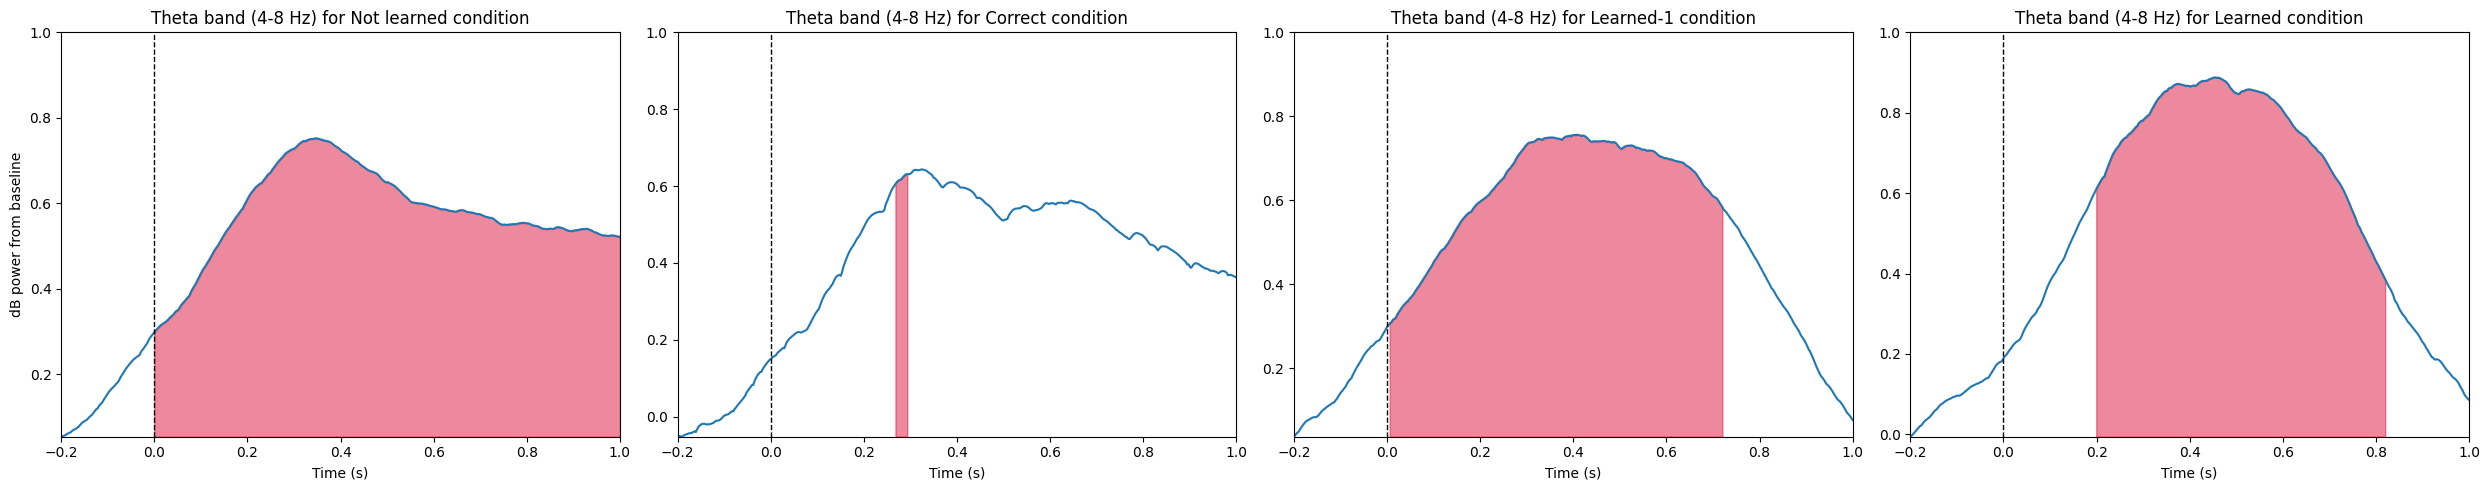

In [35]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

theta_avg = np.asanyarray([np.mean([power_theta[condition][subject_id] for subject_id in subject_ids], axis=0) for condition in conditions])
data_to_plot = theta_avg

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('dB power from baseline')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(np.min(data_to_plot[i]), 1)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_clusters.png", dpi=300, bbox_inches='tight')

### Plot t-value

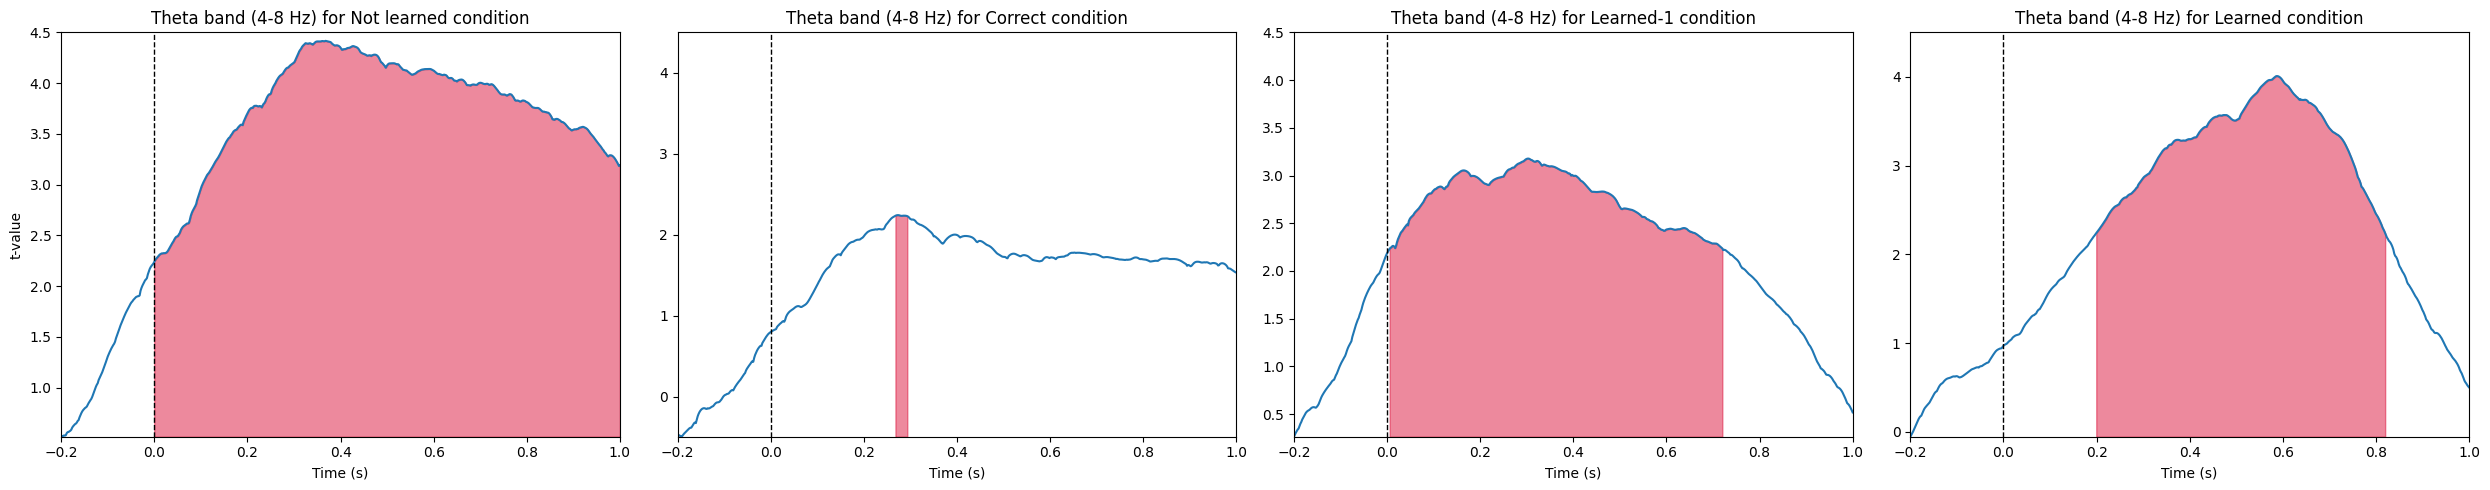

In [36]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

data_to_plot = np.asanyarray([statistics[condition]['t-statistics'] for condition in conditions])

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('t-value')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(np.min(data_to_plot[i]), 4.5)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_t-values.png", dpi=300, bbox_inches='tight')

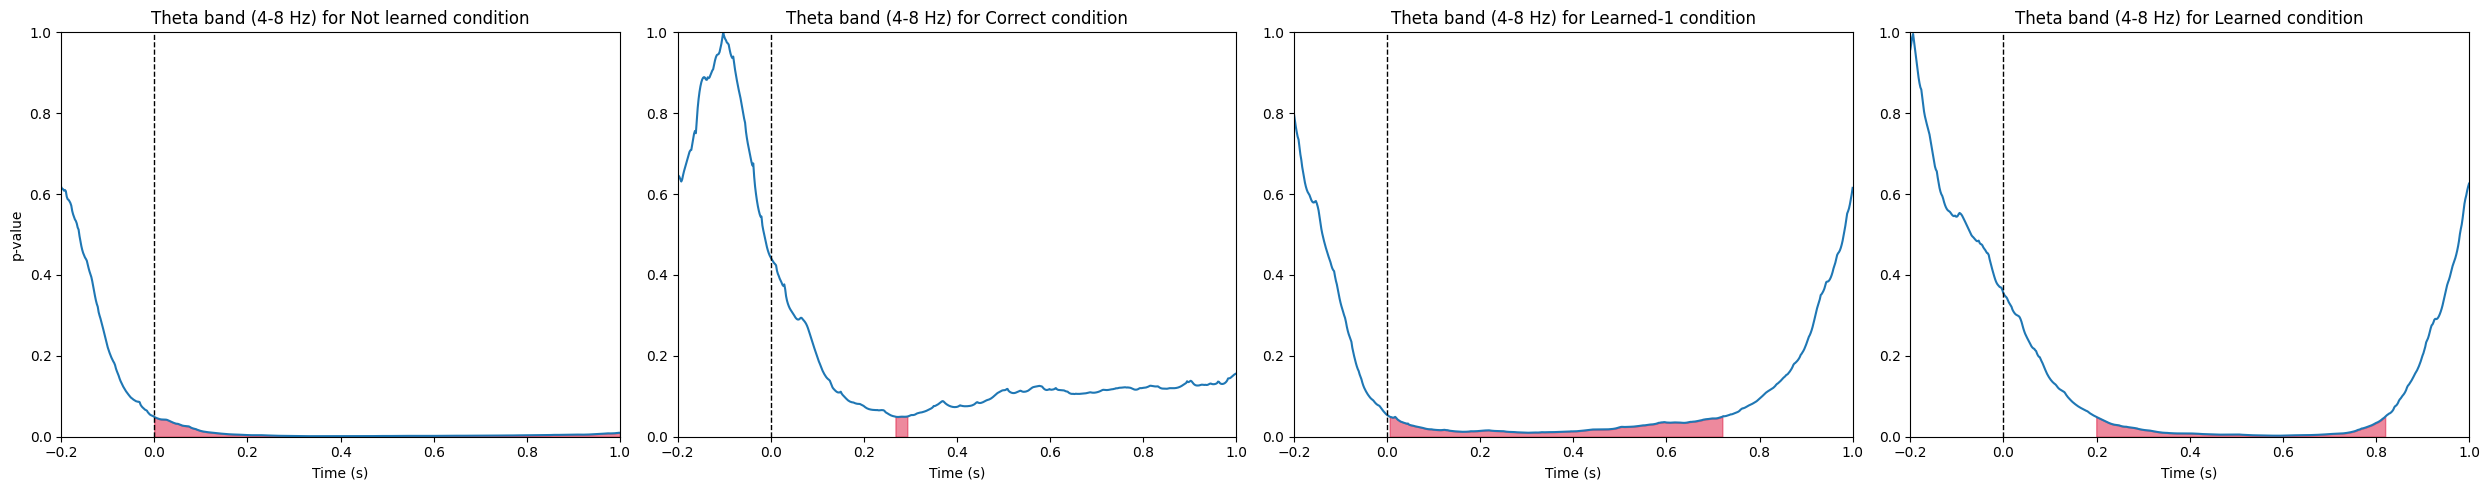

In [45]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

data_to_plot = np.asanyarray([statistics[condition]['p-values'] for condition in conditions])

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=0 if np.min(data_to_plot[i]) > 0 else np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('p-value')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(0 if np.min(data_to_plot[i]) > 0 else np.min(data_to_plot[i]), 1)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_p-values.png", dpi=300, bbox_inches='tight')

### Averaged Theta T-test (permutation)

In [3]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('uncertain', 'certain')
verbose             = False

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# compute averages, ending with an average across theta band (4-8 Hz, 1D vector) for each subject
power_sub_avg = {}
power_theta = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    power_theta[condition] = {}
    for subject_id in subject_ids:
        # average power across all channels within subjects
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
        # average theta band power (4-8 Hz) within subjects (result is 1D vector of 1024 time points)
        power_theta[condition][subject_id] = np.mean(power_sub_avg[condition][subject_id][1:4], axis=0)


# initialize output from statistics
statistics          = {conditions[0]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}, \
                       conditions[1]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}}
df_cluster_sizes    = pd.DataFrame(columns=['condition', 'permutation', 'random_seed', 'indices_shuffled', 'cluster_label', 'cluster_size (t-value)'])
p_val               = 0.05      # significance level
n_permutations      = 1000      # number of permutations

# perform permutation test for each condition separately
for condition in conditions:
    print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((n_permutations, 1024))                  # N permutations, 1 frequency band, 1024 time points
    p_values        = np.zeros((n_permutations, 1024))                  # N permutations, 1 frequency band, 1024 time points
    clusters        = np.zeros((n_permutations, 1024)).astype(int)      # N permutations, 1 frequency band, 1024 time points
    cluster_labels  = np.zeros((n_permutations, 1024)).astype(int)      # N permutations, 1 frequency band, 1024 time points
    
    for n in tqdm(range(n_permutations), desc='Permutation progress', total=n_permutations):
        if verbose: print(f"\nPermutation {n + 1}/{n_permutations}...")
        
        # get the shuffle indices for current permutation
        seed = np.random.randint(n_permutations, size=1)[0]
        if verbose: print(f"seed: {seed}")
        rng = np.random.default_rng(seed)
        perm_indices = npsystat.get_shuffle_indices(num_obs=len(subject_ids), rng=rng)
        if verbose: print(f"Shuffling indices: {perm_indices}...")
        
        # iterate over time points
        for j in range(1024):
            
            sample_pow = []
            # for each combination of frequency and time, store the power values for all subjects and channels
            # this will be used to perform the t test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_pow.append(power_theta[condition][subject_id][j])
            
            # initialise baseline sample
            sample_base = np.zeros(len(sample_pow))
                
            # shuffle the power values and baseline for current permutation
            s_pow = sample_pow.copy()
            s_base = sample_base.copy()
            for idx in range(len(sample_pow)):
                if idx in perm_indices:
                    s_pow[idx] = sample_base[idx]
                    s_base[idx] = sample_pow[idx]
                else:
                    s_pow[idx] = sample_pow[idx]
                    s_base[idx] = sample_base[idx]
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test for power and baseline.
            #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
            #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
            # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
            res = stats.ttest_rel(a=s_pow, b=s_base, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[n, j]   = res.statistic
            p_values[n, j]       = res.pvalue
            clusters[n, j]       = 1 if res.pvalue < p_val else 0
                
            #     break
            # break
            
        if np.isclose(clusters[n, ...], 0).all():
            if verbose: print(f"No clusters found.")
            # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
            df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, None, None]
        else:
            # assign labels to clusters in current permutation
            cluster_labels[n, ...] = npsystat.assign_cluster_labels(clusters[n, ...], verbose=verbose)
            
            if 0 not in cluster_labels[n, ...]:
                if verbose: print(f"Found {len(np.unique(cluster_labels[n, ...]))} clusters: {np.unique(cluster_labels[n, ...])}.")
            else:
                if verbose: print(f"Found {len(np.unique(cluster_labels[n, ...])[1:])} clusters: {np.unique(cluster_labels[n, ...])[1:]}.")
            
            # count cluster sizes
            cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics[n, ...], cluster_labels=cluster_labels[n, ...], verbose=verbose)
        
            # append cluster sizes to dataframe
            for label, size in cluster_sizes.items():
                # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
                df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, label, size]
            
        # break
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
          
    print(f"Finished condition {repr(condition)}.\n")
    
    # break
    
# save results to disk
with open(f"{path}/data/theta_perm_statistics.pkl", 'wb') as f:
    pickle.dump(statistics, f)
df_cluster_sizes.to_csv(f"{path}/data/theta_perm_cluster_sizes.csv")

Starting condition 'uncertain'...


Permutation progress: 100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


Finished condition 'uncertain'.

Starting condition 'certain'...


Permutation progress: 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]

Finished condition 'certain'.

